## Flair upos etiketiranje

U ovoj svesci:
- Učitavamo UD_SERBIAN korpus pomoću Flair radnog okvira. To je skup rečenica na srpskom jeziku koje su ručno etiketiranje na nivou tokena
- Učitavano već istrenirana ugnježdavanja (embedding) reči koje nudi Flair radni okvir
- Pravimo model za upos etiketiranje koji se oslanja na učitana ugnježdavanja 
    - optimizujemo model na prostoru hiperparametra koristeći validacioni skup validacionih podataka
    - treniramo model još jednom sa najboljim parametrima
    - evaluiramo tako dobijeni model

### Učitavanje podataka i pretprocesiranje

In [1]:
import json
import flair.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from flair.data import Sentence
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn import metrics
from flair.datasets import ColumnCorpus

In [2]:
corpus = flair.datasets.UD_SERBIAN().downsample(0.4)

2022-09-01 14:52:37,048 Reading data from C:\Users\vladimir\.flair\datasets\ud_serbian
2022-09-01 14:52:37,049 Train: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-train.conllu
2022-09-01 14:52:37,050 Dev: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-dev.conllu
2022-09-01 14:52:37,050 Test: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-test.conllu


#### Analiza podataka

##### UPOS etikete:
- ADJ: pridev
- ADP: apozicija
- ADV: prilog
- AUX: pomoćni glagoli
- CCONJ: naporedni veznici
- DET: odrednice
- INTJ: uzvici
- NOUN: imenice
- NUM: brojevi
- PART: frazalni glagoli
- PRON: zamenica
- PROPN: vlastite imenice
- PUNCT: znakovi interpunkcije
- SCONJ: zavisni veznik
- SYM: simboli
- VERB: glagoli
- X: ostalo

In [3]:
tags = ["ADJ","ADP", 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

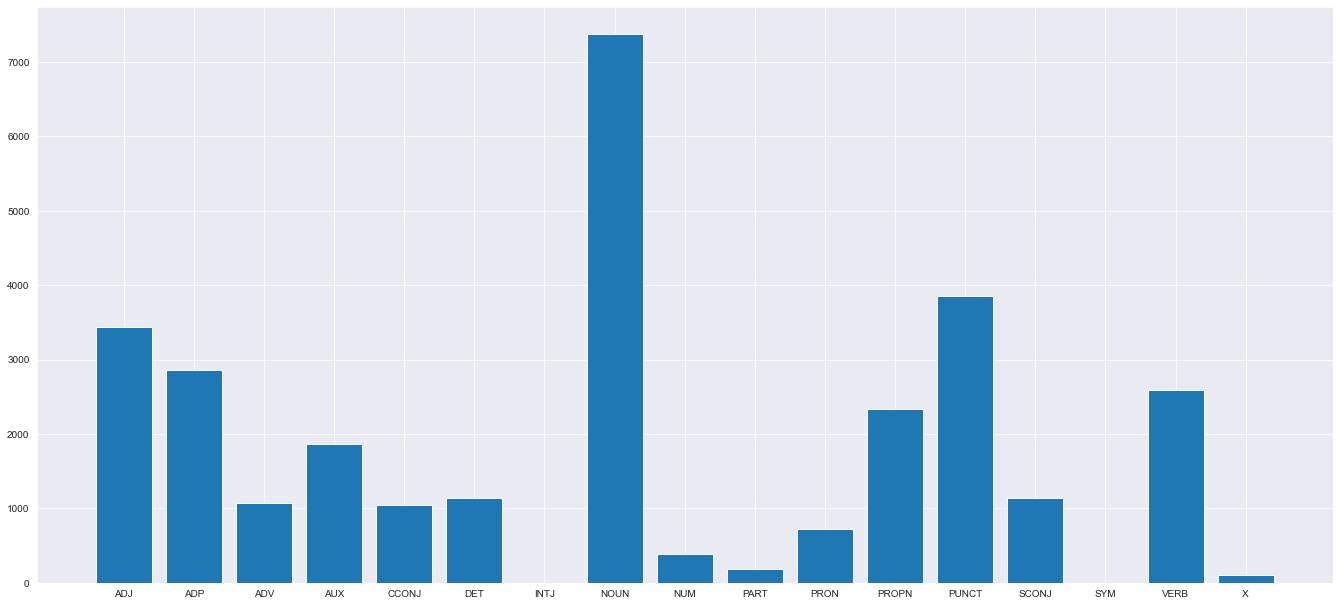

In [4]:
a = corpus.get_label_distribution()

freq = {}
for tag in tags:
    freq[tag] = a[tag]
    
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.bar(tags,freq.values())
plt.show()

In [5]:
# Ispisujemo broj recenica u svakom u podeli skupova
print("Training: ",len(corpus.train))
print("Test: ",len(corpus.test))
print("Dev: ",len(corpus.dev))

Training:  1331
Test:  208
Dev:  214


#### Pretprocesiranje podataka
Pošto podaci za treniranje UPOS tagger-a moraju biti u tačno određenom formatu, jedini korak neophodan u pretprocesiranju je da dodelimo svakoj reči UPOS tag ako ga ona već nema. Odnosno ako tag nije u pravilnom formatu, dodeljujemo joj tag "X". UPOS tag "X" označava da se radi o "other" tipu reči, pošto ne možemo da zaključimo ništa više o samoj reči bez njene dalje analize.

In [6]:
for sentence in corpus.get_all_sentences():
    for token in sentence:
        if token.get_label('upos').value not in tags:
            token.set_label('upos', 'X')

#### Prikaz učitane recenice i etiketiranih rečeničnih tokena iz validacionog skupa korpusa

In [7]:
sentence = corpus.dev[1]
print(sentence)
for token in sentence:
    print(token)

Sentence: "Tu je i etnička komponenta , s obzirom da pojedinci iz različitih zajednica mogu da kažu da je diskriminacija -- bilo sada ili ranije -- uticala na njihovu mogućnost ostvarivanja koristi od privatizacije ." → ["Tu"/tu/ADV/Rgp/advmod/Pos/Dem, "je"/biti/AUX/Var3s/root/Ind/Sing/3/Pres/Fin, "i"/i/CCONJ/Cc/discourse, "etnička"/etnički/ADJ/Agpfsny/amod/Nom/Def/Pos/Fem/Sing, "komponenta"/komponenta/NOUN/Ncfsn/nsubj/Nom/Fem/Sing, ","/,/PUNCT/Z/punct, "s"/sa/ADP/Si/mark/Ins, "obzirom"/obzir/NOUN/Ncmsi/fixed/Ins/Masc/Sing, "da"/da/SCONJ/Cs/fixed, "pojedinci"/pojedinac/NOUN/Ncmpn/nsubj/Nom/Masc/Plur, "iz"/iz/ADP/Sg/case/Gen, "različitih"/različit/ADJ/Agpfpgy/amod/Gen/Def/Pos/Fem/Plur, "zajednica"/zajednica/NOUN/Ncfpg/nmod/Gen/Fem/Plur, "mogu"/moći/VERB/Vmr3p/advcl/Ind/Plur/3/Pres/Fin, "da"/da/SCONJ/Cs/mark, "kažu"/kazati/VERB/Vmr3p/xcomp/Ind/Plur/3/Pres/Fin, "da"/da/SCONJ/Cs/mark, "je"/biti/AUX/Var3s/aux/Ind/Sing/3/Pres/Fin, "diskriminacija"/diskriminacija/NOUN/Ncfsn/nsubj/Nom/Fem/Sing

#### Pravljenje rečnika

In [8]:
# Pravljenje rečnika  sa UPOS etiketama iz korpusa
label_type = 'upos'
label_dict  = corpus.make_label_dictionary(label_type = label_type)
print(label_dict)

2022-09-01 14:52:42,469 Computing label dictionary. Progress:


1331it [00:00, 20166.09it/s]

2022-09-01 14:52:42,624 Dictionary created for label 'upos' with 17 values: NOUN (seen 7372 times), PUNCT (seen 3855 times), ADJ (seen 3436 times), ADP (seen 2855 times), VERB (seen 2588 times), PROPN (seen 2331 times), AUX (seen 1861 times), DET (seen 1145 times), SCONJ (seen 1139 times), ADV (seen 1070 times), CCONJ (seen 1045 times), PRON (seen 724 times), NUM (seen 392 times), PART (seen 185 times), X (seen 100 times), INTJ (seen 1 times)
Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ


### Nagomilana ugnjezdavanja
Više različitih ugnjezdavanja je moguće koristiti istovremeno pomoću `StackedEmbeddings` klase iz `Flair`-a. U našem primeru iskoristili smo:
1. `GloVe` ugnjezdavanja - bazira se na nalaženju korelacije izmedju parova reči na osnovu frekvencije korišćenja u tandemu
2. `Flair` ugnjezdavanja - embedding koji su razvili tvorci `Flair` biblioteke - koristimo i ugnjezdavanje i unapred i unazad kako bi se uhvatio ceo okolni kontekst reči

In [9]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

### Klasa za etiketiranje (`Tagger`)
Na osnovu kombinacije navedenih ugnjezdavanja generišemo `SequenceTagger` koji ćemo koristiti da na osnovu dobijenih vektorskih reprezentacija reči predvidimo UPOS etikete korespondirajuće reči.

In [10]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

2022-09-01 14:52:45,989 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ


### Treniranje modela i traženje optimalnih hiperparametara

In [11]:
trainer = ModelTrainer(tagger, corpus)

In [12]:
best_score = 0.0
best_params = {'learning_rate':0, 'mini_batch_size': 0, 'max_epochs' : 10}

param_learning_rates = np.linspace(0.001, 0.6, num=4)
param_mini_batch_sizes = np.arange(10,100,20)
max_epochs = np.arange(10,13,1)

model_history = []

In [13]:
for i,lr in enumerate(param_learning_rates):
    for j,mbs in enumerate(param_mini_batch_sizes):
        for k,me in enumerate(max_epochs):
                print('\n\n\n')
                print("#######################################################")
                print(f"############### MODEL NUMBER {i},{j},{k} #####################")
                print("#######################################################")
                trainer.train('resources/model_library/flair_upos_tagging',
                              learning_rate=lr,
                              mini_batch_size=int(mbs),
                              max_epochs=int(me),
                              write_weights = True)
                model = SequenceTagger.load('resources/model_library/flair_upos_tagging/final-model.pt')
                actual= np.array([])
                predicted = np.array([])

                # Provera preciznosti
                for actualSentence in corpus.dev:

                    for token in actualSentence:
                        actual = np.append(actual, token.get_label('upos').value)

                    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
                    model.predict(predictedSentence)
                    for token in predictedSentence:
                        predictedLabels = token.get_labels('upos')
                        for predictedLabel in predictedLabels:
                            predicted = np.append(predicted, predictedLabel.value)
                score = metrics.accuracy_score(actual,predicted)

                if score>best_score:
                    best_params['learning_rate'] = lr
                    best_params['param_mini_batch_sizes'] = mbs
                    best_params['max_epochs'] = me

                report = metrics.classification_report(actual,predicted)
                params = {'learning_rate': lr, 'param_mini_batch_sizes': mbs,
                          'max_epochs': me}

                # Takodje cuvamo i istoriju parapetara sa njihovim rezultatima metrika za svaki slucaj
                model_history.append({'params':params,'report':report})





#######################################################
############### MODEL NUMBER 0,0,0 #####################
#######################################################
2022-09-01 14:52:46,174 ----------------------------------------------------------------------------------------------------
2022-09-01 14:52:46,175 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 14:53:16,950 epoch 1 - iter 13/134 - loss 3.56824505 - samples/sec: 4.23 - lr: 0.001000
2022-09-01 14:53:50,547 epoch 1 - iter 26/134 - loss 3.52225975 - samples/sec: 3.88 - lr: 0.001000
2022-09-01 14:54:21,590 epoch 1 - iter 39/134 - loss 3.50681684 - samples/sec: 4.20 - lr: 0.001000
2022-09-01 14:54:55,214 epoch 1 - iter 52/134 - loss 3.48097866 - samples/sec: 3.88 - lr: 0.001000
2022-09-01 14:55:35,433 epoch 1 - iter 65/134 - loss 3.45529235 - samples/sec: 3.24 - lr: 0.001000
2022-09-01 14:56:12,025 epoch 1 - iter 78/134 - loss 3.43442211 - samples/sec: 3.56 - lr: 0.001000
2022-09-01 14:56:44,266 epoch 1 - iter 91/134 - loss 3.41079068 - samples/sec: 4.04 - lr: 0.001000
2022-09-01 14:57:13,306 epoch 1 - iter 104/134 - loss 3.39138562 - samples/sec: 4.49 - lr: 0.001000
2022-09-01 14:57:47,039 epoch 1 - iter 117/134 - loss 3.36609904 - samples/sec: 3.86 - lr: 0.001000
2022-09-01 14:58:21,233 epoch 1 - iter 130/134 - loss 3.35645600 - samples/sec: 3.81 - lr: 0.001000
2022-09

100%|██████████| 22/22 [00:46<00:00,  2.13s/it]

2022-09-01 14:59:17,967 Evaluating as a multi-label problem: False
2022-09-01 14:59:17,997 DEV : loss 3.116426944732666 - f1-score (micro avg)  0.085
2022-09-01 14:59:18,014 BAD EPOCHS (no improvement): 0
2022-09-01 14:59:18,015 saving best model


2022-09-01 14:59:19,166 ----------------------------------------------------------------------------------------------------
2022-09-01 14:59:23,606 epoch 2 - iter 13/134 - loss 3.13425280 - samples/sec: 29.31 - lr: 0.001000
2022-09-01 14:59:28,118 epoch 2 - iter 26/134 - loss 3.12992756 - samples/sec: 29.37 - lr: 0.001000
2022-09-01 14:59:33,240 epoch 2 - iter 39/134 - loss 3.10153535 - samples/sec: 25.78 - lr: 0.001000
2022-09-01 14:59:38,304 epoch 2 - iter 52/134 - loss 3.08864449 - samples/sec: 26.08 - lr: 0.001000
2022-09-01 14:59:43,294 epoch 2 - iter 65/134 - loss 3.06775818 - samples/sec: 26.44 - lr: 0.001000
2022-09-01 14:59:47,873 epoch 2 - iter 78/134 - loss 3.06336761 - samples/sec: 28.90 - lr: 0.001000
2022-09-01 14:59:53,280 epoch 2 - iter 91/134 - loss 3.04884378 - samples/sec: 24.43 - lr: 0.001000
2022-09-01 14:59:57,783 epoch 2 - iter 104/134 - loss 3.04020253 - samples/sec: 29.36 - lr: 0.001000
2022-09-01 15:00:02,776 epoch 2 - iter 117/134 - loss 3.02858246 - samples

100%|██████████| 22/22 [00:02<00:00,  8.36it/s]

2022-09-01 15:00:11,556 Evaluating as a multi-label problem: False
2022-09-01 15:00:11,580 DEV : loss 2.862839460372925 - f1-score (micro avg)  0.227
2022-09-01 15:00:11,598 BAD EPOCHS (no improvement): 0
2022-09-01 15:00:11,599 saving best model


2022-09-01 15:00:12,876 ----------------------------------------------------------------------------------------------------
2022-09-01 15:00:17,776 epoch 3 - iter 13/134 - loss 2.92945721 - samples/sec: 26.54 - lr: 0.001000
2022-09-01 15:00:23,218 epoch 3 - iter 26/134 - loss 2.89446148 - samples/sec: 24.25 - lr: 0.001000
2022-09-01 15:00:28,315 epoch 3 - iter 39/134 - loss 2.87843325 - samples/sec: 25.93 - lr: 0.001000
2022-09-01 15:00:33,154 epoch 3 - iter 52/134 - loss 2.85707374 - samples/sec: 27.30 - lr: 0.001000
2022-09-01 15:00:38,225 epoch 3 - iter 65/134 - loss 2.85990709 - samples/sec: 26.07 - lr: 0.001000
2022-09-01 15:00:43,433 epoch 3 - iter 78/134 - loss 2.85056008 - samples/sec: 25.37 - lr: 0.001000
2022-09-01 15:00:47,977 epoch 3 - iter 91/134 - loss 2.84604578 - samples/sec: 29.10 - lr: 0.001000
2022-09-01 15:00:52,693 epoch 3 - iter 104/134 - loss 2.83455022 - samples/sec: 28.06 - lr: 0.001000
2022-09-01 15:00:57,402 epoch 3 - iter 117/134 - loss 2.82831915 - samples

100%|██████████| 22/22 [00:02<00:00,  8.48it/s]

2022-09-01 15:01:05,594 Evaluating as a multi-label problem: False
2022-09-01 15:01:05,616 DEV : loss 2.69708251953125 - f1-score (micro avg)  0.2686
2022-09-01 15:01:05,634 BAD EPOCHS (no improvement): 0
2022-09-01 15:01:05,635 saving best model


2022-09-01 15:01:06,872 ----------------------------------------------------------------------------------------------------
2022-09-01 15:01:11,282 epoch 4 - iter 13/134 - loss 2.71550000 - samples/sec: 29.50 - lr: 0.001000
2022-09-01 15:01:15,896 epoch 4 - iter 26/134 - loss 2.72445316 - samples/sec: 28.68 - lr: 0.001000
2022-09-01 15:01:20,629 epoch 4 - iter 39/134 - loss 2.70964672 - samples/sec: 27.91 - lr: 0.001000
2022-09-01 15:01:25,281 epoch 4 - iter 52/134 - loss 2.70923678 - samples/sec: 28.45 - lr: 0.001000
2022-09-01 15:01:30,528 epoch 4 - iter 65/134 - loss 2.70043943 - samples/sec: 25.17 - lr: 0.001000
2022-09-01 15:01:35,682 epoch 4 - iter 78/134 - loss 2.69459924 - samples/sec: 25.61 - lr: 0.001000
2022-09-01 15:01:40,554 epoch 4 - iter 91/134 - loss 2.68486391 - samples/sec: 27.14 - lr: 0.001000
2022-09-01 15:01:45,229 epoch 4 - iter 104/134 - loss 2.67822559 - samples/sec: 28.30 - lr: 0.001000
2022-09-01 15:01:49,983 epoch 4 - iter 117/134 - loss 2.67646826 - samples

100%|██████████| 22/22 [00:02<00:00,  8.57it/s]

2022-09-01 15:01:59,031 Evaluating as a multi-label problem: False
2022-09-01 15:01:59,055 DEV : loss 2.545210361480713 - f1-score (micro avg)  0.2821
2022-09-01 15:01:59,075 BAD EPOCHS (no improvement): 0
2022-09-01 15:01:59,076 saving best model


2022-09-01 15:02:00,318 ----------------------------------------------------------------------------------------------------
2022-09-01 15:02:04,748 epoch 5 - iter 13/134 - loss 2.60813144 - samples/sec: 29.36 - lr: 0.001000
2022-09-01 15:02:09,694 epoch 5 - iter 26/134 - loss 2.58987861 - samples/sec: 26.73 - lr: 0.001000
2022-09-01 15:02:14,405 epoch 5 - iter 39/134 - loss 2.57377544 - samples/sec: 28.06 - lr: 0.001000
2022-09-01 15:02:19,482 epoch 5 - iter 52/134 - loss 2.57066337 - samples/sec: 26.00 - lr: 0.001000
2022-09-01 15:02:24,262 epoch 5 - iter 65/134 - loss 2.56563816 - samples/sec: 27.65 - lr: 0.001000
2022-09-01 15:02:29,165 epoch 5 - iter 78/134 - loss 2.56102371 - samples/sec: 26.97 - lr: 0.001000
2022-09-01 15:02:34,170 epoch 5 - iter 91/134 - loss 2.55189242 - samples/sec: 26.41 - lr: 0.001000
2022-09-01 15:02:39,394 epoch 5 - iter 104/134 - loss 2.54919338 - samples/sec: 25.27 - lr: 0.001000
2022-09-01 15:02:43,953 epoch 5 - iter 117/134 - loss 2.54022477 - samples

100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

2022-09-01 15:02:52,428 Evaluating as a multi-label problem: False
2022-09-01 15:02:52,454 DEV : loss 2.411221504211426 - f1-score (micro avg)  0.2983
2022-09-01 15:02:52,473 BAD EPOCHS (no improvement): 0
2022-09-01 15:02:52,475 saving best model


2022-09-01 15:02:53,782 ----------------------------------------------------------------------------------------------------
2022-09-01 15:02:58,938 epoch 6 - iter 13/134 - loss 2.45423851 - samples/sec: 25.22 - lr: 0.001000
2022-09-01 15:03:03,751 epoch 6 - iter 26/134 - loss 2.47610597 - samples/sec: 27.54 - lr: 0.001000
2022-09-01 15:03:08,774 epoch 6 - iter 39/134 - loss 2.45799545 - samples/sec: 26.31 - lr: 0.001000
2022-09-01 15:03:13,786 epoch 6 - iter 52/134 - loss 2.45706912 - samples/sec: 26.37 - lr: 0.001000
2022-09-01 15:03:18,786 epoch 6 - iter 65/134 - loss 2.44638553 - samples/sec: 26.42 - lr: 0.001000
2022-09-01 15:03:23,503 epoch 6 - iter 78/134 - loss 2.44322443 - samples/sec: 28.04 - lr: 0.001000
2022-09-01 15:03:28,436 epoch 6 - iter 91/134 - loss 2.43826822 - samples/sec: 26.78 - lr: 0.001000
2022-09-01 15:03:33,047 epoch 6 - iter 104/134 - loss 2.43413739 - samples/sec: 28.68 - lr: 0.001000
2022-09-01 15:03:37,781 epoch 6 - iter 117/134 - loss 2.42873931 - samples

100%|██████████| 22/22 [00:02<00:00,  8.49it/s]

2022-09-01 15:03:46,611 Evaluating as a multi-label problem: False
2022-09-01 15:03:46,633 DEV : loss 2.292677402496338 - f1-score (micro avg)  0.3207
2022-09-01 15:03:46,650 BAD EPOCHS (no improvement): 0
2022-09-01 15:03:46,651 saving best model


2022-09-01 15:03:47,840 ----------------------------------------------------------------------------------------------------
2022-09-01 15:03:52,578 epoch 7 - iter 13/134 - loss 2.37659212 - samples/sec: 27.45 - lr: 0.001000
2022-09-01 15:03:57,235 epoch 7 - iter 26/134 - loss 2.37964668 - samples/sec: 28.42 - lr: 0.001000
2022-09-01 15:04:01,561 epoch 7 - iter 39/134 - loss 2.35154475 - samples/sec: 30.65 - lr: 0.001000
2022-09-01 15:04:06,185 epoch 7 - iter 52/134 - loss 2.34585014 - samples/sec: 28.62 - lr: 0.001000
2022-09-01 15:04:11,461 epoch 7 - iter 65/134 - loss 2.33544084 - samples/sec: 25.05 - lr: 0.001000
2022-09-01 15:04:16,235 epoch 7 - iter 78/134 - loss 2.33318477 - samples/sec: 27.68 - lr: 0.001000
2022-09-01 15:04:21,054 epoch 7 - iter 91/134 - loss 2.32995935 - samples/sec: 27.40 - lr: 0.001000
2022-09-01 15:04:26,130 epoch 7 - iter 104/134 - loss 2.32820870 - samples/sec: 26.04 - lr: 0.001000
2022-09-01 15:04:31,017 epoch 7 - iter 117/134 - loss 2.32393999 - samples

100%|██████████| 22/22 [00:02<00:00,  8.64it/s]

2022-09-01 15:04:39,830 Evaluating as a multi-label problem: False
2022-09-01 15:04:39,851 DEV : loss 2.187750816345215 - f1-score (micro avg)  0.3411
2022-09-01 15:04:39,870 BAD EPOCHS (no improvement): 0
2022-09-01 15:04:39,872 saving best model


2022-09-01 15:04:41,084 ----------------------------------------------------------------------------------------------------
2022-09-01 15:04:45,900 epoch 8 - iter 13/134 - loss 2.27278823 - samples/sec: 27.01 - lr: 0.001000
2022-09-01 15:04:50,637 epoch 8 - iter 26/134 - loss 2.25960517 - samples/sec: 27.92 - lr: 0.001000
2022-09-01 15:04:55,412 epoch 8 - iter 39/134 - loss 2.24942290 - samples/sec: 27.70 - lr: 0.001000
2022-09-01 15:05:00,537 epoch 8 - iter 52/134 - loss 2.23465705 - samples/sec: 25.77 - lr: 0.001000
2022-09-01 15:05:05,164 epoch 8 - iter 65/134 - loss 2.23461934 - samples/sec: 28.72 - lr: 0.001000
2022-09-01 15:05:10,662 epoch 8 - iter 78/134 - loss 2.23676114 - samples/sec: 24.01 - lr: 0.001000
2022-09-01 15:05:15,266 epoch 8 - iter 91/134 - loss 2.23332287 - samples/sec: 28.75 - lr: 0.001000
2022-09-01 15:05:19,996 epoch 8 - iter 104/134 - loss 2.22214843 - samples/sec: 27.96 - lr: 0.001000
2022-09-01 15:05:24,678 epoch 8 - iter 117/134 - loss 2.21954229 - samples

100%|██████████| 22/22 [00:02<00:00,  8.23it/s]

2022-09-01 15:05:33,681 Evaluating as a multi-label problem: False
2022-09-01 15:05:33,708 DEV : loss 2.0931687355041504 - f1-score (micro avg)  0.3603
2022-09-01 15:05:33,728 BAD EPOCHS (no improvement): 0
2022-09-01 15:05:33,729 saving best model


2022-09-01 15:05:35,030 ----------------------------------------------------------------------------------------------------
2022-09-01 15:05:39,644 epoch 9 - iter 13/134 - loss 2.19690599 - samples/sec: 28.20 - lr: 0.001000
2022-09-01 15:05:44,491 epoch 9 - iter 26/134 - loss 2.18922855 - samples/sec: 27.29 - lr: 0.001000
2022-09-01 15:05:49,729 epoch 9 - iter 39/134 - loss 2.17477647 - samples/sec: 25.21 - lr: 0.001000
2022-09-01 15:05:54,570 epoch 9 - iter 52/134 - loss 2.16217803 - samples/sec: 27.30 - lr: 0.001000
2022-09-01 15:05:59,773 epoch 9 - iter 65/134 - loss 2.16255536 - samples/sec: 25.37 - lr: 0.001000
2022-09-01 15:06:04,608 epoch 9 - iter 78/134 - loss 2.15994409 - samples/sec: 27.40 - lr: 0.001000
2022-09-01 15:06:09,249 epoch 9 - iter 91/134 - loss 2.15897636 - samples/sec: 28.50 - lr: 0.001000
2022-09-01 15:06:14,191 epoch 9 - iter 104/134 - loss 2.14707394 - samples/sec: 26.70 - lr: 0.001000
2022-09-01 15:06:19,224 epoch 9 - iter 117/134 - loss 2.14845299 - samples

100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

2022-09-01 15:06:27,452 Evaluating as a multi-label problem: False
2022-09-01 15:06:27,479 DEV : loss 2.0081305503845215 - f1-score (micro avg)  0.3853
2022-09-01 15:06:27,495 BAD EPOCHS (no improvement): 0
2022-09-01 15:06:27,496 saving best model


2022-09-01 15:06:28,734 ----------------------------------------------------------------------------------------------------
2022-09-01 15:06:33,798 epoch 10 - iter 13/134 - loss 2.08948334 - samples/sec: 25.68 - lr: 0.001000
2022-09-01 15:06:38,475 epoch 10 - iter 26/134 - loss 2.08393188 - samples/sec: 28.35 - lr: 0.001000
2022-09-01 15:06:43,441 epoch 10 - iter 39/134 - loss 2.08157747 - samples/sec: 26.63 - lr: 0.001000
2022-09-01 15:06:48,312 epoch 10 - iter 52/134 - loss 2.07587364 - samples/sec: 27.16 - lr: 0.001000
2022-09-01 15:06:53,128 epoch 10 - iter 65/134 - loss 2.08069364 - samples/sec: 27.48 - lr: 0.001000
2022-09-01 15:06:58,201 epoch 10 - iter 78/134 - loss 2.08524516 - samples/sec: 26.01 - lr: 0.001000
2022-09-01 15:07:03,150 epoch 10 - iter 91/134 - loss 2.07581219 - samples/sec: 26.67 - lr: 0.001000
2022-09-01 15:07:07,976 epoch 10 - iter 104/134 - loss 2.07145537 - samples/sec: 27.43 - lr: 0.001000
2022-09-01 15:07:12,648 epoch 10 - iter 117/134 - loss 2.06688617 

100%|██████████| 22/22 [00:02<00:00,  8.30it/s]

2022-09-01 15:07:21,135 Evaluating as a multi-label problem: False
2022-09-01 15:07:21,167 DEV : loss 1.930444598197937 - f1-score (micro avg)  0.4063
2022-09-01 15:07:21,190 BAD EPOCHS (no improvement): 0
2022-09-01 15:07:21,191 saving best model


2022-09-01 15:07:23,589 ----------------------------------------------------------------------------------------------------
2022-09-01 15:07:23,590 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 15:07:24,141 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:44<00:00,  2.10s/it]

2022-09-01 15:08:08,412 Evaluating as a multi-label problem: False
2022-09-01 15:08:08,434 0.4132	0.4132	0.4132	0.4132
2022-09-01 15:08:08,434 
Results:
- F-score (micro) 0.4132
- F-score (macro) 0.2436
- Accuracy 0.4132

By class:
              precision    recall  f1-score   support

        NOUN     0.4152    0.5296    0.4655      1165
         ADJ     0.1061    0.1823    0.1341       554
       PUNCT     0.7617    0.9668    0.8521       572
         ADP     0.5450    0.7582    0.6342       455
       PROPN     0.1016    0.0904    0.0957       354
        VERB     0.2614    0.0574    0.0941       401
         AUX     0.5368    0.3505    0.4241       291
       CCONJ     0.8218    0.5390    0.6510       154
       SCONJ     0.7500    0.3068    0.4355       176
         ADV     0.1429    0.0526    0.0769       171
         DET     0.0000    0.0000    0.0000       143
        PRON     1.0000    0.0179    0.0351       112
         NUM     0.0000    0.0000    0.0000        63
        PAR

2022-09-01 15:08:08,994 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,0,1 #####################
#######################################################
2022-09-01 15:10:03,877 ----------------------------------------------------------------------------------------------------
2022-09-01 15:10:03,878 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3

2022-09-01 15:10:08,343 epoch 1 - iter 13/134 - loss 2.01722689 - samples/sec: 29.21 - lr: 0.001000
2022-09-01 15:10:13,539 epoch 1 - iter 26/134 - loss 2.01858414 - samples/sec: 25.42 - lr: 0.001000
2022-09-01 15:10:18,159 epoch 1 - iter 39/134 - loss 2.01732869 - samples/sec: 28.63 - lr: 0.001000
2022-09-01 15:10:22,686 epoch 1 - iter 52/134 - loss 2.00925560 - samples/sec: 29.21 - lr: 0.001000
2022-09-01 15:10:27,737 epoch 1 - iter 65/134 - loss 1.99049535 - samples/sec: 26.12 - lr: 0.001000
2022-09-01 15:10:32,650 epoch 1 - iter 78/134 - loss 1.99464505 - samples/sec: 26.94 - lr: 0.001000
2022-09-01 15:10:37,444 epoch 1 - iter 91/134 - loss 1.98947672 - samples/sec: 27.60 - lr: 0.001000
2022-09-01 15:10:41,944 epoch 1 - iter 104/134 - loss 1.99015075 - samples/sec: 29.40 - lr: 0.001000
2022-09-01 15:10:46,943 epoch 1 - iter 117/134 - loss 1.98130320 - samples/sec: 26.39 - lr: 0.001000
2022-09-01 15:10:51,725 epoch 1 - iter 130/134 - loss 1.99273916 - samples/sec: 27.65 - lr: 0.0010

100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

2022-09-01 15:10:55,787 Evaluating as a multi-label problem: False
2022-09-01 15:10:55,813 DEV : loss 1.8609895706176758 - f1-score (micro avg)  0.4267
2022-09-01 15:10:55,833 BAD EPOCHS (no improvement): 0
2022-09-01 15:10:55,834 saving best model


2022-09-01 15:10:57,011 ----------------------------------------------------------------------------------------------------
2022-09-01 15:11:01,788 epoch 2 - iter 13/134 - loss 1.99990379 - samples/sec: 27.23 - lr: 0.001000
2022-09-01 15:11:06,717 epoch 2 - iter 26/134 - loss 1.99256307 - samples/sec: 26.84 - lr: 0.001000
2022-09-01 15:11:11,562 epoch 2 - iter 39/134 - loss 1.98467696 - samples/sec: 27.29 - lr: 0.001000
2022-09-01 15:11:16,494 epoch 2 - iter 52/134 - loss 1.96898067 - samples/sec: 26.78 - lr: 0.001000
2022-09-01 15:11:20,969 epoch 2 - iter 65/134 - loss 1.96171263 - samples/sec: 29.56 - lr: 0.001000
2022-09-01 15:11:26,707 epoch 2 - iter 78/134 - loss 1.95764114 - samples/sec: 22.99 - lr: 0.001000
2022-09-01 15:11:31,176 epoch 2 - iter 91/134 - loss 1.95569277 - samples/sec: 29.62 - lr: 0.001000
2022-09-01 15:11:35,615 epoch 2 - iter 104/134 - loss 1.94821042 - samples/sec: 29.78 - lr: 0.001000
2022-09-01 15:11:40,275 epoch 2 - iter 117/134 - loss 1.94577533 - samples

100%|██████████| 22/22 [00:02<00:00,  8.20it/s]

2022-09-01 15:11:49,339 Evaluating as a multi-label problem: False
2022-09-01 15:11:49,361 DEV : loss 1.7958722114562988 - f1-score (micro avg)  0.4461
2022-09-01 15:11:49,378 BAD EPOCHS (no improvement): 0
2022-09-01 15:11:49,379 saving best model


2022-09-01 15:11:50,662 ----------------------------------------------------------------------------------------------------
2022-09-01 15:11:55,439 epoch 3 - iter 13/134 - loss 1.91086234 - samples/sec: 27.22 - lr: 0.001000
2022-09-01 15:12:00,294 epoch 3 - iter 26/134 - loss 1.91111645 - samples/sec: 27.24 - lr: 0.001000
2022-09-01 15:12:04,917 epoch 3 - iter 39/134 - loss 1.90331414 - samples/sec: 28.57 - lr: 0.001000
2022-09-01 15:12:09,636 epoch 3 - iter 52/134 - loss 1.90151656 - samples/sec: 28.00 - lr: 0.001000
2022-09-01 15:12:14,631 epoch 3 - iter 65/134 - loss 1.90330772 - samples/sec: 26.49 - lr: 0.001000
2022-09-01 15:12:19,549 epoch 3 - iter 78/134 - loss 1.89718591 - samples/sec: 26.88 - lr: 0.001000
2022-09-01 15:12:24,203 epoch 3 - iter 91/134 - loss 1.89185257 - samples/sec: 28.40 - lr: 0.001000
2022-09-01 15:12:28,695 epoch 3 - iter 104/134 - loss 1.89215614 - samples/sec: 29.48 - lr: 0.001000
2022-09-01 15:12:34,036 epoch 3 - iter 117/134 - loss 1.89082189 - samples

100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

2022-09-01 15:12:42,966 Evaluating as a multi-label problem: False
2022-09-01 15:12:42,993 DEV : loss 1.7363693714141846 - f1-score (micro avg)  0.459
2022-09-01 15:12:43,016 BAD EPOCHS (no improvement): 0
2022-09-01 15:12:43,017 saving best model


2022-09-01 15:12:44,234 ----------------------------------------------------------------------------------------------------
2022-09-01 15:12:48,588 epoch 4 - iter 13/134 - loss 1.86305322 - samples/sec: 29.86 - lr: 0.001000
2022-09-01 15:12:53,176 epoch 4 - iter 26/134 - loss 1.84442170 - samples/sec: 28.83 - lr: 0.001000
2022-09-01 15:12:58,030 epoch 4 - iter 39/134 - loss 1.83636368 - samples/sec: 27.24 - lr: 0.001000
2022-09-01 15:13:02,909 epoch 4 - iter 52/134 - loss 1.83513612 - samples/sec: 27.05 - lr: 0.001000
2022-09-01 15:13:07,761 epoch 4 - iter 65/134 - loss 1.83379351 - samples/sec: 27.27 - lr: 0.001000
2022-09-01 15:13:12,768 epoch 4 - iter 78/134 - loss 1.82901951 - samples/sec: 26.38 - lr: 0.001000
2022-09-01 15:13:17,817 epoch 4 - iter 91/134 - loss 1.82623060 - samples/sec: 26.17 - lr: 0.001000
2022-09-01 15:13:22,526 epoch 4 - iter 104/134 - loss 1.82644462 - samples/sec: 28.09 - lr: 0.001000
2022-09-01 15:13:27,244 epoch 4 - iter 117/134 - loss 1.82575849 - samples

100%|██████████| 22/22 [00:02<00:00,  8.68it/s]

2022-09-01 15:13:35,899 Evaluating as a multi-label problem: False
2022-09-01 15:13:35,927 DEV : loss 1.6812424659729004 - f1-score (micro avg)  0.475
2022-09-01 15:13:35,943 BAD EPOCHS (no improvement): 0
2022-09-01 15:13:35,944 saving best model


2022-09-01 15:13:37,130 ----------------------------------------------------------------------------------------------------
2022-09-01 15:13:42,169 epoch 5 - iter 13/134 - loss 1.81329155 - samples/sec: 25.82 - lr: 0.001000
2022-09-01 15:13:47,173 epoch 5 - iter 26/134 - loss 1.78235921 - samples/sec: 26.39 - lr: 0.001000
2022-09-01 15:13:51,920 epoch 5 - iter 39/134 - loss 1.81164285 - samples/sec: 27.84 - lr: 0.001000
2022-09-01 15:13:57,109 epoch 5 - iter 52/134 - loss 1.80173313 - samples/sec: 25.44 - lr: 0.001000
2022-09-01 15:14:01,848 epoch 5 - iter 65/134 - loss 1.79251866 - samples/sec: 27.94 - lr: 0.001000
2022-09-01 15:14:06,687 epoch 5 - iter 78/134 - loss 1.78349789 - samples/sec: 27.33 - lr: 0.001000
2022-09-01 15:14:11,190 epoch 5 - iter 91/134 - loss 1.78182082 - samples/sec: 29.42 - lr: 0.001000
2022-09-01 15:14:16,170 epoch 5 - iter 104/134 - loss 1.78039172 - samples/sec: 26.51 - lr: 0.001000
2022-09-01 15:14:20,992 epoch 5 - iter 117/134 - loss 1.77698308 - samples

100%|██████████| 22/22 [00:02<00:00,  8.58it/s]

2022-09-01 15:14:29,304 Evaluating as a multi-label problem: False
2022-09-01 15:14:29,333 DEV : loss 1.6306930780410767 - f1-score (micro avg)  0.4905
2022-09-01 15:14:29,356 BAD EPOCHS (no improvement): 0
2022-09-01 15:14:29,357 saving best model


2022-09-01 15:14:30,550 ----------------------------------------------------------------------------------------------------
2022-09-01 15:14:34,879 epoch 6 - iter 13/134 - loss 1.73449885 - samples/sec: 30.05 - lr: 0.001000
2022-09-01 15:14:39,519 epoch 6 - iter 26/134 - loss 1.76069746 - samples/sec: 28.46 - lr: 0.001000
2022-09-01 15:14:44,099 epoch 6 - iter 39/134 - loss 1.75079799 - samples/sec: 28.88 - lr: 0.001000
2022-09-01 15:14:48,743 epoch 6 - iter 52/134 - loss 1.74507864 - samples/sec: 28.46 - lr: 0.001000
2022-09-01 15:14:53,663 epoch 6 - iter 65/134 - loss 1.73537572 - samples/sec: 26.87 - lr: 0.001000
2022-09-01 15:14:59,050 epoch 6 - iter 78/134 - loss 1.73759018 - samples/sec: 24.48 - lr: 0.001000
2022-09-01 15:15:03,756 epoch 6 - iter 91/134 - loss 1.73456701 - samples/sec: 28.07 - lr: 0.001000
2022-09-01 15:15:08,744 epoch 6 - iter 104/134 - loss 1.73526213 - samples/sec: 26.51 - lr: 0.001000
2022-09-01 15:15:14,054 epoch 6 - iter 117/134 - loss 1.73047360 - samples

100%|██████████| 22/22 [00:02<00:00,  8.51it/s]

2022-09-01 15:15:22,638 Evaluating as a multi-label problem: False
2022-09-01 15:15:22,663 DEV : loss 1.5835338830947876 - f1-score (micro avg)  0.499
2022-09-01 15:15:22,685 BAD EPOCHS (no improvement): 0
2022-09-01 15:15:22,687 saving best model


2022-09-01 15:15:23,913 ----------------------------------------------------------------------------------------------------
2022-09-01 15:15:28,580 epoch 7 - iter 13/134 - loss 1.70002206 - samples/sec: 27.87 - lr: 0.001000
2022-09-01 15:15:33,416 epoch 7 - iter 26/134 - loss 1.70465019 - samples/sec: 27.33 - lr: 0.001000
2022-09-01 15:15:37,982 epoch 7 - iter 39/134 - loss 1.70239636 - samples/sec: 29.00 - lr: 0.001000
2022-09-01 15:15:42,663 epoch 7 - iter 52/134 - loss 1.70189623 - samples/sec: 28.24 - lr: 0.001000
2022-09-01 15:15:47,243 epoch 7 - iter 65/134 - loss 1.70152468 - samples/sec: 28.84 - lr: 0.001000
2022-09-01 15:15:52,580 epoch 7 - iter 78/134 - loss 1.69670221 - samples/sec: 24.70 - lr: 0.001000
2022-09-01 15:15:57,042 epoch 7 - iter 91/134 - loss 1.69486437 - samples/sec: 29.73 - lr: 0.001000
2022-09-01 15:16:02,283 epoch 7 - iter 104/134 - loss 1.68968893 - samples/sec: 25.20 - lr: 0.001000
2022-09-01 15:16:07,713 epoch 7 - iter 117/134 - loss 1.69021132 - samples

100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

2022-09-01 15:16:16,365 Evaluating as a multi-label problem: False
2022-09-01 15:16:16,393 DEV : loss 1.5403228998184204 - f1-score (micro avg)  0.5107
2022-09-01 15:16:16,411 BAD EPOCHS (no improvement): 0
2022-09-01 15:16:16,412 saving best model


2022-09-01 15:16:17,668 ----------------------------------------------------------------------------------------------------
2022-09-01 15:16:22,031 epoch 8 - iter 13/134 - loss 1.61685895 - samples/sec: 29.80 - lr: 0.001000
2022-09-01 15:16:26,713 epoch 8 - iter 26/134 - loss 1.65696166 - samples/sec: 28.27 - lr: 0.001000
2022-09-01 15:16:31,907 epoch 8 - iter 39/134 - loss 1.64233781 - samples/sec: 25.43 - lr: 0.001000
2022-09-01 15:16:36,748 epoch 8 - iter 52/134 - loss 1.63567815 - samples/sec: 27.36 - lr: 0.001000
2022-09-01 15:16:41,676 epoch 8 - iter 65/134 - loss 1.63636577 - samples/sec: 26.83 - lr: 0.001000
2022-09-01 15:16:45,844 epoch 8 - iter 78/134 - loss 1.64796896 - samples/sec: 31.82 - lr: 0.001000
2022-09-01 15:16:50,562 epoch 8 - iter 91/134 - loss 1.63974158 - samples/sec: 28.01 - lr: 0.001000
2022-09-01 15:16:55,580 epoch 8 - iter 104/134 - loss 1.64153871 - samples/sec: 26.34 - lr: 0.001000
2022-09-01 15:17:01,070 epoch 8 - iter 117/134 - loss 1.63880885 - samples

100%|██████████| 22/22 [00:02<00:00,  8.55it/s]

2022-09-01 15:17:09,754 Evaluating as a multi-label problem: False
2022-09-01 15:17:09,780 DEV : loss 1.4993716478347778 - f1-score (micro avg)  0.5226
2022-09-01 15:17:09,802 BAD EPOCHS (no improvement): 0
2022-09-01 15:17:09,803 saving best model


2022-09-01 15:17:11,013 ----------------------------------------------------------------------------------------------------
2022-09-01 15:17:16,151 epoch 9 - iter 13/134 - loss 1.61968136 - samples/sec: 25.31 - lr: 0.001000
2022-09-01 15:17:20,900 epoch 9 - iter 26/134 - loss 1.63182489 - samples/sec: 27.84 - lr: 0.001000
2022-09-01 15:17:26,226 epoch 9 - iter 39/134 - loss 1.62722515 - samples/sec: 24.78 - lr: 0.001000
2022-09-01 15:17:30,915 epoch 9 - iter 52/134 - loss 1.61775480 - samples/sec: 28.19 - lr: 0.001000
2022-09-01 15:17:35,629 epoch 9 - iter 65/134 - loss 1.61452543 - samples/sec: 28.05 - lr: 0.001000
2022-09-01 15:17:39,949 epoch 9 - iter 78/134 - loss 1.62126126 - samples/sec: 30.76 - lr: 0.001000
2022-09-01 15:17:45,115 epoch 9 - iter 91/134 - loss 1.61107830 - samples/sec: 25.58 - lr: 0.001000
2022-09-01 15:17:50,427 epoch 9 - iter 104/134 - loss 1.61128713 - samples/sec: 24.82 - lr: 0.001000
2022-09-01 15:17:55,512 epoch 9 - iter 117/134 - loss 1.61038204 - samples

100%|██████████| 22/22 [00:02<00:00,  8.46it/s]

2022-09-01 15:18:03,675 Evaluating as a multi-label problem: False
2022-09-01 15:18:03,703 DEV : loss 1.461981177330017 - f1-score (micro avg)  0.5299
2022-09-01 15:18:03,723 BAD EPOCHS (no improvement): 0
2022-09-01 15:18:03,724 saving best model


2022-09-01 15:18:04,983 ----------------------------------------------------------------------------------------------------
2022-09-01 15:18:09,480 epoch 10 - iter 13/134 - loss 1.60484850 - samples/sec: 28.91 - lr: 0.001000
2022-09-01 15:18:14,629 epoch 10 - iter 26/134 - loss 1.59735773 - samples/sec: 25.70 - lr: 0.001000
2022-09-01 15:18:19,947 epoch 10 - iter 39/134 - loss 1.59991341 - samples/sec: 24.82 - lr: 0.001000
2022-09-01 15:18:24,542 epoch 10 - iter 52/134 - loss 1.59354920 - samples/sec: 28.79 - lr: 0.001000
2022-09-01 15:18:29,097 epoch 10 - iter 65/134 - loss 1.59661447 - samples/sec: 29.05 - lr: 0.001000
2022-09-01 15:18:33,799 epoch 10 - iter 78/134 - loss 1.59705686 - samples/sec: 28.13 - lr: 0.001000
2022-09-01 15:18:38,850 epoch 10 - iter 91/134 - loss 1.58893211 - samples/sec: 26.16 - lr: 0.001000
2022-09-01 15:18:43,899 epoch 10 - iter 104/134 - loss 1.57945977 - samples/sec: 26.20 - lr: 0.001000
2022-09-01 15:18:48,457 epoch 10 - iter 117/134 - loss 1.58185307 

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 15:18:57,398 Evaluating as a multi-label problem: False
2022-09-01 15:18:57,422 DEV : loss 1.4270859956741333 - f1-score (micro avg)  0.5361
2022-09-01 15:18:57,443 BAD EPOCHS (no improvement): 0
2022-09-01 15:18:57,444 saving best model


2022-09-01 15:18:58,679 ----------------------------------------------------------------------------------------------------
2022-09-01 15:19:03,460 epoch 11 - iter 13/134 - loss 1.59492821 - samples/sec: 27.20 - lr: 0.001000
2022-09-01 15:19:08,391 epoch 11 - iter 26/134 - loss 1.56487155 - samples/sec: 26.81 - lr: 0.001000
2022-09-01 15:19:13,220 epoch 11 - iter 39/134 - loss 1.56239673 - samples/sec: 27.38 - lr: 0.001000
2022-09-01 15:19:18,162 epoch 11 - iter 52/134 - loss 1.55812619 - samples/sec: 26.73 - lr: 0.001000
2022-09-01 15:19:23,120 epoch 11 - iter 65/134 - loss 1.54911819 - samples/sec: 26.66 - lr: 0.001000
2022-09-01 15:19:28,497 epoch 11 - iter 78/134 - loss 1.54655464 - samples/sec: 24.55 - lr: 0.001000
2022-09-01 15:19:33,643 epoch 11 - iter 91/134 - loss 1.54631447 - samples/sec: 25.65 - lr: 0.001000
2022-09-01 15:19:38,265 epoch 11 - iter 104/134 - loss 1.54297136 - samples/sec: 28.63 - lr: 0.001000
2022-09-01 15:19:42,911 epoch 11 - iter 117/134 - loss 1.53991166 

100%|██████████| 22/22 [00:02<00:00,  8.47it/s]

2022-09-01 15:19:51,321 Evaluating as a multi-label problem: False
2022-09-01 15:19:51,345 DEV : loss 1.394021987915039 - f1-score (micro avg)  0.544
2022-09-01 15:19:51,368 BAD EPOCHS (no improvement): 0
2022-09-01 15:19:51,369 saving best model


2022-09-01 15:19:53,764 ----------------------------------------------------------------------------------------------------
2022-09-01 15:19:53,765 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 15:19:54,287 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:44<00:00,  2.12s/it]

2022-09-01 15:20:39,138 Evaluating as a multi-label problem: False
2022-09-01 15:20:39,165 0.5315	0.5315	0.5315	0.5315
2022-09-01 15:20:39,165 
Results:
- F-score (micro) 0.5315
- F-score (macro) 0.401
- Accuracy 0.5315

By class:
              precision    recall  f1-score   support

        NOUN     0.4535    0.5562    0.4996      1165
         ADJ     0.2345    0.3755    0.2887       554
       PUNCT     0.9301    0.9773    0.9531       572
         ADP     0.8125    0.8286    0.8205       455
       PROPN     0.4024    0.2853    0.3339       354
        VERB     0.2700    0.1347    0.1797       401
         AUX     0.6688    0.7079    0.6878       291
       SCONJ     0.7514    0.7386    0.7450       176
       CCONJ     0.8500    0.8831    0.8662       154
         ADV     0.1379    0.0468    0.0699       171
         DET     0.1143    0.0559    0.0751       143
        PRON     0.7727    0.3036    0.4359       112
         NUM     0.5000    0.0317    0.0597        63
        PART

2022-09-01 15:20:39,731 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,0,2 #####################
#######################################################
2022-09-01 15:22:26,936 ----------------------------------------------------------------------------------------------------
2022-09-01 15:22:26,937 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 15:22:31,390 epoch 1 - iter 13/134 - loss 1.53793790 - samples/sec: 29.27 - lr: 0.001000
2022-09-01 15:22:36,669 epoch 1 - iter 26/134 - loss 1.52563079 - samples/sec: 25.02 - lr: 0.001000
2022-09-01 15:22:41,332 epoch 1 - iter 39/134 - loss 1.50878378 - samples/sec: 28.37 - lr: 0.001000
2022-09-01 15:22:45,955 epoch 1 - iter 52/134 - loss 1.50259941 - samples/sec: 28.62 - lr: 0.001000
2022-09-01 15:22:51,074 epoch 1 - iter 65/134 - loss 1.49590227 - samples/sec: 25.80 - lr: 0.001000
2022-09-01 15:22:56,133 epoch 1 - iter 78/134 - loss 1.50094701 - samples/sec: 26.11 - lr: 0.001000
2022-09-01 15:23:00,934 epoch 1 - iter 91/134 - loss 1.49550296 - samples/sec: 27.55 - lr: 0.001000
2022-09-01 15:23:05,463 epoch 1 - iter 104/134 - loss 1.50077106 - samples/sec: 29.21 - lr: 0.001000
2022-09-01 15:23:10,550 epoch 1 - iter 117/134 - loss 1.49375421 - samples/sec: 25.97 - lr: 0.001000
2022-09-01 15:23:15,409 epoch 1 - iter 130/134 - loss 1.51490341 - samples/sec: 27.20 - lr: 0.0010

100%|██████████| 22/22 [00:02<00:00,  8.26it/s]

2022-09-01 15:23:19,540 Evaluating as a multi-label problem: False
2022-09-01 15:23:19,566 DEV : loss 1.364502191543579 - f1-score (micro avg)  0.5535
2022-09-01 15:23:19,589 BAD EPOCHS (no improvement): 0
2022-09-01 15:23:19,590 saving best model


2022-09-01 15:23:20,795 ----------------------------------------------------------------------------------------------------
2022-09-01 15:23:25,516 epoch 2 - iter 13/134 - loss 1.47286140 - samples/sec: 27.55 - lr: 0.001000
2022-09-01 15:23:30,392 epoch 2 - iter 26/134 - loss 1.49927950 - samples/sec: 27.11 - lr: 0.001000
2022-09-01 15:23:35,758 epoch 2 - iter 39/134 - loss 1.50433299 - samples/sec: 24.57 - lr: 0.001000
2022-09-01 15:23:40,813 epoch 2 - iter 52/134 - loss 1.48846621 - samples/sec: 26.14 - lr: 0.001000
2022-09-01 15:23:45,720 epoch 2 - iter 65/134 - loss 1.48592701 - samples/sec: 26.98 - lr: 0.001000
2022-09-01 15:23:50,379 epoch 2 - iter 78/134 - loss 1.48254362 - samples/sec: 28.37 - lr: 0.001000
2022-09-01 15:23:55,346 epoch 2 - iter 91/134 - loss 1.48468688 - samples/sec: 26.63 - lr: 0.001000
2022-09-01 15:24:00,208 epoch 2 - iter 104/134 - loss 1.48489569 - samples/sec: 27.20 - lr: 0.001000
2022-09-01 15:24:04,938 epoch 2 - iter 117/134 - loss 1.48758870 - samples

100%|██████████| 22/22 [00:02<00:00,  8.22it/s]

2022-09-01 15:24:13,554 Evaluating as a multi-label problem: False
2022-09-01 15:24:13,582 DEV : loss 1.3353246450424194 - f1-score (micro avg)  0.5588
2022-09-01 15:24:13,601 BAD EPOCHS (no improvement): 0
2022-09-01 15:24:13,603 saving best model


2022-09-01 15:24:14,838 ----------------------------------------------------------------------------------------------------
2022-09-01 15:24:19,685 epoch 3 - iter 13/134 - loss 1.45320734 - samples/sec: 26.84 - lr: 0.001000
2022-09-01 15:24:24,322 epoch 3 - iter 26/134 - loss 1.48417811 - samples/sec: 28.50 - lr: 0.001000
2022-09-01 15:24:29,349 epoch 3 - iter 39/134 - loss 1.48248973 - samples/sec: 26.28 - lr: 0.001000
2022-09-01 15:24:34,142 epoch 3 - iter 52/134 - loss 1.47398936 - samples/sec: 27.59 - lr: 0.001000
2022-09-01 15:24:38,605 epoch 3 - iter 65/134 - loss 1.48116441 - samples/sec: 29.62 - lr: 0.001000
2022-09-01 15:24:43,742 epoch 3 - iter 78/134 - loss 1.47319744 - samples/sec: 25.73 - lr: 0.001000
2022-09-01 15:24:48,496 epoch 3 - iter 91/134 - loss 1.46608102 - samples/sec: 27.85 - lr: 0.001000
2022-09-01 15:24:53,624 epoch 3 - iter 104/134 - loss 1.46055363 - samples/sec: 25.77 - lr: 0.001000
2022-09-01 15:24:58,100 epoch 3 - iter 117/134 - loss 1.45797797 - samples

100%|██████████| 22/22 [00:02<00:00,  8.43it/s]

2022-09-01 15:25:07,278 Evaluating as a multi-label problem: False
2022-09-01 15:25:07,305 DEV : loss 1.3084049224853516 - f1-score (micro avg)  0.5658
2022-09-01 15:25:07,328 BAD EPOCHS (no improvement): 0
2022-09-01 15:25:07,329 saving best model


2022-09-01 15:25:08,556 ----------------------------------------------------------------------------------------------------
2022-09-01 15:25:13,077 epoch 4 - iter 13/134 - loss 1.43151880 - samples/sec: 28.77 - lr: 0.001000
2022-09-01 15:25:18,533 epoch 4 - iter 26/134 - loss 1.45885993 - samples/sec: 24.17 - lr: 0.001000
2022-09-01 15:25:23,286 epoch 4 - iter 39/134 - loss 1.44924596 - samples/sec: 27.80 - lr: 0.001000
2022-09-01 15:25:28,254 epoch 4 - iter 52/134 - loss 1.45323171 - samples/sec: 26.58 - lr: 0.001000
2022-09-01 15:25:32,950 epoch 4 - iter 65/134 - loss 1.44958969 - samples/sec: 28.14 - lr: 0.001000
2022-09-01 15:25:37,846 epoch 4 - iter 78/134 - loss 1.44617791 - samples/sec: 27.05 - lr: 0.001000
2022-09-01 15:25:42,907 epoch 4 - iter 91/134 - loss 1.44646916 - samples/sec: 26.11 - lr: 0.001000
2022-09-01 15:25:48,213 epoch 4 - iter 104/134 - loss 1.44423202 - samples/sec: 24.90 - lr: 0.001000
2022-09-01 15:25:52,836 epoch 4 - iter 117/134 - loss 1.44360852 - samples

100%|██████████| 22/22 [00:02<00:00,  8.29it/s]

2022-09-01 15:26:01,489 Evaluating as a multi-label problem: False
2022-09-01 15:26:01,519 DEV : loss 1.284118890762329 - f1-score (micro avg)  0.5717
2022-09-01 15:26:01,539 BAD EPOCHS (no improvement): 0
2022-09-01 15:26:01,540 saving best model


2022-09-01 15:26:02,745 ----------------------------------------------------------------------------------------------------
2022-09-01 15:26:07,146 epoch 5 - iter 13/134 - loss 1.40102610 - samples/sec: 29.55 - lr: 0.001000
2022-09-01 15:26:12,259 epoch 5 - iter 26/134 - loss 1.43718953 - samples/sec: 25.86 - lr: 0.001000
2022-09-01 15:26:17,507 epoch 5 - iter 39/134 - loss 1.43046257 - samples/sec: 25.17 - lr: 0.001000
2022-09-01 15:26:22,919 epoch 5 - iter 52/134 - loss 1.43242421 - samples/sec: 24.41 - lr: 0.001000
2022-09-01 15:26:27,345 epoch 5 - iter 65/134 - loss 1.43765368 - samples/sec: 29.87 - lr: 0.001000
2022-09-01 15:26:31,767 epoch 5 - iter 78/134 - loss 1.43073615 - samples/sec: 29.92 - lr: 0.001000
2022-09-01 15:26:36,791 epoch 5 - iter 91/134 - loss 1.42104452 - samples/sec: 26.34 - lr: 0.001000
2022-09-01 15:26:41,491 epoch 5 - iter 104/134 - loss 1.42182528 - samples/sec: 28.16 - lr: 0.001000
2022-09-01 15:26:46,343 epoch 5 - iter 117/134 - loss 1.42744951 - samples

100%|██████████| 22/22 [00:02<00:00,  8.15it/s]

2022-09-01 15:26:55,013 Evaluating as a multi-label problem: False
2022-09-01 15:26:55,035 DEV : loss 1.2624925374984741 - f1-score (micro avg)  0.5773
2022-09-01 15:26:55,053 BAD EPOCHS (no improvement): 0
2022-09-01 15:26:55,054 saving best model


2022-09-01 15:26:56,329 ----------------------------------------------------------------------------------------------------
2022-09-01 15:27:00,918 epoch 6 - iter 13/134 - loss 1.37607697 - samples/sec: 28.33 - lr: 0.001000
2022-09-01 15:27:05,745 epoch 6 - iter 26/134 - loss 1.38939197 - samples/sec: 27.39 - lr: 0.001000
2022-09-01 15:27:10,930 epoch 6 - iter 39/134 - loss 1.38273171 - samples/sec: 25.46 - lr: 0.001000
2022-09-01 15:27:15,882 epoch 6 - iter 52/134 - loss 1.38206588 - samples/sec: 26.67 - lr: 0.001000
2022-09-01 15:27:20,596 epoch 6 - iter 65/134 - loss 1.38899271 - samples/sec: 28.04 - lr: 0.001000
2022-09-01 15:27:25,413 epoch 6 - iter 78/134 - loss 1.38544088 - samples/sec: 27.45 - lr: 0.001000
2022-09-01 15:27:30,112 epoch 6 - iter 91/134 - loss 1.38807480 - samples/sec: 28.17 - lr: 0.001000
2022-09-01 15:27:35,047 epoch 6 - iter 104/134 - loss 1.38851081 - samples/sec: 26.82 - lr: 0.001000
2022-09-01 15:27:40,434 epoch 6 - iter 117/134 - loss 1.38744855 - samples

100%|██████████| 22/22 [00:02<00:00,  8.33it/s]

2022-09-01 15:27:49,283 Evaluating as a multi-label problem: False
2022-09-01 15:27:49,314 DEV : loss 1.240050196647644 - f1-score (micro avg)  0.5884
2022-09-01 15:27:49,331 BAD EPOCHS (no improvement): 0
2022-09-01 15:27:49,332 saving best model


2022-09-01 15:27:50,538 ----------------------------------------------------------------------------------------------------
2022-09-01 15:27:55,156 epoch 7 - iter 13/134 - loss 1.37826020 - samples/sec: 28.17 - lr: 0.001000
2022-09-01 15:27:59,660 epoch 7 - iter 26/134 - loss 1.38195847 - samples/sec: 29.34 - lr: 0.001000
2022-09-01 15:28:04,684 epoch 7 - iter 39/134 - loss 1.37671299 - samples/sec: 26.32 - lr: 0.001000
2022-09-01 15:28:09,765 epoch 7 - iter 52/134 - loss 1.37954168 - samples/sec: 25.99 - lr: 0.001000
2022-09-01 15:28:14,628 epoch 7 - iter 65/134 - loss 1.37865501 - samples/sec: 27.19 - lr: 0.001000
2022-09-01 15:28:19,200 epoch 7 - iter 78/134 - loss 1.38132113 - samples/sec: 28.93 - lr: 0.001000
2022-09-01 15:28:24,293 epoch 7 - iter 91/134 - loss 1.37933954 - samples/sec: 25.91 - lr: 0.001000
2022-09-01 15:28:29,616 epoch 7 - iter 104/134 - loss 1.38335853 - samples/sec: 24.80 - lr: 0.001000
2022-09-01 15:28:34,535 epoch 7 - iter 117/134 - loss 1.38186376 - samples

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 15:28:43,620 Evaluating as a multi-label problem: False
2022-09-01 15:28:43,648 DEV : loss 1.220431923866272 - f1-score (micro avg)  0.5945
2022-09-01 15:28:43,667 BAD EPOCHS (no improvement): 0
2022-09-01 15:28:43,668 saving best model


2022-09-01 15:28:44,901 ----------------------------------------------------------------------------------------------------
2022-09-01 15:28:49,642 epoch 8 - iter 13/134 - loss 1.39468901 - samples/sec: 27.43 - lr: 0.001000
2022-09-01 15:28:54,852 epoch 8 - iter 26/134 - loss 1.36905547 - samples/sec: 25.34 - lr: 0.001000
2022-09-01 15:28:59,190 epoch 8 - iter 39/134 - loss 1.36495667 - samples/sec: 30.54 - lr: 0.001000
2022-09-01 15:29:03,773 epoch 8 - iter 52/134 - loss 1.35902693 - samples/sec: 28.89 - lr: 0.001000
2022-09-01 15:29:08,309 epoch 8 - iter 65/134 - loss 1.36636850 - samples/sec: 29.21 - lr: 0.001000
2022-09-01 15:29:13,636 epoch 8 - iter 78/134 - loss 1.36042341 - samples/sec: 24.78 - lr: 0.001000
2022-09-01 15:29:18,425 epoch 8 - iter 91/134 - loss 1.36321724 - samples/sec: 27.58 - lr: 0.001000
2022-09-01 15:29:23,680 epoch 8 - iter 104/134 - loss 1.36051363 - samples/sec: 25.10 - lr: 0.001000
2022-09-01 15:29:28,376 epoch 8 - iter 117/134 - loss 1.36490493 - samples

100%|██████████| 22/22 [00:02<00:00,  8.23it/s]

2022-09-01 15:29:37,408 Evaluating as a multi-label problem: False
2022-09-01 15:29:37,431 DEV : loss 1.2006886005401611 - f1-score (micro avg)  0.6012
2022-09-01 15:29:37,452 BAD EPOCHS (no improvement): 0
2022-09-01 15:29:37,453 saving best model


2022-09-01 15:29:38,685 ----------------------------------------------------------------------------------------------------
2022-09-01 15:29:43,274 epoch 9 - iter 13/134 - loss 1.34873210 - samples/sec: 28.34 - lr: 0.001000
2022-09-01 15:29:47,853 epoch 9 - iter 26/134 - loss 1.34350962 - samples/sec: 28.92 - lr: 0.001000
2022-09-01 15:29:52,944 epoch 9 - iter 39/134 - loss 1.35417498 - samples/sec: 25.96 - lr: 0.001000
2022-09-01 15:29:57,840 epoch 9 - iter 52/134 - loss 1.36096169 - samples/sec: 27.00 - lr: 0.001000
2022-09-01 15:30:02,810 epoch 9 - iter 65/134 - loss 1.35107149 - samples/sec: 26.56 - lr: 0.001000
2022-09-01 15:30:08,262 epoch 9 - iter 78/134 - loss 1.34591059 - samples/sec: 24.21 - lr: 0.001000
2022-09-01 15:30:12,658 epoch 9 - iter 91/134 - loss 1.34771762 - samples/sec: 30.15 - lr: 0.001000
2022-09-01 15:30:17,401 epoch 9 - iter 104/134 - loss 1.34998203 - samples/sec: 27.87 - lr: 0.001000
2022-09-01 15:30:22,532 epoch 9 - iter 117/134 - loss 1.35096344 - samples

100%|██████████| 22/22 [00:03<00:00,  5.53it/s]

2022-09-01 15:30:32,494 Evaluating as a multi-label problem: False
2022-09-01 15:30:32,520 DEV : loss 1.1835607290267944 - f1-score (micro avg)  0.6092
2022-09-01 15:30:32,536 BAD EPOCHS (no improvement): 0
2022-09-01 15:30:32,537 saving best model


2022-09-01 15:30:33,753 ----------------------------------------------------------------------------------------------------
2022-09-01 15:30:38,143 epoch 10 - iter 13/134 - loss 1.35698033 - samples/sec: 29.62 - lr: 0.001000
2022-09-01 15:30:43,012 epoch 10 - iter 26/134 - loss 1.34094669 - samples/sec: 27.14 - lr: 0.001000
2022-09-01 15:30:47,732 epoch 10 - iter 39/134 - loss 1.34794592 - samples/sec: 28.03 - lr: 0.001000
2022-09-01 15:30:52,548 epoch 10 - iter 52/134 - loss 1.34759955 - samples/sec: 27.47 - lr: 0.001000
2022-09-01 15:30:57,533 epoch 10 - iter 65/134 - loss 1.34284606 - samples/sec: 26.49 - lr: 0.001000
2022-09-01 15:31:02,620 epoch 10 - iter 78/134 - loss 1.33555576 - samples/sec: 25.95 - lr: 0.001000
2022-09-01 15:31:07,591 epoch 10 - iter 91/134 - loss 1.33933968 - samples/sec: 26.55 - lr: 0.001000
2022-09-01 15:31:12,599 epoch 10 - iter 104/134 - loss 1.33291082 - samples/sec: 26.36 - lr: 0.001000
2022-09-01 15:31:17,238 epoch 10 - iter 117/134 - loss 1.33209178 

100%|██████████| 22/22 [00:02<00:00,  8.64it/s]

2022-09-01 15:31:25,623 Evaluating as a multi-label problem: False
2022-09-01 15:31:25,646 DEV : loss 1.1659876108169556 - f1-score (micro avg)  0.6135
2022-09-01 15:31:25,666 BAD EPOCHS (no improvement): 0
2022-09-01 15:31:25,667 saving best model


2022-09-01 15:31:26,914 ----------------------------------------------------------------------------------------------------
2022-09-01 15:31:31,257 epoch 11 - iter 13/134 - loss 1.27699756 - samples/sec: 29.95 - lr: 0.001000
2022-09-01 15:31:36,429 epoch 11 - iter 26/134 - loss 1.29412503 - samples/sec: 25.50 - lr: 0.001000
2022-09-01 15:31:40,965 epoch 11 - iter 39/134 - loss 1.29484524 - samples/sec: 29.19 - lr: 0.001000
2022-09-01 15:31:45,762 epoch 11 - iter 52/134 - loss 1.30892608 - samples/sec: 27.59 - lr: 0.001000
2022-09-01 15:31:50,690 epoch 11 - iter 65/134 - loss 1.31137511 - samples/sec: 26.85 - lr: 0.001000
2022-09-01 15:31:55,284 epoch 11 - iter 78/134 - loss 1.31232445 - samples/sec: 28.77 - lr: 0.001000
2022-09-01 15:32:00,112 epoch 11 - iter 91/134 - loss 1.30997169 - samples/sec: 27.40 - lr: 0.001000
2022-09-01 15:32:05,065 epoch 11 - iter 104/134 - loss 1.31589159 - samples/sec: 26.66 - lr: 0.001000
2022-09-01 15:32:09,799 epoch 11 - iter 117/134 - loss 1.31042994 

100%|██████████| 22/22 [00:02<00:00,  8.48it/s]

2022-09-01 15:32:18,142 Evaluating as a multi-label problem: False
2022-09-01 15:32:18,168 DEV : loss 1.1491929292678833 - f1-score (micro avg)  0.6171
2022-09-01 15:32:18,189 BAD EPOCHS (no improvement): 0
2022-09-01 15:32:18,190 saving best model


2022-09-01 15:32:19,382 ----------------------------------------------------------------------------------------------------
2022-09-01 15:32:23,944 epoch 12 - iter 13/134 - loss 1.30029657 - samples/sec: 28.50 - lr: 0.001000
2022-09-01 15:32:29,120 epoch 12 - iter 26/134 - loss 1.27668444 - samples/sec: 25.50 - lr: 0.001000
2022-09-01 15:32:33,581 epoch 12 - iter 39/134 - loss 1.27443103 - samples/sec: 29.64 - lr: 0.001000
2022-09-01 15:32:38,538 epoch 12 - iter 52/134 - loss 1.28527214 - samples/sec: 26.65 - lr: 0.001000
2022-09-01 15:32:42,921 epoch 12 - iter 65/134 - loss 1.29405829 - samples/sec: 30.23 - lr: 0.001000
2022-09-01 15:32:47,488 epoch 12 - iter 78/134 - loss 1.30047789 - samples/sec: 28.97 - lr: 0.001000
2022-09-01 15:32:52,371 epoch 12 - iter 91/134 - loss 1.29736517 - samples/sec: 27.04 - lr: 0.001000
2022-09-01 15:32:57,276 epoch 12 - iter 104/134 - loss 1.30205306 - samples/sec: 26.91 - lr: 0.001000
2022-09-01 15:33:02,333 epoch 12 - iter 117/134 - loss 1.30030123 

100%|██████████| 22/22 [00:02<00:00,  8.56it/s]

2022-09-01 15:33:10,531 Evaluating as a multi-label problem: False
2022-09-01 15:33:10,553 DEV : loss 1.1348496675491333 - f1-score (micro avg)  0.6244
2022-09-01 15:33:10,570 BAD EPOCHS (no improvement): 0
2022-09-01 15:33:10,571 saving best model


2022-09-01 15:33:12,994 ----------------------------------------------------------------------------------------------------
2022-09-01 15:33:12,995 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 15:33:13,529 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:43<00:00,  2.05s/it]

2022-09-01 15:33:56,823 Evaluating as a multi-label problem: False
2022-09-01 15:33:56,848 0.6352	0.6352	0.6352	0.6352
2022-09-01 15:33:56,848 
Results:
- F-score (micro) 0.6352
- F-score (macro) 0.496
- Accuracy 0.6352

By class:
              precision    recall  f1-score   support

        NOUN     0.5512    0.6936    0.6142      1165
         ADJ     0.3610    0.4783    0.4115       554
       PUNCT     0.9775    0.9878    0.9826       572
         ADP     0.8515    0.8571    0.8543       455
        VERB     0.4120    0.2918    0.3416       401
       PROPN     0.6622    0.5537    0.6031       354
         AUX     0.7679    0.7732    0.7705       291
       SCONJ     0.8395    0.7727    0.8047       176
       CCONJ     0.8667    0.9286    0.8966       154
         ADV     0.0980    0.0292    0.0450       171
         DET     0.3768    0.1818    0.2453       143
        PRON     0.8372    0.6429    0.7273       112
         NUM     0.7143    0.0794    0.1429        63
        PART

2022-09-01 15:33:57,396 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,1,0 #####################
#######################################################
2022-09-01 15:35:44,507 ----------------------------------------------------------------------------------------------------
2022-09-01 15:35:44,507 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 15:35:48,283 epoch 1 - iter 4/45 - loss 1.27740214 - samples/sec: 31.87 - lr: 0.001000
2022-09-01 15:35:52,539 epoch 1 - iter 8/45 - loss 1.25637711 - samples/sec: 28.73 - lr: 0.001000
2022-09-01 15:35:56,273 epoch 1 - iter 12/45 - loss 1.23938492 - samples/sec: 32.80 - lr: 0.001000
2022-09-01 15:36:00,008 epoch 1 - iter 16/45 - loss 1.25592144 - samples/sec: 32.76 - lr: 0.001000
2022-09-01 15:36:04,044 epoch 1 - iter 20/45 - loss 1.23616135 - samples/sec: 30.30 - lr: 0.001000
2022-09-01 15:36:08,265 epoch 1 - iter 24/45 - loss 1.24583965 - samples/sec: 28.96 - lr: 0.001000
2022-09-01 15:36:12,258 epoch 1 - iter 28/45 - loss 1.25098963 - samples/sec: 30.67 - lr: 0.001000
2022-09-01 15:36:16,045 epoch 1 - iter 32/45 - loss 1.24673381 - samples/sec: 32.34 - lr: 0.001000
2022-09-01 15:36:19,647 epoch 1 - iter 36/45 - loss 1.25149891 - samples/sec: 34.03 - lr: 0.001000
2022-09-01 15:36:23,987 epoch 1 - iter 40/45 - loss 1.25742062 - samples/sec: 28.17 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 15:36:31,161 Evaluating as a multi-label problem: False
2022-09-01 15:36:31,183 DEV : loss 1.126587986946106 - f1-score (micro avg)  0.6268
2022-09-01 15:36:31,200 BAD EPOCHS (no improvement): 0
2022-09-01 15:36:31,201 saving best model


2022-09-01 15:36:32,446 ----------------------------------------------------------------------------------------------------
2022-09-01 15:36:36,141 epoch 2 - iter 4/45 - loss 1.31657565 - samples/sec: 32.48 - lr: 0.001000
2022-09-01 15:36:40,816 epoch 2 - iter 8/45 - loss 1.31206367 - samples/sec: 26.08 - lr: 0.001000
2022-09-01 15:36:44,814 epoch 2 - iter 12/45 - loss 1.31153151 - samples/sec: 30.65 - lr: 0.001000
2022-09-01 15:36:48,621 epoch 2 - iter 16/45 - loss 1.29399142 - samples/sec: 32.29 - lr: 0.001000
2022-09-01 15:36:52,368 epoch 2 - iter 20/45 - loss 1.28988546 - samples/sec: 32.69 - lr: 0.001000
2022-09-01 15:36:56,519 epoch 2 - iter 24/45 - loss 1.28523271 - samples/sec: 29.47 - lr: 0.001000
2022-09-01 15:37:00,660 epoch 2 - iter 28/45 - loss 1.28262360 - samples/sec: 29.53 - lr: 0.001000
2022-09-01 15:37:04,767 epoch 2 - iter 32/45 - loss 1.28268539 - samples/sec: 29.78 - lr: 0.001000
2022-09-01 15:37:08,340 epoch 2 - iter 36/45 - loss 1.28375860 - samples/sec: 34.37 -

100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

2022-09-01 15:37:18,863 Evaluating as a multi-label problem: False
2022-09-01 15:37:18,886 DEV : loss 1.118454098701477 - f1-score (micro avg)  0.6311
2022-09-01 15:37:18,906 BAD EPOCHS (no improvement): 0
2022-09-01 15:37:18,907 saving best model


2022-09-01 15:37:20,094 ----------------------------------------------------------------------------------------------------
2022-09-01 15:37:24,192 epoch 3 - iter 4/45 - loss 1.31815683 - samples/sec: 29.30 - lr: 0.001000
2022-09-01 15:37:28,263 epoch 3 - iter 8/45 - loss 1.32621547 - samples/sec: 30.05 - lr: 0.001000
2022-09-01 15:37:32,093 epoch 3 - iter 12/45 - loss 1.30356043 - samples/sec: 32.00 - lr: 0.001000
2022-09-01 15:37:36,192 epoch 3 - iter 16/45 - loss 1.29930080 - samples/sec: 29.83 - lr: 0.001000
2022-09-01 15:37:40,028 epoch 3 - iter 20/45 - loss 1.29514909 - samples/sec: 31.92 - lr: 0.001000
2022-09-01 15:37:44,037 epoch 3 - iter 24/45 - loss 1.28716409 - samples/sec: 30.53 - lr: 0.001000
2022-09-01 15:37:47,889 epoch 3 - iter 28/45 - loss 1.28001197 - samples/sec: 31.78 - lr: 0.001000
2022-09-01 15:37:51,330 epoch 3 - iter 32/45 - loss 1.27734403 - samples/sec: 35.72 - lr: 0.001000
2022-09-01 15:37:55,361 epoch 3 - iter 36/45 - loss 1.27433081 - samples/sec: 30.30 -

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

2022-09-01 15:38:06,340 Evaluating as a multi-label problem: False
2022-09-01 15:38:06,369 DEV : loss 1.110276222229004 - f1-score (micro avg)  0.6288
2022-09-01 15:38:06,385 BAD EPOCHS (no improvement): 1
2022-09-01 15:38:06,386 ----------------------------------------------------------------------------------------------------


2022-09-01 15:38:09,971 epoch 4 - iter 4/45 - loss 1.29646734 - samples/sec: 33.50 - lr: 0.001000
2022-09-01 15:38:14,012 epoch 4 - iter 8/45 - loss 1.27294635 - samples/sec: 30.23 - lr: 0.001000
2022-09-01 15:38:17,996 epoch 4 - iter 12/45 - loss 1.26709885 - samples/sec: 30.74 - lr: 0.001000
2022-09-01 15:38:22,408 epoch 4 - iter 16/45 - loss 1.28019214 - samples/sec: 27.70 - lr: 0.001000
2022-09-01 15:38:27,133 epoch 4 - iter 20/45 - loss 1.27991167 - samples/sec: 25.78 - lr: 0.001000
2022-09-01 15:38:30,607 epoch 4 - iter 24/45 - loss 1.27319955 - samples/sec: 35.36 - lr: 0.001000
2022-09-01 15:38:34,306 epoch 4 - iter 28/45 - loss 1.27639943 - samples/sec: 33.17 - lr: 0.001000
2022-09-01 15:38:37,833 epoch 4 - iter 32/45 - loss 1.27964300 - samples/sec: 34.78 - lr: 0.001000
2022-09-01 15:38:41,780 epoch 4 - iter 36/45 - loss 1.27450040 - samples/sec: 31.06 - lr: 0.001000
2022-09-01 15:38:46,061 epoch 4 - iter 40/45 - loss 1.27082425 - samples/sec: 28.60 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

2022-09-01 15:38:52,680 Evaluating as a multi-label problem: False
2022-09-01 15:38:52,702 DEV : loss 1.1031659841537476 - f1-score (micro avg)  0.6339
2022-09-01 15:38:52,722 BAD EPOCHS (no improvement): 0
2022-09-01 15:38:52,723 saving best model


2022-09-01 15:38:53,949 ----------------------------------------------------------------------------------------------------
2022-09-01 15:38:57,725 epoch 5 - iter 4/45 - loss 1.23871715 - samples/sec: 31.79 - lr: 0.001000
2022-09-01 15:39:01,731 epoch 5 - iter 8/45 - loss 1.24273817 - samples/sec: 30.52 - lr: 0.001000
2022-09-01 15:39:05,579 epoch 5 - iter 12/45 - loss 1.24139066 - samples/sec: 31.87 - lr: 0.001000
2022-09-01 15:39:09,327 epoch 5 - iter 16/45 - loss 1.24332333 - samples/sec: 32.67 - lr: 0.001000
2022-09-01 15:39:13,073 epoch 5 - iter 20/45 - loss 1.24375043 - samples/sec: 32.72 - lr: 0.001000
2022-09-01 15:39:17,677 epoch 5 - iter 24/45 - loss 1.25802073 - samples/sec: 26.50 - lr: 0.001000
2022-09-01 15:39:21,463 epoch 5 - iter 28/45 - loss 1.25856196 - samples/sec: 32.35 - lr: 0.001000
2022-09-01 15:39:25,926 epoch 5 - iter 32/45 - loss 1.26072268 - samples/sec: 27.37 - lr: 0.001000
2022-09-01 15:39:30,097 epoch 5 - iter 36/45 - loss 1.25920345 - samples/sec: 29.32 -

100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

2022-09-01 15:39:40,830 Evaluating as a multi-label problem: False
2022-09-01 15:39:40,857 DEV : loss 1.095388412475586 - f1-score (micro avg)  0.6355
2022-09-01 15:39:40,876 BAD EPOCHS (no improvement): 0
2022-09-01 15:39:40,877 saving best model


2022-09-01 15:39:42,076 ----------------------------------------------------------------------------------------------------
2022-09-01 15:39:45,742 epoch 6 - iter 4/45 - loss 1.21548052 - samples/sec: 32.74 - lr: 0.001000
2022-09-01 15:39:49,588 epoch 6 - iter 8/45 - loss 1.27631590 - samples/sec: 31.89 - lr: 0.001000
2022-09-01 15:39:53,844 epoch 6 - iter 12/45 - loss 1.25743229 - samples/sec: 28.72 - lr: 0.001000
2022-09-01 15:39:57,423 epoch 6 - iter 16/45 - loss 1.24867808 - samples/sec: 34.35 - lr: 0.001000
2022-09-01 15:40:01,156 epoch 6 - iter 20/45 - loss 1.23589271 - samples/sec: 32.84 - lr: 0.001000
2022-09-01 15:40:04,881 epoch 6 - iter 24/45 - loss 1.24999492 - samples/sec: 32.97 - lr: 0.001000
2022-09-01 15:40:08,743 epoch 6 - iter 28/45 - loss 1.25365231 - samples/sec: 31.77 - lr: 0.001000
2022-09-01 15:40:12,220 epoch 6 - iter 32/45 - loss 1.25631086 - samples/sec: 35.41 - lr: 0.001000
2022-09-01 15:40:15,895 epoch 6 - iter 36/45 - loss 1.26029681 - samples/sec: 33.36 -

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 15:40:27,894 Evaluating as a multi-label problem: False
2022-09-01 15:40:27,920 DEV : loss 1.0892813205718994 - f1-score (micro avg)  0.6391
2022-09-01 15:40:27,940 BAD EPOCHS (no improvement): 0
2022-09-01 15:40:27,941 saving best model


2022-09-01 15:40:29,125 ----------------------------------------------------------------------------------------------------
2022-09-01 15:40:33,166 epoch 7 - iter 4/45 - loss 1.25673759 - samples/sec: 29.70 - lr: 0.001000
2022-09-01 15:40:36,777 epoch 7 - iter 8/45 - loss 1.25646513 - samples/sec: 34.01 - lr: 0.001000
2022-09-01 15:40:40,539 epoch 7 - iter 12/45 - loss 1.24165335 - samples/sec: 32.59 - lr: 0.001000
2022-09-01 15:40:44,759 epoch 7 - iter 16/45 - loss 1.24304235 - samples/sec: 28.98 - lr: 0.001000
2022-09-01 15:40:48,689 epoch 7 - iter 20/45 - loss 1.24235998 - samples/sec: 31.22 - lr: 0.001000
2022-09-01 15:40:52,732 epoch 7 - iter 24/45 - loss 1.24294553 - samples/sec: 30.26 - lr: 0.001000
2022-09-01 15:40:56,809 epoch 7 - iter 28/45 - loss 1.24571088 - samples/sec: 30.04 - lr: 0.001000
2022-09-01 15:41:00,982 epoch 7 - iter 32/45 - loss 1.24908100 - samples/sec: 29.43 - lr: 0.001000
2022-09-01 15:41:05,061 epoch 7 - iter 36/45 - loss 1.23893760 - samples/sec: 30.00 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 15:41:16,157 Evaluating as a multi-label problem: False
2022-09-01 15:41:16,181 DEV : loss 1.081262469291687 - f1-score (micro avg)  0.6385
2022-09-01 15:41:16,201 BAD EPOCHS (no improvement): 1
2022-09-01 15:41:16,202 ----------------------------------------------------------------------------------------------------


2022-09-01 15:41:20,202 epoch 8 - iter 4/45 - loss 1.22486144 - samples/sec: 30.01 - lr: 0.001000
2022-09-01 15:41:24,114 epoch 8 - iter 8/45 - loss 1.24951181 - samples/sec: 31.32 - lr: 0.001000
2022-09-01 15:41:28,110 epoch 8 - iter 12/45 - loss 1.24479882 - samples/sec: 30.67 - lr: 0.001000
2022-09-01 15:41:32,152 epoch 8 - iter 16/45 - loss 1.23365966 - samples/sec: 30.25 - lr: 0.001000
2022-09-01 15:41:35,625 epoch 8 - iter 20/45 - loss 1.23844138 - samples/sec: 35.33 - lr: 0.001000
2022-09-01 15:41:39,930 epoch 8 - iter 24/45 - loss 1.23412563 - samples/sec: 28.37 - lr: 0.001000
2022-09-01 15:41:43,792 epoch 8 - iter 28/45 - loss 1.23647652 - samples/sec: 31.70 - lr: 0.001000
2022-09-01 15:41:48,132 epoch 8 - iter 32/45 - loss 1.24152925 - samples/sec: 28.22 - lr: 0.001000
2022-09-01 15:41:52,289 epoch 8 - iter 36/45 - loss 1.23931665 - samples/sec: 29.39 - lr: 0.001000
2022-09-01 15:41:55,913 epoch 8 - iter 40/45 - loss 1.23829244 - samples/sec: 33.88 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 15:42:02,727 Evaluating as a multi-label problem: False
2022-09-01 15:42:02,750 DEV : loss 1.0753858089447021 - f1-score (micro avg)  0.6428
2022-09-01 15:42:02,770 BAD EPOCHS (no improvement): 0
2022-09-01 15:42:02,771 saving best model


2022-09-01 15:42:04,025 ----------------------------------------------------------------------------------------------------
2022-09-01 15:42:07,771 epoch 9 - iter 4/45 - loss 1.20166495 - samples/sec: 32.08 - lr: 0.001000
2022-09-01 15:42:12,418 epoch 9 - iter 8/45 - loss 1.21212776 - samples/sec: 26.29 - lr: 0.001000
2022-09-01 15:42:16,395 epoch 9 - iter 12/45 - loss 1.21461463 - samples/sec: 30.75 - lr: 0.001000
2022-09-01 15:42:19,885 epoch 9 - iter 16/45 - loss 1.22380189 - samples/sec: 35.19 - lr: 0.001000
2022-09-01 15:42:24,279 epoch 9 - iter 20/45 - loss 1.23251501 - samples/sec: 27.85 - lr: 0.001000
2022-09-01 15:42:27,757 epoch 9 - iter 24/45 - loss 1.22843708 - samples/sec: 35.26 - lr: 0.001000
2022-09-01 15:42:31,601 epoch 9 - iter 28/45 - loss 1.22574887 - samples/sec: 31.96 - lr: 0.001000
2022-09-01 15:42:35,753 epoch 9 - iter 32/45 - loss 1.22920620 - samples/sec: 29.45 - lr: 0.001000
2022-09-01 15:42:39,504 epoch 9 - iter 36/45 - loss 1.23078543 - samples/sec: 32.79 -

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 15:42:50,732 Evaluating as a multi-label problem: False
2022-09-01 15:42:50,758 DEV : loss 1.0683743953704834 - f1-score (micro avg)  0.645
2022-09-01 15:42:50,779 BAD EPOCHS (no improvement): 0
2022-09-01 15:42:50,780 saving best model


2022-09-01 15:42:51,981 ----------------------------------------------------------------------------------------------------
2022-09-01 15:42:56,610 epoch 10 - iter 4/45 - loss 1.20182070 - samples/sec: 25.93 - lr: 0.001000
2022-09-01 15:43:00,255 epoch 10 - iter 8/45 - loss 1.22519074 - samples/sec: 33.64 - lr: 0.001000
2022-09-01 15:43:03,782 epoch 10 - iter 12/45 - loss 1.23580579 - samples/sec: 34.86 - lr: 0.001000
2022-09-01 15:43:08,247 epoch 10 - iter 16/45 - loss 1.22369194 - samples/sec: 27.44 - lr: 0.001000
2022-09-01 15:43:12,162 epoch 10 - iter 20/45 - loss 1.22482311 - samples/sec: 31.25 - lr: 0.001000
2022-09-01 15:43:16,340 epoch 10 - iter 24/45 - loss 1.23028528 - samples/sec: 29.26 - lr: 0.001000
2022-09-01 15:43:20,065 epoch 10 - iter 28/45 - loss 1.22769445 - samples/sec: 32.85 - lr: 0.001000
2022-09-01 15:43:23,647 epoch 10 - iter 32/45 - loss 1.22748411 - samples/sec: 34.25 - lr: 0.001000
2022-09-01 15:43:27,686 epoch 10 - iter 36/45 - loss 1.23264691 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 15:43:38,733 Evaluating as a multi-label problem: False
2022-09-01 15:43:38,763 DEV : loss 1.0619401931762695 - f1-score (micro avg)  0.645
2022-09-01 15:43:38,779 BAD EPOCHS (no improvement): 0


2022-09-01 15:43:40,026 ----------------------------------------------------------------------------------------------------
2022-09-01 15:43:40,027 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 15:43:40,535 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.89s/it]

2022-09-01 15:44:14,987 Evaluating as a multi-label problem: False
2022-09-01 15:44:15,009 0.6584	0.6584	0.6584	0.6584
2022-09-01 15:44:15,010 
Results:
- F-score (micro) 0.6584
- F-score (macro) 0.5176
- Accuracy 0.6584

By class:
              precision    recall  f1-score   support

        NOUN     0.5785    0.7056    0.6357      1165
         ADJ     0.3822    0.4801    0.4256       554
       PUNCT     0.9792    0.9878    0.9835       572
         ADP     0.8556    0.8725    0.8640       455
       PROPN     0.7028    0.7147    0.7087       354
        VERB     0.4437    0.3242    0.3746       401
         AUX     0.7966    0.7938    0.7952       291
       SCONJ     0.8528    0.7898    0.8201       176
       CCONJ     0.8827    0.9286    0.9051       154
         ADV     0.0741    0.0234    0.0356       171
         DET     0.4324    0.2238    0.2949       143
        PRON     0.8372    0.6429    0.7273       112
         NUM     0.7778    0.1111    0.1944        63
        PAR

2022-09-01 15:44:15,528 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,1,1 #####################
#######################################################
2022-09-01 15:46:03,625 ----------------------------------------------------------------------------------------------------
2022-09-01 15:46:03,626 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 15:46:07,352 epoch 1 - iter 4/45 - loss 1.21109529 - samples/sec: 32.30 - lr: 0.001000
2022-09-01 15:46:11,702 epoch 1 - iter 8/45 - loss 1.19416876 - samples/sec: 28.10 - lr: 0.001000
2022-09-01 15:46:15,462 epoch 1 - iter 12/45 - loss 1.19223285 - samples/sec: 32.52 - lr: 0.001000
2022-09-01 15:46:19,192 epoch 1 - iter 16/45 - loss 1.20656652 - samples/sec: 32.80 - lr: 0.001000
2022-09-01 15:46:23,224 epoch 1 - iter 20/45 - loss 1.18650511 - samples/sec: 30.37 - lr: 0.001000
2022-09-01 15:46:27,460 epoch 1 - iter 24/45 - loss 1.19194377 - samples/sec: 28.85 - lr: 0.001000
2022-09-01 15:46:31,535 epoch 1 - iter 28/45 - loss 1.20063814 - samples/sec: 30.08 - lr: 0.001000
2022-09-01 15:46:35,361 epoch 1 - iter 32/45 - loss 1.19974470 - samples/sec: 32.03 - lr: 0.001000
2022-09-01 15:46:39,023 epoch 1 - iter 36/45 - loss 1.20228921 - samples/sec: 33.52 - lr: 0.001000
2022-09-01 15:46:43,403 epoch 1 - iter 40/45 - loss 1.20308353 - samples/sec: 27.89 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 15:46:50,664 Evaluating as a multi-label problem: False
2022-09-01 15:46:50,688 DEV : loss 1.0624791383743286 - f1-score (micro avg)  0.6456
2022-09-01 15:46:50,704 BAD EPOCHS (no improvement): 0
2022-09-01 15:46:50,705 saving best model


2022-09-01 15:46:51,902 ----------------------------------------------------------------------------------------------------
2022-09-01 15:46:55,533 epoch 2 - iter 4/45 - loss 1.20612760 - samples/sec: 33.06 - lr: 0.001000
2022-09-01 15:46:59,922 epoch 2 - iter 8/45 - loss 1.22361541 - samples/sec: 27.89 - lr: 0.001000
2022-09-01 15:47:03,664 epoch 2 - iter 12/45 - loss 1.23006028 - samples/sec: 32.73 - lr: 0.001000
2022-09-01 15:47:07,155 epoch 2 - iter 16/45 - loss 1.24162358 - samples/sec: 35.10 - lr: 0.001000
2022-09-01 15:47:10,928 epoch 2 - iter 20/45 - loss 1.23665361 - samples/sec: 32.49 - lr: 0.001000
2022-09-01 15:47:14,317 epoch 2 - iter 24/45 - loss 1.23804095 - samples/sec: 36.28 - lr: 0.001000
2022-09-01 15:47:18,391 epoch 2 - iter 28/45 - loss 1.23954416 - samples/sec: 30.03 - lr: 0.001000
2022-09-01 15:47:22,468 epoch 2 - iter 32/45 - loss 1.22978862 - samples/sec: 29.98 - lr: 0.001000
2022-09-01 15:47:27,301 epoch 2 - iter 36/45 - loss 1.21992776 - samples/sec: 25.26 -

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

2022-09-01 15:47:38,114 Evaluating as a multi-label problem: False
2022-09-01 15:47:38,142 DEV : loss 1.0561110973358154 - f1-score (micro avg)  0.6468
2022-09-01 15:47:38,163 BAD EPOCHS (no improvement): 0
2022-09-01 15:47:38,164 saving best model


2022-09-01 15:47:39,400 ----------------------------------------------------------------------------------------------------
2022-09-01 15:47:43,673 epoch 3 - iter 4/45 - loss 1.27277393 - samples/sec: 28.09 - lr: 0.001000
2022-09-01 15:47:48,088 epoch 3 - iter 8/45 - loss 1.25132065 - samples/sec: 27.64 - lr: 0.001000
2022-09-01 15:47:52,374 epoch 3 - iter 12/45 - loss 1.25914135 - samples/sec: 28.54 - lr: 0.001000
2022-09-01 15:47:56,477 epoch 3 - iter 16/45 - loss 1.25021368 - samples/sec: 29.84 - lr: 0.001000
2022-09-01 15:48:00,482 epoch 3 - iter 20/45 - loss 1.23834934 - samples/sec: 30.56 - lr: 0.001000
2022-09-01 15:48:04,306 epoch 3 - iter 24/45 - loss 1.23221473 - samples/sec: 32.02 - lr: 0.001000
2022-09-01 15:48:07,902 epoch 3 - iter 28/45 - loss 1.23035729 - samples/sec: 34.09 - lr: 0.001000
2022-09-01 15:48:11,996 epoch 3 - iter 32/45 - loss 1.23652758 - samples/sec: 29.86 - lr: 0.001000
2022-09-01 15:48:16,069 epoch 3 - iter 36/45 - loss 1.23333732 - samples/sec: 30.06 -

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

2022-09-01 15:48:27,090 Evaluating as a multi-label problem: False
2022-09-01 15:48:27,120 DEV : loss 1.049941897392273 - f1-score (micro avg)  0.6504
2022-09-01 15:48:27,137 BAD EPOCHS (no improvement): 0
2022-09-01 15:48:27,138 saving best model


2022-09-01 15:48:28,443 ----------------------------------------------------------------------------------------------------
2022-09-01 15:48:32,098 epoch 4 - iter 4/45 - loss 1.24901243 - samples/sec: 32.84 - lr: 0.001000
2022-09-01 15:48:35,889 epoch 4 - iter 8/45 - loss 1.24334283 - samples/sec: 32.34 - lr: 0.001000
2022-09-01 15:48:39,863 epoch 4 - iter 12/45 - loss 1.21721336 - samples/sec: 30.80 - lr: 0.001000
2022-09-01 15:48:43,633 epoch 4 - iter 16/45 - loss 1.21321912 - samples/sec: 32.53 - lr: 0.001000
2022-09-01 15:48:47,828 epoch 4 - iter 20/45 - loss 1.21203033 - samples/sec: 29.16 - lr: 0.001000
2022-09-01 15:48:51,617 epoch 4 - iter 24/45 - loss 1.21075650 - samples/sec: 32.42 - lr: 0.001000
2022-09-01 15:48:56,225 epoch 4 - iter 28/45 - loss 1.21841446 - samples/sec: 26.47 - lr: 0.001000
2022-09-01 15:49:00,354 epoch 4 - iter 32/45 - loss 1.21246205 - samples/sec: 29.61 - lr: 0.001000
2022-09-01 15:49:03,918 epoch 4 - iter 36/45 - loss 1.20802332 - samples/sec: 34.44 -

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 15:49:14,832 Evaluating as a multi-label problem: False
2022-09-01 15:49:14,860 DEV : loss 1.0439410209655762 - f1-score (micro avg)  0.6539
2022-09-01 15:49:14,877 BAD EPOCHS (no improvement): 0
2022-09-01 15:49:14,878 saving best model


2022-09-01 15:49:16,070 ----------------------------------------------------------------------------------------------------
2022-09-01 15:49:20,091 epoch 5 - iter 4/45 - loss 1.20227587 - samples/sec: 29.85 - lr: 0.001000
2022-09-01 15:49:24,568 epoch 5 - iter 8/45 - loss 1.21157188 - samples/sec: 27.24 - lr: 0.001000
2022-09-01 15:49:28,274 epoch 5 - iter 12/45 - loss 1.22699755 - samples/sec: 33.12 - lr: 0.001000
2022-09-01 15:49:32,175 epoch 5 - iter 16/45 - loss 1.22741149 - samples/sec: 31.37 - lr: 0.001000
2022-09-01 15:49:36,094 epoch 5 - iter 20/45 - loss 1.22669709 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 15:49:39,913 epoch 5 - iter 24/45 - loss 1.21097907 - samples/sec: 32.08 - lr: 0.001000
2022-09-01 15:49:43,722 epoch 5 - iter 28/45 - loss 1.21609490 - samples/sec: 32.15 - lr: 0.001000
2022-09-01 15:49:47,675 epoch 5 - iter 32/45 - loss 1.21387718 - samples/sec: 30.95 - lr: 0.001000
2022-09-01 15:49:51,813 epoch 5 - iter 36/45 - loss 1.21315090 - samples/sec: 29.58 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 15:50:02,316 Evaluating as a multi-label problem: False
2022-09-01 15:50:02,340 DEV : loss 1.038761854171753 - f1-score (micro avg)  0.6541
2022-09-01 15:50:02,361 BAD EPOCHS (no improvement): 0
2022-09-01 15:50:02,362 saving best model


2022-09-01 15:50:03,574 ----------------------------------------------------------------------------------------------------
2022-09-01 15:50:07,432 epoch 6 - iter 4/45 - loss 1.23151417 - samples/sec: 31.11 - lr: 0.001000
2022-09-01 15:50:11,370 epoch 6 - iter 8/45 - loss 1.19090828 - samples/sec: 31.09 - lr: 0.001000
2022-09-01 15:50:15,213 epoch 6 - iter 12/45 - loss 1.19532636 - samples/sec: 31.91 - lr: 0.001000
2022-09-01 15:50:19,089 epoch 6 - iter 16/45 - loss 1.19659508 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 15:50:23,027 epoch 6 - iter 20/45 - loss 1.20534199 - samples/sec: 31.02 - lr: 0.001000
2022-09-01 15:50:26,934 epoch 6 - iter 24/45 - loss 1.20760398 - samples/sec: 31.34 - lr: 0.001000
2022-09-01 15:50:30,916 epoch 6 - iter 28/45 - loss 1.21267077 - samples/sec: 30.70 - lr: 0.001000
2022-09-01 15:50:35,072 epoch 6 - iter 32/45 - loss 1.20854375 - samples/sec: 29.44 - lr: 0.001000
2022-09-01 15:50:39,438 epoch 6 - iter 36/45 - loss 1.20405418 - samples/sec: 27.99 -

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 15:50:50,355 Evaluating as a multi-label problem: False
2022-09-01 15:50:50,379 DEV : loss 1.0327359437942505 - f1-score (micro avg)  0.6565
2022-09-01 15:50:50,394 BAD EPOCHS (no improvement): 0
2022-09-01 15:50:50,395 saving best model


2022-09-01 15:50:51,678 ----------------------------------------------------------------------------------------------------
2022-09-01 15:50:56,058 epoch 7 - iter 4/45 - loss 1.18361003 - samples/sec: 27.40 - lr: 0.001000
2022-09-01 15:50:59,754 epoch 7 - iter 8/45 - loss 1.20080557 - samples/sec: 33.18 - lr: 0.001000
2022-09-01 15:51:03,638 epoch 7 - iter 12/45 - loss 1.19891891 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 15:51:07,645 epoch 7 - iter 16/45 - loss 1.18844711 - samples/sec: 30.59 - lr: 0.001000
2022-09-01 15:51:11,434 epoch 7 - iter 20/45 - loss 1.18557059 - samples/sec: 32.34 - lr: 0.001000
2022-09-01 15:51:15,492 epoch 7 - iter 24/45 - loss 1.18101128 - samples/sec: 30.12 - lr: 0.001000
2022-09-01 15:51:19,162 epoch 7 - iter 28/45 - loss 1.17809238 - samples/sec: 33.36 - lr: 0.001000
2022-09-01 15:51:22,888 epoch 7 - iter 32/45 - loss 1.17650729 - samples/sec: 32.89 - lr: 0.001000
2022-09-01 15:51:26,991 epoch 7 - iter 36/45 - loss 1.17818391 - samples/sec: 29.81 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 15:51:38,151 Evaluating as a multi-label problem: False
2022-09-01 15:51:38,178 DEV : loss 1.0268440246582031 - f1-score (micro avg)  0.6585
2022-09-01 15:51:38,202 BAD EPOCHS (no improvement): 0
2022-09-01 15:51:38,203 saving best model


2022-09-01 15:51:39,402 ----------------------------------------------------------------------------------------------------
2022-09-01 15:51:43,207 epoch 8 - iter 4/45 - loss 1.18534978 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 15:51:46,778 epoch 8 - iter 8/45 - loss 1.21573452 - samples/sec: 34.34 - lr: 0.001000
2022-09-01 15:51:50,488 epoch 8 - iter 12/45 - loss 1.23004446 - samples/sec: 33.18 - lr: 0.001000
2022-09-01 15:51:54,579 epoch 8 - iter 16/45 - loss 1.21365121 - samples/sec: 29.87 - lr: 0.001000
2022-09-01 15:51:58,352 epoch 8 - iter 20/45 - loss 1.21052930 - samples/sec: 32.43 - lr: 0.001000
2022-09-01 15:52:02,511 epoch 8 - iter 24/45 - loss 1.19729437 - samples/sec: 29.40 - lr: 0.001000
2022-09-01 15:52:06,433 epoch 8 - iter 28/45 - loss 1.20186595 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 15:52:10,564 epoch 8 - iter 32/45 - loss 1.20096225 - samples/sec: 29.64 - lr: 0.001000
2022-09-01 15:52:14,587 epoch 8 - iter 36/45 - loss 1.20469843 - samples/sec: 30.44 -

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

2022-09-01 15:52:25,889 Evaluating as a multi-label problem: False
2022-09-01 15:52:25,912 DEV : loss 1.0218907594680786 - f1-score (micro avg)  0.6595
2022-09-01 15:52:25,929 BAD EPOCHS (no improvement): 0
2022-09-01 15:52:25,930 saving best model


2022-09-01 15:52:27,204 ----------------------------------------------------------------------------------------------------
2022-09-01 15:52:31,242 epoch 9 - iter 4/45 - loss 1.22630087 - samples/sec: 29.73 - lr: 0.001000
2022-09-01 15:52:35,514 epoch 9 - iter 8/45 - loss 1.20707749 - samples/sec: 28.61 - lr: 0.001000
2022-09-01 15:52:39,590 epoch 9 - iter 12/45 - loss 1.19053983 - samples/sec: 30.07 - lr: 0.001000
2022-09-01 15:52:43,323 epoch 9 - iter 16/45 - loss 1.17407543 - samples/sec: 32.87 - lr: 0.001000
2022-09-01 15:52:47,408 epoch 9 - iter 20/45 - loss 1.17976513 - samples/sec: 29.94 - lr: 0.001000
2022-09-01 15:52:50,858 epoch 9 - iter 24/45 - loss 1.17913877 - samples/sec: 35.65 - lr: 0.001000
2022-09-01 15:52:54,321 epoch 9 - iter 28/45 - loss 1.18145666 - samples/sec: 35.46 - lr: 0.001000
2022-09-01 15:52:58,508 epoch 9 - iter 32/45 - loss 1.17896612 - samples/sec: 29.21 - lr: 0.001000
2022-09-01 15:53:02,588 epoch 9 - iter 36/45 - loss 1.18270876 - samples/sec: 30.01 -

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 15:53:13,977 Evaluating as a multi-label problem: False
2022-09-01 15:53:14,001 DEV : loss 1.0158804655075073 - f1-score (micro avg)  0.6628
2022-09-01 15:53:14,018 BAD EPOCHS (no improvement): 0
2022-09-01 15:53:14,019 saving best model


2022-09-01 15:53:15,216 ----------------------------------------------------------------------------------------------------
2022-09-01 15:53:19,216 epoch 10 - iter 4/45 - loss 1.16637093 - samples/sec: 30.01 - lr: 0.001000
2022-09-01 15:53:22,920 epoch 10 - iter 8/45 - loss 1.20066165 - samples/sec: 33.09 - lr: 0.001000
2022-09-01 15:53:26,627 epoch 10 - iter 12/45 - loss 1.18299383 - samples/sec: 33.03 - lr: 0.001000
2022-09-01 15:53:31,082 epoch 10 - iter 16/45 - loss 1.17622651 - samples/sec: 27.40 - lr: 0.001000
2022-09-01 15:53:35,086 epoch 10 - iter 20/45 - loss 1.17157484 - samples/sec: 30.53 - lr: 0.001000
2022-09-01 15:53:38,968 epoch 10 - iter 24/45 - loss 1.17043872 - samples/sec: 31.54 - lr: 0.001000
2022-09-01 15:53:42,415 epoch 10 - iter 28/45 - loss 1.16989113 - samples/sec: 35.63 - lr: 0.001000
2022-09-01 15:53:45,929 epoch 10 - iter 32/45 - loss 1.16891668 - samples/sec: 35.00 - lr: 0.001000
2022-09-01 15:53:50,108 epoch 10 - iter 36/45 - loss 1.16540191 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

2022-09-01 15:54:01,140 Evaluating as a multi-label problem: False
2022-09-01 15:54:01,161 DEV : loss 1.0105412006378174 - f1-score (micro avg)  0.663
2022-09-01 15:54:01,178 BAD EPOCHS (no improvement): 0
2022-09-01 15:54:01,179 saving best model


2022-09-01 15:54:02,451 ----------------------------------------------------------------------------------------------------
2022-09-01 15:54:06,222 epoch 11 - iter 4/45 - loss 1.21121062 - samples/sec: 31.84 - lr: 0.001000
2022-09-01 15:54:10,079 epoch 11 - iter 8/45 - loss 1.22455697 - samples/sec: 31.74 - lr: 0.001000
2022-09-01 15:54:14,018 epoch 11 - iter 12/45 - loss 1.19856440 - samples/sec: 31.04 - lr: 0.001000
2022-09-01 15:54:18,041 epoch 11 - iter 16/45 - loss 1.19515332 - samples/sec: 30.41 - lr: 0.001000
2022-09-01 15:54:21,757 epoch 11 - iter 20/45 - loss 1.18616640 - samples/sec: 33.02 - lr: 0.001000
2022-09-01 15:54:25,158 epoch 11 - iter 24/45 - loss 1.18292937 - samples/sec: 36.13 - lr: 0.001000
2022-09-01 15:54:28,833 epoch 11 - iter 28/45 - loss 1.19084761 - samples/sec: 33.34 - lr: 0.001000
2022-09-01 15:54:32,944 epoch 11 - iter 32/45 - loss 1.19162473 - samples/sec: 29.84 - lr: 0.001000
2022-09-01 15:54:36,685 epoch 11 - iter 36/45 - loss 1.18845419 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 15:54:48,333 Evaluating as a multi-label problem: False
2022-09-01 15:54:48,356 DEV : loss 1.0054060220718384 - f1-score (micro avg)  0.6642
2022-09-01 15:54:48,372 BAD EPOCHS (no improvement): 0
2022-09-01 15:54:48,373 saving best model


2022-09-01 15:54:50,815 ----------------------------------------------------------------------------------------------------
2022-09-01 15:54:50,816 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 15:54:51,313 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]

2022-09-01 15:55:26,963 Evaluating as a multi-label problem: False
2022-09-01 15:55:26,992 0.6799	0.6799	0.6799	0.6799
2022-09-01 15:55:26,992 
Results:
- F-score (micro) 0.6799
- F-score (macro) 0.5357
- Accuracy 0.6799

By class:
              precision    recall  f1-score   support

        NOUN     0.6121    0.7219    0.6625      1165
         ADJ     0.4118    0.5054    0.4538       554
       PUNCT     0.9776    0.9913    0.9844       572
         ADP     0.8728    0.8747    0.8738       455
        VERB     0.4620    0.3940    0.4253       401
       PROPN     0.7624    0.7797    0.7709       354
         AUX     0.8047    0.8213    0.8129       291
       SCONJ     0.8642    0.7955    0.8284       176
       CCONJ     0.8938    0.9286    0.9108       154
         ADV     0.0968    0.0351    0.0515       171
         DET     0.4156    0.2238    0.2909       143
        PRON     0.8276    0.6429    0.7236       112
         NUM     0.9000    0.1429    0.2466        63
        PAR

2022-09-01 15:55:27,531 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,1,2 #####################
#######################################################
2022-09-01 15:57:16,164 ----------------------------------------------------------------------------------------------------
2022-09-01 15:57:16,165 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 15:57:19,870 epoch 1 - iter 4/45 - loss 1.17424062 - samples/sec: 32.48 - lr: 0.001000
2022-09-01 15:57:24,151 epoch 1 - iter 8/45 - loss 1.14517059 - samples/sec: 28.57 - lr: 0.001000
2022-09-01 15:57:27,814 epoch 1 - iter 12/45 - loss 1.12843679 - samples/sec: 33.44 - lr: 0.001000
2022-09-01 15:57:31,446 epoch 1 - iter 16/45 - loss 1.14017934 - samples/sec: 33.76 - lr: 0.001000
2022-09-01 15:57:35,491 epoch 1 - iter 20/45 - loss 1.11734069 - samples/sec: 30.25 - lr: 0.001000
2022-09-01 15:57:39,674 epoch 1 - iter 24/45 - loss 1.12662907 - samples/sec: 29.20 - lr: 0.001000
2022-09-01 15:57:43,640 epoch 1 - iter 28/45 - loss 1.13311127 - samples/sec: 30.82 - lr: 0.001000
2022-09-01 15:57:47,358 epoch 1 - iter 32/45 - loss 1.12627525 - samples/sec: 32.96 - lr: 0.001000
2022-09-01 15:57:51,021 epoch 1 - iter 36/45 - loss 1.13067117 - samples/sec: 33.50 - lr: 0.001000
2022-09-01 15:57:55,333 epoch 1 - iter 40/45 - loss 1.13501522 - samples/sec: 28.31 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 15:58:02,567 Evaluating as a multi-label problem: False
2022-09-01 15:58:02,593 DEV : loss 1.0010526180267334 - f1-score (micro avg)  0.667
2022-09-01 15:58:02,610 BAD EPOCHS (no improvement): 0
2022-09-01 15:58:02,611 saving best model


2022-09-01 15:58:03,883 ----------------------------------------------------------------------------------------------------
2022-09-01 15:58:07,607 epoch 2 - iter 4/45 - loss 1.19391271 - samples/sec: 32.23 - lr: 0.001000
2022-09-01 15:58:11,854 epoch 2 - iter 8/45 - loss 1.20160386 - samples/sec: 28.76 - lr: 0.001000
2022-09-01 15:58:15,785 epoch 2 - iter 12/45 - loss 1.19776978 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 15:58:19,725 epoch 2 - iter 16/45 - loss 1.19416508 - samples/sec: 31.21 - lr: 0.001000
2022-09-01 15:58:23,580 epoch 2 - iter 20/45 - loss 1.17750403 - samples/sec: 31.76 - lr: 0.001000
2022-09-01 15:58:27,061 epoch 2 - iter 24/45 - loss 1.17145918 - samples/sec: 35.24 - lr: 0.001000
2022-09-01 15:58:30,960 epoch 2 - iter 28/45 - loss 1.16584924 - samples/sec: 31.37 - lr: 0.001000
2022-09-01 15:58:34,889 epoch 2 - iter 32/45 - loss 1.15689106 - samples/sec: 31.13 - lr: 0.001000
2022-09-01 15:58:38,971 epoch 2 - iter 36/45 - loss 1.15987390 - samples/sec: 29.98 -

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 15:58:50,177 Evaluating as a multi-label problem: False
2022-09-01 15:58:50,202 DEV : loss 0.9950353503227234 - f1-score (micro avg)  0.6656
2022-09-01 15:58:50,223 BAD EPOCHS (no improvement): 1
2022-09-01 15:58:50,224 ----------------------------------------------------------------------------------------------------


2022-09-01 15:58:54,030 epoch 3 - iter 4/45 - loss 1.15598141 - samples/sec: 31.54 - lr: 0.001000
2022-09-01 15:58:57,820 epoch 3 - iter 8/45 - loss 1.17163086 - samples/sec: 32.32 - lr: 0.001000
2022-09-01 15:59:01,554 epoch 3 - iter 12/45 - loss 1.16102168 - samples/sec: 32.85 - lr: 0.001000
2022-09-01 15:59:05,427 epoch 3 - iter 16/45 - loss 1.15373253 - samples/sec: 31.63 - lr: 0.001000
2022-09-01 15:59:09,456 epoch 3 - iter 20/45 - loss 1.15783459 - samples/sec: 30.43 - lr: 0.001000
2022-09-01 15:59:13,526 epoch 3 - iter 24/45 - loss 1.14771206 - samples/sec: 30.08 - lr: 0.001000
2022-09-01 15:59:17,737 epoch 3 - iter 28/45 - loss 1.16002052 - samples/sec: 29.03 - lr: 0.001000
2022-09-01 15:59:22,219 epoch 3 - iter 32/45 - loss 1.15576953 - samples/sec: 27.25 - lr: 0.001000
2022-09-01 15:59:26,100 epoch 3 - iter 36/45 - loss 1.15368078 - samples/sec: 31.51 - lr: 0.001000
2022-09-01 15:59:30,117 epoch 3 - iter 40/45 - loss 1.15472974 - samples/sec: 30.50 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 15:59:36,752 Evaluating as a multi-label problem: False
2022-09-01 15:59:36,778 DEV : loss 0.9901916980743408 - f1-score (micro avg)  0.6678
2022-09-01 15:59:36,794 BAD EPOCHS (no improvement): 0
2022-09-01 15:59:36,795 saving best model


2022-09-01 15:59:37,980 ----------------------------------------------------------------------------------------------------
2022-09-01 15:59:41,765 epoch 4 - iter 4/45 - loss 1.21741549 - samples/sec: 31.71 - lr: 0.001000
2022-09-01 15:59:46,296 epoch 4 - iter 8/45 - loss 1.17946277 - samples/sec: 27.03 - lr: 0.001000
2022-09-01 15:59:50,234 epoch 4 - iter 12/45 - loss 1.16484229 - samples/sec: 31.05 - lr: 0.001000
2022-09-01 15:59:54,110 epoch 4 - iter 16/45 - loss 1.14485357 - samples/sec: 31.58 - lr: 0.001000
2022-09-01 15:59:58,620 epoch 4 - iter 20/45 - loss 1.14713574 - samples/sec: 27.05 - lr: 0.001000
2022-09-01 16:00:02,141 epoch 4 - iter 24/45 - loss 1.14800087 - samples/sec: 34.97 - lr: 0.001000
2022-09-01 16:00:06,339 epoch 4 - iter 28/45 - loss 1.15433670 - samples/sec: 29.12 - lr: 0.001000
2022-09-01 16:00:10,023 epoch 4 - iter 32/45 - loss 1.15606436 - samples/sec: 33.31 - lr: 0.001000
2022-09-01 16:00:13,691 epoch 4 - iter 36/45 - loss 1.15737094 - samples/sec: 33.40 -

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 16:00:24,640 Evaluating as a multi-label problem: False
2022-09-01 16:00:24,669 DEV : loss 0.985489010810852 - f1-score (micro avg)  0.6676
2022-09-01 16:00:24,689 BAD EPOCHS (no improvement): 1
2022-09-01 16:00:24,690 ----------------------------------------------------------------------------------------------------


2022-09-01 16:00:28,826 epoch 5 - iter 4/45 - loss 1.15454601 - samples/sec: 29.02 - lr: 0.001000
2022-09-01 16:00:32,536 epoch 5 - iter 8/45 - loss 1.16558164 - samples/sec: 33.04 - lr: 0.001000
2022-09-01 16:00:36,203 epoch 5 - iter 12/45 - loss 1.17095583 - samples/sec: 33.43 - lr: 0.001000
2022-09-01 16:00:39,850 epoch 5 - iter 16/45 - loss 1.16379103 - samples/sec: 33.59 - lr: 0.001000
2022-09-01 16:00:44,218 epoch 5 - iter 20/45 - loss 1.17109420 - samples/sec: 27.97 - lr: 0.001000
2022-09-01 16:00:48,000 epoch 5 - iter 24/45 - loss 1.15902805 - samples/sec: 32.44 - lr: 0.001000
2022-09-01 16:00:51,678 epoch 5 - iter 28/45 - loss 1.15620376 - samples/sec: 33.33 - lr: 0.001000
2022-09-01 16:00:55,566 epoch 5 - iter 32/45 - loss 1.15574713 - samples/sec: 31.49 - lr: 0.001000
2022-09-01 16:00:59,567 epoch 5 - iter 36/45 - loss 1.14608605 - samples/sec: 30.64 - lr: 0.001000
2022-09-01 16:01:03,489 epoch 5 - iter 40/45 - loss 1.15155116 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 16:01:10,423 Evaluating as a multi-label problem: False
2022-09-01 16:01:10,446 DEV : loss 0.9810608625411987 - f1-score (micro avg)  0.6698
2022-09-01 16:01:10,467 BAD EPOCHS (no improvement): 0
2022-09-01 16:01:10,468 saving best model


2022-09-01 16:01:11,794 ----------------------------------------------------------------------------------------------------
2022-09-01 16:01:15,571 epoch 6 - iter 4/45 - loss 1.10417951 - samples/sec: 31.79 - lr: 0.001000
2022-09-01 16:01:19,206 epoch 6 - iter 8/45 - loss 1.10549305 - samples/sec: 33.71 - lr: 0.001000
2022-09-01 16:01:23,593 epoch 6 - iter 12/45 - loss 1.11804489 - samples/sec: 27.84 - lr: 0.001000
2022-09-01 16:01:27,611 epoch 6 - iter 16/45 - loss 1.12731675 - samples/sec: 30.43 - lr: 0.001000
2022-09-01 16:01:31,117 epoch 6 - iter 20/45 - loss 1.13029626 - samples/sec: 35.03 - lr: 0.001000
2022-09-01 16:01:35,371 epoch 6 - iter 24/45 - loss 1.13286417 - samples/sec: 28.73 - lr: 0.001000
2022-09-01 16:01:39,700 epoch 6 - iter 28/45 - loss 1.13651862 - samples/sec: 28.19 - lr: 0.001000
2022-09-01 16:01:43,533 epoch 6 - iter 32/45 - loss 1.13802262 - samples/sec: 31.98 - lr: 0.001000
2022-09-01 16:01:47,150 epoch 6 - iter 36/45 - loss 1.13633371 - samples/sec: 33.88 -

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

2022-09-01 16:01:58,724 Evaluating as a multi-label problem: False
2022-09-01 16:01:58,752 DEV : loss 0.9762630462646484 - f1-score (micro avg)  0.6721
2022-09-01 16:01:58,772 BAD EPOCHS (no improvement): 0
2022-09-01 16:01:58,773 saving best model


2022-09-01 16:02:00,032 ----------------------------------------------------------------------------------------------------
2022-09-01 16:02:03,766 epoch 7 - iter 4/45 - loss 1.13816194 - samples/sec: 32.15 - lr: 0.001000
2022-09-01 16:02:08,681 epoch 7 - iter 8/45 - loss 1.15247563 - samples/sec: 24.85 - lr: 0.001000
2022-09-01 16:02:12,429 epoch 7 - iter 12/45 - loss 1.14844375 - samples/sec: 32.86 - lr: 0.001000
2022-09-01 16:02:16,957 epoch 7 - iter 16/45 - loss 1.15192278 - samples/sec: 26.97 - lr: 0.001000
2022-09-01 16:02:21,229 epoch 7 - iter 20/45 - loss 1.14390321 - samples/sec: 28.61 - lr: 0.001000
2022-09-01 16:02:25,036 epoch 7 - iter 24/45 - loss 1.14260929 - samples/sec: 32.23 - lr: 0.001000
2022-09-01 16:02:28,893 epoch 7 - iter 28/45 - loss 1.14671994 - samples/sec: 31.71 - lr: 0.001000
2022-09-01 16:02:33,387 epoch 7 - iter 32/45 - loss 1.14239606 - samples/sec: 27.20 - lr: 0.001000
2022-09-01 16:02:38,138 epoch 7 - iter 36/45 - loss 1.14346755 - samples/sec: 25.72 -

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

2022-09-01 16:02:49,800 Evaluating as a multi-label problem: False
2022-09-01 16:02:49,830 DEV : loss 0.9712685346603394 - f1-score (micro avg)  0.6725
2022-09-01 16:02:49,848 BAD EPOCHS (no improvement): 0
2022-09-01 16:02:49,849 saving best model


2022-09-01 16:02:51,088 ----------------------------------------------------------------------------------------------------
2022-09-01 16:02:55,106 epoch 8 - iter 4/45 - loss 1.15779123 - samples/sec: 29.87 - lr: 0.001000
2022-09-01 16:02:59,399 epoch 8 - iter 8/45 - loss 1.12508541 - samples/sec: 28.70 - lr: 0.001000
2022-09-01 16:03:03,517 epoch 8 - iter 12/45 - loss 1.12973408 - samples/sec: 29.78 - lr: 0.001000
2022-09-01 16:03:08,515 epoch 8 - iter 16/45 - loss 1.12384083 - samples/sec: 24.41 - lr: 0.001000
2022-09-01 16:03:13,355 epoch 8 - iter 20/45 - loss 1.13212576 - samples/sec: 25.33 - lr: 0.001000
2022-09-01 16:03:17,640 epoch 8 - iter 24/45 - loss 1.13748002 - samples/sec: 28.56 - lr: 0.001000
2022-09-01 16:03:21,545 epoch 8 - iter 28/45 - loss 1.13382856 - samples/sec: 31.41 - lr: 0.001000
2022-09-01 16:03:25,723 epoch 8 - iter 32/45 - loss 1.13541344 - samples/sec: 29.44 - lr: 0.001000
2022-09-01 16:03:29,802 epoch 8 - iter 36/45 - loss 1.13087918 - samples/sec: 30.09 -

100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

2022-09-01 16:03:42,210 Evaluating as a multi-label problem: False
2022-09-01 16:03:42,242 DEV : loss 0.966421902179718 - f1-score (micro avg)  0.6755
2022-09-01 16:03:42,267 BAD EPOCHS (no improvement): 0
2022-09-01 16:03:42,269 saving best model


2022-09-01 16:03:43,631 ----------------------------------------------------------------------------------------------------
2022-09-01 16:03:48,010 epoch 9 - iter 4/45 - loss 1.17799765 - samples/sec: 27.42 - lr: 0.001000
2022-09-01 16:03:51,897 epoch 9 - iter 8/45 - loss 1.14620679 - samples/sec: 31.61 - lr: 0.001000
2022-09-01 16:03:56,449 epoch 9 - iter 12/45 - loss 1.12976772 - samples/sec: 26.88 - lr: 0.001000
2022-09-01 16:04:00,516 epoch 9 - iter 16/45 - loss 1.13430256 - samples/sec: 30.16 - lr: 0.001000
2022-09-01 16:04:04,815 epoch 9 - iter 20/45 - loss 1.12999653 - samples/sec: 28.42 - lr: 0.001000
2022-09-01 16:04:08,671 epoch 9 - iter 24/45 - loss 1.11808380 - samples/sec: 31.85 - lr: 0.001000
2022-09-01 16:04:12,466 epoch 9 - iter 28/45 - loss 1.12354297 - samples/sec: 32.41 - lr: 0.001000
2022-09-01 16:04:17,271 epoch 9 - iter 32/45 - loss 1.12131031 - samples/sec: 25.43 - lr: 0.001000
2022-09-01 16:04:21,245 epoch 9 - iter 36/45 - loss 1.12230315 - samples/sec: 30.89 -

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

2022-09-01 16:04:32,269 Evaluating as a multi-label problem: False
2022-09-01 16:04:32,302 DEV : loss 0.9619454145431519 - f1-score (micro avg)  0.6757
2022-09-01 16:04:32,320 BAD EPOCHS (no improvement): 0
2022-09-01 16:04:32,321 saving best model


2022-09-01 16:04:33,603 ----------------------------------------------------------------------------------------------------
2022-09-01 16:04:37,998 epoch 10 - iter 4/45 - loss 1.09467370 - samples/sec: 27.31 - lr: 0.001000
2022-09-01 16:04:42,374 epoch 10 - iter 8/45 - loss 1.11529736 - samples/sec: 27.94 - lr: 0.001000
2022-09-01 16:04:46,317 epoch 10 - iter 12/45 - loss 1.10918969 - samples/sec: 31.06 - lr: 0.001000
2022-09-01 16:04:50,650 epoch 10 - iter 16/45 - loss 1.11780732 - samples/sec: 28.32 - lr: 0.001000
2022-09-01 16:04:54,914 epoch 10 - iter 20/45 - loss 1.11658626 - samples/sec: 28.70 - lr: 0.001000
2022-09-01 16:04:58,922 epoch 10 - iter 24/45 - loss 1.12347379 - samples/sec: 30.54 - lr: 0.001000
2022-09-01 16:05:02,986 epoch 10 - iter 28/45 - loss 1.12058197 - samples/sec: 30.22 - lr: 0.001000
2022-09-01 16:05:07,077 epoch 10 - iter 32/45 - loss 1.12303047 - samples/sec: 29.96 - lr: 0.001000
2022-09-01 16:05:11,521 epoch 10 - iter 36/45 - loss 1.12449377 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

2022-09-01 16:05:22,815 Evaluating as a multi-label problem: False
2022-09-01 16:05:22,845 DEV : loss 0.9577731490135193 - f1-score (micro avg)  0.6777
2022-09-01 16:05:22,869 BAD EPOCHS (no improvement): 0
2022-09-01 16:05:22,871 saving best model


2022-09-01 16:05:24,165 ----------------------------------------------------------------------------------------------------
2022-09-01 16:05:28,064 epoch 11 - iter 4/45 - loss 1.15218359 - samples/sec: 30.78 - lr: 0.001000
2022-09-01 16:05:32,000 epoch 11 - iter 8/45 - loss 1.13700931 - samples/sec: 31.19 - lr: 0.001000
2022-09-01 16:05:36,198 epoch 11 - iter 12/45 - loss 1.13387486 - samples/sec: 29.26 - lr: 0.001000
2022-09-01 16:05:40,359 epoch 11 - iter 16/45 - loss 1.12551460 - samples/sec: 29.45 - lr: 0.001000
2022-09-01 16:05:45,254 epoch 11 - iter 20/45 - loss 1.12113324 - samples/sec: 24.97 - lr: 0.001000
2022-09-01 16:05:49,366 epoch 11 - iter 24/45 - loss 1.12700760 - samples/sec: 29.81 - lr: 0.001000
2022-09-01 16:05:53,348 epoch 11 - iter 28/45 - loss 1.12506792 - samples/sec: 30.76 - lr: 0.001000
2022-09-01 16:05:57,845 epoch 11 - iter 32/45 - loss 1.12249910 - samples/sec: 27.22 - lr: 0.001000
2022-09-01 16:06:02,144 epoch 11 - iter 36/45 - loss 1.12408952 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

2022-09-01 16:06:13,846 Evaluating as a multi-label problem: False
2022-09-01 16:06:13,869 DEV : loss 0.9538449048995972 - f1-score (micro avg)  0.6789
2022-09-01 16:06:13,887 BAD EPOCHS (no improvement): 0
2022-09-01 16:06:13,888 saving best model


2022-09-01 16:06:15,214 ----------------------------------------------------------------------------------------------------
2022-09-01 16:06:19,061 epoch 12 - iter 4/45 - loss 1.17804437 - samples/sec: 31.20 - lr: 0.001000
2022-09-01 16:06:22,847 epoch 12 - iter 8/45 - loss 1.13918745 - samples/sec: 32.37 - lr: 0.001000
2022-09-01 16:06:27,286 epoch 12 - iter 12/45 - loss 1.12263708 - samples/sec: 27.53 - lr: 0.001000
2022-09-01 16:06:31,301 epoch 12 - iter 16/45 - loss 1.12985302 - samples/sec: 30.51 - lr: 0.001000
2022-09-01 16:06:35,322 epoch 12 - iter 20/45 - loss 1.13275825 - samples/sec: 30.47 - lr: 0.001000
2022-09-01 16:06:39,134 epoch 12 - iter 24/45 - loss 1.13336650 - samples/sec: 32.15 - lr: 0.001000
2022-09-01 16:06:43,946 epoch 12 - iter 28/45 - loss 1.13573592 - samples/sec: 25.38 - lr: 0.001000
2022-09-01 16:06:47,895 epoch 12 - iter 32/45 - loss 1.13013069 - samples/sec: 31.07 - lr: 0.001000
2022-09-01 16:06:51,983 epoch 12 - iter 36/45 - loss 1.12701990 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

2022-09-01 16:07:03,633 Evaluating as a multi-label problem: False
2022-09-01 16:07:03,666 DEV : loss 0.9490021467208862 - f1-score (micro avg)  0.6805
2022-09-01 16:07:03,688 BAD EPOCHS (no improvement): 0
2022-09-01 16:07:03,689 saving best model


2022-09-01 16:07:06,297 ----------------------------------------------------------------------------------------------------
2022-09-01 16:07:06,299 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 16:07:06,862 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:36<00:00,  5.17s/it]

2022-09-01 16:07:43,295 Evaluating as a multi-label problem: False
2022-09-01 16:07:43,319 0.6958	0.6958	0.6958	0.6958
2022-09-01 16:07:43,320 
Results:
- F-score (micro) 0.6958
- F-score (macro) 0.5537
- Accuracy 0.6958

By class:
              precision    recall  f1-score   support

        NOUN     0.6345    0.7288    0.6784      1165
         ADJ     0.4275    0.5271    0.4721       554
       PUNCT     0.9844    0.9913    0.9878       572
         ADP     0.8802    0.8879    0.8840       455
       PROPN     0.7668    0.8362    0.8000       354
        VERB     0.5000    0.4140    0.4529       401
         AUX     0.8161    0.8385    0.8271       291
       SCONJ     0.8720    0.8125    0.8412       176
       CCONJ     0.9051    0.9286    0.9167       154
         ADV     0.1159    0.0468    0.0667       171
         DET     0.4578    0.2657    0.3363       143
        PRON     0.8295    0.6518    0.7300       112
         NUM     0.8571    0.1905    0.3117        63
        PAR

2022-09-01 16:07:43,843 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,2,0 #####################
#######################################################
2022-09-01 16:09:51,999 ----------------------------------------------------------------------------------------------------
2022-09-01 16:09:51,999 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 16:09:55,039 epoch 1 - iter 2/27 - loss 1.11188790 - samples/sec: 33.04 - lr: 0.001000
2022-09-01 16:09:58,375 epoch 1 - iter 4/27 - loss 1.10005361 - samples/sec: 30.75 - lr: 0.001000
2022-09-01 16:10:01,504 epoch 1 - iter 6/27 - loss 1.09029953 - samples/sec: 32.82 - lr: 0.001000
2022-09-01 16:10:04,481 epoch 1 - iter 8/27 - loss 1.08684887 - samples/sec: 34.57 - lr: 0.001000
2022-09-01 16:10:07,409 epoch 1 - iter 10/27 - loss 1.08678241 - samples/sec: 35.11 - lr: 0.001000
2022-09-01 16:10:10,514 epoch 1 - iter 12/27 - loss 1.07381440 - samples/sec: 33.05 - lr: 0.001000
2022-09-01 16:10:14,091 epoch 1 - iter 14/27 - loss 1.07875356 - samples/sec: 28.58 - lr: 0.001000
2022-09-01 16:10:17,185 epoch 1 - iter 16/27 - loss 1.08256809 - samples/sec: 33.23 - lr: 0.001000
2022-09-01 16:10:20,411 epoch 1 - iter 18/27 - loss 1.08218986 - samples/sec: 31.84 - lr: 0.001000
2022-09-01 16:10:23,289 epoch 1 - iter 20/27 - loss 1.08675062 - samples/sec: 35.74 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

2022-09-01 16:10:37,436 Evaluating as a multi-label problem: False
2022-09-01 16:10:37,462 DEV : loss 0.9462052583694458 - f1-score (micro avg)  0.6815
2022-09-01 16:10:37,487 BAD EPOCHS (no improvement): 0
2022-09-01 16:10:37,488 saving best model


2022-09-01 16:10:38,704 ----------------------------------------------------------------------------------------------------
2022-09-01 16:10:41,548 epoch 2 - iter 2/27 - loss 1.12470699 - samples/sec: 35.19 - lr: 0.001000
2022-09-01 16:10:44,758 epoch 2 - iter 4/27 - loss 1.13496596 - samples/sec: 32.01 - lr: 0.001000
2022-09-01 16:10:47,791 epoch 2 - iter 6/27 - loss 1.12602983 - samples/sec: 33.85 - lr: 0.001000
2022-09-01 16:10:50,888 epoch 2 - iter 8/27 - loss 1.13953124 - samples/sec: 33.13 - lr: 0.001000
2022-09-01 16:10:54,871 epoch 2 - iter 10/27 - loss 1.13561471 - samples/sec: 25.57 - lr: 0.001000
2022-09-01 16:10:57,661 epoch 2 - iter 12/27 - loss 1.12587951 - samples/sec: 36.87 - lr: 0.001000
2022-09-01 16:11:00,497 epoch 2 - iter 14/27 - loss 1.12622002 - samples/sec: 36.32 - lr: 0.001000
2022-09-01 16:11:03,368 epoch 2 - iter 16/27 - loss 1.12004974 - samples/sec: 35.75 - lr: 0.001000
2022-09-01 16:11:06,998 epoch 2 - iter 18/27 - loss 1.11794784 - samples/sec: 28.18 - l

100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

2022-09-01 16:11:23,920 Evaluating as a multi-label problem: False
2022-09-01 16:11:23,943 DEV : loss 0.9425975680351257 - f1-score (micro avg)  0.6815
2022-09-01 16:11:23,963 BAD EPOCHS (no improvement): 0
2022-09-01 16:11:23,965 ----------------------------------------------------------------------------------------------------


2022-09-01 16:11:27,238 epoch 3 - iter 2/27 - loss 1.14443993 - samples/sec: 30.56 - lr: 0.001000
2022-09-01 16:11:30,213 epoch 3 - iter 4/27 - loss 1.10283257 - samples/sec: 34.58 - lr: 0.001000
2022-09-01 16:11:33,202 epoch 3 - iter 6/27 - loss 1.09148496 - samples/sec: 34.45 - lr: 0.001000
2022-09-01 16:11:36,559 epoch 3 - iter 8/27 - loss 1.07940772 - samples/sec: 30.50 - lr: 0.001000
2022-09-01 16:11:39,649 epoch 3 - iter 10/27 - loss 1.09159609 - samples/sec: 33.20 - lr: 0.001000
2022-09-01 16:11:43,207 epoch 3 - iter 12/27 - loss 1.10055906 - samples/sec: 28.77 - lr: 0.001000
2022-09-01 16:11:46,410 epoch 3 - iter 14/27 - loss 1.10576920 - samples/sec: 32.09 - lr: 0.001000
2022-09-01 16:11:49,651 epoch 3 - iter 16/27 - loss 1.10835752 - samples/sec: 31.70 - lr: 0.001000
2022-09-01 16:11:52,631 epoch 3 - iter 18/27 - loss 1.10165922 - samples/sec: 34.46 - lr: 0.001000
2022-09-01 16:11:56,243 epoch 3 - iter 20/27 - loss 1.10372469 - samples/sec: 28.27 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

2022-09-01 16:12:09,179 Evaluating as a multi-label problem: False
2022-09-01 16:12:09,207 DEV : loss 0.9399911165237427 - f1-score (micro avg)  0.6832
2022-09-01 16:12:09,230 BAD EPOCHS (no improvement): 0
2022-09-01 16:12:09,232 saving best model


2022-09-01 16:12:10,632 ----------------------------------------------------------------------------------------------------
2022-09-01 16:12:13,279 epoch 4 - iter 2/27 - loss 1.16279894 - samples/sec: 37.79 - lr: 0.001000
2022-09-01 16:12:17,083 epoch 4 - iter 4/27 - loss 1.10924060 - samples/sec: 26.87 - lr: 0.001000
2022-09-01 16:12:20,460 epoch 4 - iter 6/27 - loss 1.10540313 - samples/sec: 30.36 - lr: 0.001000
2022-09-01 16:12:23,785 epoch 4 - iter 8/27 - loss 1.10510450 - samples/sec: 30.81 - lr: 0.001000
2022-09-01 16:12:26,752 epoch 4 - iter 10/27 - loss 1.10126978 - samples/sec: 34.55 - lr: 0.001000
2022-09-01 16:12:29,427 epoch 4 - iter 12/27 - loss 1.11493296 - samples/sec: 38.51 - lr: 0.001000
2022-09-01 16:12:32,455 epoch 4 - iter 14/27 - loss 1.11167807 - samples/sec: 33.94 - lr: 0.001000
2022-09-01 16:12:35,003 epoch 4 - iter 16/27 - loss 1.10883105 - samples/sec: 40.37 - lr: 0.001000
2022-09-01 16:12:38,100 epoch 4 - iter 18/27 - loss 1.10767059 - samples/sec: 33.14 - l

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 16:12:54,623 Evaluating as a multi-label problem: False
2022-09-01 16:12:54,646 DEV : loss 0.9365997314453125 - f1-score (micro avg)  0.6838
2022-09-01 16:12:54,662 BAD EPOCHS (no improvement): 0
2022-09-01 16:12:54,664 saving best model


2022-09-01 16:12:55,876 ----------------------------------------------------------------------------------------------------
2022-09-01 16:12:58,808 epoch 5 - iter 2/27 - loss 1.08238454 - samples/sec: 34.12 - lr: 0.001000
2022-09-01 16:13:01,874 epoch 5 - iter 4/27 - loss 1.05219659 - samples/sec: 33.56 - lr: 0.001000
2022-09-01 16:13:05,094 epoch 5 - iter 6/27 - loss 1.05947431 - samples/sec: 31.83 - lr: 0.001000
2022-09-01 16:13:08,082 epoch 5 - iter 8/27 - loss 1.05382976 - samples/sec: 34.34 - lr: 0.001000
2022-09-01 16:13:10,758 epoch 5 - iter 10/27 - loss 1.05903872 - samples/sec: 38.55 - lr: 0.001000
2022-09-01 16:13:14,268 epoch 5 - iter 12/27 - loss 1.06599515 - samples/sec: 29.17 - lr: 0.001000
2022-09-01 16:13:18,534 epoch 5 - iter 14/27 - loss 1.07814190 - samples/sec: 23.87 - lr: 0.001000
2022-09-01 16:13:21,385 epoch 5 - iter 16/27 - loss 1.08440093 - samples/sec: 36.07 - lr: 0.001000
2022-09-01 16:13:24,496 epoch 5 - iter 18/27 - loss 1.09356434 - samples/sec: 32.97 - l

100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

2022-09-01 16:13:40,445 Evaluating as a multi-label problem: False
2022-09-01 16:13:40,472 DEV : loss 0.9336040019989014 - f1-score (micro avg)  0.6858
2022-09-01 16:13:40,494 BAD EPOCHS (no improvement): 0
2022-09-01 16:13:40,496 saving best model


2022-09-01 16:13:41,788 ----------------------------------------------------------------------------------------------------
2022-09-01 16:13:44,935 epoch 6 - iter 2/27 - loss 1.10938310 - samples/sec: 31.80 - lr: 0.001000
2022-09-01 16:13:47,751 epoch 6 - iter 4/27 - loss 1.08977052 - samples/sec: 36.56 - lr: 0.001000
2022-09-01 16:13:51,152 epoch 6 - iter 6/27 - loss 1.08835076 - samples/sec: 30.13 - lr: 0.001000
2022-09-01 16:13:55,373 epoch 6 - iter 8/27 - loss 1.09113050 - samples/sec: 24.15 - lr: 0.001000
2022-09-01 16:13:58,900 epoch 6 - iter 10/27 - loss 1.10899722 - samples/sec: 29.03 - lr: 0.001000
2022-09-01 16:14:02,045 epoch 6 - iter 12/27 - loss 1.09453661 - samples/sec: 32.63 - lr: 0.001000
2022-09-01 16:14:05,460 epoch 6 - iter 14/27 - loss 1.09557463 - samples/sec: 30.06 - lr: 0.001000
2022-09-01 16:14:08,633 epoch 6 - iter 16/27 - loss 1.09645347 - samples/sec: 32.31 - lr: 0.001000
2022-09-01 16:14:11,658 epoch 6 - iter 18/27 - loss 1.09523214 - samples/sec: 33.96 - l

100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

2022-09-01 16:14:27,172 Evaluating as a multi-label problem: False
2022-09-01 16:14:27,202 DEV : loss 0.9301836490631104 - f1-score (micro avg)  0.6852
2022-09-01 16:14:27,220 BAD EPOCHS (no improvement): 1
2022-09-01 16:14:27,222 ----------------------------------------------------------------------------------------------------


2022-09-01 16:14:30,273 epoch 7 - iter 2/27 - loss 1.12504334 - samples/sec: 32.79 - lr: 0.001000
2022-09-01 16:14:33,429 epoch 7 - iter 4/27 - loss 1.10163541 - samples/sec: 32.51 - lr: 0.001000
2022-09-01 16:14:36,528 epoch 7 - iter 6/27 - loss 1.10250314 - samples/sec: 33.17 - lr: 0.001000
2022-09-01 16:14:40,332 epoch 7 - iter 8/27 - loss 1.09364751 - samples/sec: 26.88 - lr: 0.001000
2022-09-01 16:14:44,022 epoch 7 - iter 10/27 - loss 1.08314082 - samples/sec: 27.78 - lr: 0.001000
2022-09-01 16:14:46,870 epoch 7 - iter 12/27 - loss 1.07750398 - samples/sec: 36.30 - lr: 0.001000
2022-09-01 16:14:50,109 epoch 7 - iter 14/27 - loss 1.07783596 - samples/sec: 31.73 - lr: 0.001000
2022-09-01 16:14:52,727 epoch 7 - iter 16/27 - loss 1.08521768 - samples/sec: 39.49 - lr: 0.001000
2022-09-01 16:14:55,889 epoch 7 - iter 18/27 - loss 1.08952811 - samples/sec: 32.57 - lr: 0.001000
2022-09-01 16:14:58,969 epoch 7 - iter 20/27 - loss 1.08980253 - samples/sec: 33.44 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-01 16:15:13,455 Evaluating as a multi-label problem: False
2022-09-01 16:15:13,478 DEV : loss 0.9270493984222412 - f1-score (micro avg)  0.6882
2022-09-01 16:15:13,496 BAD EPOCHS (no improvement): 0
2022-09-01 16:15:13,497 saving best model


2022-09-01 16:15:14,831 ----------------------------------------------------------------------------------------------------
2022-09-01 16:15:17,591 epoch 8 - iter 2/27 - loss 1.14759830 - samples/sec: 36.24 - lr: 0.001000
2022-09-01 16:15:20,723 epoch 8 - iter 4/27 - loss 1.12936948 - samples/sec: 32.82 - lr: 0.001000
2022-09-01 16:15:23,933 epoch 8 - iter 6/27 - loss 1.10839795 - samples/sec: 31.88 - lr: 0.001000
2022-09-01 16:15:27,225 epoch 8 - iter 8/27 - loss 1.10152441 - samples/sec: 31.07 - lr: 0.001000
2022-09-01 16:15:31,285 epoch 8 - iter 10/27 - loss 1.09872201 - samples/sec: 25.14 - lr: 0.001000
2022-09-01 16:15:34,266 epoch 8 - iter 12/27 - loss 1.09793401 - samples/sec: 34.48 - lr: 0.001000
2022-09-01 16:15:36,896 epoch 8 - iter 14/27 - loss 1.09775427 - samples/sec: 39.25 - lr: 0.001000
2022-09-01 16:15:40,373 epoch 8 - iter 16/27 - loss 1.10021252 - samples/sec: 29.39 - lr: 0.001000
2022-09-01 16:15:43,297 epoch 8 - iter 18/27 - loss 1.09741259 - samples/sec: 35.21 - l

100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

2022-09-01 16:15:59,663 Evaluating as a multi-label problem: False
2022-09-01 16:15:59,690 DEV : loss 0.9238998889923096 - f1-score (micro avg)  0.6904
2022-09-01 16:15:59,707 BAD EPOCHS (no improvement): 0
2022-09-01 16:15:59,708 saving best model


2022-09-01 16:16:00,920 ----------------------------------------------------------------------------------------------------
2022-09-01 16:16:04,120 epoch 9 - iter 2/27 - loss 1.14981941 - samples/sec: 31.27 - lr: 0.001000
2022-09-01 16:16:07,060 epoch 9 - iter 4/27 - loss 1.09299598 - samples/sec: 34.95 - lr: 0.001000
2022-09-01 16:16:09,950 epoch 9 - iter 6/27 - loss 1.11611033 - samples/sec: 35.51 - lr: 0.001000
2022-09-01 16:16:12,773 epoch 9 - iter 8/27 - loss 1.10021503 - samples/sec: 36.46 - lr: 0.001000
2022-09-01 16:16:16,030 epoch 9 - iter 10/27 - loss 1.09442056 - samples/sec: 31.50 - lr: 0.001000
2022-09-01 16:16:19,492 epoch 9 - iter 12/27 - loss 1.09157620 - samples/sec: 29.57 - lr: 0.001000
2022-09-01 16:16:23,095 epoch 9 - iter 14/27 - loss 1.08950985 - samples/sec: 28.38 - lr: 0.001000
2022-09-01 16:16:26,179 epoch 9 - iter 16/27 - loss 1.09168894 - samples/sec: 33.29 - lr: 0.001000
2022-09-01 16:16:28,802 epoch 9 - iter 18/27 - loss 1.09704705 - samples/sec: 39.40 - l

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

2022-09-01 16:16:45,106 Evaluating as a multi-label problem: False
2022-09-01 16:16:45,133 DEV : loss 0.9213041067123413 - f1-score (micro avg)  0.6902
2022-09-01 16:16:45,155 BAD EPOCHS (no improvement): 1
2022-09-01 16:16:45,156 ----------------------------------------------------------------------------------------------------


2022-09-01 16:16:48,380 epoch 10 - iter 2/27 - loss 1.09260506 - samples/sec: 31.03 - lr: 0.001000
2022-09-01 16:16:52,358 epoch 10 - iter 4/27 - loss 1.10262117 - samples/sec: 25.73 - lr: 0.001000
2022-09-01 16:16:55,465 epoch 10 - iter 6/27 - loss 1.09436251 - samples/sec: 33.12 - lr: 0.001000
2022-09-01 16:16:58,963 epoch 10 - iter 8/27 - loss 1.09755127 - samples/sec: 29.27 - lr: 0.001000
2022-09-01 16:17:01,901 epoch 10 - iter 10/27 - loss 1.08992623 - samples/sec: 34.92 - lr: 0.001000
2022-09-01 16:17:04,977 epoch 10 - iter 12/27 - loss 1.08564644 - samples/sec: 33.34 - lr: 0.001000
2022-09-01 16:17:08,406 epoch 10 - iter 14/27 - loss 1.09229746 - samples/sec: 29.87 - lr: 0.001000
2022-09-01 16:17:11,387 epoch 10 - iter 16/27 - loss 1.09463245 - samples/sec: 34.49 - lr: 0.001000
2022-09-01 16:17:14,328 epoch 10 - iter 18/27 - loss 1.08888674 - samples/sec: 35.00 - lr: 0.001000
2022-09-01 16:17:17,396 epoch 10 - iter 20/27 - loss 1.08794528 - samples/sec: 33.47 - lr: 0.001000
2022

100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

2022-09-01 16:17:29,976 Evaluating as a multi-label problem: False
2022-09-01 16:17:30,004 DEV : loss 0.9183024168014526 - f1-score (micro avg)  0.6908
2022-09-01 16:17:30,022 BAD EPOCHS (no improvement): 0
2022-09-01 16:17:30,024 saving best model


2022-09-01 16:17:32,617 ----------------------------------------------------------------------------------------------------
2022-09-01 16:17:32,618 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 16:17:33,135 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:33<00:00,  6.60s/it]

2022-09-01 16:18:06,425 Evaluating as a multi-label problem: False
2022-09-01 16:18:06,454 0.7057	0.7057	0.7057	0.7057
2022-09-01 16:18:06,455 
Results:
- F-score (micro) 0.7057
- F-score (macro) 0.5686
- Accuracy 0.7057

By class:
              precision    recall  f1-score   support

        NOUN     0.6419    0.7494    0.6915      1165
         ADJ     0.4378    0.5144    0.4730       554
       PUNCT     0.9878    0.9930    0.9904       572
         ADP     0.8906    0.8945    0.8925       455
        VERB     0.5059    0.4289    0.4642       401
       PROPN     0.7958    0.8475    0.8208       354
         AUX     0.8333    0.8419    0.8376       291
       SCONJ     0.8855    0.8352    0.8596       176
       CCONJ     0.9114    0.9351    0.9231       154
         ADV     0.1169    0.0526    0.0726       171
         DET     0.4773    0.2937    0.3636       143
        PRON     0.8333    0.6696    0.7426       112
         NUM     0.8667    0.2063    0.3333        63
        PAR

2022-09-01 16:18:07,055 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,2,1 #####################
#######################################################
2022-09-01 16:20:34,335 ----------------------------------------------------------------------------------------------------
2022-09-01 16:20:34,336 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 16:20:37,499 epoch 1 - iter 2/27 - loss 1.07824975 - samples/sec: 31.75 - lr: 0.001000
2022-09-01 16:20:41,092 epoch 1 - iter 4/27 - loss 1.05737672 - samples/sec: 28.55 - lr: 0.001000
2022-09-01 16:20:44,385 epoch 1 - iter 6/27 - loss 1.04696793 - samples/sec: 31.21 - lr: 0.001000
2022-09-01 16:20:47,484 epoch 1 - iter 8/27 - loss 1.05218928 - samples/sec: 33.21 - lr: 0.001000
2022-09-01 16:20:50,469 epoch 1 - iter 10/27 - loss 1.05844543 - samples/sec: 34.53 - lr: 0.001000
2022-09-01 16:20:53,700 epoch 1 - iter 12/27 - loss 1.05032460 - samples/sec: 31.76 - lr: 0.001000
2022-09-01 16:20:57,347 epoch 1 - iter 14/27 - loss 1.05020553 - samples/sec: 28.08 - lr: 0.001000
2022-09-01 16:21:00,585 epoch 1 - iter 16/27 - loss 1.05416833 - samples/sec: 31.72 - lr: 0.001000
2022-09-01 16:21:03,873 epoch 1 - iter 18/27 - loss 1.05025916 - samples/sec: 31.20 - lr: 0.001000
2022-09-01 16:21:06,862 epoch 1 - iter 20/27 - loss 1.05473769 - samples/sec: 34.43 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

2022-09-01 16:21:23,108 Evaluating as a multi-label problem: False
2022-09-01 16:21:23,140 DEV : loss 0.9151573777198792 - f1-score (micro avg)  0.6912
2022-09-01 16:21:23,158 BAD EPOCHS (no improvement): 0
2022-09-01 16:21:23,159 saving best model


2022-09-01 16:21:24,620 ----------------------------------------------------------------------------------------------------
2022-09-01 16:21:27,646 epoch 2 - iter 2/27 - loss 1.06442510 - samples/sec: 33.06 - lr: 0.001000
2022-09-01 16:21:31,043 epoch 2 - iter 4/27 - loss 1.05115987 - samples/sec: 30.19 - lr: 0.001000
2022-09-01 16:21:34,251 epoch 2 - iter 6/27 - loss 1.06798001 - samples/sec: 32.02 - lr: 0.001000
2022-09-01 16:21:38,009 epoch 2 - iter 8/27 - loss 1.07035838 - samples/sec: 27.29 - lr: 0.001000
2022-09-01 16:21:41,058 epoch 2 - iter 10/27 - loss 1.07892525 - samples/sec: 33.72 - lr: 0.001000
2022-09-01 16:21:44,694 epoch 2 - iter 12/27 - loss 1.07737226 - samples/sec: 28.14 - lr: 0.001000
2022-09-01 16:21:48,655 epoch 2 - iter 14/27 - loss 1.07835701 - samples/sec: 25.83 - lr: 0.001000
2022-09-01 16:21:51,635 epoch 2 - iter 16/27 - loss 1.07912278 - samples/sec: 34.51 - lr: 0.001000
2022-09-01 16:21:54,717 epoch 2 - iter 18/27 - loss 1.08441916 - samples/sec: 33.38 - l

100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

2022-09-01 16:22:11,304 Evaluating as a multi-label problem: False
2022-09-01 16:22:11,331 DEV : loss 0.9120733737945557 - f1-score (micro avg)  0.6931
2022-09-01 16:22:11,352 BAD EPOCHS (no improvement): 0
2022-09-01 16:22:11,353 saving best model


2022-09-01 16:22:12,750 ----------------------------------------------------------------------------------------------------
2022-09-01 16:22:15,889 epoch 3 - iter 2/27 - loss 1.04277839 - samples/sec: 31.88 - lr: 0.001000
2022-09-01 16:22:19,709 epoch 3 - iter 4/27 - loss 1.07662769 - samples/sec: 26.78 - lr: 0.001000
2022-09-01 16:22:23,718 epoch 3 - iter 6/27 - loss 1.08488079 - samples/sec: 25.52 - lr: 0.001000
2022-09-01 16:22:26,961 epoch 3 - iter 8/27 - loss 1.08790481 - samples/sec: 31.70 - lr: 0.001000
2022-09-01 16:22:30,294 epoch 3 - iter 10/27 - loss 1.09884677 - samples/sec: 30.84 - lr: 0.001000
2022-09-01 16:22:33,686 epoch 3 - iter 12/27 - loss 1.08642181 - samples/sec: 30.19 - lr: 0.001000
2022-09-01 16:22:36,889 epoch 3 - iter 14/27 - loss 1.08351534 - samples/sec: 32.11 - lr: 0.001000
2022-09-01 16:22:40,223 epoch 3 - iter 16/27 - loss 1.08244599 - samples/sec: 30.84 - lr: 0.001000
2022-09-01 16:22:43,147 epoch 3 - iter 18/27 - loss 1.07893278 - samples/sec: 35.30 - l

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]

2022-09-01 16:23:00,184 Evaluating as a multi-label problem: False
2022-09-01 16:23:00,214 DEV : loss 0.9094587564468384 - f1-score (micro avg)  0.6933
2022-09-01 16:23:00,234 BAD EPOCHS (no improvement): 0
2022-09-01 16:23:00,235 saving best model


2022-09-01 16:23:01,532 ----------------------------------------------------------------------------------------------------
2022-09-01 16:23:04,541 epoch 4 - iter 2/27 - loss 1.03990377 - samples/sec: 33.25 - lr: 0.001000
2022-09-01 16:23:08,410 epoch 4 - iter 4/27 - loss 1.05724878 - samples/sec: 26.42 - lr: 0.001000
2022-09-01 16:23:11,604 epoch 4 - iter 6/27 - loss 1.05590360 - samples/sec: 32.21 - lr: 0.001000
2022-09-01 16:23:14,786 epoch 4 - iter 8/27 - loss 1.06490868 - samples/sec: 32.34 - lr: 0.001000
2022-09-01 16:23:18,098 epoch 4 - iter 10/27 - loss 1.05998875 - samples/sec: 31.00 - lr: 0.001000
2022-09-01 16:23:21,414 epoch 4 - iter 12/27 - loss 1.06808537 - samples/sec: 31.02 - lr: 0.001000
2022-09-01 16:23:24,276 epoch 4 - iter 14/27 - loss 1.06923584 - samples/sec: 36.01 - lr: 0.001000
2022-09-01 16:23:27,641 epoch 4 - iter 16/27 - loss 1.06575527 - samples/sec: 30.51 - lr: 0.001000
2022-09-01 16:23:31,224 epoch 4 - iter 18/27 - loss 1.07118542 - samples/sec: 28.63 - l

100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

2022-09-01 16:23:49,311 Evaluating as a multi-label problem: False
2022-09-01 16:23:49,340 DEV : loss 0.9065458178520203 - f1-score (micro avg)  0.6945
2022-09-01 16:23:49,364 BAD EPOCHS (no improvement): 0
2022-09-01 16:23:49,366 saving best model


2022-09-01 16:23:50,702 ----------------------------------------------------------------------------------------------------
2022-09-01 16:23:54,666 epoch 5 - iter 2/27 - loss 1.13402195 - samples/sec: 25.24 - lr: 0.001000
2022-09-01 16:23:57,648 epoch 5 - iter 4/27 - loss 1.09040449 - samples/sec: 34.49 - lr: 0.001000
2022-09-01 16:24:01,052 epoch 5 - iter 6/27 - loss 1.07986026 - samples/sec: 30.11 - lr: 0.001000
2022-09-01 16:24:03,967 epoch 5 - iter 8/27 - loss 1.08472648 - samples/sec: 35.63 - lr: 0.001000
2022-09-01 16:24:06,911 epoch 5 - iter 10/27 - loss 1.07310843 - samples/sec: 34.99 - lr: 0.001000
2022-09-01 16:24:09,908 epoch 5 - iter 12/27 - loss 1.07159375 - samples/sec: 34.26 - lr: 0.001000
2022-09-01 16:24:13,091 epoch 5 - iter 14/27 - loss 1.06089818 - samples/sec: 32.20 - lr: 0.001000
2022-09-01 16:24:15,933 epoch 5 - iter 16/27 - loss 1.05448683 - samples/sec: 36.24 - lr: 0.001000
2022-09-01 16:24:19,463 epoch 5 - iter 18/27 - loss 1.06500882 - samples/sec: 28.99 - l

100%|██████████| 5/5 [00:02<00:00,  1.92it/s]

2022-09-01 16:24:36,271 Evaluating as a multi-label problem: False
2022-09-01 16:24:36,298 DEV : loss 0.904118001461029 - f1-score (micro avg)  0.6959
2022-09-01 16:24:36,316 BAD EPOCHS (no improvement): 0
2022-09-01 16:24:36,318 saving best model


2022-09-01 16:24:37,675 ----------------------------------------------------------------------------------------------------
2022-09-01 16:24:40,485 epoch 6 - iter 2/27 - loss 1.09564131 - samples/sec: 35.59 - lr: 0.001000
2022-09-01 16:24:43,421 epoch 6 - iter 4/27 - loss 1.09629596 - samples/sec: 35.13 - lr: 0.001000
2022-09-01 16:24:46,532 epoch 6 - iter 6/27 - loss 1.10035409 - samples/sec: 33.09 - lr: 0.001000
2022-09-01 16:24:49,942 epoch 6 - iter 8/27 - loss 1.10839298 - samples/sec: 30.02 - lr: 0.001000
2022-09-01 16:24:52,858 epoch 6 - iter 10/27 - loss 1.09320616 - samples/sec: 35.31 - lr: 0.001000
2022-09-01 16:24:56,316 epoch 6 - iter 12/27 - loss 1.09242068 - samples/sec: 29.68 - lr: 0.001000
2022-09-01 16:24:59,411 epoch 6 - iter 14/27 - loss 1.08847931 - samples/sec: 33.19 - lr: 0.001000
2022-09-01 16:25:02,463 epoch 6 - iter 16/27 - loss 1.08923492 - samples/sec: 33.67 - lr: 0.001000
2022-09-01 16:25:05,811 epoch 6 - iter 18/27 - loss 1.08178078 - samples/sec: 30.55 - l

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 16:25:22,777 Evaluating as a multi-label problem: False
2022-09-01 16:25:22,802 DEV : loss 0.9014714360237122 - f1-score (micro avg)  0.6953
2022-09-01 16:25:22,823 BAD EPOCHS (no improvement): 1
2022-09-01 16:25:22,824 ----------------------------------------------------------------------------------------------------


2022-09-01 16:25:26,045 epoch 7 - iter 2/27 - loss 1.07604364 - samples/sec: 31.06 - lr: 0.001000
2022-09-01 16:25:29,254 epoch 7 - iter 4/27 - loss 1.09803913 - samples/sec: 32.01 - lr: 0.001000
2022-09-01 16:25:32,554 epoch 7 - iter 6/27 - loss 1.09041339 - samples/sec: 31.03 - lr: 0.001000
2022-09-01 16:25:35,445 epoch 7 - iter 8/27 - loss 1.07727355 - samples/sec: 35.51 - lr: 0.001000
2022-09-01 16:25:38,146 epoch 7 - iter 10/27 - loss 1.07834588 - samples/sec: 38.12 - lr: 0.001000
2022-09-01 16:25:42,091 epoch 7 - iter 12/27 - loss 1.07527434 - samples/sec: 25.91 - lr: 0.001000
2022-09-01 16:25:45,345 epoch 7 - iter 14/27 - loss 1.06841737 - samples/sec: 31.59 - lr: 0.001000
2022-09-01 16:25:48,781 epoch 7 - iter 16/27 - loss 1.06629291 - samples/sec: 29.83 - lr: 0.001000
2022-09-01 16:25:52,094 epoch 7 - iter 18/27 - loss 1.06213590 - samples/sec: 31.00 - lr: 0.001000
2022-09-01 16:25:57,623 epoch 7 - iter 20/27 - loss 1.06592246 - samples/sec: 18.33 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

2022-09-01 16:26:10,954 Evaluating as a multi-label problem: False
2022-09-01 16:26:10,981 DEV : loss 0.8985512852668762 - f1-score (micro avg)  0.6969
2022-09-01 16:26:11,000 BAD EPOCHS (no improvement): 0
2022-09-01 16:26:11,001 saving best model


2022-09-01 16:26:12,267 ----------------------------------------------------------------------------------------------------
2022-09-01 16:26:15,273 epoch 8 - iter 2/27 - loss 1.09133608 - samples/sec: 33.29 - lr: 0.001000
2022-09-01 16:26:18,169 epoch 8 - iter 4/27 - loss 1.07177228 - samples/sec: 35.60 - lr: 0.001000
2022-09-01 16:26:21,075 epoch 8 - iter 6/27 - loss 1.06544904 - samples/sec: 35.39 - lr: 0.001000
2022-09-01 16:26:23,804 epoch 8 - iter 8/27 - loss 1.07580881 - samples/sec: 37.72 - lr: 0.001000
2022-09-01 16:26:26,928 epoch 8 - iter 10/27 - loss 1.07599591 - samples/sec: 32.89 - lr: 0.001000
2022-09-01 16:26:30,508 epoch 8 - iter 12/27 - loss 1.06684972 - samples/sec: 28.56 - lr: 0.001000
2022-09-01 16:26:33,698 epoch 8 - iter 14/27 - loss 1.05845910 - samples/sec: 32.20 - lr: 0.001000
2022-09-01 16:26:37,399 epoch 8 - iter 16/27 - loss 1.05995562 - samples/sec: 27.68 - lr: 0.001000
2022-09-01 16:26:40,216 epoch 8 - iter 18/27 - loss 1.06098923 - samples/sec: 36.62 - l

100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

2022-09-01 16:26:56,844 Evaluating as a multi-label problem: False
2022-09-01 16:26:56,874 DEV : loss 0.895592212677002 - f1-score (micro avg)  0.6967
2022-09-01 16:26:56,898 BAD EPOCHS (no improvement): 1
2022-09-01 16:26:56,899 ----------------------------------------------------------------------------------------------------


2022-09-01 16:27:00,014 epoch 9 - iter 2/27 - loss 1.05441478 - samples/sec: 32.11 - lr: 0.001000
2022-09-01 16:27:02,938 epoch 9 - iter 4/27 - loss 1.04942901 - samples/sec: 35.17 - lr: 0.001000
2022-09-01 16:27:06,160 epoch 9 - iter 6/27 - loss 1.06449971 - samples/sec: 31.80 - lr: 0.001000
2022-09-01 16:27:09,254 epoch 9 - iter 8/27 - loss 1.05775610 - samples/sec: 33.20 - lr: 0.001000
2022-09-01 16:27:12,259 epoch 9 - iter 10/27 - loss 1.05658548 - samples/sec: 34.12 - lr: 0.001000
2022-09-01 16:27:15,223 epoch 9 - iter 12/27 - loss 1.06335685 - samples/sec: 34.65 - lr: 0.001000
2022-09-01 16:27:18,026 epoch 9 - iter 14/27 - loss 1.06250252 - samples/sec: 36.78 - lr: 0.001000
2022-09-01 16:27:21,137 epoch 9 - iter 16/27 - loss 1.06006981 - samples/sec: 32.99 - lr: 0.001000
2022-09-01 16:27:23,677 epoch 9 - iter 18/27 - loss 1.06218269 - samples/sec: 40.63 - lr: 0.001000
2022-09-01 16:27:26,641 epoch 9 - iter 20/27 - loss 1.06684869 - samples/sec: 34.67 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.93it/s]

2022-09-01 16:27:40,042 Evaluating as a multi-label problem: False
2022-09-01 16:27:40,068 DEV : loss 0.8931127786636353 - f1-score (micro avg)  0.6993
2022-09-01 16:27:40,091 BAD EPOCHS (no improvement): 0
2022-09-01 16:27:40,092 saving best model


2022-09-01 16:27:41,485 ----------------------------------------------------------------------------------------------------
2022-09-01 16:27:44,526 epoch 10 - iter 2/27 - loss 1.08005089 - samples/sec: 32.89 - lr: 0.001000
2022-09-01 16:27:47,730 epoch 10 - iter 4/27 - loss 1.08247743 - samples/sec: 32.00 - lr: 0.001000
2022-09-01 16:27:51,502 epoch 10 - iter 6/27 - loss 1.05174883 - samples/sec: 27.09 - lr: 0.001000
2022-09-01 16:27:54,431 epoch 10 - iter 8/27 - loss 1.05825202 - samples/sec: 35.16 - lr: 0.001000
2022-09-01 16:27:57,693 epoch 10 - iter 10/27 - loss 1.05832663 - samples/sec: 31.36 - lr: 0.001000
2022-09-01 16:28:00,634 epoch 10 - iter 12/27 - loss 1.05718468 - samples/sec: 34.89 - lr: 0.001000
2022-09-01 16:28:03,426 epoch 10 - iter 14/27 - loss 1.06555156 - samples/sec: 36.94 - lr: 0.001000
2022-09-01 16:28:06,408 epoch 10 - iter 16/27 - loss 1.06769664 - samples/sec: 34.46 - lr: 0.001000
2022-09-01 16:28:10,299 epoch 10 - iter 18/27 - loss 1.06673707 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 16:28:26,011 Evaluating as a multi-label problem: False
2022-09-01 16:28:26,034 DEV : loss 0.8901424407958984 - f1-score (micro avg)  0.6999
2022-09-01 16:28:26,051 BAD EPOCHS (no improvement): 0
2022-09-01 16:28:26,052 saving best model


2022-09-01 16:28:27,288 ----------------------------------------------------------------------------------------------------
2022-09-01 16:28:30,017 epoch 11 - iter 2/27 - loss 1.03033348 - samples/sec: 36.67 - lr: 0.001000
2022-09-01 16:28:33,214 epoch 11 - iter 4/27 - loss 1.02919293 - samples/sec: 32.14 - lr: 0.001000
2022-09-01 16:28:36,074 epoch 11 - iter 6/27 - loss 1.03255536 - samples/sec: 35.98 - lr: 0.001000
2022-09-01 16:28:39,520 epoch 11 - iter 8/27 - loss 1.04516065 - samples/sec: 29.65 - lr: 0.001000
2022-09-01 16:28:42,417 epoch 11 - iter 10/27 - loss 1.05652593 - samples/sec: 35.47 - lr: 0.001000
2022-09-01 16:28:45,177 epoch 11 - iter 12/27 - loss 1.05784481 - samples/sec: 37.34 - lr: 0.001000
2022-09-01 16:28:48,020 epoch 11 - iter 14/27 - loss 1.06019266 - samples/sec: 36.17 - lr: 0.001000
2022-09-01 16:28:50,823 epoch 11 - iter 16/27 - loss 1.05789346 - samples/sec: 36.66 - lr: 0.001000
2022-09-01 16:28:54,400 epoch 11 - iter 18/27 - loss 1.05076856 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 16:29:10,498 Evaluating as a multi-label problem: False
2022-09-01 16:29:10,523 DEV : loss 0.888043999671936 - f1-score (micro avg)  0.6993
2022-09-01 16:29:10,549 BAD EPOCHS (no improvement): 1


2022-09-01 16:29:11,834 ----------------------------------------------------------------------------------------------------
2022-09-01 16:29:11,835 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 16:29:12,320 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:32<00:00,  6.59s/it]

2022-09-01 16:29:45,525 Evaluating as a multi-label problem: False
2022-09-01 16:29:45,548 0.7156	0.7156	0.7156	0.7156
2022-09-01 16:29:45,549 
Results:
- F-score (micro) 0.7156
- F-score (macro) 0.5807
- Accuracy 0.7156

By class:
              precision    recall  f1-score   support

        NOUN     0.6572    0.7519    0.7014      1165
         ADJ     0.4430    0.5469    0.4895       554
       PUNCT     0.9913    0.9948    0.9930       572
         ADP     0.8908    0.8967    0.8938       455
       PROPN     0.7959    0.8701    0.8313       354
        VERB     0.5258    0.4314    0.4740       401
         AUX     0.8435    0.8522    0.8479       291
       SCONJ     0.9085    0.8466    0.8765       176
       CCONJ     0.9412    0.9351    0.9381       154
         ADV     0.1449    0.0585    0.0833       171
         DET     0.5000    0.3287    0.3966       143
        PRON     0.8261    0.6786    0.7451       112
         NUM     0.8824    0.2381    0.3750        63
        PAR

2022-09-01 16:29:46,064 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,2,2 #####################
#######################################################
2022-09-01 16:31:47,202 ----------------------------------------------------------------------------------------------------
2022-09-01 16:31:47,203 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 16:31:50,147 epoch 1 - iter 2/27 - loss 1.03155858 - samples/sec: 34.09 - lr: 0.001000
2022-09-01 16:31:53,389 epoch 1 - iter 4/27 - loss 1.02992239 - samples/sec: 31.65 - lr: 0.001000
2022-09-01 16:31:56,436 epoch 1 - iter 6/27 - loss 1.01419608 - samples/sec: 33.71 - lr: 0.001000
2022-09-01 16:31:59,317 epoch 1 - iter 8/27 - loss 1.01393881 - samples/sec: 35.60 - lr: 0.001000
2022-09-01 16:32:02,100 epoch 1 - iter 10/27 - loss 1.01914246 - samples/sec: 36.94 - lr: 0.001000
2022-09-01 16:32:05,110 epoch 1 - iter 12/27 - loss 1.00739925 - samples/sec: 34.08 - lr: 0.001000
2022-09-01 16:32:08,559 epoch 1 - iter 14/27 - loss 1.01745683 - samples/sec: 29.68 - lr: 0.001000
2022-09-01 16:32:11,883 epoch 1 - iter 16/27 - loss 1.02106951 - samples/sec: 30.76 - lr: 0.001000
2022-09-01 16:32:14,995 epoch 1 - iter 18/27 - loss 1.02135476 - samples/sec: 33.03 - lr: 0.001000
2022-09-01 16:32:17,820 epoch 1 - iter 20/27 - loss 1.02603052 - samples/sec: 36.42 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-01 16:32:31,503 Evaluating as a multi-label problem: False
2022-09-01 16:32:31,529 DEV : loss 0.8875438570976257 - f1-score (micro avg)  0.6999
2022-09-01 16:32:31,549 BAD EPOCHS (no improvement): 0
2022-09-01 16:32:31,550 saving best model


2022-09-01 16:32:32,977 ----------------------------------------------------------------------------------------------------
2022-09-01 16:32:35,600 epoch 2 - iter 2/27 - loss 1.03261460 - samples/sec: 38.14 - lr: 0.001000
2022-09-01 16:32:38,654 epoch 2 - iter 4/27 - loss 1.04476270 - samples/sec: 33.58 - lr: 0.001000
2022-09-01 16:32:42,128 epoch 2 - iter 6/27 - loss 1.04963548 - samples/sec: 29.49 - lr: 0.001000
2022-09-01 16:32:45,403 epoch 2 - iter 8/27 - loss 1.05593709 - samples/sec: 31.47 - lr: 0.001000
2022-09-01 16:32:48,519 epoch 2 - iter 10/27 - loss 1.05656905 - samples/sec: 32.99 - lr: 0.001000
2022-09-01 16:32:51,599 epoch 2 - iter 12/27 - loss 1.05952537 - samples/sec: 33.38 - lr: 0.001000
2022-09-01 16:32:54,346 epoch 2 - iter 14/27 - loss 1.04983642 - samples/sec: 37.58 - lr: 0.001000
2022-09-01 16:32:57,206 epoch 2 - iter 16/27 - loss 1.04925630 - samples/sec: 35.92 - lr: 0.001000
2022-09-01 16:33:00,827 epoch 2 - iter 18/27 - loss 1.05067484 - samples/sec: 28.23 - l

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 16:33:16,299 Evaluating as a multi-label problem: False
2022-09-01 16:33:16,322 DEV : loss 0.8848223090171814 - f1-score (micro avg)  0.7003
2022-09-01 16:33:16,343 BAD EPOCHS (no improvement): 0
2022-09-01 16:33:16,344 saving best model


2022-09-01 16:33:17,826 ----------------------------------------------------------------------------------------------------
2022-09-01 16:33:20,708 epoch 3 - iter 2/27 - loss 1.06503773 - samples/sec: 34.71 - lr: 0.001000
2022-09-01 16:33:23,721 epoch 3 - iter 4/27 - loss 1.03823081 - samples/sec: 34.09 - lr: 0.001000
2022-09-01 16:33:26,726 epoch 3 - iter 6/27 - loss 1.03579482 - samples/sec: 34.13 - lr: 0.001000
2022-09-01 16:33:30,405 epoch 3 - iter 8/27 - loss 1.04387214 - samples/sec: 27.77 - lr: 0.001000
2022-09-01 16:33:33,677 epoch 3 - iter 10/27 - loss 1.05609591 - samples/sec: 31.31 - lr: 0.001000
2022-09-01 16:33:36,684 epoch 3 - iter 12/27 - loss 1.05999046 - samples/sec: 34.15 - lr: 0.001000
2022-09-01 16:33:40,293 epoch 3 - iter 14/27 - loss 1.06022780 - samples/sec: 28.35 - lr: 0.001000
2022-09-01 16:33:43,725 epoch 3 - iter 16/27 - loss 1.06182520 - samples/sec: 29.87 - lr: 0.001000
2022-09-01 16:33:46,572 epoch 3 - iter 18/27 - loss 1.05419779 - samples/sec: 36.14 - l

100%|██████████| 5/5 [00:02<00:00,  1.89it/s]

2022-09-01 16:34:02,741 Evaluating as a multi-label problem: False
2022-09-01 16:34:02,767 DEV : loss 0.882257342338562 - f1-score (micro avg)  0.7011
2022-09-01 16:34:02,784 BAD EPOCHS (no improvement): 0
2022-09-01 16:34:02,785 saving best model


2022-09-01 16:34:04,214 ----------------------------------------------------------------------------------------------------
2022-09-01 16:34:07,527 epoch 4 - iter 2/27 - loss 1.00562388 - samples/sec: 30.19 - lr: 0.001000
2022-09-01 16:34:10,334 epoch 4 - iter 4/27 - loss 1.01535705 - samples/sec: 36.68 - lr: 0.001000
2022-09-01 16:34:13,757 epoch 4 - iter 6/27 - loss 1.04162123 - samples/sec: 29.88 - lr: 0.001000
2022-09-01 16:34:16,777 epoch 4 - iter 8/27 - loss 1.04607166 - samples/sec: 34.04 - lr: 0.001000
2022-09-01 16:34:19,834 epoch 4 - iter 10/27 - loss 1.04523198 - samples/sec: 33.57 - lr: 0.001000
2022-09-01 16:34:22,602 epoch 4 - iter 12/27 - loss 1.03875345 - samples/sec: 37.16 - lr: 0.001000
2022-09-01 16:34:25,666 epoch 4 - iter 14/27 - loss 1.04109916 - samples/sec: 33.52 - lr: 0.001000
2022-09-01 16:34:28,529 epoch 4 - iter 16/27 - loss 1.04330430 - samples/sec: 35.89 - lr: 0.001000
2022-09-01 16:34:31,527 epoch 4 - iter 18/27 - loss 1.04512550 - samples/sec: 34.22 - l

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 16:34:48,634 Evaluating as a multi-label problem: False
2022-09-01 16:34:48,661 DEV : loss 0.8801947832107544 - f1-score (micro avg)  0.7015
2022-09-01 16:34:48,678 BAD EPOCHS (no improvement): 0
2022-09-01 16:34:48,678 saving best model


2022-09-01 16:34:49,885 ----------------------------------------------------------------------------------------------------
2022-09-01 16:34:52,835 epoch 5 - iter 2/27 - loss 1.03911764 - samples/sec: 33.92 - lr: 0.001000
2022-09-01 16:34:56,348 epoch 5 - iter 4/27 - loss 1.05015889 - samples/sec: 29.14 - lr: 0.001000
2022-09-01 16:34:59,738 epoch 5 - iter 6/27 - loss 1.04067755 - samples/sec: 30.22 - lr: 0.001000
2022-09-01 16:35:02,545 epoch 5 - iter 8/27 - loss 1.03236414 - samples/sec: 36.63 - lr: 0.001000
2022-09-01 16:35:05,355 epoch 5 - iter 10/27 - loss 1.03460739 - samples/sec: 36.59 - lr: 0.001000
2022-09-01 16:35:08,565 epoch 5 - iter 12/27 - loss 1.03444368 - samples/sec: 31.98 - lr: 0.001000
2022-09-01 16:35:11,669 epoch 5 - iter 14/27 - loss 1.03673319 - samples/sec: 33.06 - lr: 0.001000
2022-09-01 16:35:15,506 epoch 5 - iter 16/27 - loss 1.04049318 - samples/sec: 26.67 - lr: 0.001000
2022-09-01 16:35:18,756 epoch 5 - iter 18/27 - loss 1.04088049 - samples/sec: 31.74 - l

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-01 16:35:34,647 Evaluating as a multi-label problem: False
2022-09-01 16:35:34,675 DEV : loss 0.8774694204330444 - f1-score (micro avg)  0.7025
2022-09-01 16:35:34,692 BAD EPOCHS (no improvement): 0
2022-09-01 16:35:34,693 saving best model


2022-09-01 16:35:35,974 ----------------------------------------------------------------------------------------------------
2022-09-01 16:35:38,664 epoch 6 - iter 2/27 - loss 1.08109170 - samples/sec: 37.20 - lr: 0.001000
2022-09-01 16:35:41,752 epoch 6 - iter 4/27 - loss 1.04068557 - samples/sec: 33.20 - lr: 0.001000
2022-09-01 16:35:45,130 epoch 6 - iter 6/27 - loss 1.05710282 - samples/sec: 30.25 - lr: 0.001000
2022-09-01 16:35:47,722 epoch 6 - iter 8/27 - loss 1.05145504 - samples/sec: 39.73 - lr: 0.001000
2022-09-01 16:35:51,259 epoch 6 - iter 10/27 - loss 1.05199707 - samples/sec: 28.88 - lr: 0.001000
2022-09-01 16:35:54,443 epoch 6 - iter 12/27 - loss 1.05122930 - samples/sec: 32.23 - lr: 0.001000
2022-09-01 16:35:57,318 epoch 6 - iter 14/27 - loss 1.04814587 - samples/sec: 35.78 - lr: 0.001000
2022-09-01 16:36:00,534 epoch 6 - iter 16/27 - loss 1.04871980 - samples/sec: 31.83 - lr: 0.001000
2022-09-01 16:36:03,744 epoch 6 - iter 18/27 - loss 1.04556277 - samples/sec: 31.96 - l

100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

2022-09-01 16:36:20,269 Evaluating as a multi-label problem: False
2022-09-01 16:36:20,295 DEV : loss 0.8743782043457031 - f1-score (micro avg)  0.7025
2022-09-01 16:36:20,315 BAD EPOCHS (no improvement): 0
2022-09-01 16:36:20,316 ----------------------------------------------------------------------------------------------------


2022-09-01 16:36:23,070 epoch 7 - iter 2/27 - loss 1.04881026 - samples/sec: 36.32 - lr: 0.001000
2022-09-01 16:36:26,242 epoch 7 - iter 4/27 - loss 1.06497219 - samples/sec: 32.41 - lr: 0.001000
2022-09-01 16:36:29,037 epoch 7 - iter 6/27 - loss 1.04381353 - samples/sec: 36.75 - lr: 0.001000
2022-09-01 16:36:31,815 epoch 7 - iter 8/27 - loss 1.04454689 - samples/sec: 37.05 - lr: 0.001000
2022-09-01 16:36:34,558 epoch 7 - iter 10/27 - loss 1.03871817 - samples/sec: 37.48 - lr: 0.001000
2022-09-01 16:36:37,955 epoch 7 - iter 12/27 - loss 1.03794407 - samples/sec: 30.13 - lr: 0.001000
2022-09-01 16:36:40,780 epoch 7 - iter 14/27 - loss 1.03438704 - samples/sec: 36.50 - lr: 0.001000
2022-09-01 16:36:43,713 epoch 7 - iter 16/27 - loss 1.03221822 - samples/sec: 35.06 - lr: 0.001000
2022-09-01 16:36:47,631 epoch 7 - iter 18/27 - loss 1.04169420 - samples/sec: 26.18 - lr: 0.001000
2022-09-01 16:36:51,130 epoch 7 - iter 20/27 - loss 1.04616744 - samples/sec: 29.27 - lr: 0.001000
2022-09-01 16:

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 16:37:04,435 Evaluating as a multi-label problem: False
2022-09-01 16:37:04,458 DEV : loss 0.8721337914466858 - f1-score (micro avg)  0.7034
2022-09-01 16:37:04,477 BAD EPOCHS (no improvement): 0
2022-09-01 16:37:04,478 saving best model


2022-09-01 16:37:05,808 ----------------------------------------------------------------------------------------------------
2022-09-01 16:37:08,856 epoch 8 - iter 2/27 - loss 1.02774176 - samples/sec: 32.82 - lr: 0.001000
2022-09-01 16:37:12,396 epoch 8 - iter 4/27 - loss 1.03644139 - samples/sec: 28.91 - lr: 0.001000
2022-09-01 16:37:15,655 epoch 8 - iter 6/27 - loss 1.02848392 - samples/sec: 31.43 - lr: 0.001000
2022-09-01 16:37:18,757 epoch 8 - iter 8/27 - loss 1.02609825 - samples/sec: 33.11 - lr: 0.001000
2022-09-01 16:37:22,212 epoch 8 - iter 10/27 - loss 1.03344664 - samples/sec: 29.64 - lr: 0.001000
2022-09-01 16:37:25,599 epoch 8 - iter 12/27 - loss 1.03745272 - samples/sec: 30.18 - lr: 0.001000
2022-09-01 16:37:29,024 epoch 8 - iter 14/27 - loss 1.03143233 - samples/sec: 29.85 - lr: 0.001000
2022-09-01 16:37:32,267 epoch 8 - iter 16/27 - loss 1.03231850 - samples/sec: 31.64 - lr: 0.001000
2022-09-01 16:37:34,953 epoch 8 - iter 18/27 - loss 1.03635146 - samples/sec: 38.30 - l

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 16:37:50,756 Evaluating as a multi-label problem: False
2022-09-01 16:37:50,780 DEV : loss 0.8697807788848877 - f1-score (micro avg)  0.7052
2022-09-01 16:37:50,796 BAD EPOCHS (no improvement): 0
2022-09-01 16:37:50,797 saving best model


2022-09-01 16:37:52,006 ----------------------------------------------------------------------------------------------------
2022-09-01 16:37:54,718 epoch 9 - iter 2/27 - loss 1.04024551 - samples/sec: 36.90 - lr: 0.001000
2022-09-01 16:37:58,221 epoch 9 - iter 4/27 - loss 1.01314049 - samples/sec: 29.26 - lr: 0.001000
2022-09-01 16:38:02,343 epoch 9 - iter 6/27 - loss 1.00891918 - samples/sec: 24.85 - lr: 0.001000
2022-09-01 16:38:05,332 epoch 9 - iter 8/27 - loss 1.00335233 - samples/sec: 34.44 - lr: 0.001000
2022-09-01 16:38:08,220 epoch 9 - iter 10/27 - loss 1.01321970 - samples/sec: 35.62 - lr: 0.001000
2022-09-01 16:38:10,929 epoch 9 - iter 12/27 - loss 1.00974646 - samples/sec: 38.12 - lr: 0.001000
2022-09-01 16:38:13,916 epoch 9 - iter 14/27 - loss 1.02371262 - samples/sec: 34.39 - lr: 0.001000
2022-09-01 16:38:17,666 epoch 9 - iter 16/27 - loss 1.03262196 - samples/sec: 27.25 - lr: 0.001000
2022-09-01 16:38:20,582 epoch 9 - iter 18/27 - loss 1.03411936 - samples/sec: 35.29 - l

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 16:38:36,661 Evaluating as a multi-label problem: False
2022-09-01 16:38:36,687 DEV : loss 0.8669894933700562 - f1-score (micro avg)  0.707
2022-09-01 16:38:36,702 BAD EPOCHS (no improvement): 0
2022-09-01 16:38:36,703 saving best model


2022-09-01 16:38:37,967 ----------------------------------------------------------------------------------------------------
2022-09-01 16:38:40,990 epoch 10 - iter 2/27 - loss 1.07177549 - samples/sec: 33.09 - lr: 0.001000
2022-09-01 16:38:43,726 epoch 10 - iter 4/27 - loss 1.01280440 - samples/sec: 37.75 - lr: 0.001000
2022-09-01 16:38:46,955 epoch 10 - iter 6/27 - loss 1.02130707 - samples/sec: 31.72 - lr: 0.001000
2022-09-01 16:38:49,970 epoch 10 - iter 8/27 - loss 1.02351393 - samples/sec: 34.06 - lr: 0.001000
2022-09-01 16:38:53,263 epoch 10 - iter 10/27 - loss 1.01904919 - samples/sec: 31.08 - lr: 0.001000
2022-09-01 16:38:57,176 epoch 10 - iter 12/27 - loss 1.02556281 - samples/sec: 26.06 - lr: 0.001000
2022-09-01 16:39:00,212 epoch 10 - iter 14/27 - loss 1.02621807 - samples/sec: 33.77 - lr: 0.001000
2022-09-01 16:39:03,593 epoch 10 - iter 16/27 - loss 1.02999574 - samples/sec: 30.35 - lr: 0.001000
2022-09-01 16:39:06,478 epoch 10 - iter 18/27 - loss 1.02439452 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]

2022-09-01 16:39:22,802 Evaluating as a multi-label problem: False
2022-09-01 16:39:22,827 DEV : loss 0.8647001385688782 - f1-score (micro avg)  0.7058
2022-09-01 16:39:22,845 BAD EPOCHS (no improvement): 1
2022-09-01 16:39:22,846 ----------------------------------------------------------------------------------------------------


2022-09-01 16:39:25,819 epoch 11 - iter 2/27 - loss 1.01507231 - samples/sec: 33.66 - lr: 0.001000
2022-09-01 16:39:29,158 epoch 11 - iter 4/27 - loss 1.03443486 - samples/sec: 30.69 - lr: 0.001000
2022-09-01 16:39:32,492 epoch 11 - iter 6/27 - loss 1.03982684 - samples/sec: 30.74 - lr: 0.001000
2022-09-01 16:39:35,477 epoch 11 - iter 8/27 - loss 1.04325611 - samples/sec: 34.49 - lr: 0.001000
2022-09-01 16:39:38,642 epoch 11 - iter 10/27 - loss 1.04545551 - samples/sec: 32.40 - lr: 0.001000
2022-09-01 16:39:41,441 epoch 11 - iter 12/27 - loss 1.04793334 - samples/sec: 36.72 - lr: 0.001000
2022-09-01 16:39:44,875 epoch 11 - iter 14/27 - loss 1.05370765 - samples/sec: 29.79 - lr: 0.001000
2022-09-01 16:39:48,141 epoch 11 - iter 16/27 - loss 1.04696113 - samples/sec: 31.33 - lr: 0.001000
2022-09-01 16:39:51,053 epoch 11 - iter 18/27 - loss 1.04460649 - samples/sec: 35.32 - lr: 0.001000
2022-09-01 16:39:54,419 epoch 11 - iter 20/27 - loss 1.04405521 - samples/sec: 30.42 - lr: 0.001000
2022

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 16:40:07,526 Evaluating as a multi-label problem: False
2022-09-01 16:40:07,554 DEV : loss 0.8626048564910889 - f1-score (micro avg)  0.7086
2022-09-01 16:40:07,577 BAD EPOCHS (no improvement): 0
2022-09-01 16:40:07,578 saving best model


2022-09-01 16:40:08,942 ----------------------------------------------------------------------------------------------------
2022-09-01 16:40:11,546 epoch 12 - iter 2/27 - loss 1.06093658 - samples/sec: 38.43 - lr: 0.001000
2022-09-01 16:40:14,330 epoch 12 - iter 4/27 - loss 1.03289116 - samples/sec: 36.97 - lr: 0.001000
2022-09-01 16:40:17,255 epoch 12 - iter 6/27 - loss 1.03235814 - samples/sec: 35.16 - lr: 0.001000
2022-09-01 16:40:20,254 epoch 12 - iter 8/27 - loss 1.04083063 - samples/sec: 34.27 - lr: 0.001000
2022-09-01 16:40:23,379 epoch 12 - iter 10/27 - loss 1.02518316 - samples/sec: 32.82 - lr: 0.001000
2022-09-01 16:40:26,696 epoch 12 - iter 12/27 - loss 1.02717485 - samples/sec: 30.87 - lr: 0.001000
2022-09-01 16:40:29,611 epoch 12 - iter 14/27 - loss 1.03057259 - samples/sec: 35.32 - lr: 0.001000
2022-09-01 16:40:32,778 epoch 12 - iter 16/27 - loss 1.03777600 - samples/sec: 32.41 - lr: 0.001000
2022-09-01 16:40:35,575 epoch 12 - iter 18/27 - loss 1.03398564 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-01 16:40:52,733 Evaluating as a multi-label problem: False
2022-09-01 16:40:52,758 DEV : loss 0.8597943782806396 - f1-score (micro avg)  0.7086
2022-09-01 16:40:52,774 BAD EPOCHS (no improvement): 0


2022-09-01 16:40:53,980 ----------------------------------------------------------------------------------------------------
2022-09-01 16:40:53,981 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 16:40:54,492 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:32<00:00,  6.50s/it]

2022-09-01 16:41:27,247 Evaluating as a multi-label problem: False
2022-09-01 16:41:27,271 0.7251	0.7251	0.7251	0.7251
2022-09-01 16:41:27,272 
Results:
- F-score (micro) 0.7251
- F-score (macro) 0.5941
- Accuracy 0.7251

By class:
              precision    recall  f1-score   support

        NOUN     0.6649    0.7648    0.7114      1165
         ADJ     0.4574    0.5523    0.5004       554
       PUNCT     0.9913    0.9948    0.9930       572
         ADP     0.8915    0.9033    0.8974       455
       PROPN     0.8005    0.8842    0.8403       354
        VERB     0.5474    0.4464    0.4918       401
         AUX     0.8567    0.8625    0.8596       291
       SCONJ     0.9096    0.8580    0.8830       176
       CCONJ     0.9536    0.9351    0.9443       154
         ADV     0.1781    0.0760    0.1066       171
         DET     0.5269    0.3427    0.4153       143
        PRON     0.8352    0.6786    0.7488       112
         NUM     0.8889    0.2540    0.3951        63
        PAR

2022-09-01 16:41:27,790 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,3,0 #####################
#######################################################
2022-09-01 16:43:29,659 ----------------------------------------------------------------------------------------------------
2022-09-01 16:43:29,660 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 16:43:33,755 epoch 1 - iter 2/20 - loss 1.01114673 - samples/sec: 34.29 - lr: 0.001000
2022-09-01 16:43:38,480 epoch 1 - iter 4/20 - loss 1.00971405 - samples/sec: 30.13 - lr: 0.001000
2022-09-01 16:43:42,563 epoch 1 - iter 6/20 - loss 1.00492549 - samples/sec: 34.94 - lr: 0.001000
2022-09-01 16:43:46,506 epoch 1 - iter 8/20 - loss 0.99524595 - samples/sec: 36.29 - lr: 0.001000
2022-09-01 16:43:51,061 epoch 1 - iter 10/20 - loss 0.99706145 - samples/sec: 31.34 - lr: 0.001000
2022-09-01 16:43:55,188 epoch 1 - iter 12/20 - loss 1.00029233 - samples/sec: 34.61 - lr: 0.001000
2022-09-01 16:43:59,086 epoch 1 - iter 14/20 - loss 0.99941728 - samples/sec: 36.67 - lr: 0.001000
2022-09-01 16:44:03,268 epoch 1 - iter 16/20 - loss 1.00132175 - samples/sec: 34.14 - lr: 0.001000
2022-09-01 16:44:07,522 epoch 1 - iter 18/20 - loss 1.01741619 - samples/sec: 33.52 - lr: 0.001000
2022-09-01 16:44:10,556 epoch 1 - iter 20/20 - loss 1.03140110 - samples/sec: 47.41 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

2022-09-01 16:44:14,530 Evaluating as a multi-label problem: False
2022-09-01 16:44:14,554 DEV : loss 0.86041259765625 - f1-score (micro avg)  0.709
2022-09-01 16:44:14,570 BAD EPOCHS (no improvement): 0
2022-09-01 16:44:14,571 saving best model


2022-09-01 16:44:15,872 ----------------------------------------------------------------------------------------------------
2022-09-01 16:44:19,532 epoch 2 - iter 2/20 - loss 1.08119061 - samples/sec: 38.26 - lr: 0.001000
2022-09-01 16:44:24,191 epoch 2 - iter 4/20 - loss 1.05436332 - samples/sec: 30.58 - lr: 0.001000
2022-09-01 16:44:28,787 epoch 2 - iter 6/20 - loss 1.03456151 - samples/sec: 31.02 - lr: 0.001000
2022-09-01 16:44:33,341 epoch 2 - iter 8/20 - loss 1.02805088 - samples/sec: 31.32 - lr: 0.001000
2022-09-01 16:44:37,027 epoch 2 - iter 10/20 - loss 1.02377493 - samples/sec: 38.83 - lr: 0.001000
2022-09-01 16:44:41,217 epoch 2 - iter 12/20 - loss 1.02398247 - samples/sec: 34.04 - lr: 0.001000
2022-09-01 16:44:44,946 epoch 2 - iter 14/20 - loss 1.02798961 - samples/sec: 38.32 - lr: 0.001000
2022-09-01 16:44:48,984 epoch 2 - iter 16/20 - loss 1.02565941 - samples/sec: 35.41 - lr: 0.001000
2022-09-01 16:44:53,949 epoch 2 - iter 18/20 - loss 1.02565290 - samples/sec: 28.69 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 16:44:58,490 Evaluating as a multi-label problem: False
2022-09-01 16:44:58,514 DEV : loss 0.858288586139679 - f1-score (micro avg)  0.709
2022-09-01 16:44:58,536 BAD EPOCHS (no improvement): 0
2022-09-01 16:44:58,537 ----------------------------------------------------------------------------------------------------


2022-09-01 16:45:02,315 epoch 3 - iter 2/20 - loss 0.99578823 - samples/sec: 37.08 - lr: 0.001000
2022-09-01 16:45:05,921 epoch 3 - iter 4/20 - loss 1.01704389 - samples/sec: 39.68 - lr: 0.001000
2022-09-01 16:45:09,826 epoch 3 - iter 6/20 - loss 1.00727591 - samples/sec: 36.58 - lr: 0.001000
2022-09-01 16:45:14,831 epoch 3 - iter 8/20 - loss 1.00886146 - samples/sec: 28.42 - lr: 0.001000
2022-09-01 16:45:20,028 epoch 3 - iter 10/20 - loss 1.01580261 - samples/sec: 27.43 - lr: 0.001000
2022-09-01 16:45:24,418 epoch 3 - iter 12/20 - loss 1.01731261 - samples/sec: 32.47 - lr: 0.001000
2022-09-01 16:45:28,778 epoch 3 - iter 14/20 - loss 1.01887109 - samples/sec: 32.68 - lr: 0.001000
2022-09-01 16:45:32,646 epoch 3 - iter 16/20 - loss 1.01832996 - samples/sec: 36.88 - lr: 0.001000
2022-09-01 16:45:36,788 epoch 3 - iter 18/20 - loss 1.02220976 - samples/sec: 34.46 - lr: 0.001000
2022-09-01 16:45:39,098 epoch 3 - iter 20/20 - loss 1.02513036 - samples/sec: 62.81 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

2022-09-01 16:45:41,771 Evaluating as a multi-label problem: False
2022-09-01 16:45:41,797 DEV : loss 0.8562382459640503 - f1-score (micro avg)  0.71
2022-09-01 16:45:41,819 BAD EPOCHS (no improvement): 0
2022-09-01 16:45:41,820 saving best model


2022-09-01 16:45:43,029 ----------------------------------------------------------------------------------------------------
2022-09-01 16:45:47,174 epoch 4 - iter 2/20 - loss 1.00382966 - samples/sec: 33.79 - lr: 0.001000
2022-09-01 16:45:50,919 epoch 4 - iter 4/20 - loss 0.99481144 - samples/sec: 38.30 - lr: 0.001000
2022-09-01 16:45:54,361 epoch 4 - iter 6/20 - loss 0.99988516 - samples/sec: 41.68 - lr: 0.001000
2022-09-01 16:45:59,489 epoch 4 - iter 8/20 - loss 1.01744741 - samples/sec: 27.73 - lr: 0.001000
2022-09-01 16:46:03,751 epoch 4 - iter 10/20 - loss 1.01759918 - samples/sec: 33.51 - lr: 0.001000
2022-09-01 16:46:08,170 epoch 4 - iter 12/20 - loss 1.01467588 - samples/sec: 32.41 - lr: 0.001000
2022-09-01 16:46:12,138 epoch 4 - iter 14/20 - loss 1.01872059 - samples/sec: 36.04 - lr: 0.001000
2022-09-01 16:46:16,699 epoch 4 - iter 16/20 - loss 1.01716441 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 16:46:21,388 epoch 4 - iter 18/20 - loss 1.01250144 - samples/sec: 30.36 - l

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 16:46:26,105 Evaluating as a multi-label problem: False
2022-09-01 16:46:26,128 DEV : loss 0.8548484444618225 - f1-score (micro avg)  0.7112
2022-09-01 16:46:26,146 BAD EPOCHS (no improvement): 0
2022-09-01 16:46:26,147 saving best model


2022-09-01 16:46:27,530 ----------------------------------------------------------------------------------------------------
2022-09-01 16:46:31,269 epoch 5 - iter 2/20 - loss 0.99395028 - samples/sec: 37.46 - lr: 0.001000
2022-09-01 16:46:35,114 epoch 5 - iter 4/20 - loss 1.03041754 - samples/sec: 37.18 - lr: 0.001000
2022-09-01 16:46:39,833 epoch 5 - iter 6/20 - loss 1.04005537 - samples/sec: 30.19 - lr: 0.001000
2022-09-01 16:46:43,690 epoch 5 - iter 8/20 - loss 1.03414746 - samples/sec: 37.02 - lr: 0.001000
2022-09-01 16:46:47,871 epoch 5 - iter 10/20 - loss 1.03240272 - samples/sec: 34.20 - lr: 0.001000
2022-09-01 16:46:52,800 epoch 5 - iter 12/20 - loss 1.03394417 - samples/sec: 28.89 - lr: 0.001000
2022-09-01 16:46:57,375 epoch 5 - iter 14/20 - loss 1.03161751 - samples/sec: 31.22 - lr: 0.001000
2022-09-01 16:47:01,460 epoch 5 - iter 16/20 - loss 1.02531693 - samples/sec: 35.00 - lr: 0.001000
2022-09-01 16:47:05,983 epoch 5 - iter 18/20 - loss 1.02359451 - samples/sec: 31.51 - l

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

2022-09-01 16:47:11,250 Evaluating as a multi-label problem: False
2022-09-01 16:47:11,281 DEV : loss 0.8525776863098145 - f1-score (micro avg)  0.7122
2022-09-01 16:47:11,303 BAD EPOCHS (no improvement): 0
2022-09-01 16:47:11,304 saving best model


2022-09-01 16:47:12,532 ----------------------------------------------------------------------------------------------------
2022-09-01 16:47:16,573 epoch 6 - iter 2/20 - loss 1.03903424 - samples/sec: 34.65 - lr: 0.001000
2022-09-01 16:47:20,592 epoch 6 - iter 4/20 - loss 1.01597445 - samples/sec: 35.51 - lr: 0.001000
2022-09-01 16:47:25,539 epoch 6 - iter 6/20 - loss 1.02564755 - samples/sec: 28.74 - lr: 0.001000
2022-09-01 16:47:30,949 epoch 6 - iter 8/20 - loss 1.03189790 - samples/sec: 26.28 - lr: 0.001000
2022-09-01 16:47:34,831 epoch 6 - iter 10/20 - loss 1.03685313 - samples/sec: 36.84 - lr: 0.001000
2022-09-01 16:47:39,070 epoch 6 - iter 12/20 - loss 1.03756366 - samples/sec: 33.69 - lr: 0.001000
2022-09-01 16:47:43,031 epoch 6 - iter 14/20 - loss 1.03223797 - samples/sec: 36.08 - lr: 0.001000
2022-09-01 16:47:46,969 epoch 6 - iter 16/20 - loss 1.02608751 - samples/sec: 36.27 - lr: 0.001000
2022-09-01 16:47:50,634 epoch 6 - iter 18/20 - loss 1.02411017 - samples/sec: 39.03 - l

100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

2022-09-01 16:47:55,343 Evaluating as a multi-label problem: False
2022-09-01 16:47:55,369 DEV : loss 0.8504683971405029 - f1-score (micro avg)  0.7122
2022-09-01 16:47:55,388 BAD EPOCHS (no improvement): 0
2022-09-01 16:47:55,389 ----------------------------------------------------------------------------------------------------


2022-09-01 16:47:59,660 epoch 7 - iter 2/20 - loss 1.03695927 - samples/sec: 32.79 - lr: 0.001000
2022-09-01 16:48:04,201 epoch 7 - iter 4/20 - loss 1.03781960 - samples/sec: 31.43 - lr: 0.001000
2022-09-01 16:48:08,507 epoch 7 - iter 6/20 - loss 1.02691842 - samples/sec: 33.16 - lr: 0.001000
2022-09-01 16:48:12,648 epoch 7 - iter 8/20 - loss 1.02209575 - samples/sec: 34.49 - lr: 0.001000
2022-09-01 16:48:17,058 epoch 7 - iter 10/20 - loss 1.01124298 - samples/sec: 32.33 - lr: 0.001000
2022-09-01 16:48:21,328 epoch 7 - iter 12/20 - loss 1.01248860 - samples/sec: 33.38 - lr: 0.001000
2022-09-01 16:48:26,013 epoch 7 - iter 14/20 - loss 1.00962407 - samples/sec: 30.41 - lr: 0.001000
2022-09-01 16:48:30,498 epoch 7 - iter 16/20 - loss 1.01202199 - samples/sec: 31.82 - lr: 0.001000
2022-09-01 16:48:34,274 epoch 7 - iter 18/20 - loss 1.01548220 - samples/sec: 37.91 - lr: 0.001000
2022-09-01 16:48:36,383 epoch 7 - iter 20/20 - loss 1.01606100 - samples/sec: 68.76 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

2022-09-01 16:48:40,232 Evaluating as a multi-label problem: False
2022-09-01 16:48:40,268 DEV : loss 0.8487665057182312 - f1-score (micro avg)  0.712
2022-09-01 16:48:40,292 BAD EPOCHS (no improvement): 1
2022-09-01 16:48:40,293 ----------------------------------------------------------------------------------------------------


2022-09-01 16:48:45,313 epoch 8 - iter 2/20 - loss 0.98539303 - samples/sec: 27.89 - lr: 0.001000
2022-09-01 16:48:49,803 epoch 8 - iter 4/20 - loss 1.00643094 - samples/sec: 31.76 - lr: 0.001000
2022-09-01 16:48:53,209 epoch 8 - iter 6/20 - loss 1.02259896 - samples/sec: 42.10 - lr: 0.001000
2022-09-01 16:48:57,255 epoch 8 - iter 8/20 - loss 1.00805348 - samples/sec: 35.29 - lr: 0.001000
2022-09-01 16:49:01,908 epoch 8 - iter 10/20 - loss 1.00454907 - samples/sec: 30.67 - lr: 0.001000
2022-09-01 16:49:06,485 epoch 8 - iter 12/20 - loss 1.01100387 - samples/sec: 31.13 - lr: 0.001000
2022-09-01 16:49:10,644 epoch 8 - iter 14/20 - loss 1.01386736 - samples/sec: 34.36 - lr: 0.001000
2022-09-01 16:49:14,777 epoch 8 - iter 16/20 - loss 1.01475777 - samples/sec: 34.58 - lr: 0.001000
2022-09-01 16:49:18,722 epoch 8 - iter 18/20 - loss 1.01244341 - samples/sec: 36.27 - lr: 0.001000
2022-09-01 16:49:21,773 epoch 8 - iter 20/20 - loss 1.01811914 - samples/sec: 47.14 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 16:49:24,379 Evaluating as a multi-label problem: False
2022-09-01 16:49:24,409 DEV : loss 0.8466874957084656 - f1-score (micro avg)  0.7153
2022-09-01 16:49:24,432 BAD EPOCHS (no improvement): 0
2022-09-01 16:49:24,433 saving best model


2022-09-01 16:49:25,849 ----------------------------------------------------------------------------------------------------
2022-09-01 16:49:29,688 epoch 9 - iter 2/20 - loss 0.99953536 - samples/sec: 36.48 - lr: 0.001000
2022-09-01 16:49:33,423 epoch 9 - iter 4/20 - loss 1.02014017 - samples/sec: 38.35 - lr: 0.001000
2022-09-01 16:49:38,109 epoch 9 - iter 6/20 - loss 1.01027297 - samples/sec: 30.43 - lr: 0.001000
2022-09-01 16:49:42,067 epoch 9 - iter 8/20 - loss 1.01139328 - samples/sec: 36.16 - lr: 0.001000
2022-09-01 16:49:46,713 epoch 9 - iter 10/20 - loss 1.01524997 - samples/sec: 30.63 - lr: 0.001000
2022-09-01 16:49:50,687 epoch 9 - iter 12/20 - loss 1.00694919 - samples/sec: 35.95 - lr: 0.001000
2022-09-01 16:49:54,619 epoch 9 - iter 14/20 - loss 1.00346789 - samples/sec: 36.39 - lr: 0.001000
2022-09-01 16:49:59,469 epoch 9 - iter 16/20 - loss 1.01202995 - samples/sec: 29.38 - lr: 0.001000
2022-09-01 16:50:04,527 epoch 9 - iter 18/20 - loss 1.01259492 - samples/sec: 28.14 - l

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

2022-09-01 16:50:09,976 Evaluating as a multi-label problem: False
2022-09-01 16:50:10,003 DEV : loss 0.844825267791748 - f1-score (micro avg)  0.7139
2022-09-01 16:50:10,020 BAD EPOCHS (no improvement): 1
2022-09-01 16:50:10,021 ----------------------------------------------------------------------------------------------------


2022-09-01 16:50:14,602 epoch 10 - iter 2/20 - loss 0.99655651 - samples/sec: 30.57 - lr: 0.001000
2022-09-01 16:50:18,804 epoch 10 - iter 4/20 - loss 1.01517429 - samples/sec: 34.00 - lr: 0.001000
2022-09-01 16:50:23,501 epoch 10 - iter 6/20 - loss 1.01052203 - samples/sec: 30.32 - lr: 0.001000
2022-09-01 16:50:27,285 epoch 10 - iter 8/20 - loss 1.01169621 - samples/sec: 37.83 - lr: 0.001000
2022-09-01 16:50:31,637 epoch 10 - iter 10/20 - loss 1.01826730 - samples/sec: 32.78 - lr: 0.001000
2022-09-01 16:50:36,173 epoch 10 - iter 12/20 - loss 1.01124039 - samples/sec: 31.40 - lr: 0.001000
2022-09-01 16:50:40,590 epoch 10 - iter 14/20 - loss 1.01382477 - samples/sec: 32.30 - lr: 0.001000
2022-09-01 16:50:44,540 epoch 10 - iter 16/20 - loss 1.01226571 - samples/sec: 36.13 - lr: 0.001000
2022-09-01 16:50:48,915 epoch 10 - iter 18/20 - loss 1.01215767 - samples/sec: 32.54 - lr: 0.001000
2022-09-01 16:50:50,962 epoch 10 - iter 20/20 - loss 1.00935318 - samples/sec: 71.17 - lr: 0.001000
2022

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 16:50:53,562 Evaluating as a multi-label problem: False
2022-09-01 16:50:53,585 DEV : loss 0.8429962992668152 - f1-score (micro avg)  0.7173
2022-09-01 16:50:53,601 BAD EPOCHS (no improvement): 0
2022-09-01 16:50:53,603 saving best model


2022-09-01 16:50:56,224 ----------------------------------------------------------------------------------------------------
2022-09-01 16:50:56,225 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 16:50:56,719 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.19s/it]

2022-09-01 16:51:27,525 Evaluating as a multi-label problem: False
2022-09-01 16:51:27,551 0.7313	0.7313	0.7313	0.7313
2022-09-01 16:51:27,551 
Results:
- F-score (micro) 0.7313
- F-score (macro) 0.601
- Accuracy 0.7313

By class:
              precision    recall  f1-score   support

        NOUN     0.6763    0.7622    0.7167      1165
         ADJ     0.4646    0.5686    0.5114       554
       PUNCT     0.9913    0.9965    0.9939       572
         ADP     0.8996    0.9055    0.9025       455
        VERB     0.5486    0.4788    0.5113       401
       PROPN     0.8078    0.8785    0.8417       354
         AUX     0.8615    0.8763    0.8688       291
       SCONJ     0.9207    0.8580    0.8882       176
       CCONJ     0.9539    0.9416    0.9477       154
         ADV     0.2133    0.0936    0.1301       171
         DET     0.5495    0.3497    0.4274       143
        PRON     0.8370    0.6875    0.7549       112
         NUM     0.8889    0.2540    0.3951        63
        PART

2022-09-01 16:51:28,080 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,3,1 #####################
#######################################################
2022-09-01 16:53:21,970 ----------------------------------------------------------------------------------------------------
2022-09-01 16:53:21,971 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 16:53:26,034 epoch 1 - iter 2/20 - loss 0.97237512 - samples/sec: 34.55 - lr: 0.001000
2022-09-01 16:53:30,684 epoch 1 - iter 4/20 - loss 0.97869854 - samples/sec: 30.61 - lr: 0.001000
2022-09-01 16:53:34,383 epoch 1 - iter 6/20 - loss 0.98085770 - samples/sec: 38.66 - lr: 0.001000
2022-09-01 16:53:38,295 epoch 1 - iter 8/20 - loss 0.97711282 - samples/sec: 36.50 - lr: 0.001000
2022-09-01 16:53:42,696 epoch 1 - iter 10/20 - loss 0.97877751 - samples/sec: 32.39 - lr: 0.001000
2022-09-01 16:53:46,736 epoch 1 - iter 12/20 - loss 0.98602839 - samples/sec: 35.32 - lr: 0.001000
2022-09-01 16:53:50,713 epoch 1 - iter 14/20 - loss 0.98312513 - samples/sec: 35.89 - lr: 0.001000
2022-09-01 16:53:54,960 epoch 1 - iter 16/20 - loss 0.98487648 - samples/sec: 33.58 - lr: 0.001000
2022-09-01 16:53:59,057 epoch 1 - iter 18/20 - loss 1.00037054 - samples/sec: 34.84 - lr: 0.001000
2022-09-01 16:54:02,071 epoch 1 - iter 20/20 - loss 1.01401984 - samples/sec: 47.75 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 16:54:04,665 Evaluating as a multi-label problem: False
2022-09-01 16:54:04,693 DEV : loss 0.841237485408783 - f1-score (micro avg)  0.7145
2022-09-01 16:54:04,709 BAD EPOCHS (no improvement): 0
2022-09-01 16:54:04,710 saving best model


2022-09-01 16:54:05,989 ----------------------------------------------------------------------------------------------------
2022-09-01 16:54:09,513 epoch 2 - iter 2/20 - loss 1.01371400 - samples/sec: 39.74 - lr: 0.001000
2022-09-01 16:54:13,375 epoch 2 - iter 4/20 - loss 1.03772492 - samples/sec: 37.00 - lr: 0.001000
2022-09-01 16:54:17,612 epoch 2 - iter 6/20 - loss 1.00971881 - samples/sec: 33.67 - lr: 0.001000
2022-09-01 16:54:21,933 epoch 2 - iter 8/20 - loss 1.01244029 - samples/sec: 32.94 - lr: 0.001000
2022-09-01 16:54:25,714 epoch 2 - iter 10/20 - loss 1.02160544 - samples/sec: 37.88 - lr: 0.001000
2022-09-01 16:54:29,928 epoch 2 - iter 12/20 - loss 1.01613900 - samples/sec: 33.87 - lr: 0.001000
2022-09-01 16:54:34,394 epoch 2 - iter 14/20 - loss 1.02128511 - samples/sec: 31.93 - lr: 0.001000
2022-09-01 16:54:38,736 epoch 2 - iter 16/20 - loss 1.01959910 - samples/sec: 32.79 - lr: 0.001000
2022-09-01 16:54:42,451 epoch 2 - iter 18/20 - loss 1.01482448 - samples/sec: 38.51 - l

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 16:54:48,014 Evaluating as a multi-label problem: False
2022-09-01 16:54:48,043 DEV : loss 0.8392817378044128 - f1-score (micro avg)  0.7173
2022-09-01 16:54:48,061 BAD EPOCHS (no improvement): 0
2022-09-01 16:54:48,062 saving best model


2022-09-01 16:54:49,265 ----------------------------------------------------------------------------------------------------
2022-09-01 16:54:53,043 epoch 3 - iter 2/20 - loss 1.03887709 - samples/sec: 37.08 - lr: 0.001000
2022-09-01 16:54:56,569 epoch 3 - iter 4/20 - loss 1.01787051 - samples/sec: 40.60 - lr: 0.001000
2022-09-01 16:55:01,326 epoch 3 - iter 6/20 - loss 1.02271493 - samples/sec: 29.90 - lr: 0.001000
2022-09-01 16:55:05,804 epoch 3 - iter 8/20 - loss 1.01830622 - samples/sec: 31.82 - lr: 0.001000
2022-09-01 16:55:10,149 epoch 3 - iter 10/20 - loss 1.01486107 - samples/sec: 32.80 - lr: 0.001000
2022-09-01 16:55:13,709 epoch 3 - iter 12/20 - loss 1.01110914 - samples/sec: 40.23 - lr: 0.001000
2022-09-01 16:55:17,848 epoch 3 - iter 14/20 - loss 1.00794670 - samples/sec: 34.44 - lr: 0.001000
2022-09-01 16:55:21,847 epoch 3 - iter 16/20 - loss 1.00915620 - samples/sec: 35.69 - lr: 0.001000
2022-09-01 16:55:26,478 epoch 3 - iter 18/20 - loss 1.00496934 - samples/sec: 30.74 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 16:55:31,284 Evaluating as a multi-label problem: False
2022-09-01 16:55:31,307 DEV : loss 0.8375061750411987 - f1-score (micro avg)  0.7175
2022-09-01 16:55:31,327 BAD EPOCHS (no improvement): 0
2022-09-01 16:55:31,328 saving best model


2022-09-01 16:55:32,633 ----------------------------------------------------------------------------------------------------
2022-09-01 16:55:36,249 epoch 4 - iter 2/20 - loss 0.97700899 - samples/sec: 38.74 - lr: 0.001000
2022-09-01 16:55:41,040 epoch 4 - iter 4/20 - loss 1.01065113 - samples/sec: 29.69 - lr: 0.001000
2022-09-01 16:55:45,253 epoch 4 - iter 6/20 - loss 1.00684530 - samples/sec: 33.83 - lr: 0.001000
2022-09-01 16:55:49,585 epoch 4 - iter 8/20 - loss 1.00399319 - samples/sec: 32.93 - lr: 0.001000
2022-09-01 16:55:53,224 epoch 4 - iter 10/20 - loss 1.00138707 - samples/sec: 39.30 - lr: 0.001000
2022-09-01 16:55:57,655 epoch 4 - iter 12/20 - loss 0.99521379 - samples/sec: 32.16 - lr: 0.001000
2022-09-01 16:56:02,031 epoch 4 - iter 14/20 - loss 0.99248994 - samples/sec: 32.57 - lr: 0.001000
2022-09-01 16:56:06,095 epoch 4 - iter 16/20 - loss 0.99180764 - samples/sec: 35.12 - lr: 0.001000
2022-09-01 16:56:10,033 epoch 4 - iter 18/20 - loss 1.00125793 - samples/sec: 36.26 - l

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

2022-09-01 16:56:14,962 Evaluating as a multi-label problem: False
2022-09-01 16:56:14,988 DEV : loss 0.835798442363739 - f1-score (micro avg)  0.7193
2022-09-01 16:56:15,011 BAD EPOCHS (no improvement): 0
2022-09-01 16:56:15,012 saving best model


2022-09-01 16:56:16,424 ----------------------------------------------------------------------------------------------------
2022-09-01 16:56:20,851 epoch 5 - iter 2/20 - loss 1.03161127 - samples/sec: 31.63 - lr: 0.001000
2022-09-01 16:56:25,124 epoch 5 - iter 4/20 - loss 1.02805133 - samples/sec: 33.40 - lr: 0.001000
2022-09-01 16:56:29,002 epoch 5 - iter 6/20 - loss 1.01389209 - samples/sec: 36.86 - lr: 0.001000
2022-09-01 16:56:33,025 epoch 5 - iter 8/20 - loss 1.01078659 - samples/sec: 35.53 - lr: 0.001000
2022-09-01 16:56:37,043 epoch 5 - iter 10/20 - loss 1.00778382 - samples/sec: 35.51 - lr: 0.001000
2022-09-01 16:56:41,123 epoch 5 - iter 12/20 - loss 1.00825966 - samples/sec: 34.99 - lr: 0.001000
2022-09-01 16:56:45,816 epoch 5 - iter 14/20 - loss 1.00732439 - samples/sec: 30.32 - lr: 0.001000
2022-09-01 16:56:49,322 epoch 5 - iter 16/20 - loss 1.00496708 - samples/sec: 40.78 - lr: 0.001000
2022-09-01 16:56:53,681 epoch 5 - iter 18/20 - loss 1.00330002 - samples/sec: 32.73 - l

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 16:56:58,499 Evaluating as a multi-label problem: False
2022-09-01 16:56:58,523 DEV : loss 0.8338919878005981 - f1-score (micro avg)  0.7191
2022-09-01 16:56:58,542 BAD EPOCHS (no improvement): 1
2022-09-01 16:56:58,543 ----------------------------------------------------------------------------------------------------


2022-09-01 16:57:03,139 epoch 6 - iter 2/20 - loss 0.98014223 - samples/sec: 30.47 - lr: 0.001000
2022-09-01 16:57:07,129 epoch 6 - iter 4/20 - loss 1.00169456 - samples/sec: 35.84 - lr: 0.001000
2022-09-01 16:57:11,921 epoch 6 - iter 6/20 - loss 1.00155439 - samples/sec: 29.68 - lr: 0.001000
2022-09-01 16:57:16,265 epoch 6 - iter 8/20 - loss 1.00461762 - samples/sec: 32.82 - lr: 0.001000
2022-09-01 16:57:20,398 epoch 6 - iter 10/20 - loss 1.00376827 - samples/sec: 34.53 - lr: 0.001000
2022-09-01 16:57:24,715 epoch 6 - iter 12/20 - loss 1.00090642 - samples/sec: 33.00 - lr: 0.001000
2022-09-01 16:57:28,349 epoch 6 - iter 14/20 - loss 1.00197660 - samples/sec: 39.31 - lr: 0.001000
2022-09-01 16:57:32,291 epoch 6 - iter 16/20 - loss 1.00118684 - samples/sec: 36.27 - lr: 0.001000
2022-09-01 16:57:36,082 epoch 6 - iter 18/20 - loss 0.99864335 - samples/sec: 37.68 - lr: 0.001000
2022-09-01 16:57:38,141 epoch 6 - iter 20/20 - loss 0.99747416 - samples/sec: 70.56 - lr: 0.001000
2022-09-01 16:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 16:57:40,669 Evaluating as a multi-label problem: False
2022-09-01 16:57:40,696 DEV : loss 0.8318870067596436 - f1-score (micro avg)  0.7205
2022-09-01 16:57:40,717 BAD EPOCHS (no improvement): 0
2022-09-01 16:57:40,718 saving best model


2022-09-01 16:57:41,909 ----------------------------------------------------------------------------------------------------
2022-09-01 16:57:45,845 epoch 7 - iter 2/20 - loss 0.98474850 - samples/sec: 35.58 - lr: 0.001000
2022-09-01 16:57:50,486 epoch 7 - iter 4/20 - loss 1.01174115 - samples/sec: 30.68 - lr: 0.001000
2022-09-01 16:57:54,533 epoch 7 - iter 6/20 - loss 1.00733193 - samples/sec: 35.25 - lr: 0.001000
2022-09-01 16:57:58,555 epoch 7 - iter 8/20 - loss 1.00628325 - samples/sec: 35.52 - lr: 0.001000
2022-09-01 16:58:02,298 epoch 7 - iter 10/20 - loss 1.01095479 - samples/sec: 38.20 - lr: 0.001000
2022-09-01 16:58:06,877 epoch 7 - iter 12/20 - loss 1.00865676 - samples/sec: 31.11 - lr: 0.001000
2022-09-01 16:58:11,572 epoch 7 - iter 14/20 - loss 1.00682741 - samples/sec: 30.34 - lr: 0.001000
2022-09-01 16:58:15,355 epoch 7 - iter 16/20 - loss 1.00326568 - samples/sec: 37.77 - lr: 0.001000
2022-09-01 16:58:19,296 epoch 7 - iter 18/20 - loss 1.00215655 - samples/sec: 36.22 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 16:58:24,119 Evaluating as a multi-label problem: False
2022-09-01 16:58:24,142 DEV : loss 0.8300749659538269 - f1-score (micro avg)  0.7219
2022-09-01 16:58:24,159 BAD EPOCHS (no improvement): 0
2022-09-01 16:58:24,160 saving best model


2022-09-01 16:58:25,522 ----------------------------------------------------------------------------------------------------
2022-09-01 16:58:29,664 epoch 8 - iter 2/20 - loss 0.98565352 - samples/sec: 33.81 - lr: 0.001000
2022-09-01 16:58:35,023 epoch 8 - iter 4/20 - loss 1.00090711 - samples/sec: 26.53 - lr: 0.001000
2022-09-01 16:58:38,870 epoch 8 - iter 6/20 - loss 1.00529910 - samples/sec: 37.15 - lr: 0.001000
2022-09-01 16:58:43,051 epoch 8 - iter 8/20 - loss 1.01423580 - samples/sec: 34.15 - lr: 0.001000
2022-09-01 16:58:47,477 epoch 8 - iter 10/20 - loss 1.01109910 - samples/sec: 32.22 - lr: 0.001000
2022-09-01 16:58:51,221 epoch 8 - iter 12/20 - loss 1.00823323 - samples/sec: 38.20 - lr: 0.001000
2022-09-01 16:58:55,117 epoch 8 - iter 14/20 - loss 1.00266140 - samples/sec: 36.63 - lr: 0.001000
2022-09-01 16:58:58,923 epoch 8 - iter 16/20 - loss 0.99733543 - samples/sec: 37.53 - lr: 0.001000
2022-09-01 16:59:03,561 epoch 8 - iter 18/20 - loss 0.99568737 - samples/sec: 30.72 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 16:59:07,975 Evaluating as a multi-label problem: False
2022-09-01 16:59:07,996 DEV : loss 0.828425943851471 - f1-score (micro avg)  0.7221
2022-09-01 16:59:08,015 BAD EPOCHS (no improvement): 0
2022-09-01 16:59:08,016 saving best model


2022-09-01 16:59:09,232 ----------------------------------------------------------------------------------------------------
2022-09-01 16:59:13,185 epoch 9 - iter 2/20 - loss 1.01237030 - samples/sec: 35.42 - lr: 0.001000
2022-09-01 16:59:17,026 epoch 9 - iter 4/20 - loss 1.00791432 - samples/sec: 37.15 - lr: 0.001000
2022-09-01 16:59:20,901 epoch 9 - iter 6/20 - loss 1.01208151 - samples/sec: 36.94 - lr: 0.001000
2022-09-01 16:59:24,737 epoch 9 - iter 8/20 - loss 1.00577962 - samples/sec: 37.21 - lr: 0.001000
2022-09-01 16:59:29,007 epoch 9 - iter 10/20 - loss 1.00645160 - samples/sec: 33.40 - lr: 0.001000
2022-09-01 16:59:32,879 epoch 9 - iter 12/20 - loss 1.00419057 - samples/sec: 36.88 - lr: 0.001000
2022-09-01 16:59:37,494 epoch 9 - iter 14/20 - loss 1.00765190 - samples/sec: 30.86 - lr: 0.001000
2022-09-01 16:59:41,595 epoch 9 - iter 16/20 - loss 1.00574952 - samples/sec: 34.83 - lr: 0.001000
2022-09-01 16:59:46,240 epoch 9 - iter 18/20 - loss 1.00137479 - samples/sec: 30.67 - l

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

2022-09-01 16:59:51,154 Evaluating as a multi-label problem: False
2022-09-01 16:59:51,181 DEV : loss 0.8262901306152344 - f1-score (micro avg)  0.7221
2022-09-01 16:59:51,198 BAD EPOCHS (no improvement): 0
2022-09-01 16:59:51,199 ----------------------------------------------------------------------------------------------------


2022-09-01 16:59:55,376 epoch 10 - iter 2/20 - loss 0.97221665 - samples/sec: 33.52 - lr: 0.001000
2022-09-01 16:59:59,778 epoch 10 - iter 4/20 - loss 0.98488443 - samples/sec: 32.39 - lr: 0.001000
2022-09-01 17:00:05,037 epoch 10 - iter 6/20 - loss 1.01342611 - samples/sec: 27.02 - lr: 0.001000
2022-09-01 17:00:08,711 epoch 10 - iter 8/20 - loss 0.99770184 - samples/sec: 39.04 - lr: 0.001000
2022-09-01 17:00:13,071 epoch 10 - iter 10/20 - loss 0.99042777 - samples/sec: 32.73 - lr: 0.001000
2022-09-01 17:00:16,935 epoch 10 - iter 12/20 - loss 0.99461046 - samples/sec: 37.00 - lr: 0.001000
2022-09-01 17:00:20,669 epoch 10 - iter 14/20 - loss 0.98816936 - samples/sec: 38.33 - lr: 0.001000
2022-09-01 17:00:25,189 epoch 10 - iter 16/20 - loss 0.99392891 - samples/sec: 31.50 - lr: 0.001000
2022-09-01 17:00:29,083 epoch 10 - iter 18/20 - loss 0.99243784 - samples/sec: 36.63 - lr: 0.001000
2022-09-01 17:00:31,114 epoch 10 - iter 20/20 - loss 0.99386798 - samples/sec: 71.92 - lr: 0.001000
2022

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 17:00:33,722 Evaluating as a multi-label problem: False
2022-09-01 17:00:33,749 DEV : loss 0.8245736956596375 - f1-score (micro avg)  0.7231
2022-09-01 17:00:33,766 BAD EPOCHS (no improvement): 0
2022-09-01 17:00:33,767 saving best model


2022-09-01 17:00:34,964 ----------------------------------------------------------------------------------------------------
2022-09-01 17:00:39,172 epoch 11 - iter 2/20 - loss 1.00551135 - samples/sec: 33.28 - lr: 0.001000
2022-09-01 17:00:42,869 epoch 11 - iter 4/20 - loss 1.01635824 - samples/sec: 38.71 - lr: 0.001000
2022-09-01 17:00:46,777 epoch 11 - iter 6/20 - loss 1.02982884 - samples/sec: 36.59 - lr: 0.001000
2022-09-01 17:00:50,635 epoch 11 - iter 8/20 - loss 1.01399529 - samples/sec: 36.99 - lr: 0.001000
2022-09-01 17:00:54,630 epoch 11 - iter 10/20 - loss 1.00496972 - samples/sec: 35.73 - lr: 0.001000
2022-09-01 17:00:58,786 epoch 11 - iter 12/20 - loss 0.99801489 - samples/sec: 34.38 - lr: 0.001000
2022-09-01 17:01:03,743 epoch 11 - iter 14/20 - loss 0.99788285 - samples/sec: 28.69 - lr: 0.001000
2022-09-01 17:01:08,035 epoch 11 - iter 16/20 - loss 0.99950752 - samples/sec: 33.21 - lr: 0.001000
2022-09-01 17:01:12,455 epoch 11 - iter 18/20 - loss 0.99741645 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

2022-09-01 17:01:17,313 Evaluating as a multi-label problem: False
2022-09-01 17:01:17,341 DEV : loss 0.8227768540382385 - f1-score (micro avg)  0.7229
2022-09-01 17:01:17,357 BAD EPOCHS (no improvement): 1


2022-09-01 17:01:18,552 ----------------------------------------------------------------------------------------------------
2022-09-01 17:01:18,553 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:01:19,031 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.15s/it]

2022-09-01 17:01:49,726 Evaluating as a multi-label problem: False
2022-09-01 17:01:49,755 0.7389	0.7389	0.7389	0.7389
2022-09-01 17:01:49,755 
Results:
- F-score (micro) 0.7389
- F-score (macro) 0.6076
- Accuracy 0.7389

By class:
              precision    recall  f1-score   support

        NOUN     0.6813    0.7742    0.7248      1165
         ADJ     0.4725    0.5740    0.5183       554
       PUNCT     0.9913    0.9965    0.9939       572
         ADP     0.9059    0.9099    0.9079       455
        VERB     0.5656    0.4838    0.5215       401
       PROPN     0.8165    0.8927    0.8529       354
         AUX     0.8624    0.8832    0.8727       291
       SCONJ     0.9162    0.8693    0.8921       176
       CCONJ     0.9667    0.9416    0.9539       154
         ADV     0.2535    0.1053    0.1488       171
         DET     0.5604    0.3566    0.4359       143
        PRON     0.8404    0.7054    0.7670       112
         NUM     0.9412    0.2540    0.4000        63
        PAR

2022-09-01 17:01:50,254 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,3,2 #####################
#######################################################
2022-09-01 17:03:48,157 ----------------------------------------------------------------------------------------------------
2022-09-01 17:03:48,157 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 17:03:52,184 epoch 1 - iter 2/20 - loss 0.94243045 - samples/sec: 34.88 - lr: 0.001000
2022-09-01 17:03:56,786 epoch 1 - iter 4/20 - loss 0.95223607 - samples/sec: 30.99 - lr: 0.001000
2022-09-01 17:04:00,545 epoch 1 - iter 6/20 - loss 0.95598139 - samples/sec: 38.01 - lr: 0.001000
2022-09-01 17:04:04,389 epoch 1 - iter 8/20 - loss 0.94705371 - samples/sec: 37.15 - lr: 0.001000
2022-09-01 17:04:08,789 epoch 1 - iter 10/20 - loss 0.94703816 - samples/sec: 32.42 - lr: 0.001000
2022-09-01 17:04:12,795 epoch 1 - iter 12/20 - loss 0.95631499 - samples/sec: 35.61 - lr: 0.001000
2022-09-01 17:04:16,651 epoch 1 - iter 14/20 - loss 0.95200168 - samples/sec: 37.12 - lr: 0.001000
2022-09-01 17:04:20,818 epoch 1 - iter 16/20 - loss 0.95679524 - samples/sec: 34.24 - lr: 0.001000
2022-09-01 17:04:24,989 epoch 1 - iter 18/20 - loss 0.97504697 - samples/sec: 34.24 - lr: 0.001000
2022-09-01 17:04:28,062 epoch 1 - iter 20/20 - loss 0.99094869 - samples/sec: 46.73 - lr: 0.001000
2022-09-01 17:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 17:04:30,616 Evaluating as a multi-label problem: False
2022-09-01 17:04:30,642 DEV : loss 0.8228822350502014 - f1-score (micro avg)  0.7239
2022-09-01 17:04:30,660 BAD EPOCHS (no improvement): 0
2022-09-01 17:04:30,661 saving best model


2022-09-01 17:04:31,835 ----------------------------------------------------------------------------------------------------
2022-09-01 17:04:36,273 epoch 2 - iter 2/20 - loss 0.99852316 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 17:04:40,383 epoch 2 - iter 4/20 - loss 0.99054992 - samples/sec: 34.72 - lr: 0.001000
2022-09-01 17:04:43,907 epoch 2 - iter 6/20 - loss 0.99455183 - samples/sec: 40.58 - lr: 0.001000
2022-09-01 17:04:48,666 epoch 2 - iter 8/20 - loss 0.98987506 - samples/sec: 29.89 - lr: 0.001000
2022-09-01 17:04:52,555 epoch 2 - iter 10/20 - loss 0.98607028 - samples/sec: 36.75 - lr: 0.001000
2022-09-01 17:04:56,573 epoch 2 - iter 12/20 - loss 0.98503497 - samples/sec: 35.52 - lr: 0.001000
2022-09-01 17:05:01,037 epoch 2 - iter 14/20 - loss 0.98804380 - samples/sec: 31.89 - lr: 0.001000
2022-09-01 17:05:05,737 epoch 2 - iter 16/20 - loss 0.98721354 - samples/sec: 30.28 - lr: 0.001000
2022-09-01 17:05:09,720 epoch 2 - iter 18/20 - loss 0.99059276 - samples/sec: 35.96 - l

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

2022-09-01 17:05:15,510 Evaluating as a multi-label problem: False
2022-09-01 17:05:15,537 DEV : loss 0.8211861848831177 - f1-score (micro avg)  0.7244
2022-09-01 17:05:15,557 BAD EPOCHS (no improvement): 0
2022-09-01 17:05:15,558 saving best model


2022-09-01 17:05:16,784 ----------------------------------------------------------------------------------------------------
2022-09-01 17:05:20,461 epoch 3 - iter 2/20 - loss 0.99261317 - samples/sec: 38.09 - lr: 0.001000
2022-09-01 17:05:24,170 epoch 3 - iter 4/20 - loss 0.98929857 - samples/sec: 38.52 - lr: 0.001000
2022-09-01 17:05:28,075 epoch 3 - iter 6/20 - loss 0.97735037 - samples/sec: 36.54 - lr: 0.001000
2022-09-01 17:05:33,130 epoch 3 - iter 8/20 - loss 0.98492187 - samples/sec: 28.12 - lr: 0.001000
2022-09-01 17:05:37,238 epoch 3 - iter 10/20 - loss 0.97975936 - samples/sec: 34.71 - lr: 0.001000
2022-09-01 17:05:42,193 epoch 3 - iter 12/20 - loss 0.98049122 - samples/sec: 28.71 - lr: 0.001000
2022-09-01 17:05:45,951 epoch 3 - iter 14/20 - loss 0.98412471 - samples/sec: 37.99 - lr: 0.001000
2022-09-01 17:05:49,574 epoch 3 - iter 16/20 - loss 0.98571636 - samples/sec: 39.48 - lr: 0.001000
2022-09-01 17:05:53,307 epoch 3 - iter 18/20 - loss 0.98858885 - samples/sec: 38.39 - l

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 17:05:58,224 Evaluating as a multi-label problem: False
2022-09-01 17:05:58,247 DEV : loss 0.8194480538368225 - f1-score (micro avg)  0.7244
2022-09-01 17:05:58,265 BAD EPOCHS (no improvement): 0
2022-09-01 17:05:58,266 ----------------------------------------------------------------------------------------------------


2022-09-01 17:06:01,702 epoch 4 - iter 2/20 - loss 0.96883935 - samples/sec: 40.76 - lr: 0.001000
2022-09-01 17:06:05,683 epoch 4 - iter 4/20 - loss 0.99852661 - samples/sec: 35.84 - lr: 0.001000
2022-09-01 17:06:10,679 epoch 4 - iter 6/20 - loss 0.99427356 - samples/sec: 28.48 - lr: 0.001000
2022-09-01 17:06:15,048 epoch 4 - iter 8/20 - loss 0.99189613 - samples/sec: 32.63 - lr: 0.001000
2022-09-01 17:06:19,040 epoch 4 - iter 10/20 - loss 0.98779694 - samples/sec: 35.71 - lr: 0.001000
2022-09-01 17:06:23,984 epoch 4 - iter 12/20 - loss 0.99294200 - samples/sec: 28.77 - lr: 0.001000
2022-09-01 17:06:28,043 epoch 4 - iter 14/20 - loss 0.98833477 - samples/sec: 35.21 - lr: 0.001000
2022-09-01 17:06:31,784 epoch 4 - iter 16/20 - loss 0.98551604 - samples/sec: 38.24 - lr: 0.001000
2022-09-01 17:06:35,521 epoch 4 - iter 18/20 - loss 0.98952027 - samples/sec: 38.26 - lr: 0.001000
2022-09-01 17:06:37,569 epoch 4 - iter 20/20 - loss 0.98812484 - samples/sec: 71.10 - lr: 0.001000
2022-09-01 17:

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 17:06:40,148 Evaluating as a multi-label problem: False
2022-09-01 17:06:40,170 DEV : loss 0.8179224729537964 - f1-score (micro avg)  0.7252
2022-09-01 17:06:40,187 BAD EPOCHS (no improvement): 0
2022-09-01 17:06:40,189 saving best model


2022-09-01 17:06:41,395 ----------------------------------------------------------------------------------------------------
2022-09-01 17:06:45,559 epoch 5 - iter 2/20 - loss 0.95805702 - samples/sec: 33.63 - lr: 0.001000
2022-09-01 17:06:49,488 epoch 5 - iter 4/20 - loss 0.96453746 - samples/sec: 36.33 - lr: 0.001000
2022-09-01 17:06:53,655 epoch 5 - iter 6/20 - loss 0.97684241 - samples/sec: 34.21 - lr: 0.001000
2022-09-01 17:06:57,314 epoch 5 - iter 8/20 - loss 0.98185929 - samples/sec: 39.05 - lr: 0.001000
2022-09-01 17:07:02,343 epoch 5 - iter 10/20 - loss 0.98432757 - samples/sec: 28.28 - lr: 0.001000
2022-09-01 17:07:07,091 epoch 5 - iter 12/20 - loss 0.98704594 - samples/sec: 29.99 - lr: 0.001000
2022-09-01 17:07:10,751 epoch 5 - iter 14/20 - loss 0.98507905 - samples/sec: 39.08 - lr: 0.001000
2022-09-01 17:07:15,275 epoch 5 - iter 16/20 - loss 0.98373701 - samples/sec: 31.47 - lr: 0.001000
2022-09-01 17:07:18,963 epoch 5 - iter 18/20 - loss 0.98475297 - samples/sec: 38.82 - l

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 17:07:23,250 Evaluating as a multi-label problem: False
2022-09-01 17:07:23,276 DEV : loss 0.8164303302764893 - f1-score (micro avg)  0.7268
2022-09-01 17:07:23,293 BAD EPOCHS (no improvement): 0
2022-09-01 17:07:23,294 saving best model


2022-09-01 17:07:24,485 ----------------------------------------------------------------------------------------------------
2022-09-01 17:07:28,522 epoch 6 - iter 2/20 - loss 1.00290637 - samples/sec: 34.70 - lr: 0.001000
2022-09-01 17:07:32,570 epoch 6 - iter 4/20 - loss 0.99404631 - samples/sec: 35.28 - lr: 0.001000
2022-09-01 17:07:36,440 epoch 6 - iter 6/20 - loss 0.96592887 - samples/sec: 36.89 - lr: 0.001000
2022-09-01 17:07:40,319 epoch 6 - iter 8/20 - loss 0.97118543 - samples/sec: 36.86 - lr: 0.001000
2022-09-01 17:07:44,076 epoch 6 - iter 10/20 - loss 0.97608854 - samples/sec: 38.04 - lr: 0.001000
2022-09-01 17:07:48,765 epoch 6 - iter 12/20 - loss 0.97613069 - samples/sec: 30.38 - lr: 0.001000
2022-09-01 17:07:53,543 epoch 6 - iter 14/20 - loss 0.98222714 - samples/sec: 29.79 - lr: 0.001000
2022-09-01 17:07:57,309 epoch 6 - iter 16/20 - loss 0.98420331 - samples/sec: 37.97 - lr: 0.001000
2022-09-01 17:08:00,984 epoch 6 - iter 18/20 - loss 0.98310053 - samples/sec: 38.89 - l

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 17:08:05,805 Evaluating as a multi-label problem: False
2022-09-01 17:08:05,831 DEV : loss 0.8139665722846985 - f1-score (micro avg)  0.7282
2022-09-01 17:08:05,853 BAD EPOCHS (no improvement): 0
2022-09-01 17:08:05,854 saving best model


2022-09-01 17:08:07,046 ----------------------------------------------------------------------------------------------------
2022-09-01 17:08:10,757 epoch 7 - iter 2/20 - loss 0.97995009 - samples/sec: 37.74 - lr: 0.001000
2022-09-01 17:08:14,926 epoch 7 - iter 4/20 - loss 0.99810462 - samples/sec: 34.22 - lr: 0.001000
2022-09-01 17:08:18,910 epoch 7 - iter 6/20 - loss 0.98367377 - samples/sec: 35.92 - lr: 0.001000
2022-09-01 17:08:23,213 epoch 7 - iter 8/20 - loss 0.99029385 - samples/sec: 33.17 - lr: 0.001000
2022-09-01 17:08:26,875 epoch 7 - iter 10/20 - loss 0.99595458 - samples/sec: 39.10 - lr: 0.001000
2022-09-01 17:08:30,813 epoch 7 - iter 12/20 - loss 0.99700691 - samples/sec: 36.30 - lr: 0.001000
2022-09-01 17:08:35,346 epoch 7 - iter 14/20 - loss 0.99191783 - samples/sec: 31.41 - lr: 0.001000
2022-09-01 17:08:40,160 epoch 7 - iter 16/20 - loss 0.99298455 - samples/sec: 29.54 - lr: 0.001000
2022-09-01 17:08:43,779 epoch 7 - iter 18/20 - loss 0.98977002 - samples/sec: 39.55 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 17:08:48,359 Evaluating as a multi-label problem: False
2022-09-01 17:08:48,382 DEV : loss 0.8126744627952576 - f1-score (micro avg)  0.73
2022-09-01 17:08:48,399 BAD EPOCHS (no improvement): 0
2022-09-01 17:08:48,400 saving best model


2022-09-01 17:08:49,589 ----------------------------------------------------------------------------------------------------
2022-09-01 17:08:53,757 epoch 8 - iter 2/20 - loss 1.01600207 - samples/sec: 33.61 - lr: 0.001000
2022-09-01 17:08:57,648 epoch 8 - iter 4/20 - loss 0.99701673 - samples/sec: 36.84 - lr: 0.001000
2022-09-01 17:09:01,575 epoch 8 - iter 6/20 - loss 0.99415117 - samples/sec: 36.34 - lr: 0.001000
2022-09-01 17:09:06,594 epoch 8 - iter 8/20 - loss 0.97914790 - samples/sec: 28.35 - lr: 0.001000
2022-09-01 17:09:10,469 epoch 8 - iter 10/20 - loss 0.97715789 - samples/sec: 36.86 - lr: 0.001000
2022-09-01 17:09:14,349 epoch 8 - iter 12/20 - loss 0.98182791 - samples/sec: 36.79 - lr: 0.001000
2022-09-01 17:09:18,574 epoch 8 - iter 14/20 - loss 0.97993303 - samples/sec: 33.75 - lr: 0.001000
2022-09-01 17:09:22,665 epoch 8 - iter 16/20 - loss 0.97922207 - samples/sec: 34.83 - lr: 0.001000
2022-09-01 17:09:26,775 epoch 8 - iter 18/20 - loss 0.98124446 - samples/sec: 34.70 - l

100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

2022-09-01 17:09:31,343 Evaluating as a multi-label problem: False
2022-09-01 17:09:31,370 DEV : loss 0.8106400370597839 - f1-score (micro avg)  0.729
2022-09-01 17:09:31,387 BAD EPOCHS (no improvement): 1
2022-09-01 17:09:31,388 ----------------------------------------------------------------------------------------------------


2022-09-01 17:09:34,833 epoch 9 - iter 2/20 - loss 0.99851267 - samples/sec: 40.64 - lr: 0.001000
2022-09-01 17:09:38,477 epoch 9 - iter 4/20 - loss 1.01066303 - samples/sec: 39.19 - lr: 0.001000
2022-09-01 17:09:42,937 epoch 9 - iter 6/20 - loss 0.99299218 - samples/sec: 31.93 - lr: 0.001000
2022-09-01 17:09:46,803 epoch 9 - iter 8/20 - loss 0.99412033 - samples/sec: 36.93 - lr: 0.001000
2022-09-01 17:09:50,437 epoch 9 - iter 10/20 - loss 0.98848983 - samples/sec: 39.36 - lr: 0.001000
2022-09-01 17:09:54,171 epoch 9 - iter 12/20 - loss 0.99308980 - samples/sec: 38.25 - lr: 0.001000
2022-09-01 17:09:57,992 epoch 9 - iter 14/20 - loss 0.98773389 - samples/sec: 37.43 - lr: 0.001000
2022-09-01 17:10:02,394 epoch 9 - iter 16/20 - loss 0.98711900 - samples/sec: 32.38 - lr: 0.001000
2022-09-01 17:10:07,830 epoch 9 - iter 18/20 - loss 0.98583795 - samples/sec: 26.17 - lr: 0.001000
2022-09-01 17:10:09,810 epoch 9 - iter 20/20 - loss 0.98541480 - samples/sec: 73.49 - lr: 0.001000
2022-09-01 17:

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

2022-09-01 17:10:12,452 Evaluating as a multi-label problem: False
2022-09-01 17:10:12,477 DEV : loss 0.8089949488639832 - f1-score (micro avg)  0.7304
2022-09-01 17:10:12,498 BAD EPOCHS (no improvement): 0
2022-09-01 17:10:12,499 saving best model


2022-09-01 17:10:13,702 ----------------------------------------------------------------------------------------------------
2022-09-01 17:10:17,846 epoch 10 - iter 2/20 - loss 0.96198641 - samples/sec: 33.80 - lr: 0.001000
2022-09-01 17:10:22,142 epoch 10 - iter 4/20 - loss 0.97659092 - samples/sec: 33.26 - lr: 0.001000
2022-09-01 17:10:26,870 epoch 10 - iter 6/20 - loss 1.00302013 - samples/sec: 30.08 - lr: 0.001000
2022-09-01 17:10:30,722 epoch 10 - iter 8/20 - loss 0.99094596 - samples/sec: 37.06 - lr: 0.001000
2022-09-01 17:10:34,291 epoch 10 - iter 10/20 - loss 0.98368928 - samples/sec: 40.16 - lr: 0.001000
2022-09-01 17:10:38,265 epoch 10 - iter 12/20 - loss 0.98499374 - samples/sec: 35.92 - lr: 0.001000
2022-09-01 17:10:41,932 epoch 10 - iter 14/20 - loss 0.98088408 - samples/sec: 39.02 - lr: 0.001000
2022-09-01 17:10:46,173 epoch 10 - iter 16/20 - loss 0.97507325 - samples/sec: 33.66 - lr: 0.001000
2022-09-01 17:10:50,478 epoch 10 - iter 18/20 - loss 0.97585789 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 17:10:55,030 Evaluating as a multi-label problem: False
2022-09-01 17:10:55,053 DEV : loss 0.8073415160179138 - f1-score (micro avg)  0.7312
2022-09-01 17:10:55,071 BAD EPOCHS (no improvement): 0
2022-09-01 17:10:55,072 saving best model


2022-09-01 17:10:56,361 ----------------------------------------------------------------------------------------------------
2022-09-01 17:11:00,177 epoch 11 - iter 2/20 - loss 0.96726378 - samples/sec: 36.70 - lr: 0.001000
2022-09-01 17:11:03,947 epoch 11 - iter 4/20 - loss 0.96737075 - samples/sec: 37.89 - lr: 0.001000
2022-09-01 17:11:09,005 epoch 11 - iter 6/20 - loss 0.97062697 - samples/sec: 28.11 - lr: 0.001000
2022-09-01 17:11:13,270 epoch 11 - iter 8/20 - loss 0.97389008 - samples/sec: 33.44 - lr: 0.001000
2022-09-01 17:11:17,792 epoch 11 - iter 10/20 - loss 0.97586017 - samples/sec: 31.52 - lr: 0.001000
2022-09-01 17:11:21,702 epoch 11 - iter 12/20 - loss 0.97630422 - samples/sec: 36.55 - lr: 0.001000
2022-09-01 17:11:25,568 epoch 11 - iter 14/20 - loss 0.97537662 - samples/sec: 37.00 - lr: 0.001000
2022-09-01 17:11:29,470 epoch 11 - iter 16/20 - loss 0.97727661 - samples/sec: 36.70 - lr: 0.001000
2022-09-01 17:11:33,446 epoch 11 - iter 18/20 - loss 0.97475531 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 17:11:37,955 Evaluating as a multi-label problem: False
2022-09-01 17:11:37,979 DEV : loss 0.8059357404708862 - f1-score (micro avg)  0.7318
2022-09-01 17:11:38,000 BAD EPOCHS (no improvement): 0
2022-09-01 17:11:38,001 saving best model


2022-09-01 17:11:39,199 ----------------------------------------------------------------------------------------------------
2022-09-01 17:11:43,344 epoch 12 - iter 2/20 - loss 0.94770556 - samples/sec: 33.79 - lr: 0.001000
2022-09-01 17:11:47,225 epoch 12 - iter 4/20 - loss 0.93894070 - samples/sec: 36.87 - lr: 0.001000
2022-09-01 17:11:50,886 epoch 12 - iter 6/20 - loss 0.96184747 - samples/sec: 39.07 - lr: 0.001000
2022-09-01 17:11:55,274 epoch 12 - iter 8/20 - loss 0.97200389 - samples/sec: 32.47 - lr: 0.001000
2022-09-01 17:11:59,591 epoch 12 - iter 10/20 - loss 0.98031663 - samples/sec: 33.06 - lr: 0.001000
2022-09-01 17:12:03,984 epoch 12 - iter 12/20 - loss 0.98208263 - samples/sec: 32.62 - lr: 0.001000
2022-09-01 17:12:08,412 epoch 12 - iter 14/20 - loss 0.97959200 - samples/sec: 32.32 - lr: 0.001000
2022-09-01 17:12:12,834 epoch 12 - iter 16/20 - loss 0.97943044 - samples/sec: 32.32 - lr: 0.001000
2022-09-01 17:12:17,099 epoch 12 - iter 18/20 - loss 0.97730299 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

2022-09-01 17:12:22,662 Evaluating as a multi-label problem: False
2022-09-01 17:12:22,695 DEV : loss 0.80411696434021 - f1-score (micro avg)  0.7328
2022-09-01 17:12:22,714 BAD EPOCHS (no improvement): 0
2022-09-01 17:12:22,715 saving best model


2022-09-01 17:12:25,448 ----------------------------------------------------------------------------------------------------
2022-09-01 17:12:25,449 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:12:26,000 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:31<00:00, 10.52s/it]

2022-09-01 17:12:57,809 Evaluating as a multi-label problem: False
2022-09-01 17:12:57,840 0.7451	0.7451	0.7451	0.7451
2022-09-01 17:12:57,841 
Results:
- F-score (micro) 0.7451
- F-score (macro) 0.6223
- Accuracy 0.7451

By class:
              precision    recall  f1-score   support

        NOUN     0.6900    0.7777    0.7312      1165
         ADJ     0.4805    0.5776    0.5246       554
       PUNCT     0.9913    0.9965    0.9939       572
         ADP     0.9119    0.9099    0.9109       455
        VERB     0.5653    0.4963    0.5286       401
       PROPN     0.8205    0.9040    0.8602       354
         AUX     0.8687    0.8866    0.8776       291
       SCONJ     0.9231    0.8864    0.9043       176
       CCONJ     0.9669    0.9481    0.9574       154
         ADV     0.2632    0.1170    0.1619       171
         DET     0.5934    0.3776    0.4615       143
        PRON     0.8617    0.7232    0.7864       112
         NUM     0.9412    0.2540    0.4000        63
        PAR

2022-09-01 17:12:58,413 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,4,0 #####################
#######################################################
2022-09-01 17:15:07,654 ----------------------------------------------------------------------------------------------------
2022-09-01 17:15:07,655 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 17:15:10,621 epoch 1 - iter 1/15 - loss 0.96421573 - samples/sec: 30.51 - lr: 0.001000
2022-09-01 17:15:14,302 epoch 1 - iter 2/15 - loss 0.94155228 - samples/sec: 25.16 - lr: 0.001000
2022-09-01 17:15:17,299 epoch 1 - iter 3/15 - loss 0.93649717 - samples/sec: 31.05 - lr: 0.001000
2022-09-01 17:15:19,663 epoch 1 - iter 4/15 - loss 0.92193728 - samples/sec: 39.60 - lr: 0.001000
2022-09-01 17:15:22,389 epoch 1 - iter 5/15 - loss 0.93569990 - samples/sec: 34.25 - lr: 0.001000
2022-09-01 17:15:24,866 epoch 1 - iter 6/15 - loss 0.93318776 - samples/sec: 37.75 - lr: 0.001000
2022-09-01 17:15:27,358 epoch 1 - iter 7/15 - loss 0.92975191 - samples/sec: 37.21 - lr: 0.001000
2022-09-01 17:15:30,773 epoch 1 - iter 8/15 - loss 0.93365165 - samples/sec: 27.04 - lr: 0.001000
2022-09-01 17:15:33,728 epoch 1 - iter 9/15 - loss 0.93872258 - samples/sec: 31.45 - lr: 0.001000
2022-09-01 17:15:36,618 epoch 1 - iter 10/15 - loss 0.93866972 - samples/sec: 32.12 - lr: 0.001000
2022-09-01 17:15:38

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 17:15:53,188 Evaluating as a multi-label problem: False
2022-09-01 17:15:53,219 DEV : loss 0.8028383255004883 - f1-score (micro avg)  0.7326
2022-09-01 17:15:53,237 BAD EPOCHS (no improvement): 0
2022-09-01 17:15:53,238 saving best model


2022-09-01 17:15:54,619 ----------------------------------------------------------------------------------------------------
2022-09-01 17:15:58,584 epoch 2 - iter 1/15 - loss 0.99453504 - samples/sec: 22.71 - lr: 0.001000
2022-09-01 17:16:01,256 epoch 2 - iter 2/15 - loss 0.98570060 - samples/sec: 34.79 - lr: 0.001000
2022-09-01 17:16:03,890 epoch 2 - iter 3/15 - loss 0.99393066 - samples/sec: 35.38 - lr: 0.001000
2022-09-01 17:16:06,389 epoch 2 - iter 4/15 - loss 0.98731506 - samples/sec: 37.31 - lr: 0.001000
2022-09-01 17:16:08,760 epoch 2 - iter 5/15 - loss 0.98052407 - samples/sec: 39.30 - lr: 0.001000
2022-09-01 17:16:11,071 epoch 2 - iter 6/15 - loss 0.98209844 - samples/sec: 40.45 - lr: 0.001000
2022-09-01 17:16:14,677 epoch 2 - iter 7/15 - loss 0.97458122 - samples/sec: 25.56 - lr: 0.001000
2022-09-01 17:16:17,263 epoch 2 - iter 8/15 - loss 0.97119138 - samples/sec: 36.25 - lr: 0.001000
2022-09-01 17:16:19,842 epoch 2 - iter 9/15 - loss 0.96695659 - samples/sec: 36.14 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

2022-09-01 17:16:40,005 Evaluating as a multi-label problem: False
2022-09-01 17:16:40,031 DEV : loss 0.8010660409927368 - f1-score (micro avg)  0.733
2022-09-01 17:16:40,053 BAD EPOCHS (no improvement): 0
2022-09-01 17:16:40,054 saving best model


2022-09-01 17:16:41,328 ----------------------------------------------------------------------------------------------------
2022-09-01 17:16:43,752 epoch 3 - iter 1/15 - loss 0.97103702 - samples/sec: 37.14 - lr: 0.001000
2022-09-01 17:16:47,223 epoch 3 - iter 2/15 - loss 0.97711819 - samples/sec: 26.57 - lr: 0.001000
2022-09-01 17:16:49,605 epoch 3 - iter 3/15 - loss 0.98238798 - samples/sec: 39.30 - lr: 0.001000
2022-09-01 17:16:52,240 epoch 3 - iter 4/15 - loss 0.97335256 - samples/sec: 35.41 - lr: 0.001000
2022-09-01 17:16:55,261 epoch 3 - iter 5/15 - loss 0.96824117 - samples/sec: 30.70 - lr: 0.001000
2022-09-01 17:16:58,184 epoch 3 - iter 6/15 - loss 0.97090381 - samples/sec: 31.70 - lr: 0.001000
2022-09-01 17:17:00,898 epoch 3 - iter 7/15 - loss 0.97668222 - samples/sec: 34.25 - lr: 0.001000
2022-09-01 17:17:03,618 epoch 3 - iter 8/15 - loss 0.97474204 - samples/sec: 34.13 - lr: 0.001000
2022-09-01 17:17:07,481 epoch 3 - iter 9/15 - loss 0.98126328 - samples/sec: 23.83 - lr: 0.

100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

2022-09-01 17:17:30,427 Evaluating as a multi-label problem: False
2022-09-01 17:17:30,470 DEV : loss 0.7998160123825073 - f1-score (micro avg)  0.7347
2022-09-01 17:17:30,502 BAD EPOCHS (no improvement): 0
2022-09-01 17:17:30,504 saving best model


2022-09-01 17:17:32,444 ----------------------------------------------------------------------------------------------------
2022-09-01 17:17:35,483 epoch 4 - iter 1/15 - loss 0.96312535 - samples/sec: 29.64 - lr: 0.001000
2022-09-01 17:17:38,358 epoch 4 - iter 2/15 - loss 0.96877474 - samples/sec: 32.25 - lr: 0.001000
2022-09-01 17:17:41,365 epoch 4 - iter 3/15 - loss 0.97021259 - samples/sec: 30.88 - lr: 0.001000
2022-09-01 17:17:43,940 epoch 4 - iter 4/15 - loss 0.97347990 - samples/sec: 36.19 - lr: 0.001000
2022-09-01 17:17:46,855 epoch 4 - iter 5/15 - loss 0.96795091 - samples/sec: 31.86 - lr: 0.001000
2022-09-01 17:17:49,875 epoch 4 - iter 6/15 - loss 0.96873618 - samples/sec: 30.74 - lr: 0.001000
2022-09-01 17:17:54,110 epoch 4 - iter 7/15 - loss 0.97533901 - samples/sec: 21.71 - lr: 0.001000
2022-09-01 17:17:56,992 epoch 4 - iter 8/15 - loss 0.97289990 - samples/sec: 32.43 - lr: 0.001000
2022-09-01 17:17:59,630 epoch 4 - iter 9/15 - loss 0.97560207 - samples/sec: 35.24 - lr: 0.

100%|██████████| 3/3 [00:04<00:00,  1.65s/it]

2022-09-01 17:18:29,768 Evaluating as a multi-label problem: False
2022-09-01 17:18:29,846 DEV : loss 0.798463761806488 - f1-score (micro avg)  0.7349
2022-09-01 17:18:29,873 BAD EPOCHS (no improvement): 0
2022-09-01 17:18:29,874 saving best model


2022-09-01 17:18:31,550 ----------------------------------------------------------------------------------------------------
2022-09-01 17:18:34,131 epoch 5 - iter 1/15 - loss 0.94224927 - samples/sec: 34.88 - lr: 0.001000
2022-09-01 17:18:37,242 epoch 5 - iter 2/15 - loss 0.97932675 - samples/sec: 29.76 - lr: 0.001000
2022-09-01 17:18:40,562 epoch 5 - iter 3/15 - loss 0.97892387 - samples/sec: 27.86 - lr: 0.001000
2022-09-01 17:18:43,505 epoch 5 - iter 4/15 - loss 0.96632025 - samples/sec: 31.52 - lr: 0.001000
2022-09-01 17:18:46,985 epoch 5 - iter 5/15 - loss 0.96298418 - samples/sec: 26.52 - lr: 0.001000
2022-09-01 17:18:49,925 epoch 5 - iter 6/15 - loss 0.96298516 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 17:18:52,658 epoch 5 - iter 7/15 - loss 0.96933394 - samples/sec: 34.00 - lr: 0.001000
2022-09-01 17:18:55,621 epoch 5 - iter 8/15 - loss 0.96641182 - samples/sec: 31.31 - lr: 0.001000
2022-09-01 17:18:58,258 epoch 5 - iter 9/15 - loss 0.96839163 - samples/sec: 35.24 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

2022-09-01 17:19:18,075 Evaluating as a multi-label problem: False
2022-09-01 17:19:18,103 DEV : loss 0.7973896861076355 - f1-score (micro avg)  0.734
2022-09-01 17:19:18,124 BAD EPOCHS (no improvement): 1
2022-09-01 17:19:18,125 ----------------------------------------------------------------------------------------------------


2022-09-01 17:19:20,504 epoch 6 - iter 1/15 - loss 0.90635626 - samples/sec: 37.85 - lr: 0.001000
2022-09-01 17:19:23,016 epoch 6 - iter 2/15 - loss 0.92584657 - samples/sec: 37.10 - lr: 0.001000
2022-09-01 17:19:25,538 epoch 6 - iter 3/15 - loss 0.94756427 - samples/sec: 37.05 - lr: 0.001000
2022-09-01 17:19:28,910 epoch 6 - iter 4/15 - loss 0.96873288 - samples/sec: 27.36 - lr: 0.001000
2022-09-01 17:19:31,898 epoch 6 - iter 5/15 - loss 0.97750094 - samples/sec: 30.96 - lr: 0.001000
2022-09-01 17:19:34,803 epoch 6 - iter 6/15 - loss 0.96846195 - samples/sec: 31.95 - lr: 0.001000
2022-09-01 17:19:37,825 epoch 6 - iter 7/15 - loss 0.96526086 - samples/sec: 30.75 - lr: 0.001000
2022-09-01 17:19:40,802 epoch 6 - iter 8/15 - loss 0.96291779 - samples/sec: 31.13 - lr: 0.001000
2022-09-01 17:19:44,882 epoch 6 - iter 9/15 - loss 0.96238219 - samples/sec: 22.52 - lr: 0.001000
2022-09-01 17:19:48,216 epoch 6 - iter 10/15 - loss 0.96174880 - samples/sec: 27.75 - lr: 0.001000
2022-09-01 17:19:50

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

2022-09-01 17:20:04,303 Evaluating as a multi-label problem: False
2022-09-01 17:20:04,336 DEV : loss 0.7961922883987427 - f1-score (micro avg)  0.7347
2022-09-01 17:20:04,353 BAD EPOCHS (no improvement): 2
2022-09-01 17:20:04,354 ----------------------------------------------------------------------------------------------------


2022-09-01 17:20:07,023 epoch 7 - iter 1/15 - loss 0.98480517 - samples/sec: 33.73 - lr: 0.001000
2022-09-01 17:20:09,612 epoch 7 - iter 2/15 - loss 0.94173392 - samples/sec: 35.92 - lr: 0.001000
2022-09-01 17:20:12,350 epoch 7 - iter 3/15 - loss 0.93952675 - samples/sec: 33.97 - lr: 0.001000
2022-09-01 17:20:15,683 epoch 7 - iter 4/15 - loss 0.95654592 - samples/sec: 27.73 - lr: 0.001000
2022-09-01 17:20:18,438 epoch 7 - iter 5/15 - loss 0.96546129 - samples/sec: 33.80 - lr: 0.001000
2022-09-01 17:20:20,974 epoch 7 - iter 6/15 - loss 0.96365879 - samples/sec: 36.89 - lr: 0.001000
2022-09-01 17:20:23,806 epoch 7 - iter 7/15 - loss 0.96430471 - samples/sec: 32.75 - lr: 0.001000
2022-09-01 17:20:26,433 epoch 7 - iter 8/15 - loss 0.96692480 - samples/sec: 35.39 - lr: 0.001000
2022-09-01 17:20:30,430 epoch 7 - iter 9/15 - loss 0.97613312 - samples/sec: 23.02 - lr: 0.001000
2022-09-01 17:20:32,841 epoch 7 - iter 10/15 - loss 0.97924483 - samples/sec: 38.73 - lr: 0.001000
2022-09-01 17:20:35

100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

2022-09-01 17:20:50,662 Evaluating as a multi-label problem: False
2022-09-01 17:20:50,696 DEV : loss 0.7942999601364136 - f1-score (micro avg)  0.7359
2022-09-01 17:20:50,719 BAD EPOCHS (no improvement): 0
2022-09-01 17:20:50,721 saving best model


2022-09-01 17:20:52,011 ----------------------------------------------------------------------------------------------------
2022-09-01 17:20:54,523 epoch 8 - iter 1/15 - loss 0.97417507 - samples/sec: 35.84 - lr: 0.001000
2022-09-01 17:20:58,540 epoch 8 - iter 2/15 - loss 0.97400308 - samples/sec: 22.93 - lr: 0.001000
2022-09-01 17:21:02,091 epoch 8 - iter 3/15 - loss 0.97335849 - samples/sec: 26.00 - lr: 0.001000
2022-09-01 17:21:05,247 epoch 8 - iter 4/15 - loss 0.97438816 - samples/sec: 29.36 - lr: 0.001000
2022-09-01 17:21:08,046 epoch 8 - iter 5/15 - loss 0.97081651 - samples/sec: 33.32 - lr: 0.001000
2022-09-01 17:21:11,263 epoch 8 - iter 6/15 - loss 0.96864809 - samples/sec: 28.80 - lr: 0.001000
2022-09-01 17:21:13,935 epoch 8 - iter 7/15 - loss 0.96908438 - samples/sec: 34.82 - lr: 0.001000
2022-09-01 17:21:16,902 epoch 8 - iter 8/15 - loss 0.96771402 - samples/sec: 31.30 - lr: 0.001000
2022-09-01 17:21:19,460 epoch 8 - iter 9/15 - loss 0.96802870 - samples/sec: 36.33 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

2022-09-01 17:21:38,586 Evaluating as a multi-label problem: False
2022-09-01 17:21:38,617 DEV : loss 0.792942225933075 - f1-score (micro avg)  0.7373
2022-09-01 17:21:38,639 BAD EPOCHS (no improvement): 0
2022-09-01 17:21:38,640 saving best model


2022-09-01 17:21:39,918 ----------------------------------------------------------------------------------------------------
2022-09-01 17:21:42,516 epoch 9 - iter 1/15 - loss 0.94116923 - samples/sec: 34.65 - lr: 0.001000
2022-09-01 17:21:45,073 epoch 9 - iter 2/15 - loss 0.97205995 - samples/sec: 36.48 - lr: 0.001000
2022-09-01 17:21:47,729 epoch 9 - iter 3/15 - loss 0.99311722 - samples/sec: 35.05 - lr: 0.001000
2022-09-01 17:21:51,196 epoch 9 - iter 4/15 - loss 0.98201582 - samples/sec: 26.63 - lr: 0.001000
2022-09-01 17:21:53,703 epoch 9 - iter 5/15 - loss 0.97553891 - samples/sec: 37.24 - lr: 0.001000
2022-09-01 17:21:56,419 epoch 9 - iter 6/15 - loss 0.97676592 - samples/sec: 34.31 - lr: 0.001000
2022-09-01 17:21:59,956 epoch 9 - iter 7/15 - loss 0.97367891 - samples/sec: 26.09 - lr: 0.001000
2022-09-01 17:22:03,312 epoch 9 - iter 8/15 - loss 0.97645488 - samples/sec: 27.56 - lr: 0.001000
2022-09-01 17:22:05,756 epoch 9 - iter 9/15 - loss 0.97364715 - samples/sec: 38.22 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

2022-09-01 17:22:25,778 Evaluating as a multi-label problem: False
2022-09-01 17:22:25,807 DEV : loss 0.7914812564849854 - f1-score (micro avg)  0.7369
2022-09-01 17:22:25,831 BAD EPOCHS (no improvement): 1
2022-09-01 17:22:25,833 ----------------------------------------------------------------------------------------------------


2022-09-01 17:22:28,721 epoch 10 - iter 1/15 - loss 0.94438489 - samples/sec: 31.17 - lr: 0.001000
2022-09-01 17:22:31,585 epoch 10 - iter 2/15 - loss 0.95291758 - samples/sec: 32.40 - lr: 0.001000
2022-09-01 17:22:35,696 epoch 10 - iter 3/15 - loss 0.94930698 - samples/sec: 22.43 - lr: 0.001000
2022-09-01 17:22:38,153 epoch 10 - iter 4/15 - loss 0.95877428 - samples/sec: 37.97 - lr: 0.001000
2022-09-01 17:22:41,752 epoch 10 - iter 5/15 - loss 0.96275325 - samples/sec: 25.63 - lr: 0.001000
2022-09-01 17:22:44,578 epoch 10 - iter 6/15 - loss 0.96573255 - samples/sec: 32.89 - lr: 0.001000
2022-09-01 17:22:47,126 epoch 10 - iter 7/15 - loss 0.96548025 - samples/sec: 36.59 - lr: 0.001000
2022-09-01 17:22:49,628 epoch 10 - iter 8/15 - loss 0.97092394 - samples/sec: 37.25 - lr: 0.001000
2022-09-01 17:22:53,016 epoch 10 - iter 9/15 - loss 0.97262244 - samples/sec: 27.26 - lr: 0.001000
2022-09-01 17:22:55,709 epoch 10 - iter 10/15 - loss 0.96971223 - samples/sec: 34.61 - lr: 0.001000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

2022-09-01 17:23:11,878 Evaluating as a multi-label problem: False
2022-09-01 17:23:11,908 DEV : loss 0.79030841588974 - f1-score (micro avg)  0.7375
2022-09-01 17:23:11,926 BAD EPOCHS (no improvement): 0
2022-09-01 17:23:11,927 saving best model


2022-09-01 17:23:14,678 ----------------------------------------------------------------------------------------------------
2022-09-01 17:23:14,679 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:23:15,232 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:31<00:00, 10.39s/it]

2022-09-01 17:23:46,642 Evaluating as a multi-label problem: False
2022-09-01 17:23:46,671 0.7485	0.7485	0.7485	0.7485
2022-09-01 17:23:46,672 
Results:
- F-score (micro) 0.7485
- F-score (macro) 0.6269
- Accuracy 0.7485

By class:
              precision    recall  f1-score   support

        NOUN     0.6897    0.7803    0.7322      1165
         ADJ     0.4864    0.5830    0.5304       554
       PUNCT     0.9930    0.9965    0.9948       572
         ADP     0.9099    0.9099    0.9099       455
       PROPN     0.8173    0.9096    0.8610       354
        VERB     0.5756    0.4938    0.5315       401
         AUX     0.8870    0.8900    0.8885       291
       SCONJ     0.9240    0.8977    0.9107       176
       CCONJ     0.9865    0.9481    0.9669       154
         ADV     0.3026    0.1345    0.1862       171
         DET     0.5789    0.3846    0.4622       143
        PRON     0.8557    0.7411    0.7943       112
         NUM     0.9412    0.2540    0.4000        63
        PAR

2022-09-01 17:23:47,211 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,4,1 #####################
#######################################################
2022-09-01 17:25:48,081 ----------------------------------------------------------------------------------------------------
2022-09-01 17:25:48,082 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 17:25:50,671 epoch 1 - iter 1/15 - loss 0.94773624 - samples/sec: 34.95 - lr: 0.001000
2022-09-01 17:25:54,061 epoch 1 - iter 2/15 - loss 0.94792927 - samples/sec: 27.20 - lr: 0.001000
2022-09-01 17:25:56,807 epoch 1 - iter 3/15 - loss 0.95673551 - samples/sec: 33.92 - lr: 0.001000
2022-09-01 17:25:58,937 epoch 1 - iter 4/15 - loss 0.93255382 - samples/sec: 44.01 - lr: 0.001000
2022-09-01 17:26:01,756 epoch 1 - iter 5/15 - loss 0.93276499 - samples/sec: 32.83 - lr: 0.001000
2022-09-01 17:26:04,299 epoch 1 - iter 6/15 - loss 0.92523260 - samples/sec: 36.63 - lr: 0.001000
2022-09-01 17:26:06,953 epoch 1 - iter 7/15 - loss 0.92258082 - samples/sec: 34.99 - lr: 0.001000
2022-09-01 17:26:10,441 epoch 1 - iter 8/15 - loss 0.92644197 - samples/sec: 26.47 - lr: 0.001000
2022-09-01 17:26:13,338 epoch 1 - iter 9/15 - loss 0.92912991 - samples/sec: 32.11 - lr: 0.001000
2022-09-01 17:26:16,422 epoch 1 - iter 10/15 - loss 0.92492195 - samples/sec: 29.98 - lr: 0.001000
2022-09-01 17:26:19

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

2022-09-01 17:26:34,554 Evaluating as a multi-label problem: False
2022-09-01 17:26:34,578 DEV : loss 0.7891964912414551 - f1-score (micro avg)  0.7363
2022-09-01 17:26:34,601 BAD EPOCHS (no improvement): 0
2022-09-01 17:26:34,603 saving best model


2022-09-01 17:26:36,128 ----------------------------------------------------------------------------------------------------
2022-09-01 17:26:39,601 epoch 2 - iter 1/15 - loss 0.90163278 - samples/sec: 25.92 - lr: 0.001000
2022-09-01 17:26:42,320 epoch 2 - iter 2/15 - loss 0.93239487 - samples/sec: 34.23 - lr: 0.001000
2022-09-01 17:26:46,223 epoch 2 - iter 3/15 - loss 0.93011147 - samples/sec: 23.56 - lr: 0.001000
2022-09-01 17:26:49,760 epoch 2 - iter 4/15 - loss 0.93627482 - samples/sec: 26.06 - lr: 0.001000
2022-09-01 17:26:53,172 epoch 2 - iter 5/15 - loss 0.94972566 - samples/sec: 27.04 - lr: 0.001000
2022-09-01 17:26:55,656 epoch 2 - iter 6/15 - loss 0.94383183 - samples/sec: 37.53 - lr: 0.001000
2022-09-01 17:26:58,074 epoch 2 - iter 7/15 - loss 0.95082433 - samples/sec: 38.48 - lr: 0.001000
2022-09-01 17:27:01,127 epoch 2 - iter 8/15 - loss 0.94881842 - samples/sec: 30.43 - lr: 0.001000
2022-09-01 17:27:03,535 epoch 2 - iter 9/15 - loss 0.94576001 - samples/sec: 38.61 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

2022-09-01 17:27:22,544 Evaluating as a multi-label problem: False
2022-09-01 17:27:22,573 DEV : loss 0.7874420881271362 - f1-score (micro avg)  0.7369
2022-09-01 17:27:22,593 BAD EPOCHS (no improvement): 0
2022-09-01 17:27:22,594 saving best model


2022-09-01 17:27:23,839 ----------------------------------------------------------------------------------------------------
2022-09-01 17:27:26,244 epoch 3 - iter 1/15 - loss 0.96943833 - samples/sec: 37.44 - lr: 0.001000
2022-09-01 17:27:29,452 epoch 3 - iter 2/15 - loss 0.95067302 - samples/sec: 28.74 - lr: 0.001000
2022-09-01 17:27:32,613 epoch 3 - iter 3/15 - loss 0.95356448 - samples/sec: 29.18 - lr: 0.001000
2022-09-01 17:27:34,886 epoch 3 - iter 4/15 - loss 0.95198819 - samples/sec: 40.93 - lr: 0.001000
2022-09-01 17:27:37,316 epoch 3 - iter 5/15 - loss 0.96462633 - samples/sec: 38.33 - lr: 0.001000
2022-09-01 17:27:39,503 epoch 3 - iter 6/15 - loss 0.95937246 - samples/sec: 42.61 - lr: 0.001000
2022-09-01 17:27:42,053 epoch 3 - iter 7/15 - loss 0.94628642 - samples/sec: 36.45 - lr: 0.001000
2022-09-01 17:27:44,744 epoch 3 - iter 8/15 - loss 0.94309389 - samples/sec: 34.52 - lr: 0.001000
2022-09-01 17:27:47,197 epoch 3 - iter 9/15 - loss 0.94757008 - samples/sec: 37.88 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-01 17:28:05,557 Evaluating as a multi-label problem: False
2022-09-01 17:28:05,585 DEV : loss 0.7861806154251099 - f1-score (micro avg)  0.7385
2022-09-01 17:28:05,605 BAD EPOCHS (no improvement): 0
2022-09-01 17:28:05,606 saving best model


2022-09-01 17:28:07,123 ----------------------------------------------------------------------------------------------------
2022-09-01 17:28:09,963 epoch 4 - iter 1/15 - loss 0.94790623 - samples/sec: 31.70 - lr: 0.001000
2022-09-01 17:28:12,076 epoch 4 - iter 2/15 - loss 0.93420664 - samples/sec: 44.12 - lr: 0.001000
2022-09-01 17:28:14,372 epoch 4 - iter 3/15 - loss 0.91416230 - samples/sec: 40.61 - lr: 0.001000
2022-09-01 17:28:16,812 epoch 4 - iter 4/15 - loss 0.92728111 - samples/sec: 38.10 - lr: 0.001000
2022-09-01 17:28:19,472 epoch 4 - iter 5/15 - loss 0.94531310 - samples/sec: 34.90 - lr: 0.001000
2022-09-01 17:28:22,098 epoch 4 - iter 6/15 - loss 0.94299793 - samples/sec: 35.42 - lr: 0.001000
2022-09-01 17:28:25,608 epoch 4 - iter 7/15 - loss 0.94682195 - samples/sec: 26.22 - lr: 0.001000
2022-09-01 17:28:27,992 epoch 4 - iter 8/15 - loss 0.94485133 - samples/sec: 39.11 - lr: 0.001000
2022-09-01 17:28:30,553 epoch 4 - iter 9/15 - loss 0.94694666 - samples/sec: 36.29 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

2022-09-01 17:28:48,567 Evaluating as a multi-label problem: False
2022-09-01 17:28:48,590 DEV : loss 0.7847785949707031 - f1-score (micro avg)  0.7395
2022-09-01 17:28:48,612 BAD EPOCHS (no improvement): 0
2022-09-01 17:28:48,613 saving best model


2022-09-01 17:28:49,844 ----------------------------------------------------------------------------------------------------
2022-09-01 17:28:52,264 epoch 5 - iter 1/15 - loss 0.98452813 - samples/sec: 37.22 - lr: 0.001000
2022-09-01 17:28:54,693 epoch 5 - iter 2/15 - loss 0.96160911 - samples/sec: 38.35 - lr: 0.001000
2022-09-01 17:28:58,212 epoch 5 - iter 3/15 - loss 0.95777801 - samples/sec: 26.15 - lr: 0.001000
2022-09-01 17:29:00,442 epoch 5 - iter 4/15 - loss 0.96025445 - samples/sec: 41.82 - lr: 0.001000
2022-09-01 17:29:03,062 epoch 5 - iter 5/15 - loss 0.96061053 - samples/sec: 35.40 - lr: 0.001000
2022-09-01 17:29:05,231 epoch 5 - iter 6/15 - loss 0.96386067 - samples/sec: 43.08 - lr: 0.001000
2022-09-01 17:29:07,497 epoch 5 - iter 7/15 - loss 0.95960408 - samples/sec: 41.13 - lr: 0.001000
2022-09-01 17:29:10,239 epoch 5 - iter 8/15 - loss 0.95715954 - samples/sec: 33.80 - lr: 0.001000
2022-09-01 17:29:12,887 epoch 5 - iter 9/15 - loss 0.95118877 - samples/sec: 34.95 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 17:29:30,966 Evaluating as a multi-label problem: False
2022-09-01 17:29:30,992 DEV : loss 0.7832713723182678 - f1-score (micro avg)  0.7395
2022-09-01 17:29:31,017 BAD EPOCHS (no improvement): 0
2022-09-01 17:29:31,018 ----------------------------------------------------------------------------------------------------


2022-09-01 17:29:33,666 epoch 6 - iter 1/15 - loss 0.92707866 - samples/sec: 34.00 - lr: 0.001000
2022-09-01 17:29:36,732 epoch 6 - iter 2/15 - loss 0.97395959 - samples/sec: 30.17 - lr: 0.001000
2022-09-01 17:29:39,198 epoch 6 - iter 3/15 - loss 0.95045920 - samples/sec: 37.67 - lr: 0.001000
2022-09-01 17:29:41,552 epoch 6 - iter 4/15 - loss 0.94537621 - samples/sec: 39.52 - lr: 0.001000
2022-09-01 17:29:44,223 epoch 6 - iter 5/15 - loss 0.94451044 - samples/sec: 34.70 - lr: 0.001000
2022-09-01 17:29:47,375 epoch 6 - iter 6/15 - loss 0.93481347 - samples/sec: 29.26 - lr: 0.001000
2022-09-01 17:29:49,599 epoch 6 - iter 7/15 - loss 0.93622299 - samples/sec: 41.82 - lr: 0.001000
2022-09-01 17:29:52,379 epoch 6 - iter 8/15 - loss 0.93804644 - samples/sec: 33.37 - lr: 0.001000
2022-09-01 17:29:54,741 epoch 6 - iter 9/15 - loss 0.94408717 - samples/sec: 39.34 - lr: 0.001000
2022-09-01 17:29:56,830 epoch 6 - iter 10/15 - loss 0.94139919 - samples/sec: 44.82 - lr: 0.001000
2022-09-01 17:30:00

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-01 17:30:11,792 Evaluating as a multi-label problem: False
2022-09-01 17:30:11,817 DEV : loss 0.7827600240707397 - f1-score (micro avg)  0.7397
2022-09-01 17:30:11,837 BAD EPOCHS (no improvement): 0
2022-09-01 17:30:11,838 saving best model


2022-09-01 17:30:13,036 ----------------------------------------------------------------------------------------------------
2022-09-01 17:30:15,410 epoch 7 - iter 1/15 - loss 0.92429299 - samples/sec: 37.93 - lr: 0.001000
2022-09-01 17:30:18,201 epoch 7 - iter 2/15 - loss 0.94461855 - samples/sec: 33.19 - lr: 0.001000
2022-09-01 17:30:20,461 epoch 7 - iter 3/15 - loss 0.94617121 - samples/sec: 41.32 - lr: 0.001000
2022-09-01 17:30:22,866 epoch 7 - iter 4/15 - loss 0.94452635 - samples/sec: 38.64 - lr: 0.001000
2022-09-01 17:30:25,243 epoch 7 - iter 5/15 - loss 0.94458734 - samples/sec: 39.11 - lr: 0.001000
2022-09-01 17:30:27,897 epoch 7 - iter 6/15 - loss 0.95198275 - samples/sec: 34.91 - lr: 0.001000
2022-09-01 17:30:30,721 epoch 7 - iter 7/15 - loss 0.94798461 - samples/sec: 32.80 - lr: 0.001000
2022-09-01 17:30:33,427 epoch 7 - iter 8/15 - loss 0.94806731 - samples/sec: 34.30 - lr: 0.001000
2022-09-01 17:30:36,518 epoch 7 - iter 9/15 - loss 0.94764029 - samples/sec: 29.89 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 17:30:54,756 Evaluating as a multi-label problem: False
2022-09-01 17:30:54,781 DEV : loss 0.7806022763252258 - f1-score (micro avg)  0.7411
2022-09-01 17:30:54,804 BAD EPOCHS (no improvement): 0
2022-09-01 17:30:54,805 saving best model


2022-09-01 17:30:56,160 ----------------------------------------------------------------------------------------------------
2022-09-01 17:30:58,428 epoch 8 - iter 1/15 - loss 0.93379350 - samples/sec: 39.72 - lr: 0.001000
2022-09-01 17:31:00,722 epoch 8 - iter 2/15 - loss 0.95515816 - samples/sec: 40.80 - lr: 0.001000
2022-09-01 17:31:02,930 epoch 8 - iter 3/15 - loss 0.95809096 - samples/sec: 42.55 - lr: 0.001000
2022-09-01 17:31:05,600 epoch 8 - iter 4/15 - loss 0.95476650 - samples/sec: 34.82 - lr: 0.001000
2022-09-01 17:31:08,121 epoch 8 - iter 5/15 - loss 0.94182920 - samples/sec: 36.90 - lr: 0.001000
2022-09-01 17:31:10,622 epoch 8 - iter 6/15 - loss 0.94791782 - samples/sec: 37.24 - lr: 0.001000
2022-09-01 17:31:13,074 epoch 8 - iter 7/15 - loss 0.94664993 - samples/sec: 38.76 - lr: 0.001000
2022-09-01 17:31:15,412 epoch 8 - iter 8/15 - loss 0.94270317 - samples/sec: 39.91 - lr: 0.001000
2022-09-01 17:31:18,922 epoch 8 - iter 9/15 - loss 0.94897823 - samples/sec: 26.25 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 17:31:37,048 Evaluating as a multi-label problem: False
2022-09-01 17:31:37,072 DEV : loss 0.7794747352600098 - f1-score (micro avg)  0.7391
2022-09-01 17:31:37,093 BAD EPOCHS (no improvement): 1
2022-09-01 17:31:37,094 ----------------------------------------------------------------------------------------------------


2022-09-01 17:31:39,707 epoch 9 - iter 1/15 - loss 0.96211177 - samples/sec: 34.46 - lr: 0.001000
2022-09-01 17:31:42,256 epoch 9 - iter 2/15 - loss 0.92608788 - samples/sec: 36.45 - lr: 0.001000
2022-09-01 17:31:44,429 epoch 9 - iter 3/15 - loss 0.92067619 - samples/sec: 42.94 - lr: 0.001000
2022-09-01 17:31:47,059 epoch 9 - iter 4/15 - loss 0.94420392 - samples/sec: 35.32 - lr: 0.001000
2022-09-01 17:31:49,325 epoch 9 - iter 5/15 - loss 0.95338823 - samples/sec: 41.11 - lr: 0.001000
2022-09-01 17:31:51,784 epoch 9 - iter 6/15 - loss 0.95135154 - samples/sec: 37.75 - lr: 0.001000
2022-09-01 17:31:54,811 epoch 9 - iter 7/15 - loss 0.94918885 - samples/sec: 30.61 - lr: 0.001000
2022-09-01 17:31:57,374 epoch 9 - iter 8/15 - loss 0.95001317 - samples/sec: 36.32 - lr: 0.001000
2022-09-01 17:31:59,578 epoch 9 - iter 9/15 - loss 0.94834398 - samples/sec: 42.39 - lr: 0.001000
2022-09-01 17:32:01,955 epoch 9 - iter 10/15 - loss 0.95114224 - samples/sec: 39.20 - lr: 0.001000
2022-09-01 17:32:04

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 17:32:18,197 Evaluating as a multi-label problem: False
2022-09-01 17:32:18,222 DEV : loss 0.7779856324195862 - f1-score (micro avg)  0.7411
2022-09-01 17:32:18,242 BAD EPOCHS (no improvement): 0
2022-09-01 17:32:18,243 ----------------------------------------------------------------------------------------------------


2022-09-01 17:32:20,437 epoch 10 - iter 1/15 - loss 0.96403696 - samples/sec: 41.04 - lr: 0.001000
2022-09-01 17:32:23,083 epoch 10 - iter 2/15 - loss 0.93885467 - samples/sec: 34.98 - lr: 0.001000
2022-09-01 17:32:25,395 epoch 10 - iter 3/15 - loss 0.92923823 - samples/sec: 40.32 - lr: 0.001000
2022-09-01 17:32:28,168 epoch 10 - iter 4/15 - loss 0.93683130 - samples/sec: 33.42 - lr: 0.001000
2022-09-01 17:32:31,156 epoch 10 - iter 5/15 - loss 0.93658181 - samples/sec: 30.95 - lr: 0.001000
2022-09-01 17:32:33,524 epoch 10 - iter 6/15 - loss 0.93525857 - samples/sec: 39.37 - lr: 0.001000
2022-09-01 17:32:35,944 epoch 10 - iter 7/15 - loss 0.93765139 - samples/sec: 38.41 - lr: 0.001000
2022-09-01 17:32:38,557 epoch 10 - iter 8/15 - loss 0.93947303 - samples/sec: 35.50 - lr: 0.001000
2022-09-01 17:32:40,758 epoch 10 - iter 9/15 - loss 0.94112662 - samples/sec: 42.37 - lr: 0.001000
2022-09-01 17:32:43,667 epoch 10 - iter 10/15 - loss 0.94441599 - samples/sec: 31.82 - lr: 0.001000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 17:32:59,312 Evaluating as a multi-label problem: False
2022-09-01 17:32:59,337 DEV : loss 0.7767364382743835 - f1-score (micro avg)  0.7405
2022-09-01 17:32:59,354 BAD EPOCHS (no improvement): 1
2022-09-01 17:32:59,355 ----------------------------------------------------------------------------------------------------


2022-09-01 17:33:01,912 epoch 11 - iter 1/15 - loss 0.94561633 - samples/sec: 35.21 - lr: 0.001000
2022-09-01 17:33:04,384 epoch 11 - iter 2/15 - loss 0.95441060 - samples/sec: 37.67 - lr: 0.001000
2022-09-01 17:33:07,194 epoch 11 - iter 3/15 - loss 0.94145571 - samples/sec: 32.98 - lr: 0.001000
2022-09-01 17:33:10,663 epoch 11 - iter 4/15 - loss 0.94189367 - samples/sec: 26.50 - lr: 0.001000
2022-09-01 17:33:13,216 epoch 11 - iter 5/15 - loss 0.94483133 - samples/sec: 36.33 - lr: 0.001000
2022-09-01 17:33:15,508 epoch 11 - iter 6/15 - loss 0.95154732 - samples/sec: 40.67 - lr: 0.001000
2022-09-01 17:33:17,739 epoch 11 - iter 7/15 - loss 0.95300401 - samples/sec: 41.74 - lr: 0.001000
2022-09-01 17:33:20,374 epoch 11 - iter 8/15 - loss 0.95046084 - samples/sec: 35.20 - lr: 0.001000
2022-09-01 17:33:22,768 epoch 11 - iter 9/15 - loss 0.95363320 - samples/sec: 38.83 - lr: 0.001000
2022-09-01 17:33:25,895 epoch 11 - iter 10/15 - loss 0.95347577 - samples/sec: 29.50 - lr: 0.001000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-01 17:33:40,336 Evaluating as a multi-label problem: False
2022-09-01 17:33:40,359 DEV : loss 0.7757658362388611 - f1-score (micro avg)  0.7429
2022-09-01 17:33:40,375 BAD EPOCHS (no improvement): 0
2022-09-01 17:33:40,376 saving best model


2022-09-01 17:33:42,834 ----------------------------------------------------------------------------------------------------
2022-09-01 17:33:42,835 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:33:43,333 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.80s/it]

2022-09-01 17:34:12,956 Evaluating as a multi-label problem: False
2022-09-01 17:34:12,980 0.7535	0.7535	0.7535	0.7535
2022-09-01 17:34:12,981 
Results:
- F-score (micro) 0.7535
- F-score (macro) 0.6385
- Accuracy 0.7535

By class:
              precision    recall  f1-score   support

        NOUN     0.6965    0.7880    0.7394      1165
         ADJ     0.4896    0.5921    0.5359       554
       PUNCT     0.9948    0.9965    0.9956       572
         ADP     0.9121    0.9121    0.9121       455
       PROPN     0.8219    0.9124    0.8648       354
        VERB     0.5768    0.4963    0.5335       401
         AUX     0.8900    0.8900    0.8900       291
       SCONJ     0.9249    0.9091    0.9169       176
       CCONJ     0.9800    0.9545    0.9671       154
         ADV     0.2958    0.1228    0.1736       171
         DET     0.6064    0.3986    0.4810       143
        PRON     0.8925    0.7411    0.8098       112
         NUM     1.0000    0.2698    0.4250        63
        PAR

2022-09-01 17:34:13,486 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 0,4,2 #####################
#######################################################
2022-09-01 17:36:03,452 ----------------------------------------------------------------------------------------------------
2022-09-01 17:36:03,453 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 17:36:05,886 epoch 1 - iter 1/15 - loss 0.93955913 - samples/sec: 37.16 - lr: 0.001000
2022-09-01 17:36:08,977 epoch 1 - iter 2/15 - loss 0.92025100 - samples/sec: 29.90 - lr: 0.001000
2022-09-01 17:36:11,515 epoch 1 - iter 3/15 - loss 0.91923554 - samples/sec: 36.54 - lr: 0.001000
2022-09-01 17:36:13,571 epoch 1 - iter 4/15 - loss 0.90186542 - samples/sec: 45.52 - lr: 0.001000
2022-09-01 17:36:16,038 epoch 1 - iter 5/15 - loss 0.91114452 - samples/sec: 37.61 - lr: 0.001000
2022-09-01 17:36:18,439 epoch 1 - iter 6/15 - loss 0.90595661 - samples/sec: 38.83 - lr: 0.001000
2022-09-01 17:36:20,883 epoch 1 - iter 7/15 - loss 0.89945138 - samples/sec: 37.96 - lr: 0.001000
2022-09-01 17:36:24,232 epoch 1 - iter 8/15 - loss 0.90158707 - samples/sec: 27.64 - lr: 0.001000
2022-09-01 17:36:27,403 epoch 1 - iter 9/15 - loss 0.90581670 - samples/sec: 29.13 - lr: 0.001000
2022-09-01 17:36:30,579 epoch 1 - iter 10/15 - loss 0.90415232 - samples/sec: 29.99 - lr: 0.001000
2022-09-01 17:36:33

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

2022-09-01 17:36:48,040 Evaluating as a multi-label problem: False
2022-09-01 17:36:48,069 DEV : loss 0.7742113471031189 - f1-score (micro avg)  0.7411
2022-09-01 17:36:48,087 BAD EPOCHS (no improvement): 0
2022-09-01 17:36:48,089 saving best model


2022-09-01 17:36:49,599 ----------------------------------------------------------------------------------------------------
2022-09-01 17:36:52,292 epoch 2 - iter 1/15 - loss 0.89755563 - samples/sec: 33.44 - lr: 0.001000
2022-09-01 17:36:55,691 epoch 2 - iter 2/15 - loss 0.92422030 - samples/sec: 27.12 - lr: 0.001000
2022-09-01 17:36:58,287 epoch 2 - iter 3/15 - loss 0.94713863 - samples/sec: 35.78 - lr: 0.001000
2022-09-01 17:37:00,791 epoch 2 - iter 4/15 - loss 0.95418167 - samples/sec: 37.27 - lr: 0.001000
2022-09-01 17:37:04,255 epoch 2 - iter 5/15 - loss 0.96311146 - samples/sec: 26.60 - lr: 0.001000
2022-09-01 17:37:06,572 epoch 2 - iter 6/15 - loss 0.95877101 - samples/sec: 40.18 - lr: 0.001000
2022-09-01 17:37:08,960 epoch 2 - iter 7/15 - loss 0.95620568 - samples/sec: 39.06 - lr: 0.001000
2022-09-01 17:37:12,756 epoch 2 - iter 8/15 - loss 0.96123810 - samples/sec: 24.21 - lr: 0.001000
2022-09-01 17:37:15,289 epoch 2 - iter 9/15 - loss 0.95863472 - samples/sec: 36.75 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

2022-09-01 17:37:33,960 Evaluating as a multi-label problem: False
2022-09-01 17:37:33,989 DEV : loss 0.772713840007782 - f1-score (micro avg)  0.7443
2022-09-01 17:37:34,011 BAD EPOCHS (no improvement): 0
2022-09-01 17:37:34,012 saving best model


2022-09-01 17:37:35,244 ----------------------------------------------------------------------------------------------------
2022-09-01 17:37:37,603 epoch 3 - iter 1/15 - loss 0.93666407 - samples/sec: 38.18 - lr: 0.001000
2022-09-01 17:37:39,984 epoch 3 - iter 2/15 - loss 0.94119892 - samples/sec: 39.28 - lr: 0.001000
2022-09-01 17:37:42,928 epoch 3 - iter 3/15 - loss 0.93639814 - samples/sec: 31.44 - lr: 0.001000
2022-09-01 17:37:45,442 epoch 3 - iter 4/15 - loss 0.94059620 - samples/sec: 36.98 - lr: 0.001000
2022-09-01 17:37:48,732 epoch 3 - iter 5/15 - loss 0.94096444 - samples/sec: 28.14 - lr: 0.001000
2022-09-01 17:37:52,519 epoch 3 - iter 6/15 - loss 0.95110005 - samples/sec: 24.31 - lr: 0.001000
2022-09-01 17:37:54,951 epoch 3 - iter 7/15 - loss 0.93853145 - samples/sec: 38.27 - lr: 0.001000
2022-09-01 17:37:57,568 epoch 3 - iter 8/15 - loss 0.93507035 - samples/sec: 35.63 - lr: 0.001000
2022-09-01 17:38:00,931 epoch 3 - iter 9/15 - loss 0.93293092 - samples/sec: 27.47 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

2022-09-01 17:38:19,003 Evaluating as a multi-label problem: False
2022-09-01 17:38:19,032 DEV : loss 0.7715574502944946 - f1-score (micro avg)  0.7437
2022-09-01 17:38:19,051 BAD EPOCHS (no improvement): 1
2022-09-01 17:38:19,052 ----------------------------------------------------------------------------------------------------


2022-09-01 17:38:21,305 epoch 4 - iter 1/15 - loss 0.93248242 - samples/sec: 39.96 - lr: 0.001000
2022-09-01 17:38:24,650 epoch 4 - iter 2/15 - loss 0.93749128 - samples/sec: 27.59 - lr: 0.001000
2022-09-01 17:38:27,483 epoch 4 - iter 3/15 - loss 0.93276311 - samples/sec: 32.70 - lr: 0.001000
2022-09-01 17:38:30,842 epoch 4 - iter 4/15 - loss 0.94369210 - samples/sec: 27.50 - lr: 0.001000
2022-09-01 17:38:33,759 epoch 4 - iter 5/15 - loss 0.94507894 - samples/sec: 31.73 - lr: 0.001000
2022-09-01 17:38:36,518 epoch 4 - iter 6/15 - loss 0.94832478 - samples/sec: 33.64 - lr: 0.001000
2022-09-01 17:38:39,301 epoch 4 - iter 7/15 - loss 0.94528424 - samples/sec: 33.23 - lr: 0.001000
2022-09-01 17:38:41,833 epoch 4 - iter 8/15 - loss 0.94678324 - samples/sec: 36.73 - lr: 0.001000
2022-09-01 17:38:44,539 epoch 4 - iter 9/15 - loss 0.94791958 - samples/sec: 34.32 - lr: 0.001000
2022-09-01 17:38:47,474 epoch 4 - iter 10/15 - loss 0.95019564 - samples/sec: 31.55 - lr: 0.001000
2022-09-01 17:38:49

100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

2022-09-01 17:39:04,400 Evaluating as a multi-label problem: False
2022-09-01 17:39:04,428 DEV : loss 0.7702504396438599 - f1-score (micro avg)  0.7454
2022-09-01 17:39:04,447 BAD EPOCHS (no improvement): 0
2022-09-01 17:39:04,448 saving best model


2022-09-01 17:39:05,877 ----------------------------------------------------------------------------------------------------
2022-09-01 17:39:07,978 epoch 5 - iter 1/15 - loss 0.90320395 - samples/sec: 42.85 - lr: 0.001000
2022-09-01 17:39:10,753 epoch 5 - iter 2/15 - loss 0.93540935 - samples/sec: 33.40 - lr: 0.001000
2022-09-01 17:39:13,244 epoch 5 - iter 3/15 - loss 0.92913042 - samples/sec: 37.30 - lr: 0.001000
2022-09-01 17:39:16,768 epoch 5 - iter 4/15 - loss 0.94512199 - samples/sec: 26.12 - lr: 0.001000
2022-09-01 17:39:19,419 epoch 5 - iter 5/15 - loss 0.95263075 - samples/sec: 35.01 - lr: 0.001000
2022-09-01 17:39:21,878 epoch 5 - iter 6/15 - loss 0.94377404 - samples/sec: 37.83 - lr: 0.001000
2022-09-01 17:39:24,278 epoch 5 - iter 7/15 - loss 0.94622772 - samples/sec: 38.78 - lr: 0.001000
2022-09-01 17:39:27,490 epoch 5 - iter 8/15 - loss 0.94401328 - samples/sec: 28.71 - lr: 0.001000
2022-09-01 17:39:29,929 epoch 5 - iter 9/15 - loss 0.94160615 - samples/sec: 38.22 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

2022-09-01 17:39:47,913 Evaluating as a multi-label problem: False
2022-09-01 17:39:47,941 DEV : loss 0.769251823425293 - f1-score (micro avg)  0.7456
2022-09-01 17:39:47,958 BAD EPOCHS (no improvement): 0
2022-09-01 17:39:47,959 saving best model


2022-09-01 17:39:49,472 ----------------------------------------------------------------------------------------------------
2022-09-01 17:39:52,139 epoch 6 - iter 1/15 - loss 0.91648692 - samples/sec: 33.76 - lr: 0.001000
2022-09-01 17:39:55,426 epoch 6 - iter 2/15 - loss 0.92635768 - samples/sec: 28.04 - lr: 0.001000
2022-09-01 17:39:57,978 epoch 6 - iter 3/15 - loss 0.93326523 - samples/sec: 36.42 - lr: 0.001000
2022-09-01 17:40:00,550 epoch 6 - iter 4/15 - loss 0.93256023 - samples/sec: 36.03 - lr: 0.001000
2022-09-01 17:40:02,997 epoch 6 - iter 5/15 - loss 0.94388703 - samples/sec: 38.12 - lr: 0.001000
2022-09-01 17:40:05,452 epoch 6 - iter 6/15 - loss 0.94212935 - samples/sec: 37.99 - lr: 0.001000
2022-09-01 17:40:08,331 epoch 6 - iter 7/15 - loss 0.93933888 - samples/sec: 32.17 - lr: 0.001000
2022-09-01 17:40:11,047 epoch 6 - iter 8/15 - loss 0.93233200 - samples/sec: 34.36 - lr: 0.001000
2022-09-01 17:40:13,626 epoch 6 - iter 9/15 - loss 0.93627620 - samples/sec: 36.16 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

2022-09-01 17:40:34,861 Evaluating as a multi-label problem: False
2022-09-01 17:40:34,888 DEV : loss 0.7678568959236145 - f1-score (micro avg)  0.7462
2022-09-01 17:40:34,910 BAD EPOCHS (no improvement): 0
2022-09-01 17:40:34,912 saving best model


2022-09-01 17:40:36,164 ----------------------------------------------------------------------------------------------------
2022-09-01 17:40:38,481 epoch 7 - iter 1/15 - loss 0.85875080 - samples/sec: 38.86 - lr: 0.001000
2022-09-01 17:40:41,688 epoch 7 - iter 2/15 - loss 0.87851367 - samples/sec: 28.83 - lr: 0.001000
2022-09-01 17:40:45,144 epoch 7 - iter 3/15 - loss 0.90912664 - samples/sec: 26.79 - lr: 0.001000
2022-09-01 17:40:48,124 epoch 7 - iter 4/15 - loss 0.90692215 - samples/sec: 31.11 - lr: 0.001000
2022-09-01 17:40:50,731 epoch 7 - iter 5/15 - loss 0.91740580 - samples/sec: 35.66 - lr: 0.001000
2022-09-01 17:40:53,495 epoch 7 - iter 6/15 - loss 0.91207619 - samples/sec: 33.53 - lr: 0.001000
2022-09-01 17:40:56,783 epoch 7 - iter 7/15 - loss 0.91050179 - samples/sec: 28.03 - lr: 0.001000
2022-09-01 17:40:59,364 epoch 7 - iter 8/15 - loss 0.91260363 - samples/sec: 36.04 - lr: 0.001000
2022-09-01 17:41:02,166 epoch 7 - iter 9/15 - loss 0.91584574 - samples/sec: 33.14 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

2022-09-01 17:41:20,997 Evaluating as a multi-label problem: False
2022-09-01 17:41:21,025 DEV : loss 0.7666208148002625 - f1-score (micro avg)  0.7458
2022-09-01 17:41:21,046 BAD EPOCHS (no improvement): 1
2022-09-01 17:41:21,048 ----------------------------------------------------------------------------------------------------


2022-09-01 17:41:23,991 epoch 8 - iter 1/15 - loss 0.92133326 - samples/sec: 30.59 - lr: 0.001000
2022-09-01 17:41:26,857 epoch 8 - iter 2/15 - loss 0.90483130 - samples/sec: 32.36 - lr: 0.001000
2022-09-01 17:41:29,381 epoch 8 - iter 3/15 - loss 0.92073631 - samples/sec: 37.04 - lr: 0.001000
2022-09-01 17:41:32,174 epoch 8 - iter 4/15 - loss 0.93502946 - samples/sec: 33.20 - lr: 0.001000
2022-09-01 17:41:34,659 epoch 8 - iter 5/15 - loss 0.93881963 - samples/sec: 37.50 - lr: 0.001000
2022-09-01 17:41:37,044 epoch 8 - iter 6/15 - loss 0.94292118 - samples/sec: 39.16 - lr: 0.001000
2022-09-01 17:41:40,389 epoch 8 - iter 7/15 - loss 0.94804533 - samples/sec: 27.65 - lr: 0.001000
2022-09-01 17:41:43,912 epoch 8 - iter 8/15 - loss 0.94833610 - samples/sec: 26.17 - lr: 0.001000
2022-09-01 17:41:46,640 epoch 8 - iter 9/15 - loss 0.94428875 - samples/sec: 34.04 - lr: 0.001000
2022-09-01 17:41:49,519 epoch 8 - iter 10/15 - loss 0.94575349 - samples/sec: 32.22 - lr: 0.001000
2022-09-01 17:41:51

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

2022-09-01 17:42:06,237 Evaluating as a multi-label problem: False
2022-09-01 17:42:06,269 DEV : loss 0.7659101486206055 - f1-score (micro avg)  0.745
2022-09-01 17:42:06,288 BAD EPOCHS (no improvement): 2
2022-09-01 17:42:06,289 ----------------------------------------------------------------------------------------------------


2022-09-01 17:42:08,787 epoch 9 - iter 1/15 - loss 0.94232466 - samples/sec: 36.04 - lr: 0.001000
2022-09-01 17:42:11,601 epoch 9 - iter 2/15 - loss 0.92518977 - samples/sec: 33.03 - lr: 0.001000
2022-09-01 17:42:14,034 epoch 9 - iter 3/15 - loss 0.93474177 - samples/sec: 38.36 - lr: 0.001000
2022-09-01 17:42:16,960 epoch 9 - iter 4/15 - loss 0.92492058 - samples/sec: 31.60 - lr: 0.001000
2022-09-01 17:42:19,971 epoch 9 - iter 5/15 - loss 0.92508344 - samples/sec: 30.78 - lr: 0.001000
2022-09-01 17:42:23,299 epoch 9 - iter 6/15 - loss 0.92627581 - samples/sec: 27.77 - lr: 0.001000
2022-09-01 17:42:26,745 epoch 9 - iter 7/15 - loss 0.93151358 - samples/sec: 26.81 - lr: 0.001000
2022-09-01 17:42:29,576 epoch 9 - iter 8/15 - loss 0.93481326 - samples/sec: 32.80 - lr: 0.001000
2022-09-01 17:42:32,227 epoch 9 - iter 9/15 - loss 0.93559939 - samples/sec: 35.11 - lr: 0.001000
2022-09-01 17:42:35,018 epoch 9 - iter 10/15 - loss 0.93351358 - samples/sec: 33.25 - lr: 0.001000
2022-09-01 17:42:37

100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

2022-09-01 17:42:51,927 Evaluating as a multi-label problem: False
2022-09-01 17:42:51,956 DEV : loss 0.7642805576324463 - f1-score (micro avg)  0.748
2022-09-01 17:42:51,973 BAD EPOCHS (no improvement): 0
2022-09-01 17:42:51,975 saving best model


2022-09-01 17:42:53,462 ----------------------------------------------------------------------------------------------------
2022-09-01 17:42:55,736 epoch 10 - iter 1/15 - loss 0.97906385 - samples/sec: 39.60 - lr: 0.001000
2022-09-01 17:42:58,220 epoch 10 - iter 2/15 - loss 0.97148171 - samples/sec: 37.42 - lr: 0.001000
2022-09-01 17:43:02,183 epoch 10 - iter 3/15 - loss 0.96013073 - samples/sec: 23.27 - lr: 0.001000
2022-09-01 17:43:04,795 epoch 10 - iter 4/15 - loss 0.94543244 - samples/sec: 35.56 - lr: 0.001000
2022-09-01 17:43:08,155 epoch 10 - iter 5/15 - loss 0.94734611 - samples/sec: 27.47 - lr: 0.001000
2022-09-01 17:43:11,467 epoch 10 - iter 6/15 - loss 0.95342411 - samples/sec: 27.92 - lr: 0.001000
2022-09-01 17:43:14,863 epoch 10 - iter 7/15 - loss 0.94426989 - samples/sec: 27.13 - lr: 0.001000
2022-09-01 17:43:17,080 epoch 10 - iter 8/15 - loss 0.94594011 - samples/sec: 42.27 - lr: 0.001000
2022-09-01 17:43:19,566 epoch 10 - iter 9/15 - loss 0.94005759 - samples/sec: 37.42

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

2022-09-01 17:43:37,871 Evaluating as a multi-label problem: False
2022-09-01 17:43:37,900 DEV : loss 0.7636107206344604 - f1-score (micro avg)  0.7472
2022-09-01 17:43:37,918 BAD EPOCHS (no improvement): 1
2022-09-01 17:43:37,919 ----------------------------------------------------------------------------------------------------


2022-09-01 17:43:40,247 epoch 11 - iter 1/15 - loss 0.89301948 - samples/sec: 38.69 - lr: 0.001000
2022-09-01 17:43:43,584 epoch 11 - iter 2/15 - loss 0.92458287 - samples/sec: 27.68 - lr: 0.001000
2022-09-01 17:43:47,369 epoch 11 - iter 3/15 - loss 0.94534890 - samples/sec: 24.28 - lr: 0.001000
2022-09-01 17:43:49,862 epoch 11 - iter 4/15 - loss 0.94694809 - samples/sec: 37.41 - lr: 0.001000
2022-09-01 17:43:52,836 epoch 11 - iter 5/15 - loss 0.93954437 - samples/sec: 31.23 - lr: 0.001000
2022-09-01 17:43:55,442 epoch 11 - iter 6/15 - loss 0.94658793 - samples/sec: 35.67 - lr: 0.001000
2022-09-01 17:43:58,699 epoch 11 - iter 7/15 - loss 0.94545909 - samples/sec: 28.38 - lr: 0.001000
2022-09-01 17:44:01,163 epoch 11 - iter 8/15 - loss 0.94706625 - samples/sec: 37.74 - lr: 0.001000
2022-09-01 17:44:03,869 epoch 11 - iter 9/15 - loss 0.94094106 - samples/sec: 34.34 - lr: 0.001000
2022-09-01 17:44:06,374 epoch 11 - iter 10/15 - loss 0.93405579 - samples/sec: 37.19 - lr: 0.001000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

2022-09-01 17:44:23,060 Evaluating as a multi-label problem: False
2022-09-01 17:44:23,091 DEV : loss 0.7618248462677002 - f1-score (micro avg)  0.7484
2022-09-01 17:44:23,108 BAD EPOCHS (no improvement): 0
2022-09-01 17:44:23,109 saving best model


2022-09-01 17:44:24,602 ----------------------------------------------------------------------------------------------------
2022-09-01 17:44:27,484 epoch 12 - iter 1/15 - loss 0.96447815 - samples/sec: 31.24 - lr: 0.001000
2022-09-01 17:44:30,859 epoch 12 - iter 2/15 - loss 0.95157484 - samples/sec: 27.37 - lr: 0.001000
2022-09-01 17:44:33,355 epoch 12 - iter 3/15 - loss 0.93893828 - samples/sec: 37.36 - lr: 0.001000
2022-09-01 17:44:36,883 epoch 12 - iter 4/15 - loss 0.94324082 - samples/sec: 26.17 - lr: 0.001000
2022-09-01 17:44:40,358 epoch 12 - iter 5/15 - loss 0.94018579 - samples/sec: 26.56 - lr: 0.001000
2022-09-01 17:44:42,945 epoch 12 - iter 6/15 - loss 0.94128564 - samples/sec: 35.96 - lr: 0.001000
2022-09-01 17:44:45,780 epoch 12 - iter 7/15 - loss 0.93948974 - samples/sec: 32.71 - lr: 0.001000
2022-09-01 17:44:48,676 epoch 12 - iter 8/15 - loss 0.93543912 - samples/sec: 32.05 - lr: 0.001000
2022-09-01 17:44:51,570 epoch 12 - iter 9/15 - loss 0.92718950 - samples/sec: 32.02

100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

2022-09-01 17:45:10,422 Evaluating as a multi-label problem: False
2022-09-01 17:45:10,453 DEV : loss 0.7611051201820374 - f1-score (micro avg)  0.7478
2022-09-01 17:45:10,471 BAD EPOCHS (no improvement): 1


2022-09-01 17:45:11,739 ----------------------------------------------------------------------------------------------------
2022-09-01 17:45:11,740 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:45:12,275 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:33<00:00, 11.06s/it]

2022-09-01 17:45:45,703 Evaluating as a multi-label problem: False
2022-09-01 17:45:45,729 0.7589	0.7589	0.7589	0.7589
2022-09-01 17:45:45,730 
Results:
- F-score (micro) 0.7589
- F-score (macro) 0.6497
- Accuracy 0.7589

By class:
              precision    recall  f1-score   support

        NOUN     0.7049    0.7914    0.7457      1165
         ADJ     0.4985    0.6047    0.5465       554
       PUNCT     0.9965    0.9983    0.9974       572
         ADP     0.9143    0.9143    0.9143       455
       PROPN     0.8186    0.9181    0.8655       354
        VERB     0.5853    0.4963    0.5371       401
         AUX     0.8966    0.8935    0.8950       291
       SCONJ     0.9195    0.9091    0.9143       176
       CCONJ     0.9866    0.9545    0.9703       154
         ADV     0.3289    0.1462    0.2024       171
         DET     0.6122    0.4196    0.4979       143
        PRON     0.9022    0.7411    0.8137       112
         NUM     1.0000    0.2698    0.4250        63
        PAR

2022-09-01 17:45:46,316 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,0,0 #####################
#######################################################
2022-09-01 17:48:04,323 ----------------------------------------------------------------------------------------------------
2022-09-01 17:48:04,324 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 17:48:09,134 epoch 1 - iter 13/134 - loss 1.98900221 - samples/sec: 27.12 - lr: 0.200667
2022-09-01 17:48:14,793 epoch 1 - iter 26/134 - loss 1.71978086 - samples/sec: 23.33 - lr: 0.200667
2022-09-01 17:48:19,948 epoch 1 - iter 39/134 - loss 1.55038659 - samples/sec: 25.68 - lr: 0.200667
2022-09-01 17:48:24,965 epoch 1 - iter 52/134 - loss 1.45713632 - samples/sec: 26.36 - lr: 0.200667
2022-09-01 17:48:30,359 epoch 1 - iter 65/134 - loss 1.38047642 - samples/sec: 24.47 - lr: 0.200667
2022-09-01 17:48:35,636 epoch 1 - iter 78/134 - loss 1.33163632 - samples/sec: 25.01 - lr: 0.200667
2022-09-01 17:48:40,855 epoch 1 - iter 91/134 - loss 1.28461042 - samples/sec: 25.29 - lr: 0.200667
2022-09-01 17:48:45,684 epoch 1 - iter 104/134 - loss 1.25660360 - samples/sec: 27.41 - lr: 0.200667
2022-09-01 17:48:51,111 epoch 1 - iter 117/134 - loss 1.21884815 - samples/sec: 24.31 - lr: 0.200667
2022-09-01 17:48:56,338 epoch 1 - iter 130/134 - loss 1.21673934 - samples/sec: 25.32 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.98it/s]

2022-09-01 17:49:00,645 Evaluating as a multi-label problem: False
2022-09-01 17:49:00,675 DEV : loss 0.8129124641418457 - f1-score (micro avg)  0.7161
2022-09-01 17:49:00,695 BAD EPOCHS (no improvement): 0
2022-09-01 17:49:00,696 saving best model


2022-09-01 17:49:02,195 ----------------------------------------------------------------------------------------------------
2022-09-01 17:49:07,745 epoch 2 - iter 13/134 - loss 0.88501971 - samples/sec: 23.43 - lr: 0.200667
2022-09-01 17:49:13,186 epoch 2 - iter 26/134 - loss 0.88155893 - samples/sec: 24.25 - lr: 0.200667
2022-09-01 17:49:17,899 epoch 2 - iter 39/134 - loss 0.88100191 - samples/sec: 28.11 - lr: 0.200667
2022-09-01 17:49:23,098 epoch 2 - iter 52/134 - loss 0.88154942 - samples/sec: 25.45 - lr: 0.200667
2022-09-01 17:49:28,406 epoch 2 - iter 65/134 - loss 0.87856945 - samples/sec: 24.96 - lr: 0.200667
2022-09-01 17:49:33,930 epoch 2 - iter 78/134 - loss 0.86933841 - samples/sec: 23.94 - lr: 0.200667
2022-09-01 17:49:39,121 epoch 2 - iter 91/134 - loss 0.86310092 - samples/sec: 25.47 - lr: 0.200667
2022-09-01 17:49:44,567 epoch 2 - iter 104/134 - loss 0.86030994 - samples/sec: 24.26 - lr: 0.200667
2022-09-01 17:49:49,420 epoch 2 - iter 117/134 - loss 0.85024850 - samples

100%|██████████| 22/22 [00:02<00:00,  7.75it/s]

2022-09-01 17:49:59,052 Evaluating as a multi-label problem: False
2022-09-01 17:49:59,084 DEV : loss 0.5903817415237427 - f1-score (micro avg)  0.7908
2022-09-01 17:49:59,110 BAD EPOCHS (no improvement): 0
2022-09-01 17:49:59,111 saving best model


2022-09-01 17:50:00,449 ----------------------------------------------------------------------------------------------------
2022-09-01 17:50:06,285 epoch 3 - iter 13/134 - loss 0.74893049 - samples/sec: 22.29 - lr: 0.200667
2022-09-01 17:50:11,167 epoch 3 - iter 26/134 - loss 0.76760942 - samples/sec: 27.14 - lr: 0.200667
2022-09-01 17:50:16,550 epoch 3 - iter 39/134 - loss 0.74649857 - samples/sec: 24.55 - lr: 0.200667
2022-09-01 17:50:21,614 epoch 3 - iter 52/134 - loss 0.75464054 - samples/sec: 26.20 - lr: 0.200667
2022-09-01 17:50:26,932 epoch 3 - iter 65/134 - loss 0.75189360 - samples/sec: 24.86 - lr: 0.200667
2022-09-01 17:50:32,560 epoch 3 - iter 78/134 - loss 0.75258761 - samples/sec: 23.47 - lr: 0.200667
2022-09-01 17:50:37,835 epoch 3 - iter 91/134 - loss 0.74502088 - samples/sec: 25.04 - lr: 0.200667
2022-09-01 17:50:42,911 epoch 3 - iter 104/134 - loss 0.73991185 - samples/sec: 26.05 - lr: 0.200667
2022-09-01 17:50:48,004 epoch 3 - iter 117/134 - loss 0.73729607 - samples

100%|██████████| 22/22 [00:02<00:00,  7.89it/s]

2022-09-01 17:50:57,545 Evaluating as a multi-label problem: False
2022-09-01 17:50:57,575 DEV : loss 0.5132992267608643 - f1-score (micro avg)  0.8108
2022-09-01 17:50:57,595 BAD EPOCHS (no improvement): 0
2022-09-01 17:50:57,596 saving best model


2022-09-01 17:50:59,005 ----------------------------------------------------------------------------------------------------
2022-09-01 17:51:03,828 epoch 4 - iter 13/134 - loss 0.68599927 - samples/sec: 26.97 - lr: 0.200667
2022-09-01 17:51:09,500 epoch 4 - iter 26/134 - loss 0.70017302 - samples/sec: 23.30 - lr: 0.200667
2022-09-01 17:51:14,661 epoch 4 - iter 39/134 - loss 0.68245729 - samples/sec: 25.60 - lr: 0.200667
2022-09-01 17:51:19,806 epoch 4 - iter 52/134 - loss 0.67772484 - samples/sec: 25.71 - lr: 0.200667
2022-09-01 17:51:24,574 epoch 4 - iter 65/134 - loss 0.67000671 - samples/sec: 27.76 - lr: 0.200667
2022-09-01 17:51:29,424 epoch 4 - iter 78/134 - loss 0.66327148 - samples/sec: 27.31 - lr: 0.200667
2022-09-01 17:51:34,283 epoch 4 - iter 91/134 - loss 0.66129316 - samples/sec: 27.24 - lr: 0.200667
2022-09-01 17:51:39,842 epoch 4 - iter 104/134 - loss 0.66074690 - samples/sec: 23.77 - lr: 0.200667
2022-09-01 17:51:45,318 epoch 4 - iter 117/134 - loss 0.65902962 - samples

100%|██████████| 22/22 [00:02<00:00,  7.97it/s]

2022-09-01 17:51:54,545 Evaluating as a multi-label problem: False
2022-09-01 17:51:54,573 DEV : loss 0.5222758054733276 - f1-score (micro avg)  0.8195
2022-09-01 17:51:54,594 BAD EPOCHS (no improvement): 0
2022-09-01 17:51:54,595 saving best model


2022-09-01 17:51:55,865 ----------------------------------------------------------------------------------------------------
2022-09-01 17:52:00,892 epoch 5 - iter 13/134 - loss 0.63433481 - samples/sec: 25.87 - lr: 0.200667
2022-09-01 17:52:05,928 epoch 5 - iter 26/134 - loss 0.61711215 - samples/sec: 26.24 - lr: 0.200667
2022-09-01 17:52:10,998 epoch 5 - iter 39/134 - loss 0.62135255 - samples/sec: 26.07 - lr: 0.200667
2022-09-01 17:52:15,965 epoch 5 - iter 52/134 - loss 0.61383634 - samples/sec: 26.59 - lr: 0.200667
2022-09-01 17:52:20,863 epoch 5 - iter 65/134 - loss 0.61398152 - samples/sec: 27.07 - lr: 0.200667
2022-09-01 17:52:26,312 epoch 5 - iter 78/134 - loss 0.61680640 - samples/sec: 24.22 - lr: 0.200667
2022-09-01 17:52:31,044 epoch 5 - iter 91/134 - loss 0.61271417 - samples/sec: 27.99 - lr: 0.200667
2022-09-01 17:52:36,988 epoch 5 - iter 104/134 - loss 0.61201907 - samples/sec: 22.21 - lr: 0.200667
2022-09-01 17:52:42,174 epoch 5 - iter 117/134 - loss 0.61324951 - samples

100%|██████████| 22/22 [00:02<00:00,  8.02it/s]

2022-09-01 17:52:51,461 Evaluating as a multi-label problem: False
2022-09-01 17:52:51,488 DEV : loss 0.4706723093986511 - f1-score (micro avg)  0.8229
2022-09-01 17:52:51,507 BAD EPOCHS (no improvement): 0
2022-09-01 17:52:51,509 saving best model


2022-09-01 17:52:52,760 ----------------------------------------------------------------------------------------------------
2022-09-01 17:52:58,518 epoch 6 - iter 13/134 - loss 0.58426600 - samples/sec: 22.59 - lr: 0.200667
2022-09-01 17:53:04,162 epoch 6 - iter 26/134 - loss 0.59406143 - samples/sec: 23.42 - lr: 0.200667
2022-09-01 17:53:09,896 epoch 6 - iter 39/134 - loss 0.57733853 - samples/sec: 23.01 - lr: 0.200667
2022-09-01 17:53:15,339 epoch 6 - iter 52/134 - loss 0.58774101 - samples/sec: 24.26 - lr: 0.200667
2022-09-01 17:53:20,534 epoch 6 - iter 65/134 - loss 0.58819560 - samples/sec: 25.45 - lr: 0.200667
2022-09-01 17:53:25,462 epoch 6 - iter 78/134 - loss 0.58450364 - samples/sec: 26.86 - lr: 0.200667
2022-09-01 17:53:30,971 epoch 6 - iter 91/134 - loss 0.58163101 - samples/sec: 23.98 - lr: 0.200667
2022-09-01 17:53:36,012 epoch 6 - iter 104/134 - loss 0.58184873 - samples/sec: 26.23 - lr: 0.200667
2022-09-01 17:53:40,990 epoch 6 - iter 117/134 - loss 0.58309614 - samples

100%|██████████| 22/22 [00:02<00:00,  7.90it/s]

2022-09-01 17:53:49,923 Evaluating as a multi-label problem: False
2022-09-01 17:53:49,956 DEV : loss 0.45734599232673645 - f1-score (micro avg)  0.8346
2022-09-01 17:53:49,976 BAD EPOCHS (no improvement): 0
2022-09-01 17:53:49,978 saving best model


2022-09-01 17:53:51,461 ----------------------------------------------------------------------------------------------------
2022-09-01 17:53:56,495 epoch 7 - iter 13/134 - loss 0.56675822 - samples/sec: 25.84 - lr: 0.200667
2022-09-01 17:54:02,195 epoch 7 - iter 26/134 - loss 0.52956660 - samples/sec: 23.15 - lr: 0.200667
2022-09-01 17:54:06,991 epoch 7 - iter 39/134 - loss 0.53549869 - samples/sec: 27.63 - lr: 0.200667
2022-09-01 17:54:12,155 epoch 7 - iter 52/134 - loss 0.53894800 - samples/sec: 25.63 - lr: 0.200667
2022-09-01 17:54:17,863 epoch 7 - iter 65/134 - loss 0.54259151 - samples/sec: 23.14 - lr: 0.200667
2022-09-01 17:54:23,449 epoch 7 - iter 78/134 - loss 0.54423562 - samples/sec: 23.64 - lr: 0.200667
2022-09-01 17:54:28,823 epoch 7 - iter 91/134 - loss 0.54824860 - samples/sec: 24.59 - lr: 0.200667
2022-09-01 17:54:33,692 epoch 7 - iter 104/134 - loss 0.54804153 - samples/sec: 27.20 - lr: 0.200667
2022-09-01 17:54:38,798 epoch 7 - iter 117/134 - loss 0.55120818 - samples

100%|██████████| 22/22 [00:02<00:00,  7.78it/s]

2022-09-01 17:54:48,412 Evaluating as a multi-label problem: False
2022-09-01 17:54:48,442 DEV : loss 0.4345117509365082 - f1-score (micro avg)  0.854
2022-09-01 17:54:48,463 BAD EPOCHS (no improvement): 0
2022-09-01 17:54:48,464 saving best model


2022-09-01 17:54:49,733 ----------------------------------------------------------------------------------------------------
2022-09-01 17:54:54,829 epoch 8 - iter 13/134 - loss 0.51850688 - samples/sec: 25.53 - lr: 0.200667
2022-09-01 17:55:00,142 epoch 8 - iter 26/134 - loss 0.53339716 - samples/sec: 24.88 - lr: 0.200667
2022-09-01 17:55:05,778 epoch 8 - iter 39/134 - loss 0.52666821 - samples/sec: 23.43 - lr: 0.200667
2022-09-01 17:55:11,190 epoch 8 - iter 52/134 - loss 0.52557103 - samples/sec: 24.43 - lr: 0.200667
2022-09-01 17:55:16,659 epoch 8 - iter 65/134 - loss 0.52918840 - samples/sec: 24.17 - lr: 0.200667
2022-09-01 17:55:21,665 epoch 8 - iter 78/134 - loss 0.53735371 - samples/sec: 26.47 - lr: 0.200667
2022-09-01 17:55:26,950 epoch 8 - iter 91/134 - loss 0.53399031 - samples/sec: 25.06 - lr: 0.200667
2022-09-01 17:55:32,199 epoch 8 - iter 104/134 - loss 0.53413263 - samples/sec: 25.20 - lr: 0.200667
2022-09-01 17:55:37,087 epoch 8 - iter 117/134 - loss 0.53352821 - samples

100%|██████████| 22/22 [00:02<00:00,  7.82it/s]

2022-09-01 17:55:46,628 Evaluating as a multi-label problem: False
2022-09-01 17:55:46,660 DEV : loss 0.415243923664093 - f1-score (micro avg)  0.8471
2022-09-01 17:55:46,679 BAD EPOCHS (no improvement): 1
2022-09-01 17:55:46,680 ----------------------------------------------------------------------------------------------------


2022-09-01 17:55:51,583 epoch 9 - iter 13/134 - loss 0.54873374 - samples/sec: 26.53 - lr: 0.200667
2022-09-01 17:55:56,650 epoch 9 - iter 26/134 - loss 0.50653520 - samples/sec: 26.07 - lr: 0.200667
2022-09-01 17:56:02,338 epoch 9 - iter 39/134 - loss 0.52954490 - samples/sec: 23.23 - lr: 0.200667
2022-09-01 17:56:07,710 epoch 9 - iter 52/134 - loss 0.52407171 - samples/sec: 24.60 - lr: 0.200667
2022-09-01 17:56:12,858 epoch 9 - iter 65/134 - loss 0.51792304 - samples/sec: 25.71 - lr: 0.200667
2022-09-01 17:56:18,096 epoch 9 - iter 78/134 - loss 0.52018704 - samples/sec: 25.24 - lr: 0.200667
2022-09-01 17:56:23,604 epoch 9 - iter 91/134 - loss 0.51953380 - samples/sec: 23.97 - lr: 0.200667
2022-09-01 17:56:28,894 epoch 9 - iter 104/134 - loss 0.51375564 - samples/sec: 24.98 - lr: 0.200667
2022-09-01 17:56:33,860 epoch 9 - iter 117/134 - loss 0.50965378 - samples/sec: 26.60 - lr: 0.200667
2022-09-01 17:56:39,391 epoch 9 - iter 130/134 - loss 0.51108349 - samples/sec: 23.88 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.79it/s]

2022-09-01 17:56:43,525 Evaluating as a multi-label problem: False
2022-09-01 17:56:43,557 DEV : loss 0.40982142090797424 - f1-score (micro avg)  0.8524
2022-09-01 17:56:43,582 BAD EPOCHS (no improvement): 2
2022-09-01 17:56:43,583 ----------------------------------------------------------------------------------------------------


2022-09-01 17:56:49,351 epoch 10 - iter 13/134 - loss 0.51247221 - samples/sec: 22.55 - lr: 0.200667
2022-09-01 17:56:54,431 epoch 10 - iter 26/134 - loss 0.48888176 - samples/sec: 26.03 - lr: 0.200667
2022-09-01 17:56:59,841 epoch 10 - iter 39/134 - loss 0.49491553 - samples/sec: 24.43 - lr: 0.200667
2022-09-01 17:57:05,199 epoch 10 - iter 52/134 - loss 0.48969166 - samples/sec: 24.67 - lr: 0.200667
2022-09-01 17:57:10,105 epoch 10 - iter 65/134 - loss 0.48648065 - samples/sec: 27.01 - lr: 0.200667
2022-09-01 17:57:15,073 epoch 10 - iter 78/134 - loss 0.48846974 - samples/sec: 26.66 - lr: 0.200667
2022-09-01 17:57:20,397 epoch 10 - iter 91/134 - loss 0.49194765 - samples/sec: 24.83 - lr: 0.200667
2022-09-01 17:57:25,769 epoch 10 - iter 104/134 - loss 0.49260686 - samples/sec: 24.59 - lr: 0.200667
2022-09-01 17:57:31,039 epoch 10 - iter 117/134 - loss 0.48945463 - samples/sec: 25.12 - lr: 0.200667
2022-09-01 17:57:36,412 epoch 10 - iter 130/134 - loss 0.48713905 - samples/sec: 24.61 - 

100%|██████████| 22/22 [00:02<00:00,  7.89it/s]

2022-09-01 17:57:40,663 Evaluating as a multi-label problem: False
2022-09-01 17:57:40,694 DEV : loss 0.36517584323883057 - f1-score (micro avg)  0.8669
2022-09-01 17:57:40,716 BAD EPOCHS (no improvement): 0
2022-09-01 17:57:40,717 saving best model


2022-09-01 17:57:43,430 ----------------------------------------------------------------------------------------------------
2022-09-01 17:57:43,431 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 17:57:43,991 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:50<00:00,  2.41s/it]

2022-09-01 17:58:34,947 Evaluating as a multi-label problem: False
2022-09-01 17:58:34,975 0.8933	0.8933	0.8933	0.8933
2022-09-01 17:58:34,976 
Results:
- F-score (micro) 0.8933
- F-score (macro) 0.8542
- Accuracy 0.8933

By class:
              precision    recall  f1-score   support

        NOUN     0.8637    0.8755    0.8696      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8442    0.6751    0.7503       554
         ADP     0.9910    0.9714    0.9811       455
        VERB     0.7235    0.8678    0.7891       401
       PROPN     0.8737    0.9576    0.9137       354
         AUX     0.9830    0.9931    0.9880       291
       SCONJ     0.9831    0.9943    0.9887       176
         ADV     0.7314    0.7485    0.7399       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9078    0.8951    0.9014       143
        PRON     0.9630    0.9286    0.9455       112
         NUM     0.9483    0.8730    0.9091        63
        PAR

2022-09-01 17:58:35,527 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,0,1 #####################
#######################################################
2022-09-01 18:00:48,562 ----------------------------------------------------------------------------------------------------
2022-09-01 18:00:48,563 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 18:00:53,375 epoch 1 - iter 13/134 - loss 0.43668796 - samples/sec: 27.09 - lr: 0.200667
2022-09-01 18:00:58,989 epoch 1 - iter 26/134 - loss 0.45919905 - samples/sec: 23.51 - lr: 0.200667
2022-09-01 18:01:03,974 epoch 1 - iter 39/134 - loss 0.44864077 - samples/sec: 26.56 - lr: 0.200667
2022-09-01 18:01:08,996 epoch 1 - iter 52/134 - loss 0.45321996 - samples/sec: 26.35 - lr: 0.200667
2022-09-01 18:01:14,501 epoch 1 - iter 65/134 - loss 0.45265830 - samples/sec: 24.02 - lr: 0.200667
2022-09-01 18:01:19,890 epoch 1 - iter 78/134 - loss 0.45318264 - samples/sec: 24.54 - lr: 0.200667
2022-09-01 18:01:25,091 epoch 1 - iter 91/134 - loss 0.45171053 - samples/sec: 25.43 - lr: 0.200667
2022-09-01 18:01:29,977 epoch 1 - iter 104/134 - loss 0.45406551 - samples/sec: 27.09 - lr: 0.200667
2022-09-01 18:01:35,527 epoch 1 - iter 117/134 - loss 0.45269323 - samples/sec: 23.80 - lr: 0.200667
2022-09-01 18:01:40,851 epoch 1 - iter 130/134 - loss 0.47380260 - samples/sec: 24.85 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.85it/s]

2022-09-01 18:01:45,250 Evaluating as a multi-label problem: False
2022-09-01 18:01:45,281 DEV : loss 0.3619886040687561 - f1-score (micro avg)  0.8649
2022-09-01 18:01:45,301 BAD EPOCHS (no improvement): 0
2022-09-01 18:01:45,302 saving best model


2022-09-01 18:01:46,721 ----------------------------------------------------------------------------------------------------
2022-09-01 18:01:51,466 epoch 2 - iter 13/134 - loss 0.45273865 - samples/sec: 27.41 - lr: 0.200667
2022-09-01 18:01:57,089 epoch 2 - iter 26/134 - loss 0.44591394 - samples/sec: 23.50 - lr: 0.200667
2022-09-01 18:02:02,232 epoch 2 - iter 39/134 - loss 0.44730193 - samples/sec: 25.73 - lr: 0.200667
2022-09-01 18:02:07,831 epoch 2 - iter 52/134 - loss 0.45401002 - samples/sec: 23.63 - lr: 0.200667
2022-09-01 18:02:13,172 epoch 2 - iter 65/134 - loss 0.45443646 - samples/sec: 24.74 - lr: 0.200667
2022-09-01 18:02:18,179 epoch 2 - iter 78/134 - loss 0.46032082 - samples/sec: 26.44 - lr: 0.200667
2022-09-01 18:02:23,528 epoch 2 - iter 91/134 - loss 0.46013430 - samples/sec: 24.72 - lr: 0.200667
2022-09-01 18:02:28,999 epoch 2 - iter 104/134 - loss 0.46137139 - samples/sec: 24.15 - lr: 0.200667
2022-09-01 18:02:34,346 epoch 2 - iter 117/134 - loss 0.46276706 - samples

100%|██████████| 22/22 [00:02<00:00,  7.89it/s]

2022-09-01 18:02:43,921 Evaluating as a multi-label problem: False
2022-09-01 18:02:43,952 DEV : loss 0.3649815022945404 - f1-score (micro avg)  0.875
2022-09-01 18:02:43,975 BAD EPOCHS (no improvement): 0
2022-09-01 18:02:43,976 saving best model


2022-09-01 18:02:45,314 ----------------------------------------------------------------------------------------------------
2022-09-01 18:02:50,560 epoch 3 - iter 13/134 - loss 0.44991560 - samples/sec: 24.79 - lr: 0.200667
2022-09-01 18:02:55,580 epoch 3 - iter 26/134 - loss 0.44983087 - samples/sec: 26.35 - lr: 0.200667
2022-09-01 18:03:00,689 epoch 3 - iter 39/134 - loss 0.44911176 - samples/sec: 25.93 - lr: 0.200667
2022-09-01 18:03:05,761 epoch 3 - iter 52/134 - loss 0.44120905 - samples/sec: 26.11 - lr: 0.200667
2022-09-01 18:03:11,569 epoch 3 - iter 65/134 - loss 0.44574629 - samples/sec: 22.74 - lr: 0.200667
2022-09-01 18:03:16,539 epoch 3 - iter 78/134 - loss 0.44673691 - samples/sec: 26.63 - lr: 0.200667
2022-09-01 18:03:22,018 epoch 3 - iter 91/134 - loss 0.44870513 - samples/sec: 24.12 - lr: 0.200667
2022-09-01 18:03:27,086 epoch 3 - iter 104/134 - loss 0.45198384 - samples/sec: 26.10 - lr: 0.200667
2022-09-01 18:03:32,498 epoch 3 - iter 117/134 - loss 0.45072072 - samples

100%|██████████| 22/22 [00:02<00:00,  7.93it/s]

2022-09-01 18:03:41,843 Evaluating as a multi-label problem: False
2022-09-01 18:03:41,873 DEV : loss 0.35201334953308105 - f1-score (micro avg)  0.877
2022-09-01 18:03:41,890 BAD EPOCHS (no improvement): 0
2022-09-01 18:03:41,891 saving best model


2022-09-01 18:03:43,358 ----------------------------------------------------------------------------------------------------
2022-09-01 18:03:48,548 epoch 4 - iter 13/134 - loss 0.44994837 - samples/sec: 25.06 - lr: 0.200667
2022-09-01 18:03:53,925 epoch 4 - iter 26/134 - loss 0.44965531 - samples/sec: 24.59 - lr: 0.200667
2022-09-01 18:03:59,623 epoch 4 - iter 39/134 - loss 0.44319324 - samples/sec: 23.16 - lr: 0.200667
2022-09-01 18:04:04,403 epoch 4 - iter 52/134 - loss 0.44920375 - samples/sec: 27.72 - lr: 0.200667
2022-09-01 18:04:09,496 epoch 4 - iter 65/134 - loss 0.44701658 - samples/sec: 25.95 - lr: 0.200667
2022-09-01 18:04:15,081 epoch 4 - iter 78/134 - loss 0.44149170 - samples/sec: 23.65 - lr: 0.200667
2022-09-01 18:04:20,312 epoch 4 - iter 91/134 - loss 0.43661959 - samples/sec: 25.29 - lr: 0.200667
2022-09-01 18:04:25,767 epoch 4 - iter 104/134 - loss 0.43702024 - samples/sec: 24.21 - lr: 0.200667
2022-09-01 18:04:31,056 epoch 4 - iter 117/134 - loss 0.43906134 - samples

100%|██████████| 22/22 [00:02<00:00,  7.75it/s]

2022-09-01 18:04:40,217 Evaluating as a multi-label problem: False
2022-09-01 18:04:40,248 DEV : loss 0.3400290608406067 - f1-score (micro avg)  0.8811
2022-09-01 18:04:40,267 BAD EPOCHS (no improvement): 0
2022-09-01 18:04:40,269 saving best model


2022-09-01 18:04:41,558 ----------------------------------------------------------------------------------------------------
2022-09-01 18:04:46,317 epoch 5 - iter 13/134 - loss 0.41741394 - samples/sec: 27.33 - lr: 0.200667
2022-09-01 18:04:51,451 epoch 5 - iter 26/134 - loss 0.42952181 - samples/sec: 25.78 - lr: 0.200667
2022-09-01 18:04:57,023 epoch 5 - iter 39/134 - loss 0.42652673 - samples/sec: 23.70 - lr: 0.200667
2022-09-01 18:05:02,171 epoch 5 - iter 52/134 - loss 0.42538424 - samples/sec: 25.70 - lr: 0.200667
2022-09-01 18:05:07,762 epoch 5 - iter 65/134 - loss 0.42626327 - samples/sec: 23.61 - lr: 0.200667
2022-09-01 18:05:12,566 epoch 5 - iter 78/134 - loss 0.43082642 - samples/sec: 27.59 - lr: 0.200667
2022-09-01 18:05:18,021 epoch 5 - iter 91/134 - loss 0.42807235 - samples/sec: 24.21 - lr: 0.200667
2022-09-01 18:05:23,528 epoch 5 - iter 104/134 - loss 0.42899546 - samples/sec: 24.01 - lr: 0.200667
2022-09-01 18:05:28,729 epoch 5 - iter 117/134 - loss 0.42531219 - samples

100%|██████████| 22/22 [00:02<00:00,  7.49it/s]

2022-09-01 18:05:38,748 Evaluating as a multi-label problem: False
2022-09-01 18:05:38,778 DEV : loss 0.3486306667327881 - f1-score (micro avg)  0.8827
2022-09-01 18:05:38,805 BAD EPOCHS (no improvement): 0
2022-09-01 18:05:38,807 saving best model


2022-09-01 18:05:40,230 ----------------------------------------------------------------------------------------------------
2022-09-01 18:05:45,543 epoch 6 - iter 13/134 - loss 0.40671830 - samples/sec: 24.48 - lr: 0.200667
2022-09-01 18:05:50,336 epoch 6 - iter 26/134 - loss 0.39392692 - samples/sec: 27.63 - lr: 0.200667
2022-09-01 18:05:55,890 epoch 6 - iter 39/134 - loss 0.40045943 - samples/sec: 23.77 - lr: 0.200667
2022-09-01 18:06:01,078 epoch 6 - iter 52/134 - loss 0.40747539 - samples/sec: 25.48 - lr: 0.200667
2022-09-01 18:06:06,098 epoch 6 - iter 65/134 - loss 0.41591084 - samples/sec: 26.34 - lr: 0.200667
2022-09-01 18:06:11,332 epoch 6 - iter 78/134 - loss 0.41340980 - samples/sec: 25.25 - lr: 0.200667
2022-09-01 18:06:16,870 epoch 6 - iter 91/134 - loss 0.41347380 - samples/sec: 23.85 - lr: 0.200667
2022-09-01 18:06:22,180 epoch 6 - iter 104/134 - loss 0.40953055 - samples/sec: 24.88 - lr: 0.200667
2022-09-01 18:06:27,477 epoch 6 - iter 117/134 - loss 0.41274918 - samples

100%|██████████| 22/22 [00:02<00:00,  7.84it/s]

2022-09-01 18:06:36,627 Evaluating as a multi-label problem: False
2022-09-01 18:06:36,657 DEV : loss 0.32310643792152405 - f1-score (micro avg)  0.8905
2022-09-01 18:06:36,679 BAD EPOCHS (no improvement): 0
2022-09-01 18:06:36,681 saving best model


2022-09-01 18:06:38,331 ----------------------------------------------------------------------------------------------------
2022-09-01 18:06:43,604 epoch 7 - iter 13/134 - loss 0.44575504 - samples/sec: 24.66 - lr: 0.200667
2022-09-01 18:06:48,970 epoch 7 - iter 26/134 - loss 0.42802447 - samples/sec: 24.63 - lr: 0.200667
2022-09-01 18:06:54,466 epoch 7 - iter 39/134 - loss 0.41931411 - samples/sec: 24.04 - lr: 0.200667
2022-09-01 18:07:00,219 epoch 7 - iter 52/134 - loss 0.42451842 - samples/sec: 22.98 - lr: 0.200667
2022-09-01 18:07:05,208 epoch 7 - iter 65/134 - loss 0.41737487 - samples/sec: 26.56 - lr: 0.200667
2022-09-01 18:07:10,117 epoch 7 - iter 78/134 - loss 0.41675014 - samples/sec: 26.98 - lr: 0.200667
2022-09-01 18:07:15,429 epoch 7 - iter 91/134 - loss 0.40818256 - samples/sec: 24.88 - lr: 0.200667
2022-09-01 18:07:21,015 epoch 7 - iter 104/134 - loss 0.40593362 - samples/sec: 23.64 - lr: 0.200667
2022-09-01 18:07:26,317 epoch 7 - iter 117/134 - loss 0.40796184 - samples

100%|██████████| 22/22 [00:03<00:00,  7.09it/s]

2022-09-01 18:07:35,674 Evaluating as a multi-label problem: False
2022-09-01 18:07:35,705 DEV : loss 0.3748532235622406 - f1-score (micro avg)  0.877
2022-09-01 18:07:35,725 BAD EPOCHS (no improvement): 1
2022-09-01 18:07:35,726 ----------------------------------------------------------------------------------------------------


2022-09-01 18:07:40,792 epoch 8 - iter 13/134 - loss 0.39646931 - samples/sec: 25.68 - lr: 0.200667
2022-09-01 18:07:45,708 epoch 8 - iter 26/134 - loss 0.37436430 - samples/sec: 26.93 - lr: 0.200667
2022-09-01 18:07:50,699 epoch 8 - iter 39/134 - loss 0.38077261 - samples/sec: 26.53 - lr: 0.200667
2022-09-01 18:07:56,133 epoch 8 - iter 52/134 - loss 0.38864658 - samples/sec: 24.30 - lr: 0.200667
2022-09-01 18:08:01,694 epoch 8 - iter 65/134 - loss 0.38838389 - samples/sec: 23.77 - lr: 0.200667
2022-09-01 18:08:06,585 epoch 8 - iter 78/134 - loss 0.39416590 - samples/sec: 27.04 - lr: 0.200667
2022-09-01 18:08:12,356 epoch 8 - iter 91/134 - loss 0.39739101 - samples/sec: 22.85 - lr: 0.200667
2022-09-01 18:08:17,335 epoch 8 - iter 104/134 - loss 0.39284302 - samples/sec: 26.59 - lr: 0.200667
2022-09-01 18:08:22,911 epoch 8 - iter 117/134 - loss 0.39487784 - samples/sec: 23.68 - lr: 0.200667
2022-09-01 18:08:28,408 epoch 8 - iter 130/134 - loss 0.39370967 - samples/sec: 24.02 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.98it/s]

2022-09-01 18:08:32,321 Evaluating as a multi-label problem: False
2022-09-01 18:08:32,349 DEV : loss 0.3582843840122223 - f1-score (micro avg)  0.8722
2022-09-01 18:08:32,371 BAD EPOCHS (no improvement): 2
2022-09-01 18:08:32,372 ----------------------------------------------------------------------------------------------------


2022-09-01 18:08:37,541 epoch 9 - iter 13/134 - loss 0.38081242 - samples/sec: 25.15 - lr: 0.200667
2022-09-01 18:08:42,579 epoch 9 - iter 26/134 - loss 0.36655783 - samples/sec: 26.25 - lr: 0.200667
2022-09-01 18:08:47,936 epoch 9 - iter 39/134 - loss 0.36511393 - samples/sec: 24.69 - lr: 0.200667
2022-09-01 18:08:53,000 epoch 9 - iter 52/134 - loss 0.36938714 - samples/sec: 26.14 - lr: 0.200667
2022-09-01 18:08:58,601 epoch 9 - iter 65/134 - loss 0.37548422 - samples/sec: 23.61 - lr: 0.200667
2022-09-01 18:09:03,774 epoch 9 - iter 78/134 - loss 0.37391715 - samples/sec: 25.57 - lr: 0.200667
2022-09-01 18:09:09,062 epoch 9 - iter 91/134 - loss 0.37941773 - samples/sec: 25.00 - lr: 0.200667
2022-09-01 18:09:14,975 epoch 9 - iter 104/134 - loss 0.38191562 - samples/sec: 22.31 - lr: 0.200667
2022-09-01 18:09:19,956 epoch 9 - iter 117/134 - loss 0.38175766 - samples/sec: 26.61 - lr: 0.200667
2022-09-01 18:09:25,059 epoch 9 - iter 130/134 - loss 0.38601548 - samples/sec: 25.93 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.94it/s]

2022-09-01 18:09:29,548 Evaluating as a multi-label problem: False
2022-09-01 18:09:29,579 DEV : loss 0.3245011866092682 - f1-score (micro avg)  0.8889
2022-09-01 18:09:29,600 BAD EPOCHS (no improvement): 3
2022-09-01 18:09:29,601 ----------------------------------------------------------------------------------------------------


2022-09-01 18:09:34,977 epoch 10 - iter 13/134 - loss 0.38857252 - samples/sec: 24.20 - lr: 0.200667
2022-09-01 18:09:40,089 epoch 10 - iter 26/134 - loss 0.38215494 - samples/sec: 25.86 - lr: 0.200667
2022-09-01 18:09:45,334 epoch 10 - iter 39/134 - loss 0.38634651 - samples/sec: 25.22 - lr: 0.200667
2022-09-01 18:09:50,243 epoch 10 - iter 52/134 - loss 0.38031318 - samples/sec: 26.95 - lr: 0.200667
2022-09-01 18:09:55,184 epoch 10 - iter 65/134 - loss 0.37662850 - samples/sec: 26.89 - lr: 0.200667
2022-09-01 18:10:00,838 epoch 10 - iter 78/134 - loss 0.37734467 - samples/sec: 23.36 - lr: 0.200667
2022-09-01 18:10:06,449 epoch 10 - iter 91/134 - loss 0.37823603 - samples/sec: 23.54 - lr: 0.200667
2022-09-01 18:10:11,439 epoch 10 - iter 104/134 - loss 0.38080267 - samples/sec: 26.54 - lr: 0.200667
2022-09-01 18:10:16,292 epoch 10 - iter 117/134 - loss 0.38045156 - samples/sec: 27.27 - lr: 0.200667
2022-09-01 18:10:21,371 epoch 10 - iter 130/134 - loss 0.37910738 - samples/sec: 26.08 - 

100%|██████████| 22/22 [00:02<00:00,  7.84it/s]

2022-09-01 18:10:25,629 Evaluating as a multi-label problem: False
2022-09-01 18:10:25,660 DEV : loss 0.3149644434452057 - f1-score (micro avg)  0.895
2022-09-01 18:10:25,681 BAD EPOCHS (no improvement): 0
2022-09-01 18:10:25,682 saving best model


2022-09-01 18:10:27,030 ----------------------------------------------------------------------------------------------------
2022-09-01 18:10:32,411 epoch 11 - iter 13/134 - loss 0.35753911 - samples/sec: 24.16 - lr: 0.200667
2022-09-01 18:10:37,763 epoch 11 - iter 26/134 - loss 0.37124810 - samples/sec: 24.70 - lr: 0.200667
2022-09-01 18:10:42,960 epoch 11 - iter 39/134 - loss 0.37140855 - samples/sec: 25.46 - lr: 0.200667
2022-09-01 18:10:48,169 epoch 11 - iter 52/134 - loss 0.37243499 - samples/sec: 25.40 - lr: 0.200667
2022-09-01 18:10:53,009 epoch 11 - iter 65/134 - loss 0.36886621 - samples/sec: 27.37 - lr: 0.200667
2022-09-01 18:10:58,379 epoch 11 - iter 78/134 - loss 0.37374931 - samples/sec: 24.61 - lr: 0.200667
2022-09-01 18:11:03,274 epoch 11 - iter 91/134 - loss 0.37528377 - samples/sec: 27.06 - lr: 0.200667
2022-09-01 18:11:08,765 epoch 11 - iter 104/134 - loss 0.37449694 - samples/sec: 24.06 - lr: 0.200667
2022-09-01 18:11:14,006 epoch 11 - iter 117/134 - loss 0.37354142 

100%|██████████| 22/22 [00:02<00:00,  7.86it/s]

2022-09-01 18:11:23,638 Evaluating as a multi-label problem: False
2022-09-01 18:11:23,666 DEV : loss 0.3286876678466797 - f1-score (micro avg)  0.8873
2022-09-01 18:11:23,689 BAD EPOCHS (no improvement): 1


2022-09-01 18:11:24,959 ----------------------------------------------------------------------------------------------------
2022-09-01 18:11:24,960 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 18:11:25,491 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:50<00:00,  2.39s/it]

2022-09-01 18:12:15,959 Evaluating as a multi-label problem: False
2022-09-01 18:12:15,984 0.9174	0.9174	0.9174	0.9174
2022-09-01 18:12:15,985 
Results:
- F-score (micro) 0.9174
- F-score (macro) 0.8729
- Accuracy 0.9174

By class:
              precision    recall  f1-score   support

        NOUN     0.9059    0.8927    0.8993      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8907    0.7798    0.8316       554
        VERB     0.7569    0.9626    0.8474       401
         ADP     0.9977    0.9604    0.9787       455
       PROPN     0.8798    0.9718    0.9235       354
         AUX     0.9635    0.9966    0.9797       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8531    0.7135    0.7771       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9362    0.9231    0.9296       143
        PRON     0.9720    0.9286    0.9498       112
         NUM     0.9643    0.8571    0.9076        63
        PAR

2022-09-01 18:12:16,603 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,0,2 #####################
#######################################################
2022-09-01 18:14:28,974 ----------------------------------------------------------------------------------------------------
2022-09-01 18:14:28,975 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 18:14:33,772 epoch 1 - iter 13/134 - loss 0.34486766 - samples/sec: 27.18 - lr: 0.200667
2022-09-01 18:14:39,348 epoch 1 - iter 26/134 - loss 0.35715662 - samples/sec: 23.70 - lr: 0.200667
2022-09-01 18:14:44,353 epoch 1 - iter 39/134 - loss 0.35228069 - samples/sec: 26.45 - lr: 0.200667
2022-09-01 18:14:49,199 epoch 1 - iter 52/134 - loss 0.35131757 - samples/sec: 27.35 - lr: 0.200667
2022-09-01 18:14:54,552 epoch 1 - iter 65/134 - loss 0.35110606 - samples/sec: 24.64 - lr: 0.200667
2022-09-01 18:14:59,783 epoch 1 - iter 78/134 - loss 0.35088770 - samples/sec: 25.26 - lr: 0.200667
2022-09-01 18:15:04,871 epoch 1 - iter 91/134 - loss 0.34781671 - samples/sec: 25.96 - lr: 0.200667
2022-09-01 18:15:09,719 epoch 1 - iter 104/134 - loss 0.34823669 - samples/sec: 27.32 - lr: 0.200667
2022-09-01 18:15:15,114 epoch 1 - iter 117/134 - loss 0.34726359 - samples/sec: 24.51 - lr: 0.200667
2022-09-01 18:15:20,238 epoch 1 - iter 130/134 - loss 0.36553922 - samples/sec: 25.79 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  8.16it/s]

2022-09-01 18:15:24,463 Evaluating as a multi-label problem: False
2022-09-01 18:15:24,491 DEV : loss 0.31256526708602905 - f1-score (micro avg)  0.8891
2022-09-01 18:15:24,510 BAD EPOCHS (no improvement): 0
2022-09-01 18:15:24,511 saving best model


2022-09-01 18:15:26,087 ----------------------------------------------------------------------------------------------------
2022-09-01 18:15:31,814 epoch 2 - iter 13/134 - loss 0.37241797 - samples/sec: 22.71 - lr: 0.200667
2022-09-01 18:15:36,520 epoch 2 - iter 26/134 - loss 0.36092301 - samples/sec: 28.15 - lr: 0.200667
2022-09-01 18:15:41,482 epoch 2 - iter 39/134 - loss 0.35870599 - samples/sec: 26.66 - lr: 0.200667
2022-09-01 18:15:46,470 epoch 2 - iter 52/134 - loss 0.35595673 - samples/sec: 26.50 - lr: 0.200667
2022-09-01 18:15:51,409 epoch 2 - iter 65/134 - loss 0.35407894 - samples/sec: 26.79 - lr: 0.200667
2022-09-01 18:15:56,458 epoch 2 - iter 78/134 - loss 0.35597277 - samples/sec: 26.21 - lr: 0.200667
2022-09-01 18:16:01,251 epoch 2 - iter 91/134 - loss 0.35460366 - samples/sec: 27.62 - lr: 0.200667
2022-09-01 18:16:06,813 epoch 2 - iter 104/134 - loss 0.35690497 - samples/sec: 23.72 - lr: 0.200667
2022-09-01 18:16:12,036 epoch 2 - iter 117/134 - loss 0.35580407 - samples

100%|██████████| 22/22 [00:02<00:00,  8.12it/s]

2022-09-01 18:16:21,382 Evaluating as a multi-label problem: False
2022-09-01 18:16:21,409 DEV : loss 0.29111430048942566 - f1-score (micro avg)  0.9021
2022-09-01 18:16:21,428 BAD EPOCHS (no improvement): 0
2022-09-01 18:16:21,429 saving best model


2022-09-01 18:16:22,661 ----------------------------------------------------------------------------------------------------
2022-09-01 18:16:27,300 epoch 3 - iter 13/134 - loss 0.33018402 - samples/sec: 28.04 - lr: 0.200667
2022-09-01 18:16:32,805 epoch 3 - iter 26/134 - loss 0.33529104 - samples/sec: 23.97 - lr: 0.200667
2022-09-01 18:16:37,980 epoch 3 - iter 39/134 - loss 0.34618681 - samples/sec: 25.54 - lr: 0.200667
2022-09-01 18:16:43,559 epoch 3 - iter 52/134 - loss 0.35063249 - samples/sec: 23.67 - lr: 0.200667
2022-09-01 18:16:48,632 epoch 3 - iter 65/134 - loss 0.35293490 - samples/sec: 26.04 - lr: 0.200667
2022-09-01 18:16:53,647 epoch 3 - iter 78/134 - loss 0.35712256 - samples/sec: 26.37 - lr: 0.200667
2022-09-01 18:16:59,409 epoch 3 - iter 91/134 - loss 0.35450190 - samples/sec: 22.91 - lr: 0.200667
2022-09-01 18:17:04,257 epoch 3 - iter 104/134 - loss 0.35745096 - samples/sec: 27.29 - lr: 0.200667
2022-09-01 18:17:09,600 epoch 3 - iter 117/134 - loss 0.35566543 - samples

100%|██████████| 22/22 [00:02<00:00,  8.06it/s]

2022-09-01 18:17:18,594 Evaluating as a multi-label problem: False
2022-09-01 18:17:18,621 DEV : loss 0.30899545550346375 - f1-score (micro avg)  0.8962
2022-09-01 18:17:18,643 BAD EPOCHS (no improvement): 1
2022-09-01 18:17:18,644 ----------------------------------------------------------------------------------------------------


2022-09-01 18:17:23,443 epoch 4 - iter 13/134 - loss 0.34821675 - samples/sec: 27.11 - lr: 0.200667
2022-09-01 18:17:29,017 epoch 4 - iter 26/134 - loss 0.34463121 - samples/sec: 23.69 - lr: 0.200667
2022-09-01 18:17:34,177 epoch 4 - iter 39/134 - loss 0.34846547 - samples/sec: 25.63 - lr: 0.200667
2022-09-01 18:17:39,646 epoch 4 - iter 52/134 - loss 0.34953083 - samples/sec: 24.11 - lr: 0.200667
2022-09-01 18:17:44,657 epoch 4 - iter 65/134 - loss 0.34717196 - samples/sec: 26.37 - lr: 0.200667
2022-09-01 18:17:49,460 epoch 4 - iter 78/134 - loss 0.34344721 - samples/sec: 27.58 - lr: 0.200667
2022-09-01 18:17:54,845 epoch 4 - iter 91/134 - loss 0.34760868 - samples/sec: 24.50 - lr: 0.200667
2022-09-01 18:18:00,411 epoch 4 - iter 104/134 - loss 0.34657466 - samples/sec: 23.73 - lr: 0.200667
2022-09-01 18:18:05,835 epoch 4 - iter 117/134 - loss 0.34928167 - samples/sec: 24.35 - lr: 0.200667
2022-09-01 18:18:11,485 epoch 4 - iter 130/134 - loss 0.35168727 - samples/sec: 23.38 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  7.85it/s]

2022-09-01 18:18:15,689 Evaluating as a multi-label problem: False
2022-09-01 18:18:15,722 DEV : loss 0.2829424738883972 - f1-score (micro avg)  0.9045
2022-09-01 18:18:15,745 BAD EPOCHS (no improvement): 0
2022-09-01 18:18:15,747 saving best model


2022-09-01 18:18:17,161 ----------------------------------------------------------------------------------------------------
2022-09-01 18:18:22,095 epoch 5 - iter 13/134 - loss 0.32382892 - samples/sec: 26.36 - lr: 0.200667
2022-09-01 18:18:27,398 epoch 5 - iter 26/134 - loss 0.33643433 - samples/sec: 24.94 - lr: 0.200667
2022-09-01 18:18:32,442 epoch 5 - iter 39/134 - loss 0.33593490 - samples/sec: 26.24 - lr: 0.200667
2022-09-01 18:18:37,550 epoch 5 - iter 52/134 - loss 0.33427040 - samples/sec: 25.89 - lr: 0.200667
2022-09-01 18:18:43,034 epoch 5 - iter 65/134 - loss 0.33649820 - samples/sec: 24.09 - lr: 0.200667
2022-09-01 18:18:48,500 epoch 5 - iter 78/134 - loss 0.33766676 - samples/sec: 24.20 - lr: 0.200667
2022-09-01 18:18:53,761 epoch 5 - iter 91/134 - loss 0.33452621 - samples/sec: 25.14 - lr: 0.200667
2022-09-01 18:18:58,816 epoch 5 - iter 104/134 - loss 0.33559119 - samples/sec: 26.19 - lr: 0.200667
2022-09-01 18:19:04,395 epoch 5 - iter 117/134 - loss 0.34317626 - samples

100%|██████████| 22/22 [00:02<00:00,  7.75it/s]

2022-09-01 18:19:14,136 Evaluating as a multi-label problem: False
2022-09-01 18:19:14,168 DEV : loss 0.28725025057792664 - f1-score (micro avg)  0.9063
2022-09-01 18:19:14,189 BAD EPOCHS (no improvement): 0
2022-09-01 18:19:14,190 saving best model


2022-09-01 18:19:15,462 ----------------------------------------------------------------------------------------------------
2022-09-01 18:19:20,814 epoch 6 - iter 13/134 - loss 0.35816538 - samples/sec: 24.30 - lr: 0.200667
2022-09-01 18:19:26,052 epoch 6 - iter 26/134 - loss 0.33807390 - samples/sec: 25.22 - lr: 0.200667
2022-09-01 18:19:31,344 epoch 6 - iter 39/134 - loss 0.33371903 - samples/sec: 24.98 - lr: 0.200667
2022-09-01 18:19:36,790 epoch 6 - iter 52/134 - loss 0.33318417 - samples/sec: 24.24 - lr: 0.200667
2022-09-01 18:19:41,832 epoch 6 - iter 65/134 - loss 0.33888770 - samples/sec: 26.24 - lr: 0.200667
2022-09-01 18:19:47,576 epoch 6 - iter 78/134 - loss 0.34158173 - samples/sec: 22.99 - lr: 0.200667
2022-09-01 18:19:52,670 epoch 6 - iter 91/134 - loss 0.33929253 - samples/sec: 25.96 - lr: 0.200667
2022-09-01 18:19:58,089 epoch 6 - iter 104/134 - loss 0.33699145 - samples/sec: 24.36 - lr: 0.200667
2022-09-01 18:20:03,238 epoch 6 - iter 117/134 - loss 0.33927199 - samples

100%|██████████| 22/22 [00:02<00:00,  7.75it/s]

2022-09-01 18:20:12,749 Evaluating as a multi-label problem: False
2022-09-01 18:20:12,774 DEV : loss 0.29305896162986755 - f1-score (micro avg)  0.9011
2022-09-01 18:20:12,796 BAD EPOCHS (no improvement): 1
2022-09-01 18:20:12,797 ----------------------------------------------------------------------------------------------------


2022-09-01 18:20:17,835 epoch 7 - iter 13/134 - loss 0.33927785 - samples/sec: 25.82 - lr: 0.200667
2022-09-01 18:20:23,251 epoch 7 - iter 26/134 - loss 0.34316936 - samples/sec: 24.37 - lr: 0.200667
2022-09-01 18:20:28,910 epoch 7 - iter 39/134 - loss 0.35065881 - samples/sec: 23.34 - lr: 0.200667
2022-09-01 18:20:33,711 epoch 7 - iter 52/134 - loss 0.34568055 - samples/sec: 27.57 - lr: 0.200667
2022-09-01 18:20:39,127 epoch 7 - iter 65/134 - loss 0.33972973 - samples/sec: 24.37 - lr: 0.200667
2022-09-01 18:20:44,347 epoch 7 - iter 78/134 - loss 0.33530958 - samples/sec: 25.29 - lr: 0.200667
2022-09-01 18:20:49,830 epoch 7 - iter 91/134 - loss 0.33554283 - samples/sec: 24.07 - lr: 0.200667
2022-09-01 18:20:55,059 epoch 7 - iter 104/134 - loss 0.33667686 - samples/sec: 25.24 - lr: 0.200667
2022-09-01 18:21:00,299 epoch 7 - iter 117/134 - loss 0.33704144 - samples/sec: 25.23 - lr: 0.200667
2022-09-01 18:21:05,182 epoch 7 - iter 130/134 - loss 0.33460278 - samples/sec: 27.12 - lr: 0.2006

100%|██████████| 22/22 [00:04<00:00,  5.44it/s]

2022-09-01 18:21:10,523 Evaluating as a multi-label problem: False
2022-09-01 18:21:10,545 DEV : loss 0.28077447414398193 - f1-score (micro avg)  0.9095
2022-09-01 18:21:10,562 BAD EPOCHS (no improvement): 0
2022-09-01 18:21:10,563 saving best model


2022-09-01 18:21:11,792 ----------------------------------------------------------------------------------------------------
2022-09-01 18:21:16,873 epoch 8 - iter 13/134 - loss 0.35241558 - samples/sec: 25.60 - lr: 0.200667
2022-09-01 18:21:21,690 epoch 8 - iter 26/134 - loss 0.34977168 - samples/sec: 27.51 - lr: 0.200667
2022-09-01 18:21:26,997 epoch 8 - iter 39/134 - loss 0.34642948 - samples/sec: 24.86 - lr: 0.200667
2022-09-01 18:21:32,031 epoch 8 - iter 52/134 - loss 0.33964246 - samples/sec: 26.24 - lr: 0.200667
2022-09-01 18:21:37,186 epoch 8 - iter 65/134 - loss 0.33347731 - samples/sec: 25.60 - lr: 0.200667
2022-09-01 18:21:42,219 epoch 8 - iter 78/134 - loss 0.32891834 - samples/sec: 26.24 - lr: 0.200667
2022-09-01 18:21:46,952 epoch 8 - iter 91/134 - loss 0.32443622 - samples/sec: 27.94 - lr: 0.200667
2022-09-01 18:21:52,293 epoch 8 - iter 104/134 - loss 0.32444101 - samples/sec: 24.75 - lr: 0.200667
2022-09-01 18:21:57,073 epoch 8 - iter 117/134 - loss 0.32678529 - samples

100%|██████████| 22/22 [00:02<00:00,  7.91it/s]

2022-09-01 18:22:05,996 Evaluating as a multi-label problem: False
2022-09-01 18:22:06,020 DEV : loss 0.32261064648628235 - f1-score (micro avg)  0.8958
2022-09-01 18:22:06,041 BAD EPOCHS (no improvement): 1
2022-09-01 18:22:06,042 ----------------------------------------------------------------------------------------------------


2022-09-01 18:22:11,151 epoch 9 - iter 13/134 - loss 0.30936602 - samples/sec: 25.47 - lr: 0.200667
2022-09-01 18:22:15,708 epoch 9 - iter 26/134 - loss 0.30178119 - samples/sec: 29.08 - lr: 0.200667
2022-09-01 18:22:20,939 epoch 9 - iter 39/134 - loss 0.30695737 - samples/sec: 25.20 - lr: 0.200667
2022-09-01 18:22:25,888 epoch 9 - iter 52/134 - loss 0.31435861 - samples/sec: 26.75 - lr: 0.200667
2022-09-01 18:22:31,170 epoch 9 - iter 65/134 - loss 0.31527035 - samples/sec: 24.99 - lr: 0.200667
2022-09-01 18:22:36,548 epoch 9 - iter 78/134 - loss 0.31944768 - samples/sec: 24.56 - lr: 0.200667
2022-09-01 18:22:41,378 epoch 9 - iter 91/134 - loss 0.32125658 - samples/sec: 27.37 - lr: 0.200667
2022-09-01 18:22:46,381 epoch 9 - iter 104/134 - loss 0.31915079 - samples/sec: 26.41 - lr: 0.200667
2022-09-01 18:22:51,128 epoch 9 - iter 117/134 - loss 0.32009511 - samples/sec: 27.84 - lr: 0.200667
2022-09-01 18:22:56,115 epoch 9 - iter 130/134 - loss 0.31995478 - samples/sec: 26.48 - lr: 0.2006

100%|██████████| 22/22 [00:02<00:00,  8.46it/s]

2022-09-01 18:22:59,977 Evaluating as a multi-label problem: False
2022-09-01 18:23:00,004 DEV : loss 0.2683368921279907 - f1-score (micro avg)  0.9126
2022-09-01 18:23:00,021 BAD EPOCHS (no improvement): 0
2022-09-01 18:23:00,022 saving best model


2022-09-01 18:23:01,254 ----------------------------------------------------------------------------------------------------
2022-09-01 18:23:05,895 epoch 10 - iter 13/134 - loss 0.33268642 - samples/sec: 28.03 - lr: 0.200667
2022-09-01 18:23:10,699 epoch 10 - iter 26/134 - loss 0.32444137 - samples/sec: 27.54 - lr: 0.200667
2022-09-01 18:23:15,429 epoch 10 - iter 39/134 - loss 0.32403003 - samples/sec: 27.97 - lr: 0.200667
2022-09-01 18:23:20,223 epoch 10 - iter 52/134 - loss 0.33027313 - samples/sec: 27.59 - lr: 0.200667
2022-09-01 18:23:25,228 epoch 10 - iter 65/134 - loss 0.33125538 - samples/sec: 26.37 - lr: 0.200667
2022-09-01 18:23:29,946 epoch 10 - iter 78/134 - loss 0.32404660 - samples/sec: 28.05 - lr: 0.200667
2022-09-01 18:23:34,671 epoch 10 - iter 91/134 - loss 0.32323651 - samples/sec: 27.96 - lr: 0.200667
2022-09-01 18:23:39,761 epoch 10 - iter 104/134 - loss 0.32361590 - samples/sec: 25.94 - lr: 0.200667
2022-09-01 18:23:44,510 epoch 10 - iter 117/134 - loss 0.32459277 

100%|██████████| 22/22 [00:02<00:00,  8.60it/s]

2022-09-01 18:23:53,108 Evaluating as a multi-label problem: False
2022-09-01 18:23:53,138 DEV : loss 0.29182374477386475 - f1-score (micro avg)  0.9027
2022-09-01 18:23:53,159 BAD EPOCHS (no improvement): 1
2022-09-01 18:23:53,160 ----------------------------------------------------------------------------------------------------


2022-09-01 18:23:58,149 epoch 11 - iter 13/134 - loss 0.33106615 - samples/sec: 26.07 - lr: 0.200667
2022-09-01 18:24:02,848 epoch 11 - iter 26/134 - loss 0.31962358 - samples/sec: 28.13 - lr: 0.200667
2022-09-01 18:24:07,955 epoch 11 - iter 39/134 - loss 0.31494521 - samples/sec: 25.84 - lr: 0.200667
2022-09-01 18:24:12,708 epoch 11 - iter 52/134 - loss 0.31958073 - samples/sec: 27.77 - lr: 0.200667
2022-09-01 18:24:17,388 epoch 11 - iter 65/134 - loss 0.32244551 - samples/sec: 28.27 - lr: 0.200667
2022-09-01 18:24:22,285 epoch 11 - iter 78/134 - loss 0.32198560 - samples/sec: 26.94 - lr: 0.200667
2022-09-01 18:24:26,843 epoch 11 - iter 91/134 - loss 0.32246235 - samples/sec: 29.00 - lr: 0.200667
2022-09-01 18:24:31,540 epoch 11 - iter 104/134 - loss 0.32493866 - samples/sec: 28.13 - lr: 0.200667
2022-09-01 18:24:36,487 epoch 11 - iter 117/134 - loss 0.32727076 - samples/sec: 26.68 - lr: 0.200667
2022-09-01 18:24:41,105 epoch 11 - iter 130/134 - loss 0.32393014 - samples/sec: 28.65 - 

100%|██████████| 22/22 [00:02<00:00,  8.45it/s]

2022-09-01 18:24:45,027 Evaluating as a multi-label problem: False
2022-09-01 18:24:45,057 DEV : loss 0.2739390730857849 - f1-score (micro avg)  0.9083
2022-09-01 18:24:45,077 BAD EPOCHS (no improvement): 2
2022-09-01 18:24:45,078 ----------------------------------------------------------------------------------------------------


2022-09-01 18:24:49,637 epoch 12 - iter 13/134 - loss 0.32535692 - samples/sec: 28.53 - lr: 0.200667
2022-09-01 18:24:54,879 epoch 12 - iter 26/134 - loss 0.30618980 - samples/sec: 25.17 - lr: 0.200667
2022-09-01 18:24:59,344 epoch 12 - iter 39/134 - loss 0.30611952 - samples/sec: 29.65 - lr: 0.200667
2022-09-01 18:25:03,808 epoch 12 - iter 52/134 - loss 0.30369869 - samples/sec: 29.63 - lr: 0.200667
2022-09-01 18:25:08,359 epoch 12 - iter 65/134 - loss 0.30705403 - samples/sec: 29.04 - lr: 0.200667
2022-09-01 18:25:13,260 epoch 12 - iter 78/134 - loss 0.30933055 - samples/sec: 26.94 - lr: 0.200667
2022-09-01 18:25:18,128 epoch 12 - iter 91/134 - loss 0.30623804 - samples/sec: 27.16 - lr: 0.200667
2022-09-01 18:25:22,532 epoch 12 - iter 104/134 - loss 0.31046955 - samples/sec: 30.04 - lr: 0.200667
2022-09-01 18:25:27,387 epoch 12 - iter 117/134 - loss 0.31088374 - samples/sec: 27.20 - lr: 0.200667
2022-09-01 18:25:32,533 epoch 12 - iter 130/134 - loss 0.30879389 - samples/sec: 25.65 - 

100%|██████████| 22/22 [00:02<00:00,  8.39it/s]

2022-09-01 18:25:36,544 Evaluating as a multi-label problem: False
2022-09-01 18:25:36,575 DEV : loss 0.28079232573509216 - f1-score (micro avg)  0.9087
2022-09-01 18:25:36,594 BAD EPOCHS (no improvement): 3


2022-09-01 18:25:38,088 ----------------------------------------------------------------------------------------------------
2022-09-01 18:25:38,089 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 18:25:38,596 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:42<00:00,  2.03s/it]

2022-09-01 18:26:21,568 Evaluating as a multi-label problem: False
2022-09-01 18:26:21,591 0.9262	0.9262	0.9262	0.9262
2022-09-01 18:26:21,592 
Results:
- F-score (micro) 0.9262
- F-score (macro) 0.8829
- Accuracy 0.9262

By class:
              precision    recall  f1-score   support

        NOUN     0.9151    0.8979    0.9064      1165
       PUNCT     0.9983    1.0000    0.9991       572
         ADJ     0.8363    0.8574    0.8467       554
         ADP     0.9912    0.9846    0.9879       455
        VERB     0.9098    0.8554    0.8817       401
       PROPN     0.8792    0.9661    0.9206       354
         AUX     0.9796    0.9897    0.9846       291
         ADV     0.7849    0.8538    0.8179       171
       SCONJ     0.9830    0.9830    0.9830       176
       CCONJ     0.9872    1.0000    0.9935       154
         DET     0.9489    0.9091    0.9286       143
        PRON     0.9633    0.9375    0.9502       112
         NUM     0.9355    0.9206    0.9280        63
        PAR

2022-09-01 18:26:22,095 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,1,0 #####################
#######################################################
2022-09-01 18:28:10,730 ----------------------------------------------------------------------------------------------------
2022-09-01 18:28:10,730 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 18:28:14,393 epoch 1 - iter 4/45 - loss 0.28154463 - samples/sec: 32.86 - lr: 0.200667
2022-09-01 18:28:18,542 epoch 1 - iter 8/45 - loss 0.29668745 - samples/sec: 29.50 - lr: 0.200667
2022-09-01 18:28:22,277 epoch 1 - iter 12/45 - loss 0.29115069 - samples/sec: 32.80 - lr: 0.200667
2022-09-01 18:28:25,838 epoch 1 - iter 16/45 - loss 0.28808635 - samples/sec: 34.43 - lr: 0.200667
2022-09-01 18:28:29,820 epoch 1 - iter 20/45 - loss 0.28794661 - samples/sec: 30.72 - lr: 0.200667
2022-09-01 18:28:33,946 epoch 1 - iter 24/45 - loss 0.28407414 - samples/sec: 29.61 - lr: 0.200667
2022-09-01 18:28:37,881 epoch 1 - iter 28/45 - loss 0.28664511 - samples/sec: 31.10 - lr: 0.200667
2022-09-01 18:28:41,579 epoch 1 - iter 32/45 - loss 0.28583219 - samples/sec: 33.12 - lr: 0.200667
2022-09-01 18:28:45,168 epoch 1 - iter 36/45 - loss 0.28702121 - samples/sec: 34.15 - lr: 0.200667
2022-09-01 18:28:49,471 epoch 1 - iter 40/45 - loss 0.29170160 - samples/sec: 28.41 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 18:28:56,544 Evaluating as a multi-label problem: False
2022-09-01 18:28:56,571 DEV : loss 0.2760607600212097 - f1-score (micro avg)  0.9091
2022-09-01 18:28:56,590 BAD EPOCHS (no improvement): 0
2022-09-01 18:28:56,591 saving best model


2022-09-01 18:28:57,788 ----------------------------------------------------------------------------------------------------
2022-09-01 18:29:01,693 epoch 2 - iter 4/45 - loss 0.30252444 - samples/sec: 30.74 - lr: 0.200667
2022-09-01 18:29:05,903 epoch 2 - iter 8/45 - loss 0.30981986 - samples/sec: 29.02 - lr: 0.200667
2022-09-01 18:29:09,388 epoch 2 - iter 12/45 - loss 0.30127182 - samples/sec: 35.26 - lr: 0.200667
2022-09-01 18:29:13,349 epoch 2 - iter 16/45 - loss 0.30141451 - samples/sec: 30.91 - lr: 0.200667
2022-09-01 18:29:17,264 epoch 2 - iter 20/45 - loss 0.30194792 - samples/sec: 31.28 - lr: 0.200667
2022-09-01 18:29:20,703 epoch 2 - iter 24/45 - loss 0.30378280 - samples/sec: 35.68 - lr: 0.200667
2022-09-01 18:29:24,411 epoch 2 - iter 28/45 - loss 0.30108855 - samples/sec: 33.09 - lr: 0.200667
2022-09-01 18:29:28,171 epoch 2 - iter 32/45 - loss 0.30004550 - samples/sec: 32.60 - lr: 0.200667
2022-09-01 18:29:32,749 epoch 2 - iter 36/45 - loss 0.29784149 - samples/sec: 26.64 -

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 18:29:44,086 Evaluating as a multi-label problem: False
2022-09-01 18:29:44,114 DEV : loss 0.26231518387794495 - f1-score (micro avg)  0.916
2022-09-01 18:29:44,136 BAD EPOCHS (no improvement): 0
2022-09-01 18:29:44,137 saving best model


2022-09-01 18:29:45,546 ----------------------------------------------------------------------------------------------------
2022-09-01 18:29:49,151 epoch 3 - iter 4/45 - loss 0.27441288 - samples/sec: 33.30 - lr: 0.200667
2022-09-01 18:29:52,990 epoch 3 - iter 8/45 - loss 0.26601911 - samples/sec: 31.91 - lr: 0.200667
2022-09-01 18:29:56,989 epoch 3 - iter 12/45 - loss 0.27118528 - samples/sec: 30.57 - lr: 0.200667
2022-09-01 18:30:00,904 epoch 3 - iter 16/45 - loss 0.27741679 - samples/sec: 31.22 - lr: 0.200667
2022-09-01 18:30:04,958 epoch 3 - iter 20/45 - loss 0.26814920 - samples/sec: 30.17 - lr: 0.200667
2022-09-01 18:30:09,505 epoch 3 - iter 24/45 - loss 0.27625155 - samples/sec: 26.81 - lr: 0.200667
2022-09-01 18:30:12,793 epoch 3 - iter 28/45 - loss 0.28326328 - samples/sec: 37.37 - lr: 0.200667
2022-09-01 18:30:16,740 epoch 3 - iter 32/45 - loss 0.28823623 - samples/sec: 30.98 - lr: 0.200667
2022-09-01 18:30:20,757 epoch 3 - iter 36/45 - loss 0.28614384 - samples/sec: 30.53 -

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

2022-09-01 18:30:31,894 Evaluating as a multi-label problem: False
2022-09-01 18:30:31,921 DEV : loss 0.27065518498420715 - f1-score (micro avg)  0.9158
2022-09-01 18:30:31,940 BAD EPOCHS (no improvement): 1
2022-09-01 18:30:31,940 ----------------------------------------------------------------------------------------------------


2022-09-01 18:30:35,591 epoch 4 - iter 4/45 - loss 0.30058057 - samples/sec: 32.88 - lr: 0.200667
2022-09-01 18:30:39,726 epoch 4 - iter 8/45 - loss 0.28621287 - samples/sec: 29.62 - lr: 0.200667
2022-09-01 18:30:43,447 epoch 4 - iter 12/45 - loss 0.28222615 - samples/sec: 32.98 - lr: 0.200667
2022-09-01 18:30:47,224 epoch 4 - iter 16/45 - loss 0.28020440 - samples/sec: 32.44 - lr: 0.200667
2022-09-01 18:30:51,221 epoch 4 - iter 20/45 - loss 0.28218605 - samples/sec: 30.68 - lr: 0.200667
2022-09-01 18:30:55,070 epoch 4 - iter 24/45 - loss 0.28522374 - samples/sec: 31.80 - lr: 0.200667
2022-09-01 18:30:59,079 epoch 4 - iter 28/45 - loss 0.28417390 - samples/sec: 30.50 - lr: 0.200667
2022-09-01 18:31:02,757 epoch 4 - iter 32/45 - loss 0.28024469 - samples/sec: 33.31 - lr: 0.200667
2022-09-01 18:31:07,099 epoch 4 - iter 36/45 - loss 0.28211636 - samples/sec: 28.17 - lr: 0.200667
2022-09-01 18:31:10,675 epoch 4 - iter 40/45 - loss 0.28062950 - samples/sec: 34.24 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

2022-09-01 18:31:17,911 Evaluating as a multi-label problem: False
2022-09-01 18:31:17,933 DEV : loss 0.2515631318092346 - f1-score (micro avg)  0.9192
2022-09-01 18:31:17,951 BAD EPOCHS (no improvement): 0
2022-09-01 18:31:17,952 saving best model


2022-09-01 18:31:19,144 ----------------------------------------------------------------------------------------------------
2022-09-01 18:31:23,024 epoch 5 - iter 4/45 - loss 0.27448382 - samples/sec: 30.94 - lr: 0.200667
2022-09-01 18:31:27,306 epoch 5 - iter 8/45 - loss 0.28405144 - samples/sec: 28.56 - lr: 0.200667
2022-09-01 18:31:30,831 epoch 5 - iter 12/45 - loss 0.28523847 - samples/sec: 34.84 - lr: 0.200667
2022-09-01 18:31:34,260 epoch 5 - iter 16/45 - loss 0.28160456 - samples/sec: 35.80 - lr: 0.200667
2022-09-01 18:31:38,406 epoch 5 - iter 20/45 - loss 0.28290429 - samples/sec: 29.51 - lr: 0.200667
2022-09-01 18:31:42,729 epoch 5 - iter 24/45 - loss 0.28052507 - samples/sec: 28.26 - lr: 0.200667
2022-09-01 18:31:46,530 epoch 5 - iter 28/45 - loss 0.28061332 - samples/sec: 32.20 - lr: 0.200667
2022-09-01 18:31:50,285 epoch 5 - iter 32/45 - loss 0.28119293 - samples/sec: 32.61 - lr: 0.200667
2022-09-01 18:31:54,454 epoch 5 - iter 36/45 - loss 0.28333073 - samples/sec: 29.29 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 18:32:05,362 Evaluating as a multi-label problem: False
2022-09-01 18:32:05,384 DEV : loss 0.25718653202056885 - f1-score (micro avg)  0.9202
2022-09-01 18:32:05,401 BAD EPOCHS (no improvement): 0
2022-09-01 18:32:05,402 saving best model


2022-09-01 18:32:07,038 ----------------------------------------------------------------------------------------------------
2022-09-01 18:32:10,438 epoch 6 - iter 4/45 - loss 0.24296471 - samples/sec: 35.30 - lr: 0.200667
2022-09-01 18:32:14,313 epoch 6 - iter 8/45 - loss 0.26759833 - samples/sec: 31.60 - lr: 0.200667
2022-09-01 18:32:18,133 epoch 6 - iter 12/45 - loss 0.26554581 - samples/sec: 32.08 - lr: 0.200667
2022-09-01 18:32:22,436 epoch 6 - iter 16/45 - loss 0.26886500 - samples/sec: 28.41 - lr: 0.200667
2022-09-01 18:32:26,462 epoch 6 - iter 20/45 - loss 0.26789795 - samples/sec: 30.44 - lr: 0.200667
2022-09-01 18:32:30,586 epoch 6 - iter 24/45 - loss 0.26596367 - samples/sec: 29.69 - lr: 0.200667
2022-09-01 18:32:34,593 epoch 6 - iter 28/45 - loss 0.26958662 - samples/sec: 30.55 - lr: 0.200667
2022-09-01 18:32:38,643 epoch 6 - iter 32/45 - loss 0.26944923 - samples/sec: 30.23 - lr: 0.200667
2022-09-01 18:32:42,316 epoch 6 - iter 36/45 - loss 0.26777796 - samples/sec: 33.41 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 18:32:52,995 Evaluating as a multi-label problem: False
2022-09-01 18:32:53,020 DEV : loss 0.2607487142086029 - f1-score (micro avg)  0.9194
2022-09-01 18:32:53,040 BAD EPOCHS (no improvement): 1
2022-09-01 18:32:53,041 ----------------------------------------------------------------------------------------------------


2022-09-01 18:32:56,669 epoch 7 - iter 4/45 - loss 0.24284559 - samples/sec: 33.09 - lr: 0.200667
2022-09-01 18:33:00,380 epoch 7 - iter 8/45 - loss 0.25205225 - samples/sec: 33.05 - lr: 0.200667
2022-09-01 18:33:04,043 epoch 7 - iter 12/45 - loss 0.25985786 - samples/sec: 33.48 - lr: 0.200667
2022-09-01 18:33:07,932 epoch 7 - iter 16/45 - loss 0.25768347 - samples/sec: 31.46 - lr: 0.200667
2022-09-01 18:33:12,203 epoch 7 - iter 20/45 - loss 0.26012088 - samples/sec: 28.65 - lr: 0.200667
2022-09-01 18:33:16,198 epoch 7 - iter 24/45 - loss 0.25842061 - samples/sec: 30.64 - lr: 0.200667
2022-09-01 18:33:20,722 epoch 7 - iter 28/45 - loss 0.26141006 - samples/sec: 26.96 - lr: 0.200667
2022-09-01 18:33:24,340 epoch 7 - iter 32/45 - loss 0.26622985 - samples/sec: 33.87 - lr: 0.200667
2022-09-01 18:33:28,270 epoch 7 - iter 36/45 - loss 0.26651504 - samples/sec: 31.15 - lr: 0.200667
2022-09-01 18:33:32,211 epoch 7 - iter 40/45 - loss 0.26736342 - samples/sec: 31.08 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 18:33:38,970 Evaluating as a multi-label problem: False
2022-09-01 18:33:38,994 DEV : loss 0.25629523396492004 - f1-score (micro avg)  0.9225
2022-09-01 18:33:39,013 BAD EPOCHS (no improvement): 0
2022-09-01 18:33:39,014 saving best model


2022-09-01 18:33:40,245 ----------------------------------------------------------------------------------------------------
2022-09-01 18:33:43,719 epoch 8 - iter 4/45 - loss 0.22683126 - samples/sec: 34.55 - lr: 0.200667
2022-09-01 18:33:47,577 epoch 8 - iter 8/45 - loss 0.24775025 - samples/sec: 31.71 - lr: 0.200667
2022-09-01 18:33:51,213 epoch 8 - iter 12/45 - loss 0.24642970 - samples/sec: 33.69 - lr: 0.200667
2022-09-01 18:33:54,847 epoch 8 - iter 16/45 - loss 0.24198864 - samples/sec: 33.74 - lr: 0.200667
2022-09-01 18:33:58,971 epoch 8 - iter 20/45 - loss 0.24870258 - samples/sec: 29.67 - lr: 0.200667
2022-09-01 18:34:02,854 epoch 8 - iter 24/45 - loss 0.24981596 - samples/sec: 31.48 - lr: 0.200667
2022-09-01 18:34:06,480 epoch 8 - iter 28/45 - loss 0.24917720 - samples/sec: 33.81 - lr: 0.200667
2022-09-01 18:34:11,054 epoch 8 - iter 32/45 - loss 0.25733690 - samples/sec: 26.65 - lr: 0.200667
2022-09-01 18:34:15,145 epoch 8 - iter 36/45 - loss 0.25773835 - samples/sec: 29.87 -

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 18:34:26,006 Evaluating as a multi-label problem: False
2022-09-01 18:34:26,033 DEV : loss 0.25068479776382446 - f1-score (micro avg)  0.9239
2022-09-01 18:34:26,051 BAD EPOCHS (no improvement): 0
2022-09-01 18:34:26,052 saving best model


2022-09-01 18:34:27,253 ----------------------------------------------------------------------------------------------------
2022-09-01 18:34:30,884 epoch 9 - iter 4/45 - loss 0.24240210 - samples/sec: 33.06 - lr: 0.200667
2022-09-01 18:34:34,829 epoch 9 - iter 8/45 - loss 0.24493264 - samples/sec: 31.06 - lr: 0.200667
2022-09-01 18:34:38,941 epoch 9 - iter 12/45 - loss 0.24385461 - samples/sec: 29.78 - lr: 0.200667
2022-09-01 18:34:42,880 epoch 9 - iter 16/45 - loss 0.25318626 - samples/sec: 31.10 - lr: 0.200667
2022-09-01 18:34:46,537 epoch 9 - iter 20/45 - loss 0.25878675 - samples/sec: 33.50 - lr: 0.200667
2022-09-01 18:34:50,604 epoch 9 - iter 24/45 - loss 0.25865047 - samples/sec: 30.08 - lr: 0.200667
2022-09-01 18:34:54,227 epoch 9 - iter 28/45 - loss 0.25371680 - samples/sec: 33.86 - lr: 0.200667
2022-09-01 18:34:58,209 epoch 9 - iter 32/45 - loss 0.25340064 - samples/sec: 30.72 - lr: 0.200667
2022-09-01 18:35:02,179 epoch 9 - iter 36/45 - loss 0.25409419 - samples/sec: 30.80 -

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

2022-09-01 18:35:13,303 Evaluating as a multi-label problem: False
2022-09-01 18:35:13,332 DEV : loss 0.2568754553794861 - f1-score (micro avg)  0.9218
2022-09-01 18:35:13,349 BAD EPOCHS (no improvement): 1
2022-09-01 18:35:13,350 ----------------------------------------------------------------------------------------------------


2022-09-01 18:35:18,090 epoch 10 - iter 4/45 - loss 0.23867783 - samples/sec: 25.32 - lr: 0.200667
2022-09-01 18:35:21,614 epoch 10 - iter 8/45 - loss 0.25151980 - samples/sec: 35.01 - lr: 0.200667
2022-09-01 18:35:25,541 epoch 10 - iter 12/45 - loss 0.25493105 - samples/sec: 31.15 - lr: 0.200667
2022-09-01 18:35:29,183 epoch 10 - iter 16/45 - loss 0.25006050 - samples/sec: 33.61 - lr: 0.200667
2022-09-01 18:35:32,682 epoch 10 - iter 20/45 - loss 0.25083469 - samples/sec: 35.08 - lr: 0.200667
2022-09-01 18:35:36,701 epoch 10 - iter 24/45 - loss 0.25198647 - samples/sec: 30.42 - lr: 0.200667
2022-09-01 18:35:40,363 epoch 10 - iter 28/45 - loss 0.25628831 - samples/sec: 33.44 - lr: 0.200667
2022-09-01 18:35:44,398 epoch 10 - iter 32/45 - loss 0.25535432 - samples/sec: 30.31 - lr: 0.200667
2022-09-01 18:35:48,274 epoch 10 - iter 36/45 - loss 0.25414979 - samples/sec: 31.54 - lr: 0.200667
2022-09-01 18:35:52,487 epoch 10 - iter 40/45 - loss 0.25734664 - samples/sec: 29.01 - lr: 0.200667
20

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 18:35:59,439 Evaluating as a multi-label problem: False
2022-09-01 18:35:59,469 DEV : loss 0.24974308907985687 - f1-score (micro avg)  0.9225
2022-09-01 18:35:59,486 BAD EPOCHS (no improvement): 2


2022-09-01 18:36:00,992 ----------------------------------------------------------------------------------------------------
2022-09-01 18:36:00,993 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 18:36:01,478 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]

2022-09-01 18:36:35,653 Evaluating as a multi-label problem: False
2022-09-01 18:36:35,676 0.9312	0.9312	0.9312	0.9312
2022-09-01 18:36:35,677 
Results:
- F-score (micro) 0.9312
- F-score (macro) 0.8886
- Accuracy 0.9312

By class:
              precision    recall  f1-score   support

        NOUN     0.9267    0.9004    0.9134      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8713    0.8430    0.8569       554
         ADP     0.9955    0.9736    0.9844       455
        VERB     0.8442    0.9327    0.8863       401
       PROPN     0.8804    0.9774    0.9264       354
         AUX     0.9863    0.9897    0.9880       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8295    0.8538    0.8415       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9549    0.8881    0.9203       143
        PRON     0.9811    0.9286    0.9541       112
         NUM     0.9667    0.9206    0.9431        63
        PAR

2022-09-01 18:36:36,184 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,1,1 #####################
#######################################################
2022-09-01 18:38:26,054 ----------------------------------------------------------------------------------------------------
2022-09-01 18:38:26,054 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 18:38:29,780 epoch 1 - iter 4/45 - loss 0.23800460 - samples/sec: 32.30 - lr: 0.200667
2022-09-01 18:38:33,961 epoch 1 - iter 8/45 - loss 0.25576583 - samples/sec: 29.23 - lr: 0.200667
2022-09-01 18:38:37,669 epoch 1 - iter 12/45 - loss 0.24486012 - samples/sec: 33.00 - lr: 0.200667
2022-09-01 18:38:41,333 epoch 1 - iter 16/45 - loss 0.24113473 - samples/sec: 33.49 - lr: 0.200667
2022-09-01 18:38:45,236 epoch 1 - iter 20/45 - loss 0.23936350 - samples/sec: 31.31 - lr: 0.200667
2022-09-01 18:38:49,326 epoch 1 - iter 24/45 - loss 0.23979844 - samples/sec: 29.89 - lr: 0.200667
2022-09-01 18:38:53,221 epoch 1 - iter 28/45 - loss 0.24373012 - samples/sec: 31.49 - lr: 0.200667
2022-09-01 18:38:56,954 epoch 1 - iter 32/45 - loss 0.24135975 - samples/sec: 32.80 - lr: 0.200667
2022-09-01 18:39:00,503 epoch 1 - iter 36/45 - loss 0.24463679 - samples/sec: 34.55 - lr: 0.200667
2022-09-01 18:39:04,747 epoch 1 - iter 40/45 - loss 0.24899168 - samples/sec: 28.79 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 18:39:11,866 Evaluating as a multi-label problem: False
2022-09-01 18:39:11,892 DEV : loss 0.266547828912735 - f1-score (micro avg)  0.9146
2022-09-01 18:39:11,909 BAD EPOCHS (no improvement): 0
2022-09-01 18:39:11,910 saving best model


2022-09-01 18:39:13,088 ----------------------------------------------------------------------------------------------------
2022-09-01 18:39:16,504 epoch 2 - iter 4/45 - loss 0.26134812 - samples/sec: 35.14 - lr: 0.200667
2022-09-01 18:39:20,285 epoch 2 - iter 8/45 - loss 0.25297419 - samples/sec: 32.44 - lr: 0.200667
2022-09-01 18:39:24,183 epoch 2 - iter 12/45 - loss 0.24845871 - samples/sec: 31.36 - lr: 0.200667
2022-09-01 18:39:28,411 epoch 2 - iter 16/45 - loss 0.24758600 - samples/sec: 28.87 - lr: 0.200667
2022-09-01 18:39:32,064 epoch 2 - iter 20/45 - loss 0.25291340 - samples/sec: 33.51 - lr: 0.200667
2022-09-01 18:39:35,817 epoch 2 - iter 24/45 - loss 0.25272877 - samples/sec: 32.63 - lr: 0.200667
2022-09-01 18:39:40,025 epoch 2 - iter 28/45 - loss 0.25837755 - samples/sec: 29.04 - lr: 0.200667
2022-09-01 18:39:44,047 epoch 2 - iter 32/45 - loss 0.26001181 - samples/sec: 30.43 - lr: 0.200667
2022-09-01 18:39:47,891 epoch 2 - iter 36/45 - loss 0.26084596 - samples/sec: 31.86 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 18:39:58,681 Evaluating as a multi-label problem: False
2022-09-01 18:39:58,705 DEV : loss 0.25802502036094666 - f1-score (micro avg)  0.921
2022-09-01 18:39:58,724 BAD EPOCHS (no improvement): 0
2022-09-01 18:39:58,725 saving best model


2022-09-01 18:39:59,916 ----------------------------------------------------------------------------------------------------
2022-09-01 18:40:03,450 epoch 3 - iter 4/45 - loss 0.26204692 - samples/sec: 33.96 - lr: 0.200667
2022-09-01 18:40:07,586 epoch 3 - iter 8/45 - loss 0.25237126 - samples/sec: 29.56 - lr: 0.200667
2022-09-01 18:40:11,682 epoch 3 - iter 12/45 - loss 0.25288623 - samples/sec: 29.88 - lr: 0.200667
2022-09-01 18:40:15,307 epoch 3 - iter 16/45 - loss 0.25882516 - samples/sec: 33.89 - lr: 0.200667
2022-09-01 18:40:19,114 epoch 3 - iter 20/45 - loss 0.26560718 - samples/sec: 32.16 - lr: 0.200667
2022-09-01 18:40:22,948 epoch 3 - iter 24/45 - loss 0.26377671 - samples/sec: 31.97 - lr: 0.200667
2022-09-01 18:40:26,890 epoch 3 - iter 28/45 - loss 0.26330547 - samples/sec: 31.02 - lr: 0.200667
2022-09-01 18:40:31,219 epoch 3 - iter 32/45 - loss 0.26217627 - samples/sec: 28.21 - lr: 0.200667
2022-09-01 18:40:34,829 epoch 3 - iter 36/45 - loss 0.26237672 - samples/sec: 33.99 -

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 18:40:45,319 Evaluating as a multi-label problem: False
2022-09-01 18:40:45,341 DEV : loss 0.260759174823761 - f1-score (micro avg)  0.9243
2022-09-01 18:40:45,357 BAD EPOCHS (no improvement): 0
2022-09-01 18:40:45,358 saving best model


2022-09-01 18:40:46,681 ----------------------------------------------------------------------------------------------------
2022-09-01 18:40:50,502 epoch 4 - iter 4/45 - loss 0.25640535 - samples/sec: 31.41 - lr: 0.200667
2022-09-01 18:40:54,370 epoch 4 - iter 8/45 - loss 0.24799556 - samples/sec: 31.66 - lr: 0.200667
2022-09-01 18:40:58,163 epoch 4 - iter 12/45 - loss 0.25766621 - samples/sec: 32.30 - lr: 0.200667
2022-09-01 18:41:02,032 epoch 4 - iter 16/45 - loss 0.25745964 - samples/sec: 31.67 - lr: 0.200667
2022-09-01 18:41:06,405 epoch 4 - iter 20/45 - loss 0.25777899 - samples/sec: 27.91 - lr: 0.200667
2022-09-01 18:41:10,225 epoch 4 - iter 24/45 - loss 0.25977161 - samples/sec: 32.11 - lr: 0.200667
2022-09-01 18:41:14,723 epoch 4 - iter 28/45 - loss 0.26047399 - samples/sec: 27.16 - lr: 0.200667
2022-09-01 18:41:18,416 epoch 4 - iter 32/45 - loss 0.25601461 - samples/sec: 33.25 - lr: 0.200667
2022-09-01 18:41:22,148 epoch 4 - iter 36/45 - loss 0.25737109 - samples/sec: 32.80 -

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 18:41:32,862 Evaluating as a multi-label problem: False
2022-09-01 18:41:32,888 DEV : loss 0.26537901163101196 - f1-score (micro avg)  0.9194
2022-09-01 18:41:32,911 BAD EPOCHS (no improvement): 1
2022-09-01 18:41:32,912 ----------------------------------------------------------------------------------------------------


2022-09-01 18:41:36,879 epoch 5 - iter 4/45 - loss 0.24140711 - samples/sec: 30.26 - lr: 0.200667
2022-09-01 18:41:40,737 epoch 5 - iter 8/45 - loss 0.24781913 - samples/sec: 31.71 - lr: 0.200667
2022-09-01 18:41:44,583 epoch 5 - iter 12/45 - loss 0.24851329 - samples/sec: 31.92 - lr: 0.200667
2022-09-01 18:41:48,296 epoch 5 - iter 16/45 - loss 0.24472750 - samples/sec: 33.01 - lr: 0.200667
2022-09-01 18:41:52,558 epoch 5 - iter 20/45 - loss 0.25288575 - samples/sec: 28.69 - lr: 0.200667
2022-09-01 18:41:56,033 epoch 5 - iter 24/45 - loss 0.24837119 - samples/sec: 35.30 - lr: 0.200667
2022-09-01 18:41:59,911 epoch 5 - iter 28/45 - loss 0.24760044 - samples/sec: 31.58 - lr: 0.200667
2022-09-01 18:42:03,631 epoch 5 - iter 32/45 - loss 0.24849685 - samples/sec: 32.93 - lr: 0.200667
2022-09-01 18:42:08,004 epoch 5 - iter 36/45 - loss 0.24823950 - samples/sec: 27.91 - lr: 0.200667
2022-09-01 18:42:11,927 epoch 5 - iter 40/45 - loss 0.25059204 - samples/sec: 31.24 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 18:42:19,250 Evaluating as a multi-label problem: False
2022-09-01 18:42:19,276 DEV : loss 0.26949095726013184 - f1-score (micro avg)  0.9192
2022-09-01 18:42:19,295 BAD EPOCHS (no improvement): 2
2022-09-01 18:42:19,296 ----------------------------------------------------------------------------------------------------


2022-09-01 18:42:23,018 epoch 6 - iter 4/45 - loss 0.23473126 - samples/sec: 32.26 - lr: 0.200667
2022-09-01 18:42:27,201 epoch 6 - iter 8/45 - loss 0.25092550 - samples/sec: 29.19 - lr: 0.200667
2022-09-01 18:42:31,103 epoch 6 - iter 12/45 - loss 0.24924979 - samples/sec: 31.36 - lr: 0.200667
2022-09-01 18:42:34,884 epoch 6 - iter 16/45 - loss 0.24254438 - samples/sec: 32.40 - lr: 0.200667
2022-09-01 18:42:39,297 epoch 6 - iter 20/45 - loss 0.23724028 - samples/sec: 27.70 - lr: 0.200667
2022-09-01 18:42:43,253 epoch 6 - iter 24/45 - loss 0.23793769 - samples/sec: 30.93 - lr: 0.200667
2022-09-01 18:42:47,179 epoch 6 - iter 28/45 - loss 0.23836448 - samples/sec: 31.19 - lr: 0.200667
2022-09-01 18:42:50,840 epoch 6 - iter 32/45 - loss 0.23580577 - samples/sec: 33.50 - lr: 0.200667
2022-09-01 18:42:54,621 epoch 6 - iter 36/45 - loss 0.23833492 - samples/sec: 32.41 - lr: 0.200667
2022-09-01 18:42:57,920 epoch 6 - iter 40/45 - loss 0.23989957 - samples/sec: 37.34 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 18:43:05,531 Evaluating as a multi-label problem: False
2022-09-01 18:43:05,560 DEV : loss 0.261905312538147 - f1-score (micro avg)  0.9223
2022-09-01 18:43:05,581 BAD EPOCHS (no improvement): 3
2022-09-01 18:43:05,582 ----------------------------------------------------------------------------------------------------


2022-09-01 18:43:09,568 epoch 7 - iter 4/45 - loss 0.23018466 - samples/sec: 30.12 - lr: 0.200667
2022-09-01 18:43:13,486 epoch 7 - iter 8/45 - loss 0.21765454 - samples/sec: 31.25 - lr: 0.200667
2022-09-01 18:43:17,685 epoch 7 - iter 12/45 - loss 0.23360591 - samples/sec: 29.10 - lr: 0.200667
2022-09-01 18:43:21,406 epoch 7 - iter 16/45 - loss 0.23746222 - samples/sec: 32.96 - lr: 0.200667
2022-09-01 18:43:25,027 epoch 7 - iter 20/45 - loss 0.23701623 - samples/sec: 33.90 - lr: 0.200667
2022-09-01 18:43:29,154 epoch 7 - iter 24/45 - loss 0.23637155 - samples/sec: 29.67 - lr: 0.200667
2022-09-01 18:43:32,910 epoch 7 - iter 28/45 - loss 0.23980051 - samples/sec: 32.63 - lr: 0.200667
2022-09-01 18:43:36,780 epoch 7 - iter 32/45 - loss 0.23913476 - samples/sec: 31.67 - lr: 0.200667
2022-09-01 18:43:41,099 epoch 7 - iter 36/45 - loss 0.23851078 - samples/sec: 28.32 - lr: 0.200667
2022-09-01 18:43:44,857 epoch 7 - iter 40/45 - loss 0.23896055 - samples/sec: 32.60 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

2022-09-01 18:43:51,394 Evaluating as a multi-label problem: False
2022-09-01 18:43:51,416 DEV : loss 0.24687086045742035 - f1-score (micro avg)  0.9237
2022-09-01 18:43:51,434 Epoch     7: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 18:43:51,434 BAD EPOCHS (no improvement): 4
2022-09-01 18:43:51,435 ----------------------------------------------------------------------------------------------------


2022-09-01 18:43:55,675 epoch 8 - iter 4/45 - loss 0.22227149 - samples/sec: 28.31 - lr: 0.100333
2022-09-01 18:43:59,601 epoch 8 - iter 8/45 - loss 0.22364743 - samples/sec: 31.16 - lr: 0.100333
2022-09-01 18:44:03,148 epoch 8 - iter 12/45 - loss 0.21440465 - samples/sec: 34.53 - lr: 0.100333
2022-09-01 18:44:06,761 epoch 8 - iter 16/45 - loss 0.22266884 - samples/sec: 33.96 - lr: 0.100333
2022-09-01 18:44:11,137 epoch 8 - iter 20/45 - loss 0.21915728 - samples/sec: 27.95 - lr: 0.100333
2022-09-01 18:44:15,185 epoch 8 - iter 24/45 - loss 0.21941824 - samples/sec: 30.27 - lr: 0.100333
2022-09-01 18:44:19,087 epoch 8 - iter 28/45 - loss 0.22134405 - samples/sec: 31.40 - lr: 0.100333
2022-09-01 18:44:22,584 epoch 8 - iter 32/45 - loss 0.21994275 - samples/sec: 35.09 - lr: 0.100333
2022-09-01 18:44:26,394 epoch 8 - iter 36/45 - loss 0.22027181 - samples/sec: 32.15 - lr: 0.100333
2022-09-01 18:44:30,503 epoch 8 - iter 40/45 - loss 0.21802863 - samples/sec: 29.81 - lr: 0.100333
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 18:44:37,102 Evaluating as a multi-label problem: False
2022-09-01 18:44:37,125 DEV : loss 0.24329951405525208 - f1-score (micro avg)  0.9235
2022-09-01 18:44:37,142 BAD EPOCHS (no improvement): 1
2022-09-01 18:44:37,144 ----------------------------------------------------------------------------------------------------


2022-09-01 18:44:40,502 epoch 9 - iter 4/45 - loss 0.21401099 - samples/sec: 35.76 - lr: 0.100333
2022-09-01 18:44:44,355 epoch 9 - iter 8/45 - loss 0.20271293 - samples/sec: 31.76 - lr: 0.100333
2022-09-01 18:44:48,368 epoch 9 - iter 12/45 - loss 0.21124722 - samples/sec: 30.50 - lr: 0.100333
2022-09-01 18:44:52,354 epoch 9 - iter 16/45 - loss 0.21858731 - samples/sec: 30.69 - lr: 0.100333
2022-09-01 18:44:56,456 epoch 9 - iter 20/45 - loss 0.21933218 - samples/sec: 29.87 - lr: 0.100333
2022-09-01 18:45:00,806 epoch 9 - iter 24/45 - loss 0.22095289 - samples/sec: 28.12 - lr: 0.100333
2022-09-01 18:45:04,306 epoch 9 - iter 28/45 - loss 0.21701829 - samples/sec: 35.04 - lr: 0.100333
2022-09-01 18:45:08,560 epoch 9 - iter 32/45 - loss 0.21890203 - samples/sec: 28.73 - lr: 0.100333
2022-09-01 18:45:11,962 epoch 9 - iter 36/45 - loss 0.21726454 - samples/sec: 36.21 - lr: 0.100333
2022-09-01 18:45:15,851 epoch 9 - iter 40/45 - loss 0.21601295 - samples/sec: 31.46 - lr: 0.100333
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 18:45:23,127 Evaluating as a multi-label problem: False
2022-09-01 18:45:23,155 DEV : loss 0.2512378990650177 - f1-score (micro avg)  0.9231
2022-09-01 18:45:23,172 BAD EPOCHS (no improvement): 2
2022-09-01 18:45:23,173 ----------------------------------------------------------------------------------------------------


2022-09-01 18:45:27,160 epoch 10 - iter 4/45 - loss 0.21064521 - samples/sec: 30.11 - lr: 0.100333
2022-09-01 18:45:30,892 epoch 10 - iter 8/45 - loss 0.20674462 - samples/sec: 32.88 - lr: 0.100333
2022-09-01 18:45:34,706 epoch 10 - iter 12/45 - loss 0.20403046 - samples/sec: 32.08 - lr: 0.100333
2022-09-01 18:45:38,984 epoch 10 - iter 16/45 - loss 0.20781348 - samples/sec: 28.58 - lr: 0.100333
2022-09-01 18:45:43,050 epoch 10 - iter 20/45 - loss 0.20799251 - samples/sec: 30.11 - lr: 0.100333
2022-09-01 18:45:46,959 epoch 10 - iter 24/45 - loss 0.20867229 - samples/sec: 31.35 - lr: 0.100333
2022-09-01 18:45:51,011 epoch 10 - iter 28/45 - loss 0.21197363 - samples/sec: 30.17 - lr: 0.100333
2022-09-01 18:45:54,545 epoch 10 - iter 32/45 - loss 0.21476733 - samples/sec: 34.70 - lr: 0.100333
2022-09-01 18:45:58,636 epoch 10 - iter 36/45 - loss 0.21556552 - samples/sec: 29.87 - lr: 0.100333
2022-09-01 18:46:02,503 epoch 10 - iter 40/45 - loss 0.21517152 - samples/sec: 31.68 - lr: 0.100333
20

100%|██████████| 8/8 [00:03<00:00,  2.06it/s]

2022-09-01 18:46:10,626 Evaluating as a multi-label problem: False
2022-09-01 18:46:10,649 DEV : loss 0.2448606789112091 - f1-score (micro avg)  0.9259
2022-09-01 18:46:10,666 BAD EPOCHS (no improvement): 0
2022-09-01 18:46:10,667 saving best model


2022-09-01 18:46:12,149 ----------------------------------------------------------------------------------------------------
2022-09-01 18:46:15,536 epoch 11 - iter 4/45 - loss 0.19130451 - samples/sec: 35.44 - lr: 0.100333
2022-09-01 18:46:19,349 epoch 11 - iter 8/45 - loss 0.20318178 - samples/sec: 32.10 - lr: 0.100333
2022-09-01 18:46:22,792 epoch 11 - iter 12/45 - loss 0.20584708 - samples/sec: 35.65 - lr: 0.100333
2022-09-01 18:46:26,468 epoch 11 - iter 16/45 - loss 0.20879886 - samples/sec: 33.38 - lr: 0.100333
2022-09-01 18:46:29,889 epoch 11 - iter 20/45 - loss 0.21274448 - samples/sec: 35.93 - lr: 0.100333
2022-09-01 18:46:34,182 epoch 11 - iter 24/45 - loss 0.21284713 - samples/sec: 28.50 - lr: 0.100333
2022-09-01 18:46:38,324 epoch 11 - iter 28/45 - loss 0.21117840 - samples/sec: 29.52 - lr: 0.100333
2022-09-01 18:46:42,185 epoch 11 - iter 32/45 - loss 0.21093495 - samples/sec: 31.70 - lr: 0.100333
2022-09-01 18:46:46,370 epoch 11 - iter 36/45 - loss 0.20857855 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 18:46:58,168 Evaluating as a multi-label problem: False
2022-09-01 18:46:58,191 DEV : loss 0.24898339807987213 - f1-score (micro avg)  0.9277
2022-09-01 18:46:58,214 BAD EPOCHS (no improvement): 0
2022-09-01 18:46:58,215 saving best model


2022-09-01 18:47:00,627 ----------------------------------------------------------------------------------------------------
2022-09-01 18:47:00,628 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 18:47:01,121 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]

2022-09-01 18:47:35,423 Evaluating as a multi-label problem: False
2022-09-01 18:47:35,444 0.9419	0.9419	0.9419	0.9419
2022-09-01 18:47:35,445 
Results:
- F-score (micro) 0.9419
- F-score (macro) 0.8934
- Accuracy 0.9419

By class:
              precision    recall  f1-score   support

        NOUN     0.9259    0.9330    0.9295      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9044    0.8538    0.8784       554
         ADP     0.9956    0.9846    0.9901       455
        VERB     0.8698    0.9327    0.9001       401
       PROPN     0.9254    0.9463    0.9358       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9721    0.9886    0.9803       176
         ADV     0.8571    0.8772    0.8671       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9375    0.9441    0.9408       143
        PRON     0.9811    0.9286    0.9541       112
         NUM     1.0000    0.8889    0.9412        63
        PAR

2022-09-01 18:47:35,939 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,1,2 #####################
#######################################################
2022-09-01 18:49:25,381 ----------------------------------------------------------------------------------------------------
2022-09-01 18:49:25,381 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 18:49:29,045 epoch 1 - iter 4/45 - loss 0.19827519 - samples/sec: 32.85 - lr: 0.200667
2022-09-01 18:49:33,346 epoch 1 - iter 8/45 - loss 0.20428245 - samples/sec: 28.45 - lr: 0.200667
2022-09-01 18:49:36,966 epoch 1 - iter 12/45 - loss 0.20160534 - samples/sec: 33.88 - lr: 0.200667
2022-09-01 18:49:40,582 epoch 1 - iter 16/45 - loss 0.20385642 - samples/sec: 33.87 - lr: 0.200667
2022-09-01 18:49:44,600 epoch 1 - iter 20/45 - loss 0.20391854 - samples/sec: 30.48 - lr: 0.200667
2022-09-01 18:49:48,758 epoch 1 - iter 24/45 - loss 0.20403844 - samples/sec: 29.36 - lr: 0.200667
2022-09-01 18:49:52,622 epoch 1 - iter 28/45 - loss 0.20627831 - samples/sec: 31.73 - lr: 0.200667
2022-09-01 18:49:56,391 epoch 1 - iter 32/45 - loss 0.20404040 - samples/sec: 32.53 - lr: 0.200667
2022-09-01 18:50:00,054 epoch 1 - iter 36/45 - loss 0.20819022 - samples/sec: 33.56 - lr: 0.200667
2022-09-01 18:50:04,315 epoch 1 - iter 40/45 - loss 0.21498321 - samples/sec: 28.67 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 18:50:11,398 Evaluating as a multi-label problem: False
2022-09-01 18:50:11,424 DEV : loss 0.2667587995529175 - f1-score (micro avg)  0.92
2022-09-01 18:50:11,446 BAD EPOCHS (no improvement): 0
2022-09-01 18:50:11,448 saving best model


2022-09-01 18:50:12,604 ----------------------------------------------------------------------------------------------------
2022-09-01 18:50:16,360 epoch 2 - iter 4/45 - loss 0.23167784 - samples/sec: 31.97 - lr: 0.200667
2022-09-01 18:50:20,087 epoch 2 - iter 8/45 - loss 0.23087496 - samples/sec: 32.95 - lr: 0.200667
2022-09-01 18:50:24,309 epoch 2 - iter 12/45 - loss 0.22871587 - samples/sec: 28.94 - lr: 0.200667
2022-09-01 18:50:28,496 epoch 2 - iter 16/45 - loss 0.23133679 - samples/sec: 29.22 - lr: 0.200667
2022-09-01 18:50:32,599 epoch 2 - iter 20/45 - loss 0.23447987 - samples/sec: 29.81 - lr: 0.200667
2022-09-01 18:50:36,427 epoch 2 - iter 24/45 - loss 0.23752073 - samples/sec: 31.97 - lr: 0.200667
2022-09-01 18:50:40,744 epoch 2 - iter 28/45 - loss 0.23735461 - samples/sec: 28.28 - lr: 0.200667
2022-09-01 18:50:44,344 epoch 2 - iter 32/45 - loss 0.24022519 - samples/sec: 34.04 - lr: 0.200667
2022-09-01 18:50:48,145 epoch 2 - iter 36/45 - loss 0.23902864 - samples/sec: 32.25 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 18:50:58,981 Evaluating as a multi-label problem: False
2022-09-01 18:50:59,009 DEV : loss 0.251234769821167 - f1-score (micro avg)  0.9239
2022-09-01 18:50:59,032 BAD EPOCHS (no improvement): 0
2022-09-01 18:50:59,033 saving best model


2022-09-01 18:51:00,224 ----------------------------------------------------------------------------------------------------
2022-09-01 18:51:03,770 epoch 3 - iter 4/45 - loss 0.24783496 - samples/sec: 33.85 - lr: 0.200667
2022-09-01 18:51:08,226 epoch 3 - iter 8/45 - loss 0.23817195 - samples/sec: 27.40 - lr: 0.200667
2022-09-01 18:51:12,363 epoch 3 - iter 12/45 - loss 0.23495657 - samples/sec: 29.59 - lr: 0.200667
2022-09-01 18:51:16,431 epoch 3 - iter 16/45 - loss 0.23067024 - samples/sec: 30.08 - lr: 0.200667
2022-09-01 18:51:20,308 epoch 3 - iter 20/45 - loss 0.23040339 - samples/sec: 31.65 - lr: 0.200667
2022-09-01 18:51:23,730 epoch 3 - iter 24/45 - loss 0.22685086 - samples/sec: 35.85 - lr: 0.200667
2022-09-01 18:51:27,870 epoch 3 - iter 28/45 - loss 0.22797158 - samples/sec: 29.51 - lr: 0.200667
2022-09-01 18:51:31,849 epoch 3 - iter 32/45 - loss 0.22815038 - samples/sec: 30.79 - lr: 0.200667
2022-09-01 18:51:35,544 epoch 3 - iter 36/45 - loss 0.22402838 - samples/sec: 33.18 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 18:51:46,132 Evaluating as a multi-label problem: False
2022-09-01 18:51:46,157 DEV : loss 0.2511895000934601 - f1-score (micro avg)  0.9204
2022-09-01 18:51:46,177 BAD EPOCHS (no improvement): 1
2022-09-01 18:51:46,178 ----------------------------------------------------------------------------------------------------


2022-09-01 18:51:50,128 epoch 4 - iter 4/45 - loss 0.19861194 - samples/sec: 30.39 - lr: 0.200667
2022-09-01 18:51:54,703 epoch 4 - iter 8/45 - loss 0.21555361 - samples/sec: 26.67 - lr: 0.200667
2022-09-01 18:51:58,634 epoch 4 - iter 12/45 - loss 0.22100307 - samples/sec: 31.15 - lr: 0.200667
2022-09-01 18:52:02,528 epoch 4 - iter 16/45 - loss 0.21857226 - samples/sec: 31.45 - lr: 0.200667
2022-09-01 18:52:06,148 epoch 4 - iter 20/45 - loss 0.21593955 - samples/sec: 33.86 - lr: 0.200667
2022-09-01 18:52:10,256 epoch 4 - iter 24/45 - loss 0.21493318 - samples/sec: 29.73 - lr: 0.200667
2022-09-01 18:52:14,095 epoch 4 - iter 28/45 - loss 0.21641850 - samples/sec: 31.91 - lr: 0.200667
2022-09-01 18:52:17,906 epoch 4 - iter 32/45 - loss 0.21692885 - samples/sec: 32.17 - lr: 0.200667
2022-09-01 18:52:21,506 epoch 4 - iter 36/45 - loss 0.21762050 - samples/sec: 34.09 - lr: 0.200667
2022-09-01 18:52:25,369 epoch 4 - iter 40/45 - loss 0.22008793 - samples/sec: 31.75 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

2022-09-01 18:52:32,718 Evaluating as a multi-label problem: False
2022-09-01 18:52:32,741 DEV : loss 0.2624027729034424 - f1-score (micro avg)  0.9186
2022-09-01 18:52:32,763 BAD EPOCHS (no improvement): 2
2022-09-01 18:52:32,764 ----------------------------------------------------------------------------------------------------


2022-09-01 18:52:36,754 epoch 5 - iter 4/45 - loss 0.22078265 - samples/sec: 30.08 - lr: 0.200667
2022-09-01 18:52:40,220 epoch 5 - iter 8/45 - loss 0.22143266 - samples/sec: 35.48 - lr: 0.200667
2022-09-01 18:52:44,003 epoch 5 - iter 12/45 - loss 0.22053586 - samples/sec: 32.40 - lr: 0.200667
2022-09-01 18:52:47,800 epoch 5 - iter 16/45 - loss 0.22601261 - samples/sec: 32.28 - lr: 0.200667
2022-09-01 18:52:52,285 epoch 5 - iter 20/45 - loss 0.22514957 - samples/sec: 27.22 - lr: 0.200667
2022-09-01 18:52:56,150 epoch 5 - iter 24/45 - loss 0.22210578 - samples/sec: 31.66 - lr: 0.200667
2022-09-01 18:52:59,992 epoch 5 - iter 28/45 - loss 0.22385224 - samples/sec: 31.91 - lr: 0.200667
2022-09-01 18:53:04,066 epoch 5 - iter 32/45 - loss 0.22730282 - samples/sec: 30.02 - lr: 0.200667
2022-09-01 18:53:07,712 epoch 5 - iter 36/45 - loss 0.22646237 - samples/sec: 33.59 - lr: 0.200667
2022-09-01 18:53:12,022 epoch 5 - iter 40/45 - loss 0.22689987 - samples/sec: 28.35 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 18:53:18,570 Evaluating as a multi-label problem: False
2022-09-01 18:53:18,592 DEV : loss 0.2544437050819397 - f1-score (micro avg)  0.9241
2022-09-01 18:53:18,612 BAD EPOCHS (no improvement): 0
2022-09-01 18:53:18,613 saving best model


2022-09-01 18:53:20,258 ----------------------------------------------------------------------------------------------------
2022-09-01 18:53:24,360 epoch 6 - iter 4/45 - loss 0.21810878 - samples/sec: 29.26 - lr: 0.200667
2022-09-01 18:53:28,061 epoch 6 - iter 8/45 - loss 0.21949936 - samples/sec: 33.14 - lr: 0.200667
2022-09-01 18:53:32,004 epoch 6 - iter 12/45 - loss 0.22393015 - samples/sec: 31.02 - lr: 0.200667
2022-09-01 18:53:35,881 epoch 6 - iter 16/45 - loss 0.22143258 - samples/sec: 31.57 - lr: 0.200667
2022-09-01 18:53:39,332 epoch 6 - iter 20/45 - loss 0.22320891 - samples/sec: 35.58 - lr: 0.200667
2022-09-01 18:53:43,096 epoch 6 - iter 24/45 - loss 0.22346354 - samples/sec: 32.54 - lr: 0.200667
2022-09-01 18:53:46,937 epoch 6 - iter 28/45 - loss 0.22236664 - samples/sec: 31.87 - lr: 0.200667
2022-09-01 18:53:51,097 epoch 6 - iter 32/45 - loss 0.21962780 - samples/sec: 29.43 - lr: 0.200667
2022-09-01 18:53:54,762 epoch 6 - iter 36/45 - loss 0.21871204 - samples/sec: 33.43 -

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 18:54:06,219 Evaluating as a multi-label problem: False
2022-09-01 18:54:06,243 DEV : loss 0.24839286506175995 - f1-score (micro avg)  0.9235
2022-09-01 18:54:06,264 BAD EPOCHS (no improvement): 1
2022-09-01 18:54:06,265 ----------------------------------------------------------------------------------------------------


2022-09-01 18:54:09,740 epoch 7 - iter 4/45 - loss 0.20248612 - samples/sec: 34.54 - lr: 0.200667
2022-09-01 18:54:13,944 epoch 7 - iter 8/45 - loss 0.20321077 - samples/sec: 29.08 - lr: 0.200667
2022-09-01 18:54:17,881 epoch 7 - iter 12/45 - loss 0.20731538 - samples/sec: 31.06 - lr: 0.200667
2022-09-01 18:54:21,504 epoch 7 - iter 16/45 - loss 0.21345858 - samples/sec: 33.85 - lr: 0.200667
2022-09-01 18:54:25,670 epoch 7 - iter 20/45 - loss 0.21383594 - samples/sec: 29.36 - lr: 0.200667
2022-09-01 18:54:30,205 epoch 7 - iter 24/45 - loss 0.21801062 - samples/sec: 26.97 - lr: 0.200667
2022-09-01 18:54:34,347 epoch 7 - iter 28/45 - loss 0.22010059 - samples/sec: 29.53 - lr: 0.200667
2022-09-01 18:54:37,926 epoch 7 - iter 32/45 - loss 0.21939495 - samples/sec: 34.28 - lr: 0.200667
2022-09-01 18:54:41,994 epoch 7 - iter 36/45 - loss 0.21878021 - samples/sec: 30.02 - lr: 0.200667
2022-09-01 18:54:45,707 epoch 7 - iter 40/45 - loss 0.21937659 - samples/sec: 33.00 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 18:54:52,703 Evaluating as a multi-label problem: False
2022-09-01 18:54:52,731 DEV : loss 0.24554473161697388 - f1-score (micro avg)  0.9273
2022-09-01 18:54:52,748 BAD EPOCHS (no improvement): 0
2022-09-01 18:54:52,749 saving best model


2022-09-01 18:54:53,951 ----------------------------------------------------------------------------------------------------
2022-09-01 18:54:57,813 epoch 8 - iter 4/45 - loss 0.18354950 - samples/sec: 31.08 - lr: 0.200667
2022-09-01 18:55:01,639 epoch 8 - iter 8/45 - loss 0.20255019 - samples/sec: 32.03 - lr: 0.200667
2022-09-01 18:55:05,987 epoch 8 - iter 12/45 - loss 0.20622193 - samples/sec: 28.12 - lr: 0.200667
2022-09-01 18:55:09,648 epoch 8 - iter 16/45 - loss 0.20457044 - samples/sec: 33.49 - lr: 0.200667
2022-09-01 18:55:13,156 epoch 8 - iter 20/45 - loss 0.20946844 - samples/sec: 34.96 - lr: 0.200667
2022-09-01 18:55:16,976 epoch 8 - iter 24/45 - loss 0.21348038 - samples/sec: 32.06 - lr: 0.200667
2022-09-01 18:55:21,130 epoch 8 - iter 28/45 - loss 0.21208186 - samples/sec: 29.45 - lr: 0.200667
2022-09-01 18:55:24,805 epoch 8 - iter 32/45 - loss 0.21466170 - samples/sec: 33.35 - lr: 0.200667
2022-09-01 18:55:28,815 epoch 8 - iter 36/45 - loss 0.21400907 - samples/sec: 30.48 -

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

2022-09-01 18:55:40,371 Evaluating as a multi-label problem: False
2022-09-01 18:55:40,398 DEV : loss 0.25871679186820984 - f1-score (micro avg)  0.9218
2022-09-01 18:55:40,418 BAD EPOCHS (no improvement): 1
2022-09-01 18:55:40,419 ----------------------------------------------------------------------------------------------------


2022-09-01 18:55:44,252 epoch 9 - iter 4/45 - loss 0.21384672 - samples/sec: 31.32 - lr: 0.200667
2022-09-01 18:55:47,947 epoch 9 - iter 8/45 - loss 0.21651554 - samples/sec: 33.19 - lr: 0.200667
2022-09-01 18:55:51,982 epoch 9 - iter 12/45 - loss 0.21870916 - samples/sec: 30.33 - lr: 0.200667
2022-09-01 18:55:55,796 epoch 9 - iter 16/45 - loss 0.21452465 - samples/sec: 32.15 - lr: 0.200667
2022-09-01 18:55:59,750 epoch 9 - iter 20/45 - loss 0.20877104 - samples/sec: 30.97 - lr: 0.200667
2022-09-01 18:56:03,457 epoch 9 - iter 24/45 - loss 0.21167034 - samples/sec: 33.09 - lr: 0.200667
2022-09-01 18:56:07,182 epoch 9 - iter 28/45 - loss 0.21304233 - samples/sec: 32.87 - lr: 0.200667
2022-09-01 18:56:11,315 epoch 9 - iter 32/45 - loss 0.21245792 - samples/sec: 29.57 - lr: 0.200667
2022-09-01 18:56:15,377 epoch 9 - iter 36/45 - loss 0.21173195 - samples/sec: 30.07 - lr: 0.200667
2022-09-01 18:56:19,174 epoch 9 - iter 40/45 - loss 0.21307080 - samples/sec: 32.28 - lr: 0.200667
2022-09-01 1

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]

2022-09-01 18:56:26,172 Evaluating as a multi-label problem: False
2022-09-01 18:56:26,194 DEV : loss 0.25572919845581055 - f1-score (micro avg)  0.9231
2022-09-01 18:56:26,216 BAD EPOCHS (no improvement): 2
2022-09-01 18:56:26,217 ----------------------------------------------------------------------------------------------------


2022-09-01 18:56:30,252 epoch 10 - iter 4/45 - loss 0.24309005 - samples/sec: 29.75 - lr: 0.200667
2022-09-01 18:56:34,406 epoch 10 - iter 8/45 - loss 0.22525642 - samples/sec: 29.43 - lr: 0.200667
2022-09-01 18:56:38,032 epoch 10 - iter 12/45 - loss 0.21790709 - samples/sec: 33.77 - lr: 0.200667
2022-09-01 18:56:42,390 epoch 10 - iter 16/45 - loss 0.21674960 - samples/sec: 28.11 - lr: 0.200667
2022-09-01 18:56:46,055 epoch 10 - iter 20/45 - loss 0.21495363 - samples/sec: 33.42 - lr: 0.200667
2022-09-01 18:56:49,642 epoch 10 - iter 24/45 - loss 0.21248758 - samples/sec: 34.23 - lr: 0.200667
2022-09-01 18:56:53,458 epoch 10 - iter 28/45 - loss 0.20964938 - samples/sec: 32.10 - lr: 0.200667
2022-09-01 18:56:56,990 epoch 10 - iter 32/45 - loss 0.21234711 - samples/sec: 34.68 - lr: 0.200667
2022-09-01 18:57:01,122 epoch 10 - iter 36/45 - loss 0.21334621 - samples/sec: 29.59 - lr: 0.200667
2022-09-01 18:57:05,063 epoch 10 - iter 40/45 - loss 0.21463411 - samples/sec: 31.12 - lr: 0.200667
20

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 18:57:11,763 Evaluating as a multi-label problem: False
2022-09-01 18:57:11,789 DEV : loss 0.24246861040592194 - f1-score (micro avg)  0.9289
2022-09-01 18:57:11,807 BAD EPOCHS (no improvement): 0
2022-09-01 18:57:11,809 saving best model


2022-09-01 18:57:13,009 ----------------------------------------------------------------------------------------------------
2022-09-01 18:57:17,150 epoch 11 - iter 4/45 - loss 0.20585609 - samples/sec: 29.00 - lr: 0.200667
2022-09-01 18:57:21,244 epoch 11 - iter 8/45 - loss 0.20147623 - samples/sec: 29.85 - lr: 0.200667
2022-09-01 18:57:24,956 epoch 11 - iter 12/45 - loss 0.20632125 - samples/sec: 33.02 - lr: 0.200667
2022-09-01 18:57:28,535 epoch 11 - iter 16/45 - loss 0.21118937 - samples/sec: 34.25 - lr: 0.200667
2022-09-01 18:57:32,477 epoch 11 - iter 20/45 - loss 0.20828521 - samples/sec: 31.09 - lr: 0.200667
2022-09-01 18:57:36,860 epoch 11 - iter 24/45 - loss 0.20729168 - samples/sec: 27.90 - lr: 0.200667
2022-09-01 18:57:40,600 epoch 11 - iter 28/45 - loss 0.20584195 - samples/sec: 32.80 - lr: 0.200667
2022-09-01 18:57:44,339 epoch 11 - iter 32/45 - loss 0.20617032 - samples/sec: 32.78 - lr: 0.200667
2022-09-01 18:57:48,234 epoch 11 - iter 36/45 - loss 0.20851167 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

2022-09-01 18:57:58,748 Evaluating as a multi-label problem: False
2022-09-01 18:57:58,776 DEV : loss 0.24445724487304688 - f1-score (micro avg)  0.9263
2022-09-01 18:57:58,792 BAD EPOCHS (no improvement): 1
2022-09-01 18:57:58,793 ----------------------------------------------------------------------------------------------------


2022-09-01 18:58:02,993 epoch 12 - iter 4/45 - loss 0.21284055 - samples/sec: 28.58 - lr: 0.200667
2022-09-01 18:58:07,224 epoch 12 - iter 8/45 - loss 0.21271633 - samples/sec: 28.86 - lr: 0.200667
2022-09-01 18:58:11,284 epoch 12 - iter 12/45 - loss 0.21605064 - samples/sec: 30.16 - lr: 0.200667
2022-09-01 18:58:15,052 epoch 12 - iter 16/45 - loss 0.21470633 - samples/sec: 32.47 - lr: 0.200667
2022-09-01 18:58:18,876 epoch 12 - iter 20/45 - loss 0.21612849 - samples/sec: 32.02 - lr: 0.200667
2022-09-01 18:58:22,551 epoch 12 - iter 24/45 - loss 0.21213694 - samples/sec: 33.36 - lr: 0.200667
2022-09-01 18:58:26,620 epoch 12 - iter 28/45 - loss 0.21521331 - samples/sec: 30.08 - lr: 0.200667
2022-09-01 18:58:30,608 epoch 12 - iter 32/45 - loss 0.21318662 - samples/sec: 30.65 - lr: 0.200667
2022-09-01 18:58:34,590 epoch 12 - iter 36/45 - loss 0.21038213 - samples/sec: 30.78 - lr: 0.200667
2022-09-01 18:58:38,026 epoch 12 - iter 40/45 - loss 0.21088479 - samples/sec: 35.75 - lr: 0.200667
20

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

2022-09-01 18:58:45,057 Evaluating as a multi-label problem: False
2022-09-01 18:58:45,082 DEV : loss 0.2468152940273285 - f1-score (micro avg)  0.9239
2022-09-01 18:58:45,101 BAD EPOCHS (no improvement): 2


2022-09-01 18:58:46,460 ----------------------------------------------------------------------------------------------------
2022-09-01 18:58:46,461 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 18:58:46,947 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.86s/it]

2022-09-01 18:59:21,205 Evaluating as a multi-label problem: False
2022-09-01 18:59:21,226 0.9426	0.9426	0.9426	0.9426
2022-09-01 18:59:21,226 
Results:
- F-score (micro) 0.9426
- F-score (macro) 0.8951
- Accuracy 0.9426

By class:
              precision    recall  f1-score   support

        NOUN     0.9202    0.9399    0.9299      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9079    0.8538    0.8800       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9059    0.9127    0.9093       401
       PROPN     0.9197    0.9379    0.9287       354
         AUX     0.9831    0.9966    0.9898       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8457    0.8655    0.8555       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9444    0.9510    0.9477       143
        PRON     0.9545    0.9375    0.9459       112
         NUM     0.9839    0.9683    0.9760        63
        PAR

2022-09-01 18:59:21,733 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,2,0 #####################
#######################################################
2022-09-01 19:01:09,580 ----------------------------------------------------------------------------------------------------
2022-09-01 19:01:09,581 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:01:12,429 epoch 1 - iter 2/27 - loss 0.21761976 - samples/sec: 35.26 - lr: 0.200667
2022-09-01 19:01:15,622 epoch 1 - iter 4/27 - loss 0.20346633 - samples/sec: 32.19 - lr: 0.200667
2022-09-01 19:01:18,569 epoch 1 - iter 6/27 - loss 0.20328454 - samples/sec: 34.77 - lr: 0.200667
2022-09-01 19:01:21,393 epoch 1 - iter 8/27 - loss 0.20038798 - samples/sec: 36.54 - lr: 0.200667
2022-09-01 19:01:24,125 epoch 1 - iter 10/27 - loss 0.19943603 - samples/sec: 37.62 - lr: 0.200667
2022-09-01 19:01:27,080 epoch 1 - iter 12/27 - loss 0.19983344 - samples/sec: 34.73 - lr: 0.200667
2022-09-01 19:01:30,442 epoch 1 - iter 14/27 - loss 0.19985632 - samples/sec: 30.39 - lr: 0.200667
2022-09-01 19:01:33,405 epoch 1 - iter 16/27 - loss 0.20058485 - samples/sec: 34.69 - lr: 0.200667
2022-09-01 19:01:36,430 epoch 1 - iter 18/27 - loss 0.19862381 - samples/sec: 33.89 - lr: 0.200667
2022-09-01 19:01:39,119 epoch 1 - iter 20/27 - loss 0.19772694 - samples/sec: 38.31 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 19:01:52,410 Evaluating as a multi-label problem: False
2022-09-01 19:01:52,439 DEV : loss 0.24817003309726715 - f1-score (micro avg)  0.9279
2022-09-01 19:01:52,456 BAD EPOCHS (no improvement): 0
2022-09-01 19:01:52,457 saving best model


2022-09-01 19:01:53,624 ----------------------------------------------------------------------------------------------------
2022-09-01 19:01:56,276 epoch 2 - iter 2/27 - loss 0.18973904 - samples/sec: 37.72 - lr: 0.200667
2022-09-01 19:01:59,047 epoch 2 - iter 4/27 - loss 0.20257755 - samples/sec: 37.20 - lr: 0.200667
2022-09-01 19:02:02,473 epoch 2 - iter 6/27 - loss 0.20413293 - samples/sec: 29.95 - lr: 0.200667
2022-09-01 19:02:05,286 epoch 2 - iter 8/27 - loss 0.21113910 - samples/sec: 36.66 - lr: 0.200667
2022-09-01 19:02:08,112 epoch 2 - iter 10/27 - loss 0.20755005 - samples/sec: 36.40 - lr: 0.200667
2022-09-01 19:02:10,760 epoch 2 - iter 12/27 - loss 0.20711617 - samples/sec: 38.96 - lr: 0.200667
2022-09-01 19:02:13,500 epoch 2 - iter 14/27 - loss 0.20625814 - samples/sec: 37.57 - lr: 0.200667
2022-09-01 19:02:16,411 epoch 2 - iter 16/27 - loss 0.20102178 - samples/sec: 35.29 - lr: 0.200667
2022-09-01 19:02:20,020 epoch 2 - iter 18/27 - loss 0.20124893 - samples/sec: 28.34 - l

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-01 19:02:36,091 Evaluating as a multi-label problem: False
2022-09-01 19:02:36,114 DEV : loss 0.24392054975032806 - f1-score (micro avg)  0.9259
2022-09-01 19:02:36,131 BAD EPOCHS (no improvement): 1
2022-09-01 19:02:36,132 ----------------------------------------------------------------------------------------------------


2022-09-01 19:02:38,658 epoch 3 - iter 2/27 - loss 0.19433322 - samples/sec: 39.60 - lr: 0.200667
2022-09-01 19:02:42,044 epoch 3 - iter 4/27 - loss 0.18583744 - samples/sec: 30.23 - lr: 0.200667
2022-09-01 19:02:44,795 epoch 3 - iter 6/27 - loss 0.19021540 - samples/sec: 37.44 - lr: 0.200667
2022-09-01 19:02:47,733 epoch 3 - iter 8/27 - loss 0.19346058 - samples/sec: 34.96 - lr: 0.200667
2022-09-01 19:02:50,890 epoch 3 - iter 10/27 - loss 0.19123569 - samples/sec: 32.50 - lr: 0.200667
2022-09-01 19:02:53,727 epoch 3 - iter 12/27 - loss 0.19298786 - samples/sec: 36.18 - lr: 0.200667
2022-09-01 19:02:56,710 epoch 3 - iter 14/27 - loss 0.19455108 - samples/sec: 34.48 - lr: 0.200667
2022-09-01 19:02:59,860 epoch 3 - iter 16/27 - loss 0.19325164 - samples/sec: 32.66 - lr: 0.200667
2022-09-01 19:03:02,791 epoch 3 - iter 18/27 - loss 0.19177279 - samples/sec: 35.10 - lr: 0.200667
2022-09-01 19:03:06,441 epoch 3 - iter 20/27 - loss 0.19337988 - samples/sec: 28.07 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-01 19:03:20,023 Evaluating as a multi-label problem: False
2022-09-01 19:03:20,046 DEV : loss 0.25155022740364075 - f1-score (micro avg)  0.9269
2022-09-01 19:03:20,063 BAD EPOCHS (no improvement): 2
2022-09-01 19:03:20,065 ----------------------------------------------------------------------------------------------------


2022-09-01 19:03:23,155 epoch 4 - iter 2/27 - loss 0.20295491 - samples/sec: 32.37 - lr: 0.200667
2022-09-01 19:03:26,553 epoch 4 - iter 4/27 - loss 0.18685768 - samples/sec: 30.10 - lr: 0.200667
2022-09-01 19:03:29,342 epoch 4 - iter 6/27 - loss 0.18562141 - samples/sec: 36.89 - lr: 0.200667
2022-09-01 19:03:32,342 epoch 4 - iter 8/27 - loss 0.18496996 - samples/sec: 34.18 - lr: 0.200667
2022-09-01 19:03:35,431 epoch 4 - iter 10/27 - loss 0.18940716 - samples/sec: 33.19 - lr: 0.200667
2022-09-01 19:03:38,336 epoch 4 - iter 12/27 - loss 0.19495884 - samples/sec: 35.40 - lr: 0.200667
2022-09-01 19:03:40,934 epoch 4 - iter 14/27 - loss 0.19539615 - samples/sec: 39.65 - lr: 0.200667
2022-09-01 19:03:43,761 epoch 4 - iter 16/27 - loss 0.19635013 - samples/sec: 36.34 - lr: 0.200667
2022-09-01 19:03:46,627 epoch 4 - iter 18/27 - loss 0.19282883 - samples/sec: 35.84 - lr: 0.200667
2022-09-01 19:03:49,447 epoch 4 - iter 20/27 - loss 0.19174535 - samples/sec: 36.50 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-01 19:04:02,383 Evaluating as a multi-label problem: False
2022-09-01 19:04:02,406 DEV : loss 0.25525957345962524 - f1-score (micro avg)  0.9218
2022-09-01 19:04:02,424 BAD EPOCHS (no improvement): 3
2022-09-01 19:04:02,425 ----------------------------------------------------------------------------------------------------


2022-09-01 19:04:05,645 epoch 5 - iter 2/27 - loss 0.19039454 - samples/sec: 31.07 - lr: 0.200667
2022-09-01 19:04:09,314 epoch 5 - iter 4/27 - loss 0.19959054 - samples/sec: 27.83 - lr: 0.200667
2022-09-01 19:04:12,369 epoch 5 - iter 6/27 - loss 0.19504054 - samples/sec: 33.56 - lr: 0.200667
2022-09-01 19:04:15,346 epoch 5 - iter 8/27 - loss 0.19500869 - samples/sec: 34.52 - lr: 0.200667
2022-09-01 19:04:18,643 epoch 5 - iter 10/27 - loss 0.19241784 - samples/sec: 31.05 - lr: 0.200667
2022-09-01 19:04:21,593 epoch 5 - iter 12/27 - loss 0.19113859 - samples/sec: 34.79 - lr: 0.200667
2022-09-01 19:04:24,519 epoch 5 - iter 14/27 - loss 0.19230088 - samples/sec: 35.07 - lr: 0.200667
2022-09-01 19:04:27,605 epoch 5 - iter 16/27 - loss 0.19687286 - samples/sec: 33.24 - lr: 0.200667
2022-09-01 19:04:30,107 epoch 5 - iter 18/27 - loss 0.19533848 - samples/sec: 41.25 - lr: 0.200667
2022-09-01 19:04:33,321 epoch 5 - iter 20/27 - loss 0.19534752 - samples/sec: 31.91 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-01 19:04:45,443 Evaluating as a multi-label problem: False
2022-09-01 19:04:45,466 DEV : loss 0.24461756646633148 - f1-score (micro avg)  0.9279
2022-09-01 19:04:45,482 BAD EPOCHS (no improvement): 0
2022-09-01 19:04:45,483 ----------------------------------------------------------------------------------------------------


2022-09-01 19:04:48,927 epoch 6 - iter 2/27 - loss 0.18474389 - samples/sec: 29.04 - lr: 0.200667
2022-09-01 19:04:52,353 epoch 6 - iter 4/27 - loss 0.17149369 - samples/sec: 29.86 - lr: 0.200667
2022-09-01 19:04:55,246 epoch 6 - iter 6/27 - loss 0.18178871 - samples/sec: 35.52 - lr: 0.200667
2022-09-01 19:04:58,559 epoch 6 - iter 8/27 - loss 0.18057836 - samples/sec: 30.93 - lr: 0.200667
2022-09-01 19:05:01,458 epoch 6 - iter 10/27 - loss 0.18088145 - samples/sec: 35.49 - lr: 0.200667
2022-09-01 19:05:04,355 epoch 6 - iter 12/27 - loss 0.18175375 - samples/sec: 35.40 - lr: 0.200667
2022-09-01 19:05:07,236 epoch 6 - iter 14/27 - loss 0.18255076 - samples/sec: 35.69 - lr: 0.200667
2022-09-01 19:05:10,158 epoch 6 - iter 16/27 - loss 0.18309192 - samples/sec: 35.14 - lr: 0.200667
2022-09-01 19:05:12,977 epoch 6 - iter 18/27 - loss 0.18574299 - samples/sec: 36.54 - lr: 0.200667
2022-09-01 19:05:16,070 epoch 6 - iter 20/27 - loss 0.18592901 - samples/sec: 33.19 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:05:28,419 Evaluating as a multi-label problem: False
2022-09-01 19:05:28,441 DEV : loss 0.254729688167572 - f1-score (micro avg)  0.9227
2022-09-01 19:05:28,458 BAD EPOCHS (no improvement): 1
2022-09-01 19:05:28,459 ----------------------------------------------------------------------------------------------------


2022-09-01 19:05:31,152 epoch 7 - iter 2/27 - loss 0.18084851 - samples/sec: 37.15 - lr: 0.200667
2022-09-01 19:05:33,959 epoch 7 - iter 4/27 - loss 0.19214782 - samples/sec: 36.60 - lr: 0.200667
2022-09-01 19:05:37,158 epoch 7 - iter 6/27 - loss 0.21063267 - samples/sec: 32.02 - lr: 0.200667
2022-09-01 19:05:39,833 epoch 7 - iter 8/27 - loss 0.20569317 - samples/sec: 38.51 - lr: 0.200667
2022-09-01 19:05:43,094 epoch 7 - iter 10/27 - loss 0.20811617 - samples/sec: 31.41 - lr: 0.200667
2022-09-01 19:05:46,255 epoch 7 - iter 12/27 - loss 0.21151218 - samples/sec: 32.40 - lr: 0.200667
2022-09-01 19:05:49,369 epoch 7 - iter 14/27 - loss 0.20832572 - samples/sec: 32.92 - lr: 0.200667
2022-09-01 19:05:52,332 epoch 7 - iter 16/27 - loss 0.20501781 - samples/sec: 34.79 - lr: 0.200667
2022-09-01 19:05:54,965 epoch 7 - iter 18/27 - loss 0.20341322 - samples/sec: 39.17 - lr: 0.200667
2022-09-01 19:05:58,061 epoch 7 - iter 20/27 - loss 0.20283836 - samples/sec: 33.17 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:06:11,352 Evaluating as a multi-label problem: False
2022-09-01 19:06:11,375 DEV : loss 0.25258389115333557 - f1-score (micro avg)  0.9267
2022-09-01 19:06:11,394 BAD EPOCHS (no improvement): 2
2022-09-01 19:06:11,395 ----------------------------------------------------------------------------------------------------


2022-09-01 19:06:13,916 epoch 8 - iter 2/27 - loss 0.18720980 - samples/sec: 39.68 - lr: 0.200667
2022-09-01 19:06:17,835 epoch 8 - iter 4/27 - loss 0.18687443 - samples/sec: 26.05 - lr: 0.200667
2022-09-01 19:06:20,919 epoch 8 - iter 6/27 - loss 0.18825345 - samples/sec: 33.24 - lr: 0.200667
2022-09-01 19:06:23,623 epoch 8 - iter 8/27 - loss 0.19193573 - samples/sec: 38.05 - lr: 0.200667
2022-09-01 19:06:26,429 epoch 8 - iter 10/27 - loss 0.19189051 - samples/sec: 36.70 - lr: 0.200667
2022-09-01 19:06:29,163 epoch 8 - iter 12/27 - loss 0.18952396 - samples/sec: 37.62 - lr: 0.200667
2022-09-01 19:06:32,115 epoch 8 - iter 14/27 - loss 0.18872817 - samples/sec: 34.73 - lr: 0.200667
2022-09-01 19:06:35,638 epoch 8 - iter 16/27 - loss 0.19104654 - samples/sec: 29.00 - lr: 0.200667
2022-09-01 19:06:38,600 epoch 8 - iter 18/27 - loss 0.19106397 - samples/sec: 34.64 - lr: 0.200667
2022-09-01 19:06:41,594 epoch 8 - iter 20/27 - loss 0.19359428 - samples/sec: 34.26 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 19:06:53,605 Evaluating as a multi-label problem: False
2022-09-01 19:06:53,635 DEV : loss 0.24517220258712769 - f1-score (micro avg)  0.9263
2022-09-01 19:06:53,657 BAD EPOCHS (no improvement): 3
2022-09-01 19:06:53,658 ----------------------------------------------------------------------------------------------------


2022-09-01 19:06:56,274 epoch 9 - iter 2/27 - loss 0.19520291 - samples/sec: 38.24 - lr: 0.200667
2022-09-01 19:06:59,242 epoch 9 - iter 4/27 - loss 0.18737761 - samples/sec: 34.60 - lr: 0.200667
2022-09-01 19:07:01,817 epoch 9 - iter 6/27 - loss 0.18100172 - samples/sec: 40.03 - lr: 0.200667
2022-09-01 19:07:04,985 epoch 9 - iter 8/27 - loss 0.18574584 - samples/sec: 32.34 - lr: 0.200667
2022-09-01 19:07:08,416 epoch 9 - iter 10/27 - loss 0.18989281 - samples/sec: 29.81 - lr: 0.200667
2022-09-01 19:07:11,367 epoch 9 - iter 12/27 - loss 0.18949550 - samples/sec: 34.81 - lr: 0.200667
2022-09-01 19:07:14,288 epoch 9 - iter 14/27 - loss 0.18459673 - samples/sec: 35.15 - lr: 0.200667
2022-09-01 19:07:17,766 epoch 9 - iter 16/27 - loss 0.18764762 - samples/sec: 29.43 - lr: 0.200667
2022-09-01 19:07:21,126 epoch 9 - iter 18/27 - loss 0.18744524 - samples/sec: 30.43 - lr: 0.200667
2022-09-01 19:07:23,719 epoch 9 - iter 20/27 - loss 0.18556914 - samples/sec: 39.73 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:07:36,528 Evaluating as a multi-label problem: False
2022-09-01 19:07:36,551 DEV : loss 0.2546411454677582 - f1-score (micro avg)  0.9243
2022-09-01 19:07:36,570 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:07:36,570 BAD EPOCHS (no improvement): 4
2022-09-01 19:07:36,571 ----------------------------------------------------------------------------------------------------


2022-09-01 19:07:39,669 epoch 10 - iter 2/27 - loss 0.17712375 - samples/sec: 32.29 - lr: 0.100333
2022-09-01 19:07:42,443 epoch 10 - iter 4/27 - loss 0.16642428 - samples/sec: 37.08 - lr: 0.100333
2022-09-01 19:07:45,316 epoch 10 - iter 6/27 - loss 0.17106422 - samples/sec: 35.86 - lr: 0.100333
2022-09-01 19:07:49,384 epoch 10 - iter 8/27 - loss 0.16780647 - samples/sec: 25.04 - lr: 0.100333
2022-09-01 19:07:52,099 epoch 10 - iter 10/27 - loss 0.16726616 - samples/sec: 37.86 - lr: 0.100333
2022-09-01 19:07:55,022 epoch 10 - iter 12/27 - loss 0.16509739 - samples/sec: 35.11 - lr: 0.100333
2022-09-01 19:07:57,682 epoch 10 - iter 14/27 - loss 0.16745215 - samples/sec: 38.70 - lr: 0.100333
2022-09-01 19:08:00,534 epoch 10 - iter 16/27 - loss 0.16642000 - samples/sec: 36.11 - lr: 0.100333
2022-09-01 19:08:03,271 epoch 10 - iter 18/27 - loss 0.16816191 - samples/sec: 37.62 - lr: 0.100333
2022-09-01 19:08:06,022 epoch 10 - iter 20/27 - loss 0.16905634 - samples/sec: 37.38 - lr: 0.100333
2022

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 19:08:18,861 Evaluating as a multi-label problem: False
2022-09-01 19:08:18,883 DEV : loss 0.24706390500068665 - f1-score (micro avg)  0.9301
2022-09-01 19:08:18,901 BAD EPOCHS (no improvement): 0
2022-09-01 19:08:18,902 saving best model


2022-09-01 19:08:21,547 ----------------------------------------------------------------------------------------------------
2022-09-01 19:08:21,548 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:08:22,026 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:32<00:00,  6.56s/it]

2022-09-01 19:08:55,055 Evaluating as a multi-label problem: False
2022-09-01 19:08:55,081 0.9443	0.9443	0.9443	0.9443
2022-09-01 19:08:55,082 
Results:
- F-score (micro) 0.9443
- F-score (macro) 0.8979
- Accuracy 0.9443

By class:
              precision    recall  f1-score   support

        NOUN     0.9387    0.9202    0.9293      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8723    0.8881    0.8801       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.8974    0.9377    0.9171       401
       PROPN     0.9169    0.9661    0.9409       354
         AUX     0.9898    1.0000    0.9949       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8720    0.8363    0.8537       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9507    0.9441    0.9474       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     1.0000    0.9365    0.9672        63
        PAR

2022-09-01 19:08:55,582 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,2,1 #####################
#######################################################
2022-09-01 19:10:42,926 ----------------------------------------------------------------------------------------------------
2022-09-01 19:10:42,927 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:10:45,722 epoch 1 - iter 2/27 - loss 0.14098927 - samples/sec: 35.91 - lr: 0.200667
2022-09-01 19:10:48,895 epoch 1 - iter 4/27 - loss 0.15944806 - samples/sec: 32.33 - lr: 0.200667
2022-09-01 19:10:51,805 epoch 1 - iter 6/27 - loss 0.16081025 - samples/sec: 35.25 - lr: 0.200667
2022-09-01 19:10:54,583 epoch 1 - iter 8/27 - loss 0.16403294 - samples/sec: 37.13 - lr: 0.200667
2022-09-01 19:10:57,347 epoch 1 - iter 10/27 - loss 0.16516367 - samples/sec: 37.19 - lr: 0.200667
2022-09-01 19:11:00,290 epoch 1 - iter 12/27 - loss 0.16262806 - samples/sec: 34.84 - lr: 0.200667
2022-09-01 19:11:03,629 epoch 1 - iter 14/27 - loss 0.16338746 - samples/sec: 30.66 - lr: 0.200667
2022-09-01 19:11:06,539 epoch 1 - iter 16/27 - loss 0.16727580 - samples/sec: 35.32 - lr: 0.200667
2022-09-01 19:11:09,610 epoch 1 - iter 18/27 - loss 0.16661454 - samples/sec: 33.38 - lr: 0.200667
2022-09-01 19:11:12,312 epoch 1 - iter 20/27 - loss 0.16771640 - samples/sec: 38.08 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-01 19:11:25,581 Evaluating as a multi-label problem: False
2022-09-01 19:11:25,606 DEV : loss 0.24933670461177826 - f1-score (micro avg)  0.9281
2022-09-01 19:11:25,625 BAD EPOCHS (no improvement): 0
2022-09-01 19:11:25,627 saving best model


2022-09-01 19:11:26,933 ----------------------------------------------------------------------------------------------------
2022-09-01 19:11:29,481 epoch 2 - iter 2/27 - loss 0.18823741 - samples/sec: 39.26 - lr: 0.200667
2022-09-01 19:11:32,810 epoch 2 - iter 4/27 - loss 0.18471333 - samples/sec: 30.80 - lr: 0.200667
2022-09-01 19:11:35,826 epoch 2 - iter 6/27 - loss 0.17791575 - samples/sec: 34.00 - lr: 0.200667
2022-09-01 19:11:38,563 epoch 2 - iter 8/27 - loss 0.18678064 - samples/sec: 37.62 - lr: 0.200667
2022-09-01 19:11:41,702 epoch 2 - iter 10/27 - loss 0.17961866 - samples/sec: 32.67 - lr: 0.200667
2022-09-01 19:11:44,415 epoch 2 - iter 12/27 - loss 0.18184089 - samples/sec: 37.84 - lr: 0.200667
2022-09-01 19:11:48,296 epoch 2 - iter 14/27 - loss 0.18349236 - samples/sec: 26.29 - lr: 0.200667
2022-09-01 19:11:50,938 epoch 2 - iter 16/27 - loss 0.18397805 - samples/sec: 39.00 - lr: 0.200667
2022-09-01 19:11:53,543 epoch 2 - iter 18/27 - loss 0.18441045 - samples/sec: 39.63 - l

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

2022-09-01 19:12:09,374 Evaluating as a multi-label problem: False
2022-09-01 19:12:09,403 DEV : loss 0.25473353266716003 - f1-score (micro avg)  0.9229
2022-09-01 19:12:09,419 BAD EPOCHS (no improvement): 1
2022-09-01 19:12:09,419 ----------------------------------------------------------------------------------------------------


2022-09-01 19:12:12,422 epoch 3 - iter 2/27 - loss 0.18722098 - samples/sec: 33.31 - lr: 0.200667
2022-09-01 19:12:15,691 epoch 3 - iter 4/27 - loss 0.19248802 - samples/sec: 31.30 - lr: 0.200667
2022-09-01 19:12:18,281 epoch 3 - iter 6/27 - loss 0.18215097 - samples/sec: 39.73 - lr: 0.200667
2022-09-01 19:12:21,272 epoch 3 - iter 8/27 - loss 0.18298908 - samples/sec: 34.33 - lr: 0.200667
2022-09-01 19:12:24,187 epoch 3 - iter 10/27 - loss 0.18253287 - samples/sec: 35.25 - lr: 0.200667
2022-09-01 19:12:26,924 epoch 3 - iter 12/27 - loss 0.17884425 - samples/sec: 37.69 - lr: 0.200667
2022-09-01 19:12:30,192 epoch 3 - iter 14/27 - loss 0.18520773 - samples/sec: 31.38 - lr: 0.200667
2022-09-01 19:12:32,920 epoch 3 - iter 16/27 - loss 0.18911198 - samples/sec: 37.74 - lr: 0.200667
2022-09-01 19:12:35,890 epoch 3 - iter 18/27 - loss 0.19094292 - samples/sec: 34.52 - lr: 0.200667
2022-09-01 19:12:38,520 epoch 3 - iter 20/27 - loss 0.18995574 - samples/sec: 39.17 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 19:12:51,330 Evaluating as a multi-label problem: False
2022-09-01 19:12:51,353 DEV : loss 0.2588072121143341 - f1-score (micro avg)  0.9245
2022-09-01 19:12:51,369 BAD EPOCHS (no improvement): 2
2022-09-01 19:12:51,370 ----------------------------------------------------------------------------------------------------


2022-09-01 19:12:54,533 epoch 4 - iter 2/27 - loss 0.16302869 - samples/sec: 31.63 - lr: 0.200667
2022-09-01 19:12:57,496 epoch 4 - iter 4/27 - loss 0.17166345 - samples/sec: 34.66 - lr: 0.200667
2022-09-01 19:13:00,408 epoch 4 - iter 6/27 - loss 0.17594978 - samples/sec: 35.20 - lr: 0.200667
2022-09-01 19:13:03,700 epoch 4 - iter 8/27 - loss 0.18296503 - samples/sec: 31.07 - lr: 0.200667
2022-09-01 19:13:06,670 epoch 4 - iter 10/27 - loss 0.17774640 - samples/sec: 34.51 - lr: 0.200667
2022-09-01 19:13:09,955 epoch 4 - iter 12/27 - loss 0.18012875 - samples/sec: 31.12 - lr: 0.200667
2022-09-01 19:13:12,903 epoch 4 - iter 14/27 - loss 0.17752801 - samples/sec: 34.88 - lr: 0.200667
2022-09-01 19:13:15,617 epoch 4 - iter 16/27 - loss 0.17948818 - samples/sec: 37.91 - lr: 0.200667
2022-09-01 19:13:19,141 epoch 4 - iter 18/27 - loss 0.18111445 - samples/sec: 29.02 - lr: 0.200667
2022-09-01 19:13:21,850 epoch 4 - iter 20/27 - loss 0.18240890 - samples/sec: 37.91 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-01 19:13:34,075 Evaluating as a multi-label problem: False
2022-09-01 19:13:34,102 DEV : loss 0.24402673542499542 - f1-score (micro avg)  0.9309
2022-09-01 19:13:34,126 BAD EPOCHS (no improvement): 0
2022-09-01 19:13:34,127 saving best model


2022-09-01 19:13:35,361 ----------------------------------------------------------------------------------------------------
2022-09-01 19:13:37,844 epoch 5 - iter 2/27 - loss 0.17875091 - samples/sec: 40.29 - lr: 0.200667
2022-09-01 19:13:40,946 epoch 5 - iter 4/27 - loss 0.17417103 - samples/sec: 33.07 - lr: 0.200667
2022-09-01 19:13:44,262 epoch 5 - iter 6/27 - loss 0.17434125 - samples/sec: 30.90 - lr: 0.200667
2022-09-01 19:13:47,371 epoch 5 - iter 8/27 - loss 0.17458317 - samples/sec: 32.97 - lr: 0.200667
2022-09-01 19:13:50,196 epoch 5 - iter 10/27 - loss 0.17462393 - samples/sec: 36.50 - lr: 0.200667
2022-09-01 19:13:53,844 epoch 5 - iter 12/27 - loss 0.17455350 - samples/sec: 27.97 - lr: 0.200667
2022-09-01 19:13:56,780 epoch 5 - iter 14/27 - loss 0.17878758 - samples/sec: 34.95 - lr: 0.200667
2022-09-01 19:14:00,266 epoch 5 - iter 16/27 - loss 0.17953502 - samples/sec: 29.32 - lr: 0.200667
2022-09-01 19:14:03,173 epoch 5 - iter 18/27 - loss 0.18107325 - samples/sec: 35.36 - l

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

2022-09-01 19:14:18,034 Evaluating as a multi-label problem: False
2022-09-01 19:14:18,059 DEV : loss 0.24609503149986267 - f1-score (micro avg)  0.9299
2022-09-01 19:14:18,080 BAD EPOCHS (no improvement): 1
2022-09-01 19:14:18,081 ----------------------------------------------------------------------------------------------------


2022-09-01 19:14:21,054 epoch 6 - iter 2/27 - loss 0.17593959 - samples/sec: 33.65 - lr: 0.200667
2022-09-01 19:14:24,029 epoch 6 - iter 4/27 - loss 0.17548520 - samples/sec: 34.53 - lr: 0.200667
2022-09-01 19:14:26,859 epoch 6 - iter 6/27 - loss 0.18387092 - samples/sec: 36.32 - lr: 0.200667
2022-09-01 19:14:29,516 epoch 6 - iter 8/27 - loss 0.18292145 - samples/sec: 38.74 - lr: 0.200667
2022-09-01 19:14:32,164 epoch 6 - iter 10/27 - loss 0.17804098 - samples/sec: 38.88 - lr: 0.200667
2022-09-01 19:14:35,054 epoch 6 - iter 12/27 - loss 0.17830978 - samples/sec: 35.57 - lr: 0.200667
2022-09-01 19:14:37,634 epoch 6 - iter 14/27 - loss 0.17629719 - samples/sec: 39.84 - lr: 0.200667
2022-09-01 19:14:40,868 epoch 6 - iter 16/27 - loss 0.17785754 - samples/sec: 31.64 - lr: 0.200667
2022-09-01 19:14:43,863 epoch 6 - iter 18/27 - loss 0.17888895 - samples/sec: 34.25 - lr: 0.200667
2022-09-01 19:14:47,358 epoch 6 - iter 20/27 - loss 0.18097672 - samples/sec: 29.24 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 19:15:00,261 Evaluating as a multi-label problem: False
2022-09-01 19:15:00,284 DEV : loss 0.26535412669181824 - f1-score (micro avg)  0.9231
2022-09-01 19:15:00,301 BAD EPOCHS (no improvement): 2
2022-09-01 19:15:00,302 ----------------------------------------------------------------------------------------------------


2022-09-01 19:15:03,029 epoch 7 - iter 2/27 - loss 0.19145813 - samples/sec: 36.68 - lr: 0.200667
2022-09-01 19:15:06,153 epoch 7 - iter 4/27 - loss 0.18331060 - samples/sec: 32.81 - lr: 0.200667
2022-09-01 19:15:09,465 epoch 7 - iter 6/27 - loss 0.18538263 - samples/sec: 30.93 - lr: 0.200667
2022-09-01 19:15:12,179 epoch 7 - iter 8/27 - loss 0.18616879 - samples/sec: 37.89 - lr: 0.200667
2022-09-01 19:15:15,343 epoch 7 - iter 10/27 - loss 0.18255232 - samples/sec: 32.40 - lr: 0.200667
2022-09-01 19:15:18,246 epoch 7 - iter 12/27 - loss 0.18121430 - samples/sec: 35.37 - lr: 0.200667
2022-09-01 19:15:21,219 epoch 7 - iter 14/27 - loss 0.17890189 - samples/sec: 34.51 - lr: 0.200667
2022-09-01 19:15:23,887 epoch 7 - iter 16/27 - loss 0.17897995 - samples/sec: 38.62 - lr: 0.200667
2022-09-01 19:15:26,705 epoch 7 - iter 18/27 - loss 0.17895935 - samples/sec: 36.54 - lr: 0.200667
2022-09-01 19:15:30,227 epoch 7 - iter 20/27 - loss 0.18009524 - samples/sec: 29.01 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 19:15:43,236 Evaluating as a multi-label problem: False
2022-09-01 19:15:43,259 DEV : loss 0.25314414501190186 - f1-score (micro avg)  0.9291
2022-09-01 19:15:43,281 BAD EPOCHS (no improvement): 3
2022-09-01 19:15:43,282 ----------------------------------------------------------------------------------------------------


2022-09-01 19:15:46,681 epoch 8 - iter 2/27 - loss 0.16132910 - samples/sec: 29.43 - lr: 0.200667
2022-09-01 19:15:50,011 epoch 8 - iter 4/27 - loss 0.16065715 - samples/sec: 30.74 - lr: 0.200667
2022-09-01 19:15:52,886 epoch 8 - iter 6/27 - loss 0.16408572 - samples/sec: 35.87 - lr: 0.200667
2022-09-01 19:15:55,771 epoch 8 - iter 8/27 - loss 0.17011535 - samples/sec: 35.64 - lr: 0.200667
2022-09-01 19:15:59,151 epoch 8 - iter 10/27 - loss 0.17301191 - samples/sec: 30.27 - lr: 0.200667
2022-09-01 19:16:02,020 epoch 8 - iter 12/27 - loss 0.17345826 - samples/sec: 35.83 - lr: 0.200667
2022-09-01 19:16:05,494 epoch 8 - iter 14/27 - loss 0.17784490 - samples/sec: 29.44 - lr: 0.200667
2022-09-01 19:16:08,484 epoch 8 - iter 16/27 - loss 0.17502471 - samples/sec: 34.29 - lr: 0.200667
2022-09-01 19:16:11,342 epoch 8 - iter 18/27 - loss 0.17426523 - samples/sec: 35.97 - lr: 0.200667
2022-09-01 19:16:13,919 epoch 8 - iter 20/27 - loss 0.17820054 - samples/sec: 39.97 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

2022-09-01 19:16:26,358 Evaluating as a multi-label problem: False
2022-09-01 19:16:26,381 DEV : loss 0.27814972400665283 - f1-score (micro avg)  0.9192
2022-09-01 19:16:26,400 Epoch     8: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:16:26,401 BAD EPOCHS (no improvement): 4
2022-09-01 19:16:26,402 ----------------------------------------------------------------------------------------------------


2022-09-01 19:16:29,246 epoch 9 - iter 2/27 - loss 0.16803853 - samples/sec: 35.17 - lr: 0.100333
2022-09-01 19:16:32,394 epoch 9 - iter 4/27 - loss 0.15840990 - samples/sec: 32.56 - lr: 0.100333
2022-09-01 19:16:35,214 epoch 9 - iter 6/27 - loss 0.15992142 - samples/sec: 36.48 - lr: 0.100333
2022-09-01 19:16:37,955 epoch 9 - iter 8/27 - loss 0.16762823 - samples/sec: 37.51 - lr: 0.100333
2022-09-01 19:16:41,634 epoch 9 - iter 10/27 - loss 0.16956925 - samples/sec: 27.81 - lr: 0.100333
2022-09-01 19:16:44,228 epoch 9 - iter 12/27 - loss 0.16722868 - samples/sec: 39.64 - lr: 0.100333
2022-09-01 19:16:47,424 epoch 9 - iter 14/27 - loss 0.16587539 - samples/sec: 32.07 - lr: 0.100333
2022-09-01 19:16:50,542 epoch 9 - iter 16/27 - loss 0.16370906 - samples/sec: 32.82 - lr: 0.100333
2022-09-01 19:16:53,600 epoch 9 - iter 18/27 - loss 0.16272673 - samples/sec: 33.53 - lr: 0.100333
2022-09-01 19:16:56,478 epoch 9 - iter 20/27 - loss 0.16229604 - samples/sec: 35.71 - lr: 0.100333
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 19:17:08,654 Evaluating as a multi-label problem: False
2022-09-01 19:17:08,683 DEV : loss 0.2510715126991272 - f1-score (micro avg)  0.9283
2022-09-01 19:17:08,700 BAD EPOCHS (no improvement): 1
2022-09-01 19:17:08,701 ----------------------------------------------------------------------------------------------------


2022-09-01 19:17:11,665 epoch 10 - iter 2/27 - loss 0.15284596 - samples/sec: 33.75 - lr: 0.100333
2022-09-01 19:17:14,618 epoch 10 - iter 4/27 - loss 0.15164593 - samples/sec: 34.81 - lr: 0.100333
2022-09-01 19:17:17,607 epoch 10 - iter 6/27 - loss 0.14660183 - samples/sec: 34.32 - lr: 0.100333
2022-09-01 19:17:21,039 epoch 10 - iter 8/27 - loss 0.14481483 - samples/sec: 29.81 - lr: 0.100333
2022-09-01 19:17:24,589 epoch 10 - iter 10/27 - loss 0.14915198 - samples/sec: 28.78 - lr: 0.100333
2022-09-01 19:17:27,329 epoch 10 - iter 12/27 - loss 0.14667484 - samples/sec: 37.54 - lr: 0.100333
2022-09-01 19:17:30,652 epoch 10 - iter 14/27 - loss 0.14993406 - samples/sec: 30.76 - lr: 0.100333
2022-09-01 19:17:33,386 epoch 10 - iter 16/27 - loss 0.15040535 - samples/sec: 37.61 - lr: 0.100333
2022-09-01 19:17:36,111 epoch 10 - iter 18/27 - loss 0.15205540 - samples/sec: 37.71 - lr: 0.100333
2022-09-01 19:17:38,869 epoch 10 - iter 20/27 - loss 0.15172638 - samples/sec: 37.31 - lr: 0.100333
2022

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 19:17:52,015 Evaluating as a multi-label problem: False
2022-09-01 19:17:52,041 DEV : loss 0.2498438060283661 - f1-score (micro avg)  0.9326
2022-09-01 19:17:52,062 BAD EPOCHS (no improvement): 0
2022-09-01 19:17:52,063 saving best model


2022-09-01 19:17:53,270 ----------------------------------------------------------------------------------------------------
2022-09-01 19:17:56,327 epoch 11 - iter 2/27 - loss 0.13502795 - samples/sec: 32.73 - lr: 0.100333
2022-09-01 19:17:59,178 epoch 11 - iter 4/27 - loss 0.14537314 - samples/sec: 36.09 - lr: 0.100333
2022-09-01 19:18:02,007 epoch 11 - iter 6/27 - loss 0.15159266 - samples/sec: 36.30 - lr: 0.100333
2022-09-01 19:18:05,391 epoch 11 - iter 8/27 - loss 0.14572815 - samples/sec: 30.19 - lr: 0.100333
2022-09-01 19:18:08,210 epoch 11 - iter 10/27 - loss 0.15186986 - samples/sec: 36.46 - lr: 0.100333
2022-09-01 19:18:11,529 epoch 11 - iter 12/27 - loss 0.15232321 - samples/sec: 30.87 - lr: 0.100333
2022-09-01 19:18:15,303 epoch 11 - iter 14/27 - loss 0.15215045 - samples/sec: 27.05 - lr: 0.100333
2022-09-01 19:18:18,114 epoch 11 - iter 16/27 - loss 0.15327955 - samples/sec: 36.55 - lr: 0.100333
2022-09-01 19:18:21,834 epoch 11 - iter 18/27 - loss 0.15436928 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 19:18:37,605 Evaluating as a multi-label problem: False
2022-09-01 19:18:37,630 DEV : loss 0.2477794587612152 - f1-score (micro avg)  0.9291
2022-09-01 19:18:37,647 BAD EPOCHS (no improvement): 1


2022-09-01 19:18:38,922 ----------------------------------------------------------------------------------------------------
2022-09-01 19:18:38,923 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:18:39,416 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.40s/it]

2022-09-01 19:19:11,635 Evaluating as a multi-label problem: False
2022-09-01 19:19:11,657 0.9456	0.9456	0.9456	0.9456
2022-09-01 19:19:11,658 
Results:
- F-score (micro) 0.9456
- F-score (macro) 0.9001
- Accuracy 0.9456

By class:
              precision    recall  f1-score   support

        NOUN     0.9356    0.9227    0.9291      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8875    0.8827    0.8851       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9185    0.9277    0.9231       401
       PROPN     0.9048    0.9661    0.9344       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9721    0.9886    0.9803       176
         ADV     0.8678    0.8830    0.8754       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9384    0.9580    0.9481       143
        PRON     0.9906    0.9375    0.9633       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-01 19:19:12,178 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,2,2 #####################
#######################################################
2022-09-01 19:21:05,215 ----------------------------------------------------------------------------------------------------
2022-09-01 19:21:05,216 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:21:08,056 epoch 1 - iter 2/27 - loss 0.14306252 - samples/sec: 35.35 - lr: 0.200667
2022-09-01 19:21:11,251 epoch 1 - iter 4/27 - loss 0.14772298 - samples/sec: 32.09 - lr: 0.200667
2022-09-01 19:21:14,176 epoch 1 - iter 6/27 - loss 0.14207043 - samples/sec: 35.10 - lr: 0.200667
2022-09-01 19:21:16,959 epoch 1 - iter 8/27 - loss 0.14671721 - samples/sec: 36.95 - lr: 0.200667
2022-09-01 19:21:19,748 epoch 1 - iter 10/27 - loss 0.15192504 - samples/sec: 36.91 - lr: 0.200667
2022-09-01 19:21:22,786 epoch 1 - iter 12/27 - loss 0.15054536 - samples/sec: 33.81 - lr: 0.200667
2022-09-01 19:21:26,226 epoch 1 - iter 14/27 - loss 0.15487088 - samples/sec: 29.70 - lr: 0.200667
2022-09-01 19:21:29,176 epoch 1 - iter 16/27 - loss 0.15709776 - samples/sec: 34.75 - lr: 0.200667
2022-09-01 19:21:32,173 epoch 1 - iter 18/27 - loss 0.15555719 - samples/sec: 34.21 - lr: 0.200667
2022-09-01 19:21:34,999 epoch 1 - iter 20/27 - loss 0.15687396 - samples/sec: 36.39 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 19:21:48,426 Evaluating as a multi-label problem: False
2022-09-01 19:21:48,448 DEV : loss 0.26494425535202026 - f1-score (micro avg)  0.9243
2022-09-01 19:21:48,465 BAD EPOCHS (no improvement): 0
2022-09-01 19:21:48,466 saving best model


2022-09-01 19:21:50,006 ----------------------------------------------------------------------------------------------------
2022-09-01 19:21:52,816 epoch 2 - iter 2/27 - loss 0.18688889 - samples/sec: 35.60 - lr: 0.200667
2022-09-01 19:21:56,013 epoch 2 - iter 4/27 - loss 0.17452010 - samples/sec: 32.02 - lr: 0.200667
2022-09-01 19:21:59,610 epoch 2 - iter 6/27 - loss 0.16972809 - samples/sec: 28.40 - lr: 0.200667
2022-09-01 19:22:02,634 epoch 2 - iter 8/27 - loss 0.15980043 - samples/sec: 33.93 - lr: 0.200667
2022-09-01 19:22:05,612 epoch 2 - iter 10/27 - loss 0.15889328 - samples/sec: 34.39 - lr: 0.200667
2022-09-01 19:22:08,426 epoch 2 - iter 12/27 - loss 0.15818535 - samples/sec: 36.52 - lr: 0.200667
2022-09-01 19:22:11,303 epoch 2 - iter 14/27 - loss 0.15942514 - samples/sec: 35.75 - lr: 0.200667
2022-09-01 19:22:14,610 epoch 2 - iter 16/27 - loss 0.16089677 - samples/sec: 30.91 - lr: 0.200667
2022-09-01 19:22:17,537 epoch 2 - iter 18/27 - loss 0.16518370 - samples/sec: 35.12 - l

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 19:22:33,259 Evaluating as a multi-label problem: False
2022-09-01 19:22:33,282 DEV : loss 0.2634689509868622 - f1-score (micro avg)  0.9239
2022-09-01 19:22:33,302 BAD EPOCHS (no improvement): 1
2022-09-01 19:22:33,303 ----------------------------------------------------------------------------------------------------


2022-09-01 19:22:36,005 epoch 3 - iter 2/27 - loss 0.15872396 - samples/sec: 37.02 - lr: 0.200667
2022-09-01 19:22:38,925 epoch 3 - iter 4/27 - loss 0.16691848 - samples/sec: 35.20 - lr: 0.200667
2022-09-01 19:22:42,347 epoch 3 - iter 6/27 - loss 0.17944350 - samples/sec: 29.89 - lr: 0.200667
2022-09-01 19:22:45,135 epoch 3 - iter 8/27 - loss 0.17740585 - samples/sec: 36.91 - lr: 0.200667
2022-09-01 19:22:48,449 epoch 3 - iter 10/27 - loss 0.17925321 - samples/sec: 30.89 - lr: 0.200667
2022-09-01 19:22:51,249 epoch 3 - iter 12/27 - loss 0.17166894 - samples/sec: 36.72 - lr: 0.200667
2022-09-01 19:22:54,137 epoch 3 - iter 14/27 - loss 0.17193841 - samples/sec: 35.73 - lr: 0.200667
2022-09-01 19:22:57,012 epoch 3 - iter 16/27 - loss 0.17369126 - samples/sec: 35.71 - lr: 0.200667
2022-09-01 19:22:59,939 epoch 3 - iter 18/27 - loss 0.17372176 - samples/sec: 35.05 - lr: 0.200667
2022-09-01 19:23:02,879 epoch 3 - iter 20/27 - loss 0.17604141 - samples/sec: 34.92 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:23:15,962 Evaluating as a multi-label problem: False
2022-09-01 19:23:15,985 DEV : loss 0.25816085934638977 - f1-score (micro avg)  0.9261
2022-09-01 19:23:16,006 BAD EPOCHS (no improvement): 0
2022-09-01 19:23:16,007 saving best model


2022-09-01 19:23:17,199 ----------------------------------------------------------------------------------------------------
2022-09-01 19:23:19,770 epoch 4 - iter 2/27 - loss 0.17480383 - samples/sec: 38.91 - lr: 0.200667
2022-09-01 19:23:22,456 epoch 4 - iter 4/27 - loss 0.16337240 - samples/sec: 38.24 - lr: 0.200667
2022-09-01 19:23:25,958 epoch 4 - iter 6/27 - loss 0.16981538 - samples/sec: 29.19 - lr: 0.200667
2022-09-01 19:23:28,802 epoch 4 - iter 8/27 - loss 0.17013327 - samples/sec: 36.14 - lr: 0.200667
2022-09-01 19:23:31,795 epoch 4 - iter 10/27 - loss 0.16671842 - samples/sec: 34.27 - lr: 0.200667
2022-09-01 19:23:34,670 epoch 4 - iter 12/27 - loss 0.16635252 - samples/sec: 35.69 - lr: 0.200667
2022-09-01 19:23:38,031 epoch 4 - iter 14/27 - loss 0.16861907 - samples/sec: 30.43 - lr: 0.200667
2022-09-01 19:23:40,977 epoch 4 - iter 16/27 - loss 0.17102241 - samples/sec: 34.78 - lr: 0.200667
2022-09-01 19:23:43,948 epoch 4 - iter 18/27 - loss 0.16864459 - samples/sec: 34.52 - l

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 19:23:59,796 Evaluating as a multi-label problem: False
2022-09-01 19:23:59,818 DEV : loss 0.25585246086120605 - f1-score (micro avg)  0.9261
2022-09-01 19:23:59,836 BAD EPOCHS (no improvement): 0
2022-09-01 19:23:59,837 ----------------------------------------------------------------------------------------------------


2022-09-01 19:24:02,538 epoch 5 - iter 2/27 - loss 0.14920990 - samples/sec: 37.04 - lr: 0.200667
2022-09-01 19:24:05,501 epoch 5 - iter 4/27 - loss 0.16445783 - samples/sec: 34.70 - lr: 0.200667
2022-09-01 19:24:08,722 epoch 5 - iter 6/27 - loss 0.16121723 - samples/sec: 31.81 - lr: 0.200667
2022-09-01 19:24:11,269 epoch 5 - iter 8/27 - loss 0.16672244 - samples/sec: 40.63 - lr: 0.200667
2022-09-01 19:24:14,389 epoch 5 - iter 10/27 - loss 0.16572757 - samples/sec: 32.88 - lr: 0.200667
2022-09-01 19:24:16,997 epoch 5 - iter 12/27 - loss 0.16451918 - samples/sec: 39.48 - lr: 0.200667
2022-09-01 19:24:20,465 epoch 5 - iter 14/27 - loss 0.16494779 - samples/sec: 29.49 - lr: 0.200667
2022-09-01 19:24:23,702 epoch 5 - iter 16/27 - loss 0.16230015 - samples/sec: 31.60 - lr: 0.200667
2022-09-01 19:24:27,074 epoch 5 - iter 18/27 - loss 0.16226997 - samples/sec: 30.34 - lr: 0.200667
2022-09-01 19:24:29,841 epoch 5 - iter 20/27 - loss 0.16484657 - samples/sec: 37.16 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

2022-09-01 19:24:42,377 Evaluating as a multi-label problem: False
2022-09-01 19:24:42,402 DEV : loss 0.26425373554229736 - f1-score (micro avg)  0.9259
2022-09-01 19:24:42,419 BAD EPOCHS (no improvement): 1
2022-09-01 19:24:42,419 ----------------------------------------------------------------------------------------------------


2022-09-01 19:24:45,502 epoch 6 - iter 2/27 - loss 0.17149943 - samples/sec: 32.45 - lr: 0.200667
2022-09-01 19:24:48,206 epoch 6 - iter 4/27 - loss 0.18779757 - samples/sec: 38.01 - lr: 0.200667
2022-09-01 19:24:51,470 epoch 6 - iter 6/27 - loss 0.18021136 - samples/sec: 31.36 - lr: 0.200667
2022-09-01 19:24:54,263 epoch 6 - iter 8/27 - loss 0.17417452 - samples/sec: 36.75 - lr: 0.200667
2022-09-01 19:24:56,987 epoch 6 - iter 10/27 - loss 0.17181633 - samples/sec: 37.82 - lr: 0.200667
2022-09-01 19:24:59,968 epoch 6 - iter 12/27 - loss 0.17283957 - samples/sec: 34.39 - lr: 0.200667
2022-09-01 19:25:02,822 epoch 6 - iter 14/27 - loss 0.16867175 - samples/sec: 36.01 - lr: 0.200667
2022-09-01 19:25:05,904 epoch 6 - iter 16/27 - loss 0.16744684 - samples/sec: 33.30 - lr: 0.200667
2022-09-01 19:25:09,637 epoch 6 - iter 18/27 - loss 0.16968813 - samples/sec: 27.36 - lr: 0.200667
2022-09-01 19:25:12,594 epoch 6 - iter 20/27 - loss 0.16984482 - samples/sec: 34.72 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:25:25,382 Evaluating as a multi-label problem: False
2022-09-01 19:25:25,406 DEV : loss 0.24837227165699005 - f1-score (micro avg)  0.9281
2022-09-01 19:25:25,427 BAD EPOCHS (no improvement): 0
2022-09-01 19:25:25,428 saving best model


2022-09-01 19:25:26,670 ----------------------------------------------------------------------------------------------------
2022-09-01 19:25:29,603 epoch 7 - iter 2/27 - loss 0.15032364 - samples/sec: 34.11 - lr: 0.200667
2022-09-01 19:25:32,364 epoch 7 - iter 4/27 - loss 0.15087859 - samples/sec: 37.26 - lr: 0.200667
2022-09-01 19:25:35,203 epoch 7 - iter 6/27 - loss 0.15403428 - samples/sec: 36.20 - lr: 0.200667
2022-09-01 19:25:38,170 epoch 7 - iter 8/27 - loss 0.16092525 - samples/sec: 34.64 - lr: 0.200667
2022-09-01 19:25:41,792 epoch 7 - iter 10/27 - loss 0.15629794 - samples/sec: 28.17 - lr: 0.200667
2022-09-01 19:25:45,073 epoch 7 - iter 12/27 - loss 0.15736949 - samples/sec: 31.22 - lr: 0.200667
2022-09-01 19:25:48,139 epoch 7 - iter 14/27 - loss 0.15557597 - samples/sec: 33.41 - lr: 0.200667
2022-09-01 19:25:50,764 epoch 7 - iter 16/27 - loss 0.15438065 - samples/sec: 39.18 - lr: 0.200667
2022-09-01 19:25:53,631 epoch 7 - iter 18/27 - loss 0.15663419 - samples/sec: 35.80 - l

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-01 19:26:09,332 Evaluating as a multi-label problem: False
2022-09-01 19:26:09,360 DEV : loss 0.2464621365070343 - f1-score (micro avg)  0.9263
2022-09-01 19:26:09,379 BAD EPOCHS (no improvement): 1
2022-09-01 19:26:09,380 ----------------------------------------------------------------------------------------------------


2022-09-01 19:26:13,076 epoch 8 - iter 2/27 - loss 0.15922736 - samples/sec: 27.07 - lr: 0.200667
2022-09-01 19:26:16,096 epoch 8 - iter 4/27 - loss 0.14839851 - samples/sec: 33.97 - lr: 0.200667
2022-09-01 19:26:18,969 epoch 8 - iter 6/27 - loss 0.15564794 - samples/sec: 35.71 - lr: 0.200667
2022-09-01 19:26:22,404 epoch 8 - iter 8/27 - loss 0.15885648 - samples/sec: 29.82 - lr: 0.200667
2022-09-01 19:26:25,590 epoch 8 - iter 10/27 - loss 0.16095330 - samples/sec: 32.10 - lr: 0.200667
2022-09-01 19:26:28,240 epoch 8 - iter 12/27 - loss 0.15856486 - samples/sec: 38.83 - lr: 0.200667
2022-09-01 19:26:31,491 epoch 8 - iter 14/27 - loss 0.15791730 - samples/sec: 31.46 - lr: 0.200667
2022-09-01 19:26:34,382 epoch 8 - iter 16/27 - loss 0.16039173 - samples/sec: 35.57 - lr: 0.200667
2022-09-01 19:26:37,147 epoch 8 - iter 18/27 - loss 0.16107773 - samples/sec: 37.24 - lr: 0.200667
2022-09-01 19:26:39,921 epoch 8 - iter 20/27 - loss 0.15950567 - samples/sec: 37.11 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 19:26:52,027 Evaluating as a multi-label problem: False
2022-09-01 19:26:52,049 DEV : loss 0.25018951296806335 - f1-score (micro avg)  0.9227
2022-09-01 19:26:52,068 BAD EPOCHS (no improvement): 2
2022-09-01 19:26:52,069 ----------------------------------------------------------------------------------------------------


2022-09-01 19:26:54,705 epoch 9 - iter 2/27 - loss 0.18410414 - samples/sec: 37.95 - lr: 0.200667
2022-09-01 19:26:57,529 epoch 9 - iter 4/27 - loss 0.17850086 - samples/sec: 36.48 - lr: 0.200667
2022-09-01 19:27:00,493 epoch 9 - iter 6/27 - loss 0.17625218 - samples/sec: 34.65 - lr: 0.200667
2022-09-01 19:27:03,589 epoch 9 - iter 8/27 - loss 0.17313064 - samples/sec: 33.05 - lr: 0.200667
2022-09-01 19:27:06,859 epoch 9 - iter 10/27 - loss 0.16423042 - samples/sec: 31.30 - lr: 0.200667
2022-09-01 19:27:10,073 epoch 9 - iter 12/27 - loss 0.16125737 - samples/sec: 31.82 - lr: 0.200667
2022-09-01 19:27:13,159 epoch 9 - iter 14/27 - loss 0.16260901 - samples/sec: 33.27 - lr: 0.200667
2022-09-01 19:27:16,131 epoch 9 - iter 16/27 - loss 0.16763009 - samples/sec: 34.54 - lr: 0.200667
2022-09-01 19:27:19,427 epoch 9 - iter 18/27 - loss 0.16973751 - samples/sec: 31.08 - lr: 0.200667
2022-09-01 19:27:22,997 epoch 9 - iter 20/27 - loss 0.17111005 - samples/sec: 28.65 - lr: 0.200667
2022-09-01 19:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-01 19:27:35,241 Evaluating as a multi-label problem: False
2022-09-01 19:27:35,264 DEV : loss 0.25867941975593567 - f1-score (micro avg)  0.9263
2022-09-01 19:27:35,281 BAD EPOCHS (no improvement): 3
2022-09-01 19:27:35,282 ----------------------------------------------------------------------------------------------------


2022-09-01 19:27:38,244 epoch 10 - iter 2/27 - loss 0.17255650 - samples/sec: 33.77 - lr: 0.200667
2022-09-01 19:27:41,223 epoch 10 - iter 4/27 - loss 0.16540773 - samples/sec: 34.52 - lr: 0.200667
2022-09-01 19:27:44,150 epoch 10 - iter 6/27 - loss 0.15719499 - samples/sec: 35.05 - lr: 0.200667
2022-09-01 19:27:46,889 epoch 10 - iter 8/27 - loss 0.16158937 - samples/sec: 37.57 - lr: 0.200667
2022-09-01 19:27:49,953 epoch 10 - iter 10/27 - loss 0.16247271 - samples/sec: 33.42 - lr: 0.200667
2022-09-01 19:27:52,972 epoch 10 - iter 12/27 - loss 0.16635696 - samples/sec: 33.97 - lr: 0.200667
2022-09-01 19:27:55,519 epoch 10 - iter 14/27 - loss 0.16800718 - samples/sec: 40.42 - lr: 0.200667
2022-09-01 19:27:58,800 epoch 10 - iter 16/27 - loss 0.16768572 - samples/sec: 31.22 - lr: 0.200667
2022-09-01 19:28:01,861 epoch 10 - iter 18/27 - loss 0.16348060 - samples/sec: 33.50 - lr: 0.200667
2022-09-01 19:28:05,387 epoch 10 - iter 20/27 - loss 0.16324725 - samples/sec: 29.01 - lr: 0.200667
2022

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 19:28:18,503 Evaluating as a multi-label problem: False
2022-09-01 19:28:18,529 DEV : loss 0.25520533323287964 - f1-score (micro avg)  0.9275
2022-09-01 19:28:18,546 Epoch    10: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:28:18,546 BAD EPOCHS (no improvement): 4
2022-09-01 19:28:18,547 ----------------------------------------------------------------------------------------------------


2022-09-01 19:28:21,483 epoch 11 - iter 2/27 - loss 0.13867099 - samples/sec: 34.07 - lr: 0.100333
2022-09-01 19:28:24,245 epoch 11 - iter 4/27 - loss 0.14400519 - samples/sec: 37.23 - lr: 0.100333
2022-09-01 19:28:27,215 epoch 11 - iter 6/27 - loss 0.14274611 - samples/sec: 34.57 - lr: 0.100333
2022-09-01 19:28:30,121 epoch 11 - iter 8/27 - loss 0.14516710 - samples/sec: 35.35 - lr: 0.100333
2022-09-01 19:28:33,324 epoch 11 - iter 10/27 - loss 0.14883251 - samples/sec: 31.99 - lr: 0.100333
2022-09-01 19:28:36,728 epoch 11 - iter 12/27 - loss 0.14944275 - samples/sec: 30.07 - lr: 0.100333
2022-09-01 19:28:39,606 epoch 11 - iter 14/27 - loss 0.15113384 - samples/sec: 35.73 - lr: 0.100333
2022-09-01 19:28:42,367 epoch 11 - iter 16/27 - loss 0.15361874 - samples/sec: 37.26 - lr: 0.100333
2022-09-01 19:28:45,246 epoch 11 - iter 18/27 - loss 0.15345329 - samples/sec: 35.71 - lr: 0.100333
2022-09-01 19:28:48,029 epoch 11 - iter 20/27 - loss 0.15164159 - samples/sec: 36.89 - lr: 0.100333
2022

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 19:29:01,067 Evaluating as a multi-label problem: False
2022-09-01 19:29:01,093 DEV : loss 0.2513100504875183 - f1-score (micro avg)  0.9319
2022-09-01 19:29:01,112 BAD EPOCHS (no improvement): 0
2022-09-01 19:29:01,113 saving best model


2022-09-01 19:29:02,325 ----------------------------------------------------------------------------------------------------
2022-09-01 19:29:05,134 epoch 12 - iter 2/27 - loss 0.12298214 - samples/sec: 35.62 - lr: 0.100333
2022-09-01 19:29:08,471 epoch 12 - iter 4/27 - loss 0.13866499 - samples/sec: 30.76 - lr: 0.100333
2022-09-01 19:29:11,527 epoch 12 - iter 6/27 - loss 0.13441941 - samples/sec: 33.52 - lr: 0.100333
2022-09-01 19:29:14,335 epoch 12 - iter 8/27 - loss 0.13767388 - samples/sec: 36.59 - lr: 0.100333
2022-09-01 19:29:17,272 epoch 12 - iter 10/27 - loss 0.14049645 - samples/sec: 34.98 - lr: 0.100333
2022-09-01 19:29:20,579 epoch 12 - iter 12/27 - loss 0.14306523 - samples/sec: 31.00 - lr: 0.100333
2022-09-01 19:29:23,393 epoch 12 - iter 14/27 - loss 0.14833405 - samples/sec: 36.54 - lr: 0.100333
2022-09-01 19:29:26,166 epoch 12 - iter 16/27 - loss 0.14784358 - samples/sec: 37.09 - lr: 0.100333
2022-09-01 19:29:29,792 epoch 12 - iter 18/27 - loss 0.14781021 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

2022-09-01 19:29:45,358 Evaluating as a multi-label problem: False
2022-09-01 19:29:45,381 DEV : loss 0.25666773319244385 - f1-score (micro avg)  0.9324
2022-09-01 19:29:45,398 BAD EPOCHS (no improvement): 0
2022-09-01 19:29:45,399 saving best model


2022-09-01 19:29:47,787 ----------------------------------------------------------------------------------------------------
2022-09-01 19:29:47,789 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:29:48,286 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:33<00:00,  6.65s/it]

2022-09-01 19:30:21,786 Evaluating as a multi-label problem: False
2022-09-01 19:30:21,811 0.9456	0.9456	0.9456	0.9456
2022-09-01 19:30:21,811 
Results:
- F-score (micro) 0.9456
- F-score (macro) 0.9013
- Accuracy 0.9456

By class:
              precision    recall  f1-score   support

        NOUN     0.9316    0.9236    0.9276      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8638    0.9043    0.8836       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9460    0.9177    0.9316       401
       PROPN     0.9248    0.9379    0.9313       354
         AUX     0.9898    1.0000    0.9949       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8621    0.8772    0.8696       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9444    0.9510    0.9477       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-01 19:30:22,333 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,3,0 #####################
#######################################################
2022-09-01 19:32:10,304 ----------------------------------------------------------------------------------------------------
2022-09-01 19:32:10,305 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:32:14,283 epoch 1 - iter 2/20 - loss 0.13340956 - samples/sec: 35.29 - lr: 0.200667
2022-09-01 19:32:18,848 epoch 1 - iter 4/20 - loss 0.13762304 - samples/sec: 31.19 - lr: 0.200667
2022-09-01 19:32:22,506 epoch 1 - iter 6/20 - loss 0.13762154 - samples/sec: 39.13 - lr: 0.200667
2022-09-01 19:32:26,256 epoch 1 - iter 8/20 - loss 0.14049132 - samples/sec: 38.05 - lr: 0.200667
2022-09-01 19:32:30,557 epoch 1 - iter 10/20 - loss 0.14293875 - samples/sec: 33.20 - lr: 0.200667
2022-09-01 19:32:34,557 epoch 1 - iter 12/20 - loss 0.14640011 - samples/sec: 35.71 - lr: 0.200667
2022-09-01 19:32:38,397 epoch 1 - iter 14/20 - loss 0.14609060 - samples/sec: 37.28 - lr: 0.200667
2022-09-01 19:32:42,474 epoch 1 - iter 16/20 - loss 0.14573489 - samples/sec: 35.01 - lr: 0.200667
2022-09-01 19:32:46,498 epoch 1 - iter 18/20 - loss 0.15616811 - samples/sec: 35.51 - lr: 0.200667
2022-09-01 19:32:49,492 epoch 1 - iter 20/20 - loss 0.16069363 - samples/sec: 47.96 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-01 19:32:51,998 Evaluating as a multi-label problem: False
2022-09-01 19:32:52,023 DEV : loss 0.2615911662578583 - f1-score (micro avg)  0.9249
2022-09-01 19:32:52,041 BAD EPOCHS (no improvement): 0
2022-09-01 19:32:52,042 saving best model


2022-09-01 19:32:53,235 ----------------------------------------------------------------------------------------------------
2022-09-01 19:32:57,472 epoch 2 - iter 2/20 - loss 0.15235066 - samples/sec: 33.06 - lr: 0.200667
2022-09-01 19:33:01,304 epoch 2 - iter 4/20 - loss 0.14562377 - samples/sec: 37.26 - lr: 0.200667
2022-09-01 19:33:05,859 epoch 2 - iter 6/20 - loss 0.15032111 - samples/sec: 31.26 - lr: 0.200667
2022-09-01 19:33:10,149 epoch 2 - iter 8/20 - loss 0.15282784 - samples/sec: 33.29 - lr: 0.200667
2022-09-01 19:33:14,424 epoch 2 - iter 10/20 - loss 0.15731719 - samples/sec: 33.33 - lr: 0.200667
2022-09-01 19:33:18,473 epoch 2 - iter 12/20 - loss 0.15792787 - samples/sec: 35.25 - lr: 0.200667
2022-09-01 19:33:22,231 epoch 2 - iter 14/20 - loss 0.15590428 - samples/sec: 37.98 - lr: 0.200667
2022-09-01 19:33:25,917 epoch 2 - iter 16/20 - loss 0.15618825 - samples/sec: 38.79 - lr: 0.200667
2022-09-01 19:33:29,777 epoch 2 - iter 18/20 - loss 0.15774320 - samples/sec: 37.03 - l

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:33:34,147 Evaluating as a multi-label problem: False
2022-09-01 19:33:34,173 DEV : loss 0.28417083621025085 - f1-score (micro avg)  0.9186
2022-09-01 19:33:34,189 BAD EPOCHS (no improvement): 1
2022-09-01 19:33:34,191 ----------------------------------------------------------------------------------------------------


2022-09-01 19:33:37,759 epoch 3 - iter 2/20 - loss 0.16211683 - samples/sec: 39.25 - lr: 0.200667
2022-09-01 19:33:41,331 epoch 3 - iter 4/20 - loss 0.15263454 - samples/sec: 40.01 - lr: 0.200667
2022-09-01 19:33:45,608 epoch 3 - iter 6/20 - loss 0.15638994 - samples/sec: 33.32 - lr: 0.200667
2022-09-01 19:33:49,245 epoch 3 - iter 8/20 - loss 0.15298606 - samples/sec: 39.33 - lr: 0.200667
2022-09-01 19:33:53,264 epoch 3 - iter 10/20 - loss 0.15587335 - samples/sec: 35.53 - lr: 0.200667
2022-09-01 19:33:57,278 epoch 3 - iter 12/20 - loss 0.15493716 - samples/sec: 35.54 - lr: 0.200667
2022-09-01 19:34:01,568 epoch 3 - iter 14/20 - loss 0.15358875 - samples/sec: 33.23 - lr: 0.200667
2022-09-01 19:34:06,075 epoch 3 - iter 16/20 - loss 0.15245171 - samples/sec: 31.56 - lr: 0.200667
2022-09-01 19:34:09,837 epoch 3 - iter 18/20 - loss 0.15244530 - samples/sec: 38.00 - lr: 0.200667
2022-09-01 19:34:12,768 epoch 3 - iter 20/20 - loss 0.15377679 - samples/sec: 49.17 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-01 19:34:15,295 Evaluating as a multi-label problem: False
2022-09-01 19:34:15,323 DEV : loss 0.26039987802505493 - f1-score (micro avg)  0.9269
2022-09-01 19:34:15,346 BAD EPOCHS (no improvement): 0
2022-09-01 19:34:15,347 saving best model


2022-09-01 19:34:16,542 ----------------------------------------------------------------------------------------------------
2022-09-01 19:34:20,194 epoch 4 - iter 2/20 - loss 0.15902520 - samples/sec: 38.35 - lr: 0.200667
2022-09-01 19:34:24,255 epoch 4 - iter 4/20 - loss 0.15204011 - samples/sec: 35.14 - lr: 0.200667
2022-09-01 19:34:28,148 epoch 4 - iter 6/20 - loss 0.15920142 - samples/sec: 36.70 - lr: 0.200667
2022-09-01 19:34:31,621 epoch 4 - iter 8/20 - loss 0.16138493 - samples/sec: 41.32 - lr: 0.200667
2022-09-01 19:34:35,394 epoch 4 - iter 10/20 - loss 0.16696124 - samples/sec: 37.85 - lr: 0.200667
2022-09-01 19:34:39,929 epoch 4 - iter 12/20 - loss 0.16310365 - samples/sec: 31.38 - lr: 0.200667
2022-09-01 19:34:44,730 epoch 4 - iter 14/20 - loss 0.16139606 - samples/sec: 29.67 - lr: 0.200667
2022-09-01 19:34:48,706 epoch 4 - iter 16/20 - loss 0.15845301 - samples/sec: 35.92 - lr: 0.200667
2022-09-01 19:34:53,055 epoch 4 - iter 18/20 - loss 0.15622290 - samples/sec: 32.76 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 19:34:57,641 Evaluating as a multi-label problem: False
2022-09-01 19:34:57,668 DEV : loss 0.2606729567050934 - f1-score (micro avg)  0.9293
2022-09-01 19:34:57,685 BAD EPOCHS (no improvement): 0
2022-09-01 19:34:57,686 saving best model


2022-09-01 19:34:58,890 ----------------------------------------------------------------------------------------------------
2022-09-01 19:35:03,258 epoch 5 - iter 2/20 - loss 0.16031594 - samples/sec: 32.06 - lr: 0.200667
2022-09-01 19:35:07,068 epoch 5 - iter 4/20 - loss 0.16609626 - samples/sec: 37.45 - lr: 0.200667
2022-09-01 19:35:10,857 epoch 5 - iter 6/20 - loss 0.16511794 - samples/sec: 37.71 - lr: 0.200667
2022-09-01 19:35:14,970 epoch 5 - iter 8/20 - loss 0.15976617 - samples/sec: 34.64 - lr: 0.200667
2022-09-01 19:35:18,763 epoch 5 - iter 10/20 - loss 0.16004898 - samples/sec: 37.63 - lr: 0.200667
2022-09-01 19:35:22,705 epoch 5 - iter 12/20 - loss 0.15243495 - samples/sec: 36.20 - lr: 0.200667
2022-09-01 19:35:26,678 epoch 5 - iter 14/20 - loss 0.15043190 - samples/sec: 35.92 - lr: 0.200667
2022-09-01 19:35:30,403 epoch 5 - iter 16/20 - loss 0.15135162 - samples/sec: 38.32 - lr: 0.200667
2022-09-01 19:35:35,187 epoch 5 - iter 18/20 - loss 0.15160966 - samples/sec: 29.76 - l

100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

2022-09-01 19:35:40,068 Evaluating as a multi-label problem: False
2022-09-01 19:35:40,092 DEV : loss 0.28331780433654785 - f1-score (micro avg)  0.9257
2022-09-01 19:35:40,110 BAD EPOCHS (no improvement): 1
2022-09-01 19:35:40,111 ----------------------------------------------------------------------------------------------------


2022-09-01 19:35:43,903 epoch 6 - iter 2/20 - loss 0.15183644 - samples/sec: 36.93 - lr: 0.200667
2022-09-01 19:35:48,211 epoch 6 - iter 4/20 - loss 0.15291736 - samples/sec: 33.13 - lr: 0.200667
2022-09-01 19:35:53,053 epoch 6 - iter 6/20 - loss 0.15887268 - samples/sec: 29.36 - lr: 0.200667
2022-09-01 19:35:56,400 epoch 6 - iter 8/20 - loss 0.15967173 - samples/sec: 42.80 - lr: 0.200667
2022-09-01 19:36:00,406 epoch 6 - iter 10/20 - loss 0.16111738 - samples/sec: 35.61 - lr: 0.200667
2022-09-01 19:36:04,909 epoch 6 - iter 12/20 - loss 0.15888928 - samples/sec: 31.59 - lr: 0.200667
2022-09-01 19:36:08,754 epoch 6 - iter 14/20 - loss 0.15498810 - samples/sec: 37.16 - lr: 0.200667
2022-09-01 19:36:12,073 epoch 6 - iter 16/20 - loss 0.15483419 - samples/sec: 43.28 - lr: 0.200667
2022-09-01 19:36:15,806 epoch 6 - iter 18/20 - loss 0.15349818 - samples/sec: 38.33 - lr: 0.200667
2022-09-01 19:36:17,840 epoch 6 - iter 20/20 - loss 0.15433014 - samples/sec: 71.43 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 19:36:20,344 Evaluating as a multi-label problem: False
2022-09-01 19:36:20,371 DEV : loss 0.26814165711402893 - f1-score (micro avg)  0.9259
2022-09-01 19:36:20,387 BAD EPOCHS (no improvement): 2
2022-09-01 19:36:20,388 ----------------------------------------------------------------------------------------------------


2022-09-01 19:36:24,880 epoch 7 - iter 2/20 - loss 0.15971326 - samples/sec: 31.17 - lr: 0.200667
2022-09-01 19:36:28,705 epoch 7 - iter 4/20 - loss 0.16428929 - samples/sec: 37.31 - lr: 0.200667
2022-09-01 19:36:32,331 epoch 7 - iter 6/20 - loss 0.16372551 - samples/sec: 39.44 - lr: 0.200667
2022-09-01 19:36:36,201 epoch 7 - iter 8/20 - loss 0.15999116 - samples/sec: 36.93 - lr: 0.200667
2022-09-01 19:36:40,445 epoch 7 - iter 10/20 - loss 0.16095480 - samples/sec: 33.61 - lr: 0.200667
2022-09-01 19:36:44,818 epoch 7 - iter 12/20 - loss 0.16296917 - samples/sec: 32.59 - lr: 0.200667
2022-09-01 19:36:49,836 epoch 7 - iter 14/20 - loss 0.16039428 - samples/sec: 28.34 - lr: 0.200667
2022-09-01 19:36:53,735 epoch 7 - iter 16/20 - loss 0.16024575 - samples/sec: 36.61 - lr: 0.200667
2022-09-01 19:36:57,204 epoch 7 - iter 18/20 - loss 0.15756289 - samples/sec: 41.24 - lr: 0.200667
2022-09-01 19:36:59,063 epoch 7 - iter 20/20 - loss 0.15689157 - samples/sec: 78.43 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 19:37:01,587 Evaluating as a multi-label problem: False
2022-09-01 19:37:01,613 DEV : loss 0.25987473130226135 - f1-score (micro avg)  0.9289
2022-09-01 19:37:01,631 BAD EPOCHS (no improvement): 3
2022-09-01 19:37:01,631 ----------------------------------------------------------------------------------------------------


2022-09-01 19:37:05,999 epoch 8 - iter 2/20 - loss 0.15312762 - samples/sec: 32.06 - lr: 0.200667
2022-09-01 19:37:09,755 epoch 8 - iter 4/20 - loss 0.14265859 - samples/sec: 38.07 - lr: 0.200667
2022-09-01 19:37:13,627 epoch 8 - iter 6/20 - loss 0.14408850 - samples/sec: 36.84 - lr: 0.200667
2022-09-01 19:37:17,356 epoch 8 - iter 8/20 - loss 0.14314998 - samples/sec: 38.32 - lr: 0.200667
2022-09-01 19:37:22,382 epoch 8 - iter 10/20 - loss 0.14502548 - samples/sec: 28.30 - lr: 0.200667
2022-09-01 19:37:26,371 epoch 8 - iter 12/20 - loss 0.14093095 - samples/sec: 35.81 - lr: 0.200667
2022-09-01 19:37:30,489 epoch 8 - iter 14/20 - loss 0.14115781 - samples/sec: 34.66 - lr: 0.200667
2022-09-01 19:37:34,115 epoch 8 - iter 16/20 - loss 0.14454069 - samples/sec: 39.45 - lr: 0.200667
2022-09-01 19:37:37,949 epoch 8 - iter 18/20 - loss 0.14897395 - samples/sec: 37.26 - lr: 0.200667
2022-09-01 19:37:40,524 epoch 8 - iter 20/20 - loss 0.14848362 - samples/sec: 56.25 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 19:37:43,047 Evaluating as a multi-label problem: False
2022-09-01 19:37:43,073 DEV : loss 0.2568247318267822 - f1-score (micro avg)  0.9271
2022-09-01 19:37:43,089 Epoch     8: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:37:43,090 BAD EPOCHS (no improvement): 4
2022-09-01 19:37:43,091 ----------------------------------------------------------------------------------------------------


2022-09-01 19:37:46,853 epoch 9 - iter 2/20 - loss 0.16106670 - samples/sec: 37.22 - lr: 0.100333
2022-09-01 19:37:50,746 epoch 9 - iter 4/20 - loss 0.14615991 - samples/sec: 36.75 - lr: 0.100333
2022-09-01 19:37:55,085 epoch 9 - iter 6/20 - loss 0.14469686 - samples/sec: 32.86 - lr: 0.100333
2022-09-01 19:37:58,796 epoch 9 - iter 8/20 - loss 0.14396019 - samples/sec: 38.52 - lr: 0.100333
2022-09-01 19:38:03,214 epoch 9 - iter 10/20 - loss 0.14623750 - samples/sec: 32.24 - lr: 0.100333
2022-09-01 19:38:07,173 epoch 9 - iter 12/20 - loss 0.14364088 - samples/sec: 36.01 - lr: 0.100333
2022-09-01 19:38:11,360 epoch 9 - iter 14/20 - loss 0.14448295 - samples/sec: 34.05 - lr: 0.100333
2022-09-01 19:38:15,202 epoch 9 - iter 16/20 - loss 0.14384872 - samples/sec: 37.18 - lr: 0.100333
2022-09-01 19:38:19,453 epoch 9 - iter 18/20 - loss 0.14092224 - samples/sec: 33.56 - lr: 0.100333
2022-09-01 19:38:22,463 epoch 9 - iter 20/20 - loss 0.14218257 - samples/sec: 47.76 - lr: 0.100333
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 19:38:24,950 Evaluating as a multi-label problem: False
2022-09-01 19:38:24,972 DEV : loss 0.2488265335559845 - f1-score (micro avg)  0.9328
2022-09-01 19:38:24,989 BAD EPOCHS (no improvement): 0
2022-09-01 19:38:24,990 saving best model


2022-09-01 19:38:26,196 ----------------------------------------------------------------------------------------------------
2022-09-01 19:38:30,369 epoch 10 - iter 2/20 - loss 0.13199746 - samples/sec: 33.57 - lr: 0.100333
2022-09-01 19:38:34,295 epoch 10 - iter 4/20 - loss 0.13514799 - samples/sec: 36.38 - lr: 0.100333
2022-09-01 19:38:38,352 epoch 10 - iter 6/20 - loss 0.13013106 - samples/sec: 35.19 - lr: 0.100333
2022-09-01 19:38:42,394 epoch 10 - iter 8/20 - loss 0.13371388 - samples/sec: 35.37 - lr: 0.100333
2022-09-01 19:38:46,689 epoch 10 - iter 10/20 - loss 0.13455428 - samples/sec: 33.18 - lr: 0.100333
2022-09-01 19:38:51,525 epoch 10 - iter 12/20 - loss 0.13696506 - samples/sec: 29.42 - lr: 0.100333
2022-09-01 19:38:55,582 epoch 10 - iter 14/20 - loss 0.13657291 - samples/sec: 35.24 - lr: 0.100333
2022-09-01 19:38:59,180 epoch 10 - iter 16/20 - loss 0.13715637 - samples/sec: 39.74 - lr: 0.100333
2022-09-01 19:39:03,001 epoch 10 - iter 18/20 - loss 0.13690915 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:39:07,476 Evaluating as a multi-label problem: False
2022-09-01 19:39:07,500 DEV : loss 0.2558369040489197 - f1-score (micro avg)  0.9338
2022-09-01 19:39:07,520 BAD EPOCHS (no improvement): 0
2022-09-01 19:39:07,521 saving best model


2022-09-01 19:39:09,890 ----------------------------------------------------------------------------------------------------
2022-09-01 19:39:09,891 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:39:10,375 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.24s/it]

2022-09-01 19:39:41,313 Evaluating as a multi-label problem: False
2022-09-01 19:39:41,337 0.9462	0.9462	0.9462	0.9462
2022-09-01 19:39:41,337 
Results:
- F-score (micro) 0.9462
- F-score (macro) 0.901
- Accuracy 0.9462

By class:
              precision    recall  f1-score   support

        NOUN     0.9412    0.9210    0.9310      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8628    0.8971    0.8796       554
         ADP     0.9934    0.9890    0.9912       455
        VERB     0.9318    0.9202    0.9260       401
       PROPN     0.9142    0.9633    0.9381       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9777    0.9943    0.9859       176
         ADV     0.8916    0.8655    0.8783       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9324    0.9650    0.9485       143
        PRON     0.9633    0.9375    0.9502       112
         NUM     1.0000    0.9365    0.9672        63
        PART

2022-09-01 19:39:41,839 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,3,1 #####################
#######################################################
2022-09-01 19:41:30,026 ----------------------------------------------------------------------------------------------------
2022-09-01 19:41:30,027 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:41:33,921 epoch 1 - iter 2/20 - loss 0.12829228 - samples/sec: 36.04 - lr: 0.200667
2022-09-01 19:41:38,454 epoch 1 - iter 4/20 - loss 0.11928208 - samples/sec: 31.45 - lr: 0.200667
2022-09-01 19:41:42,157 epoch 1 - iter 6/20 - loss 0.12500730 - samples/sec: 38.62 - lr: 0.200667
2022-09-01 19:41:45,949 epoch 1 - iter 8/20 - loss 0.12872285 - samples/sec: 37.68 - lr: 0.200667
2022-09-01 19:41:50,327 epoch 1 - iter 10/20 - loss 0.13141474 - samples/sec: 32.53 - lr: 0.200667
2022-09-01 19:41:54,331 epoch 1 - iter 12/20 - loss 0.13188499 - samples/sec: 35.61 - lr: 0.200667
2022-09-01 19:41:58,200 epoch 1 - iter 14/20 - loss 0.13264021 - samples/sec: 36.85 - lr: 0.200667
2022-09-01 19:42:02,218 epoch 1 - iter 16/20 - loss 0.13404461 - samples/sec: 35.54 - lr: 0.200667
2022-09-01 19:42:06,326 epoch 1 - iter 18/20 - loss 0.14096132 - samples/sec: 34.76 - lr: 0.200667
2022-09-01 19:42:09,281 epoch 1 - iter 20/20 - loss 0.14748490 - samples/sec: 48.75 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 19:42:11,830 Evaluating as a multi-label problem: False
2022-09-01 19:42:11,853 DEV : loss 0.2728995382785797 - f1-score (micro avg)  0.9223
2022-09-01 19:42:11,872 BAD EPOCHS (no improvement): 0
2022-09-01 19:42:11,873 saving best model


2022-09-01 19:42:13,152 ----------------------------------------------------------------------------------------------------
2022-09-01 19:42:16,591 epoch 2 - iter 2/20 - loss 0.14970765 - samples/sec: 40.73 - lr: 0.200667
2022-09-01 19:42:20,592 epoch 2 - iter 4/20 - loss 0.14474580 - samples/sec: 35.67 - lr: 0.200667
2022-09-01 19:42:24,578 epoch 2 - iter 6/20 - loss 0.14739512 - samples/sec: 35.81 - lr: 0.200667
2022-09-01 19:42:28,486 epoch 2 - iter 8/20 - loss 0.14535338 - samples/sec: 36.54 - lr: 0.200667
2022-09-01 19:42:32,526 epoch 2 - iter 10/20 - loss 0.14931967 - samples/sec: 35.33 - lr: 0.200667
2022-09-01 19:42:37,738 epoch 2 - iter 12/20 - loss 0.14832486 - samples/sec: 27.27 - lr: 0.200667
2022-09-01 19:42:42,109 epoch 2 - iter 14/20 - loss 0.14859455 - samples/sec: 32.59 - lr: 0.200667
2022-09-01 19:42:46,052 epoch 2 - iter 16/20 - loss 0.14750743 - samples/sec: 36.19 - lr: 0.200667
2022-09-01 19:42:49,759 epoch 2 - iter 18/20 - loss 0.14413116 - samples/sec: 38.58 - l

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 19:42:54,371 Evaluating as a multi-label problem: False
2022-09-01 19:42:54,397 DEV : loss 0.2688590884208679 - f1-score (micro avg)  0.9267
2022-09-01 19:42:54,413 BAD EPOCHS (no improvement): 0
2022-09-01 19:42:54,414 saving best model


2022-09-01 19:42:55,612 ----------------------------------------------------------------------------------------------------
2022-09-01 19:42:59,116 epoch 3 - iter 2/20 - loss 0.14197136 - samples/sec: 39.96 - lr: 0.200667
2022-09-01 19:43:02,974 epoch 3 - iter 4/20 - loss 0.14574710 - samples/sec: 36.97 - lr: 0.200667
2022-09-01 19:43:07,886 epoch 3 - iter 6/20 - loss 0.15109021 - samples/sec: 28.94 - lr: 0.200667
2022-09-01 19:43:11,652 epoch 3 - iter 8/20 - loss 0.15332823 - samples/sec: 37.97 - lr: 0.200667
2022-09-01 19:43:15,611 epoch 3 - iter 10/20 - loss 0.14572736 - samples/sec: 36.08 - lr: 0.200667
2022-09-01 19:43:19,495 epoch 3 - iter 12/20 - loss 0.14415903 - samples/sec: 36.75 - lr: 0.200667
2022-09-01 19:43:23,223 epoch 3 - iter 14/20 - loss 0.14704090 - samples/sec: 38.35 - lr: 0.200667
2022-09-01 19:43:26,922 epoch 3 - iter 16/20 - loss 0.14940648 - samples/sec: 38.66 - lr: 0.200667
2022-09-01 19:43:32,199 epoch 3 - iter 18/20 - loss 0.14960581 - samples/sec: 26.94 - l

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-01 19:43:36,983 Evaluating as a multi-label problem: False
2022-09-01 19:43:37,007 DEV : loss 0.26658952236175537 - f1-score (micro avg)  0.9305
2022-09-01 19:43:37,027 BAD EPOCHS (no improvement): 0
2022-09-01 19:43:37,028 saving best model


2022-09-01 19:43:38,317 ----------------------------------------------------------------------------------------------------
2022-09-01 19:43:42,006 epoch 4 - iter 2/20 - loss 0.13993494 - samples/sec: 37.96 - lr: 0.200667
2022-09-01 19:43:45,503 epoch 4 - iter 4/20 - loss 0.13264520 - samples/sec: 40.86 - lr: 0.200667
2022-09-01 19:43:49,640 epoch 4 - iter 6/20 - loss 0.13309407 - samples/sec: 34.52 - lr: 0.200667
2022-09-01 19:43:53,839 epoch 4 - iter 8/20 - loss 0.13367441 - samples/sec: 33.96 - lr: 0.200667
2022-09-01 19:43:57,600 epoch 4 - iter 10/20 - loss 0.13545579 - samples/sec: 37.99 - lr: 0.200667
2022-09-01 19:44:01,228 epoch 4 - iter 12/20 - loss 0.13852451 - samples/sec: 39.44 - lr: 0.200667
2022-09-01 19:44:05,224 epoch 4 - iter 14/20 - loss 0.13848600 - samples/sec: 35.76 - lr: 0.200667
2022-09-01 19:44:09,808 epoch 4 - iter 16/20 - loss 0.13966772 - samples/sec: 31.07 - lr: 0.200667
2022-09-01 19:44:14,471 epoch 4 - iter 18/20 - loss 0.14115853 - samples/sec: 30.54 - l

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 19:44:19,303 Evaluating as a multi-label problem: False
2022-09-01 19:44:19,326 DEV : loss 0.266743540763855 - f1-score (micro avg)  0.9281
2022-09-01 19:44:19,346 BAD EPOCHS (no improvement): 1
2022-09-01 19:44:19,347 ----------------------------------------------------------------------------------------------------


2022-09-01 19:44:23,198 epoch 5 - iter 2/20 - loss 0.13008338 - samples/sec: 36.37 - lr: 0.200667
2022-09-01 19:44:26,788 epoch 5 - iter 4/20 - loss 0.13295201 - samples/sec: 39.85 - lr: 0.200667
2022-09-01 19:44:32,142 epoch 5 - iter 6/20 - loss 0.14065013 - samples/sec: 26.58 - lr: 0.200667
2022-09-01 19:44:35,683 epoch 5 - iter 8/20 - loss 0.14067221 - samples/sec: 40.35 - lr: 0.200667
2022-09-01 19:44:39,151 epoch 5 - iter 10/20 - loss 0.13767174 - samples/sec: 41.22 - lr: 0.200667
2022-09-01 19:44:42,801 epoch 5 - iter 12/20 - loss 0.13721225 - samples/sec: 39.17 - lr: 0.200667
2022-09-01 19:44:46,557 epoch 5 - iter 14/20 - loss 0.13589083 - samples/sec: 37.99 - lr: 0.200667
2022-09-01 19:44:50,809 epoch 5 - iter 16/20 - loss 0.13762677 - samples/sec: 33.50 - lr: 0.200667
2022-09-01 19:44:54,951 epoch 5 - iter 18/20 - loss 0.13980500 - samples/sec: 34.42 - lr: 0.200667
2022-09-01 19:44:57,055 epoch 5 - iter 20/20 - loss 0.14031162 - samples/sec: 69.24 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:44:59,601 Evaluating as a multi-label problem: False
2022-09-01 19:44:59,627 DEV : loss 0.2610452175140381 - f1-score (micro avg)  0.9305
2022-09-01 19:44:59,648 BAD EPOCHS (no improvement): 0
2022-09-01 19:44:59,649 ----------------------------------------------------------------------------------------------------


2022-09-01 19:45:03,703 epoch 6 - iter 2/20 - loss 0.16088067 - samples/sec: 34.54 - lr: 0.200667
2022-09-01 19:45:08,229 epoch 6 - iter 4/20 - loss 0.15812619 - samples/sec: 31.50 - lr: 0.200667
2022-09-01 19:45:12,239 epoch 6 - iter 6/20 - loss 0.15568762 - samples/sec: 35.58 - lr: 0.200667
2022-09-01 19:45:16,176 epoch 6 - iter 8/20 - loss 0.15053167 - samples/sec: 36.23 - lr: 0.200667
2022-09-01 19:45:19,965 epoch 6 - iter 10/20 - loss 0.14877158 - samples/sec: 37.77 - lr: 0.200667
2022-09-01 19:45:24,599 epoch 6 - iter 12/20 - loss 0.14723177 - samples/sec: 30.74 - lr: 0.200667
2022-09-01 19:45:28,422 epoch 6 - iter 14/20 - loss 0.14682040 - samples/sec: 37.44 - lr: 0.200667
2022-09-01 19:45:32,121 epoch 6 - iter 16/20 - loss 0.14363244 - samples/sec: 38.65 - lr: 0.200667
2022-09-01 19:45:36,072 epoch 6 - iter 18/20 - loss 0.14528777 - samples/sec: 36.14 - lr: 0.200667
2022-09-01 19:45:38,617 epoch 6 - iter 20/20 - loss 0.14491820 - samples/sec: 56.63 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:45:41,149 Evaluating as a multi-label problem: False
2022-09-01 19:45:41,179 DEV : loss 0.271655797958374 - f1-score (micro avg)  0.9267
2022-09-01 19:45:41,195 BAD EPOCHS (no improvement): 1
2022-09-01 19:45:41,196 ----------------------------------------------------------------------------------------------------


2022-09-01 19:45:44,959 epoch 7 - iter 2/20 - loss 0.12747421 - samples/sec: 37.21 - lr: 0.200667
2022-09-01 19:45:49,123 epoch 7 - iter 4/20 - loss 0.13159195 - samples/sec: 34.21 - lr: 0.200667
2022-09-01 19:45:53,145 epoch 7 - iter 6/20 - loss 0.13639787 - samples/sec: 35.46 - lr: 0.200667
2022-09-01 19:45:56,918 epoch 7 - iter 8/20 - loss 0.13910211 - samples/sec: 37.84 - lr: 0.200667
2022-09-01 19:46:01,417 epoch 7 - iter 10/20 - loss 0.13883556 - samples/sec: 31.67 - lr: 0.200667
2022-09-01 19:46:05,673 epoch 7 - iter 12/20 - loss 0.13634054 - samples/sec: 33.55 - lr: 0.200667
2022-09-01 19:46:09,477 epoch 7 - iter 14/20 - loss 0.13650541 - samples/sec: 37.58 - lr: 0.200667
2022-09-01 19:46:13,634 epoch 7 - iter 16/20 - loss 0.13739656 - samples/sec: 34.30 - lr: 0.200667
2022-09-01 19:46:17,851 epoch 7 - iter 18/20 - loss 0.13824579 - samples/sec: 33.84 - lr: 0.200667
2022-09-01 19:46:19,836 epoch 7 - iter 20/20 - loss 0.13931998 - samples/sec: 73.45 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 19:46:22,419 Evaluating as a multi-label problem: False
2022-09-01 19:46:22,441 DEV : loss 0.27840709686279297 - f1-score (micro avg)  0.9257
2022-09-01 19:46:22,461 BAD EPOCHS (no improvement): 2
2022-09-01 19:46:22,462 ----------------------------------------------------------------------------------------------------


2022-09-01 19:46:26,908 epoch 8 - iter 2/20 - loss 0.13690776 - samples/sec: 31.50 - lr: 0.200667
2022-09-01 19:46:30,652 epoch 8 - iter 4/20 - loss 0.13913512 - samples/sec: 38.18 - lr: 0.200667
2022-09-01 19:46:34,406 epoch 8 - iter 6/20 - loss 0.13847788 - samples/sec: 38.06 - lr: 0.200667
2022-09-01 19:46:38,387 epoch 8 - iter 8/20 - loss 0.13744073 - samples/sec: 35.85 - lr: 0.200667
2022-09-01 19:46:42,429 epoch 8 - iter 10/20 - loss 0.13836970 - samples/sec: 35.26 - lr: 0.200667
2022-09-01 19:46:46,750 epoch 8 - iter 12/20 - loss 0.13764246 - samples/sec: 32.94 - lr: 0.200667
2022-09-01 19:46:51,169 epoch 8 - iter 14/20 - loss 0.13721918 - samples/sec: 32.27 - lr: 0.200667
2022-09-01 19:46:55,451 epoch 8 - iter 16/20 - loss 0.13692852 - samples/sec: 33.25 - lr: 0.200667
2022-09-01 19:46:59,607 epoch 8 - iter 18/20 - loss 0.13836041 - samples/sec: 34.31 - lr: 0.200667
2022-09-01 19:47:01,614 epoch 8 - iter 20/20 - loss 0.13834949 - samples/sec: 72.50 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 19:47:04,168 Evaluating as a multi-label problem: False
2022-09-01 19:47:04,196 DEV : loss 0.265908420085907 - f1-score (micro avg)  0.9261
2022-09-01 19:47:04,217 BAD EPOCHS (no improvement): 3
2022-09-01 19:47:04,218 ----------------------------------------------------------------------------------------------------


2022-09-01 19:47:07,909 epoch 9 - iter 2/20 - loss 0.14780108 - samples/sec: 37.94 - lr: 0.200667
2022-09-01 19:47:11,703 epoch 9 - iter 4/20 - loss 0.14356618 - samples/sec: 37.68 - lr: 0.200667
2022-09-01 19:47:15,741 epoch 9 - iter 6/20 - loss 0.13524653 - samples/sec: 35.34 - lr: 0.200667
2022-09-01 19:47:19,127 epoch 9 - iter 8/20 - loss 0.13311338 - samples/sec: 42.28 - lr: 0.200667
2022-09-01 19:47:23,547 epoch 9 - iter 10/20 - loss 0.13423750 - samples/sec: 32.24 - lr: 0.200667
2022-09-01 19:47:28,425 epoch 9 - iter 12/20 - loss 0.13862286 - samples/sec: 29.15 - lr: 0.200667
2022-09-01 19:47:32,566 epoch 9 - iter 14/20 - loss 0.13636956 - samples/sec: 34.51 - lr: 0.200667
2022-09-01 19:47:36,724 epoch 9 - iter 16/20 - loss 0.13792932 - samples/sec: 34.30 - lr: 0.200667
2022-09-01 19:47:40,746 epoch 9 - iter 18/20 - loss 0.14099639 - samples/sec: 35.45 - lr: 0.200667
2022-09-01 19:47:42,771 epoch 9 - iter 20/20 - loss 0.14094083 - samples/sec: 71.98 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 19:47:45,296 Evaluating as a multi-label problem: False
2022-09-01 19:47:45,319 DEV : loss 0.27099043130874634 - f1-score (micro avg)  0.9271
2022-09-01 19:47:45,337 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:47:45,338 BAD EPOCHS (no improvement): 4
2022-09-01 19:47:45,339 ----------------------------------------------------------------------------------------------------


2022-09-01 19:47:49,759 epoch 10 - iter 2/20 - loss 0.15187308 - samples/sec: 31.68 - lr: 0.100333
2022-09-01 19:47:53,721 epoch 10 - iter 4/20 - loss 0.14596584 - samples/sec: 36.07 - lr: 0.100333
2022-09-01 19:47:57,414 epoch 10 - iter 6/20 - loss 0.14265286 - samples/sec: 38.70 - lr: 0.100333
2022-09-01 19:48:01,695 epoch 10 - iter 8/20 - loss 0.14320847 - samples/sec: 33.29 - lr: 0.100333
2022-09-01 19:48:05,758 epoch 10 - iter 10/20 - loss 0.14404629 - samples/sec: 35.14 - lr: 0.100333
2022-09-01 19:48:09,289 epoch 10 - iter 12/20 - loss 0.13850102 - samples/sec: 40.54 - lr: 0.100333
2022-09-01 19:48:13,736 epoch 10 - iter 14/20 - loss 0.13575730 - samples/sec: 31.98 - lr: 0.100333
2022-09-01 19:48:18,191 epoch 10 - iter 16/20 - loss 0.13379404 - samples/sec: 31.96 - lr: 0.100333
2022-09-01 19:48:21,742 epoch 10 - iter 18/20 - loss 0.13439168 - samples/sec: 40.26 - lr: 0.100333
2022-09-01 19:48:24,038 epoch 10 - iter 20/20 - loss 0.13367237 - samples/sec: 63.15 - lr: 0.100333
2022

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-01 19:48:26,556 Evaluating as a multi-label problem: False
2022-09-01 19:48:26,580 DEV : loss 0.26362344622612 - f1-score (micro avg)  0.9303
2022-09-01 19:48:26,597 BAD EPOCHS (no improvement): 1
2022-09-01 19:48:26,598 ----------------------------------------------------------------------------------------------------


2022-09-01 19:48:30,423 epoch 11 - iter 2/20 - loss 0.12666670 - samples/sec: 36.61 - lr: 0.100333
2022-09-01 19:48:34,331 epoch 11 - iter 4/20 - loss 0.12693871 - samples/sec: 36.58 - lr: 0.100333
2022-09-01 19:48:38,657 epoch 11 - iter 6/20 - loss 0.12679197 - samples/sec: 32.90 - lr: 0.100333
2022-09-01 19:48:42,390 epoch 11 - iter 8/20 - loss 0.12662709 - samples/sec: 38.30 - lr: 0.100333
2022-09-01 19:48:46,267 epoch 11 - iter 10/20 - loss 0.12665294 - samples/sec: 36.78 - lr: 0.100333
2022-09-01 19:48:51,540 epoch 11 - iter 12/20 - loss 0.12556356 - samples/sec: 26.97 - lr: 0.100333
2022-09-01 19:48:55,320 epoch 11 - iter 14/20 - loss 0.12782284 - samples/sec: 37.76 - lr: 0.100333
2022-09-01 19:48:59,589 epoch 11 - iter 16/20 - loss 0.12687987 - samples/sec: 33.42 - lr: 0.100333
2022-09-01 19:49:03,439 epoch 11 - iter 18/20 - loss 0.12596605 - samples/sec: 37.06 - lr: 0.100333
2022-09-01 19:49:05,430 epoch 11 - iter 20/20 - loss 0.12478405 - samples/sec: 73.22 - lr: 0.100333
2022

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 19:49:07,914 Evaluating as a multi-label problem: False
2022-09-01 19:49:07,940 DEV : loss 0.2624207139015198 - f1-score (micro avg)  0.9324
2022-09-01 19:49:07,961 BAD EPOCHS (no improvement): 0
2022-09-01 19:49:07,962 saving best model


2022-09-01 19:49:10,422 ----------------------------------------------------------------------------------------------------
2022-09-01 19:49:10,423 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:49:10,903 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.25s/it]

2022-09-01 19:49:41,889 Evaluating as a multi-label problem: False
2022-09-01 19:49:41,910 0.9469	0.9469	0.9469	0.9469
2022-09-01 19:49:41,911 
Results:
- F-score (micro) 0.9469
- F-score (macro) 0.9029
- Accuracy 0.9469

By class:
              precision    recall  f1-score   support

        NOUN     0.9424    0.9133    0.9276      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8603    0.9007    0.8801       554
         ADP     0.9890    0.9912    0.9901       455
        VERB     0.9444    0.9327    0.9385       401
       PROPN     0.9093    0.9633    0.9355       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.8895    0.8947    0.8921       171
       CCONJ     0.9872    1.0000    0.9935       154
         DET     0.9507    0.9441    0.9474       143
        PRON     0.9815    0.9464    0.9636       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 19:49:42,401 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,3,2 #####################
#######################################################
2022-09-01 19:51:29,901 ----------------------------------------------------------------------------------------------------
2022-09-01 19:51:29,902 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 19:51:33,769 epoch 1 - iter 2/20 - loss 0.12319777 - samples/sec: 36.30 - lr: 0.200667
2022-09-01 19:51:38,297 epoch 1 - iter 4/20 - loss 0.12843310 - samples/sec: 31.43 - lr: 0.200667
2022-09-01 19:51:41,933 epoch 1 - iter 6/20 - loss 0.12595058 - samples/sec: 39.34 - lr: 0.200667
2022-09-01 19:51:45,699 epoch 1 - iter 8/20 - loss 0.12458408 - samples/sec: 37.90 - lr: 0.200667
2022-09-01 19:51:50,082 epoch 1 - iter 10/20 - loss 0.12270618 - samples/sec: 32.50 - lr: 0.200667
2022-09-01 19:51:54,010 epoch 1 - iter 12/20 - loss 0.12261715 - samples/sec: 36.33 - lr: 0.200667
2022-09-01 19:51:57,835 epoch 1 - iter 14/20 - loss 0.12456918 - samples/sec: 37.34 - lr: 0.200667
2022-09-01 19:52:01,843 epoch 1 - iter 16/20 - loss 0.12458565 - samples/sec: 35.58 - lr: 0.200667
2022-09-01 19:52:05,895 epoch 1 - iter 18/20 - loss 0.13167892 - samples/sec: 35.19 - lr: 0.200667
2022-09-01 19:52:08,753 epoch 1 - iter 20/20 - loss 0.13605752 - samples/sec: 50.23 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

2022-09-01 19:52:12,580 Evaluating as a multi-label problem: False
2022-09-01 19:52:12,606 DEV : loss 0.2884206175804138 - f1-score (micro avg)  0.9255
2022-09-01 19:52:12,623 BAD EPOCHS (no improvement): 0
2022-09-01 19:52:12,624 saving best model


2022-09-01 19:52:13,826 ----------------------------------------------------------------------------------------------------
2022-09-01 19:52:17,316 epoch 2 - iter 2/20 - loss 0.15426007 - samples/sec: 40.14 - lr: 0.200667
2022-09-01 19:52:20,869 epoch 2 - iter 4/20 - loss 0.14284662 - samples/sec: 40.26 - lr: 0.200667
2022-09-01 19:52:25,020 epoch 2 - iter 6/20 - loss 0.13459153 - samples/sec: 34.36 - lr: 0.200667
2022-09-01 19:52:29,947 epoch 2 - iter 8/20 - loss 0.13757431 - samples/sec: 28.84 - lr: 0.200667
2022-09-01 19:52:34,705 epoch 2 - iter 10/20 - loss 0.13399254 - samples/sec: 29.90 - lr: 0.200667
2022-09-01 19:52:39,287 epoch 2 - iter 12/20 - loss 0.13676147 - samples/sec: 31.08 - lr: 0.200667
2022-09-01 19:52:42,873 epoch 2 - iter 14/20 - loss 0.13702706 - samples/sec: 39.92 - lr: 0.200667
2022-09-01 19:52:46,723 epoch 2 - iter 16/20 - loss 0.13787840 - samples/sec: 37.12 - lr: 0.200667
2022-09-01 19:52:50,590 epoch 2 - iter 18/20 - loss 0.13712004 - samples/sec: 36.90 - l

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 19:52:55,124 Evaluating as a multi-label problem: False
2022-09-01 19:52:55,149 DEV : loss 0.2792637348175049 - f1-score (micro avg)  0.9305
2022-09-01 19:52:55,169 BAD EPOCHS (no improvement): 0
2022-09-01 19:52:55,170 saving best model


2022-09-01 19:52:56,394 ----------------------------------------------------------------------------------------------------
2022-09-01 19:53:00,059 epoch 3 - iter 2/20 - loss 0.14000924 - samples/sec: 38.22 - lr: 0.200667
2022-09-01 19:53:04,022 epoch 3 - iter 4/20 - loss 0.14700584 - samples/sec: 36.01 - lr: 0.200667
2022-09-01 19:53:08,993 epoch 3 - iter 6/20 - loss 0.14741121 - samples/sec: 28.59 - lr: 0.200667
2022-09-01 19:53:13,203 epoch 3 - iter 8/20 - loss 0.14196867 - samples/sec: 33.87 - lr: 0.200667
2022-09-01 19:53:18,084 epoch 3 - iter 10/20 - loss 0.14388183 - samples/sec: 29.14 - lr: 0.200667
2022-09-01 19:53:21,677 epoch 3 - iter 12/20 - loss 0.14252454 - samples/sec: 39.86 - lr: 0.200667
2022-09-01 19:53:25,756 epoch 3 - iter 14/20 - loss 0.14271936 - samples/sec: 34.97 - lr: 0.200667
2022-09-01 19:53:29,670 epoch 3 - iter 16/20 - loss 0.14468751 - samples/sec: 36.50 - lr: 0.200667
2022-09-01 19:53:33,248 epoch 3 - iter 18/20 - loss 0.14158172 - samples/sec: 39.93 - l

100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

2022-09-01 19:53:38,002 Evaluating as a multi-label problem: False
2022-09-01 19:53:38,029 DEV : loss 0.2759575843811035 - f1-score (micro avg)  0.9275
2022-09-01 19:53:38,049 BAD EPOCHS (no improvement): 1
2022-09-01 19:53:38,050 ----------------------------------------------------------------------------------------------------


2022-09-01 19:53:41,770 epoch 4 - iter 2/20 - loss 0.12703553 - samples/sec: 37.64 - lr: 0.200667
2022-09-01 19:53:45,388 epoch 4 - iter 4/20 - loss 0.13847338 - samples/sec: 39.65 - lr: 0.200667
2022-09-01 19:53:49,318 epoch 4 - iter 6/20 - loss 0.13832394 - samples/sec: 36.35 - lr: 0.200667
2022-09-01 19:53:52,984 epoch 4 - iter 8/20 - loss 0.13625914 - samples/sec: 38.95 - lr: 0.200667
2022-09-01 19:53:57,279 epoch 4 - iter 10/20 - loss 0.13747623 - samples/sec: 33.19 - lr: 0.200667
2022-09-01 19:54:02,026 epoch 4 - iter 12/20 - loss 0.13816242 - samples/sec: 30.00 - lr: 0.200667
2022-09-01 19:54:06,489 epoch 4 - iter 14/20 - loss 0.13963864 - samples/sec: 31.90 - lr: 0.200667
2022-09-01 19:54:10,442 epoch 4 - iter 16/20 - loss 0.13932087 - samples/sec: 36.13 - lr: 0.200667
2022-09-01 19:54:14,698 epoch 4 - iter 18/20 - loss 0.13832564 - samples/sec: 33.48 - lr: 0.200667
2022-09-01 19:54:16,731 epoch 4 - iter 20/20 - loss 0.13788131 - samples/sec: 71.94 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 19:54:19,284 Evaluating as a multi-label problem: False
2022-09-01 19:54:19,311 DEV : loss 0.27532288432121277 - f1-score (micro avg)  0.9297
2022-09-01 19:54:19,329 BAD EPOCHS (no improvement): 2
2022-09-01 19:54:19,330 ----------------------------------------------------------------------------------------------------


2022-09-01 19:54:23,755 epoch 5 - iter 2/20 - loss 0.12670456 - samples/sec: 31.65 - lr: 0.200667
2022-09-01 19:54:27,721 epoch 5 - iter 4/20 - loss 0.14076711 - samples/sec: 36.03 - lr: 0.200667
2022-09-01 19:54:32,231 epoch 5 - iter 6/20 - loss 0.14267436 - samples/sec: 31.64 - lr: 0.200667
2022-09-01 19:54:36,052 epoch 5 - iter 8/20 - loss 0.14024633 - samples/sec: 37.42 - lr: 0.200667
2022-09-01 19:54:39,717 epoch 5 - iter 10/20 - loss 0.13965109 - samples/sec: 39.04 - lr: 0.200667
2022-09-01 19:54:43,293 epoch 5 - iter 12/20 - loss 0.14496532 - samples/sec: 39.94 - lr: 0.200667
2022-09-01 19:54:47,979 epoch 5 - iter 14/20 - loss 0.14190381 - samples/sec: 30.38 - lr: 0.200667
2022-09-01 19:54:51,494 epoch 5 - iter 16/20 - loss 0.13907643 - samples/sec: 40.78 - lr: 0.200667
2022-09-01 19:54:55,811 epoch 5 - iter 18/20 - loss 0.14138145 - samples/sec: 33.04 - lr: 0.200667
2022-09-01 19:54:58,073 epoch 5 - iter 20/20 - loss 0.14075641 - samples/sec: 64.04 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 19:55:00,636 Evaluating as a multi-label problem: False
2022-09-01 19:55:00,665 DEV : loss 0.2721215486526489 - f1-score (micro avg)  0.9275
2022-09-01 19:55:00,685 BAD EPOCHS (no improvement): 3
2022-09-01 19:55:00,686 ----------------------------------------------------------------------------------------------------


2022-09-01 19:55:05,396 epoch 6 - iter 2/20 - loss 0.14149118 - samples/sec: 29.73 - lr: 0.200667
2022-09-01 19:55:09,075 epoch 6 - iter 4/20 - loss 0.14210306 - samples/sec: 38.87 - lr: 0.200667
2022-09-01 19:55:13,467 epoch 6 - iter 6/20 - loss 0.13901765 - samples/sec: 32.44 - lr: 0.200667
2022-09-01 19:55:17,838 epoch 6 - iter 8/20 - loss 0.14194564 - samples/sec: 32.55 - lr: 0.200667
2022-09-01 19:55:21,931 epoch 6 - iter 10/20 - loss 0.14292065 - samples/sec: 34.90 - lr: 0.200667
2022-09-01 19:55:26,012 epoch 6 - iter 12/20 - loss 0.13979885 - samples/sec: 34.93 - lr: 0.200667
2022-09-01 19:55:29,736 epoch 6 - iter 14/20 - loss 0.13975818 - samples/sec: 38.38 - lr: 0.200667
2022-09-01 19:55:34,177 epoch 6 - iter 16/20 - loss 0.13965091 - samples/sec: 32.08 - lr: 0.200667
2022-09-01 19:55:37,791 epoch 6 - iter 18/20 - loss 0.13928913 - samples/sec: 39.53 - lr: 0.200667
2022-09-01 19:55:39,923 epoch 6 - iter 20/20 - loss 0.13970163 - samples/sec: 68.22 - lr: 0.200667
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:55:42,460 Evaluating as a multi-label problem: False
2022-09-01 19:55:42,488 DEV : loss 0.2860869765281677 - f1-score (micro avg)  0.9251
2022-09-01 19:55:42,504 Epoch     6: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 19:55:42,505 BAD EPOCHS (no improvement): 4
2022-09-01 19:55:42,506 ----------------------------------------------------------------------------------------------------


2022-09-01 19:55:46,379 epoch 7 - iter 2/20 - loss 0.13823502 - samples/sec: 36.16 - lr: 0.100333
2022-09-01 19:55:50,210 epoch 7 - iter 4/20 - loss 0.13304804 - samples/sec: 37.25 - lr: 0.100333
2022-09-01 19:55:53,703 epoch 7 - iter 6/20 - loss 0.12869891 - samples/sec: 40.95 - lr: 0.100333
2022-09-01 19:55:57,585 epoch 7 - iter 8/20 - loss 0.13059304 - samples/sec: 36.74 - lr: 0.100333
2022-09-01 19:56:01,846 epoch 7 - iter 10/20 - loss 0.12892002 - samples/sec: 33.41 - lr: 0.100333
2022-09-01 19:56:05,479 epoch 7 - iter 12/20 - loss 0.12890148 - samples/sec: 39.40 - lr: 0.100333
2022-09-01 19:56:09,460 epoch 7 - iter 14/20 - loss 0.12438451 - samples/sec: 35.85 - lr: 0.100333
2022-09-01 19:56:14,257 epoch 7 - iter 16/20 - loss 0.12351171 - samples/sec: 29.64 - lr: 0.100333
2022-09-01 19:56:18,261 epoch 7 - iter 18/20 - loss 0.12060333 - samples/sec: 35.64 - lr: 0.100333
2022-09-01 19:56:20,691 epoch 7 - iter 20/20 - loss 0.12038242 - samples/sec: 59.42 - lr: 0.100333
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 19:56:23,182 Evaluating as a multi-label problem: False
2022-09-01 19:56:23,205 DEV : loss 0.2652009129524231 - f1-score (micro avg)  0.9326
2022-09-01 19:56:23,222 BAD EPOCHS (no improvement): 0
2022-09-01 19:56:23,223 saving best model


2022-09-01 19:56:24,401 ----------------------------------------------------------------------------------------------------
2022-09-01 19:56:28,480 epoch 8 - iter 2/20 - loss 0.13454109 - samples/sec: 34.33 - lr: 0.100333
2022-09-01 19:56:32,291 epoch 8 - iter 4/20 - loss 0.12123367 - samples/sec: 37.49 - lr: 0.100333
2022-09-01 19:56:36,936 epoch 8 - iter 6/20 - loss 0.11950677 - samples/sec: 30.63 - lr: 0.100333
2022-09-01 19:56:40,575 epoch 8 - iter 8/20 - loss 0.12120228 - samples/sec: 39.30 - lr: 0.100333
2022-09-01 19:56:44,287 epoch 8 - iter 10/20 - loss 0.11900824 - samples/sec: 38.55 - lr: 0.100333
2022-09-01 19:56:48,611 epoch 8 - iter 12/20 - loss 0.12132003 - samples/sec: 32.98 - lr: 0.100333
2022-09-01 19:56:52,665 epoch 8 - iter 14/20 - loss 0.12128251 - samples/sec: 35.20 - lr: 0.100333
2022-09-01 19:56:57,046 epoch 8 - iter 16/20 - loss 0.11907536 - samples/sec: 32.52 - lr: 0.100333
2022-09-01 19:57:01,217 epoch 8 - iter 18/20 - loss 0.12038876 - samples/sec: 34.18 - l

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 19:57:05,590 Evaluating as a multi-label problem: False
2022-09-01 19:57:05,614 DEV : loss 0.2685924172401428 - f1-score (micro avg)  0.9295
2022-09-01 19:57:05,630 BAD EPOCHS (no improvement): 1
2022-09-01 19:57:05,631 ----------------------------------------------------------------------------------------------------


2022-09-01 19:57:09,397 epoch 9 - iter 2/20 - loss 0.11794241 - samples/sec: 37.19 - lr: 0.100333
2022-09-01 19:57:13,709 epoch 9 - iter 4/20 - loss 0.12254332 - samples/sec: 33.05 - lr: 0.100333
2022-09-01 19:57:17,533 epoch 9 - iter 6/20 - loss 0.12264595 - samples/sec: 37.40 - lr: 0.100333
2022-09-01 19:57:21,832 epoch 9 - iter 8/20 - loss 0.12410215 - samples/sec: 33.18 - lr: 0.100333
2022-09-01 19:57:25,666 epoch 9 - iter 10/20 - loss 0.12535347 - samples/sec: 37.30 - lr: 0.100333
2022-09-01 19:57:29,604 epoch 9 - iter 12/20 - loss 0.12214229 - samples/sec: 36.27 - lr: 0.100333
2022-09-01 19:57:33,306 epoch 9 - iter 14/20 - loss 0.11992629 - samples/sec: 38.63 - lr: 0.100333
2022-09-01 19:57:38,292 epoch 9 - iter 16/20 - loss 0.12024452 - samples/sec: 28.52 - lr: 0.100333
2022-09-01 19:57:42,763 epoch 9 - iter 18/20 - loss 0.11761172 - samples/sec: 31.86 - lr: 0.100333
2022-09-01 19:57:44,866 epoch 9 - iter 20/20 - loss 0.11974889 - samples/sec: 69.17 - lr: 0.100333
2022-09-01 19:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 19:57:47,343 Evaluating as a multi-label problem: False
2022-09-01 19:57:47,365 DEV : loss 0.26333731412887573 - f1-score (micro avg)  0.9311
2022-09-01 19:57:47,381 BAD EPOCHS (no improvement): 2
2022-09-01 19:57:47,382 ----------------------------------------------------------------------------------------------------


2022-09-01 19:57:51,095 epoch 10 - iter 2/20 - loss 0.11326267 - samples/sec: 37.72 - lr: 0.100333
2022-09-01 19:57:54,865 epoch 10 - iter 4/20 - loss 0.11543400 - samples/sec: 37.90 - lr: 0.100333
2022-09-01 19:57:59,587 epoch 10 - iter 6/20 - loss 0.11671991 - samples/sec: 30.13 - lr: 0.100333
2022-09-01 19:58:04,201 epoch 10 - iter 8/20 - loss 0.11879608 - samples/sec: 30.90 - lr: 0.100333
2022-09-01 19:58:07,995 epoch 10 - iter 10/20 - loss 0.12095456 - samples/sec: 37.68 - lr: 0.100333
2022-09-01 19:58:12,095 epoch 10 - iter 12/20 - loss 0.12079152 - samples/sec: 34.79 - lr: 0.100333
2022-09-01 19:58:16,201 epoch 10 - iter 14/20 - loss 0.12264424 - samples/sec: 34.73 - lr: 0.100333
2022-09-01 19:58:20,618 epoch 10 - iter 16/20 - loss 0.12398575 - samples/sec: 32.24 - lr: 0.100333
2022-09-01 19:58:24,677 epoch 10 - iter 18/20 - loss 0.12304315 - samples/sec: 35.18 - lr: 0.100333
2022-09-01 19:58:26,931 epoch 10 - iter 20/20 - loss 0.12380789 - samples/sec: 64.51 - lr: 0.100333
2022

100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

2022-09-01 19:58:29,399 Evaluating as a multi-label problem: False
2022-09-01 19:58:29,423 DEV : loss 0.2715943157672882 - f1-score (micro avg)  0.9285
2022-09-01 19:58:29,440 BAD EPOCHS (no improvement): 3
2022-09-01 19:58:29,441 ----------------------------------------------------------------------------------------------------


2022-09-01 19:58:32,998 epoch 11 - iter 2/20 - loss 0.12146311 - samples/sec: 39.37 - lr: 0.100333
2022-09-01 19:58:37,722 epoch 11 - iter 4/20 - loss 0.11053502 - samples/sec: 30.15 - lr: 0.100333
2022-09-01 19:58:41,748 epoch 11 - iter 6/20 - loss 0.11144567 - samples/sec: 35.43 - lr: 0.100333
2022-09-01 19:58:46,439 epoch 11 - iter 8/20 - loss 0.11433337 - samples/sec: 30.36 - lr: 0.100333
2022-09-01 19:58:50,645 epoch 11 - iter 10/20 - loss 0.11195292 - samples/sec: 33.95 - lr: 0.100333
2022-09-01 19:58:54,361 epoch 11 - iter 12/20 - loss 0.11127692 - samples/sec: 38.50 - lr: 0.100333
2022-09-01 19:58:58,279 epoch 11 - iter 14/20 - loss 0.11191227 - samples/sec: 36.42 - lr: 0.100333
2022-09-01 19:59:01,976 epoch 11 - iter 16/20 - loss 0.11427350 - samples/sec: 38.69 - lr: 0.100333
2022-09-01 19:59:06,574 epoch 11 - iter 18/20 - loss 0.11578668 - samples/sec: 30.95 - lr: 0.100333
2022-09-01 19:59:08,589 epoch 11 - iter 20/20 - loss 0.11589205 - samples/sec: 72.24 - lr: 0.100333
2022

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 19:59:11,130 Evaluating as a multi-label problem: False
2022-09-01 19:59:11,154 DEV : loss 0.25956404209136963 - f1-score (micro avg)  0.9313
2022-09-01 19:59:11,173 Epoch    11: reducing learning rate of group 0 to 5.0167e-02.
2022-09-01 19:59:11,173 BAD EPOCHS (no improvement): 4
2022-09-01 19:59:11,174 ----------------------------------------------------------------------------------------------------


2022-09-01 19:59:15,154 epoch 12 - iter 2/20 - loss 0.10964756 - samples/sec: 35.18 - lr: 0.050167
2022-09-01 19:59:19,440 epoch 12 - iter 4/20 - loss 0.11228681 - samples/sec: 33.25 - lr: 0.050167
2022-09-01 19:59:23,100 epoch 12 - iter 6/20 - loss 0.10972336 - samples/sec: 39.10 - lr: 0.050167
2022-09-01 19:59:26,979 epoch 12 - iter 8/20 - loss 0.11223015 - samples/sec: 36.85 - lr: 0.050167
2022-09-01 19:59:31,090 epoch 12 - iter 10/20 - loss 0.11555761 - samples/sec: 34.74 - lr: 0.050167
2022-09-01 19:59:35,661 epoch 12 - iter 12/20 - loss 0.11416295 - samples/sec: 31.15 - lr: 0.050167
2022-09-01 19:59:39,991 epoch 12 - iter 14/20 - loss 0.11627486 - samples/sec: 32.93 - lr: 0.050167
2022-09-01 19:59:43,749 epoch 12 - iter 16/20 - loss 0.11466970 - samples/sec: 37.98 - lr: 0.050167
2022-09-01 19:59:47,761 epoch 12 - iter 18/20 - loss 0.11239808 - samples/sec: 35.65 - lr: 0.050167
2022-09-01 19:59:49,854 epoch 12 - iter 20/20 - loss 0.11350935 - samples/sec: 69.79 - lr: 0.050167
2022

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

2022-09-01 19:59:52,456 Evaluating as a multi-label problem: False
2022-09-01 19:59:52,481 DEV : loss 0.2582722008228302 - f1-score (micro avg)  0.9313
2022-09-01 19:59:52,498 BAD EPOCHS (no improvement): 1


2022-09-01 19:59:53,715 ----------------------------------------------------------------------------------------------------
2022-09-01 19:59:53,716 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 19:59:54,211 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.15s/it]

2022-09-01 20:00:24,914 Evaluating as a multi-label problem: False
2022-09-01 20:00:24,935 0.9479	0.9479	0.9479	0.9479
2022-09-01 20:00:24,936 
Results:
- F-score (micro) 0.9479
- F-score (macro) 0.9012
- Accuracy 0.9479

By class:
              precision    recall  f1-score   support

        NOUN     0.9415    0.9262    0.9338      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8711    0.9025    0.8865       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9328    0.9352    0.9340       401
       PROPN     0.9074    0.9689    0.9372       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.9000    0.8421    0.8701       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9638    0.9301    0.9466       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     0.9839    0.9683    0.9760        63
        PAR

2022-09-01 20:00:25,448 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,4,0 #####################
#######################################################
2022-09-01 20:02:16,464 ----------------------------------------------------------------------------------------------------
2022-09-01 20:02:16,465 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 20:02:18,923 epoch 1 - iter 1/15 - loss 0.12347733 - samples/sec: 36.81 - lr: 0.200667
2022-09-01 20:02:21,964 epoch 1 - iter 2/15 - loss 0.12571665 - samples/sec: 30.47 - lr: 0.200667
2022-09-01 20:02:24,563 epoch 1 - iter 3/15 - loss 0.12427621 - samples/sec: 35.73 - lr: 0.200667
2022-09-01 20:02:26,689 epoch 1 - iter 4/15 - loss 0.11602058 - samples/sec: 43.79 - lr: 0.200667
2022-09-01 20:02:29,124 epoch 1 - iter 5/15 - loss 0.11876184 - samples/sec: 38.20 - lr: 0.200667
2022-09-01 20:02:31,478 epoch 1 - iter 6/15 - loss 0.11553486 - samples/sec: 39.52 - lr: 0.200667
2022-09-01 20:02:33,807 epoch 1 - iter 7/15 - loss 0.11703220 - samples/sec: 39.95 - lr: 0.200667
2022-09-01 20:02:36,888 epoch 1 - iter 8/15 - loss 0.11681103 - samples/sec: 29.99 - lr: 0.200667
2022-09-01 20:02:39,444 epoch 1 - iter 9/15 - loss 0.11947355 - samples/sec: 36.25 - lr: 0.200667
2022-09-01 20:02:41,944 epoch 1 - iter 10/15 - loss 0.12043249 - samples/sec: 37.13 - lr: 0.200667
2022-09-01 20:02:44

100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

2022-09-01 20:02:57,713 Evaluating as a multi-label problem: False
2022-09-01 20:02:57,743 DEV : loss 0.25339391827583313 - f1-score (micro avg)  0.9313
2022-09-01 20:02:57,760 BAD EPOCHS (no improvement): 0
2022-09-01 20:02:57,761 saving best model


2022-09-01 20:02:59,257 ----------------------------------------------------------------------------------------------------
2022-09-01 20:03:02,217 epoch 2 - iter 1/15 - loss 0.09119297 - samples/sec: 30.43 - lr: 0.200667
2022-09-01 20:03:05,003 epoch 2 - iter 2/15 - loss 0.11214063 - samples/sec: 33.30 - lr: 0.200667
2022-09-01 20:03:08,760 epoch 2 - iter 3/15 - loss 0.12609428 - samples/sec: 24.46 - lr: 0.200667
2022-09-01 20:03:11,343 epoch 2 - iter 4/15 - loss 0.13160492 - samples/sec: 35.87 - lr: 0.200667
2022-09-01 20:03:13,543 epoch 2 - iter 5/15 - loss 0.13225802 - samples/sec: 42.37 - lr: 0.200667
2022-09-01 20:03:16,177 epoch 2 - iter 6/15 - loss 0.13537773 - samples/sec: 35.22 - lr: 0.200667
2022-09-01 20:03:18,465 epoch 2 - iter 7/15 - loss 0.13492538 - samples/sec: 40.65 - lr: 0.200667
2022-09-01 20:03:21,577 epoch 2 - iter 8/15 - loss 0.13690430 - samples/sec: 29.67 - lr: 0.200667
2022-09-01 20:03:23,619 epoch 2 - iter 9/15 - loss 0.13605107 - samples/sec: 45.85 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-01 20:03:40,590 Evaluating as a multi-label problem: False
2022-09-01 20:03:40,614 DEV : loss 0.28105536103248596 - f1-score (micro avg)  0.9285
2022-09-01 20:03:40,631 BAD EPOCHS (no improvement): 1
2022-09-01 20:03:40,632 ----------------------------------------------------------------------------------------------------


2022-09-01 20:03:43,600 epoch 3 - iter 1/15 - loss 0.13123126 - samples/sec: 30.33 - lr: 0.200667
2022-09-01 20:03:46,355 epoch 3 - iter 2/15 - loss 0.12977314 - samples/sec: 33.57 - lr: 0.200667
2022-09-01 20:03:48,636 epoch 3 - iter 3/15 - loss 0.13525269 - samples/sec: 40.82 - lr: 0.200667
2022-09-01 20:03:51,233 epoch 3 - iter 4/15 - loss 0.13602893 - samples/sec: 35.66 - lr: 0.200667
2022-09-01 20:03:53,480 epoch 3 - iter 5/15 - loss 0.13495979 - samples/sec: 41.57 - lr: 0.200667
2022-09-01 20:03:56,682 epoch 3 - iter 6/15 - loss 0.13187850 - samples/sec: 28.74 - lr: 0.200667
2022-09-01 20:03:58,953 epoch 3 - iter 7/15 - loss 0.13273243 - samples/sec: 40.96 - lr: 0.200667
2022-09-01 20:04:01,068 epoch 3 - iter 8/15 - loss 0.13085690 - samples/sec: 44.16 - lr: 0.200667
2022-09-01 20:04:03,765 epoch 3 - iter 9/15 - loss 0.13180594 - samples/sec: 34.36 - lr: 0.200667
2022-09-01 20:04:06,227 epoch 3 - iter 10/15 - loss 0.13122385 - samples/sec: 37.64 - lr: 0.200667
2022-09-01 20:04:08

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-01 20:04:21,020 Evaluating as a multi-label problem: False
2022-09-01 20:04:21,046 DEV : loss 0.2717359960079193 - f1-score (micro avg)  0.9283
2022-09-01 20:04:21,064 BAD EPOCHS (no improvement): 2
2022-09-01 20:04:21,065 ----------------------------------------------------------------------------------------------------


2022-09-01 20:04:23,247 epoch 4 - iter 1/15 - loss 0.12974346 - samples/sec: 41.30 - lr: 0.200667
2022-09-01 20:04:26,252 epoch 4 - iter 2/15 - loss 0.13578633 - samples/sec: 30.73 - lr: 0.200667
2022-09-01 20:04:28,383 epoch 4 - iter 3/15 - loss 0.13956582 - samples/sec: 43.88 - lr: 0.200667
2022-09-01 20:04:30,680 epoch 4 - iter 4/15 - loss 0.14920674 - samples/sec: 40.63 - lr: 0.200667
2022-09-01 20:04:33,309 epoch 4 - iter 5/15 - loss 0.14795243 - samples/sec: 35.28 - lr: 0.200667
2022-09-01 20:04:36,299 epoch 4 - iter 6/15 - loss 0.15110552 - samples/sec: 30.90 - lr: 0.200667
2022-09-01 20:04:38,595 epoch 4 - iter 7/15 - loss 0.15284718 - samples/sec: 40.45 - lr: 0.200667
2022-09-01 20:04:41,240 epoch 4 - iter 8/15 - loss 0.15026864 - samples/sec: 35.06 - lr: 0.200667
2022-09-01 20:04:43,557 epoch 4 - iter 9/15 - loss 0.14660098 - samples/sec: 40.14 - lr: 0.200667
2022-09-01 20:04:47,129 epoch 4 - iter 10/15 - loss 0.14419754 - samples/sec: 25.82 - lr: 0.200667
2022-09-01 20:04:49

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:05:01,809 Evaluating as a multi-label problem: False
2022-09-01 20:05:01,835 DEV : loss 0.2608601152896881 - f1-score (micro avg)  0.9334
2022-09-01 20:05:01,852 BAD EPOCHS (no improvement): 0
2022-09-01 20:05:01,853 saving best model


2022-09-01 20:05:03,048 ----------------------------------------------------------------------------------------------------
2022-09-01 20:05:05,306 epoch 5 - iter 1/15 - loss 0.10928518 - samples/sec: 39.88 - lr: 0.200667
2022-09-01 20:05:07,562 epoch 5 - iter 2/15 - loss 0.12081987 - samples/sec: 41.25 - lr: 0.200667
2022-09-01 20:05:10,060 epoch 5 - iter 3/15 - loss 0.12568653 - samples/sec: 37.10 - lr: 0.200667
2022-09-01 20:05:13,161 epoch 5 - iter 4/15 - loss 0.12206482 - samples/sec: 29.69 - lr: 0.200667
2022-09-01 20:05:15,585 epoch 5 - iter 5/15 - loss 0.12562248 - samples/sec: 38.41 - lr: 0.200667
2022-09-01 20:05:18,309 epoch 5 - iter 6/15 - loss 0.12258008 - samples/sec: 33.97 - lr: 0.200667
2022-09-01 20:05:20,752 epoch 5 - iter 7/15 - loss 0.12039715 - samples/sec: 37.96 - lr: 0.200667
2022-09-01 20:05:22,971 epoch 5 - iter 8/15 - loss 0.12298421 - samples/sec: 42.01 - lr: 0.200667
2022-09-01 20:05:25,102 epoch 5 - iter 9/15 - loss 0.12403424 - samples/sec: 43.73 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 20:05:44,062 Evaluating as a multi-label problem: False
2022-09-01 20:05:44,091 DEV : loss 0.2706438899040222 - f1-score (micro avg)  0.9303
2022-09-01 20:05:44,107 BAD EPOCHS (no improvement): 1
2022-09-01 20:05:44,108 ----------------------------------------------------------------------------------------------------


2022-09-01 20:05:46,382 epoch 6 - iter 1/15 - loss 0.13457261 - samples/sec: 39.59 - lr: 0.200667
2022-09-01 20:05:49,559 epoch 6 - iter 2/15 - loss 0.12588593 - samples/sec: 29.05 - lr: 0.200667
2022-09-01 20:05:52,133 epoch 6 - iter 3/15 - loss 0.11913477 - samples/sec: 36.04 - lr: 0.200667
2022-09-01 20:05:54,354 epoch 6 - iter 4/15 - loss 0.12183215 - samples/sec: 41.92 - lr: 0.200667
2022-09-01 20:05:56,733 epoch 6 - iter 5/15 - loss 0.12111449 - samples/sec: 39.13 - lr: 0.200667
2022-09-01 20:05:58,972 epoch 6 - iter 6/15 - loss 0.12106969 - samples/sec: 41.61 - lr: 0.200667
2022-09-01 20:06:01,953 epoch 6 - iter 7/15 - loss 0.12298769 - samples/sec: 30.96 - lr: 0.200667
2022-09-01 20:06:04,468 epoch 6 - iter 8/15 - loss 0.12417464 - samples/sec: 36.87 - lr: 0.200667
2022-09-01 20:06:07,020 epoch 6 - iter 9/15 - loss 0.12436429 - samples/sec: 36.35 - lr: 0.200667
2022-09-01 20:06:09,222 epoch 6 - iter 10/15 - loss 0.12726862 - samples/sec: 42.31 - lr: 0.200667
2022-09-01 20:06:11

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:06:24,782 Evaluating as a multi-label problem: False
2022-09-01 20:06:24,806 DEV : loss 0.2678443491458893 - f1-score (micro avg)  0.9307
2022-09-01 20:06:24,823 BAD EPOCHS (no improvement): 2
2022-09-01 20:06:24,823 ----------------------------------------------------------------------------------------------------


2022-09-01 20:06:26,996 epoch 7 - iter 1/15 - loss 0.11515987 - samples/sec: 41.45 - lr: 0.200667
2022-09-01 20:06:29,188 epoch 7 - iter 2/15 - loss 0.11396564 - samples/sec: 42.67 - lr: 0.200667
2022-09-01 20:06:32,586 epoch 7 - iter 3/15 - loss 0.12135879 - samples/sec: 27.10 - lr: 0.200667
2022-09-01 20:06:34,940 epoch 7 - iter 4/15 - loss 0.12374335 - samples/sec: 39.53 - lr: 0.200667
2022-09-01 20:06:38,055 epoch 7 - iter 5/15 - loss 0.12781891 - samples/sec: 29.61 - lr: 0.200667
2022-09-01 20:06:40,379 epoch 7 - iter 6/15 - loss 0.12645350 - samples/sec: 40.05 - lr: 0.200667
2022-09-01 20:06:43,319 epoch 7 - iter 7/15 - loss 0.12956817 - samples/sec: 31.51 - lr: 0.200667
2022-09-01 20:06:45,877 epoch 7 - iter 8/15 - loss 0.13349924 - samples/sec: 36.28 - lr: 0.200667
2022-09-01 20:06:48,903 epoch 7 - iter 9/15 - loss 0.13193525 - samples/sec: 30.55 - lr: 0.200667
2022-09-01 20:06:51,510 epoch 7 - iter 10/15 - loss 0.12970475 - samples/sec: 35.57 - lr: 0.200667
2022-09-01 20:06:53

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 20:07:05,710 Evaluating as a multi-label problem: False
2022-09-01 20:07:05,733 DEV : loss 0.288128137588501 - f1-score (micro avg)  0.9249
2022-09-01 20:07:05,749 BAD EPOCHS (no improvement): 3
2022-09-01 20:07:05,750 ----------------------------------------------------------------------------------------------------


2022-09-01 20:07:08,266 epoch 8 - iter 1/15 - loss 0.12722154 - samples/sec: 35.78 - lr: 0.200667
2022-09-01 20:07:10,563 epoch 8 - iter 2/15 - loss 0.11808411 - samples/sec: 40.43 - lr: 0.200667
2022-09-01 20:07:12,987 epoch 8 - iter 3/15 - loss 0.12822830 - samples/sec: 38.30 - lr: 0.200667
2022-09-01 20:07:15,368 epoch 8 - iter 4/15 - loss 0.13230747 - samples/sec: 39.10 - lr: 0.200667
2022-09-01 20:07:17,633 epoch 8 - iter 5/15 - loss 0.13389973 - samples/sec: 41.08 - lr: 0.200667
2022-09-01 20:07:20,132 epoch 8 - iter 6/15 - loss 0.13191804 - samples/sec: 37.13 - lr: 0.200667
2022-09-01 20:07:23,153 epoch 8 - iter 7/15 - loss 0.13415133 - samples/sec: 30.61 - lr: 0.200667
2022-09-01 20:07:25,514 epoch 8 - iter 8/15 - loss 0.13616496 - samples/sec: 39.46 - lr: 0.200667
2022-09-01 20:07:27,886 epoch 8 - iter 9/15 - loss 0.13503924 - samples/sec: 39.30 - lr: 0.200667
2022-09-01 20:07:30,256 epoch 8 - iter 10/15 - loss 0.13512359 - samples/sec: 39.15 - lr: 0.200667
2022-09-01 20:07:32

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:07:45,953 Evaluating as a multi-label problem: False
2022-09-01 20:07:45,981 DEV : loss 0.2821108102798462 - f1-score (micro avg)  0.9291
2022-09-01 20:07:46,001 Epoch     8: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 20:07:46,002 BAD EPOCHS (no improvement): 4
2022-09-01 20:07:46,003 ----------------------------------------------------------------------------------------------------


2022-09-01 20:07:48,399 epoch 9 - iter 1/15 - loss 0.11573603 - samples/sec: 37.58 - lr: 0.100333
2022-09-01 20:07:51,264 epoch 9 - iter 2/15 - loss 0.11621314 - samples/sec: 32.30 - lr: 0.100333
2022-09-01 20:07:53,620 epoch 9 - iter 3/15 - loss 0.11775944 - samples/sec: 39.60 - lr: 0.100333
2022-09-01 20:07:56,003 epoch 9 - iter 4/15 - loss 0.10875514 - samples/sec: 39.05 - lr: 0.100333
2022-09-01 20:07:59,052 epoch 9 - iter 5/15 - loss 0.11472632 - samples/sec: 30.34 - lr: 0.100333
2022-09-01 20:08:01,202 epoch 9 - iter 6/15 - loss 0.11439572 - samples/sec: 43.50 - lr: 0.100333
2022-09-01 20:08:03,897 epoch 9 - iter 7/15 - loss 0.11512238 - samples/sec: 34.50 - lr: 0.100333
2022-09-01 20:08:06,503 epoch 9 - iter 8/15 - loss 0.11560547 - samples/sec: 35.63 - lr: 0.100333
2022-09-01 20:08:09,316 epoch 9 - iter 9/15 - loss 0.11619199 - samples/sec: 32.94 - lr: 0.100333
2022-09-01 20:08:11,641 epoch 9 - iter 10/15 - loss 0.11515573 - samples/sec: 40.03 - lr: 0.100333
2022-09-01 20:08:14

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:08:26,604 Evaluating as a multi-label problem: False
2022-09-01 20:08:26,627 DEV : loss 0.2662483751773834 - f1-score (micro avg)  0.9324
2022-09-01 20:08:26,646 BAD EPOCHS (no improvement): 1
2022-09-01 20:08:26,648 ----------------------------------------------------------------------------------------------------


2022-09-01 20:08:28,951 epoch 10 - iter 1/15 - loss 0.12273526 - samples/sec: 39.10 - lr: 0.100333
2022-09-01 20:08:31,670 epoch 10 - iter 2/15 - loss 0.12004296 - samples/sec: 34.03 - lr: 0.100333
2022-09-01 20:08:33,948 epoch 10 - iter 3/15 - loss 0.11762262 - samples/sec: 40.93 - lr: 0.100333
2022-09-01 20:08:36,277 epoch 10 - iter 4/15 - loss 0.11522698 - samples/sec: 39.95 - lr: 0.100333
2022-09-01 20:08:38,491 epoch 10 - iter 5/15 - loss 0.11407718 - samples/sec: 42.04 - lr: 0.100333
2022-09-01 20:08:40,876 epoch 10 - iter 6/15 - loss 0.11616528 - samples/sec: 38.96 - lr: 0.100333
2022-09-01 20:08:44,406 epoch 10 - iter 7/15 - loss 0.11530814 - samples/sec: 26.09 - lr: 0.100333
2022-09-01 20:08:46,827 epoch 10 - iter 8/15 - loss 0.11648593 - samples/sec: 38.41 - lr: 0.100333
2022-09-01 20:08:49,307 epoch 10 - iter 9/15 - loss 0.11577220 - samples/sec: 37.44 - lr: 0.100333
2022-09-01 20:08:51,917 epoch 10 - iter 10/15 - loss 0.11872948 - samples/sec: 35.49 - lr: 0.100333
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:09:07,344 Evaluating as a multi-label problem: False
2022-09-01 20:09:07,372 DEV : loss 0.27153801918029785 - f1-score (micro avg)  0.9319
2022-09-01 20:09:07,392 BAD EPOCHS (no improvement): 2


2022-09-01 20:09:08,583 ----------------------------------------------------------------------------------------------------
2022-09-01 20:09:08,584 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 20:09:09,068 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.98s/it]

2022-09-01 20:09:39,228 Evaluating as a multi-label problem: False
2022-09-01 20:09:39,252 0.9451	0.9451	0.9451	0.9451
2022-09-01 20:09:39,253 
Results:
- F-score (micro) 0.9451
- F-score (macro) 0.8954
- Accuracy 0.9451

By class:
              precision    recall  f1-score   support

        NOUN     0.9424    0.9270    0.9347      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8938    0.8809    0.8873       554
         ADP     0.9890    0.9912    0.9901       455
        VERB     0.8840    0.9501    0.9159       401
       PROPN     0.9178    0.9463    0.9318       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8547    0.8596    0.8571       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9559    0.9091    0.9319       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     0.9836    0.9524    0.9677        63
        PAR

2022-09-01 20:09:39,781 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,4,1 #####################
#######################################################
2022-09-01 20:11:31,894 ----------------------------------------------------------------------------------------------------
2022-09-01 20:11:31,894 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 20:11:34,318 epoch 1 - iter 1/15 - loss 0.10747541 - samples/sec: 37.30 - lr: 0.200667
2022-09-01 20:11:37,365 epoch 1 - iter 2/15 - loss 0.10219473 - samples/sec: 30.28 - lr: 0.200667
2022-09-01 20:11:39,915 epoch 1 - iter 3/15 - loss 0.11065460 - samples/sec: 36.42 - lr: 0.200667
2022-09-01 20:11:42,041 epoch 1 - iter 4/15 - loss 0.10911763 - samples/sec: 43.84 - lr: 0.200667
2022-09-01 20:11:44,545 epoch 1 - iter 5/15 - loss 0.10906005 - samples/sec: 37.07 - lr: 0.200667
2022-09-01 20:11:46,906 epoch 1 - iter 6/15 - loss 0.11048697 - samples/sec: 39.51 - lr: 0.200667
2022-09-01 20:11:49,222 epoch 1 - iter 7/15 - loss 0.11331994 - samples/sec: 40.12 - lr: 0.200667
2022-09-01 20:11:52,358 epoch 1 - iter 8/15 - loss 0.11471254 - samples/sec: 29.41 - lr: 0.200667
2022-09-01 20:11:54,914 epoch 1 - iter 9/15 - loss 0.11516866 - samples/sec: 36.30 - lr: 0.200667
2022-09-01 20:11:57,405 epoch 1 - iter 10/15 - loss 0.11505482 - samples/sec: 37.30 - lr: 0.200667
2022-09-01 20:11:59

100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

2022-09-01 20:12:12,558 Evaluating as a multi-label problem: False
2022-09-01 20:12:12,579 DEV : loss 0.2635393440723419 - f1-score (micro avg)  0.9301
2022-09-01 20:12:12,600 BAD EPOCHS (no improvement): 0
2022-09-01 20:12:12,601 saving best model


2022-09-01 20:12:13,774 ----------------------------------------------------------------------------------------------------
2022-09-01 20:12:16,800 epoch 2 - iter 1/15 - loss 0.13040461 - samples/sec: 29.75 - lr: 0.200667
2022-09-01 20:12:19,078 epoch 2 - iter 2/15 - loss 0.12659598 - samples/sec: 41.06 - lr: 0.200667
2022-09-01 20:12:21,318 epoch 2 - iter 3/15 - loss 0.13224747 - samples/sec: 41.51 - lr: 0.200667
2022-09-01 20:12:23,734 epoch 2 - iter 4/15 - loss 0.12945428 - samples/sec: 38.48 - lr: 0.200667
2022-09-01 20:12:26,435 epoch 2 - iter 5/15 - loss 0.13041264 - samples/sec: 34.22 - lr: 0.200667
2022-09-01 20:12:28,730 epoch 2 - iter 6/15 - loss 0.12860383 - samples/sec: 40.52 - lr: 0.200667
2022-09-01 20:12:31,047 epoch 2 - iter 7/15 - loss 0.13078148 - samples/sec: 40.14 - lr: 0.200667
2022-09-01 20:12:33,351 epoch 2 - iter 8/15 - loss 0.12856036 - samples/sec: 40.36 - lr: 0.200667
2022-09-01 20:12:35,987 epoch 2 - iter 9/15 - loss 0.12903809 - samples/sec: 35.22 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:12:54,139 Evaluating as a multi-label problem: False
2022-09-01 20:12:54,160 DEV : loss 0.2703326940536499 - f1-score (micro avg)  0.9303
2022-09-01 20:12:54,176 BAD EPOCHS (no improvement): 0
2022-09-01 20:12:54,177 saving best model


2022-09-01 20:12:55,361 ----------------------------------------------------------------------------------------------------
2022-09-01 20:12:58,060 epoch 3 - iter 1/15 - loss 0.13095382 - samples/sec: 33.37 - lr: 0.200667
2022-09-01 20:13:00,588 epoch 3 - iter 2/15 - loss 0.13945576 - samples/sec: 36.66 - lr: 0.200667
2022-09-01 20:13:03,637 epoch 3 - iter 3/15 - loss 0.14094181 - samples/sec: 30.28 - lr: 0.200667
2022-09-01 20:13:06,317 epoch 3 - iter 4/15 - loss 0.13850700 - samples/sec: 34.62 - lr: 0.200667
2022-09-01 20:13:08,571 epoch 3 - iter 5/15 - loss 0.13576953 - samples/sec: 41.30 - lr: 0.200667
2022-09-01 20:13:10,885 epoch 3 - iter 6/15 - loss 0.13787061 - samples/sec: 40.20 - lr: 0.200667
2022-09-01 20:13:13,128 epoch 3 - iter 7/15 - loss 0.13772915 - samples/sec: 41.49 - lr: 0.200667
2022-09-01 20:13:15,653 epoch 3 - iter 8/15 - loss 0.13377568 - samples/sec: 36.73 - lr: 0.200667
2022-09-01 20:13:17,833 epoch 3 - iter 9/15 - loss 0.13684452 - samples/sec: 42.86 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:13:36,205 Evaluating as a multi-label problem: False
2022-09-01 20:13:36,232 DEV : loss 0.27094539999961853 - f1-score (micro avg)  0.9303
2022-09-01 20:13:36,250 BAD EPOCHS (no improvement): 1
2022-09-01 20:13:36,251 ----------------------------------------------------------------------------------------------------


2022-09-01 20:13:38,384 epoch 4 - iter 1/15 - loss 0.11179657 - samples/sec: 42.23 - lr: 0.200667
2022-09-01 20:13:41,032 epoch 4 - iter 2/15 - loss 0.11988504 - samples/sec: 34.94 - lr: 0.200667
2022-09-01 20:13:43,545 epoch 4 - iter 3/15 - loss 0.12905165 - samples/sec: 36.98 - lr: 0.200667
2022-09-01 20:13:46,609 epoch 4 - iter 4/15 - loss 0.12993116 - samples/sec: 30.11 - lr: 0.200667
2022-09-01 20:13:48,974 epoch 4 - iter 5/15 - loss 0.12818361 - samples/sec: 39.27 - lr: 0.200667
2022-09-01 20:13:51,312 epoch 4 - iter 6/15 - loss 0.12855815 - samples/sec: 39.80 - lr: 0.200667
2022-09-01 20:13:53,658 epoch 4 - iter 7/15 - loss 0.12734724 - samples/sec: 39.65 - lr: 0.200667
2022-09-01 20:13:56,681 epoch 4 - iter 8/15 - loss 0.12709094 - samples/sec: 30.52 - lr: 0.200667
2022-09-01 20:13:59,349 epoch 4 - iter 9/15 - loss 0.13027927 - samples/sec: 34.70 - lr: 0.200667
2022-09-01 20:14:01,234 epoch 4 - iter 10/15 - loss 0.12976369 - samples/sec: 49.89 - lr: 0.200667
2022-09-01 20:14:03

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-01 20:14:16,500 Evaluating as a multi-label problem: False
2022-09-01 20:14:16,523 DEV : loss 0.27435609698295593 - f1-score (micro avg)  0.9247
2022-09-01 20:14:16,538 BAD EPOCHS (no improvement): 2
2022-09-01 20:14:16,539 ----------------------------------------------------------------------------------------------------


2022-09-01 20:14:18,731 epoch 5 - iter 1/15 - loss 0.10634625 - samples/sec: 41.10 - lr: 0.200667
2022-09-01 20:14:20,881 epoch 5 - iter 2/15 - loss 0.10663479 - samples/sec: 43.39 - lr: 0.200667
2022-09-01 20:14:23,916 epoch 5 - iter 3/15 - loss 0.11834643 - samples/sec: 30.44 - lr: 0.200667
2022-09-01 20:14:27,445 epoch 5 - iter 4/15 - loss 0.11507902 - samples/sec: 26.03 - lr: 0.200667
2022-09-01 20:14:29,860 epoch 5 - iter 5/15 - loss 0.11339674 - samples/sec: 38.53 - lr: 0.200667
2022-09-01 20:14:32,207 epoch 5 - iter 6/15 - loss 0.11600240 - samples/sec: 39.58 - lr: 0.200667
2022-09-01 20:14:34,724 epoch 5 - iter 7/15 - loss 0.11736509 - samples/sec: 36.81 - lr: 0.200667
2022-09-01 20:14:37,357 epoch 5 - iter 8/15 - loss 0.12073460 - samples/sec: 35.29 - lr: 0.200667
2022-09-01 20:14:39,799 epoch 5 - iter 9/15 - loss 0.12210729 - samples/sec: 38.05 - lr: 0.200667
2022-09-01 20:14:42,107 epoch 5 - iter 10/15 - loss 0.12224505 - samples/sec: 40.36 - lr: 0.200667
2022-09-01 20:14:44

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 20:14:57,068 Evaluating as a multi-label problem: False
2022-09-01 20:14:57,094 DEV : loss 0.26304101943969727 - f1-score (micro avg)  0.9324
2022-09-01 20:14:57,113 BAD EPOCHS (no improvement): 0
2022-09-01 20:14:57,114 saving best model


2022-09-01 20:14:58,300 ----------------------------------------------------------------------------------------------------
2022-09-01 20:15:00,911 epoch 6 - iter 1/15 - loss 0.15022856 - samples/sec: 34.48 - lr: 0.200667
2022-09-01 20:15:03,162 epoch 6 - iter 2/15 - loss 0.14463650 - samples/sec: 41.53 - lr: 0.200667
2022-09-01 20:15:06,075 epoch 6 - iter 3/15 - loss 0.14085690 - samples/sec: 31.68 - lr: 0.200667
2022-09-01 20:15:09,129 epoch 6 - iter 4/15 - loss 0.13523668 - samples/sec: 30.24 - lr: 0.200667
2022-09-01 20:15:11,772 epoch 6 - iter 5/15 - loss 0.13789737 - samples/sec: 34.99 - lr: 0.200667
2022-09-01 20:15:13,834 epoch 6 - iter 6/15 - loss 0.13759789 - samples/sec: 45.27 - lr: 0.200667
2022-09-01 20:15:17,297 epoch 6 - iter 7/15 - loss 0.13638068 - samples/sec: 26.56 - lr: 0.200667
2022-09-01 20:15:19,932 epoch 6 - iter 8/15 - loss 0.13541966 - samples/sec: 35.16 - lr: 0.200667
2022-09-01 20:15:22,260 epoch 6 - iter 9/15 - loss 0.13622662 - samples/sec: 40.07 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:15:39,416 Evaluating as a multi-label problem: False
2022-09-01 20:15:39,440 DEV : loss 0.2767547070980072 - f1-score (micro avg)  0.9269
2022-09-01 20:15:39,457 BAD EPOCHS (no improvement): 1
2022-09-01 20:15:39,458 ----------------------------------------------------------------------------------------------------


2022-09-01 20:15:41,607 epoch 7 - iter 1/15 - loss 0.10765613 - samples/sec: 41.90 - lr: 0.200667
2022-09-01 20:15:43,691 epoch 7 - iter 2/15 - loss 0.11791961 - samples/sec: 44.84 - lr: 0.200667
2022-09-01 20:15:46,156 epoch 7 - iter 3/15 - loss 0.11901825 - samples/sec: 37.61 - lr: 0.200667
2022-09-01 20:15:49,595 epoch 7 - iter 4/15 - loss 0.12231119 - samples/sec: 26.83 - lr: 0.200667
2022-09-01 20:15:51,931 epoch 7 - iter 5/15 - loss 0.12476908 - samples/sec: 39.89 - lr: 0.200667
2022-09-01 20:15:54,852 epoch 7 - iter 6/15 - loss 0.12929065 - samples/sec: 31.58 - lr: 0.200667
2022-09-01 20:15:57,080 epoch 7 - iter 7/15 - loss 0.12680381 - samples/sec: 41.74 - lr: 0.200667
2022-09-01 20:16:00,164 epoch 7 - iter 8/15 - loss 0.12724255 - samples/sec: 30.00 - lr: 0.200667
2022-09-01 20:16:02,552 epoch 7 - iter 9/15 - loss 0.12707032 - samples/sec: 38.93 - lr: 0.200667
2022-09-01 20:16:04,991 epoch 7 - iter 10/15 - loss 0.12831710 - samples/sec: 38.13 - lr: 0.200667
2022-09-01 20:16:08

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:16:19,961 Evaluating as a multi-label problem: False
2022-09-01 20:16:19,984 DEV : loss 0.2685442268848419 - f1-score (micro avg)  0.9297
2022-09-01 20:16:20,002 BAD EPOCHS (no improvement): 2
2022-09-01 20:16:20,004 ----------------------------------------------------------------------------------------------------


2022-09-01 20:16:23,037 epoch 8 - iter 1/15 - loss 0.12613955 - samples/sec: 29.68 - lr: 0.200667
2022-09-01 20:16:25,516 epoch 8 - iter 2/15 - loss 0.13109307 - samples/sec: 37.50 - lr: 0.200667
2022-09-01 20:16:28,164 epoch 8 - iter 3/15 - loss 0.13249471 - samples/sec: 34.99 - lr: 0.200667
2022-09-01 20:16:30,309 epoch 8 - iter 4/15 - loss 0.13322542 - samples/sec: 43.39 - lr: 0.200667
2022-09-01 20:16:32,458 epoch 8 - iter 5/15 - loss 0.13257540 - samples/sec: 43.33 - lr: 0.200667
2022-09-01 20:16:35,171 epoch 8 - iter 6/15 - loss 0.12705741 - samples/sec: 34.12 - lr: 0.200667
2022-09-01 20:16:37,422 epoch 8 - iter 7/15 - loss 0.12601082 - samples/sec: 41.32 - lr: 0.200667
2022-09-01 20:16:39,709 epoch 8 - iter 8/15 - loss 0.12536449 - samples/sec: 40.59 - lr: 0.200667
2022-09-01 20:16:42,113 epoch 8 - iter 9/15 - loss 0.12595175 - samples/sec: 38.61 - lr: 0.200667
2022-09-01 20:16:45,548 epoch 8 - iter 10/15 - loss 0.12550394 - samples/sec: 26.81 - lr: 0.200667
2022-09-01 20:16:48

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:16:59,555 Evaluating as a multi-label problem: False
2022-09-01 20:16:59,579 DEV : loss 0.2609108090400696 - f1-score (micro avg)  0.9317
2022-09-01 20:16:59,595 BAD EPOCHS (no improvement): 3
2022-09-01 20:16:59,595 ----------------------------------------------------------------------------------------------------


2022-09-01 20:17:03,032 epoch 9 - iter 1/15 - loss 0.11626021 - samples/sec: 26.20 - lr: 0.200667
2022-09-01 20:17:05,330 epoch 9 - iter 2/15 - loss 0.13039316 - samples/sec: 40.45 - lr: 0.200667
2022-09-01 20:17:07,914 epoch 9 - iter 3/15 - loss 0.13188063 - samples/sec: 35.91 - lr: 0.200667
2022-09-01 20:17:10,498 epoch 9 - iter 4/15 - loss 0.12588794 - samples/sec: 35.84 - lr: 0.200667
2022-09-01 20:17:13,414 epoch 9 - iter 5/15 - loss 0.12897572 - samples/sec: 31.72 - lr: 0.200667
2022-09-01 20:17:16,130 epoch 9 - iter 6/15 - loss 0.12801399 - samples/sec: 34.09 - lr: 0.200667
2022-09-01 20:17:18,436 epoch 9 - iter 7/15 - loss 0.12898689 - samples/sec: 40.41 - lr: 0.200667
2022-09-01 20:17:20,772 epoch 9 - iter 8/15 - loss 0.12942345 - samples/sec: 39.93 - lr: 0.200667
2022-09-01 20:17:23,132 epoch 9 - iter 9/15 - loss 0.12965432 - samples/sec: 39.47 - lr: 0.200667
2022-09-01 20:17:26,146 epoch 9 - iter 10/15 - loss 0.12945978 - samples/sec: 30.65 - lr: 0.200667
2022-09-01 20:17:28

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:17:40,739 Evaluating as a multi-label problem: False
2022-09-01 20:17:40,763 DEV : loss 0.27407920360565186 - f1-score (micro avg)  0.9301
2022-09-01 20:17:40,779 Epoch     9: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 20:17:40,779 BAD EPOCHS (no improvement): 4
2022-09-01 20:17:40,780 ----------------------------------------------------------------------------------------------------


2022-09-01 20:17:43,401 epoch 10 - iter 1/15 - loss 0.13111044 - samples/sec: 34.35 - lr: 0.100333
2022-09-01 20:17:45,470 epoch 10 - iter 2/15 - loss 0.12767308 - samples/sec: 45.22 - lr: 0.100333
2022-09-01 20:17:47,931 epoch 10 - iter 3/15 - loss 0.12541762 - samples/sec: 37.72 - lr: 0.100333
2022-09-01 20:17:50,369 epoch 10 - iter 4/15 - loss 0.12757247 - samples/sec: 38.13 - lr: 0.100333
2022-09-01 20:17:53,418 epoch 10 - iter 5/15 - loss 0.12030838 - samples/sec: 30.30 - lr: 0.100333
2022-09-01 20:17:56,067 epoch 10 - iter 6/15 - loss 0.12464515 - samples/sec: 34.99 - lr: 0.100333
2022-09-01 20:17:58,317 epoch 10 - iter 7/15 - loss 0.12529857 - samples/sec: 41.61 - lr: 0.100333
2022-09-01 20:18:00,612 epoch 10 - iter 8/15 - loss 0.12448743 - samples/sec: 40.54 - lr: 0.100333
2022-09-01 20:18:02,978 epoch 10 - iter 9/15 - loss 0.12497875 - samples/sec: 39.37 - lr: 0.100333
2022-09-01 20:18:05,210 epoch 10 - iter 10/15 - loss 0.12581510 - samples/sec: 41.74 - lr: 0.100333
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:18:21,838 Evaluating as a multi-label problem: False
2022-09-01 20:18:21,861 DEV : loss 0.27013805508613586 - f1-score (micro avg)  0.9326
2022-09-01 20:18:21,878 BAD EPOCHS (no improvement): 0
2022-09-01 20:18:21,879 saving best model


2022-09-01 20:18:23,052 ----------------------------------------------------------------------------------------------------
2022-09-01 20:18:25,261 epoch 11 - iter 1/15 - loss 0.10529452 - samples/sec: 40.76 - lr: 0.100333
2022-09-01 20:18:27,480 epoch 11 - iter 2/15 - loss 0.10535070 - samples/sec: 42.02 - lr: 0.100333
2022-09-01 20:18:29,761 epoch 11 - iter 3/15 - loss 0.10565940 - samples/sec: 40.89 - lr: 0.100333
2022-09-01 20:18:32,812 epoch 11 - iter 4/15 - loss 0.10847305 - samples/sec: 30.20 - lr: 0.100333
2022-09-01 20:18:35,775 epoch 11 - iter 5/15 - loss 0.11150520 - samples/sec: 31.17 - lr: 0.100333
2022-09-01 20:18:38,161 epoch 11 - iter 6/15 - loss 0.11076033 - samples/sec: 38.93 - lr: 0.100333
2022-09-01 20:18:41,579 epoch 11 - iter 7/15 - loss 0.11257239 - samples/sec: 26.89 - lr: 0.100333
2022-09-01 20:18:44,101 epoch 11 - iter 8/15 - loss 0.11192889 - samples/sec: 36.90 - lr: 0.100333
2022-09-01 20:18:46,697 epoch 11 - iter 9/15 - loss 0.11512856 - samples/sec: 35.73

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:19:03,773 Evaluating as a multi-label problem: False
2022-09-01 20:19:03,797 DEV : loss 0.262222021818161 - f1-score (micro avg)  0.9336
2022-09-01 20:19:03,818 BAD EPOCHS (no improvement): 0
2022-09-01 20:19:03,818 saving best model


2022-09-01 20:19:06,182 ----------------------------------------------------------------------------------------------------
2022-09-01 20:19:06,183 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 20:19:06,688 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.91s/it]

2022-09-01 20:19:36,665 Evaluating as a multi-label problem: False
2022-09-01 20:19:36,691 0.9479	0.9479	0.9479	0.9479
2022-09-01 20:19:36,691 
Results:
- F-score (micro) 0.9479
- F-score (macro) 0.9032
- Accuracy 0.9479

By class:
              precision    recall  f1-score   support

        NOUN     0.9383    0.9270    0.9326      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8812    0.8971    0.8891       554
         ADP     0.9934    0.9912    0.9923       455
        VERB     0.9235    0.9327    0.9280       401
       PROPN     0.9160    0.9548    0.9350       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8976    0.8713    0.8843       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9504    0.9371    0.9437       143
        PRON     0.9545    0.9375    0.9459       112
         NUM     0.9839    0.9683    0.9760        63
        PAR

2022-09-01 20:19:37,203 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 1,4,2 #####################
#######################################################
2022-09-01 20:21:29,233 ----------------------------------------------------------------------------------------------------
2022-09-01 20:21:29,233 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 20:21:31,641 epoch 1 - iter 1/15 - loss 0.11877870 - samples/sec: 37.55 - lr: 0.200667
2022-09-01 20:21:34,770 epoch 1 - iter 2/15 - loss 0.12038397 - samples/sec: 29.50 - lr: 0.200667
2022-09-01 20:21:37,411 epoch 1 - iter 3/15 - loss 0.12247258 - samples/sec: 35.18 - lr: 0.200667
2022-09-01 20:21:39,506 epoch 1 - iter 4/15 - loss 0.12213684 - samples/sec: 44.64 - lr: 0.200667
2022-09-01 20:21:41,965 epoch 1 - iter 5/15 - loss 0.11609912 - samples/sec: 37.88 - lr: 0.200667
2022-09-01 20:21:44,265 epoch 1 - iter 6/15 - loss 0.11230694 - samples/sec: 40.36 - lr: 0.200667
2022-09-01 20:21:46,573 epoch 1 - iter 7/15 - loss 0.11241725 - samples/sec: 40.32 - lr: 0.200667
2022-09-01 20:21:49,644 epoch 1 - iter 8/15 - loss 0.11276583 - samples/sec: 30.07 - lr: 0.200667
2022-09-01 20:21:52,269 epoch 1 - iter 9/15 - loss 0.11388011 - samples/sec: 35.40 - lr: 0.200667
2022-09-01 20:21:54,811 epoch 1 - iter 10/15 - loss 0.11386360 - samples/sec: 36.57 - lr: 0.200667
2022-09-01 20:21:56

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-01 20:22:10,011 Evaluating as a multi-label problem: False
2022-09-01 20:22:10,033 DEV : loss 0.2622630298137665 - f1-score (micro avg)  0.9311
2022-09-01 20:22:10,049 BAD EPOCHS (no improvement): 0
2022-09-01 20:22:10,050 saving best model


2022-09-01 20:22:11,214 ----------------------------------------------------------------------------------------------------
2022-09-01 20:22:14,605 epoch 2 - iter 1/15 - loss 0.13733384 - samples/sec: 26.55 - lr: 0.200667
2022-09-01 20:22:16,843 epoch 2 - iter 2/15 - loss 0.13324029 - samples/sec: 41.65 - lr: 0.200667
2022-09-01 20:22:19,038 epoch 2 - iter 3/15 - loss 0.13066174 - samples/sec: 42.41 - lr: 0.200667
2022-09-01 20:22:21,513 epoch 2 - iter 4/15 - loss 0.12437118 - samples/sec: 37.47 - lr: 0.200667
2022-09-01 20:22:23,845 epoch 2 - iter 5/15 - loss 0.12474148 - samples/sec: 39.82 - lr: 0.200667
2022-09-01 20:22:26,899 epoch 2 - iter 6/15 - loss 0.12586400 - samples/sec: 30.25 - lr: 0.200667
2022-09-01 20:22:29,457 epoch 2 - iter 7/15 - loss 0.12576975 - samples/sec: 36.30 - lr: 0.200667
2022-09-01 20:22:32,428 epoch 2 - iter 8/15 - loss 0.12542225 - samples/sec: 31.07 - lr: 0.200667
2022-09-01 20:22:35,025 epoch 2 - iter 9/15 - loss 0.12403959 - samples/sec: 35.64 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 20:22:51,895 Evaluating as a multi-label problem: False
2022-09-01 20:22:51,917 DEV : loss 0.2619435787200928 - f1-score (micro avg)  0.9319
2022-09-01 20:22:51,934 BAD EPOCHS (no improvement): 0
2022-09-01 20:22:51,935 saving best model


2022-09-01 20:22:53,114 ----------------------------------------------------------------------------------------------------
2022-09-01 20:22:55,307 epoch 3 - iter 1/15 - loss 0.14568081 - samples/sec: 41.06 - lr: 0.200667
2022-09-01 20:22:57,990 epoch 3 - iter 2/15 - loss 0.13005130 - samples/sec: 34.47 - lr: 0.200667
2022-09-01 20:23:00,669 epoch 3 - iter 3/15 - loss 0.12784829 - samples/sec: 34.59 - lr: 0.200667
2022-09-01 20:23:03,826 epoch 3 - iter 4/15 - loss 0.12234626 - samples/sec: 29.26 - lr: 0.200667
2022-09-01 20:23:06,430 epoch 3 - iter 5/15 - loss 0.11784327 - samples/sec: 35.59 - lr: 0.200667
2022-09-01 20:23:09,409 epoch 3 - iter 6/15 - loss 0.11715034 - samples/sec: 31.00 - lr: 0.200667
2022-09-01 20:23:13,029 epoch 3 - iter 7/15 - loss 0.12098398 - samples/sec: 25.43 - lr: 0.200667
2022-09-01 20:23:15,285 epoch 3 - iter 8/15 - loss 0.11923432 - samples/sec: 41.40 - lr: 0.200667
2022-09-01 20:23:17,660 epoch 3 - iter 9/15 - loss 0.12098359 - samples/sec: 39.20 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 20:23:34,372 Evaluating as a multi-label problem: False
2022-09-01 20:23:34,399 DEV : loss 0.26364684104919434 - f1-score (micro avg)  0.9338
2022-09-01 20:23:34,419 BAD EPOCHS (no improvement): 0
2022-09-01 20:23:34,420 saving best model


2022-09-01 20:23:35,628 ----------------------------------------------------------------------------------------------------
2022-09-01 20:23:38,198 epoch 4 - iter 1/15 - loss 0.11314426 - samples/sec: 35.05 - lr: 0.200667
2022-09-01 20:23:40,763 epoch 4 - iter 2/15 - loss 0.12079954 - samples/sec: 36.19 - lr: 0.200667
2022-09-01 20:23:43,485 epoch 4 - iter 3/15 - loss 0.11866740 - samples/sec: 34.13 - lr: 0.200667
2022-09-01 20:23:45,780 epoch 4 - iter 4/15 - loss 0.12064504 - samples/sec: 40.54 - lr: 0.200667
2022-09-01 20:23:48,679 epoch 4 - iter 5/15 - loss 0.12173258 - samples/sec: 31.82 - lr: 0.200667
2022-09-01 20:23:51,072 epoch 4 - iter 6/15 - loss 0.12354941 - samples/sec: 38.81 - lr: 0.200667
2022-09-01 20:23:53,306 epoch 4 - iter 7/15 - loss 0.12541194 - samples/sec: 41.69 - lr: 0.200667
2022-09-01 20:23:55,593 epoch 4 - iter 8/15 - loss 0.12619398 - samples/sec: 40.76 - lr: 0.200667
2022-09-01 20:23:59,116 epoch 4 - iter 9/15 - loss 0.12304357 - samples/sec: 26.09 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 20:24:16,083 Evaluating as a multi-label problem: False
2022-09-01 20:24:16,106 DEV : loss 0.2737094461917877 - f1-score (micro avg)  0.9334
2022-09-01 20:24:16,129 BAD EPOCHS (no improvement): 1
2022-09-01 20:24:16,130 ----------------------------------------------------------------------------------------------------


2022-09-01 20:24:18,440 epoch 5 - iter 1/15 - loss 0.11034436 - samples/sec: 38.98 - lr: 0.200667
2022-09-01 20:24:20,500 epoch 5 - iter 2/15 - loss 0.11348592 - samples/sec: 45.50 - lr: 0.200667
2022-09-01 20:24:22,914 epoch 5 - iter 3/15 - loss 0.11381505 - samples/sec: 38.48 - lr: 0.200667
2022-09-01 20:24:25,559 epoch 5 - iter 4/15 - loss 0.11145549 - samples/sec: 35.09 - lr: 0.200667
2022-09-01 20:24:28,106 epoch 5 - iter 5/15 - loss 0.11189877 - samples/sec: 36.50 - lr: 0.200667
2022-09-01 20:24:31,126 epoch 5 - iter 6/15 - loss 0.11604559 - samples/sec: 30.55 - lr: 0.200667
2022-09-01 20:24:33,750 epoch 5 - iter 7/15 - loss 0.11816490 - samples/sec: 35.43 - lr: 0.200667
2022-09-01 20:24:36,352 epoch 5 - iter 8/15 - loss 0.12034917 - samples/sec: 35.67 - lr: 0.200667
2022-09-01 20:24:39,407 epoch 5 - iter 9/15 - loss 0.12048586 - samples/sec: 30.24 - lr: 0.200667
2022-09-01 20:24:41,584 epoch 5 - iter 10/15 - loss 0.11923912 - samples/sec: 42.94 - lr: 0.200667
2022-09-01 20:24:43

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:24:57,259 Evaluating as a multi-label problem: False
2022-09-01 20:24:57,284 DEV : loss 0.2824338376522064 - f1-score (micro avg)  0.9257
2022-09-01 20:24:57,302 BAD EPOCHS (no improvement): 2
2022-09-01 20:24:57,303 ----------------------------------------------------------------------------------------------------


2022-09-01 20:24:59,523 epoch 6 - iter 1/15 - loss 0.13032128 - samples/sec: 40.56 - lr: 0.200667
2022-09-01 20:25:02,906 epoch 6 - iter 2/15 - loss 0.12271807 - samples/sec: 27.21 - lr: 0.200667
2022-09-01 20:25:05,338 epoch 6 - iter 3/15 - loss 0.12301897 - samples/sec: 38.15 - lr: 0.200667
2022-09-01 20:25:08,409 epoch 6 - iter 4/15 - loss 0.12141745 - samples/sec: 30.06 - lr: 0.200667
2022-09-01 20:25:10,869 epoch 6 - iter 5/15 - loss 0.12067585 - samples/sec: 37.75 - lr: 0.200667
2022-09-01 20:25:13,489 epoch 6 - iter 6/15 - loss 0.12149298 - samples/sec: 35.47 - lr: 0.200667
2022-09-01 20:25:15,963 epoch 6 - iter 7/15 - loss 0.12081152 - samples/sec: 37.48 - lr: 0.200667
2022-09-01 20:25:18,287 epoch 6 - iter 8/15 - loss 0.11805717 - samples/sec: 40.07 - lr: 0.200667
2022-09-01 20:25:20,648 epoch 6 - iter 9/15 - loss 0.11966683 - samples/sec: 39.42 - lr: 0.200667
2022-09-01 20:25:23,634 epoch 6 - iter 10/15 - loss 0.11952037 - samples/sec: 30.94 - lr: 0.200667
2022-09-01 20:25:25

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-01 20:25:37,926 Evaluating as a multi-label problem: False
2022-09-01 20:25:37,953 DEV : loss 0.273639440536499 - f1-score (micro avg)  0.9324
2022-09-01 20:25:37,971 BAD EPOCHS (no improvement): 3
2022-09-01 20:25:37,972 ----------------------------------------------------------------------------------------------------


2022-09-01 20:25:41,462 epoch 7 - iter 1/15 - loss 0.11426553 - samples/sec: 25.80 - lr: 0.200667
2022-09-01 20:25:44,509 epoch 7 - iter 2/15 - loss 0.11976004 - samples/sec: 30.30 - lr: 0.200667
2022-09-01 20:25:47,003 epoch 7 - iter 3/15 - loss 0.12187306 - samples/sec: 37.31 - lr: 0.200667
2022-09-01 20:25:49,152 epoch 7 - iter 4/15 - loss 0.12334665 - samples/sec: 43.52 - lr: 0.200667
2022-09-01 20:25:51,672 epoch 7 - iter 5/15 - loss 0.12220298 - samples/sec: 36.95 - lr: 0.200667
2022-09-01 20:25:54,286 epoch 7 - iter 6/15 - loss 0.12172336 - samples/sec: 35.50 - lr: 0.200667
2022-09-01 20:25:56,364 epoch 7 - iter 7/15 - loss 0.12146809 - samples/sec: 45.04 - lr: 0.200667
2022-09-01 20:25:58,959 epoch 7 - iter 8/15 - loss 0.11964865 - samples/sec: 35.79 - lr: 0.200667
2022-09-01 20:26:01,202 epoch 7 - iter 9/15 - loss 0.11923597 - samples/sec: 41.67 - lr: 0.200667
2022-09-01 20:26:04,151 epoch 7 - iter 10/15 - loss 0.11878204 - samples/sec: 31.33 - lr: 0.200667
2022-09-01 20:26:06

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:26:18,863 Evaluating as a multi-label problem: False
2022-09-01 20:26:18,889 DEV : loss 0.2783339321613312 - f1-score (micro avg)  0.9287
2022-09-01 20:26:18,908 Epoch     7: reducing learning rate of group 0 to 1.0033e-01.
2022-09-01 20:26:18,908 BAD EPOCHS (no improvement): 4
2022-09-01 20:26:18,909 ----------------------------------------------------------------------------------------------------


2022-09-01 20:26:21,187 epoch 8 - iter 1/15 - loss 0.10589760 - samples/sec: 39.53 - lr: 0.100333
2022-09-01 20:26:23,472 epoch 8 - iter 2/15 - loss 0.10171256 - samples/sec: 40.78 - lr: 0.100333
2022-09-01 20:26:26,979 epoch 8 - iter 3/15 - loss 0.10931308 - samples/sec: 26.20 - lr: 0.100333
2022-09-01 20:26:29,973 epoch 8 - iter 4/15 - loss 0.11016752 - samples/sec: 30.83 - lr: 0.100333
2022-09-01 20:26:32,458 epoch 8 - iter 5/15 - loss 0.11083222 - samples/sec: 37.34 - lr: 0.100333
2022-09-01 20:26:35,062 epoch 8 - iter 6/15 - loss 0.11112231 - samples/sec: 35.63 - lr: 0.100333
2022-09-01 20:26:37,271 epoch 8 - iter 7/15 - loss 0.11161685 - samples/sec: 42.19 - lr: 0.100333
2022-09-01 20:26:39,498 epoch 8 - iter 8/15 - loss 0.11223590 - samples/sec: 41.82 - lr: 0.100333
2022-09-01 20:26:41,728 epoch 8 - iter 9/15 - loss 0.11147288 - samples/sec: 41.74 - lr: 0.100333
2022-09-01 20:26:44,062 epoch 8 - iter 10/15 - loss 0.11102621 - samples/sec: 39.86 - lr: 0.100333
2022-09-01 20:26:46

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:26:58,797 Evaluating as a multi-label problem: False
2022-09-01 20:26:58,823 DEV : loss 0.26521816849708557 - f1-score (micro avg)  0.9319
2022-09-01 20:26:58,841 BAD EPOCHS (no improvement): 1
2022-09-01 20:26:58,842 ----------------------------------------------------------------------------------------------------


2022-09-01 20:27:01,423 epoch 9 - iter 1/15 - loss 0.10744584 - samples/sec: 34.88 - lr: 0.100333
2022-09-01 20:27:03,647 epoch 9 - iter 2/15 - loss 0.10986104 - samples/sec: 41.88 - lr: 0.100333
2022-09-01 20:27:05,938 epoch 9 - iter 3/15 - loss 0.10622371 - samples/sec: 40.69 - lr: 0.100333
2022-09-01 20:27:08,204 epoch 9 - iter 4/15 - loss 0.10356226 - samples/sec: 41.02 - lr: 0.100333
2022-09-01 20:27:11,632 epoch 9 - iter 5/15 - loss 0.10634663 - samples/sec: 26.85 - lr: 0.100333
2022-09-01 20:27:14,686 epoch 9 - iter 6/15 - loss 0.10661083 - samples/sec: 30.21 - lr: 0.100333
2022-09-01 20:27:17,071 epoch 9 - iter 7/15 - loss 0.10592163 - samples/sec: 39.08 - lr: 0.100333
2022-09-01 20:27:19,734 epoch 9 - iter 8/15 - loss 0.10605019 - samples/sec: 34.87 - lr: 0.100333
2022-09-01 20:27:22,300 epoch 9 - iter 9/15 - loss 0.10696493 - samples/sec: 36.19 - lr: 0.100333
2022-09-01 20:27:25,013 epoch 9 - iter 10/15 - loss 0.10659841 - samples/sec: 34.22 - lr: 0.100333
2022-09-01 20:27:27

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 20:27:40,247 Evaluating as a multi-label problem: False
2022-09-01 20:27:40,274 DEV : loss 0.2635008990764618 - f1-score (micro avg)  0.9348
2022-09-01 20:27:40,294 BAD EPOCHS (no improvement): 0
2022-09-01 20:27:40,295 saving best model


2022-09-01 20:27:41,501 ----------------------------------------------------------------------------------------------------
2022-09-01 20:27:44,411 epoch 10 - iter 1/15 - loss 0.11403007 - samples/sec: 30.94 - lr: 0.100333
2022-09-01 20:27:47,089 epoch 10 - iter 2/15 - loss 0.10397195 - samples/sec: 34.66 - lr: 0.100333
2022-09-01 20:27:49,359 epoch 10 - iter 3/15 - loss 0.10747848 - samples/sec: 40.96 - lr: 0.100333
2022-09-01 20:27:51,853 epoch 10 - iter 4/15 - loss 0.10699522 - samples/sec: 37.20 - lr: 0.100333
2022-09-01 20:27:54,305 epoch 10 - iter 5/15 - loss 0.10964613 - samples/sec: 37.88 - lr: 0.100333
2022-09-01 20:27:57,120 epoch 10 - iter 6/15 - loss 0.10827483 - samples/sec: 32.83 - lr: 0.100333
2022-09-01 20:27:59,500 epoch 10 - iter 7/15 - loss 0.10869306 - samples/sec: 39.21 - lr: 0.100333
2022-09-01 20:28:02,099 epoch 10 - iter 8/15 - loss 0.10860541 - samples/sec: 35.71 - lr: 0.100333
2022-09-01 20:28:04,423 epoch 10 - iter 9/15 - loss 0.10952248 - samples/sec: 40.09

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 20:28:22,559 Evaluating as a multi-label problem: False
2022-09-01 20:28:22,582 DEV : loss 0.26991066336631775 - f1-score (micro avg)  0.9348
2022-09-01 20:28:22,599 BAD EPOCHS (no improvement): 1
2022-09-01 20:28:22,600 ----------------------------------------------------------------------------------------------------


2022-09-01 20:28:24,707 epoch 11 - iter 1/15 - loss 0.09555140 - samples/sec: 42.73 - lr: 0.100333
2022-09-01 20:28:27,309 epoch 11 - iter 2/15 - loss 0.08162238 - samples/sec: 35.67 - lr: 0.100333
2022-09-01 20:28:29,859 epoch 11 - iter 3/15 - loss 0.08619698 - samples/sec: 36.42 - lr: 0.100333
2022-09-01 20:28:32,447 epoch 11 - iter 4/15 - loss 0.09480846 - samples/sec: 35.89 - lr: 0.100333
2022-09-01 20:28:34,903 epoch 11 - iter 5/15 - loss 0.09686849 - samples/sec: 37.86 - lr: 0.100333
2022-09-01 20:28:37,942 epoch 11 - iter 6/15 - loss 0.09784189 - samples/sec: 30.42 - lr: 0.100333
2022-09-01 20:28:40,607 epoch 11 - iter 7/15 - loss 0.09771330 - samples/sec: 34.86 - lr: 0.100333
2022-09-01 20:28:42,890 epoch 11 - iter 8/15 - loss 0.09907232 - samples/sec: 40.83 - lr: 0.100333
2022-09-01 20:28:46,010 epoch 11 - iter 9/15 - loss 0.10051673 - samples/sec: 29.56 - lr: 0.100333
2022-09-01 20:28:48,140 epoch 11 - iter 10/15 - loss 0.10134921 - samples/sec: 43.86 - lr: 0.100333
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 20:29:03,386 Evaluating as a multi-label problem: False
2022-09-01 20:29:03,410 DEV : loss 0.26450052857398987 - f1-score (micro avg)  0.9326
2022-09-01 20:29:03,426 BAD EPOCHS (no improvement): 2
2022-09-01 20:29:03,427 ----------------------------------------------------------------------------------------------------


2022-09-01 20:29:05,735 epoch 12 - iter 1/15 - loss 0.10042895 - samples/sec: 39.01 - lr: 0.100333
2022-09-01 20:29:08,043 epoch 12 - iter 2/15 - loss 0.10633309 - samples/sec: 40.27 - lr: 0.100333
2022-09-01 20:29:10,733 epoch 12 - iter 3/15 - loss 0.10194950 - samples/sec: 34.44 - lr: 0.100333
2022-09-01 20:29:14,213 epoch 12 - iter 4/15 - loss 0.10559006 - samples/sec: 26.49 - lr: 0.100333
2022-09-01 20:29:16,766 epoch 12 - iter 5/15 - loss 0.10767916 - samples/sec: 36.33 - lr: 0.100333
2022-09-01 20:29:19,062 epoch 12 - iter 6/15 - loss 0.10520676 - samples/sec: 40.65 - lr: 0.100333
2022-09-01 20:29:21,560 epoch 12 - iter 7/15 - loss 0.10254712 - samples/sec: 37.16 - lr: 0.100333
2022-09-01 20:29:23,788 epoch 12 - iter 8/15 - loss 0.10535776 - samples/sec: 41.74 - lr: 0.100333
2022-09-01 20:29:26,877 epoch 12 - iter 9/15 - loss 0.10206062 - samples/sec: 29.85 - lr: 0.100333
2022-09-01 20:29:29,247 epoch 12 - iter 10/15 - loss 0.10312152 - samples/sec: 39.33 - lr: 0.100333
2022-09-0

100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

2022-09-01 20:29:45,361 Evaluating as a multi-label problem: False
2022-09-01 20:29:45,390 DEV : loss 0.2685888111591339 - f1-score (micro avg)  0.9332
2022-09-01 20:29:45,407 BAD EPOCHS (no improvement): 3


2022-09-01 20:29:46,607 ----------------------------------------------------------------------------------------------------
2022-09-01 20:29:46,608 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 20:29:47,103 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.89s/it]

2022-09-01 20:30:17,012 Evaluating as a multi-label problem: False
2022-09-01 20:30:17,033 0.9464	0.9464	0.9464	0.9464
2022-09-01 20:30:17,033 
Results:
- F-score (micro) 0.9464
- F-score (macro) 0.8999
- Accuracy 0.9464

By class:
              precision    recall  f1-score   support

        NOUN     0.9351    0.9270    0.9310      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8819    0.8899    0.8859       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9355    0.9401    0.9378       401
       PROPN     0.9183    0.9520    0.9348       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.8488    0.8538    0.8513       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9315    0.9510    0.9412       143
        PRON     0.9722    0.9375    0.9545       112
         NUM     0.9836    0.9524    0.9677        63
        PAR

2022-09-01 20:30:17,539 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,0,0 #####################
#######################################################
2022-09-01 20:32:09,405 ----------------------------------------------------------------------------------------------------
2022-09-01 20:32:09,405 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 20:32:13,829 epoch 1 - iter 13/134 - loss 0.18274913 - samples/sec: 29.47 - lr: 0.400333
2022-09-01 20:32:19,027 epoch 1 - iter 26/134 - loss 0.22538233 - samples/sec: 25.41 - lr: 0.400333
2022-09-01 20:32:23,568 epoch 1 - iter 39/134 - loss 0.21482275 - samples/sec: 29.15 - lr: 0.400333
2022-09-01 20:32:28,111 epoch 1 - iter 52/134 - loss 0.22058577 - samples/sec: 29.13 - lr: 0.400333
2022-09-01 20:32:33,094 epoch 1 - iter 65/134 - loss 0.22521888 - samples/sec: 26.49 - lr: 0.400333
2022-09-01 20:32:37,969 epoch 1 - iter 78/134 - loss 0.22231315 - samples/sec: 27.07 - lr: 0.400333
2022-09-01 20:32:42,721 epoch 1 - iter 91/134 - loss 0.23009093 - samples/sec: 27.82 - lr: 0.400333
2022-09-01 20:32:47,108 epoch 1 - iter 104/134 - loss 0.23449257 - samples/sec: 30.17 - lr: 0.400333
2022-09-01 20:32:52,024 epoch 1 - iter 117/134 - loss 0.23798935 - samples/sec: 26.87 - lr: 0.400333
2022-09-01 20:32:56,889 epoch 1 - iter 130/134 - loss 0.24576780 - samples/sec: 27.13 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

2022-09-01 20:33:00,978 Evaluating as a multi-label problem: False
2022-09-01 20:33:01,003 DEV : loss 0.30228954553604126 - f1-score (micro avg)  0.9113
2022-09-01 20:33:01,023 BAD EPOCHS (no improvement): 0
2022-09-01 20:33:01,024 saving best model


2022-09-01 20:33:02,189 ----------------------------------------------------------------------------------------------------
2022-09-01 20:33:06,750 epoch 2 - iter 13/134 - loss 0.25920944 - samples/sec: 28.51 - lr: 0.400333
2022-09-01 20:33:12,270 epoch 2 - iter 26/134 - loss 0.28728103 - samples/sec: 23.90 - lr: 0.400333
2022-09-01 20:33:16,763 epoch 2 - iter 39/134 - loss 0.27168218 - samples/sec: 29.44 - lr: 0.400333
2022-09-01 20:33:21,834 epoch 2 - iter 52/134 - loss 0.27352674 - samples/sec: 26.06 - lr: 0.400333
2022-09-01 20:33:26,530 epoch 2 - iter 65/134 - loss 0.28279253 - samples/sec: 28.18 - lr: 0.400333
2022-09-01 20:33:31,364 epoch 2 - iter 78/134 - loss 0.29213365 - samples/sec: 27.32 - lr: 0.400333
2022-09-01 20:33:35,823 epoch 2 - iter 91/134 - loss 0.29136334 - samples/sec: 29.69 - lr: 0.400333
2022-09-01 20:33:40,542 epoch 2 - iter 104/134 - loss 0.29344076 - samples/sec: 28.00 - lr: 0.400333
2022-09-01 20:33:45,245 epoch 2 - iter 117/134 - loss 0.29500665 - samples

100%|██████████| 22/22 [00:02<00:00,  8.44it/s]

2022-09-01 20:33:53,766 Evaluating as a multi-label problem: False
2022-09-01 20:33:53,789 DEV : loss 0.2885619103908539 - f1-score (micro avg)  0.9194
2022-09-01 20:33:53,807 BAD EPOCHS (no improvement): 0
2022-09-01 20:33:53,808 saving best model


2022-09-01 20:33:54,995 ----------------------------------------------------------------------------------------------------
2022-09-01 20:34:00,100 epoch 3 - iter 13/134 - loss 0.27825894 - samples/sec: 25.47 - lr: 0.400333
2022-09-01 20:34:04,771 epoch 3 - iter 26/134 - loss 0.26308805 - samples/sec: 28.30 - lr: 0.400333
2022-09-01 20:34:09,209 epoch 3 - iter 39/134 - loss 0.27801575 - samples/sec: 29.79 - lr: 0.400333
2022-09-01 20:34:13,677 epoch 3 - iter 52/134 - loss 0.28244540 - samples/sec: 29.63 - lr: 0.400333
2022-09-01 20:34:19,201 epoch 3 - iter 65/134 - loss 0.28893981 - samples/sec: 23.84 - lr: 0.400333
2022-09-01 20:34:23,999 epoch 3 - iter 78/134 - loss 0.29258564 - samples/sec: 27.50 - lr: 0.400333
2022-09-01 20:34:28,762 epoch 3 - iter 91/134 - loss 0.29199005 - samples/sec: 27.79 - lr: 0.400333
2022-09-01 20:34:33,755 epoch 3 - iter 104/134 - loss 0.29661650 - samples/sec: 26.44 - lr: 0.400333
2022-09-01 20:34:38,286 epoch 3 - iter 117/134 - loss 0.29884498 - samples

100%|██████████| 22/22 [00:02<00:00,  8.33it/s]

2022-09-01 20:34:46,897 Evaluating as a multi-label problem: False
2022-09-01 20:34:46,922 DEV : loss 0.2960204780101776 - f1-score (micro avg)  0.9168
2022-09-01 20:34:46,939 BAD EPOCHS (no improvement): 1
2022-09-01 20:34:46,940 ----------------------------------------------------------------------------------------------------


2022-09-01 20:34:51,712 epoch 4 - iter 13/134 - loss 0.31881555 - samples/sec: 27.25 - lr: 0.400333
2022-09-01 20:34:56,182 epoch 4 - iter 26/134 - loss 0.30386346 - samples/sec: 29.58 - lr: 0.400333
2022-09-01 20:35:00,599 epoch 4 - iter 39/134 - loss 0.29279155 - samples/sec: 29.93 - lr: 0.400333
2022-09-01 20:35:05,524 epoch 4 - iter 52/134 - loss 0.29672011 - samples/sec: 26.83 - lr: 0.400333
2022-09-01 20:35:10,435 epoch 4 - iter 65/134 - loss 0.29666102 - samples/sec: 26.90 - lr: 0.400333
2022-09-01 20:35:15,040 epoch 4 - iter 78/134 - loss 0.29748244 - samples/sec: 28.75 - lr: 0.400333
2022-09-01 20:35:20,231 epoch 4 - iter 91/134 - loss 0.29550757 - samples/sec: 25.42 - lr: 0.400333
2022-09-01 20:35:24,650 epoch 4 - iter 104/134 - loss 0.29605682 - samples/sec: 30.00 - lr: 0.400333
2022-09-01 20:35:30,109 epoch 4 - iter 117/134 - loss 0.29478809 - samples/sec: 24.14 - lr: 0.400333
2022-09-01 20:35:35,048 epoch 4 - iter 130/134 - loss 0.29356545 - samples/sec: 26.77 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.39it/s]

2022-09-01 20:35:38,827 Evaluating as a multi-label problem: False
2022-09-01 20:35:38,856 DEV : loss 0.30899932980537415 - f1-score (micro avg)  0.9067
2022-09-01 20:35:38,875 BAD EPOCHS (no improvement): 2
2022-09-01 20:35:38,876 ----------------------------------------------------------------------------------------------------


2022-09-01 20:35:43,361 epoch 5 - iter 13/134 - loss 0.31779406 - samples/sec: 29.00 - lr: 0.400333
2022-09-01 20:35:47,762 epoch 5 - iter 26/134 - loss 0.31551930 - samples/sec: 30.05 - lr: 0.400333
2022-09-01 20:35:52,832 epoch 5 - iter 39/134 - loss 0.31510921 - samples/sec: 26.03 - lr: 0.400333
2022-09-01 20:35:57,168 epoch 5 - iter 52/134 - loss 0.31506927 - samples/sec: 30.54 - lr: 0.400333
2022-09-01 20:36:02,318 epoch 5 - iter 65/134 - loss 0.31269322 - samples/sec: 25.60 - lr: 0.400333
2022-09-01 20:36:07,231 epoch 5 - iter 78/134 - loss 0.31585151 - samples/sec: 26.89 - lr: 0.400333
2022-09-01 20:36:11,914 epoch 5 - iter 91/134 - loss 0.31482692 - samples/sec: 28.22 - lr: 0.400333
2022-09-01 20:36:16,496 epoch 5 - iter 104/134 - loss 0.31487500 - samples/sec: 28.84 - lr: 0.400333
2022-09-01 20:36:21,309 epoch 5 - iter 117/134 - loss 0.31016679 - samples/sec: 27.44 - lr: 0.400333
2022-09-01 20:36:26,394 epoch 5 - iter 130/134 - loss 0.31092619 - samples/sec: 25.95 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.53it/s]

2022-09-01 20:36:30,197 Evaluating as a multi-label problem: False
2022-09-01 20:36:30,224 DEV : loss 0.2968161702156067 - f1-score (micro avg)  0.9144
2022-09-01 20:36:30,240 BAD EPOCHS (no improvement): 3
2022-09-01 20:36:30,241 ----------------------------------------------------------------------------------------------------


2022-09-01 20:36:35,050 epoch 6 - iter 13/134 - loss 0.30998782 - samples/sec: 27.05 - lr: 0.400333
2022-09-01 20:36:39,712 epoch 6 - iter 26/134 - loss 0.32375515 - samples/sec: 28.41 - lr: 0.400333
2022-09-01 20:36:44,746 epoch 6 - iter 39/134 - loss 0.31752650 - samples/sec: 26.21 - lr: 0.400333
2022-09-01 20:36:49,962 epoch 6 - iter 52/134 - loss 0.31761531 - samples/sec: 25.32 - lr: 0.400333
2022-09-01 20:36:55,325 epoch 6 - iter 65/134 - loss 0.31330388 - samples/sec: 24.59 - lr: 0.400333
2022-09-01 20:36:59,922 epoch 6 - iter 78/134 - loss 0.31181931 - samples/sec: 28.76 - lr: 0.400333
2022-09-01 20:37:04,831 epoch 6 - iter 91/134 - loss 0.31252760 - samples/sec: 26.93 - lr: 0.400333
2022-09-01 20:37:09,157 epoch 6 - iter 104/134 - loss 0.31404642 - samples/sec: 30.60 - lr: 0.400333
2022-09-01 20:37:13,546 epoch 6 - iter 117/134 - loss 0.31205260 - samples/sec: 30.12 - lr: 0.400333
2022-09-01 20:37:18,166 epoch 6 - iter 130/134 - loss 0.31350255 - samples/sec: 28.58 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.46it/s]

2022-09-01 20:37:22,096 Evaluating as a multi-label problem: False
2022-09-01 20:37:22,121 DEV : loss 0.33365532755851746 - f1-score (micro avg)  0.912
2022-09-01 20:37:22,142 Epoch     6: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 20:37:22,142 BAD EPOCHS (no improvement): 4
2022-09-01 20:37:22,143 ----------------------------------------------------------------------------------------------------


2022-09-01 20:37:27,817 epoch 7 - iter 13/134 - loss 0.29308915 - samples/sec: 22.92 - lr: 0.200167
2022-09-01 20:37:32,577 epoch 7 - iter 26/134 - loss 0.27131271 - samples/sec: 27.74 - lr: 0.200167
2022-09-01 20:37:37,252 epoch 7 - iter 39/134 - loss 0.25442376 - samples/sec: 28.24 - lr: 0.200167
2022-09-01 20:37:42,010 epoch 7 - iter 52/134 - loss 0.24575160 - samples/sec: 27.81 - lr: 0.200167
2022-09-01 20:37:46,852 epoch 7 - iter 65/134 - loss 0.24388738 - samples/sec: 27.27 - lr: 0.200167
2022-09-01 20:37:51,305 epoch 7 - iter 78/134 - loss 0.23978024 - samples/sec: 29.68 - lr: 0.200167
2022-09-01 20:37:56,038 epoch 7 - iter 91/134 - loss 0.23908181 - samples/sec: 27.88 - lr: 0.200167
2022-09-01 20:38:00,459 epoch 7 - iter 104/134 - loss 0.24101360 - samples/sec: 29.92 - lr: 0.200167
2022-09-01 20:38:04,847 epoch 7 - iter 117/134 - loss 0.23718890 - samples/sec: 30.16 - lr: 0.200167
2022-09-01 20:38:09,255 epoch 7 - iter 130/134 - loss 0.23742962 - samples/sec: 30.02 - lr: 0.2001

100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

2022-09-01 20:38:13,120 Evaluating as a multi-label problem: False
2022-09-01 20:38:13,144 DEV : loss 0.2744557857513428 - f1-score (micro avg)  0.9257
2022-09-01 20:38:13,161 BAD EPOCHS (no improvement): 0
2022-09-01 20:38:13,162 saving best model


2022-09-01 20:38:14,358 ----------------------------------------------------------------------------------------------------
2022-09-01 20:38:19,224 epoch 8 - iter 13/134 - loss 0.23181300 - samples/sec: 26.73 - lr: 0.200167
2022-09-01 20:38:24,058 epoch 8 - iter 26/134 - loss 0.22974982 - samples/sec: 27.35 - lr: 0.200167
2022-09-01 20:38:29,056 epoch 8 - iter 39/134 - loss 0.22640017 - samples/sec: 26.43 - lr: 0.200167
2022-09-01 20:38:34,056 epoch 8 - iter 52/134 - loss 0.22188970 - samples/sec: 26.43 - lr: 0.200167
2022-09-01 20:38:38,811 epoch 8 - iter 65/134 - loss 0.22342918 - samples/sec: 27.77 - lr: 0.200167
2022-09-01 20:38:43,561 epoch 8 - iter 78/134 - loss 0.22433542 - samples/sec: 27.87 - lr: 0.200167
2022-09-01 20:38:48,555 epoch 8 - iter 91/134 - loss 0.22317341 - samples/sec: 26.44 - lr: 0.200167
2022-09-01 20:38:53,072 epoch 8 - iter 104/134 - loss 0.22516249 - samples/sec: 29.31 - lr: 0.200167
2022-09-01 20:38:57,641 epoch 8 - iter 117/134 - loss 0.22351170 - samples

100%|██████████| 22/22 [00:02<00:00,  8.44it/s]

2022-09-01 20:39:06,047 Evaluating as a multi-label problem: False
2022-09-01 20:39:06,074 DEV : loss 0.2933989465236664 - f1-score (micro avg)  0.9247
2022-09-01 20:39:06,094 BAD EPOCHS (no improvement): 1
2022-09-01 20:39:06,095 ----------------------------------------------------------------------------------------------------


2022-09-01 20:39:10,701 epoch 9 - iter 13/134 - loss 0.21752763 - samples/sec: 28.24 - lr: 0.200167
2022-09-01 20:39:15,312 epoch 9 - iter 26/134 - loss 0.20759695 - samples/sec: 28.64 - lr: 0.200167
2022-09-01 20:39:20,048 epoch 9 - iter 39/134 - loss 0.20866429 - samples/sec: 27.94 - lr: 0.200167
2022-09-01 20:39:24,735 epoch 9 - iter 52/134 - loss 0.20725587 - samples/sec: 28.19 - lr: 0.200167
2022-09-01 20:39:29,138 epoch 9 - iter 65/134 - loss 0.20974736 - samples/sec: 30.10 - lr: 0.200167
2022-09-01 20:39:33,812 epoch 9 - iter 78/134 - loss 0.20971141 - samples/sec: 28.25 - lr: 0.200167
2022-09-01 20:39:38,845 epoch 9 - iter 91/134 - loss 0.20520270 - samples/sec: 26.26 - lr: 0.200167
2022-09-01 20:39:44,229 epoch 9 - iter 104/134 - loss 0.20506389 - samples/sec: 24.52 - lr: 0.200167
2022-09-01 20:39:48,986 epoch 9 - iter 117/134 - loss 0.20462218 - samples/sec: 27.77 - lr: 0.200167
2022-09-01 20:39:53,663 epoch 9 - iter 130/134 - loss 0.20527698 - samples/sec: 28.27 - lr: 0.2001

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 20:39:57,406 Evaluating as a multi-label problem: False
2022-09-01 20:39:57,432 DEV : loss 0.25956860184669495 - f1-score (micro avg)  0.9293
2022-09-01 20:39:57,453 BAD EPOCHS (no improvement): 0
2022-09-01 20:39:57,454 saving best model


2022-09-01 20:39:58,632 ----------------------------------------------------------------------------------------------------
2022-09-01 20:40:03,519 epoch 10 - iter 13/134 - loss 0.21651861 - samples/sec: 26.61 - lr: 0.200167
2022-09-01 20:40:08,618 epoch 10 - iter 26/134 - loss 0.20826311 - samples/sec: 25.89 - lr: 0.200167
2022-09-01 20:40:13,200 epoch 10 - iter 39/134 - loss 0.20718984 - samples/sec: 28.86 - lr: 0.200167
2022-09-01 20:40:18,227 epoch 10 - iter 52/134 - loss 0.20281128 - samples/sec: 26.27 - lr: 0.200167
2022-09-01 20:40:22,618 epoch 10 - iter 65/134 - loss 0.20357437 - samples/sec: 30.17 - lr: 0.200167
2022-09-01 20:40:26,929 epoch 10 - iter 78/134 - loss 0.20486900 - samples/sec: 30.67 - lr: 0.200167
2022-09-01 20:40:32,124 epoch 10 - iter 91/134 - loss 0.20747773 - samples/sec: 25.43 - lr: 0.200167
2022-09-01 20:40:36,561 epoch 10 - iter 104/134 - loss 0.20640656 - samples/sec: 29.82 - lr: 0.200167
2022-09-01 20:40:41,877 epoch 10 - iter 117/134 - loss 0.20487199 

100%|██████████| 22/22 [00:02<00:00,  8.43it/s]

2022-09-01 20:40:50,637 Evaluating as a multi-label problem: False
2022-09-01 20:40:50,664 DEV : loss 0.2664082944393158 - f1-score (micro avg)  0.9309
2022-09-01 20:40:50,680 BAD EPOCHS (no improvement): 0
2022-09-01 20:40:50,681 saving best model


2022-09-01 20:40:53,062 ----------------------------------------------------------------------------------------------------
2022-09-01 20:40:53,063 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 20:40:53,563 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]

2022-09-01 20:41:36,959 Evaluating as a multi-label problem: False
2022-09-01 20:41:36,983 0.9419	0.9419	0.9419	0.9419
2022-09-01 20:41:36,983 
Results:
- F-score (micro) 0.9419
- F-score (macro) 0.8946
- Accuracy 0.9419

By class:
              precision    recall  f1-score   support

        NOUN     0.9384    0.9150    0.9266      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8987    0.8646    0.8813       554
         ADP     0.9934    0.9890    0.9912       455
        VERB     0.9084    0.9152    0.9118       401
       PROPN     0.8979    0.9689    0.9321       354
         AUX     0.9863    0.9931    0.9897       291
         ADV     0.7868    0.9064    0.8424       171
       SCONJ     0.9775    0.9886    0.9831       176
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9257    0.9580    0.9416       143
        PRON     0.9815    0.9464    0.9636       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 20:41:37,477 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,0,1 #####################
#######################################################
2022-09-01 20:43:25,843 ----------------------------------------------------------------------------------------------------
2022-09-01 20:43:25,843 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 20:43:30,240 epoch 1 - iter 13/134 - loss 0.23322655 - samples/sec: 29.67 - lr: 0.400333
2022-09-01 20:43:35,416 epoch 1 - iter 26/134 - loss 0.25100171 - samples/sec: 25.49 - lr: 0.400333
2022-09-01 20:43:40,039 epoch 1 - iter 39/134 - loss 0.24980246 - samples/sec: 28.62 - lr: 0.400333
2022-09-01 20:43:44,534 epoch 1 - iter 52/134 - loss 0.24965937 - samples/sec: 29.44 - lr: 0.400333
2022-09-01 20:43:49,534 epoch 1 - iter 65/134 - loss 0.25343753 - samples/sec: 26.40 - lr: 0.400333
2022-09-01 20:43:54,428 epoch 1 - iter 78/134 - loss 0.25290157 - samples/sec: 26.99 - lr: 0.400333
2022-09-01 20:43:59,196 epoch 1 - iter 91/134 - loss 0.25277937 - samples/sec: 27.74 - lr: 0.400333
2022-09-01 20:44:03,677 epoch 1 - iter 104/134 - loss 0.25596592 - samples/sec: 29.52 - lr: 0.400333
2022-09-01 20:44:08,656 epoch 1 - iter 117/134 - loss 0.25955281 - samples/sec: 26.53 - lr: 0.400333
2022-09-01 20:44:13,466 epoch 1 - iter 130/134 - loss 0.27538981 - samples/sec: 27.45 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.34it/s]

2022-09-01 20:44:17,537 Evaluating as a multi-label problem: False
2022-09-01 20:44:17,564 DEV : loss 0.28354325890541077 - f1-score (micro avg)  0.9168
2022-09-01 20:44:17,584 BAD EPOCHS (no improvement): 0
2022-09-01 20:44:17,585 saving best model


2022-09-01 20:44:18,730 ----------------------------------------------------------------------------------------------------
2022-09-01 20:44:23,412 epoch 2 - iter 13/134 - loss 0.27295614 - samples/sec: 27.78 - lr: 0.400333
2022-09-01 20:44:28,271 epoch 2 - iter 26/134 - loss 0.28415389 - samples/sec: 27.17 - lr: 0.400333
2022-09-01 20:44:32,606 epoch 2 - iter 39/134 - loss 0.29033712 - samples/sec: 30.53 - lr: 0.400333
2022-09-01 20:44:37,369 epoch 2 - iter 52/134 - loss 0.28385267 - samples/sec: 27.75 - lr: 0.400333
2022-09-01 20:44:41,971 epoch 2 - iter 65/134 - loss 0.28616651 - samples/sec: 28.71 - lr: 0.400333
2022-09-01 20:44:46,872 epoch 2 - iter 78/134 - loss 0.28789503 - samples/sec: 26.98 - lr: 0.400333
2022-09-01 20:44:51,920 epoch 2 - iter 91/134 - loss 0.29127386 - samples/sec: 26.19 - lr: 0.400333
2022-09-01 20:44:56,799 epoch 2 - iter 104/134 - loss 0.29234680 - samples/sec: 27.05 - lr: 0.400333
2022-09-01 20:45:01,964 epoch 2 - iter 117/134 - loss 0.29449209 - samples

100%|██████████| 22/22 [00:02<00:00,  8.34it/s]

2022-09-01 20:45:10,479 Evaluating as a multi-label problem: False
2022-09-01 20:45:10,505 DEV : loss 0.31122490763664246 - f1-score (micro avg)  0.9182
2022-09-01 20:45:10,526 BAD EPOCHS (no improvement): 0
2022-09-01 20:45:10,528 saving best model


2022-09-01 20:45:11,716 ----------------------------------------------------------------------------------------------------
2022-09-01 20:45:16,454 epoch 3 - iter 13/134 - loss 0.30497293 - samples/sec: 27.45 - lr: 0.400333
2022-09-01 20:45:21,108 epoch 3 - iter 26/134 - loss 0.30494795 - samples/sec: 28.40 - lr: 0.400333
2022-09-01 20:45:26,109 epoch 3 - iter 39/134 - loss 0.29189850 - samples/sec: 26.42 - lr: 0.400333
2022-09-01 20:45:30,676 epoch 3 - iter 52/134 - loss 0.29045075 - samples/sec: 28.95 - lr: 0.400333
2022-09-01 20:45:35,815 epoch 3 - iter 65/134 - loss 0.28530464 - samples/sec: 25.67 - lr: 0.400333
2022-09-01 20:45:40,879 epoch 3 - iter 78/134 - loss 0.28709596 - samples/sec: 26.09 - lr: 0.400333
2022-09-01 20:45:45,694 epoch 3 - iter 91/134 - loss 0.28788157 - samples/sec: 27.43 - lr: 0.400333
2022-09-01 20:45:50,324 epoch 3 - iter 104/134 - loss 0.29071391 - samples/sec: 28.51 - lr: 0.400333
2022-09-01 20:45:54,734 epoch 3 - iter 117/134 - loss 0.29129300 - samples

100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

2022-09-01 20:46:03,146 Evaluating as a multi-label problem: False
2022-09-01 20:46:03,172 DEV : loss 0.3224473297595978 - f1-score (micro avg)  0.9059
2022-09-01 20:46:03,189 BAD EPOCHS (no improvement): 1
2022-09-01 20:46:03,190 ----------------------------------------------------------------------------------------------------


2022-09-01 20:46:07,987 epoch 4 - iter 13/134 - loss 0.33746905 - samples/sec: 27.13 - lr: 0.400333
2022-09-01 20:46:12,670 epoch 4 - iter 26/134 - loss 0.30910073 - samples/sec: 28.22 - lr: 0.400333
2022-09-01 20:46:17,682 epoch 4 - iter 39/134 - loss 0.30518173 - samples/sec: 26.33 - lr: 0.400333
2022-09-01 20:46:22,642 epoch 4 - iter 52/134 - loss 0.31036122 - samples/sec: 26.64 - lr: 0.400333
2022-09-01 20:46:27,555 epoch 4 - iter 65/134 - loss 0.30314340 - samples/sec: 26.86 - lr: 0.400333
2022-09-01 20:46:32,390 epoch 4 - iter 78/134 - loss 0.29743896 - samples/sec: 27.36 - lr: 0.400333
2022-09-01 20:46:36,848 epoch 4 - iter 91/134 - loss 0.29749510 - samples/sec: 29.67 - lr: 0.400333
2022-09-01 20:46:41,707 epoch 4 - iter 104/134 - loss 0.30040788 - samples/sec: 27.19 - lr: 0.400333
2022-09-01 20:46:46,317 epoch 4 - iter 117/134 - loss 0.30133152 - samples/sec: 28.67 - lr: 0.400333
2022-09-01 20:46:50,879 epoch 4 - iter 130/134 - loss 0.30389034 - samples/sec: 29.00 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.25it/s]

2022-09-01 20:46:54,778 Evaluating as a multi-label problem: False
2022-09-01 20:46:54,801 DEV : loss 0.28307315707206726 - f1-score (micro avg)  0.9182
2022-09-01 20:46:54,817 BAD EPOCHS (no improvement): 0
2022-09-01 20:46:54,818 ----------------------------------------------------------------------------------------------------


2022-09-01 20:46:59,679 epoch 5 - iter 13/134 - loss 0.29342349 - samples/sec: 26.74 - lr: 0.400333
2022-09-01 20:47:04,604 epoch 5 - iter 26/134 - loss 0.29356257 - samples/sec: 26.84 - lr: 0.400333
2022-09-01 20:47:09,730 epoch 5 - iter 39/134 - loss 0.28954421 - samples/sec: 25.75 - lr: 0.400333
2022-09-01 20:47:15,015 epoch 5 - iter 52/134 - loss 0.30065263 - samples/sec: 24.99 - lr: 0.400333
2022-09-01 20:47:19,420 epoch 5 - iter 65/134 - loss 0.29926646 - samples/sec: 30.05 - lr: 0.400333
2022-09-01 20:47:24,135 epoch 5 - iter 78/134 - loss 0.30113739 - samples/sec: 28.00 - lr: 0.400333
2022-09-01 20:47:28,689 epoch 5 - iter 91/134 - loss 0.30100724 - samples/sec: 29.09 - lr: 0.400333
2022-09-01 20:47:32,920 epoch 5 - iter 104/134 - loss 0.30443750 - samples/sec: 31.29 - lr: 0.400333
2022-09-01 20:47:37,578 epoch 5 - iter 117/134 - loss 0.30479749 - samples/sec: 28.38 - lr: 0.400333
2022-09-01 20:47:42,043 epoch 5 - iter 130/134 - loss 0.30449009 - samples/sec: 29.64 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.29it/s]

2022-09-01 20:47:45,886 Evaluating as a multi-label problem: False
2022-09-01 20:47:45,908 DEV : loss 0.36307522654533386 - f1-score (micro avg)  0.9008
2022-09-01 20:47:45,925 BAD EPOCHS (no improvement): 1
2022-09-01 20:47:45,926 ----------------------------------------------------------------------------------------------------


2022-09-01 20:47:50,928 epoch 6 - iter 13/134 - loss 0.29997638 - samples/sec: 25.99 - lr: 0.400333
2022-09-01 20:47:55,609 epoch 6 - iter 26/134 - loss 0.29037382 - samples/sec: 28.25 - lr: 0.400333
2022-09-01 20:48:00,482 epoch 6 - iter 39/134 - loss 0.29366726 - samples/sec: 27.14 - lr: 0.400333
2022-09-01 20:48:05,229 epoch 6 - iter 52/134 - loss 0.28578055 - samples/sec: 27.87 - lr: 0.400333
2022-09-01 20:48:09,863 epoch 6 - iter 65/134 - loss 0.29431692 - samples/sec: 28.54 - lr: 0.400333
2022-09-01 20:48:14,928 epoch 6 - iter 78/134 - loss 0.29617750 - samples/sec: 26.07 - lr: 0.400333
2022-09-01 20:48:19,690 epoch 6 - iter 91/134 - loss 0.29869514 - samples/sec: 27.77 - lr: 0.400333
2022-09-01 20:48:24,561 epoch 6 - iter 104/134 - loss 0.30021591 - samples/sec: 27.08 - lr: 0.400333
2022-09-01 20:48:28,976 epoch 6 - iter 117/134 - loss 0.30109491 - samples/sec: 29.99 - lr: 0.400333
2022-09-01 20:48:33,607 epoch 6 - iter 130/134 - loss 0.30145730 - samples/sec: 28.51 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.53it/s]

2022-09-01 20:48:37,474 Evaluating as a multi-label problem: False
2022-09-01 20:48:37,501 DEV : loss 0.342923641204834 - f1-score (micro avg)  0.9017
2022-09-01 20:48:37,517 BAD EPOCHS (no improvement): 2
2022-09-01 20:48:37,518 ----------------------------------------------------------------------------------------------------


2022-09-01 20:48:42,712 epoch 7 - iter 13/134 - loss 0.30366348 - samples/sec: 25.03 - lr: 0.400333
2022-09-01 20:48:47,393 epoch 7 - iter 26/134 - loss 0.29174174 - samples/sec: 28.24 - lr: 0.400333
2022-09-01 20:48:52,353 epoch 7 - iter 39/134 - loss 0.29710149 - samples/sec: 26.64 - lr: 0.400333
2022-09-01 20:48:57,279 epoch 7 - iter 52/134 - loss 0.28999718 - samples/sec: 26.86 - lr: 0.400333
2022-09-01 20:49:01,886 epoch 7 - iter 65/134 - loss 0.29545967 - samples/sec: 28.74 - lr: 0.400333
2022-09-01 20:49:06,725 epoch 7 - iter 78/134 - loss 0.29628196 - samples/sec: 27.26 - lr: 0.400333
2022-09-01 20:49:11,719 epoch 7 - iter 91/134 - loss 0.29585313 - samples/sec: 26.44 - lr: 0.400333
2022-09-01 20:49:16,315 epoch 7 - iter 104/134 - loss 0.29884404 - samples/sec: 28.82 - lr: 0.400333
2022-09-01 20:49:20,579 epoch 7 - iter 117/134 - loss 0.29775484 - samples/sec: 31.04 - lr: 0.400333
2022-09-01 20:49:25,288 epoch 7 - iter 130/134 - loss 0.29853833 - samples/sec: 28.11 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

2022-09-01 20:49:29,111 Evaluating as a multi-label problem: False
2022-09-01 20:49:29,134 DEV : loss 0.33563894033432007 - f1-score (micro avg)  0.9118
2022-09-01 20:49:29,153 BAD EPOCHS (no improvement): 3
2022-09-01 20:49:29,154 ----------------------------------------------------------------------------------------------------


2022-09-01 20:49:34,160 epoch 8 - iter 13/134 - loss 0.32620778 - samples/sec: 25.98 - lr: 0.400333
2022-09-01 20:49:39,178 epoch 8 - iter 26/134 - loss 0.32425031 - samples/sec: 26.30 - lr: 0.400333
2022-09-01 20:49:43,749 epoch 8 - iter 39/134 - loss 0.32555533 - samples/sec: 28.94 - lr: 0.400333
2022-09-01 20:49:48,069 epoch 8 - iter 52/134 - loss 0.31818193 - samples/sec: 30.68 - lr: 0.400333
2022-09-01 20:49:52,993 epoch 8 - iter 65/134 - loss 0.32046906 - samples/sec: 26.80 - lr: 0.400333
2022-09-01 20:49:57,637 epoch 8 - iter 78/134 - loss 0.32038251 - samples/sec: 28.53 - lr: 0.400333
2022-09-01 20:50:02,474 epoch 8 - iter 91/134 - loss 0.32140025 - samples/sec: 27.29 - lr: 0.400333
2022-09-01 20:50:07,273 epoch 8 - iter 104/134 - loss 0.32066442 - samples/sec: 27.54 - lr: 0.400333
2022-09-01 20:50:12,040 epoch 8 - iter 117/134 - loss 0.31727503 - samples/sec: 27.74 - lr: 0.400333
2022-09-01 20:50:16,926 epoch 8 - iter 130/134 - loss 0.31610827 - samples/sec: 27.04 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.16it/s]

2022-09-01 20:50:20,760 Evaluating as a multi-label problem: False
2022-09-01 20:50:20,787 DEV : loss 0.29351529479026794 - f1-score (micro avg)  0.9198
2022-09-01 20:50:20,804 BAD EPOCHS (no improvement): 0
2022-09-01 20:50:20,805 saving best model


2022-09-01 20:50:21,996 ----------------------------------------------------------------------------------------------------
2022-09-01 20:50:26,512 epoch 9 - iter 13/134 - loss 0.27454199 - samples/sec: 28.79 - lr: 0.400333
2022-09-01 20:50:31,493 epoch 9 - iter 26/134 - loss 0.31006811 - samples/sec: 26.52 - lr: 0.400333
2022-09-01 20:50:36,950 epoch 9 - iter 39/134 - loss 0.30730415 - samples/sec: 24.19 - lr: 0.400333
2022-09-01 20:50:41,606 epoch 9 - iter 52/134 - loss 0.30462883 - samples/sec: 28.40 - lr: 0.400333
2022-09-01 20:50:46,328 epoch 9 - iter 65/134 - loss 0.30584802 - samples/sec: 27.99 - lr: 0.400333
2022-09-01 20:50:51,011 epoch 9 - iter 78/134 - loss 0.30519917 - samples/sec: 28.20 - lr: 0.400333
2022-09-01 20:50:55,890 epoch 9 - iter 91/134 - loss 0.30172495 - samples/sec: 27.10 - lr: 0.400333
2022-09-01 20:51:01,036 epoch 9 - iter 104/134 - loss 0.30354778 - samples/sec: 25.65 - lr: 0.400333
2022-09-01 20:51:05,530 epoch 9 - iter 117/134 - loss 0.30412258 - samples

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 20:51:13,647 Evaluating as a multi-label problem: False
2022-09-01 20:51:13,670 DEV : loss 0.290698379278183 - f1-score (micro avg)  0.919
2022-09-01 20:51:13,690 BAD EPOCHS (no improvement): 1
2022-09-01 20:51:13,691 ----------------------------------------------------------------------------------------------------


2022-09-01 20:51:18,494 epoch 10 - iter 13/134 - loss 0.31212945 - samples/sec: 27.08 - lr: 0.400333
2022-09-01 20:51:23,075 epoch 10 - iter 26/134 - loss 0.31624300 - samples/sec: 28.88 - lr: 0.400333
2022-09-01 20:51:27,976 epoch 10 - iter 39/134 - loss 0.31706060 - samples/sec: 26.97 - lr: 0.400333
2022-09-01 20:51:33,285 epoch 10 - iter 52/134 - loss 0.31536517 - samples/sec: 24.84 - lr: 0.400333
2022-09-01 20:51:38,026 epoch 10 - iter 65/134 - loss 0.30768707 - samples/sec: 27.90 - lr: 0.400333
2022-09-01 20:51:42,628 epoch 10 - iter 78/134 - loss 0.30695498 - samples/sec: 28.72 - lr: 0.400333
2022-09-01 20:51:47,209 epoch 10 - iter 91/134 - loss 0.30916448 - samples/sec: 28.87 - lr: 0.400333
2022-09-01 20:51:51,756 epoch 10 - iter 104/134 - loss 0.31030893 - samples/sec: 29.12 - lr: 0.400333
2022-09-01 20:51:56,790 epoch 10 - iter 117/134 - loss 0.31710034 - samples/sec: 26.23 - lr: 0.400333
2022-09-01 20:52:01,641 epoch 10 - iter 130/134 - loss 0.31234736 - samples/sec: 27.25 - 

100%|██████████| 22/22 [00:02<00:00,  8.36it/s]

2022-09-01 20:52:05,499 Evaluating as a multi-label problem: False
2022-09-01 20:52:05,525 DEV : loss 0.3292187452316284 - f1-score (micro avg)  0.9109
2022-09-01 20:52:05,542 BAD EPOCHS (no improvement): 2
2022-09-01 20:52:05,543 ----------------------------------------------------------------------------------------------------


2022-09-01 20:52:10,194 epoch 11 - iter 13/134 - loss 0.34034790 - samples/sec: 27.97 - lr: 0.400333
2022-09-01 20:52:14,815 epoch 11 - iter 26/134 - loss 0.32263651 - samples/sec: 28.61 - lr: 0.400333
2022-09-01 20:52:19,656 epoch 11 - iter 39/134 - loss 0.31491786 - samples/sec: 27.27 - lr: 0.400333
2022-09-01 20:52:24,840 epoch 11 - iter 52/134 - loss 0.31312240 - samples/sec: 25.47 - lr: 0.400333
2022-09-01 20:52:29,263 epoch 11 - iter 65/134 - loss 0.31323740 - samples/sec: 29.93 - lr: 0.400333
2022-09-01 20:52:34,120 epoch 11 - iter 78/134 - loss 0.31491457 - samples/sec: 27.20 - lr: 0.400333
2022-09-01 20:52:38,784 epoch 11 - iter 91/134 - loss 0.31312811 - samples/sec: 28.35 - lr: 0.400333
2022-09-01 20:52:43,680 epoch 11 - iter 104/134 - loss 0.30787151 - samples/sec: 26.99 - lr: 0.400333
2022-09-01 20:52:48,322 epoch 11 - iter 117/134 - loss 0.31272428 - samples/sec: 28.50 - lr: 0.400333
2022-09-01 20:52:53,484 epoch 11 - iter 130/134 - loss 0.31348805 - samples/sec: 25.60 - 

100%|██████████| 22/22 [00:02<00:00,  8.26it/s]

2022-09-01 20:52:57,329 Evaluating as a multi-label problem: False
2022-09-01 20:52:57,351 DEV : loss 0.29115426540374756 - f1-score (micro avg)  0.92
2022-09-01 20:52:57,372 BAD EPOCHS (no improvement): 0
2022-09-01 20:52:57,373 saving best model


2022-09-01 20:52:59,842 ----------------------------------------------------------------------------------------------------
2022-09-01 20:52:59,843 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 20:53:00,333 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]

2022-09-01 20:53:43,769 Evaluating as a multi-label problem: False
2022-09-01 20:53:43,796 0.9277	0.9277	0.9277	0.9277
2022-09-01 20:53:43,797 
Results:
- F-score (micro) 0.9277
- F-score (macro) 0.8825
- Accuracy 0.9277

By class:
              precision    recall  f1-score   support

        NOUN     0.8944    0.9305    0.9121      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9194    0.7617    0.8332       554
         ADP     1.0000    0.9692    0.9844       455
        VERB     0.8488    0.9377    0.8910       401
       PROPN     0.9076    0.9435    0.9252       354
         AUX     0.9830    0.9931    0.9880       291
         ADV     0.7662    0.9006    0.8280       171
       SCONJ     0.9665    0.9830    0.9746       176
       CCONJ     0.9935    0.9935    0.9935       154
         DET     0.9552    0.8951    0.9242       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     0.9825    0.8889    0.9333        63
        PAR

2022-09-01 20:53:44,282 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,0,2 #####################
#######################################################
2022-09-01 20:55:29,343 ----------------------------------------------------------------------------------------------------
2022-09-01 20:55:29,344 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\a

2022-09-01 20:55:33,726 epoch 1 - iter 13/134 - loss 0.25737789 - samples/sec: 29.75 - lr: 0.400333
2022-09-01 20:55:38,874 epoch 1 - iter 26/134 - loss 0.28889909 - samples/sec: 25.66 - lr: 0.400333
2022-09-01 20:55:43,454 epoch 1 - iter 39/134 - loss 0.28200174 - samples/sec: 28.91 - lr: 0.400333
2022-09-01 20:55:47,995 epoch 1 - iter 52/134 - loss 0.28501816 - samples/sec: 29.12 - lr: 0.400333
2022-09-01 20:55:53,000 epoch 1 - iter 65/134 - loss 0.28644551 - samples/sec: 26.35 - lr: 0.400333
2022-09-01 20:55:57,898 epoch 1 - iter 78/134 - loss 0.28666010 - samples/sec: 26.96 - lr: 0.400333
2022-09-01 20:56:02,685 epoch 1 - iter 91/134 - loss 0.28491745 - samples/sec: 27.59 - lr: 0.400333
2022-09-01 20:56:07,107 epoch 1 - iter 104/134 - loss 0.28509150 - samples/sec: 29.93 - lr: 0.400333
2022-09-01 20:56:12,108 epoch 1 - iter 117/134 - loss 0.28397694 - samples/sec: 26.42 - lr: 0.400333
2022-09-01 20:56:16,920 epoch 1 - iter 130/134 - loss 0.30010043 - samples/sec: 27.45 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.45it/s]

2022-09-01 20:56:20,950 Evaluating as a multi-label problem: False
2022-09-01 20:56:20,973 DEV : loss 0.31705018877983093 - f1-score (micro avg)  0.9071
2022-09-01 20:56:20,990 BAD EPOCHS (no improvement): 0
2022-09-01 20:56:20,991 saving best model


2022-09-01 20:56:22,173 ----------------------------------------------------------------------------------------------------
2022-09-01 20:56:26,786 epoch 2 - iter 13/134 - loss 0.30892161 - samples/sec: 28.19 - lr: 0.400333
2022-09-01 20:56:31,418 epoch 2 - iter 26/134 - loss 0.30987515 - samples/sec: 28.58 - lr: 0.400333
2022-09-01 20:56:36,258 epoch 2 - iter 39/134 - loss 0.30368109 - samples/sec: 27.29 - lr: 0.400333
2022-09-01 20:56:40,644 epoch 2 - iter 52/134 - loss 0.30368822 - samples/sec: 30.19 - lr: 0.400333
2022-09-01 20:56:46,003 epoch 2 - iter 65/134 - loss 0.30233034 - samples/sec: 24.64 - lr: 0.400333
2022-09-01 20:56:50,458 epoch 2 - iter 78/134 - loss 0.30452099 - samples/sec: 29.72 - lr: 0.400333
2022-09-01 20:56:55,035 epoch 2 - iter 91/134 - loss 0.30396435 - samples/sec: 28.92 - lr: 0.400333
2022-09-01 20:56:59,681 epoch 2 - iter 104/134 - loss 0.30346892 - samples/sec: 28.45 - lr: 0.400333
2022-09-01 20:57:04,905 epoch 2 - iter 117/134 - loss 0.30676903 - samples

100%|██████████| 22/22 [00:02<00:00,  8.34it/s]

2022-09-01 20:57:13,618 Evaluating as a multi-label problem: False
2022-09-01 20:57:13,642 DEV : loss 0.2932681143283844 - f1-score (micro avg)  0.9184
2022-09-01 20:57:13,658 BAD EPOCHS (no improvement): 0
2022-09-01 20:57:13,659 saving best model


2022-09-01 20:57:14,907 ----------------------------------------------------------------------------------------------------
2022-09-01 20:57:19,669 epoch 3 - iter 13/134 - loss 0.29804427 - samples/sec: 27.32 - lr: 0.400333
2022-09-01 20:57:24,171 epoch 3 - iter 26/134 - loss 0.29934193 - samples/sec: 29.39 - lr: 0.400333
2022-09-01 20:57:29,020 epoch 3 - iter 39/134 - loss 0.28968330 - samples/sec: 27.25 - lr: 0.400333
2022-09-01 20:57:33,999 epoch 3 - iter 52/134 - loss 0.28747341 - samples/sec: 26.54 - lr: 0.400333
2022-09-01 20:57:38,947 epoch 3 - iter 65/134 - loss 0.29053060 - samples/sec: 26.68 - lr: 0.400333
2022-09-01 20:57:43,958 epoch 3 - iter 78/134 - loss 0.29290962 - samples/sec: 26.39 - lr: 0.400333
2022-09-01 20:57:48,444 epoch 3 - iter 91/134 - loss 0.29589108 - samples/sec: 29.51 - lr: 0.400333
2022-09-01 20:57:53,642 epoch 3 - iter 104/134 - loss 0.29796620 - samples/sec: 25.40 - lr: 0.400333
2022-09-01 20:57:58,483 epoch 3 - iter 117/134 - loss 0.29924662 - samples

100%|██████████| 22/22 [00:02<00:00,  8.44it/s]

2022-09-01 20:58:06,651 Evaluating as a multi-label problem: False
2022-09-01 20:58:06,674 DEV : loss 0.29662853479385376 - f1-score (micro avg)  0.9136
2022-09-01 20:58:06,690 BAD EPOCHS (no improvement): 1
2022-09-01 20:58:06,690 ----------------------------------------------------------------------------------------------------


2022-09-01 20:58:10,966 epoch 4 - iter 13/134 - loss 0.31120549 - samples/sec: 30.41 - lr: 0.400333
2022-09-01 20:58:15,862 epoch 4 - iter 26/134 - loss 0.30762383 - samples/sec: 26.97 - lr: 0.400333
2022-09-01 20:58:20,833 epoch 4 - iter 39/134 - loss 0.30852912 - samples/sec: 26.56 - lr: 0.400333
2022-09-01 20:58:25,806 epoch 4 - iter 52/134 - loss 0.31342833 - samples/sec: 26.58 - lr: 0.400333
2022-09-01 20:58:30,411 epoch 4 - iter 65/134 - loss 0.30543745 - samples/sec: 28.71 - lr: 0.400333
2022-09-01 20:58:35,356 epoch 4 - iter 78/134 - loss 0.30565066 - samples/sec: 26.70 - lr: 0.400333
2022-09-01 20:58:39,857 epoch 4 - iter 91/134 - loss 0.30718277 - samples/sec: 29.41 - lr: 0.400333
2022-09-01 20:58:44,711 epoch 4 - iter 104/134 - loss 0.30783314 - samples/sec: 27.23 - lr: 0.400333
2022-09-01 20:58:49,104 epoch 4 - iter 117/134 - loss 0.31239728 - samples/sec: 30.11 - lr: 0.400333
2022-09-01 20:58:54,262 epoch 4 - iter 130/134 - loss 0.31136085 - samples/sec: 25.57 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

2022-09-01 20:58:58,221 Evaluating as a multi-label problem: False
2022-09-01 20:58:58,247 DEV : loss 0.28991979360580444 - f1-score (micro avg)  0.9198
2022-09-01 20:58:58,263 BAD EPOCHS (no improvement): 0
2022-09-01 20:58:58,264 saving best model


2022-09-01 20:58:59,458 ----------------------------------------------------------------------------------------------------
2022-09-01 20:59:04,021 epoch 5 - iter 13/134 - loss 0.32883210 - samples/sec: 28.50 - lr: 0.400333
2022-09-01 20:59:09,056 epoch 5 - iter 26/134 - loss 0.31863397 - samples/sec: 26.25 - lr: 0.400333
2022-09-01 20:59:14,039 epoch 5 - iter 39/134 - loss 0.32706939 - samples/sec: 26.50 - lr: 0.400333
2022-09-01 20:59:18,424 epoch 5 - iter 52/134 - loss 0.31890535 - samples/sec: 30.21 - lr: 0.400333
2022-09-01 20:59:23,118 epoch 5 - iter 65/134 - loss 0.31438829 - samples/sec: 28.19 - lr: 0.400333
2022-09-01 20:59:27,598 epoch 5 - iter 78/134 - loss 0.31504817 - samples/sec: 29.57 - lr: 0.400333
2022-09-01 20:59:32,034 epoch 5 - iter 91/134 - loss 0.31679019 - samples/sec: 29.83 - lr: 0.400333
2022-09-01 20:59:37,020 epoch 5 - iter 104/134 - loss 0.31234442 - samples/sec: 26.50 - lr: 0.400333
2022-09-01 20:59:41,696 epoch 5 - iter 117/134 - loss 0.31017161 - samples

100%|██████████| 22/22 [00:04<00:00,  5.47it/s]

2022-09-01 20:59:51,635 Evaluating as a multi-label problem: False
2022-09-01 20:59:51,664 DEV : loss 0.2847774922847748 - f1-score (micro avg)  0.9146
2022-09-01 20:59:51,682 BAD EPOCHS (no improvement): 1
2022-09-01 20:59:51,683 ----------------------------------------------------------------------------------------------------


2022-09-01 20:59:56,627 epoch 6 - iter 13/134 - loss 0.31936164 - samples/sec: 26.31 - lr: 0.400333
2022-09-01 21:00:01,462 epoch 6 - iter 26/134 - loss 0.30466605 - samples/sec: 27.35 - lr: 0.400333
2022-09-01 21:00:05,567 epoch 6 - iter 39/134 - loss 0.30492088 - samples/sec: 32.26 - lr: 0.400333
2022-09-01 21:00:10,284 epoch 6 - iter 52/134 - loss 0.31264035 - samples/sec: 28.00 - lr: 0.400333
2022-09-01 21:00:14,933 epoch 6 - iter 65/134 - loss 0.31348940 - samples/sec: 28.42 - lr: 0.400333
2022-09-01 21:00:19,338 epoch 6 - iter 78/134 - loss 0.31169467 - samples/sec: 30.03 - lr: 0.400333
2022-09-01 21:00:24,104 epoch 6 - iter 91/134 - loss 0.31243886 - samples/sec: 27.72 - lr: 0.400333
2022-09-01 21:00:29,068 epoch 6 - iter 104/134 - loss 0.30893556 - samples/sec: 26.62 - lr: 0.400333
2022-09-01 21:00:33,900 epoch 6 - iter 117/134 - loss 0.30653305 - samples/sec: 27.35 - lr: 0.400333
2022-09-01 21:00:39,598 epoch 6 - iter 130/134 - loss 0.30983860 - samples/sec: 23.11 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.41it/s]

2022-09-01 21:00:43,370 Evaluating as a multi-label problem: False
2022-09-01 21:00:43,392 DEV : loss 0.2879004180431366 - f1-score (micro avg)  0.914
2022-09-01 21:00:43,408 BAD EPOCHS (no improvement): 2
2022-09-01 21:00:43,409 ----------------------------------------------------------------------------------------------------


2022-09-01 21:00:47,896 epoch 7 - iter 13/134 - loss 0.30045333 - samples/sec: 28.99 - lr: 0.400333
2022-09-01 21:00:52,393 epoch 7 - iter 26/134 - loss 0.30332135 - samples/sec: 29.41 - lr: 0.400333
2022-09-01 21:00:57,460 epoch 7 - iter 39/134 - loss 0.29799629 - samples/sec: 26.06 - lr: 0.400333
2022-09-01 21:01:02,224 epoch 7 - iter 52/134 - loss 0.29707837 - samples/sec: 27.77 - lr: 0.400333
2022-09-01 21:01:07,923 epoch 7 - iter 65/134 - loss 0.30300498 - samples/sec: 23.14 - lr: 0.400333
2022-09-01 21:01:12,707 epoch 7 - iter 78/134 - loss 0.29949491 - samples/sec: 27.61 - lr: 0.400333
2022-09-01 21:01:17,458 epoch 7 - iter 91/134 - loss 0.29942037 - samples/sec: 27.81 - lr: 0.400333
2022-09-01 21:01:21,948 epoch 7 - iter 104/134 - loss 0.30036454 - samples/sec: 29.48 - lr: 0.400333
2022-09-01 21:01:26,604 epoch 7 - iter 117/134 - loss 0.30552888 - samples/sec: 28.38 - lr: 0.400333
2022-09-01 21:01:31,476 epoch 7 - iter 130/134 - loss 0.31100745 - samples/sec: 27.11 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.36it/s]

2022-09-01 21:01:35,255 Evaluating as a multi-label problem: False
2022-09-01 21:01:35,280 DEV : loss 0.27994269132614136 - f1-score (micro avg)  0.9208
2022-09-01 21:01:35,296 BAD EPOCHS (no improvement): 0
2022-09-01 21:01:35,297 saving best model


2022-09-01 21:01:36,777 ----------------------------------------------------------------------------------------------------
2022-09-01 21:01:41,674 epoch 8 - iter 13/134 - loss 0.30056416 - samples/sec: 26.57 - lr: 0.400333
2022-09-01 21:01:46,336 epoch 8 - iter 26/134 - loss 0.30220528 - samples/sec: 28.38 - lr: 0.400333
2022-09-01 21:01:51,009 epoch 8 - iter 39/134 - loss 0.29855236 - samples/sec: 28.31 - lr: 0.400333
2022-09-01 21:01:56,016 epoch 8 - iter 52/134 - loss 0.30440127 - samples/sec: 26.40 - lr: 0.400333
2022-09-01 21:02:00,286 epoch 8 - iter 65/134 - loss 0.31005783 - samples/sec: 30.99 - lr: 0.400333
2022-09-01 21:02:05,088 epoch 8 - iter 78/134 - loss 0.31164931 - samples/sec: 27.51 - lr: 0.400333
2022-09-01 21:02:09,803 epoch 8 - iter 91/134 - loss 0.31732758 - samples/sec: 28.01 - lr: 0.400333
2022-09-01 21:02:14,662 epoch 8 - iter 104/134 - loss 0.31483589 - samples/sec: 27.21 - lr: 0.400333
2022-09-01 21:02:19,587 epoch 8 - iter 117/134 - loss 0.31449094 - samples

100%|██████████| 22/22 [00:02<00:00,  8.49it/s]

2022-09-01 21:02:28,286 Evaluating as a multi-label problem: False
2022-09-01 21:02:28,309 DEV : loss 0.31451988220214844 - f1-score (micro avg)  0.9174
2022-09-01 21:02:28,328 BAD EPOCHS (no improvement): 1
2022-09-01 21:02:28,329 ----------------------------------------------------------------------------------------------------


2022-09-01 21:02:33,179 epoch 9 - iter 13/134 - loss 0.30450797 - samples/sec: 26.81 - lr: 0.400333
2022-09-01 21:02:37,845 epoch 9 - iter 26/134 - loss 0.31979335 - samples/sec: 28.34 - lr: 0.400333
2022-09-01 21:02:42,347 epoch 9 - iter 39/134 - loss 0.32402640 - samples/sec: 29.40 - lr: 0.400333
2022-09-01 21:02:47,238 epoch 9 - iter 52/134 - loss 0.32083580 - samples/sec: 27.00 - lr: 0.400333
2022-09-01 21:02:51,737 epoch 9 - iter 65/134 - loss 0.31514037 - samples/sec: 29.42 - lr: 0.400333
2022-09-01 21:02:56,960 epoch 9 - iter 78/134 - loss 0.30928189 - samples/sec: 25.28 - lr: 0.400333
2022-09-01 21:03:01,870 epoch 9 - iter 91/134 - loss 0.31076532 - samples/sec: 26.94 - lr: 0.400333
2022-09-01 21:03:06,919 epoch 9 - iter 104/134 - loss 0.31175701 - samples/sec: 26.18 - lr: 0.400333
2022-09-01 21:03:11,675 epoch 9 - iter 117/134 - loss 0.31083933 - samples/sec: 27.82 - lr: 0.400333
2022-09-01 21:03:16,470 epoch 9 - iter 130/134 - loss 0.31218671 - samples/sec: 27.53 - lr: 0.4003

100%|██████████| 22/22 [00:02<00:00,  8.43it/s]

2022-09-01 21:03:20,399 Evaluating as a multi-label problem: False
2022-09-01 21:03:20,422 DEV : loss 0.29569029808044434 - f1-score (micro avg)  0.9166
2022-09-01 21:03:20,442 BAD EPOCHS (no improvement): 2
2022-09-01 21:03:20,443 ----------------------------------------------------------------------------------------------------


2022-09-01 21:03:25,045 epoch 10 - iter 13/134 - loss 0.31307112 - samples/sec: 28.25 - lr: 0.400333
2022-09-01 21:03:30,029 epoch 10 - iter 26/134 - loss 0.31518245 - samples/sec: 26.52 - lr: 0.400333
2022-09-01 21:03:34,810 epoch 10 - iter 39/134 - loss 0.31289855 - samples/sec: 27.67 - lr: 0.400333
2022-09-01 21:03:39,743 epoch 10 - iter 52/134 - loss 0.30893874 - samples/sec: 26.79 - lr: 0.400333
2022-09-01 21:03:44,407 epoch 10 - iter 65/134 - loss 0.30694470 - samples/sec: 28.33 - lr: 0.400333
2022-09-01 21:03:49,190 epoch 10 - iter 78/134 - loss 0.31023673 - samples/sec: 27.61 - lr: 0.400333
2022-09-01 21:03:54,565 epoch 10 - iter 91/134 - loss 0.30990366 - samples/sec: 24.55 - lr: 0.400333
2022-09-01 21:03:59,423 epoch 10 - iter 104/134 - loss 0.31402086 - samples/sec: 27.21 - lr: 0.400333
2022-09-01 21:04:04,226 epoch 10 - iter 117/134 - loss 0.31373446 - samples/sec: 27.51 - lr: 0.400333
2022-09-01 21:04:08,612 epoch 10 - iter 130/134 - loss 0.31350856 - samples/sec: 30.14 - 

100%|██████████| 22/22 [00:02<00:00,  8.58it/s]

2022-09-01 21:04:12,334 Evaluating as a multi-label problem: False
2022-09-01 21:04:12,356 DEV : loss 0.33472004532814026 - f1-score (micro avg)  0.898
2022-09-01 21:04:12,373 BAD EPOCHS (no improvement): 3
2022-09-01 21:04:12,374 ----------------------------------------------------------------------------------------------------


2022-09-01 21:04:17,307 epoch 11 - iter 13/134 - loss 0.30990364 - samples/sec: 26.36 - lr: 0.400333
2022-09-01 21:04:22,072 epoch 11 - iter 26/134 - loss 0.30394603 - samples/sec: 27.73 - lr: 0.400333
2022-09-01 21:04:27,010 epoch 11 - iter 39/134 - loss 0.30903231 - samples/sec: 26.74 - lr: 0.400333
2022-09-01 21:04:32,120 epoch 11 - iter 52/134 - loss 0.31134005 - samples/sec: 25.86 - lr: 0.400333
2022-09-01 21:04:36,869 epoch 11 - iter 65/134 - loss 0.31427948 - samples/sec: 27.83 - lr: 0.400333
2022-09-01 21:04:41,488 epoch 11 - iter 78/134 - loss 0.32056243 - samples/sec: 28.62 - lr: 0.400333
2022-09-01 21:04:45,864 epoch 11 - iter 91/134 - loss 0.32103943 - samples/sec: 30.27 - lr: 0.400333
2022-09-01 21:04:50,967 epoch 11 - iter 104/134 - loss 0.31891707 - samples/sec: 25.84 - lr: 0.400333
2022-09-01 21:04:55,409 epoch 11 - iter 117/134 - loss 0.31682703 - samples/sec: 29.79 - lr: 0.400333
2022-09-01 21:05:00,621 epoch 11 - iter 130/134 - loss 0.31711984 - samples/sec: 25.36 - 

100%|██████████| 22/22 [00:02<00:00,  8.35it/s]

2022-09-01 21:05:04,498 Evaluating as a multi-label problem: False
2022-09-01 21:05:04,524 DEV : loss 0.29883089661598206 - f1-score (micro avg)  0.912
2022-09-01 21:05:04,541 Epoch    11: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:05:04,542 BAD EPOCHS (no improvement): 4
2022-09-01 21:05:04,543 ----------------------------------------------------------------------------------------------------


2022-09-01 21:05:09,381 epoch 12 - iter 13/134 - loss 0.28608844 - samples/sec: 26.89 - lr: 0.200167
2022-09-01 21:05:14,483 epoch 12 - iter 26/134 - loss 0.26228713 - samples/sec: 25.86 - lr: 0.200167
2022-09-01 21:05:19,098 epoch 12 - iter 39/134 - loss 0.25987516 - samples/sec: 28.67 - lr: 0.200167
2022-09-01 21:05:23,650 epoch 12 - iter 52/134 - loss 0.25734285 - samples/sec: 29.07 - lr: 0.200167
2022-09-01 21:05:28,738 epoch 12 - iter 65/134 - loss 0.26018754 - samples/sec: 25.97 - lr: 0.200167
2022-09-01 21:05:33,026 epoch 12 - iter 78/134 - loss 0.25665264 - samples/sec: 30.90 - lr: 0.200167
2022-09-01 21:05:37,574 epoch 12 - iter 91/134 - loss 0.25462656 - samples/sec: 29.08 - lr: 0.200167
2022-09-01 21:05:42,070 epoch 12 - iter 104/134 - loss 0.25693603 - samples/sec: 29.40 - lr: 0.200167
2022-09-01 21:05:46,840 epoch 12 - iter 117/134 - loss 0.25571589 - samples/sec: 27.71 - lr: 0.200167
2022-09-01 21:05:52,045 epoch 12 - iter 130/134 - loss 0.25668132 - samples/sec: 25.35 - 

100%|██████████| 22/22 [00:02<00:00,  8.28it/s]

2022-09-01 21:05:56,115 Evaluating as a multi-label problem: False
2022-09-01 21:05:56,141 DEV : loss 0.25468140840530396 - f1-score (micro avg)  0.9273
2022-09-01 21:05:56,156 BAD EPOCHS (no improvement): 0
2022-09-01 21:05:56,157 saving best model


2022-09-01 21:05:58,530 ----------------------------------------------------------------------------------------------------
2022-09-01 21:05:58,531 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:05:59,036 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:42<00:00,  2.03s/it]

2022-09-01 21:06:41,892 Evaluating as a multi-label problem: False
2022-09-01 21:06:41,917 0.9402	0.9402	0.9402	0.9402
2022-09-01 21:06:41,918 
Results:
- F-score (micro) 0.9402
- F-score (macro) 0.9059
- Accuracy 0.9402

By class:
              precision    recall  f1-score   support

        NOUN     0.9331    0.9099    0.9213      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8599    0.8971    0.8781       554
         ADP     1.0000    0.9802    0.9900       455
        VERB     0.9190    0.9052    0.9121       401
       PROPN     0.9158    0.9520    0.9335       354
         AUX     0.9831    0.9966    0.9898       291
         ADV     0.8021    0.8772    0.8380       171
       SCONJ     0.9775    0.9886    0.9831       176
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9571    0.9371    0.9470       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-01 21:06:42,418 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,1,0 #####################
#######################################################
2022-09-01 21:08:33,839 ----------------------------------------------------------------------------------------------------
2022-09-01 21:08:33,840 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 21:08:37,519 epoch 1 - iter 4/45 - loss 0.20181765 - samples/sec: 32.71 - lr: 0.400333
2022-09-01 21:08:41,756 epoch 1 - iter 8/45 - loss 0.24614673 - samples/sec: 28.89 - lr: 0.400333
2022-09-01 21:08:45,455 epoch 1 - iter 12/45 - loss 0.25166091 - samples/sec: 33.19 - lr: 0.400333
2022-09-01 21:08:49,053 epoch 1 - iter 16/45 - loss 0.24311290 - samples/sec: 34.12 - lr: 0.400333
2022-09-01 21:08:53,004 epoch 1 - iter 20/45 - loss 0.24200857 - samples/sec: 30.97 - lr: 0.400333
2022-09-01 21:08:57,140 epoch 1 - iter 24/45 - loss 0.24025664 - samples/sec: 29.56 - lr: 0.400333
2022-09-01 21:09:01,035 epoch 1 - iter 28/45 - loss 0.24028348 - samples/sec: 31.45 - lr: 0.400333
2022-09-01 21:09:04,672 epoch 1 - iter 32/45 - loss 0.24029168 - samples/sec: 33.74 - lr: 0.400333
2022-09-01 21:09:08,255 epoch 1 - iter 36/45 - loss 0.24086953 - samples/sec: 34.18 - lr: 0.400333
2022-09-01 21:09:12,561 epoch 1 - iter 40/45 - loss 0.24342192 - samples/sec: 28.35 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:09:19,694 Evaluating as a multi-label problem: False
2022-09-01 21:09:19,717 DEV : loss 0.277160108089447 - f1-score (micro avg)  0.9227
2022-09-01 21:09:19,733 BAD EPOCHS (no improvement): 0
2022-09-01 21:09:19,734 saving best model


2022-09-01 21:09:20,893 ----------------------------------------------------------------------------------------------------
2022-09-01 21:09:25,205 epoch 2 - iter 4/45 - loss 0.28538435 - samples/sec: 27.84 - lr: 0.400333
2022-09-01 21:09:28,810 epoch 2 - iter 8/45 - loss 0.26355948 - samples/sec: 33.97 - lr: 0.400333
2022-09-01 21:09:32,381 epoch 2 - iter 12/45 - loss 0.25727151 - samples/sec: 34.32 - lr: 0.400333
2022-09-01 21:09:36,497 epoch 2 - iter 16/45 - loss 0.26495407 - samples/sec: 29.69 - lr: 0.400333
2022-09-01 21:09:40,614 epoch 2 - iter 20/45 - loss 0.26309783 - samples/sec: 29.66 - lr: 0.400333
2022-09-01 21:09:44,260 epoch 2 - iter 24/45 - loss 0.26061050 - samples/sec: 33.59 - lr: 0.400333
2022-09-01 21:09:48,278 epoch 2 - iter 28/45 - loss 0.25829427 - samples/sec: 30.45 - lr: 0.400333
2022-09-01 21:09:52,402 epoch 2 - iter 32/45 - loss 0.25761033 - samples/sec: 29.67 - lr: 0.400333
2022-09-01 21:09:55,766 epoch 2 - iter 36/45 - loss 0.26063294 - samples/sec: 36.48 -

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 21:10:06,217 Evaluating as a multi-label problem: False
2022-09-01 21:10:06,245 DEV : loss 0.2714815139770508 - f1-score (micro avg)  0.9273
2022-09-01 21:10:06,265 BAD EPOCHS (no improvement): 0
2022-09-01 21:10:06,266 saving best model


2022-09-01 21:10:07,467 ----------------------------------------------------------------------------------------------------
2022-09-01 21:10:11,014 epoch 3 - iter 4/45 - loss 0.25485268 - samples/sec: 33.84 - lr: 0.400333
2022-09-01 21:10:15,041 epoch 3 - iter 8/45 - loss 0.24786440 - samples/sec: 30.37 - lr: 0.400333
2022-09-01 21:10:19,046 epoch 3 - iter 12/45 - loss 0.24146106 - samples/sec: 30.57 - lr: 0.400333
2022-09-01 21:10:22,539 epoch 3 - iter 16/45 - loss 0.23597975 - samples/sec: 35.10 - lr: 0.400333
2022-09-01 21:10:26,354 epoch 3 - iter 20/45 - loss 0.23562455 - samples/sec: 32.10 - lr: 0.400333
2022-09-01 21:10:30,264 epoch 3 - iter 24/45 - loss 0.23980646 - samples/sec: 31.31 - lr: 0.400333
2022-09-01 21:10:34,013 epoch 3 - iter 28/45 - loss 0.23993270 - samples/sec: 32.70 - lr: 0.400333
2022-09-01 21:10:38,174 epoch 3 - iter 32/45 - loss 0.24214605 - samples/sec: 29.40 - lr: 0.400333
2022-09-01 21:10:42,315 epoch 3 - iter 36/45 - loss 0.24348119 - samples/sec: 29.56 -

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 21:10:53,388 Evaluating as a multi-label problem: False
2022-09-01 21:10:53,412 DEV : loss 0.2817610502243042 - f1-score (micro avg)  0.9281
2022-09-01 21:10:53,430 BAD EPOCHS (no improvement): 0
2022-09-01 21:10:53,431 saving best model


2022-09-01 21:10:54,630 ----------------------------------------------------------------------------------------------------
2022-09-01 21:10:58,636 epoch 4 - iter 4/45 - loss 0.24220429 - samples/sec: 29.97 - lr: 0.400333
2022-09-01 21:11:02,470 epoch 4 - iter 8/45 - loss 0.24014199 - samples/sec: 31.91 - lr: 0.400333
2022-09-01 21:11:06,358 epoch 4 - iter 12/45 - loss 0.24668645 - samples/sec: 31.52 - lr: 0.400333
2022-09-01 21:11:10,042 epoch 4 - iter 16/45 - loss 0.23839588 - samples/sec: 33.26 - lr: 0.400333
2022-09-01 21:11:14,045 epoch 4 - iter 20/45 - loss 0.23580693 - samples/sec: 30.58 - lr: 0.400333
2022-09-01 21:11:17,908 epoch 4 - iter 24/45 - loss 0.23385569 - samples/sec: 31.70 - lr: 0.400333
2022-09-01 21:11:21,713 epoch 4 - iter 28/45 - loss 0.23366561 - samples/sec: 32.24 - lr: 0.400333
2022-09-01 21:11:25,491 epoch 4 - iter 32/45 - loss 0.23522237 - samples/sec: 32.38 - lr: 0.400333
2022-09-01 21:11:29,225 epoch 4 - iter 36/45 - loss 0.23467509 - samples/sec: 32.84 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 21:11:40,815 Evaluating as a multi-label problem: False
2022-09-01 21:11:40,838 DEV : loss 0.2804816961288452 - f1-score (micro avg)  0.9247
2022-09-01 21:11:40,858 BAD EPOCHS (no improvement): 1
2022-09-01 21:11:40,859 ----------------------------------------------------------------------------------------------------


2022-09-01 21:11:45,059 epoch 5 - iter 4/45 - loss 0.22446239 - samples/sec: 28.59 - lr: 0.400333
2022-09-01 21:11:48,720 epoch 5 - iter 8/45 - loss 0.22659523 - samples/sec: 33.48 - lr: 0.400333
2022-09-01 21:11:52,494 epoch 5 - iter 12/45 - loss 0.23488410 - samples/sec: 32.50 - lr: 0.400333
2022-09-01 21:11:56,740 epoch 5 - iter 16/45 - loss 0.24350207 - samples/sec: 28.77 - lr: 0.400333
2022-09-01 21:12:00,158 epoch 5 - iter 20/45 - loss 0.24053898 - samples/sec: 35.89 - lr: 0.400333
2022-09-01 21:12:04,041 epoch 5 - iter 24/45 - loss 0.23972575 - samples/sec: 31.52 - lr: 0.400333
2022-09-01 21:12:07,994 epoch 5 - iter 28/45 - loss 0.24043876 - samples/sec: 30.93 - lr: 0.400333
2022-09-01 21:12:12,101 epoch 5 - iter 32/45 - loss 0.23986127 - samples/sec: 29.81 - lr: 0.400333
2022-09-01 21:12:15,817 epoch 5 - iter 36/45 - loss 0.24061869 - samples/sec: 32.93 - lr: 0.400333
2022-09-01 21:12:19,670 epoch 5 - iter 40/45 - loss 0.24020910 - samples/sec: 31.76 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]

2022-09-01 21:12:26,712 Evaluating as a multi-label problem: False
2022-09-01 21:12:26,738 DEV : loss 0.27820661664009094 - f1-score (micro avg)  0.9259
2022-09-01 21:12:26,755 BAD EPOCHS (no improvement): 2
2022-09-01 21:12:26,756 ----------------------------------------------------------------------------------------------------


2022-09-01 21:12:30,135 epoch 6 - iter 4/45 - loss 0.23325801 - samples/sec: 35.52 - lr: 0.400333
2022-09-01 21:12:34,174 epoch 6 - iter 8/45 - loss 0.22522763 - samples/sec: 30.28 - lr: 0.400333
2022-09-01 21:12:37,710 epoch 6 - iter 12/45 - loss 0.23752447 - samples/sec: 34.70 - lr: 0.400333
2022-09-01 21:12:42,075 epoch 6 - iter 16/45 - loss 0.23516270 - samples/sec: 27.96 - lr: 0.400333
2022-09-01 21:12:45,683 epoch 6 - iter 20/45 - loss 0.23665709 - samples/sec: 33.98 - lr: 0.400333
2022-09-01 21:12:49,480 epoch 6 - iter 24/45 - loss 0.23764101 - samples/sec: 32.24 - lr: 0.400333
2022-09-01 21:12:53,269 epoch 6 - iter 28/45 - loss 0.23724637 - samples/sec: 32.34 - lr: 0.400333
2022-09-01 21:12:57,110 epoch 6 - iter 32/45 - loss 0.23461628 - samples/sec: 31.90 - lr: 0.400333
2022-09-01 21:13:00,963 epoch 6 - iter 36/45 - loss 0.23345159 - samples/sec: 31.73 - lr: 0.400333
2022-09-01 21:13:05,276 epoch 6 - iter 40/45 - loss 0.23625626 - samples/sec: 28.34 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

2022-09-01 21:13:12,286 Evaluating as a multi-label problem: False
2022-09-01 21:13:12,313 DEV : loss 0.2842661142349243 - f1-score (micro avg)  0.9194
2022-09-01 21:13:12,332 BAD EPOCHS (no improvement): 3
2022-09-01 21:13:12,333 ----------------------------------------------------------------------------------------------------


2022-09-01 21:13:16,033 epoch 7 - iter 4/45 - loss 0.20990743 - samples/sec: 32.43 - lr: 0.400333
2022-09-01 21:13:19,625 epoch 7 - iter 8/45 - loss 0.20646900 - samples/sec: 34.16 - lr: 0.400333
2022-09-01 21:13:23,675 epoch 7 - iter 12/45 - loss 0.21320822 - samples/sec: 30.21 - lr: 0.400333
2022-09-01 21:13:27,175 epoch 7 - iter 16/45 - loss 0.21818985 - samples/sec: 35.08 - lr: 0.400333
2022-09-01 21:13:31,889 epoch 7 - iter 20/45 - loss 0.22678977 - samples/sec: 25.89 - lr: 0.400333
2022-09-01 21:13:35,365 epoch 7 - iter 24/45 - loss 0.22733849 - samples/sec: 35.29 - lr: 0.400333
2022-09-01 21:13:39,118 epoch 7 - iter 28/45 - loss 0.23110248 - samples/sec: 32.63 - lr: 0.400333
2022-09-01 21:13:43,360 epoch 7 - iter 32/45 - loss 0.23486748 - samples/sec: 28.83 - lr: 0.400333
2022-09-01 21:13:46,868 epoch 7 - iter 36/45 - loss 0.23426391 - samples/sec: 34.94 - lr: 0.400333
2022-09-01 21:13:50,975 epoch 7 - iter 40/45 - loss 0.23240109 - samples/sec: 29.80 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 21:13:57,445 Evaluating as a multi-label problem: False
2022-09-01 21:13:57,469 DEV : loss 0.2925933599472046 - f1-score (micro avg)  0.9214
2022-09-01 21:13:57,492 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:13:57,492 BAD EPOCHS (no improvement): 4
2022-09-01 21:13:57,493 ----------------------------------------------------------------------------------------------------


2022-09-01 21:14:01,213 epoch 8 - iter 4/45 - loss 0.19835346 - samples/sec: 32.27 - lr: 0.200167
2022-09-01 21:14:05,192 epoch 8 - iter 8/45 - loss 0.21066896 - samples/sec: 30.75 - lr: 0.200167
2022-09-01 21:14:08,771 epoch 8 - iter 12/45 - loss 0.21344344 - samples/sec: 34.28 - lr: 0.200167
2022-09-01 21:14:12,490 epoch 8 - iter 16/45 - loss 0.20849787 - samples/sec: 32.97 - lr: 0.200167
2022-09-01 21:14:16,249 epoch 8 - iter 20/45 - loss 0.20443453 - samples/sec: 32.61 - lr: 0.200167
2022-09-01 21:14:19,696 epoch 8 - iter 24/45 - loss 0.20642994 - samples/sec: 35.60 - lr: 0.200167
2022-09-01 21:14:24,047 epoch 8 - iter 28/45 - loss 0.20849562 - samples/sec: 28.06 - lr: 0.200167
2022-09-01 21:14:27,999 epoch 8 - iter 32/45 - loss 0.20900342 - samples/sec: 31.00 - lr: 0.200167
2022-09-01 21:14:32,159 epoch 8 - iter 36/45 - loss 0.20827522 - samples/sec: 29.40 - lr: 0.200167
2022-09-01 21:14:35,929 epoch 8 - iter 40/45 - loss 0.20937849 - samples/sec: 32.48 - lr: 0.200167
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 21:14:43,117 Evaluating as a multi-label problem: False
2022-09-01 21:14:43,145 DEV : loss 0.26836201548576355 - f1-score (micro avg)  0.9301
2022-09-01 21:14:43,162 BAD EPOCHS (no improvement): 0
2022-09-01 21:14:43,163 saving best model


2022-09-01 21:14:44,352 ----------------------------------------------------------------------------------------------------
2022-09-01 21:14:47,879 epoch 9 - iter 4/45 - loss 0.19054588 - samples/sec: 34.03 - lr: 0.200167
2022-09-01 21:14:51,743 epoch 9 - iter 8/45 - loss 0.18633910 - samples/sec: 31.70 - lr: 0.200167
2022-09-01 21:14:56,291 epoch 9 - iter 12/45 - loss 0.18761845 - samples/sec: 26.88 - lr: 0.200167
2022-09-01 21:15:00,040 epoch 9 - iter 16/45 - loss 0.18937361 - samples/sec: 32.75 - lr: 0.200167
2022-09-01 21:15:03,735 epoch 9 - iter 20/45 - loss 0.19017753 - samples/sec: 33.17 - lr: 0.200167
2022-09-01 21:15:07,412 epoch 9 - iter 24/45 - loss 0.19010198 - samples/sec: 33.34 - lr: 0.200167
2022-09-01 21:15:11,424 epoch 9 - iter 28/45 - loss 0.19259351 - samples/sec: 30.46 - lr: 0.200167
2022-09-01 21:15:15,609 epoch 9 - iter 32/45 - loss 0.19449474 - samples/sec: 29.21 - lr: 0.200167
2022-09-01 21:15:19,059 epoch 9 - iter 36/45 - loss 0.19386175 - samples/sec: 35.52 -

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 21:15:29,720 Evaluating as a multi-label problem: False
2022-09-01 21:15:29,744 DEV : loss 0.24948357045650482 - f1-score (micro avg)  0.9342
2022-09-01 21:15:29,765 BAD EPOCHS (no improvement): 0
2022-09-01 21:15:29,765 saving best model


2022-09-01 21:15:30,970 ----------------------------------------------------------------------------------------------------
2022-09-01 21:15:35,035 epoch 10 - iter 4/45 - loss 0.17215361 - samples/sec: 29.53 - lr: 0.200167
2022-09-01 21:15:39,080 epoch 10 - iter 8/45 - loss 0.17995482 - samples/sec: 30.27 - lr: 0.200167
2022-09-01 21:15:42,948 epoch 10 - iter 12/45 - loss 0.18437207 - samples/sec: 31.63 - lr: 0.200167
2022-09-01 21:15:46,934 epoch 10 - iter 16/45 - loss 0.18177403 - samples/sec: 30.67 - lr: 0.200167
2022-09-01 21:15:50,734 epoch 10 - iter 20/45 - loss 0.18629095 - samples/sec: 32.24 - lr: 0.200167
2022-09-01 21:15:54,107 epoch 10 - iter 24/45 - loss 0.18378918 - samples/sec: 36.39 - lr: 0.200167
2022-09-01 21:15:57,757 epoch 10 - iter 28/45 - loss 0.18293325 - samples/sec: 33.58 - lr: 0.200167
2022-09-01 21:16:02,024 epoch 10 - iter 32/45 - loss 0.17990159 - samples/sec: 28.64 - lr: 0.200167
2022-09-01 21:16:05,859 epoch 10 - iter 36/45 - loss 0.18169524 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:16:17,279 Evaluating as a multi-label problem: False
2022-09-01 21:16:17,304 DEV : loss 0.24380695819854736 - f1-score (micro avg)  0.9285
2022-09-01 21:16:17,323 BAD EPOCHS (no improvement): 1


2022-09-01 21:16:18,523 ----------------------------------------------------------------------------------------------------
2022-09-01 21:16:18,524 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:16:19,005 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]

2022-09-01 21:16:53,408 Evaluating as a multi-label problem: False
2022-09-01 21:16:53,433 0.946	0.946	0.946	0.946
2022-09-01 21:16:53,433 
Results:
- F-score (micro) 0.946
- F-score (macro) 0.8977
- Accuracy 0.946

By class:
              precision    recall  f1-score   support

        NOUN     0.9414    0.9236    0.9324      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9045    0.8718    0.8879       554
         ADP     0.9956    0.9868    0.9912       455
        VERB     0.8923    0.9501    0.9203       401
       PROPN     0.9180    0.9492    0.9333       354
         AUX     0.9864    1.0000    0.9932       291
       SCONJ     0.9721    0.9886    0.9803       176
         ADV     0.8516    0.9064    0.8782       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9184    0.9441    0.9310       143
        PRON     0.9636    0.9464    0.9550       112
         NUM     1.0000    0.9524    0.9756        63
        PART     

2022-09-01 21:16:53,935 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,1,1 #####################
#######################################################
2022-09-01 21:18:44,381 ----------------------------------------------------------------------------------------------------
2022-09-01 21:18:44,381 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 21:18:48,070 epoch 1 - iter 4/45 - loss 0.20801058 - samples/sec: 32.63 - lr: 0.400333
2022-09-01 21:18:52,271 epoch 1 - iter 8/45 - loss 0.22469440 - samples/sec: 29.13 - lr: 0.400333
2022-09-01 21:18:55,905 epoch 1 - iter 12/45 - loss 0.21083164 - samples/sec: 33.72 - lr: 0.400333
2022-09-01 21:18:59,561 epoch 1 - iter 16/45 - loss 0.21679359 - samples/sec: 33.52 - lr: 0.400333
2022-09-01 21:19:03,491 epoch 1 - iter 20/45 - loss 0.20550627 - samples/sec: 31.10 - lr: 0.400333
2022-09-01 21:19:07,632 epoch 1 - iter 24/45 - loss 0.20666684 - samples/sec: 29.49 - lr: 0.400333
2022-09-01 21:19:11,486 epoch 1 - iter 28/45 - loss 0.20569682 - samples/sec: 31.77 - lr: 0.400333
2022-09-01 21:19:15,208 epoch 1 - iter 32/45 - loss 0.20294419 - samples/sec: 32.92 - lr: 0.400333
2022-09-01 21:19:18,761 epoch 1 - iter 36/45 - loss 0.20115115 - samples/sec: 34.46 - lr: 0.400333
2022-09-01 21:19:22,992 epoch 1 - iter 40/45 - loss 0.20864158 - samples/sec: 28.91 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 21:19:30,175 Evaluating as a multi-label problem: False
2022-09-01 21:19:30,203 DEV : loss 0.2917312979698181 - f1-score (micro avg)  0.9273
2022-09-01 21:19:30,219 BAD EPOCHS (no improvement): 0
2022-09-01 21:19:30,220 saving best model


2022-09-01 21:19:31,373 ----------------------------------------------------------------------------------------------------
2022-09-01 21:19:34,993 epoch 2 - iter 4/45 - loss 0.22662432 - samples/sec: 33.16 - lr: 0.400333
2022-09-01 21:19:39,016 epoch 2 - iter 8/45 - loss 0.22095764 - samples/sec: 30.40 - lr: 0.400333
2022-09-01 21:19:42,358 epoch 2 - iter 12/45 - loss 0.22201780 - samples/sec: 36.72 - lr: 0.400333
2022-09-01 21:19:45,962 epoch 2 - iter 16/45 - loss 0.22841672 - samples/sec: 34.07 - lr: 0.400333
2022-09-01 21:19:49,830 epoch 2 - iter 20/45 - loss 0.22282021 - samples/sec: 31.65 - lr: 0.400333
2022-09-01 21:19:54,249 epoch 2 - iter 24/45 - loss 0.22511318 - samples/sec: 27.68 - lr: 0.400333
2022-09-01 21:19:58,467 epoch 2 - iter 28/45 - loss 0.22877873 - samples/sec: 29.00 - lr: 0.400333
2022-09-01 21:20:02,404 epoch 2 - iter 32/45 - loss 0.22717698 - samples/sec: 31.06 - lr: 0.400333
2022-09-01 21:20:06,316 epoch 2 - iter 36/45 - loss 0.22866742 - samples/sec: 31.32 -

100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

2022-09-01 21:20:16,665 Evaluating as a multi-label problem: False
2022-09-01 21:20:16,690 DEV : loss 0.2418300211429596 - f1-score (micro avg)  0.9354
2022-09-01 21:20:16,711 BAD EPOCHS (no improvement): 0
2022-09-01 21:20:16,712 saving best model


2022-09-01 21:20:17,930 ----------------------------------------------------------------------------------------------------
2022-09-01 21:20:21,514 epoch 3 - iter 4/45 - loss 0.22145144 - samples/sec: 33.49 - lr: 0.400333
2022-09-01 21:20:25,199 epoch 3 - iter 8/45 - loss 0.22327677 - samples/sec: 33.24 - lr: 0.400333
2022-09-01 21:20:29,288 epoch 3 - iter 12/45 - loss 0.23299520 - samples/sec: 29.90 - lr: 0.400333
2022-09-01 21:20:33,108 epoch 3 - iter 16/45 - loss 0.22644829 - samples/sec: 32.03 - lr: 0.400333
2022-09-01 21:20:37,317 epoch 3 - iter 20/45 - loss 0.22483503 - samples/sec: 29.06 - lr: 0.400333
2022-09-01 21:20:41,206 epoch 3 - iter 24/45 - loss 0.22905672 - samples/sec: 31.45 - lr: 0.400333
2022-09-01 21:20:45,490 epoch 3 - iter 28/45 - loss 0.23074746 - samples/sec: 28.54 - lr: 0.400333
2022-09-01 21:20:48,816 epoch 3 - iter 32/45 - loss 0.22694300 - samples/sec: 36.87 - lr: 0.400333
2022-09-01 21:20:52,592 epoch 3 - iter 36/45 - loss 0.22298173 - samples/sec: 32.47 -

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

2022-09-01 21:21:03,309 Evaluating as a multi-label problem: False
2022-09-01 21:21:03,336 DEV : loss 0.28595879673957825 - f1-score (micro avg)  0.9166
2022-09-01 21:21:03,357 BAD EPOCHS (no improvement): 1
2022-09-01 21:21:03,357 ----------------------------------------------------------------------------------------------------


2022-09-01 21:21:07,003 epoch 4 - iter 4/45 - loss 0.23391428 - samples/sec: 32.92 - lr: 0.400333
2022-09-01 21:21:10,601 epoch 4 - iter 8/45 - loss 0.21490536 - samples/sec: 34.07 - lr: 0.400333
2022-09-01 21:21:14,906 epoch 4 - iter 12/45 - loss 0.21850091 - samples/sec: 28.37 - lr: 0.400333
2022-09-01 21:21:18,425 epoch 4 - iter 16/45 - loss 0.21381408 - samples/sec: 34.84 - lr: 0.400333
2022-09-01 21:21:22,347 epoch 4 - iter 20/45 - loss 0.21532468 - samples/sec: 31.15 - lr: 0.400333
2022-09-01 21:21:25,977 epoch 4 - iter 24/45 - loss 0.21517514 - samples/sec: 33.77 - lr: 0.400333
2022-09-01 21:21:30,060 epoch 4 - iter 28/45 - loss 0.21358567 - samples/sec: 29.98 - lr: 0.400333
2022-09-01 21:21:34,353 epoch 4 - iter 32/45 - loss 0.21412028 - samples/sec: 28.44 - lr: 0.400333
2022-09-01 21:21:38,178 epoch 4 - iter 36/45 - loss 0.21667835 - samples/sec: 32.03 - lr: 0.400333
2022-09-01 21:21:42,027 epoch 4 - iter 40/45 - loss 0.21688853 - samples/sec: 31.86 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 21:21:49,021 Evaluating as a multi-label problem: False
2022-09-01 21:21:49,049 DEV : loss 0.2706798315048218 - f1-score (micro avg)  0.9311
2022-09-01 21:21:49,064 BAD EPOCHS (no improvement): 2
2022-09-01 21:21:49,065 ----------------------------------------------------------------------------------------------------


2022-09-01 21:21:52,636 epoch 5 - iter 4/45 - loss 0.20815220 - samples/sec: 33.60 - lr: 0.400333
2022-09-01 21:21:56,418 epoch 5 - iter 8/45 - loss 0.22080515 - samples/sec: 32.39 - lr: 0.400333
2022-09-01 21:22:00,638 epoch 5 - iter 12/45 - loss 0.22416462 - samples/sec: 28.94 - lr: 0.400333
2022-09-01 21:22:04,611 epoch 5 - iter 16/45 - loss 0.22104552 - samples/sec: 30.81 - lr: 0.400333
2022-09-01 21:22:08,258 epoch 5 - iter 20/45 - loss 0.22607302 - samples/sec: 33.58 - lr: 0.400333
2022-09-01 21:22:12,626 epoch 5 - iter 24/45 - loss 0.21936597 - samples/sec: 27.98 - lr: 0.400333
2022-09-01 21:22:16,644 epoch 5 - iter 28/45 - loss 0.22126289 - samples/sec: 30.47 - lr: 0.400333
2022-09-01 21:22:20,649 epoch 5 - iter 32/45 - loss 0.22011715 - samples/sec: 30.52 - lr: 0.400333
2022-09-01 21:22:24,635 epoch 5 - iter 36/45 - loss 0.21890255 - samples/sec: 30.68 - lr: 0.400333
2022-09-01 21:22:28,195 epoch 5 - iter 40/45 - loss 0.21731049 - samples/sec: 34.43 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:22:34,808 Evaluating as a multi-label problem: False
2022-09-01 21:22:34,834 DEV : loss 0.30194440484046936 - f1-score (micro avg)  0.9221
2022-09-01 21:22:34,850 BAD EPOCHS (no improvement): 3
2022-09-01 21:22:34,851 ----------------------------------------------------------------------------------------------------


2022-09-01 21:22:38,757 epoch 6 - iter 4/45 - loss 0.19677457 - samples/sec: 30.73 - lr: 0.400333
2022-09-01 21:22:42,938 epoch 6 - iter 8/45 - loss 0.20460946 - samples/sec: 29.25 - lr: 0.400333
2022-09-01 21:22:47,167 epoch 6 - iter 12/45 - loss 0.19741344 - samples/sec: 28.89 - lr: 0.400333
2022-09-01 21:22:50,952 epoch 6 - iter 16/45 - loss 0.19681720 - samples/sec: 32.32 - lr: 0.400333
2022-09-01 21:22:54,376 epoch 6 - iter 20/45 - loss 0.20497783 - samples/sec: 35.84 - lr: 0.400333
2022-09-01 21:22:58,611 epoch 6 - iter 24/45 - loss 0.20465545 - samples/sec: 28.84 - lr: 0.400333
2022-09-01 21:23:02,725 epoch 6 - iter 28/45 - loss 0.20646571 - samples/sec: 29.70 - lr: 0.400333
2022-09-01 21:23:06,116 epoch 6 - iter 32/45 - loss 0.21075165 - samples/sec: 36.22 - lr: 0.400333
2022-09-01 21:23:10,101 epoch 6 - iter 36/45 - loss 0.21080240 - samples/sec: 30.74 - lr: 0.400333
2022-09-01 21:23:13,883 epoch 6 - iter 40/45 - loss 0.21445121 - samples/sec: 32.37 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 21:23:20,551 Evaluating as a multi-label problem: False
2022-09-01 21:23:20,574 DEV : loss 0.2702944874763489 - f1-score (micro avg)  0.933
2022-09-01 21:23:20,591 Epoch     6: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:23:20,591 BAD EPOCHS (no improvement): 4
2022-09-01 21:23:20,592 ----------------------------------------------------------------------------------------------------


2022-09-01 21:23:24,130 epoch 7 - iter 4/45 - loss 0.19103390 - samples/sec: 33.93 - lr: 0.200167
2022-09-01 21:23:28,382 epoch 7 - iter 8/45 - loss 0.19469073 - samples/sec: 28.75 - lr: 0.200167
2022-09-01 21:23:32,057 epoch 7 - iter 12/45 - loss 0.19269044 - samples/sec: 33.39 - lr: 0.200167
2022-09-01 21:23:36,395 epoch 7 - iter 16/45 - loss 0.18974643 - samples/sec: 28.18 - lr: 0.200167
2022-09-01 21:23:40,067 epoch 7 - iter 20/45 - loss 0.18927009 - samples/sec: 33.40 - lr: 0.200167
2022-09-01 21:23:43,669 epoch 7 - iter 24/45 - loss 0.19149176 - samples/sec: 34.04 - lr: 0.200167
2022-09-01 21:23:47,361 epoch 7 - iter 28/45 - loss 0.18949016 - samples/sec: 33.19 - lr: 0.200167
2022-09-01 21:23:51,746 epoch 7 - iter 32/45 - loss 0.18746018 - samples/sec: 27.84 - lr: 0.200167
2022-09-01 21:23:55,858 epoch 7 - iter 36/45 - loss 0.18501686 - samples/sec: 29.73 - lr: 0.200167
2022-09-01 21:23:59,722 epoch 7 - iter 40/45 - loss 0.18698736 - samples/sec: 31.71 - lr: 0.200167
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 21:24:06,489 Evaluating as a multi-label problem: False
2022-09-01 21:24:06,513 DEV : loss 0.2504963278770447 - f1-score (micro avg)  0.9324
2022-09-01 21:24:06,532 BAD EPOCHS (no improvement): 1
2022-09-01 21:24:06,534 ----------------------------------------------------------------------------------------------------


2022-09-01 21:24:10,930 epoch 8 - iter 4/45 - loss 0.18504091 - samples/sec: 27.30 - lr: 0.200167
2022-09-01 21:24:14,626 epoch 8 - iter 8/45 - loss 0.16697345 - samples/sec: 33.15 - lr: 0.200167
2022-09-01 21:24:18,452 epoch 8 - iter 12/45 - loss 0.16214028 - samples/sec: 32.03 - lr: 0.200167
2022-09-01 21:24:22,154 epoch 8 - iter 16/45 - loss 0.16816413 - samples/sec: 33.10 - lr: 0.200167
2022-09-01 21:24:25,920 epoch 8 - iter 20/45 - loss 0.16642838 - samples/sec: 32.50 - lr: 0.200167
2022-09-01 21:24:30,254 epoch 8 - iter 24/45 - loss 0.16792975 - samples/sec: 28.20 - lr: 0.200167
2022-09-01 21:24:34,213 epoch 8 - iter 28/45 - loss 0.16873499 - samples/sec: 30.94 - lr: 0.200167
2022-09-01 21:24:37,918 epoch 8 - iter 32/45 - loss 0.17343146 - samples/sec: 33.03 - lr: 0.200167
2022-09-01 21:24:41,959 epoch 8 - iter 36/45 - loss 0.17206876 - samples/sec: 30.26 - lr: 0.200167
2022-09-01 21:24:45,892 epoch 8 - iter 40/45 - loss 0.17232490 - samples/sec: 31.09 - lr: 0.200167
2022-09-01 2

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

2022-09-01 21:24:53,731 Evaluating as a multi-label problem: False
2022-09-01 21:24:53,757 DEV : loss 0.2515912652015686 - f1-score (micro avg)  0.9352
2022-09-01 21:24:53,774 BAD EPOCHS (no improvement): 2
2022-09-01 21:24:53,775 ----------------------------------------------------------------------------------------------------


2022-09-01 21:24:57,823 epoch 9 - iter 4/45 - loss 0.17404586 - samples/sec: 29.65 - lr: 0.200167
2022-09-01 21:25:01,933 epoch 9 - iter 8/45 - loss 0.17721871 - samples/sec: 29.75 - lr: 0.200167
2022-09-01 21:25:05,863 epoch 9 - iter 12/45 - loss 0.18030565 - samples/sec: 31.11 - lr: 0.200167
2022-09-01 21:25:09,634 epoch 9 - iter 16/45 - loss 0.17291425 - samples/sec: 32.48 - lr: 0.200167
2022-09-01 21:25:13,241 epoch 9 - iter 20/45 - loss 0.17246072 - samples/sec: 33.96 - lr: 0.200167
2022-09-01 21:25:16,853 epoch 9 - iter 24/45 - loss 0.17175781 - samples/sec: 33.94 - lr: 0.200167
2022-09-01 21:25:21,749 epoch 9 - iter 28/45 - loss 0.17119168 - samples/sec: 24.92 - lr: 0.200167
2022-09-01 21:25:25,317 epoch 9 - iter 32/45 - loss 0.17228535 - samples/sec: 34.38 - lr: 0.200167
2022-09-01 21:25:29,205 epoch 9 - iter 36/45 - loss 0.17587127 - samples/sec: 31.46 - lr: 0.200167
2022-09-01 21:25:33,265 epoch 9 - iter 40/45 - loss 0.17683580 - samples/sec: 30.11 - lr: 0.200167
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

2022-09-01 21:25:40,134 Evaluating as a multi-label problem: False
2022-09-01 21:25:40,161 DEV : loss 0.24985238909721375 - f1-score (micro avg)  0.9388
2022-09-01 21:25:40,176 BAD EPOCHS (no improvement): 0
2022-09-01 21:25:40,177 saving best model


2022-09-01 21:25:41,369 ----------------------------------------------------------------------------------------------------
2022-09-01 21:25:46,355 epoch 10 - iter 4/45 - loss 0.15514815 - samples/sec: 24.07 - lr: 0.200167
2022-09-01 21:25:50,141 epoch 10 - iter 8/45 - loss 0.16482232 - samples/sec: 32.37 - lr: 0.200167
2022-09-01 21:25:54,054 epoch 10 - iter 12/45 - loss 0.16605797 - samples/sec: 31.33 - lr: 0.200167
2022-09-01 21:25:57,620 epoch 10 - iter 16/45 - loss 0.17181044 - samples/sec: 34.41 - lr: 0.200167
2022-09-01 21:26:01,149 epoch 10 - iter 20/45 - loss 0.16998519 - samples/sec: 34.78 - lr: 0.200167
2022-09-01 21:26:05,328 epoch 10 - iter 24/45 - loss 0.16721857 - samples/sec: 29.22 - lr: 0.200167
2022-09-01 21:26:09,141 epoch 10 - iter 28/45 - loss 0.17053126 - samples/sec: 32.11 - lr: 0.200167
2022-09-01 21:26:12,588 epoch 10 - iter 32/45 - loss 0.16860464 - samples/sec: 35.60 - lr: 0.200167
2022-09-01 21:26:16,766 epoch 10 - iter 36/45 - loss 0.16871291 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-01 21:26:27,630 Evaluating as a multi-label problem: False
2022-09-01 21:26:27,658 DEV : loss 0.24886922538280487 - f1-score (micro avg)  0.9364
2022-09-01 21:26:27,673 BAD EPOCHS (no improvement): 1
2022-09-01 21:26:27,674 ----------------------------------------------------------------------------------------------------


2022-09-01 21:26:31,914 epoch 11 - iter 4/45 - loss 0.15021346 - samples/sec: 28.31 - lr: 0.200167
2022-09-01 21:26:36,190 epoch 11 - iter 8/45 - loss 0.16341028 - samples/sec: 28.56 - lr: 0.200167
2022-09-01 21:26:39,587 epoch 11 - iter 12/45 - loss 0.15962407 - samples/sec: 36.13 - lr: 0.200167
2022-09-01 21:26:43,302 epoch 11 - iter 16/45 - loss 0.16098084 - samples/sec: 32.99 - lr: 0.200167
2022-09-01 21:26:47,467 epoch 11 - iter 20/45 - loss 0.16220891 - samples/sec: 29.35 - lr: 0.200167
2022-09-01 21:26:51,649 epoch 11 - iter 24/45 - loss 0.16534921 - samples/sec: 29.25 - lr: 0.200167
2022-09-01 21:26:55,461 epoch 11 - iter 28/45 - loss 0.16824630 - samples/sec: 32.12 - lr: 0.200167
2022-09-01 21:26:59,624 epoch 11 - iter 32/45 - loss 0.16825071 - samples/sec: 29.37 - lr: 0.200167
2022-09-01 21:27:03,413 epoch 11 - iter 36/45 - loss 0.16649734 - samples/sec: 32.34 - lr: 0.200167
2022-09-01 21:27:07,270 epoch 11 - iter 40/45 - loss 0.16795730 - samples/sec: 31.78 - lr: 0.200167
20

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 21:27:14,016 Evaluating as a multi-label problem: False
2022-09-01 21:27:14,041 DEV : loss 0.24737386405467987 - f1-score (micro avg)  0.938
2022-09-01 21:27:14,061 BAD EPOCHS (no improvement): 2


2022-09-01 21:27:15,360 ----------------------------------------------------------------------------------------------------
2022-09-01 21:27:15,361 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:27:16,040 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]

2022-09-01 21:27:50,391 Evaluating as a multi-label problem: False
2022-09-01 21:27:50,413 0.9505	0.9505	0.9505	0.9505
2022-09-01 21:27:50,414 
Results:
- F-score (micro) 0.9505
- F-score (macro) 0.906
- Accuracy 0.9505

By class:
              precision    recall  f1-score   support

        NOUN     0.9393    0.9296    0.9344      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9077    0.8881    0.8978       554
         ADP     0.9934    0.9912    0.9923       455
        VERB     0.8986    0.9501    0.9236       401
       PROPN     0.9144    0.9661    0.9396       354
         AUX     0.9863    0.9897    0.9880       291
       SCONJ     0.9887    0.9943    0.9915       176
         ADV     0.8982    0.8772    0.8876       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9712    0.9441    0.9574       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9683    0.9839        63
        PART

2022-09-01 21:27:50,921 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,1,2 #####################
#######################################################
2022-09-01 21:29:40,361 ----------------------------------------------------------------------------------------------------
2022-09-01 21:29:40,362 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 21:29:44,007 epoch 1 - iter 4/45 - loss 0.18014594 - samples/sec: 33.02 - lr: 0.400333
2022-09-01 21:29:48,192 epoch 1 - iter 8/45 - loss 0.20102776 - samples/sec: 29.28 - lr: 0.400333
2022-09-01 21:29:51,862 epoch 1 - iter 12/45 - loss 0.20173713 - samples/sec: 33.43 - lr: 0.400333
2022-09-01 21:29:55,473 epoch 1 - iter 16/45 - loss 0.19927549 - samples/sec: 34.00 - lr: 0.400333
2022-09-01 21:29:59,448 epoch 1 - iter 20/45 - loss 0.19287135 - samples/sec: 30.78 - lr: 0.400333
2022-09-01 21:30:03,576 epoch 1 - iter 24/45 - loss 0.19401048 - samples/sec: 29.62 - lr: 0.400333
2022-09-01 21:30:07,518 epoch 1 - iter 28/45 - loss 0.19621541 - samples/sec: 31.02 - lr: 0.400333
2022-09-01 21:30:11,214 epoch 1 - iter 32/45 - loss 0.19729306 - samples/sec: 33.10 - lr: 0.400333
2022-09-01 21:30:14,758 epoch 1 - iter 36/45 - loss 0.19782773 - samples/sec: 34.60 - lr: 0.400333
2022-09-01 21:30:19,079 epoch 1 - iter 40/45 - loss 0.19862742 - samples/sec: 28.27 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:30:26,224 Evaluating as a multi-label problem: False
2022-09-01 21:30:26,247 DEV : loss 0.26421087980270386 - f1-score (micro avg)  0.9271
2022-09-01 21:30:26,268 BAD EPOCHS (no improvement): 0
2022-09-01 21:30:26,268 saving best model


2022-09-01 21:30:27,535 ----------------------------------------------------------------------------------------------------
2022-09-01 21:30:31,508 epoch 2 - iter 4/45 - loss 0.22271752 - samples/sec: 30.22 - lr: 0.400333
2022-09-01 21:30:35,439 epoch 2 - iter 8/45 - loss 0.21230238 - samples/sec: 31.11 - lr: 0.400333
2022-09-01 21:30:39,146 epoch 2 - iter 12/45 - loss 0.20209287 - samples/sec: 33.07 - lr: 0.400333
2022-09-01 21:30:42,854 epoch 2 - iter 16/45 - loss 0.19856780 - samples/sec: 33.07 - lr: 0.400333
2022-09-01 21:30:47,714 epoch 2 - iter 20/45 - loss 0.20593420 - samples/sec: 25.11 - lr: 0.400333
2022-09-01 21:30:51,407 epoch 2 - iter 24/45 - loss 0.20592971 - samples/sec: 33.23 - lr: 0.400333
2022-09-01 21:30:55,015 epoch 2 - iter 28/45 - loss 0.20412253 - samples/sec: 34.06 - lr: 0.400333
2022-09-01 21:30:58,917 epoch 2 - iter 32/45 - loss 0.20589141 - samples/sec: 31.33 - lr: 0.400333
2022-09-01 21:31:02,869 epoch 2 - iter 36/45 - loss 0.20390393 - samples/sec: 30.98 -

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 21:31:13,145 Evaluating as a multi-label problem: False
2022-09-01 21:31:13,175 DEV : loss 0.2691236734390259 - f1-score (micro avg)  0.9241
2022-09-01 21:31:13,194 BAD EPOCHS (no improvement): 1
2022-09-01 21:31:13,195 ----------------------------------------------------------------------------------------------------


2022-09-01 21:31:17,280 epoch 3 - iter 4/45 - loss 0.20533797 - samples/sec: 29.38 - lr: 0.400333
2022-09-01 21:31:21,071 epoch 3 - iter 8/45 - loss 0.20711824 - samples/sec: 32.31 - lr: 0.400333
2022-09-01 21:31:25,382 epoch 3 - iter 12/45 - loss 0.21219993 - samples/sec: 28.30 - lr: 0.400333
2022-09-01 21:31:29,141 epoch 3 - iter 16/45 - loss 0.20660288 - samples/sec: 32.62 - lr: 0.400333
2022-09-01 21:31:33,079 epoch 3 - iter 20/45 - loss 0.20937047 - samples/sec: 31.06 - lr: 0.400333
2022-09-01 21:31:36,824 epoch 3 - iter 24/45 - loss 0.20947844 - samples/sec: 32.74 - lr: 0.400333
2022-09-01 21:31:40,683 epoch 3 - iter 28/45 - loss 0.20749414 - samples/sec: 31.75 - lr: 0.400333
2022-09-01 21:31:44,616 epoch 3 - iter 32/45 - loss 0.20909313 - samples/sec: 31.14 - lr: 0.400333
2022-09-01 21:31:48,497 epoch 3 - iter 36/45 - loss 0.20694385 - samples/sec: 31.50 - lr: 0.400333
2022-09-01 21:31:52,313 epoch 3 - iter 40/45 - loss 0.20598160 - samples/sec: 32.09 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:31:58,838 Evaluating as a multi-label problem: False
2022-09-01 21:31:58,862 DEV : loss 0.2810540795326233 - f1-score (micro avg)  0.9283
2022-09-01 21:31:58,882 BAD EPOCHS (no improvement): 0
2022-09-01 21:31:58,883 saving best model


2022-09-01 21:32:00,089 ----------------------------------------------------------------------------------------------------
2022-09-01 21:32:03,744 epoch 4 - iter 4/45 - loss 0.21248326 - samples/sec: 32.85 - lr: 0.400333
2022-09-01 21:32:07,902 epoch 4 - iter 8/45 - loss 0.21032647 - samples/sec: 29.41 - lr: 0.400333
2022-09-01 21:32:11,714 epoch 4 - iter 12/45 - loss 0.21020086 - samples/sec: 32.25 - lr: 0.400333
2022-09-01 21:32:15,947 epoch 4 - iter 16/45 - loss 0.20901086 - samples/sec: 28.89 - lr: 0.400333
2022-09-01 21:32:19,731 epoch 4 - iter 20/45 - loss 0.21015383 - samples/sec: 32.40 - lr: 0.400333
2022-09-01 21:32:23,266 epoch 4 - iter 24/45 - loss 0.20756815 - samples/sec: 34.74 - lr: 0.400333
2022-09-01 21:32:27,849 epoch 4 - iter 28/45 - loss 0.20938725 - samples/sec: 26.65 - lr: 0.400333
2022-09-01 21:32:31,733 epoch 4 - iter 32/45 - loss 0.20770379 - samples/sec: 31.53 - lr: 0.400333
2022-09-01 21:32:35,650 epoch 4 - iter 36/45 - loss 0.20787768 - samples/sec: 31.27 -

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 21:32:45,899 Evaluating as a multi-label problem: False
2022-09-01 21:32:45,927 DEV : loss 0.28032997250556946 - f1-score (micro avg)  0.9277
2022-09-01 21:32:45,943 BAD EPOCHS (no improvement): 1
2022-09-01 21:32:45,944 ----------------------------------------------------------------------------------------------------


2022-09-01 21:32:49,877 epoch 5 - iter 4/45 - loss 0.18118323 - samples/sec: 30.52 - lr: 0.400333
2022-09-01 21:32:53,841 epoch 5 - iter 8/45 - loss 0.18352481 - samples/sec: 30.86 - lr: 0.400333
2022-09-01 21:32:57,780 epoch 5 - iter 12/45 - loss 0.18737029 - samples/sec: 31.10 - lr: 0.400333
2022-09-01 21:33:01,584 epoch 5 - iter 16/45 - loss 0.19329923 - samples/sec: 32.20 - lr: 0.400333
2022-09-01 21:33:05,270 epoch 5 - iter 20/45 - loss 0.19500486 - samples/sec: 33.30 - lr: 0.400333
2022-09-01 21:33:09,440 epoch 5 - iter 24/45 - loss 0.19927977 - samples/sec: 29.28 - lr: 0.400333
2022-09-01 21:33:13,277 epoch 5 - iter 28/45 - loss 0.19825492 - samples/sec: 31.92 - lr: 0.400333
2022-09-01 21:33:17,400 epoch 5 - iter 32/45 - loss 0.20107723 - samples/sec: 29.67 - lr: 0.400333
2022-09-01 21:33:21,720 epoch 5 - iter 36/45 - loss 0.19879815 - samples/sec: 28.28 - lr: 0.400333
2022-09-01 21:33:25,453 epoch 5 - iter 40/45 - loss 0.19945192 - samples/sec: 32.84 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

2022-09-01 21:33:31,978 Evaluating as a multi-label problem: False
2022-09-01 21:33:32,000 DEV : loss 0.2800631523132324 - f1-score (micro avg)  0.9275
2022-09-01 21:33:32,016 BAD EPOCHS (no improvement): 2
2022-09-01 21:33:32,017 ----------------------------------------------------------------------------------------------------


2022-09-01 21:33:35,805 epoch 6 - iter 4/45 - loss 0.19079604 - samples/sec: 31.70 - lr: 0.400333
2022-09-01 21:33:39,398 epoch 6 - iter 8/45 - loss 0.19370485 - samples/sec: 34.19 - lr: 0.400333
2022-09-01 21:33:43,687 epoch 6 - iter 12/45 - loss 0.20167624 - samples/sec: 28.45 - lr: 0.400333
2022-09-01 21:33:47,636 epoch 6 - iter 16/45 - loss 0.21060713 - samples/sec: 30.96 - lr: 0.400333
2022-09-01 21:33:51,153 epoch 6 - iter 20/45 - loss 0.21093399 - samples/sec: 34.85 - lr: 0.400333
2022-09-01 21:33:54,895 epoch 6 - iter 24/45 - loss 0.21280271 - samples/sec: 32.79 - lr: 0.400333
2022-09-01 21:33:58,608 epoch 6 - iter 28/45 - loss 0.21130822 - samples/sec: 32.97 - lr: 0.400333
2022-09-01 21:34:02,836 epoch 6 - iter 32/45 - loss 0.21345975 - samples/sec: 28.89 - lr: 0.400333
2022-09-01 21:34:06,699 epoch 6 - iter 36/45 - loss 0.21380359 - samples/sec: 31.70 - lr: 0.400333
2022-09-01 21:34:10,761 epoch 6 - iter 40/45 - loss 0.21405182 - samples/sec: 30.07 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]

2022-09-01 21:34:17,874 Evaluating as a multi-label problem: False
2022-09-01 21:34:17,899 DEV : loss 0.29569190740585327 - f1-score (micro avg)  0.9317
2022-09-01 21:34:17,915 BAD EPOCHS (no improvement): 0
2022-09-01 21:34:17,916 saving best model


2022-09-01 21:34:19,300 ----------------------------------------------------------------------------------------------------
2022-09-01 21:34:23,399 epoch 7 - iter 4/45 - loss 0.19898004 - samples/sec: 29.29 - lr: 0.400333
2022-09-01 21:34:27,258 epoch 7 - iter 8/45 - loss 0.19460814 - samples/sec: 31.74 - lr: 0.400333
2022-09-01 21:34:31,239 epoch 7 - iter 12/45 - loss 0.20603489 - samples/sec: 30.69 - lr: 0.400333
2022-09-01 21:34:34,918 epoch 7 - iter 16/45 - loss 0.19760494 - samples/sec: 33.30 - lr: 0.400333
2022-09-01 21:34:38,926 epoch 7 - iter 20/45 - loss 0.20171349 - samples/sec: 30.52 - lr: 0.400333
2022-09-01 21:34:42,561 epoch 7 - iter 24/45 - loss 0.20129763 - samples/sec: 33.71 - lr: 0.400333
2022-09-01 21:34:47,119 epoch 7 - iter 28/45 - loss 0.20320075 - samples/sec: 26.79 - lr: 0.400333
2022-09-01 21:34:50,733 epoch 7 - iter 32/45 - loss 0.20086535 - samples/sec: 33.91 - lr: 0.400333
2022-09-01 21:34:54,535 epoch 7 - iter 36/45 - loss 0.20261789 - samples/sec: 32.27 -

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 21:35:05,078 Evaluating as a multi-label problem: False
2022-09-01 21:35:05,100 DEV : loss 0.2833992838859558 - f1-score (micro avg)  0.919
2022-09-01 21:35:05,119 BAD EPOCHS (no improvement): 1
2022-09-01 21:35:05,120 ----------------------------------------------------------------------------------------------------


2022-09-01 21:35:08,904 epoch 8 - iter 4/45 - loss 0.21674179 - samples/sec: 31.72 - lr: 0.400333
2022-09-01 21:35:12,750 epoch 8 - iter 8/45 - loss 0.20928350 - samples/sec: 31.90 - lr: 0.400333
2022-09-01 21:35:16,212 epoch 8 - iter 12/45 - loss 0.20567208 - samples/sec: 35.43 - lr: 0.400333
2022-09-01 21:35:20,520 epoch 8 - iter 16/45 - loss 0.20925370 - samples/sec: 28.34 - lr: 0.400333
2022-09-01 21:35:24,885 epoch 8 - iter 20/45 - loss 0.20797869 - samples/sec: 28.02 - lr: 0.400333
2022-09-01 21:35:28,618 epoch 8 - iter 24/45 - loss 0.20598498 - samples/sec: 32.80 - lr: 0.400333
2022-09-01 21:35:32,707 epoch 8 - iter 28/45 - loss 0.21091610 - samples/sec: 29.88 - lr: 0.400333
2022-09-01 21:35:37,044 epoch 8 - iter 32/45 - loss 0.20846773 - samples/sec: 28.18 - lr: 0.400333
2022-09-01 21:35:40,814 epoch 8 - iter 36/45 - loss 0.20999363 - samples/sec: 32.54 - lr: 0.400333
2022-09-01 21:35:44,515 epoch 8 - iter 40/45 - loss 0.20978833 - samples/sec: 33.12 - lr: 0.400333
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

2022-09-01 21:35:51,440 Evaluating as a multi-label problem: False
2022-09-01 21:35:51,465 DEV : loss 0.27547788619995117 - f1-score (micro avg)  0.9319
2022-09-01 21:35:51,485 BAD EPOCHS (no improvement): 0
2022-09-01 21:35:51,486 saving best model


2022-09-01 21:35:52,670 ----------------------------------------------------------------------------------------------------
2022-09-01 21:35:56,948 epoch 9 - iter 4/45 - loss 0.21744644 - samples/sec: 28.06 - lr: 0.400333
2022-09-01 21:36:00,923 epoch 9 - iter 8/45 - loss 0.21467216 - samples/sec: 30.78 - lr: 0.400333
2022-09-01 21:36:04,666 epoch 9 - iter 12/45 - loss 0.20840924 - samples/sec: 32.72 - lr: 0.400333
2022-09-01 21:36:08,404 epoch 9 - iter 16/45 - loss 0.20723971 - samples/sec: 32.78 - lr: 0.400333
2022-09-01 21:36:12,329 epoch 9 - iter 20/45 - loss 0.20456366 - samples/sec: 31.19 - lr: 0.400333
2022-09-01 21:36:16,253 epoch 9 - iter 24/45 - loss 0.20382984 - samples/sec: 31.18 - lr: 0.400333
2022-09-01 21:36:20,170 epoch 9 - iter 28/45 - loss 0.20684768 - samples/sec: 31.23 - lr: 0.400333
2022-09-01 21:36:24,003 epoch 9 - iter 32/45 - loss 0.20635889 - samples/sec: 31.92 - lr: 0.400333
2022-09-01 21:36:27,766 epoch 9 - iter 36/45 - loss 0.20339047 - samples/sec: 32.53 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-01 21:36:38,926 Evaluating as a multi-label problem: False
2022-09-01 21:36:38,952 DEV : loss 0.2815490663051605 - f1-score (micro avg)  0.9269
2022-09-01 21:36:38,972 BAD EPOCHS (no improvement): 1
2022-09-01 21:36:38,974 ----------------------------------------------------------------------------------------------------


2022-09-01 21:36:42,790 epoch 10 - iter 4/45 - loss 0.20254727 - samples/sec: 31.46 - lr: 0.400333
2022-09-01 21:36:46,902 epoch 10 - iter 8/45 - loss 0.19573705 - samples/sec: 29.75 - lr: 0.400333
2022-09-01 21:36:50,923 epoch 10 - iter 12/45 - loss 0.20015559 - samples/sec: 30.38 - lr: 0.400333
2022-09-01 21:36:55,092 epoch 10 - iter 16/45 - loss 0.20205228 - samples/sec: 29.30 - lr: 0.400333
2022-09-01 21:36:58,770 epoch 10 - iter 20/45 - loss 0.20082135 - samples/sec: 33.34 - lr: 0.400333
2022-09-01 21:37:02,333 epoch 10 - iter 24/45 - loss 0.20399709 - samples/sec: 34.39 - lr: 0.400333
2022-09-01 21:37:06,145 epoch 10 - iter 28/45 - loss 0.20334730 - samples/sec: 32.16 - lr: 0.400333
2022-09-01 21:37:09,868 epoch 10 - iter 32/45 - loss 0.20184903 - samples/sec: 32.90 - lr: 0.400333
2022-09-01 21:37:13,967 epoch 10 - iter 36/45 - loss 0.20086458 - samples/sec: 29.84 - lr: 0.400333
2022-09-01 21:37:18,024 epoch 10 - iter 40/45 - loss 0.20105553 - samples/sec: 30.19 - lr: 0.400333
20

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

2022-09-01 21:37:25,464 Evaluating as a multi-label problem: False
2022-09-01 21:37:25,491 DEV : loss 0.26192349195480347 - f1-score (micro avg)  0.9305
2022-09-01 21:37:25,508 BAD EPOCHS (no improvement): 2
2022-09-01 21:37:25,509 ----------------------------------------------------------------------------------------------------


2022-09-01 21:37:29,100 epoch 11 - iter 4/45 - loss 0.18508658 - samples/sec: 33.43 - lr: 0.400333
2022-09-01 21:37:32,689 epoch 11 - iter 8/45 - loss 0.19033890 - samples/sec: 34.19 - lr: 0.400333
2022-09-01 21:37:36,439 epoch 11 - iter 12/45 - loss 0.19782527 - samples/sec: 32.64 - lr: 0.400333
2022-09-01 21:37:40,057 epoch 11 - iter 16/45 - loss 0.19504779 - samples/sec: 33.95 - lr: 0.400333
2022-09-01 21:37:44,256 epoch 11 - iter 20/45 - loss 0.19635443 - samples/sec: 29.13 - lr: 0.400333
2022-09-01 21:37:47,855 epoch 11 - iter 24/45 - loss 0.19504005 - samples/sec: 34.05 - lr: 0.400333
2022-09-01 21:37:51,782 epoch 11 - iter 28/45 - loss 0.19597953 - samples/sec: 31.15 - lr: 0.400333
2022-09-01 21:37:55,243 epoch 11 - iter 32/45 - loss 0.19930982 - samples/sec: 35.47 - lr: 0.400333
2022-09-01 21:37:58,963 epoch 11 - iter 36/45 - loss 0.19976921 - samples/sec: 32.97 - lr: 0.400333
2022-09-01 21:38:03,593 epoch 11 - iter 40/45 - loss 0.19908700 - samples/sec: 26.36 - lr: 0.400333
20

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

2022-09-01 21:38:11,052 Evaluating as a multi-label problem: False
2022-09-01 21:38:11,073 DEV : loss 0.2757035791873932 - f1-score (micro avg)  0.9299
2022-09-01 21:38:11,090 BAD EPOCHS (no improvement): 3
2022-09-01 21:38:11,091 ----------------------------------------------------------------------------------------------------


2022-09-01 21:38:15,093 epoch 12 - iter 4/45 - loss 0.19168347 - samples/sec: 29.99 - lr: 0.400333
2022-09-01 21:38:18,670 epoch 12 - iter 8/45 - loss 0.20012515 - samples/sec: 34.29 - lr: 0.400333
2022-09-01 21:38:22,661 epoch 12 - iter 12/45 - loss 0.19114295 - samples/sec: 30.71 - lr: 0.400333
2022-09-01 21:38:26,104 epoch 12 - iter 16/45 - loss 0.19066077 - samples/sec: 35.66 - lr: 0.400333
2022-09-01 21:38:29,823 epoch 12 - iter 20/45 - loss 0.19578152 - samples/sec: 32.98 - lr: 0.400333
2022-09-01 21:38:33,341 epoch 12 - iter 24/45 - loss 0.19160745 - samples/sec: 34.84 - lr: 0.400333
2022-09-01 21:38:37,240 epoch 12 - iter 28/45 - loss 0.19064707 - samples/sec: 31.39 - lr: 0.400333
2022-09-01 21:38:41,016 epoch 12 - iter 32/45 - loss 0.19344322 - samples/sec: 32.47 - lr: 0.400333
2022-09-01 21:38:45,230 epoch 12 - iter 36/45 - loss 0.19309815 - samples/sec: 29.00 - lr: 0.400333
2022-09-01 21:38:49,232 epoch 12 - iter 40/45 - loss 0.19175902 - samples/sec: 30.54 - lr: 0.400333
20

100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

2022-09-01 21:38:56,510 Evaluating as a multi-label problem: False
2022-09-01 21:38:56,532 DEV : loss 0.2807146906852722 - f1-score (micro avg)  0.9281
2022-09-01 21:38:56,551 Epoch    12: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:38:56,552 BAD EPOCHS (no improvement): 4


2022-09-01 21:38:57,750 ----------------------------------------------------------------------------------------------------
2022-09-01 21:38:57,751 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:38:58,235 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]

2022-09-01 21:39:32,623 Evaluating as a multi-label problem: False
2022-09-01 21:39:32,645 0.9475	0.9475	0.9475	0.9475
2022-09-01 21:39:32,646 
Results:
- F-score (micro) 0.9475
- F-score (macro) 0.9022
- Accuracy 0.9475

By class:
              precision    recall  f1-score   support

        NOUN     0.9240    0.9391    0.9315      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9028    0.8718    0.8871       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9316    0.9177    0.9246       401
       PROPN     0.9142    0.9633    0.9381       354
         AUX     0.9831    0.9966    0.9898       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.9042    0.8830    0.8935       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9310    0.9441    0.9375       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 21:39:33,139 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,2,0 #####################
#######################################################
2022-09-01 21:41:22,257 ----------------------------------------------------------------------------------------------------
2022-09-01 21:41:22,258 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 21:41:25,107 epoch 1 - iter 2/27 - loss 0.16783355 - samples/sec: 35.22 - lr: 0.400333
2022-09-01 21:41:28,270 epoch 1 - iter 4/27 - loss 0.18660589 - samples/sec: 32.42 - lr: 0.400333
2022-09-01 21:41:31,209 epoch 1 - iter 6/27 - loss 0.18989756 - samples/sec: 34.90 - lr: 0.400333
2022-09-01 21:41:33,935 epoch 1 - iter 8/27 - loss 0.18887754 - samples/sec: 37.68 - lr: 0.400333
2022-09-01 21:41:36,704 epoch 1 - iter 10/27 - loss 0.18804726 - samples/sec: 37.15 - lr: 0.400333
2022-09-01 21:41:39,655 epoch 1 - iter 12/27 - loss 0.17932763 - samples/sec: 34.78 - lr: 0.400333
2022-09-01 21:41:42,997 epoch 1 - iter 14/27 - loss 0.17811053 - samples/sec: 30.63 - lr: 0.400333
2022-09-01 21:41:45,920 epoch 1 - iter 16/27 - loss 0.17946745 - samples/sec: 35.22 - lr: 0.400333
2022-09-01 21:41:48,898 epoch 1 - iter 18/27 - loss 0.17711478 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 21:41:51,637 epoch 1 - iter 20/27 - loss 0.17664221 - samples/sec: 37.61 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

2022-09-01 21:42:04,874 Evaluating as a multi-label problem: False
2022-09-01 21:42:04,897 DEV : loss 0.2497563511133194 - f1-score (micro avg)  0.9338
2022-09-01 21:42:04,918 BAD EPOCHS (no improvement): 0
2022-09-01 21:42:04,918 saving best model


2022-09-01 21:42:06,116 ----------------------------------------------------------------------------------------------------
2022-09-01 21:42:08,848 epoch 2 - iter 2/27 - loss 0.18366374 - samples/sec: 36.62 - lr: 0.400333
2022-09-01 21:42:11,866 epoch 2 - iter 4/27 - loss 0.18781867 - samples/sec: 34.00 - lr: 0.400333
2022-09-01 21:42:15,435 epoch 2 - iter 6/27 - loss 0.19239532 - samples/sec: 28.66 - lr: 0.400333
2022-09-01 21:42:18,574 epoch 2 - iter 8/27 - loss 0.18528087 - samples/sec: 32.74 - lr: 0.400333
2022-09-01 21:42:21,362 epoch 2 - iter 10/27 - loss 0.17729695 - samples/sec: 36.98 - lr: 0.400333
2022-09-01 21:42:24,206 epoch 2 - iter 12/27 - loss 0.17872561 - samples/sec: 36.14 - lr: 0.400333
2022-09-01 21:42:27,390 epoch 2 - iter 14/27 - loss 0.18340331 - samples/sec: 32.11 - lr: 0.400333
2022-09-01 21:42:30,099 epoch 2 - iter 16/27 - loss 0.18126152 - samples/sec: 38.02 - lr: 0.400333
2022-09-01 21:42:33,299 epoch 2 - iter 18/27 - loss 0.18047240 - samples/sec: 32.03 - l

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

2022-09-01 21:42:48,310 Evaluating as a multi-label problem: False
2022-09-01 21:42:48,332 DEV : loss 0.25541526079177856 - f1-score (micro avg)  0.9303
2022-09-01 21:42:48,354 BAD EPOCHS (no improvement): 1
2022-09-01 21:42:48,355 ----------------------------------------------------------------------------------------------------


2022-09-01 21:42:51,316 epoch 3 - iter 2/27 - loss 0.20005480 - samples/sec: 33.78 - lr: 0.400333
2022-09-01 21:42:54,888 epoch 3 - iter 4/27 - loss 0.19931040 - samples/sec: 28.61 - lr: 0.400333
2022-09-01 21:42:58,061 epoch 3 - iter 6/27 - loss 0.20396410 - samples/sec: 32.25 - lr: 0.400333
2022-09-01 21:43:00,440 epoch 3 - iter 8/27 - loss 0.19209196 - samples/sec: 43.35 - lr: 0.400333
2022-09-01 21:43:04,081 epoch 3 - iter 10/27 - loss 0.20160037 - samples/sec: 28.10 - lr: 0.400333
2022-09-01 21:43:07,006 epoch 3 - iter 12/27 - loss 0.20035349 - samples/sec: 35.06 - lr: 0.400333
2022-09-01 21:43:09,926 epoch 3 - iter 14/27 - loss 0.19831649 - samples/sec: 35.25 - lr: 0.400333
2022-09-01 21:43:12,917 epoch 3 - iter 16/27 - loss 0.19987469 - samples/sec: 34.27 - lr: 0.400333
2022-09-01 21:43:15,781 epoch 3 - iter 18/27 - loss 0.19513807 - samples/sec: 35.82 - lr: 0.400333
2022-09-01 21:43:18,267 epoch 3 - iter 20/27 - loss 0.19523904 - samples/sec: 41.46 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

2022-09-01 21:43:30,869 Evaluating as a multi-label problem: False
2022-09-01 21:43:30,892 DEV : loss 0.2641626298427582 - f1-score (micro avg)  0.9356
2022-09-01 21:43:30,911 BAD EPOCHS (no improvement): 0
2022-09-01 21:43:30,912 saving best model


2022-09-01 21:43:32,112 ----------------------------------------------------------------------------------------------------
2022-09-01 21:43:34,665 epoch 4 - iter 2/27 - loss 0.18359022 - samples/sec: 39.18 - lr: 0.400333
2022-09-01 21:43:37,476 epoch 4 - iter 4/27 - loss 0.16570450 - samples/sec: 36.60 - lr: 0.400333
2022-09-01 21:43:40,517 epoch 4 - iter 6/27 - loss 0.17409700 - samples/sec: 33.68 - lr: 0.400333
2022-09-01 21:43:43,522 epoch 4 - iter 8/27 - loss 0.17280548 - samples/sec: 34.07 - lr: 0.400333
2022-09-01 21:43:46,503 epoch 4 - iter 10/27 - loss 0.17930454 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 21:43:49,419 epoch 4 - iter 12/27 - loss 0.18244512 - samples/sec: 35.27 - lr: 0.400333
2022-09-01 21:43:52,179 epoch 4 - iter 14/27 - loss 0.18389604 - samples/sec: 37.26 - lr: 0.400333
2022-09-01 21:43:55,051 epoch 4 - iter 16/27 - loss 0.18386605 - samples/sec: 35.70 - lr: 0.400333
2022-09-01 21:43:58,164 epoch 4 - iter 18/27 - loss 0.18204548 - samples/sec: 32.93 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-01 21:44:14,986 Evaluating as a multi-label problem: False
2022-09-01 21:44:15,016 DEV : loss 0.2554992735385895 - f1-score (micro avg)  0.9354
2022-09-01 21:44:15,038 BAD EPOCHS (no improvement): 1
2022-09-01 21:44:15,039 ----------------------------------------------------------------------------------------------------


2022-09-01 21:44:17,768 epoch 5 - iter 2/27 - loss 0.18391443 - samples/sec: 36.67 - lr: 0.400333
2022-09-01 21:44:20,362 epoch 5 - iter 4/27 - loss 0.18270352 - samples/sec: 39.70 - lr: 0.400333
2022-09-01 21:44:23,733 epoch 5 - iter 6/27 - loss 0.17436416 - samples/sec: 30.36 - lr: 0.400333
2022-09-01 21:44:26,526 epoch 5 - iter 8/27 - loss 0.17273641 - samples/sec: 36.72 - lr: 0.400333
2022-09-01 21:44:29,766 epoch 5 - iter 10/27 - loss 0.17154617 - samples/sec: 31.63 - lr: 0.400333
2022-09-01 21:44:32,451 epoch 5 - iter 12/27 - loss 0.17132606 - samples/sec: 38.27 - lr: 0.400333
2022-09-01 21:44:35,747 epoch 5 - iter 14/27 - loss 0.17890856 - samples/sec: 31.05 - lr: 0.400333
2022-09-01 21:44:38,330 epoch 5 - iter 16/27 - loss 0.18212649 - samples/sec: 39.95 - lr: 0.400333
2022-09-01 21:44:41,070 epoch 5 - iter 18/27 - loss 0.18032707 - samples/sec: 37.59 - lr: 0.400333
2022-09-01 21:44:44,322 epoch 5 - iter 20/27 - loss 0.18153437 - samples/sec: 31.53 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 21:44:57,598 Evaluating as a multi-label problem: False
2022-09-01 21:44:57,627 DEV : loss 0.2873245179653168 - f1-score (micro avg)  0.9301
2022-09-01 21:44:57,646 BAD EPOCHS (no improvement): 2
2022-09-01 21:44:57,647 ----------------------------------------------------------------------------------------------------


2022-09-01 21:45:00,803 epoch 6 - iter 2/27 - loss 0.19824721 - samples/sec: 31.70 - lr: 0.400333
2022-09-01 21:45:03,855 epoch 6 - iter 4/27 - loss 0.17909270 - samples/sec: 33.57 - lr: 0.400333
2022-09-01 21:45:07,695 epoch 6 - iter 6/27 - loss 0.18580508 - samples/sec: 26.57 - lr: 0.400333
2022-09-01 21:45:10,452 epoch 6 - iter 8/27 - loss 0.18319966 - samples/sec: 37.29 - lr: 0.400333
2022-09-01 21:45:13,300 epoch 6 - iter 10/27 - loss 0.18138874 - samples/sec: 36.06 - lr: 0.400333
2022-09-01 21:45:16,462 epoch 6 - iter 12/27 - loss 0.17992311 - samples/sec: 32.38 - lr: 0.400333
2022-09-01 21:45:19,653 epoch 6 - iter 14/27 - loss 0.17830031 - samples/sec: 32.14 - lr: 0.400333
2022-09-01 21:45:22,789 epoch 6 - iter 16/27 - loss 0.18019364 - samples/sec: 32.62 - lr: 0.400333
2022-09-01 21:45:25,898 epoch 6 - iter 18/27 - loss 0.18089785 - samples/sec: 32.96 - lr: 0.400333
2022-09-01 21:45:28,868 epoch 6 - iter 20/27 - loss 0.18134217 - samples/sec: 34.61 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

2022-09-01 21:45:40,732 Evaluating as a multi-label problem: False
2022-09-01 21:45:40,755 DEV : loss 0.26791316270828247 - f1-score (micro avg)  0.9293
2022-09-01 21:45:40,776 BAD EPOCHS (no improvement): 3
2022-09-01 21:45:40,777 ----------------------------------------------------------------------------------------------------


2022-09-01 21:45:43,388 epoch 7 - iter 2/27 - loss 0.20884092 - samples/sec: 38.31 - lr: 0.400333
2022-09-01 21:45:46,117 epoch 7 - iter 4/27 - loss 0.18277159 - samples/sec: 37.75 - lr: 0.400333
2022-09-01 21:45:49,040 epoch 7 - iter 6/27 - loss 0.18078052 - samples/sec: 35.20 - lr: 0.400333
2022-09-01 21:45:51,833 epoch 7 - iter 8/27 - loss 0.17961008 - samples/sec: 36.87 - lr: 0.400333
2022-09-01 21:45:54,936 epoch 7 - iter 10/27 - loss 0.17867415 - samples/sec: 33.07 - lr: 0.400333
2022-09-01 21:45:57,762 epoch 7 - iter 12/27 - loss 0.17996578 - samples/sec: 36.31 - lr: 0.400333
2022-09-01 21:46:01,327 epoch 7 - iter 14/27 - loss 0.18204638 - samples/sec: 28.67 - lr: 0.400333
2022-09-01 21:46:04,296 epoch 7 - iter 16/27 - loss 0.18255189 - samples/sec: 34.58 - lr: 0.400333
2022-09-01 21:46:07,783 epoch 7 - iter 18/27 - loss 0.18193450 - samples/sec: 29.27 - lr: 0.400333
2022-09-01 21:46:10,610 epoch 7 - iter 20/27 - loss 0.18457756 - samples/sec: 36.38 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-01 21:46:22,742 Evaluating as a multi-label problem: False
2022-09-01 21:46:22,765 DEV : loss 0.27403050661087036 - f1-score (micro avg)  0.934
2022-09-01 21:46:22,782 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:46:22,783 BAD EPOCHS (no improvement): 4
2022-09-01 21:46:22,784 ----------------------------------------------------------------------------------------------------


2022-09-01 21:46:25,633 epoch 8 - iter 2/27 - loss 0.19729265 - samples/sec: 35.11 - lr: 0.200167
2022-09-01 21:46:28,564 epoch 8 - iter 4/27 - loss 0.16818882 - samples/sec: 35.07 - lr: 0.200167
2022-09-01 21:46:31,089 epoch 8 - iter 6/27 - loss 0.16650134 - samples/sec: 40.80 - lr: 0.200167
2022-09-01 21:46:34,010 epoch 8 - iter 8/27 - loss 0.16612771 - samples/sec: 35.14 - lr: 0.200167
2022-09-01 21:46:36,856 epoch 8 - iter 10/27 - loss 0.16339081 - samples/sec: 36.11 - lr: 0.200167
2022-09-01 21:46:40,126 epoch 8 - iter 12/27 - loss 0.16268464 - samples/sec: 31.31 - lr: 0.200167
2022-09-01 21:46:42,950 epoch 8 - iter 14/27 - loss 0.16318830 - samples/sec: 36.38 - lr: 0.200167
2022-09-01 21:46:45,788 epoch 8 - iter 16/27 - loss 0.16102754 - samples/sec: 36.23 - lr: 0.200167
2022-09-01 21:46:49,644 epoch 8 - iter 18/27 - loss 0.15870473 - samples/sec: 26.46 - lr: 0.200167
2022-09-01 21:46:52,739 epoch 8 - iter 20/27 - loss 0.15751834 - samples/sec: 33.23 - lr: 0.200167
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 21:47:05,384 Evaluating as a multi-label problem: False
2022-09-01 21:47:05,409 DEV : loss 0.2600736618041992 - f1-score (micro avg)  0.9358
2022-09-01 21:47:05,428 BAD EPOCHS (no improvement): 0
2022-09-01 21:47:05,429 saving best model


2022-09-01 21:47:06,620 ----------------------------------------------------------------------------------------------------
2022-09-01 21:47:09,483 epoch 9 - iter 2/27 - loss 0.13469115 - samples/sec: 34.94 - lr: 0.200167
2022-09-01 21:47:12,751 epoch 9 - iter 4/27 - loss 0.14741496 - samples/sec: 31.28 - lr: 0.200167
2022-09-01 21:47:15,672 epoch 9 - iter 6/27 - loss 0.14748158 - samples/sec: 35.12 - lr: 0.200167
2022-09-01 21:47:18,904 epoch 9 - iter 8/27 - loss 0.14396380 - samples/sec: 31.78 - lr: 0.200167
2022-09-01 21:47:21,631 epoch 9 - iter 10/27 - loss 0.14690752 - samples/sec: 37.68 - lr: 0.200167
2022-09-01 21:47:24,651 epoch 9 - iter 12/27 - loss 0.14826399 - samples/sec: 33.99 - lr: 0.200167
2022-09-01 21:47:27,609 epoch 9 - iter 14/27 - loss 0.14844241 - samples/sec: 34.70 - lr: 0.200167
2022-09-01 21:47:30,666 epoch 9 - iter 16/27 - loss 0.15273002 - samples/sec: 33.55 - lr: 0.200167
2022-09-01 21:47:33,295 epoch 9 - iter 18/27 - loss 0.15260412 - samples/sec: 39.15 - l

100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

2022-09-01 21:47:50,783 Evaluating as a multi-label problem: False
2022-09-01 21:47:50,810 DEV : loss 0.2594955563545227 - f1-score (micro avg)  0.9362
2022-09-01 21:47:50,825 BAD EPOCHS (no improvement): 0
2022-09-01 21:47:50,826 saving best model


2022-09-01 21:47:52,026 ----------------------------------------------------------------------------------------------------
2022-09-01 21:47:54,893 epoch 10 - iter 2/27 - loss 0.16562429 - samples/sec: 34.90 - lr: 0.200167
2022-09-01 21:47:57,550 epoch 10 - iter 4/27 - loss 0.16367419 - samples/sec: 38.91 - lr: 0.200167
2022-09-01 21:48:00,461 epoch 10 - iter 6/27 - loss 0.16044928 - samples/sec: 35.26 - lr: 0.200167
2022-09-01 21:48:03,172 epoch 10 - iter 8/27 - loss 0.16520474 - samples/sec: 38.02 - lr: 0.200167
2022-09-01 21:48:06,226 epoch 10 - iter 10/27 - loss 0.15560334 - samples/sec: 33.59 - lr: 0.200167
2022-09-01 21:48:09,511 epoch 10 - iter 12/27 - loss 0.15558406 - samples/sec: 31.17 - lr: 0.200167
2022-09-01 21:48:12,630 epoch 10 - iter 14/27 - loss 0.15726673 - samples/sec: 32.86 - lr: 0.200167
2022-09-01 21:48:15,831 epoch 10 - iter 16/27 - loss 0.15670086 - samples/sec: 31.96 - lr: 0.200167
2022-09-01 21:48:19,362 epoch 10 - iter 18/27 - loss 0.15449353 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 21:48:34,872 Evaluating as a multi-label problem: False
2022-09-01 21:48:34,895 DEV : loss 0.2582888603210449 - f1-score (micro avg)  0.9376
2022-09-01 21:48:34,911 BAD EPOCHS (no improvement): 0
2022-09-01 21:48:34,912 saving best model


2022-09-01 21:48:37,314 ----------------------------------------------------------------------------------------------------
2022-09-01 21:48:37,315 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:48:37,816 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.38s/it]

2022-09-01 21:49:09,949 Evaluating as a multi-label problem: False
2022-09-01 21:49:09,972 0.9516	0.9516	0.9516	0.9516
2022-09-01 21:49:09,973 
Results:
- F-score (micro) 0.9516
- F-score (macro) 0.9045
- Accuracy 0.9516

By class:
              precision    recall  f1-score   support

        NOUN     0.9547    0.9227    0.9385      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8867    0.9043    0.8954       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9080    0.9601    0.9333       401
       PROPN     0.9167    0.9633    0.9394       354
         AUX     0.9863    0.9897    0.9880       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.8977    0.9240    0.9107       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9437    0.9371    0.9404       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9365    0.9672        63
        PAR

2022-09-01 21:49:10,478 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,2,1 #####################
#######################################################
2022-09-01 21:50:59,856 ----------------------------------------------------------------------------------------------------
2022-09-01 21:50:59,857 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 21:51:02,640 epoch 1 - iter 2/27 - loss 0.14985663 - samples/sec: 36.06 - lr: 0.400333
2022-09-01 21:51:05,778 epoch 1 - iter 4/27 - loss 0.15221544 - samples/sec: 32.65 - lr: 0.400333
2022-09-01 21:51:08,738 epoch 1 - iter 6/27 - loss 0.15149560 - samples/sec: 34.67 - lr: 0.400333
2022-09-01 21:51:11,530 epoch 1 - iter 8/27 - loss 0.15126111 - samples/sec: 36.81 - lr: 0.400333
2022-09-01 21:51:14,241 epoch 1 - iter 10/27 - loss 0.15343144 - samples/sec: 37.96 - lr: 0.400333
2022-09-01 21:51:17,222 epoch 1 - iter 12/27 - loss 0.15717436 - samples/sec: 34.54 - lr: 0.400333
2022-09-01 21:51:20,579 epoch 1 - iter 14/27 - loss 0.15956849 - samples/sec: 30.48 - lr: 0.400333
2022-09-01 21:51:23,523 epoch 1 - iter 16/27 - loss 0.15702324 - samples/sec: 34.83 - lr: 0.400333
2022-09-01 21:51:26,583 epoch 1 - iter 18/27 - loss 0.15303929 - samples/sec: 33.49 - lr: 0.400333
2022-09-01 21:51:29,319 epoch 1 - iter 20/27 - loss 0.15443346 - samples/sec: 37.62 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-01 21:51:42,534 Evaluating as a multi-label problem: False
2022-09-01 21:51:42,563 DEV : loss 0.2809556722640991 - f1-score (micro avg)  0.9277
2022-09-01 21:51:42,579 BAD EPOCHS (no improvement): 0
2022-09-01 21:51:42,580 saving best model


2022-09-01 21:51:43,762 ----------------------------------------------------------------------------------------------------
2022-09-01 21:51:46,503 epoch 2 - iter 2/27 - loss 0.18273628 - samples/sec: 36.50 - lr: 0.400333
2022-09-01 21:51:49,558 epoch 2 - iter 4/27 - loss 0.16734255 - samples/sec: 33.52 - lr: 0.400333
2022-09-01 21:51:52,517 epoch 2 - iter 6/27 - loss 0.16444232 - samples/sec: 34.64 - lr: 0.400333
2022-09-01 21:51:55,942 epoch 2 - iter 8/27 - loss 0.16969064 - samples/sec: 29.83 - lr: 0.400333
2022-09-01 21:51:58,827 epoch 2 - iter 10/27 - loss 0.17234666 - samples/sec: 35.55 - lr: 0.400333
2022-09-01 21:52:01,442 epoch 2 - iter 12/27 - loss 0.17227240 - samples/sec: 39.37 - lr: 0.400333
2022-09-01 21:52:04,397 epoch 2 - iter 14/27 - loss 0.17392421 - samples/sec: 34.75 - lr: 0.400333
2022-09-01 21:52:06,914 epoch 2 - iter 16/27 - loss 0.17529996 - samples/sec: 40.95 - lr: 0.400333
2022-09-01 21:52:09,888 epoch 2 - iter 18/27 - loss 0.17794085 - samples/sec: 34.44 - l

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 21:52:25,873 Evaluating as a multi-label problem: False
2022-09-01 21:52:25,899 DEV : loss 0.26951083540916443 - f1-score (micro avg)  0.935
2022-09-01 21:52:25,917 BAD EPOCHS (no improvement): 0
2022-09-01 21:52:25,918 saving best model


2022-09-01 21:52:27,264 ----------------------------------------------------------------------------------------------------
2022-09-01 21:52:30,344 epoch 3 - iter 2/27 - loss 0.15250216 - samples/sec: 32.49 - lr: 0.400333
2022-09-01 21:52:33,308 epoch 3 - iter 4/27 - loss 0.16636979 - samples/sec: 34.70 - lr: 0.400333
2022-09-01 21:52:36,204 epoch 3 - iter 6/27 - loss 0.16535200 - samples/sec: 35.46 - lr: 0.400333
2022-09-01 21:52:38,786 epoch 3 - iter 8/27 - loss 0.17196273 - samples/sec: 39.92 - lr: 0.400333
2022-09-01 21:52:41,729 epoch 3 - iter 10/27 - loss 0.17208029 - samples/sec: 34.83 - lr: 0.400333
2022-09-01 21:52:44,981 epoch 3 - iter 12/27 - loss 0.17196985 - samples/sec: 31.48 - lr: 0.400333
2022-09-01 21:52:47,839 epoch 3 - iter 14/27 - loss 0.17185361 - samples/sec: 36.02 - lr: 0.400333
2022-09-01 21:52:51,440 epoch 3 - iter 16/27 - loss 0.16993859 - samples/sec: 28.32 - lr: 0.400333
2022-09-01 21:52:54,359 epoch 3 - iter 18/27 - loss 0.17069202 - samples/sec: 35.24 - l

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-01 21:53:09,970 Evaluating as a multi-label problem: False
2022-09-01 21:53:09,997 DEV : loss 0.29144051671028137 - f1-score (micro avg)  0.9255
2022-09-01 21:53:10,018 BAD EPOCHS (no improvement): 1
2022-09-01 21:53:10,020 ----------------------------------------------------------------------------------------------------


2022-09-01 21:53:12,970 epoch 4 - iter 2/27 - loss 0.19945807 - samples/sec: 33.91 - lr: 0.400333
2022-09-01 21:53:15,748 epoch 4 - iter 4/27 - loss 0.18329402 - samples/sec: 37.04 - lr: 0.400333
2022-09-01 21:53:19,247 epoch 4 - iter 6/27 - loss 0.18860524 - samples/sec: 29.21 - lr: 0.400333
2022-09-01 21:53:21,666 epoch 4 - iter 8/27 - loss 0.18269456 - samples/sec: 42.70 - lr: 0.400333
2022-09-01 21:53:24,948 epoch 4 - iter 10/27 - loss 0.17781624 - samples/sec: 31.25 - lr: 0.400333
2022-09-01 21:53:27,862 epoch 4 - iter 12/27 - loss 0.18242629 - samples/sec: 35.24 - lr: 0.400333
2022-09-01 21:53:31,454 epoch 4 - iter 14/27 - loss 0.17695164 - samples/sec: 28.44 - lr: 0.400333
2022-09-01 21:53:34,423 epoch 4 - iter 16/27 - loss 0.17494124 - samples/sec: 34.53 - lr: 0.400333
2022-09-01 21:53:37,212 epoch 4 - iter 18/27 - loss 0.17358460 - samples/sec: 36.90 - lr: 0.400333
2022-09-01 21:53:39,957 epoch 4 - iter 20/27 - loss 0.17170949 - samples/sec: 37.40 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-01 21:53:52,804 Evaluating as a multi-label problem: False
2022-09-01 21:53:52,827 DEV : loss 0.29211434721946716 - f1-score (micro avg)  0.9342
2022-09-01 21:53:52,844 BAD EPOCHS (no improvement): 2
2022-09-01 21:53:52,845 ----------------------------------------------------------------------------------------------------


2022-09-01 21:53:55,949 epoch 5 - iter 2/27 - loss 0.16295477 - samples/sec: 32.23 - lr: 0.400333
2022-09-01 21:53:59,213 epoch 5 - iter 4/27 - loss 0.15852014 - samples/sec: 31.40 - lr: 0.400333
2022-09-01 21:54:01,971 epoch 5 - iter 6/27 - loss 0.17239049 - samples/sec: 37.33 - lr: 0.400333
2022-09-01 21:54:05,584 epoch 5 - iter 8/27 - loss 0.17795115 - samples/sec: 28.26 - lr: 0.400333
2022-09-01 21:54:08,337 epoch 5 - iter 10/27 - loss 0.18070987 - samples/sec: 37.41 - lr: 0.400333
2022-09-01 21:54:11,382 epoch 5 - iter 12/27 - loss 0.18045700 - samples/sec: 33.70 - lr: 0.400333
2022-09-01 21:54:14,521 epoch 5 - iter 14/27 - loss 0.18044179 - samples/sec: 32.68 - lr: 0.400333
2022-09-01 21:54:17,297 epoch 5 - iter 16/27 - loss 0.17726719 - samples/sec: 37.12 - lr: 0.400333
2022-09-01 21:54:20,687 epoch 5 - iter 18/27 - loss 0.17663798 - samples/sec: 30.22 - lr: 0.400333
2022-09-01 21:54:23,467 epoch 5 - iter 20/27 - loss 0.17343943 - samples/sec: 36.97 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 21:54:35,991 Evaluating as a multi-label problem: False
2022-09-01 21:54:36,016 DEV : loss 0.2652515769004822 - f1-score (micro avg)  0.9348
2022-09-01 21:54:36,039 BAD EPOCHS (no improvement): 3
2022-09-01 21:54:36,040 ----------------------------------------------------------------------------------------------------


2022-09-01 21:54:39,085 epoch 6 - iter 2/27 - loss 0.17512534 - samples/sec: 32.85 - lr: 0.400333
2022-09-01 21:54:42,161 epoch 6 - iter 4/27 - loss 0.17192858 - samples/sec: 33.32 - lr: 0.400333
2022-09-01 21:54:45,023 epoch 6 - iter 6/27 - loss 0.17286297 - samples/sec: 35.91 - lr: 0.400333
2022-09-01 21:54:47,870 epoch 6 - iter 8/27 - loss 0.17050484 - samples/sec: 36.11 - lr: 0.400333
2022-09-01 21:54:50,760 epoch 6 - iter 10/27 - loss 0.17306329 - samples/sec: 35.50 - lr: 0.400333
2022-09-01 21:54:53,478 epoch 6 - iter 12/27 - loss 0.17246581 - samples/sec: 37.96 - lr: 0.400333
2022-09-01 21:54:56,921 epoch 6 - iter 14/27 - loss 0.17766281 - samples/sec: 29.77 - lr: 0.400333
2022-09-01 21:54:59,707 epoch 6 - iter 16/27 - loss 0.18054684 - samples/sec: 36.94 - lr: 0.400333
2022-09-01 21:55:02,463 epoch 6 - iter 18/27 - loss 0.18093188 - samples/sec: 37.34 - lr: 0.400333
2022-09-01 21:55:05,994 epoch 6 - iter 20/27 - loss 0.18012228 - samples/sec: 28.93 - lr: 0.400333
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 21:55:18,534 Evaluating as a multi-label problem: False
2022-09-01 21:55:18,564 DEV : loss 0.2860458493232727 - f1-score (micro avg)  0.9285
2022-09-01 21:55:18,584 Epoch     6: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 21:55:18,584 BAD EPOCHS (no improvement): 4
2022-09-01 21:55:18,586 ----------------------------------------------------------------------------------------------------


2022-09-01 21:55:22,086 epoch 7 - iter 2/27 - loss 0.17418126 - samples/sec: 28.58 - lr: 0.200167
2022-09-01 21:55:25,323 epoch 7 - iter 4/27 - loss 0.15975449 - samples/sec: 31.63 - lr: 0.200167
2022-09-01 21:55:28,123 epoch 7 - iter 6/27 - loss 0.15339632 - samples/sec: 36.70 - lr: 0.200167
2022-09-01 21:55:30,863 epoch 7 - iter 8/27 - loss 0.14734840 - samples/sec: 37.54 - lr: 0.200167
2022-09-01 21:55:34,197 epoch 7 - iter 10/27 - loss 0.14624341 - samples/sec: 30.68 - lr: 0.200167
2022-09-01 21:55:37,150 epoch 7 - iter 12/27 - loss 0.14932828 - samples/sec: 34.88 - lr: 0.200167
2022-09-01 21:55:40,054 epoch 7 - iter 14/27 - loss 0.14833694 - samples/sec: 35.40 - lr: 0.200167
2022-09-01 21:55:42,892 epoch 7 - iter 16/27 - loss 0.14796240 - samples/sec: 36.17 - lr: 0.200167
2022-09-01 21:55:45,895 epoch 7 - iter 18/27 - loss 0.14880928 - samples/sec: 34.12 - lr: 0.200167
2022-09-01 21:55:48,824 epoch 7 - iter 20/27 - loss 0.14869446 - samples/sec: 35.11 - lr: 0.200167
2022-09-01 21:

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-01 21:56:01,707 Evaluating as a multi-label problem: False
2022-09-01 21:56:01,731 DEV : loss 0.26278436183929443 - f1-score (micro avg)  0.9362
2022-09-01 21:56:01,751 BAD EPOCHS (no improvement): 0
2022-09-01 21:56:01,753 saving best model


2022-09-01 21:56:02,963 ----------------------------------------------------------------------------------------------------
2022-09-01 21:56:06,029 epoch 8 - iter 2/27 - loss 0.13764625 - samples/sec: 32.63 - lr: 0.200167
2022-09-01 21:56:08,805 epoch 8 - iter 4/27 - loss 0.14576709 - samples/sec: 37.05 - lr: 0.200167
2022-09-01 21:56:11,875 epoch 8 - iter 6/27 - loss 0.14653035 - samples/sec: 33.47 - lr: 0.200167
2022-09-01 21:56:15,135 epoch 8 - iter 8/27 - loss 0.14661348 - samples/sec: 31.43 - lr: 0.200167
2022-09-01 21:56:18,703 epoch 8 - iter 10/27 - loss 0.14289023 - samples/sec: 28.70 - lr: 0.200167
2022-09-01 21:56:21,531 epoch 8 - iter 12/27 - loss 0.14357503 - samples/sec: 36.27 - lr: 0.200167
2022-09-01 21:56:24,963 epoch 8 - iter 14/27 - loss 0.14454733 - samples/sec: 29.83 - lr: 0.200167
2022-09-01 21:56:28,191 epoch 8 - iter 16/27 - loss 0.14826826 - samples/sec: 31.73 - lr: 0.200167
2022-09-01 21:56:31,343 epoch 8 - iter 18/27 - loss 0.14916798 - samples/sec: 32.49 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-01 21:56:45,801 Evaluating as a multi-label problem: False
2022-09-01 21:56:45,824 DEV : loss 0.2575785219669342 - f1-score (micro avg)  0.942
2022-09-01 21:56:45,841 BAD EPOCHS (no improvement): 0
2022-09-01 21:56:45,842 saving best model


2022-09-01 21:56:47,043 ----------------------------------------------------------------------------------------------------
2022-09-01 21:56:50,207 epoch 9 - iter 2/27 - loss 0.13537201 - samples/sec: 31.62 - lr: 0.200167
2022-09-01 21:56:53,075 epoch 9 - iter 4/27 - loss 0.12150056 - samples/sec: 35.88 - lr: 0.200167
2022-09-01 21:56:56,220 epoch 9 - iter 6/27 - loss 0.13278570 - samples/sec: 32.60 - lr: 0.200167
2022-09-01 21:56:59,296 epoch 9 - iter 8/27 - loss 0.13423697 - samples/sec: 33.32 - lr: 0.200167
2022-09-01 21:57:02,278 epoch 9 - iter 10/27 - loss 0.13245276 - samples/sec: 34.38 - lr: 0.200167
2022-09-01 21:57:05,187 epoch 9 - iter 12/27 - loss 0.13936269 - samples/sec: 35.30 - lr: 0.200167
2022-09-01 21:57:08,660 epoch 9 - iter 14/27 - loss 0.13912209 - samples/sec: 29.48 - lr: 0.200167
2022-09-01 21:57:11,545 epoch 9 - iter 16/27 - loss 0.14007418 - samples/sec: 35.59 - lr: 0.200167
2022-09-01 21:57:15,007 epoch 9 - iter 18/27 - loss 0.14196440 - samples/sec: 29.54 - l

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

2022-09-01 21:57:30,183 Evaluating as a multi-label problem: False
2022-09-01 21:57:30,207 DEV : loss 0.2617245614528656 - f1-score (micro avg)  0.9396
2022-09-01 21:57:30,223 BAD EPOCHS (no improvement): 1
2022-09-01 21:57:30,223 ----------------------------------------------------------------------------------------------------


2022-09-01 21:57:32,795 epoch 10 - iter 2/27 - loss 0.13301832 - samples/sec: 38.89 - lr: 0.200167
2022-09-01 21:57:35,580 epoch 10 - iter 4/27 - loss 0.13570920 - samples/sec: 36.91 - lr: 0.200167
2022-09-01 21:57:38,233 epoch 10 - iter 6/27 - loss 0.14120723 - samples/sec: 38.91 - lr: 0.200167
2022-09-01 21:57:41,556 epoch 10 - iter 8/27 - loss 0.14028225 - samples/sec: 30.81 - lr: 0.200167
2022-09-01 21:57:44,189 epoch 10 - iter 10/27 - loss 0.14183517 - samples/sec: 39.09 - lr: 0.200167
2022-09-01 21:57:47,529 epoch 10 - iter 12/27 - loss 0.13882658 - samples/sec: 30.71 - lr: 0.200167
2022-09-01 21:57:50,315 epoch 10 - iter 14/27 - loss 0.13742098 - samples/sec: 36.83 - lr: 0.200167
2022-09-01 21:57:53,509 epoch 10 - iter 16/27 - loss 0.13750311 - samples/sec: 32.09 - lr: 0.200167
2022-09-01 21:57:56,279 epoch 10 - iter 18/27 - loss 0.13617179 - samples/sec: 37.22 - lr: 0.200167
2022-09-01 21:57:59,075 epoch 10 - iter 20/27 - loss 0.13812194 - samples/sec: 36.82 - lr: 0.200167
2022

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 21:58:12,247 Evaluating as a multi-label problem: False
2022-09-01 21:58:12,276 DEV : loss 0.25993049144744873 - f1-score (micro avg)  0.938
2022-09-01 21:58:12,292 BAD EPOCHS (no improvement): 2
2022-09-01 21:58:12,293 ----------------------------------------------------------------------------------------------------


2022-09-01 21:58:15,652 epoch 11 - iter 2/27 - loss 0.14814768 - samples/sec: 29.78 - lr: 0.200167
2022-09-01 21:58:18,696 epoch 11 - iter 4/27 - loss 0.14774554 - samples/sec: 33.73 - lr: 0.200167
2022-09-01 21:58:21,776 epoch 11 - iter 6/27 - loss 0.14439428 - samples/sec: 33.38 - lr: 0.200167
2022-09-01 21:58:24,817 epoch 11 - iter 8/27 - loss 0.14701036 - samples/sec: 33.75 - lr: 0.200167
2022-09-01 21:58:27,428 epoch 11 - iter 10/27 - loss 0.14141655 - samples/sec: 39.42 - lr: 0.200167
2022-09-01 21:58:30,114 epoch 11 - iter 12/27 - loss 0.14085344 - samples/sec: 38.34 - lr: 0.200167
2022-09-01 21:58:33,013 epoch 11 - iter 14/27 - loss 0.13929257 - samples/sec: 35.45 - lr: 0.200167
2022-09-01 21:58:36,420 epoch 11 - iter 16/27 - loss 0.13793303 - samples/sec: 30.05 - lr: 0.200167
2022-09-01 21:58:39,305 epoch 11 - iter 18/27 - loss 0.13800368 - samples/sec: 35.69 - lr: 0.200167
2022-09-01 21:58:42,703 epoch 11 - iter 20/27 - loss 0.13931456 - samples/sec: 30.11 - lr: 0.200167
2022

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 21:58:55,081 Evaluating as a multi-label problem: False
2022-09-01 21:58:55,111 DEV : loss 0.26367413997650146 - f1-score (micro avg)  0.937
2022-09-01 21:58:55,129 BAD EPOCHS (no improvement): 3


2022-09-01 21:58:56,315 ----------------------------------------------------------------------------------------------------
2022-09-01 21:58:56,316 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 21:58:56,793 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.38s/it]

2022-09-01 21:59:28,912 Evaluating as a multi-label problem: False
2022-09-01 21:59:28,935 0.9516	0.9516	0.9516	0.9516
2022-09-01 21:59:28,935 
Results:
- F-score (micro) 0.9516
- F-score (macro) 0.9153
- Accuracy 0.9516

By class:
              precision    recall  f1-score   support

        NOUN     0.9499    0.9270    0.9383      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8867    0.9043    0.8954       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9014    0.9576    0.9287       401
       PROPN     0.9262    0.9576    0.9417       354
         AUX     0.9897    0.9931    0.9914       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.9107    0.8947    0.9027       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9574    0.9441    0.9507       143
        PRON     0.9815    0.9464    0.9636       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 21:59:29,442 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,2,2 #####################
#######################################################
2022-09-01 22:01:18,575 ----------------------------------------------------------------------------------------------------
2022-09-01 22:01:18,575 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:01:21,363 epoch 1 - iter 2/27 - loss 0.13959494 - samples/sec: 36.00 - lr: 0.400333
2022-09-01 22:01:24,595 epoch 1 - iter 4/27 - loss 0.14622052 - samples/sec: 31.79 - lr: 0.400333
2022-09-01 22:01:27,490 epoch 1 - iter 6/27 - loss 0.14203364 - samples/sec: 35.50 - lr: 0.400333
2022-09-01 22:01:30,316 epoch 1 - iter 8/27 - loss 0.14029725 - samples/sec: 36.39 - lr: 0.400333
2022-09-01 22:01:33,058 epoch 1 - iter 10/27 - loss 0.14066140 - samples/sec: 37.48 - lr: 0.400333
2022-09-01 22:01:36,005 epoch 1 - iter 12/27 - loss 0.14366950 - samples/sec: 34.88 - lr: 0.400333
2022-09-01 22:01:39,416 epoch 1 - iter 14/27 - loss 0.14243571 - samples/sec: 29.98 - lr: 0.400333
2022-09-01 22:01:42,369 epoch 1 - iter 16/27 - loss 0.14409094 - samples/sec: 34.83 - lr: 0.400333
2022-09-01 22:01:45,340 epoch 1 - iter 18/27 - loss 0.14463870 - samples/sec: 34.54 - lr: 0.400333
2022-09-01 22:01:48,033 epoch 1 - iter 20/27 - loss 0.14726217 - samples/sec: 38.24 - lr: 0.400333
2022-09-01 22:

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 22:02:01,284 Evaluating as a multi-label problem: False
2022-09-01 22:02:01,309 DEV : loss 0.2825275957584381 - f1-score (micro avg)  0.9328
2022-09-01 22:02:01,325 BAD EPOCHS (no improvement): 0
2022-09-01 22:02:01,326 saving best model


2022-09-01 22:02:02,482 ----------------------------------------------------------------------------------------------------
2022-09-01 22:02:05,275 epoch 2 - iter 2/27 - loss 0.15780009 - samples/sec: 35.83 - lr: 0.400333
2022-09-01 22:02:08,595 epoch 2 - iter 4/27 - loss 0.17456039 - samples/sec: 30.87 - lr: 0.400333
2022-09-01 22:02:11,529 epoch 2 - iter 6/27 - loss 0.17814000 - samples/sec: 35.00 - lr: 0.400333
2022-09-01 22:02:14,268 epoch 2 - iter 8/27 - loss 0.17414479 - samples/sec: 37.51 - lr: 0.400333
2022-09-01 22:02:17,475 epoch 2 - iter 10/27 - loss 0.17336445 - samples/sec: 32.00 - lr: 0.400333
2022-09-01 22:02:20,143 epoch 2 - iter 12/27 - loss 0.17173717 - samples/sec: 38.55 - lr: 0.400333
2022-09-01 22:02:23,430 epoch 2 - iter 14/27 - loss 0.16799369 - samples/sec: 31.18 - lr: 0.400333
2022-09-01 22:02:26,271 epoch 2 - iter 16/27 - loss 0.16798663 - samples/sec: 36.19 - lr: 0.400333
2022-09-01 22:02:29,944 epoch 2 - iter 18/27 - loss 0.16969304 - samples/sec: 27.79 - l

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

2022-09-01 22:02:45,183 Evaluating as a multi-label problem: False
2022-09-01 22:02:45,204 DEV : loss 0.28349608182907104 - f1-score (micro avg)  0.933
2022-09-01 22:02:45,223 BAD EPOCHS (no improvement): 0
2022-09-01 22:02:45,224 saving best model


2022-09-01 22:02:46,418 ----------------------------------------------------------------------------------------------------
2022-09-01 22:02:49,087 epoch 3 - iter 2/27 - loss 0.15226163 - samples/sec: 37.48 - lr: 0.400333
2022-09-01 22:02:52,085 epoch 3 - iter 4/27 - loss 0.14767589 - samples/sec: 34.21 - lr: 0.400333
2022-09-01 22:02:54,979 epoch 3 - iter 6/27 - loss 0.15048555 - samples/sec: 35.44 - lr: 0.400333
2022-09-01 22:02:58,200 epoch 3 - iter 8/27 - loss 0.15433629 - samples/sec: 32.00 - lr: 0.400333
2022-09-01 22:03:01,178 epoch 3 - iter 10/27 - loss 0.15930006 - samples/sec: 34.45 - lr: 0.400333
2022-09-01 22:03:04,594 epoch 3 - iter 12/27 - loss 0.17016009 - samples/sec: 29.95 - lr: 0.400333
2022-09-01 22:03:07,421 epoch 3 - iter 14/27 - loss 0.16716278 - samples/sec: 36.40 - lr: 0.400333
2022-09-01 22:03:10,332 epoch 3 - iter 16/27 - loss 0.16408457 - samples/sec: 35.36 - lr: 0.400333
2022-09-01 22:03:13,119 epoch 3 - iter 18/27 - loss 0.16472470 - samples/sec: 36.95 - l

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 22:03:30,067 Evaluating as a multi-label problem: False
2022-09-01 22:03:30,089 DEV : loss 0.2768879234790802 - f1-score (micro avg)  0.9303
2022-09-01 22:03:30,107 BAD EPOCHS (no improvement): 1
2022-09-01 22:03:30,108 ----------------------------------------------------------------------------------------------------


2022-09-01 22:03:34,103 epoch 4 - iter 2/27 - loss 0.15603892 - samples/sec: 25.04 - lr: 0.400333
2022-09-01 22:03:37,357 epoch 4 - iter 4/27 - loss 0.15190786 - samples/sec: 31.51 - lr: 0.400333
2022-09-01 22:03:40,388 epoch 4 - iter 6/27 - loss 0.15813389 - samples/sec: 33.89 - lr: 0.400333
2022-09-01 22:03:43,136 epoch 4 - iter 8/27 - loss 0.15893490 - samples/sec: 37.49 - lr: 0.400333
2022-09-01 22:03:45,920 epoch 4 - iter 10/27 - loss 0.16544134 - samples/sec: 36.97 - lr: 0.400333
2022-09-01 22:03:48,947 epoch 4 - iter 12/27 - loss 0.16671150 - samples/sec: 33.82 - lr: 0.400333
2022-09-01 22:03:51,994 epoch 4 - iter 14/27 - loss 0.16499858 - samples/sec: 33.62 - lr: 0.400333
2022-09-01 22:03:54,702 epoch 4 - iter 16/27 - loss 0.16580633 - samples/sec: 37.95 - lr: 0.400333
2022-09-01 22:03:57,515 epoch 4 - iter 18/27 - loss 0.16684744 - samples/sec: 36.66 - lr: 0.400333
2022-09-01 22:04:00,433 epoch 4 - iter 20/27 - loss 0.16851424 - samples/sec: 35.17 - lr: 0.400333
2022-09-01 22:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-01 22:04:13,221 Evaluating as a multi-label problem: False
2022-09-01 22:04:13,245 DEV : loss 0.2761837840080261 - f1-score (micro avg)  0.9309
2022-09-01 22:04:13,265 BAD EPOCHS (no improvement): 2
2022-09-01 22:04:13,267 ----------------------------------------------------------------------------------------------------


2022-09-01 22:04:16,065 epoch 5 - iter 2/27 - loss 0.19114045 - samples/sec: 35.75 - lr: 0.400333
2022-09-01 22:04:18,814 epoch 5 - iter 4/27 - loss 0.17377608 - samples/sec: 37.42 - lr: 0.400333
2022-09-01 22:04:22,413 epoch 5 - iter 6/27 - loss 0.17326818 - samples/sec: 28.37 - lr: 0.400333
2022-09-01 22:04:25,318 epoch 5 - iter 8/27 - loss 0.17055529 - samples/sec: 35.38 - lr: 0.400333
2022-09-01 22:04:28,098 epoch 5 - iter 10/27 - loss 0.16987305 - samples/sec: 37.00 - lr: 0.400333
2022-09-01 22:04:31,125 epoch 5 - iter 12/27 - loss 0.16732127 - samples/sec: 33.94 - lr: 0.400333
2022-09-01 22:04:33,729 epoch 5 - iter 14/27 - loss 0.16666592 - samples/sec: 39.51 - lr: 0.400333
2022-09-01 22:04:36,606 epoch 5 - iter 16/27 - loss 0.16677129 - samples/sec: 35.73 - lr: 0.400333
2022-09-01 22:04:39,612 epoch 5 - iter 18/27 - loss 0.16591096 - samples/sec: 34.07 - lr: 0.400333
2022-09-01 22:04:42,648 epoch 5 - iter 20/27 - loss 0.16651249 - samples/sec: 33.77 - lr: 0.400333
2022-09-01 22:

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

2022-09-01 22:04:56,066 Evaluating as a multi-label problem: False
2022-09-01 22:04:56,092 DEV : loss 0.26921138167381287 - f1-score (micro avg)  0.9344
2022-09-01 22:04:56,110 BAD EPOCHS (no improvement): 0
2022-09-01 22:04:56,111 saving best model


2022-09-01 22:04:57,307 ----------------------------------------------------------------------------------------------------
2022-09-01 22:05:00,114 epoch 6 - iter 2/27 - loss 0.15566908 - samples/sec: 35.64 - lr: 0.400333
2022-09-01 22:05:03,635 epoch 6 - iter 4/27 - loss 0.14862180 - samples/sec: 29.02 - lr: 0.400333
2022-09-01 22:05:06,524 epoch 6 - iter 6/27 - loss 0.15306649 - samples/sec: 35.57 - lr: 0.400333
2022-09-01 22:05:09,971 epoch 6 - iter 8/27 - loss 0.15594240 - samples/sec: 29.71 - lr: 0.400333
2022-09-01 22:05:12,984 epoch 6 - iter 10/27 - loss 0.15706462 - samples/sec: 34.12 - lr: 0.400333
2022-09-01 22:05:15,863 epoch 6 - iter 12/27 - loss 0.15803624 - samples/sec: 35.78 - lr: 0.400333
2022-09-01 22:05:18,854 epoch 6 - iter 14/27 - loss 0.15827563 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 22:05:21,624 epoch 6 - iter 16/27 - loss 0.15818371 - samples/sec: 37.09 - lr: 0.400333
2022-09-01 22:05:24,250 epoch 6 - iter 18/27 - loss 0.15690735 - samples/sec: 39.29 - l

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-01 22:05:40,089 Evaluating as a multi-label problem: False
2022-09-01 22:05:40,113 DEV : loss 0.2863719165325165 - f1-score (micro avg)  0.9356
2022-09-01 22:05:40,129 BAD EPOCHS (no improvement): 0
2022-09-01 22:05:40,130 saving best model


2022-09-01 22:05:41,344 ----------------------------------------------------------------------------------------------------
2022-09-01 22:05:44,460 epoch 7 - iter 2/27 - loss 0.17760892 - samples/sec: 32.10 - lr: 0.400333
2022-09-01 22:05:47,190 epoch 7 - iter 4/27 - loss 0.16511920 - samples/sec: 37.68 - lr: 0.400333
2022-09-01 22:05:50,102 epoch 7 - iter 6/27 - loss 0.15729818 - samples/sec: 35.29 - lr: 0.400333
2022-09-01 22:05:52,918 epoch 7 - iter 8/27 - loss 0.15380315 - samples/sec: 36.44 - lr: 0.400333
2022-09-01 22:05:55,979 epoch 7 - iter 10/27 - loss 0.15423812 - samples/sec: 33.46 - lr: 0.400333
2022-09-01 22:05:58,668 epoch 7 - iter 12/27 - loss 0.15564630 - samples/sec: 38.18 - lr: 0.400333
2022-09-01 22:06:01,947 epoch 7 - iter 14/27 - loss 0.15739082 - samples/sec: 31.25 - lr: 0.400333
2022-09-01 22:06:05,239 epoch 7 - iter 16/27 - loss 0.15457365 - samples/sec: 31.11 - lr: 0.400333
2022-09-01 22:06:08,164 epoch 7 - iter 18/27 - loss 0.15708741 - samples/sec: 35.11 - l

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-01 22:06:23,917 Evaluating as a multi-label problem: False
2022-09-01 22:06:23,942 DEV : loss 0.2777046263217926 - f1-score (micro avg)  0.9326
2022-09-01 22:06:23,959 BAD EPOCHS (no improvement): 1
2022-09-01 22:06:23,960 ----------------------------------------------------------------------------------------------------


2022-09-01 22:06:26,777 epoch 8 - iter 2/27 - loss 0.15074674 - samples/sec: 35.51 - lr: 0.400333
2022-09-01 22:06:29,684 epoch 8 - iter 4/27 - loss 0.14753338 - samples/sec: 35.44 - lr: 0.400333
2022-09-01 22:06:33,426 epoch 8 - iter 6/27 - loss 0.15300120 - samples/sec: 27.27 - lr: 0.400333
2022-09-01 22:06:36,220 epoch 8 - iter 8/27 - loss 0.15508429 - samples/sec: 36.79 - lr: 0.400333
2022-09-01 22:06:39,022 epoch 8 - iter 10/27 - loss 0.15396475 - samples/sec: 36.66 - lr: 0.400333
2022-09-01 22:06:41,891 epoch 8 - iter 12/27 - loss 0.16096697 - samples/sec: 35.78 - lr: 0.400333
2022-09-01 22:06:44,959 epoch 8 - iter 14/27 - loss 0.16144497 - samples/sec: 33.47 - lr: 0.400333
2022-09-01 22:06:47,918 epoch 8 - iter 16/27 - loss 0.16228038 - samples/sec: 34.71 - lr: 0.400333
2022-09-01 22:06:50,904 epoch 8 - iter 18/27 - loss 0.16165161 - samples/sec: 34.46 - lr: 0.400333
2022-09-01 22:06:53,956 epoch 8 - iter 20/27 - loss 0.16325323 - samples/sec: 33.68 - lr: 0.400333
2022-09-01 22:

100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

2022-09-01 22:07:06,544 Evaluating as a multi-label problem: False
2022-09-01 22:07:06,571 DEV : loss 0.2736402153968811 - f1-score (micro avg)  0.9328
2022-09-01 22:07:06,591 BAD EPOCHS (no improvement): 2
2022-09-01 22:07:06,592 ----------------------------------------------------------------------------------------------------


2022-09-01 22:07:09,668 epoch 9 - iter 2/27 - loss 0.17730123 - samples/sec: 32.53 - lr: 0.400333
2022-09-01 22:07:13,176 epoch 9 - iter 4/27 - loss 0.17571829 - samples/sec: 29.13 - lr: 0.400333
2022-09-01 22:07:15,827 epoch 9 - iter 6/27 - loss 0.18635364 - samples/sec: 38.93 - lr: 0.400333
2022-09-01 22:07:18,566 epoch 9 - iter 8/27 - loss 0.17685774 - samples/sec: 37.55 - lr: 0.400333
2022-09-01 22:07:21,148 epoch 9 - iter 10/27 - loss 0.17215019 - samples/sec: 39.84 - lr: 0.400333
2022-09-01 22:07:24,260 epoch 9 - iter 12/27 - loss 0.16638674 - samples/sec: 32.93 - lr: 0.400333
2022-09-01 22:07:27,785 epoch 9 - iter 14/27 - loss 0.16563785 - samples/sec: 28.98 - lr: 0.400333
2022-09-01 22:07:30,563 epoch 9 - iter 16/27 - loss 0.16299185 - samples/sec: 37.02 - lr: 0.400333
2022-09-01 22:07:33,807 epoch 9 - iter 18/27 - loss 0.16166337 - samples/sec: 31.55 - lr: 0.400333
2022-09-01 22:07:36,330 epoch 9 - iter 20/27 - loss 0.16103311 - samples/sec: 40.80 - lr: 0.400333
2022-09-01 22:

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-01 22:07:48,588 Evaluating as a multi-label problem: False
2022-09-01 22:07:48,615 DEV : loss 0.2728855311870575 - f1-score (micro avg)  0.9372
2022-09-01 22:07:48,631 BAD EPOCHS (no improvement): 0
2022-09-01 22:07:48,632 saving best model


2022-09-01 22:07:49,832 ----------------------------------------------------------------------------------------------------
2022-09-01 22:07:52,384 epoch 10 - iter 2/27 - loss 0.16891271 - samples/sec: 39.20 - lr: 0.400333
2022-09-01 22:07:55,093 epoch 10 - iter 4/27 - loss 0.17017053 - samples/sec: 38.01 - lr: 0.400333
2022-09-01 22:07:57,899 epoch 10 - iter 6/27 - loss 0.17380583 - samples/sec: 36.64 - lr: 0.400333
2022-09-01 22:08:00,553 epoch 10 - iter 8/27 - loss 0.16976774 - samples/sec: 38.88 - lr: 0.400333
2022-09-01 22:08:03,461 epoch 10 - iter 10/27 - loss 0.16970538 - samples/sec: 35.36 - lr: 0.400333
2022-09-01 22:08:06,678 epoch 10 - iter 12/27 - loss 0.17030407 - samples/sec: 31.87 - lr: 0.400333
2022-09-01 22:08:09,848 epoch 10 - iter 14/27 - loss 0.17314958 - samples/sec: 32.37 - lr: 0.400333
2022-09-01 22:08:13,248 epoch 10 - iter 16/27 - loss 0.16863870 - samples/sec: 30.08 - lr: 0.400333
2022-09-01 22:08:16,502 epoch 10 - iter 18/27 - loss 0.16403059 - samples/sec: 

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

2022-09-01 22:08:32,255 Evaluating as a multi-label problem: False
2022-09-01 22:08:32,278 DEV : loss 0.271580308675766 - f1-score (micro avg)  0.9376
2022-09-01 22:08:32,296 BAD EPOCHS (no improvement): 0
2022-09-01 22:08:32,297 saving best model


2022-09-01 22:08:33,506 ----------------------------------------------------------------------------------------------------
2022-09-01 22:08:36,276 epoch 11 - iter 2/27 - loss 0.16886021 - samples/sec: 36.13 - lr: 0.400333
2022-09-01 22:08:39,186 epoch 11 - iter 4/27 - loss 0.15406857 - samples/sec: 35.24 - lr: 0.400333
2022-09-01 22:08:42,107 epoch 11 - iter 6/27 - loss 0.16043577 - samples/sec: 35.25 - lr: 0.400333
2022-09-01 22:08:44,914 epoch 11 - iter 8/27 - loss 0.15937057 - samples/sec: 36.62 - lr: 0.400333
2022-09-01 22:08:47,657 epoch 11 - iter 10/27 - loss 0.16241062 - samples/sec: 37.45 - lr: 0.400333
2022-09-01 22:08:50,745 epoch 11 - iter 12/27 - loss 0.16509483 - samples/sec: 33.18 - lr: 0.400333
2022-09-01 22:08:53,727 epoch 11 - iter 14/27 - loss 0.16509730 - samples/sec: 34.40 - lr: 0.400333
2022-09-01 22:08:56,971 epoch 11 - iter 16/27 - loss 0.16251173 - samples/sec: 31.55 - lr: 0.400333
2022-09-01 22:08:59,527 epoch 11 - iter 18/27 - loss 0.16294794 - samples/sec: 

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]

2022-09-01 22:09:17,557 Evaluating as a multi-label problem: False
2022-09-01 22:09:17,581 DEV : loss 0.2879873216152191 - f1-score (micro avg)  0.9305
2022-09-01 22:09:17,603 BAD EPOCHS (no improvement): 1
2022-09-01 22:09:17,604 ----------------------------------------------------------------------------------------------------


2022-09-01 22:09:20,696 epoch 12 - iter 2/27 - loss 0.17381341 - samples/sec: 32.35 - lr: 0.400333
2022-09-01 22:09:23,774 epoch 12 - iter 4/27 - loss 0.17121677 - samples/sec: 33.27 - lr: 0.400333
2022-09-01 22:09:26,544 epoch 12 - iter 6/27 - loss 0.16230367 - samples/sec: 37.13 - lr: 0.400333
2022-09-01 22:09:29,105 epoch 12 - iter 8/27 - loss 0.16011059 - samples/sec: 40.31 - lr: 0.400333
2022-09-01 22:09:31,704 epoch 12 - iter 10/27 - loss 0.16188362 - samples/sec: 39.60 - lr: 0.400333
2022-09-01 22:09:34,811 epoch 12 - iter 12/27 - loss 0.16256617 - samples/sec: 32.99 - lr: 0.400333
2022-09-01 22:09:37,722 epoch 12 - iter 14/27 - loss 0.16460732 - samples/sec: 35.30 - lr: 0.400333
2022-09-01 22:09:40,667 epoch 12 - iter 16/27 - loss 0.16705000 - samples/sec: 34.87 - lr: 0.400333
2022-09-01 22:09:44,053 epoch 12 - iter 18/27 - loss 0.16842969 - samples/sec: 30.25 - lr: 0.400333
2022-09-01 22:09:46,783 epoch 12 - iter 20/27 - loss 0.16616401 - samples/sec: 37.61 - lr: 0.400333
2022

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-01 22:10:00,241 Evaluating as a multi-label problem: False
2022-09-01 22:10:00,264 DEV : loss 0.27618861198425293 - f1-score (micro avg)  0.9358
2022-09-01 22:10:00,279 BAD EPOCHS (no improvement): 2


2022-09-01 22:10:01,470 ----------------------------------------------------------------------------------------------------
2022-09-01 22:10:01,471 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:10:01,964 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.36s/it]

2022-09-01 22:10:33,990 Evaluating as a multi-label problem: False
2022-09-01 22:10:34,012 0.9488	0.9488	0.9488	0.9488
2022-09-01 22:10:34,012 
Results:
- F-score (micro) 0.9488
- F-score (macro) 0.9
- Accuracy 0.9488

By class:
              precision    recall  f1-score   support

        NOUN     0.9378    0.9313    0.9345      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9165    0.8718    0.8936       554
         ADP     0.9934    0.9890    0.9912       455
        VERB     0.9012    0.9551    0.9274       401
       PROPN     0.9155    0.9492    0.9320       354
         AUX     0.9897    0.9863    0.9880       291
       SCONJ     0.9887    0.9943    0.9915       176
         ADV     0.8764    0.9123    0.8940       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9315    0.9510    0.9412       143
        PRON     0.9727    0.9554    0.9640       112
         NUM     0.9836    0.9524    0.9677        63
        PART  

2022-09-01 22:10:34,701 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,3,0 #####################
#######################################################
2022-09-01 22:12:24,998 ----------------------------------------------------------------------------------------------------
2022-09-01 22:12:24,999 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:12:28,893 epoch 1 - iter 2/20 - loss 0.13323721 - samples/sec: 36.06 - lr: 0.400333
2022-09-01 22:12:33,439 epoch 1 - iter 4/20 - loss 0.13934392 - samples/sec: 31.40 - lr: 0.400333
2022-09-01 22:12:37,132 epoch 1 - iter 6/20 - loss 0.13752680 - samples/sec: 38.70 - lr: 0.400333
2022-09-01 22:12:40,917 epoch 1 - iter 8/20 - loss 0.13869213 - samples/sec: 37.70 - lr: 0.400333
2022-09-01 22:12:45,218 epoch 1 - iter 10/20 - loss 0.13887933 - samples/sec: 33.15 - lr: 0.400333
2022-09-01 22:12:49,122 epoch 1 - iter 12/20 - loss 0.13989113 - samples/sec: 36.55 - lr: 0.400333
2022-09-01 22:12:52,866 epoch 1 - iter 14/20 - loss 0.13810589 - samples/sec: 38.19 - lr: 0.400333
2022-09-01 22:12:56,925 epoch 1 - iter 16/20 - loss 0.13867830 - samples/sec: 35.17 - lr: 0.400333
2022-09-01 22:13:01,007 epoch 1 - iter 18/20 - loss 0.14687268 - samples/sec: 35.03 - lr: 0.400333
2022-09-01 22:13:03,986 epoch 1 - iter 20/20 - loss 0.15113341 - samples/sec: 48.19 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.69it/s]

2022-09-01 22:13:06,440 Evaluating as a multi-label problem: False
2022-09-01 22:13:06,464 DEV : loss 0.2815595269203186 - f1-score (micro avg)  0.9291
2022-09-01 22:13:06,484 BAD EPOCHS (no improvement): 0
2022-09-01 22:13:06,485 saving best model


2022-09-01 22:13:07,658 ----------------------------------------------------------------------------------------------------
2022-09-01 22:13:11,630 epoch 2 - iter 2/20 - loss 0.16826816 - samples/sec: 35.26 - lr: 0.400333
2022-09-01 22:13:15,401 epoch 2 - iter 4/20 - loss 0.16052353 - samples/sec: 37.90 - lr: 0.400333
2022-09-01 22:13:18,767 epoch 2 - iter 6/20 - loss 0.16961434 - samples/sec: 42.50 - lr: 0.400333
2022-09-01 22:13:23,649 epoch 2 - iter 8/20 - loss 0.16455794 - samples/sec: 29.14 - lr: 0.400333
2022-09-01 22:13:27,476 epoch 2 - iter 10/20 - loss 0.16524183 - samples/sec: 37.35 - lr: 0.400333
2022-09-01 22:13:31,118 epoch 2 - iter 12/20 - loss 0.16514988 - samples/sec: 39.24 - lr: 0.400333
2022-09-01 22:13:34,693 epoch 2 - iter 14/20 - loss 0.16305105 - samples/sec: 40.09 - lr: 0.400333
2022-09-01 22:13:39,601 epoch 2 - iter 16/20 - loss 0.16237985 - samples/sec: 28.99 - lr: 0.400333
2022-09-01 22:13:43,653 epoch 2 - iter 18/20 - loss 0.16036355 - samples/sec: 35.18 - l

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 22:13:48,840 Evaluating as a multi-label problem: False
2022-09-01 22:13:48,867 DEV : loss 0.2837614119052887 - f1-score (micro avg)  0.9263
2022-09-01 22:13:48,883 BAD EPOCHS (no improvement): 1
2022-09-01 22:13:48,883 ----------------------------------------------------------------------------------------------------


2022-09-01 22:13:52,646 epoch 3 - iter 2/20 - loss 0.17940253 - samples/sec: 37.21 - lr: 0.400333
2022-09-01 22:13:56,431 epoch 3 - iter 4/20 - loss 0.15400289 - samples/sec: 37.71 - lr: 0.400333
2022-09-01 22:14:00,344 epoch 3 - iter 6/20 - loss 0.16078862 - samples/sec: 36.51 - lr: 0.400333
2022-09-01 22:14:04,027 epoch 3 - iter 8/20 - loss 0.16217086 - samples/sec: 38.88 - lr: 0.400333
2022-09-01 22:14:08,711 epoch 3 - iter 10/20 - loss 0.16039633 - samples/sec: 30.38 - lr: 0.400333
2022-09-01 22:14:12,734 epoch 3 - iter 12/20 - loss 0.15993284 - samples/sec: 35.46 - lr: 0.400333
2022-09-01 22:14:16,573 epoch 3 - iter 14/20 - loss 0.15777932 - samples/sec: 37.21 - lr: 0.400333
2022-09-01 22:14:20,936 epoch 3 - iter 16/20 - loss 0.15514871 - samples/sec: 32.65 - lr: 0.400333
2022-09-01 22:14:25,079 epoch 3 - iter 18/20 - loss 0.15562313 - samples/sec: 34.43 - lr: 0.400333
2022-09-01 22:14:27,543 epoch 3 - iter 20/20 - loss 0.15661502 - samples/sec: 58.58 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 22:14:30,139 Evaluating as a multi-label problem: False
2022-09-01 22:14:30,164 DEV : loss 0.30544373393058777 - f1-score (micro avg)  0.9271
2022-09-01 22:14:30,185 BAD EPOCHS (no improvement): 2
2022-09-01 22:14:30,186 ----------------------------------------------------------------------------------------------------


2022-09-01 22:14:34,345 epoch 4 - iter 2/20 - loss 0.18649949 - samples/sec: 33.67 - lr: 0.400333
2022-09-01 22:14:38,297 epoch 4 - iter 4/20 - loss 0.16580783 - samples/sec: 36.19 - lr: 0.400333
2022-09-01 22:14:42,237 epoch 4 - iter 6/20 - loss 0.16469550 - samples/sec: 36.28 - lr: 0.400333
2022-09-01 22:14:46,325 epoch 4 - iter 8/20 - loss 0.16201249 - samples/sec: 34.90 - lr: 0.400333
2022-09-01 22:14:50,231 epoch 4 - iter 10/20 - loss 0.16116679 - samples/sec: 36.60 - lr: 0.400333
2022-09-01 22:14:54,381 epoch 4 - iter 12/20 - loss 0.16546485 - samples/sec: 34.36 - lr: 0.400333
2022-09-01 22:14:58,289 epoch 4 - iter 14/20 - loss 0.16235455 - samples/sec: 36.52 - lr: 0.400333
2022-09-01 22:15:01,780 epoch 4 - iter 16/20 - loss 0.16365866 - samples/sec: 40.96 - lr: 0.400333
2022-09-01 22:15:06,371 epoch 4 - iter 18/20 - loss 0.16256701 - samples/sec: 31.03 - lr: 0.400333
2022-09-01 22:15:08,716 epoch 4 - iter 20/20 - loss 0.16205787 - samples/sec: 61.76 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:15:11,219 Evaluating as a multi-label problem: False
2022-09-01 22:15:11,246 DEV : loss 0.28369757533073425 - f1-score (micro avg)  0.934
2022-09-01 22:15:11,262 BAD EPOCHS (no improvement): 0
2022-09-01 22:15:11,263 saving best model


2022-09-01 22:15:12,467 ----------------------------------------------------------------------------------------------------
2022-09-01 22:15:16,358 epoch 5 - iter 2/20 - loss 0.17192530 - samples/sec: 36.00 - lr: 0.400333
2022-09-01 22:15:20,643 epoch 5 - iter 4/20 - loss 0.16826839 - samples/sec: 33.28 - lr: 0.400333
2022-09-01 22:15:24,377 epoch 5 - iter 6/20 - loss 0.16379357 - samples/sec: 38.31 - lr: 0.400333
2022-09-01 22:15:29,003 epoch 5 - iter 8/20 - loss 0.16396291 - samples/sec: 30.80 - lr: 0.400333
2022-09-01 22:15:32,419 epoch 5 - iter 10/20 - loss 0.15988939 - samples/sec: 41.93 - lr: 0.400333
2022-09-01 22:15:36,716 epoch 5 - iter 12/20 - loss 0.16108358 - samples/sec: 33.17 - lr: 0.400333
2022-09-01 22:15:40,552 epoch 5 - iter 14/20 - loss 0.16043841 - samples/sec: 37.23 - lr: 0.400333
2022-09-01 22:15:44,876 epoch 5 - iter 16/20 - loss 0.15927455 - samples/sec: 33.00 - lr: 0.400333
2022-09-01 22:15:48,405 epoch 5 - iter 18/20 - loss 0.15820574 - samples/sec: 40.52 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 22:15:53,317 Evaluating as a multi-label problem: False
2022-09-01 22:15:53,340 DEV : loss 0.2783769965171814 - f1-score (micro avg)  0.9291
2022-09-01 22:15:53,361 BAD EPOCHS (no improvement): 1
2022-09-01 22:15:53,362 ----------------------------------------------------------------------------------------------------


2022-09-01 22:15:56,810 epoch 6 - iter 2/20 - loss 0.19681664 - samples/sec: 40.61 - lr: 0.400333
2022-09-01 22:16:01,297 epoch 6 - iter 4/20 - loss 0.17760342 - samples/sec: 31.79 - lr: 0.400333
2022-09-01 22:16:05,437 epoch 6 - iter 6/20 - loss 0.16630994 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 22:16:09,128 epoch 6 - iter 8/20 - loss 0.15600718 - samples/sec: 38.75 - lr: 0.400333
2022-09-01 22:16:12,525 epoch 6 - iter 10/20 - loss 0.15492974 - samples/sec: 42.28 - lr: 0.400333
2022-09-01 22:16:17,306 epoch 6 - iter 12/20 - loss 0.15813580 - samples/sec: 29.72 - lr: 0.400333
2022-09-01 22:16:21,108 epoch 6 - iter 14/20 - loss 0.15666679 - samples/sec: 37.55 - lr: 0.400333
2022-09-01 22:16:25,292 epoch 6 - iter 16/20 - loss 0.15704470 - samples/sec: 34.04 - lr: 0.400333
2022-09-01 22:16:29,277 epoch 6 - iter 18/20 - loss 0.15566668 - samples/sec: 35.84 - lr: 0.400333
2022-09-01 22:16:31,305 epoch 6 - iter 20/20 - loss 0.15523614 - samples/sec: 71.87 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:16:33,795 Evaluating as a multi-label problem: False
2022-09-01 22:16:33,819 DEV : loss 0.27533644437789917 - f1-score (micro avg)  0.9346
2022-09-01 22:16:33,839 BAD EPOCHS (no improvement): 0
2022-09-01 22:16:33,840 saving best model


2022-09-01 22:16:35,051 ----------------------------------------------------------------------------------------------------
2022-09-01 22:16:38,664 epoch 7 - iter 2/20 - loss 0.16586691 - samples/sec: 38.76 - lr: 0.400333
2022-09-01 22:16:43,133 epoch 7 - iter 4/20 - loss 0.15836308 - samples/sec: 31.91 - lr: 0.400333
2022-09-01 22:16:47,078 epoch 7 - iter 6/20 - loss 0.16276483 - samples/sec: 36.19 - lr: 0.400333
2022-09-01 22:16:50,682 epoch 7 - iter 8/20 - loss 0.15809031 - samples/sec: 39.67 - lr: 0.400333
2022-09-01 22:16:54,694 epoch 7 - iter 10/20 - loss 0.15389638 - samples/sec: 35.64 - lr: 0.400333
2022-09-01 22:16:58,815 epoch 7 - iter 12/20 - loss 0.15543572 - samples/sec: 34.63 - lr: 0.400333
2022-09-01 22:17:02,560 epoch 7 - iter 14/20 - loss 0.15768512 - samples/sec: 38.18 - lr: 0.400333
2022-09-01 22:17:06,462 epoch 7 - iter 16/20 - loss 0.15432403 - samples/sec: 36.59 - lr: 0.400333
2022-09-01 22:17:11,309 epoch 7 - iter 18/20 - loss 0.15174112 - samples/sec: 29.36 - l

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:17:16,479 Evaluating as a multi-label problem: False
2022-09-01 22:17:16,503 DEV : loss 0.280236154794693 - f1-score (micro avg)  0.9352
2022-09-01 22:17:16,524 BAD EPOCHS (no improvement): 0
2022-09-01 22:17:16,526 saving best model


2022-09-01 22:17:17,847 ----------------------------------------------------------------------------------------------------
2022-09-01 22:17:21,586 epoch 8 - iter 2/20 - loss 0.14469899 - samples/sec: 37.45 - lr: 0.400333
2022-09-01 22:17:25,546 epoch 8 - iter 4/20 - loss 0.14659739 - samples/sec: 36.03 - lr: 0.400333
2022-09-01 22:17:29,550 epoch 8 - iter 6/20 - loss 0.14640136 - samples/sec: 35.70 - lr: 0.400333
2022-09-01 22:17:33,283 epoch 8 - iter 8/20 - loss 0.14431119 - samples/sec: 38.28 - lr: 0.400333
2022-09-01 22:17:37,367 epoch 8 - iter 10/20 - loss 0.14470334 - samples/sec: 34.90 - lr: 0.400333
2022-09-01 22:17:42,076 epoch 8 - iter 12/20 - loss 0.14528229 - samples/sec: 30.25 - lr: 0.400333
2022-09-01 22:17:46,824 epoch 8 - iter 14/20 - loss 0.14690343 - samples/sec: 29.96 - lr: 0.400333
2022-09-01 22:17:50,659 epoch 8 - iter 16/20 - loss 0.14586249 - samples/sec: 37.28 - lr: 0.400333
2022-09-01 22:17:54,918 epoch 8 - iter 18/20 - loss 0.14544812 - samples/sec: 33.44 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 22:17:59,497 Evaluating as a multi-label problem: False
2022-09-01 22:17:59,522 DEV : loss 0.29698607325553894 - f1-score (micro avg)  0.9332
2022-09-01 22:17:59,538 BAD EPOCHS (no improvement): 1
2022-09-01 22:17:59,539 ----------------------------------------------------------------------------------------------------


2022-09-01 22:18:03,805 epoch 9 - iter 2/20 - loss 0.15827450 - samples/sec: 32.82 - lr: 0.400333
2022-09-01 22:18:07,669 epoch 9 - iter 4/20 - loss 0.14755533 - samples/sec: 37.01 - lr: 0.400333
2022-09-01 22:18:11,873 epoch 9 - iter 6/20 - loss 0.14722488 - samples/sec: 33.99 - lr: 0.400333
2022-09-01 22:18:16,601 epoch 9 - iter 8/20 - loss 0.14975836 - samples/sec: 30.10 - lr: 0.400333
2022-09-01 22:18:20,314 epoch 9 - iter 10/20 - loss 0.15407937 - samples/sec: 38.47 - lr: 0.400333
2022-09-01 22:18:24,301 epoch 9 - iter 12/20 - loss 0.15794525 - samples/sec: 35.81 - lr: 0.400333
2022-09-01 22:18:27,957 epoch 9 - iter 14/20 - loss 0.15740430 - samples/sec: 39.04 - lr: 0.400333
2022-09-01 22:18:31,856 epoch 9 - iter 16/20 - loss 0.15742984 - samples/sec: 36.60 - lr: 0.400333
2022-09-01 22:18:35,695 epoch 9 - iter 18/20 - loss 0.15683192 - samples/sec: 37.26 - lr: 0.400333
2022-09-01 22:18:38,234 epoch 9 - iter 20/20 - loss 0.15797653 - samples/sec: 56.79 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:18:40,723 Evaluating as a multi-label problem: False
2022-09-01 22:18:40,747 DEV : loss 0.2682599723339081 - f1-score (micro avg)  0.9374
2022-09-01 22:18:40,766 BAD EPOCHS (no improvement): 0
2022-09-01 22:18:40,767 saving best model


2022-09-01 22:18:41,969 ----------------------------------------------------------------------------------------------------
2022-09-01 22:18:46,253 epoch 10 - iter 2/20 - loss 0.14273835 - samples/sec: 32.69 - lr: 0.400333
2022-09-01 22:18:50,558 epoch 10 - iter 4/20 - loss 0.16371940 - samples/sec: 33.14 - lr: 0.400333
2022-09-01 22:18:54,095 epoch 10 - iter 6/20 - loss 0.16712992 - samples/sec: 40.42 - lr: 0.400333
2022-09-01 22:18:57,836 epoch 10 - iter 8/20 - loss 0.16426614 - samples/sec: 38.17 - lr: 0.400333
2022-09-01 22:19:02,572 epoch 10 - iter 10/20 - loss 0.16016809 - samples/sec: 30.04 - lr: 0.400333
2022-09-01 22:19:06,312 epoch 10 - iter 12/20 - loss 0.15890870 - samples/sec: 38.23 - lr: 0.400333
2022-09-01 22:19:10,152 epoch 10 - iter 14/20 - loss 0.15782893 - samples/sec: 37.21 - lr: 0.400333
2022-09-01 22:19:14,050 epoch 10 - iter 16/20 - loss 0.15759708 - samples/sec: 36.65 - lr: 0.400333
2022-09-01 22:19:18,140 epoch 10 - iter 18/20 - loss 0.15758697 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 22:19:22,676 Evaluating as a multi-label problem: False
2022-09-01 22:19:22,700 DEV : loss 0.28859078884124756 - f1-score (micro avg)  0.9324
2022-09-01 22:19:22,716 BAD EPOCHS (no improvement): 1


2022-09-01 22:19:23,951 ----------------------------------------------------------------------------------------------------
2022-09-01 22:19:23,952 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:19:24,452 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.18s/it]

2022-09-01 22:19:55,218 Evaluating as a multi-label problem: False
2022-09-01 22:19:55,243 0.9484	0.9484	0.9484	0.9484
2022-09-01 22:19:55,243 
Results:
- F-score (micro) 0.9484
- F-score (macro) 0.9108
- Accuracy 0.9484

By class:
              precision    recall  f1-score   support

        NOUN     0.9470    0.9202    0.9334      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8927    0.8863    0.8895       554
         ADP     0.9890    0.9912    0.9901       455
        VERB     0.9146    0.9352    0.9248       401
       PROPN     0.9133    0.9520    0.9322       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9887    0.9943    0.9915       176
         ADV     0.8729    0.9240    0.8977       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9133    0.9580    0.9352       143
        PRON     0.9907    0.9554    0.9727       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 22:19:55,746 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,3,1 #####################
#######################################################
2022-09-01 22:21:48,706 ----------------------------------------------------------------------------------------------------
2022-09-01 22:21:48,706 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:21:52,521 epoch 1 - iter 2/20 - loss 0.14757378 - samples/sec: 36.80 - lr: 0.400333
2022-09-01 22:21:57,069 epoch 1 - iter 4/20 - loss 0.13037109 - samples/sec: 31.31 - lr: 0.400333
2022-09-01 22:22:00,673 epoch 1 - iter 6/20 - loss 0.12516299 - samples/sec: 39.64 - lr: 0.400333
2022-09-01 22:22:04,460 epoch 1 - iter 8/20 - loss 0.13433313 - samples/sec: 37.71 - lr: 0.400333
2022-09-01 22:22:08,761 epoch 1 - iter 10/20 - loss 0.13716874 - samples/sec: 33.15 - lr: 0.400333
2022-09-01 22:22:12,651 epoch 1 - iter 12/20 - loss 0.13584711 - samples/sec: 36.72 - lr: 0.400333
2022-09-01 22:22:16,409 epoch 1 - iter 14/20 - loss 0.13712889 - samples/sec: 38.06 - lr: 0.400333
2022-09-01 22:22:20,436 epoch 1 - iter 16/20 - loss 0.13839643 - samples/sec: 35.44 - lr: 0.400333
2022-09-01 22:22:24,515 epoch 1 - iter 18/20 - loss 0.14509224 - samples/sec: 35.00 - lr: 0.400333
2022-09-01 22:22:27,432 epoch 1 - iter 20/20 - loss 0.15125125 - samples/sec: 49.19 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 22:22:30,004 Evaluating as a multi-label problem: False
2022-09-01 22:22:30,027 DEV : loss 0.26686567068099976 - f1-score (micro avg)  0.9326
2022-09-01 22:22:30,046 BAD EPOCHS (no improvement): 0
2022-09-01 22:22:30,048 saving best model


2022-09-01 22:22:31,372 ----------------------------------------------------------------------------------------------------
2022-09-01 22:22:34,795 epoch 2 - iter 2/20 - loss 0.13169404 - samples/sec: 40.91 - lr: 0.400333
2022-09-01 22:22:38,617 epoch 2 - iter 4/20 - loss 0.14032749 - samples/sec: 37.40 - lr: 0.400333
2022-09-01 22:22:42,758 epoch 2 - iter 6/20 - loss 0.15383907 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 22:22:46,600 epoch 2 - iter 8/20 - loss 0.14963378 - samples/sec: 37.14 - lr: 0.400333
2022-09-01 22:22:50,452 epoch 2 - iter 10/20 - loss 0.14954142 - samples/sec: 37.11 - lr: 0.400333
2022-09-01 22:22:54,347 epoch 2 - iter 12/20 - loss 0.14764661 - samples/sec: 36.62 - lr: 0.400333
2022-09-01 22:22:58,030 epoch 2 - iter 14/20 - loss 0.15046232 - samples/sec: 38.77 - lr: 0.400333
2022-09-01 22:23:02,543 epoch 2 - iter 16/20 - loss 0.15154112 - samples/sec: 31.55 - lr: 0.400333
2022-09-01 22:23:07,968 epoch 2 - iter 18/20 - loss 0.15732501 - samples/sec: 26.15 - l

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 22:23:12,630 Evaluating as a multi-label problem: False
2022-09-01 22:23:12,652 DEV : loss 0.29820510745048523 - f1-score (micro avg)  0.9273
2022-09-01 22:23:12,672 BAD EPOCHS (no improvement): 1
2022-09-01 22:23:12,673 ----------------------------------------------------------------------------------------------------


2022-09-01 22:23:16,862 epoch 3 - iter 2/20 - loss 0.16237662 - samples/sec: 33.43 - lr: 0.400333
2022-09-01 22:23:21,245 epoch 3 - iter 4/20 - loss 0.15379308 - samples/sec: 32.53 - lr: 0.400333
2022-09-01 22:23:25,098 epoch 3 - iter 6/20 - loss 0.15479467 - samples/sec: 37.10 - lr: 0.400333
2022-09-01 22:23:29,741 epoch 3 - iter 8/20 - loss 0.14915126 - samples/sec: 30.69 - lr: 0.400333
2022-09-01 22:23:33,669 epoch 3 - iter 10/20 - loss 0.14520891 - samples/sec: 36.33 - lr: 0.400333
2022-09-01 22:23:37,991 epoch 3 - iter 12/20 - loss 0.14826083 - samples/sec: 32.94 - lr: 0.400333
2022-09-01 22:23:41,597 epoch 3 - iter 14/20 - loss 0.14799237 - samples/sec: 39.63 - lr: 0.400333
2022-09-01 22:23:45,504 epoch 3 - iter 16/20 - loss 0.15285891 - samples/sec: 36.60 - lr: 0.400333
2022-09-01 22:23:49,280 epoch 3 - iter 18/20 - loss 0.14935258 - samples/sec: 37.83 - lr: 0.400333
2022-09-01 22:23:51,292 epoch 3 - iter 20/20 - loss 0.14958459 - samples/sec: 72.43 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 22:23:53,774 Evaluating as a multi-label problem: False
2022-09-01 22:23:53,802 DEV : loss 0.3000657856464386 - f1-score (micro avg)  0.9324
2022-09-01 22:23:53,825 BAD EPOCHS (no improvement): 2
2022-09-01 22:23:53,826 ----------------------------------------------------------------------------------------------------


2022-09-01 22:23:57,989 epoch 4 - iter 2/20 - loss 0.15931075 - samples/sec: 33.64 - lr: 0.400333
2022-09-01 22:24:01,835 epoch 4 - iter 4/20 - loss 0.16718922 - samples/sec: 37.12 - lr: 0.400333
2022-09-01 22:24:07,178 epoch 4 - iter 6/20 - loss 0.16074336 - samples/sec: 26.57 - lr: 0.400333
2022-09-01 22:24:10,864 epoch 4 - iter 8/20 - loss 0.16007370 - samples/sec: 38.79 - lr: 0.400333
2022-09-01 22:24:14,705 epoch 4 - iter 10/20 - loss 0.15745737 - samples/sec: 37.22 - lr: 0.400333
2022-09-01 22:24:18,555 epoch 4 - iter 12/20 - loss 0.15726708 - samples/sec: 37.08 - lr: 0.400333
2022-09-01 22:24:22,835 epoch 4 - iter 14/20 - loss 0.15806131 - samples/sec: 33.33 - lr: 0.400333
2022-09-01 22:24:26,766 epoch 4 - iter 16/20 - loss 0.15573010 - samples/sec: 36.34 - lr: 0.400333
2022-09-01 22:24:31,078 epoch 4 - iter 18/20 - loss 0.15364103 - samples/sec: 33.14 - lr: 0.400333
2022-09-01 22:24:32,883 epoch 4 - iter 20/20 - loss 0.15439336 - samples/sec: 81.25 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:24:35,420 Evaluating as a multi-label problem: False
2022-09-01 22:24:35,445 DEV : loss 0.2825433611869812 - f1-score (micro avg)  0.9328
2022-09-01 22:24:35,464 BAD EPOCHS (no improvement): 0
2022-09-01 22:24:35,465 saving best model


2022-09-01 22:24:36,665 ----------------------------------------------------------------------------------------------------
2022-09-01 22:24:40,734 epoch 5 - iter 2/20 - loss 0.14208789 - samples/sec: 34.41 - lr: 0.400333
2022-09-01 22:24:44,794 epoch 5 - iter 4/20 - loss 0.16066866 - samples/sec: 35.14 - lr: 0.400333
2022-09-01 22:24:48,894 epoch 5 - iter 6/20 - loss 0.15333819 - samples/sec: 34.78 - lr: 0.400333
2022-09-01 22:24:52,451 epoch 5 - iter 8/20 - loss 0.15720525 - samples/sec: 40.18 - lr: 0.400333
2022-09-01 22:24:56,632 epoch 5 - iter 10/20 - loss 0.15353158 - samples/sec: 34.13 - lr: 0.400333
2022-09-01 22:25:00,961 epoch 5 - iter 12/20 - loss 0.15107653 - samples/sec: 32.87 - lr: 0.400333
2022-09-01 22:25:04,976 epoch 5 - iter 14/20 - loss 0.14944769 - samples/sec: 35.53 - lr: 0.400333
2022-09-01 22:25:09,819 epoch 5 - iter 16/20 - loss 0.14835279 - samples/sec: 29.40 - lr: 0.400333
2022-09-01 22:25:13,574 epoch 5 - iter 18/20 - loss 0.14836109 - samples/sec: 38.09 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 22:25:18,157 Evaluating as a multi-label problem: False
2022-09-01 22:25:18,179 DEV : loss 0.27983278036117554 - f1-score (micro avg)  0.9328
2022-09-01 22:25:18,196 BAD EPOCHS (no improvement): 0
2022-09-01 22:25:18,197 ----------------------------------------------------------------------------------------------------


2022-09-01 22:25:21,991 epoch 6 - iter 2/20 - loss 0.15979075 - samples/sec: 36.91 - lr: 0.400333
2022-09-01 22:25:26,653 epoch 6 - iter 4/20 - loss 0.15019633 - samples/sec: 30.52 - lr: 0.400333
2022-09-01 22:25:30,580 epoch 6 - iter 6/20 - loss 0.14372693 - samples/sec: 36.36 - lr: 0.400333
2022-09-01 22:25:35,145 epoch 6 - iter 8/20 - loss 0.14801130 - samples/sec: 31.23 - lr: 0.400333
2022-09-01 22:25:38,685 epoch 6 - iter 10/20 - loss 0.14870029 - samples/sec: 40.44 - lr: 0.400333
2022-09-01 22:25:42,843 epoch 6 - iter 12/20 - loss 0.15199400 - samples/sec: 34.34 - lr: 0.400333
2022-09-01 22:25:47,511 epoch 6 - iter 14/20 - loss 0.15187213 - samples/sec: 30.48 - lr: 0.400333
2022-09-01 22:25:51,293 epoch 6 - iter 16/20 - loss 0.15083590 - samples/sec: 37.77 - lr: 0.400333
2022-09-01 22:25:55,122 epoch 6 - iter 18/20 - loss 0.15104284 - samples/sec: 37.30 - lr: 0.400333
2022-09-01 22:25:57,429 epoch 6 - iter 20/20 - loss 0.15156482 - samples/sec: 62.84 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:25:59,975 Evaluating as a multi-label problem: False
2022-09-01 22:26:00,009 DEV : loss 0.27202308177948 - f1-score (micro avg)  0.9344
2022-09-01 22:26:00,028 BAD EPOCHS (no improvement): 0
2022-09-01 22:26:00,029 saving best model


2022-09-01 22:26:01,237 ----------------------------------------------------------------------------------------------------
2022-09-01 22:26:05,531 epoch 7 - iter 2/20 - loss 0.13655092 - samples/sec: 32.61 - lr: 0.400333
2022-09-01 22:26:09,333 epoch 7 - iter 4/20 - loss 0.13840420 - samples/sec: 37.56 - lr: 0.400333
2022-09-01 22:26:13,756 epoch 7 - iter 6/20 - loss 0.14881255 - samples/sec: 32.21 - lr: 0.400333
2022-09-01 22:26:17,250 epoch 7 - iter 8/20 - loss 0.15117393 - samples/sec: 40.92 - lr: 0.400333
2022-09-01 22:26:21,313 epoch 7 - iter 10/20 - loss 0.14845880 - samples/sec: 35.12 - lr: 0.400333
2022-09-01 22:26:24,934 epoch 7 - iter 12/20 - loss 0.15106445 - samples/sec: 39.46 - lr: 0.400333
2022-09-01 22:26:29,670 epoch 7 - iter 14/20 - loss 0.15151493 - samples/sec: 30.03 - lr: 0.400333
2022-09-01 22:26:33,942 epoch 7 - iter 16/20 - loss 0.15075209 - samples/sec: 33.42 - lr: 0.400333
2022-09-01 22:26:37,758 epoch 7 - iter 18/20 - loss 0.15015774 - samples/sec: 37.43 - l

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:26:42,565 Evaluating as a multi-label problem: False
2022-09-01 22:26:42,590 DEV : loss 0.27960896492004395 - f1-score (micro avg)  0.933
2022-09-01 22:26:42,611 BAD EPOCHS (no improvement): 1
2022-09-01 22:26:42,612 ----------------------------------------------------------------------------------------------------


2022-09-01 22:26:47,042 epoch 8 - iter 2/20 - loss 0.16157785 - samples/sec: 31.61 - lr: 0.400333
2022-09-01 22:26:50,943 epoch 8 - iter 4/20 - loss 0.15786253 - samples/sec: 36.58 - lr: 0.400333
2022-09-01 22:26:55,037 epoch 8 - iter 6/20 - loss 0.15217637 - samples/sec: 34.80 - lr: 0.400333
2022-09-01 22:26:59,292 epoch 8 - iter 8/20 - loss 0.15821762 - samples/sec: 33.48 - lr: 0.400333
2022-09-01 22:27:03,323 epoch 8 - iter 10/20 - loss 0.15639824 - samples/sec: 35.43 - lr: 0.400333
2022-09-01 22:27:06,721 epoch 8 - iter 12/20 - loss 0.15547123 - samples/sec: 42.11 - lr: 0.400333
2022-09-01 22:27:11,346 epoch 8 - iter 14/20 - loss 0.15764519 - samples/sec: 30.76 - lr: 0.400333
2022-09-01 22:27:15,372 epoch 8 - iter 16/20 - loss 0.15670303 - samples/sec: 35.42 - lr: 0.400333
2022-09-01 22:27:19,367 epoch 8 - iter 18/20 - loss 0.15532375 - samples/sec: 35.70 - lr: 0.400333
2022-09-01 22:27:21,334 epoch 8 - iter 20/20 - loss 0.15416723 - samples/sec: 73.92 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:27:23,832 Evaluating as a multi-label problem: False
2022-09-01 22:27:23,855 DEV : loss 0.31963953375816345 - f1-score (micro avg)  0.935
2022-09-01 22:27:23,875 BAD EPOCHS (no improvement): 0
2022-09-01 22:27:23,876 saving best model


2022-09-01 22:27:25,279 ----------------------------------------------------------------------------------------------------
2022-09-01 22:27:29,059 epoch 9 - iter 2/20 - loss 0.16083189 - samples/sec: 37.05 - lr: 0.400333
2022-09-01 22:27:33,454 epoch 9 - iter 4/20 - loss 0.15851725 - samples/sec: 32.44 - lr: 0.400333
2022-09-01 22:27:37,255 epoch 9 - iter 6/20 - loss 0.14546999 - samples/sec: 37.62 - lr: 0.400333
2022-09-01 22:27:41,400 epoch 9 - iter 8/20 - loss 0.14722832 - samples/sec: 34.49 - lr: 0.400333
2022-09-01 22:27:45,200 epoch 9 - iter 10/20 - loss 0.14763856 - samples/sec: 37.60 - lr: 0.400333
2022-09-01 22:27:50,122 epoch 9 - iter 12/20 - loss 0.14826514 - samples/sec: 28.87 - lr: 0.400333
2022-09-01 22:27:54,131 epoch 9 - iter 14/20 - loss 0.14698398 - samples/sec: 35.56 - lr: 0.400333
2022-09-01 22:27:58,290 epoch 9 - iter 16/20 - loss 0.14522857 - samples/sec: 34.34 - lr: 0.400333
2022-09-01 22:28:01,897 epoch 9 - iter 18/20 - loss 0.14812362 - samples/sec: 39.63 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-01 22:28:06,386 Evaluating as a multi-label problem: False
2022-09-01 22:28:06,409 DEV : loss 0.283263236284256 - f1-score (micro avg)  0.9348
2022-09-01 22:28:06,425 BAD EPOCHS (no improvement): 1
2022-09-01 22:28:06,426 ----------------------------------------------------------------------------------------------------


2022-09-01 22:28:10,517 epoch 10 - iter 2/20 - loss 0.13893576 - samples/sec: 34.23 - lr: 0.400333
2022-09-01 22:28:14,245 epoch 10 - iter 4/20 - loss 0.13320088 - samples/sec: 38.40 - lr: 0.400333
2022-09-01 22:28:18,917 epoch 10 - iter 6/20 - loss 0.13495270 - samples/sec: 30.44 - lr: 0.400333
2022-09-01 22:28:22,960 epoch 10 - iter 8/20 - loss 0.14773928 - samples/sec: 35.31 - lr: 0.400333
2022-09-01 22:28:27,381 epoch 10 - iter 10/20 - loss 0.15384034 - samples/sec: 32.20 - lr: 0.400333
2022-09-01 22:28:31,699 epoch 10 - iter 12/20 - loss 0.15113618 - samples/sec: 33.07 - lr: 0.400333
2022-09-01 22:28:35,748 epoch 10 - iter 14/20 - loss 0.15337623 - samples/sec: 35.23 - lr: 0.400333
2022-09-01 22:28:39,411 epoch 10 - iter 16/20 - loss 0.15563693 - samples/sec: 39.06 - lr: 0.400333
2022-09-01 22:28:43,056 epoch 10 - iter 18/20 - loss 0.15408277 - samples/sec: 39.20 - lr: 0.400333
2022-09-01 22:28:45,066 epoch 10 - iter 20/20 - loss 0.15337495 - samples/sec: 72.27 - lr: 0.400333
2022

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:28:47,605 Evaluating as a multi-label problem: False
2022-09-01 22:28:47,627 DEV : loss 0.28627878427505493 - f1-score (micro avg)  0.9328
2022-09-01 22:28:47,648 BAD EPOCHS (no improvement): 2
2022-09-01 22:28:47,649 ----------------------------------------------------------------------------------------------------


2022-09-01 22:28:50,991 epoch 11 - iter 2/20 - loss 0.13561066 - samples/sec: 41.90 - lr: 0.400333
2022-09-01 22:28:54,769 epoch 11 - iter 4/20 - loss 0.13857522 - samples/sec: 37.77 - lr: 0.400333
2022-09-01 22:28:59,033 epoch 11 - iter 6/20 - loss 0.15487543 - samples/sec: 33.51 - lr: 0.400333
2022-09-01 22:29:02,804 epoch 11 - iter 8/20 - loss 0.15440201 - samples/sec: 37.90 - lr: 0.400333
2022-09-01 22:29:07,017 epoch 11 - iter 10/20 - loss 0.15512036 - samples/sec: 33.85 - lr: 0.400333
2022-09-01 22:29:11,085 epoch 11 - iter 12/20 - loss 0.15304153 - samples/sec: 35.02 - lr: 0.400333
2022-09-01 22:29:15,134 epoch 11 - iter 14/20 - loss 0.15092719 - samples/sec: 35.29 - lr: 0.400333
2022-09-01 22:29:19,466 epoch 11 - iter 16/20 - loss 0.15165943 - samples/sec: 32.90 - lr: 0.400333
2022-09-01 22:29:23,533 epoch 11 - iter 18/20 - loss 0.14833387 - samples/sec: 35.07 - lr: 0.400333
2022-09-01 22:29:26,499 epoch 11 - iter 20/20 - loss 0.14799708 - samples/sec: 48.51 - lr: 0.400333
2022

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:29:29,050 Evaluating as a multi-label problem: False
2022-09-01 22:29:29,073 DEV : loss 0.2758728563785553 - f1-score (micro avg)  0.9305
2022-09-01 22:29:29,089 BAD EPOCHS (no improvement): 3


2022-09-01 22:29:30,281 ----------------------------------------------------------------------------------------------------
2022-09-01 22:29:30,282 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:29:30,775 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:31<00:00, 10.59s/it]

2022-09-01 22:30:02,795 Evaluating as a multi-label problem: False
2022-09-01 22:30:02,819 0.9467	0.9467	0.9467	0.9467
2022-09-01 22:30:02,819 
Results:
- F-score (micro) 0.9467
- F-score (macro) 0.8997
- Accuracy 0.9467

By class:
              precision    recall  f1-score   support

        NOUN     0.9332    0.9356    0.9344      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9280    0.8610    0.8933       554
         ADP     0.9934    0.9890    0.9912       455
        VERB     0.8892    0.9401    0.9139       401
       PROPN     0.8932    0.9689    0.9295       354
         AUX     0.9764    0.9931    0.9847       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.8929    0.8772    0.8850       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9424    0.9161    0.9291       143
        PRON     0.9636    0.9464    0.9550       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 22:30:03,340 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,3,2 #####################
#######################################################
2022-09-01 22:31:53,377 ----------------------------------------------------------------------------------------------------
2022-09-01 22:31:53,378 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:31:57,250 epoch 1 - iter 2/20 - loss 0.15676771 - samples/sec: 36.27 - lr: 0.400333
2022-09-01 22:32:01,836 epoch 1 - iter 4/20 - loss 0.14900824 - samples/sec: 31.06 - lr: 0.400333
2022-09-01 22:32:05,543 epoch 1 - iter 6/20 - loss 0.14485994 - samples/sec: 38.60 - lr: 0.400333
2022-09-01 22:32:09,279 epoch 1 - iter 8/20 - loss 0.14131180 - samples/sec: 38.24 - lr: 0.400333
2022-09-01 22:32:13,579 epoch 1 - iter 10/20 - loss 0.14442208 - samples/sec: 33.20 - lr: 0.400333
2022-09-01 22:32:17,543 epoch 1 - iter 12/20 - loss 0.14334224 - samples/sec: 36.02 - lr: 0.400333
2022-09-01 22:32:21,342 epoch 1 - iter 14/20 - loss 0.14184320 - samples/sec: 37.63 - lr: 0.400333
2022-09-01 22:32:25,382 epoch 1 - iter 16/20 - loss 0.14311156 - samples/sec: 35.34 - lr: 0.400333
2022-09-01 22:32:29,412 epoch 1 - iter 18/20 - loss 0.15140631 - samples/sec: 35.42 - lr: 0.400333
2022-09-01 22:32:32,378 epoch 1 - iter 20/20 - loss 0.15510089 - samples/sec: 48.43 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 22:32:34,933 Evaluating as a multi-label problem: False
2022-09-01 22:32:34,956 DEV : loss 0.2813422381877899 - f1-score (micro avg)  0.9303
2022-09-01 22:32:34,974 BAD EPOCHS (no improvement): 0
2022-09-01 22:32:34,976 saving best model


2022-09-01 22:32:36,216 ----------------------------------------------------------------------------------------------------
2022-09-01 22:32:40,381 epoch 2 - iter 2/20 - loss 0.13037745 - samples/sec: 33.62 - lr: 0.400333
2022-09-01 22:32:44,251 epoch 2 - iter 4/20 - loss 0.14077578 - samples/sec: 36.97 - lr: 0.400333
2022-09-01 22:32:48,089 epoch 2 - iter 6/20 - loss 0.14467599 - samples/sec: 37.17 - lr: 0.400333
2022-09-01 22:32:51,626 epoch 2 - iter 8/20 - loss 0.15045477 - samples/sec: 40.41 - lr: 0.400333
2022-09-01 22:32:56,599 epoch 2 - iter 10/20 - loss 0.15608932 - samples/sec: 28.63 - lr: 0.400333
2022-09-01 22:33:01,182 epoch 2 - iter 12/20 - loss 0.15519313 - samples/sec: 31.09 - lr: 0.400333
2022-09-01 22:33:05,191 epoch 2 - iter 14/20 - loss 0.15489205 - samples/sec: 35.67 - lr: 0.400333
2022-09-01 22:33:09,300 epoch 2 - iter 16/20 - loss 0.15377762 - samples/sec: 34.75 - lr: 0.400333
2022-09-01 22:33:12,990 epoch 2 - iter 18/20 - loss 0.15331311 - samples/sec: 38.75 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 22:33:18,007 Evaluating as a multi-label problem: False
2022-09-01 22:33:18,036 DEV : loss 0.3075959384441376 - f1-score (micro avg)  0.9303
2022-09-01 22:33:18,053 BAD EPOCHS (no improvement): 1
2022-09-01 22:33:18,054 ----------------------------------------------------------------------------------------------------


2022-09-01 22:33:22,082 epoch 3 - iter 2/20 - loss 0.14838546 - samples/sec: 34.76 - lr: 0.400333
2022-09-01 22:33:26,629 epoch 3 - iter 4/20 - loss 0.15013489 - samples/sec: 31.31 - lr: 0.400333
2022-09-01 22:33:30,220 epoch 3 - iter 6/20 - loss 0.14643717 - samples/sec: 39.80 - lr: 0.400333
2022-09-01 22:33:34,399 epoch 3 - iter 8/20 - loss 0.14731003 - samples/sec: 34.11 - lr: 0.400333
2022-09-01 22:33:38,892 epoch 3 - iter 10/20 - loss 0.14545056 - samples/sec: 31.72 - lr: 0.400333
2022-09-01 22:33:42,522 epoch 3 - iter 12/20 - loss 0.14305215 - samples/sec: 39.40 - lr: 0.400333
2022-09-01 22:33:46,508 epoch 3 - iter 14/20 - loss 0.14332397 - samples/sec: 35.80 - lr: 0.400333
2022-09-01 22:33:50,381 epoch 3 - iter 16/20 - loss 0.14648005 - samples/sec: 36.93 - lr: 0.400333
2022-09-01 22:33:55,232 epoch 3 - iter 18/20 - loss 0.14814160 - samples/sec: 29.30 - lr: 0.400333
2022-09-01 22:33:57,221 epoch 3 - iter 20/20 - loss 0.14940194 - samples/sec: 73.14 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:33:59,730 Evaluating as a multi-label problem: False
2022-09-01 22:33:59,755 DEV : loss 0.2821025550365448 - f1-score (micro avg)  0.935
2022-09-01 22:33:59,776 BAD EPOCHS (no improvement): 0
2022-09-01 22:33:59,777 saving best model


2022-09-01 22:34:01,109 ----------------------------------------------------------------------------------------------------
2022-09-01 22:34:05,044 epoch 4 - iter 2/20 - loss 0.15604684 - samples/sec: 35.59 - lr: 0.400333
2022-09-01 22:34:09,271 epoch 4 - iter 4/20 - loss 0.14492719 - samples/sec: 33.69 - lr: 0.400333
2022-09-01 22:34:13,260 epoch 4 - iter 6/20 - loss 0.14302905 - samples/sec: 35.85 - lr: 0.400333
2022-09-01 22:34:16,824 epoch 4 - iter 8/20 - loss 0.14272807 - samples/sec: 40.15 - lr: 0.400333
2022-09-01 22:34:20,422 epoch 4 - iter 10/20 - loss 0.14748973 - samples/sec: 39.80 - lr: 0.400333
2022-09-01 22:34:24,922 epoch 4 - iter 12/20 - loss 0.14513970 - samples/sec: 31.66 - lr: 0.400333
2022-09-01 22:34:29,573 epoch 4 - iter 14/20 - loss 0.14469713 - samples/sec: 30.55 - lr: 0.400333
2022-09-01 22:34:34,085 epoch 4 - iter 16/20 - loss 0.14672626 - samples/sec: 31.57 - lr: 0.400333
2022-09-01 22:34:37,898 epoch 4 - iter 18/20 - loss 0.14428455 - samples/sec: 37.48 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-01 22:34:42,352 Evaluating as a multi-label problem: False
2022-09-01 22:34:42,376 DEV : loss 0.29169464111328125 - f1-score (micro avg)  0.933
2022-09-01 22:34:42,392 BAD EPOCHS (no improvement): 1
2022-09-01 22:34:42,392 ----------------------------------------------------------------------------------------------------


2022-09-01 22:34:46,395 epoch 5 - iter 2/20 - loss 0.14589135 - samples/sec: 34.98 - lr: 0.400333
2022-09-01 22:34:50,242 epoch 5 - iter 4/20 - loss 0.14406330 - samples/sec: 37.12 - lr: 0.400333
2022-09-01 22:34:53,817 epoch 5 - iter 6/20 - loss 0.13922159 - samples/sec: 40.05 - lr: 0.400333
2022-09-01 22:34:58,344 epoch 5 - iter 8/20 - loss 0.13715487 - samples/sec: 31.46 - lr: 0.400333
2022-09-01 22:35:01,818 epoch 5 - iter 10/20 - loss 0.14023666 - samples/sec: 41.24 - lr: 0.400333
2022-09-01 22:35:05,872 epoch 5 - iter 12/20 - loss 0.13914963 - samples/sec: 35.18 - lr: 0.400333
2022-09-01 22:35:09,630 epoch 5 - iter 14/20 - loss 0.14051779 - samples/sec: 38.02 - lr: 0.400333
2022-09-01 22:35:13,230 epoch 5 - iter 16/20 - loss 0.14541265 - samples/sec: 39.70 - lr: 0.400333
2022-09-01 22:35:18,060 epoch 5 - iter 18/20 - loss 0.14917780 - samples/sec: 29.46 - lr: 0.400333
2022-09-01 22:35:20,231 epoch 5 - iter 20/20 - loss 0.14840685 - samples/sec: 66.95 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-01 22:35:22,802 Evaluating as a multi-label problem: False
2022-09-01 22:35:22,829 DEV : loss 0.29708757996559143 - f1-score (micro avg)  0.9307
2022-09-01 22:35:22,846 BAD EPOCHS (no improvement): 2
2022-09-01 22:35:22,847 ----------------------------------------------------------------------------------------------------


2022-09-01 22:35:26,500 epoch 6 - iter 2/20 - loss 0.12037311 - samples/sec: 38.33 - lr: 0.400333
2022-09-01 22:35:30,247 epoch 6 - iter 4/20 - loss 0.13630195 - samples/sec: 38.13 - lr: 0.400333
2022-09-01 22:35:34,210 epoch 6 - iter 6/20 - loss 0.13975073 - samples/sec: 35.99 - lr: 0.400333
2022-09-01 22:35:38,572 epoch 6 - iter 8/20 - loss 0.14020321 - samples/sec: 32.66 - lr: 0.400333
2022-09-01 22:35:42,331 epoch 6 - iter 10/20 - loss 0.14173148 - samples/sec: 38.06 - lr: 0.400333
2022-09-01 22:35:46,287 epoch 6 - iter 12/20 - loss 0.14221583 - samples/sec: 36.15 - lr: 0.400333
2022-09-01 22:35:51,119 epoch 6 - iter 14/20 - loss 0.14302080 - samples/sec: 29.46 - lr: 0.400333
2022-09-01 22:35:55,163 epoch 6 - iter 16/20 - loss 0.14310494 - samples/sec: 35.34 - lr: 0.400333
2022-09-01 22:35:59,372 epoch 6 - iter 18/20 - loss 0.14327933 - samples/sec: 33.87 - lr: 0.400333
2022-09-01 22:36:01,154 epoch 6 - iter 20/20 - loss 0.14163282 - samples/sec: 82.01 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

2022-09-01 22:36:03,634 Evaluating as a multi-label problem: False
2022-09-01 22:36:03,662 DEV : loss 0.279084175825119 - f1-score (micro avg)  0.9321
2022-09-01 22:36:03,681 BAD EPOCHS (no improvement): 3
2022-09-01 22:36:03,683 ----------------------------------------------------------------------------------------------------


2022-09-01 22:36:07,419 epoch 7 - iter 2/20 - loss 0.16648196 - samples/sec: 37.48 - lr: 0.400333
2022-09-01 22:36:11,283 epoch 7 - iter 4/20 - loss 0.16492514 - samples/sec: 37.06 - lr: 0.400333
2022-09-01 22:36:15,919 epoch 7 - iter 6/20 - loss 0.15394113 - samples/sec: 30.72 - lr: 0.400333
2022-09-01 22:36:19,803 epoch 7 - iter 8/20 - loss 0.14754201 - samples/sec: 36.72 - lr: 0.400333
2022-09-01 22:36:24,119 epoch 7 - iter 10/20 - loss 0.14672143 - samples/sec: 33.07 - lr: 0.400333
2022-09-01 22:36:28,400 epoch 7 - iter 12/20 - loss 0.14161704 - samples/sec: 33.27 - lr: 0.400333
2022-09-01 22:36:32,552 epoch 7 - iter 14/20 - loss 0.13930458 - samples/sec: 34.39 - lr: 0.400333
2022-09-01 22:36:36,251 epoch 7 - iter 16/20 - loss 0.13758957 - samples/sec: 38.70 - lr: 0.400333
2022-09-01 22:36:40,187 epoch 7 - iter 18/20 - loss 0.13618240 - samples/sec: 36.26 - lr: 0.400333
2022-09-01 22:36:42,214 epoch 7 - iter 20/20 - loss 0.13670963 - samples/sec: 72.09 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:36:44,717 Evaluating as a multi-label problem: False
2022-09-01 22:36:44,739 DEV : loss 0.2736395001411438 - f1-score (micro avg)  0.9362
2022-09-01 22:36:44,759 BAD EPOCHS (no improvement): 0
2022-09-01 22:36:44,760 saving best model


2022-09-01 22:36:45,966 ----------------------------------------------------------------------------------------------------
2022-09-01 22:36:49,383 epoch 8 - iter 2/20 - loss 0.14494277 - samples/sec: 40.98 - lr: 0.400333
2022-09-01 22:36:54,427 epoch 8 - iter 4/20 - loss 0.16313212 - samples/sec: 28.15 - lr: 0.400333
2022-09-01 22:36:58,185 epoch 8 - iter 6/20 - loss 0.15489680 - samples/sec: 38.04 - lr: 0.400333
2022-09-01 22:37:02,785 epoch 8 - iter 8/20 - loss 0.15631475 - samples/sec: 30.93 - lr: 0.400333
2022-09-01 22:37:06,626 epoch 8 - iter 10/20 - loss 0.15420054 - samples/sec: 37.19 - lr: 0.400333
2022-09-01 22:37:10,935 epoch 8 - iter 12/20 - loss 0.15272857 - samples/sec: 33.05 - lr: 0.400333
2022-09-01 22:37:14,396 epoch 8 - iter 14/20 - loss 0.15069004 - samples/sec: 41.37 - lr: 0.400333
2022-09-01 22:37:18,276 epoch 8 - iter 16/20 - loss 0.15017999 - samples/sec: 36.77 - lr: 0.400333
2022-09-01 22:37:21,888 epoch 8 - iter 18/20 - loss 0.14936915 - samples/sec: 39.56 - l

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-01 22:37:26,439 Evaluating as a multi-label problem: False
2022-09-01 22:37:26,465 DEV : loss 0.2793535590171814 - f1-score (micro avg)  0.9313
2022-09-01 22:37:26,483 BAD EPOCHS (no improvement): 1
2022-09-01 22:37:26,484 ----------------------------------------------------------------------------------------------------


2022-09-01 22:37:29,967 epoch 9 - iter 2/20 - loss 0.13618636 - samples/sec: 40.22 - lr: 0.400333
2022-09-01 22:37:33,344 epoch 9 - iter 4/20 - loss 0.13337915 - samples/sec: 42.46 - lr: 0.400333
2022-09-01 22:37:37,146 epoch 9 - iter 6/20 - loss 0.13513305 - samples/sec: 37.54 - lr: 0.400333
2022-09-01 22:37:41,606 epoch 9 - iter 8/20 - loss 0.14197930 - samples/sec: 31.96 - lr: 0.400333
2022-09-01 22:37:45,449 epoch 9 - iter 10/20 - loss 0.14281858 - samples/sec: 37.18 - lr: 0.400333
2022-09-01 22:37:49,511 epoch 9 - iter 12/20 - loss 0.14188863 - samples/sec: 35.08 - lr: 0.400333
2022-09-01 22:37:54,496 epoch 9 - iter 14/20 - loss 0.14364509 - samples/sec: 28.55 - lr: 0.400333
2022-09-01 22:37:58,162 epoch 9 - iter 16/20 - loss 0.14422866 - samples/sec: 39.04 - lr: 0.400333
2022-09-01 22:38:02,258 epoch 9 - iter 18/20 - loss 0.14219524 - samples/sec: 34.83 - lr: 0.400333
2022-09-01 22:38:04,427 epoch 9 - iter 20/20 - loss 0.14235972 - samples/sec: 66.82 - lr: 0.400333
2022-09-01 22:

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-01 22:38:07,017 Evaluating as a multi-label problem: False
2022-09-01 22:38:07,039 DEV : loss 0.31311842799186707 - f1-score (micro avg)  0.9344
2022-09-01 22:38:07,057 BAD EPOCHS (no improvement): 2
2022-09-01 22:38:07,058 ----------------------------------------------------------------------------------------------------


2022-09-01 22:38:11,239 epoch 10 - iter 2/20 - loss 0.14421085 - samples/sec: 33.49 - lr: 0.400333
2022-09-01 22:38:15,001 epoch 10 - iter 4/20 - loss 0.15426946 - samples/sec: 38.00 - lr: 0.400333
2022-09-01 22:38:19,099 epoch 10 - iter 6/20 - loss 0.15147320 - samples/sec: 34.83 - lr: 0.400333
2022-09-01 22:38:22,944 epoch 10 - iter 8/20 - loss 0.15068423 - samples/sec: 37.12 - lr: 0.400333
2022-09-01 22:38:26,641 epoch 10 - iter 10/20 - loss 0.14990896 - samples/sec: 38.64 - lr: 0.400333
2022-09-01 22:38:31,356 epoch 10 - iter 12/20 - loss 0.15345664 - samples/sec: 30.21 - lr: 0.400333
2022-09-01 22:38:35,206 epoch 10 - iter 14/20 - loss 0.15231503 - samples/sec: 37.13 - lr: 0.400333
2022-09-01 22:38:39,562 epoch 10 - iter 16/20 - loss 0.14808158 - samples/sec: 32.78 - lr: 0.400333
2022-09-01 22:38:43,051 epoch 10 - iter 18/20 - loss 0.14758124 - samples/sec: 41.02 - lr: 0.400333
2022-09-01 22:38:45,584 epoch 10 - iter 20/20 - loss 0.14847040 - samples/sec: 56.89 - lr: 0.400333
2022

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:38:48,093 Evaluating as a multi-label problem: False
2022-09-01 22:38:48,119 DEV : loss 0.2903764247894287 - f1-score (micro avg)  0.9344
2022-09-01 22:38:48,137 BAD EPOCHS (no improvement): 3
2022-09-01 22:38:48,138 ----------------------------------------------------------------------------------------------------


2022-09-01 22:38:52,642 epoch 11 - iter 2/20 - loss 0.14150709 - samples/sec: 31.09 - lr: 0.400333
2022-09-01 22:38:56,219 epoch 11 - iter 4/20 - loss 0.13867531 - samples/sec: 40.05 - lr: 0.400333
2022-09-01 22:39:00,439 epoch 11 - iter 6/20 - loss 0.13713162 - samples/sec: 33.80 - lr: 0.400333
2022-09-01 22:39:05,376 epoch 11 - iter 8/20 - loss 0.14447622 - samples/sec: 28.84 - lr: 0.400333
2022-09-01 22:39:09,207 epoch 11 - iter 10/20 - loss 0.14578996 - samples/sec: 37.33 - lr: 0.400333
2022-09-01 22:39:13,264 epoch 11 - iter 12/20 - loss 0.14687492 - samples/sec: 35.19 - lr: 0.400333
2022-09-01 22:39:17,521 epoch 11 - iter 14/20 - loss 0.14739244 - samples/sec: 33.48 - lr: 0.400333
2022-09-01 22:39:21,112 epoch 11 - iter 16/20 - loss 0.14836175 - samples/sec: 39.83 - lr: 0.400333
2022-09-01 22:39:24,868 epoch 11 - iter 18/20 - loss 0.14756702 - samples/sec: 38.02 - lr: 0.400333
2022-09-01 22:39:26,856 epoch 11 - iter 20/20 - loss 0.14816703 - samples/sec: 73.30 - lr: 0.400333
2022

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-01 22:39:29,336 Evaluating as a multi-label problem: False
2022-09-01 22:39:29,360 DEV : loss 0.3091955780982971 - f1-score (micro avg)  0.9364
2022-09-01 22:39:29,376 BAD EPOCHS (no improvement): 0
2022-09-01 22:39:29,377 saving best model


2022-09-01 22:39:30,576 ----------------------------------------------------------------------------------------------------
2022-09-01 22:39:35,360 epoch 12 - iter 2/20 - loss 0.17785001 - samples/sec: 29.28 - lr: 0.400333
2022-09-01 22:39:39,233 epoch 12 - iter 4/20 - loss 0.16349274 - samples/sec: 36.87 - lr: 0.400333
2022-09-01 22:39:43,748 epoch 12 - iter 6/20 - loss 0.15255883 - samples/sec: 31.55 - lr: 0.400333
2022-09-01 22:39:47,371 epoch 12 - iter 8/20 - loss 0.15230231 - samples/sec: 39.41 - lr: 0.400333
2022-09-01 22:39:51,170 epoch 12 - iter 10/20 - loss 0.15129579 - samples/sec: 37.59 - lr: 0.400333
2022-09-01 22:39:55,147 epoch 12 - iter 12/20 - loss 0.15051150 - samples/sec: 35.92 - lr: 0.400333
2022-09-01 22:39:59,746 epoch 12 - iter 14/20 - loss 0.14598131 - samples/sec: 30.96 - lr: 0.400333
2022-09-01 22:40:03,964 epoch 12 - iter 16/20 - loss 0.14584326 - samples/sec: 33.89 - lr: 0.400333
2022-09-01 22:40:07,359 epoch 12 - iter 18/20 - loss 0.14654999 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-01 22:40:11,793 Evaluating as a multi-label problem: False
2022-09-01 22:40:11,817 DEV : loss 0.30762723088264465 - f1-score (micro avg)  0.9324
2022-09-01 22:40:11,833 BAD EPOCHS (no improvement): 1


2022-09-01 22:40:13,138 ----------------------------------------------------------------------------------------------------
2022-09-01 22:40:13,139 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:40:13,623 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.13s/it]

2022-09-01 22:40:44,251 Evaluating as a multi-label problem: False
2022-09-01 22:40:44,280 0.9492	0.9492	0.9492	0.9492
2022-09-01 22:40:44,281 
Results:
- F-score (micro) 0.9492
- F-score (macro) 0.9041
- Accuracy 0.9492

By class:
              precision    recall  f1-score   support

        NOUN     0.9364    0.9348    0.9356      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9324    0.8718    0.9011       554
         ADP     0.9912    0.9846    0.9879       455
        VERB     0.9080    0.9352    0.9214       401
       PROPN     0.9026    0.9689    0.9346       354
         AUX     0.9898    0.9966    0.9932       291
         ADV     0.8201    0.9064    0.8611       171
       SCONJ     0.9886    0.9886    0.9886       176
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9645    0.9510    0.9577       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9365    0.9672        63
        PAR

2022-09-01 22:40:44,766 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,4,0 #####################
#######################################################
2022-09-01 22:42:34,143 ----------------------------------------------------------------------------------------------------
2022-09-01 22:42:34,144 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:42:36,568 epoch 1 - iter 1/15 - loss 0.16119492 - samples/sec: 37.30 - lr: 0.400333
2022-09-01 22:42:39,672 epoch 1 - iter 2/15 - loss 0.15433958 - samples/sec: 29.76 - lr: 0.400333
2022-09-01 22:42:42,343 epoch 1 - iter 3/15 - loss 0.14066521 - samples/sec: 34.61 - lr: 0.400333
2022-09-01 22:42:44,434 epoch 1 - iter 4/15 - loss 0.13990047 - samples/sec: 44.64 - lr: 0.400333
2022-09-01 22:42:46,868 epoch 1 - iter 5/15 - loss 0.14123400 - samples/sec: 38.12 - lr: 0.400333
2022-09-01 22:42:49,252 epoch 1 - iter 6/15 - loss 0.13929734 - samples/sec: 38.99 - lr: 0.400333
2022-09-01 22:42:51,596 epoch 1 - iter 7/15 - loss 0.13994785 - samples/sec: 39.70 - lr: 0.400333
2022-09-01 22:42:54,763 epoch 1 - iter 8/15 - loss 0.14067179 - samples/sec: 29.14 - lr: 0.400333
2022-09-01 22:42:57,364 epoch 1 - iter 9/15 - loss 0.14336208 - samples/sec: 35.70 - lr: 0.400333
2022-09-01 22:42:59,937 epoch 1 - iter 10/15 - loss 0.14107050 - samples/sec: 36.01 - lr: 0.400333
2022-09-01 22:43:02

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 22:43:15,225 Evaluating as a multi-label problem: False
2022-09-01 22:43:15,247 DEV : loss 0.3094772398471832 - f1-score (micro avg)  0.933
2022-09-01 22:43:15,266 BAD EPOCHS (no improvement): 0
2022-09-01 22:43:15,267 saving best model


2022-09-01 22:43:16,427 ----------------------------------------------------------------------------------------------------
2022-09-01 22:43:18,686 epoch 2 - iter 1/15 - loss 0.15568727 - samples/sec: 39.88 - lr: 0.400333
2022-09-01 22:43:20,960 epoch 2 - iter 2/15 - loss 0.13409512 - samples/sec: 40.91 - lr: 0.400333
2022-09-01 22:43:23,972 epoch 2 - iter 3/15 - loss 0.14484089 - samples/sec: 30.70 - lr: 0.400333
2022-09-01 22:43:26,211 epoch 2 - iter 4/15 - loss 0.13834557 - samples/sec: 41.61 - lr: 0.400333
2022-09-01 22:43:28,777 epoch 2 - iter 5/15 - loss 0.13588801 - samples/sec: 36.09 - lr: 0.400333
2022-09-01 22:43:31,456 epoch 2 - iter 6/15 - loss 0.13546581 - samples/sec: 34.58 - lr: 0.400333
2022-09-01 22:43:34,058 epoch 2 - iter 7/15 - loss 0.13557965 - samples/sec: 35.56 - lr: 0.400333
2022-09-01 22:43:37,126 epoch 2 - iter 8/15 - loss 0.13698427 - samples/sec: 30.10 - lr: 0.400333
2022-09-01 22:43:39,299 epoch 2 - iter 9/15 - loss 0.13794605 - samples/sec: 42.82 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2022-09-01 22:43:57,145 Evaluating as a multi-label problem: False
2022-09-01 22:43:57,169 DEV : loss 0.27123117446899414 - f1-score (micro avg)  0.938
2022-09-01 22:43:57,184 BAD EPOCHS (no improvement): 0
2022-09-01 22:43:57,185 saving best model


2022-09-01 22:43:58,513 ----------------------------------------------------------------------------------------------------
2022-09-01 22:44:01,322 epoch 3 - iter 1/15 - loss 0.12077010 - samples/sec: 32.05 - lr: 0.400333
2022-09-01 22:44:03,785 epoch 3 - iter 2/15 - loss 0.13508440 - samples/sec: 37.70 - lr: 0.400333
2022-09-01 22:44:07,304 epoch 3 - iter 3/15 - loss 0.13466692 - samples/sec: 26.17 - lr: 0.400333
2022-09-01 22:44:09,713 epoch 3 - iter 4/15 - loss 0.13200551 - samples/sec: 38.49 - lr: 0.400333
2022-09-01 22:44:12,028 epoch 3 - iter 5/15 - loss 0.13526691 - samples/sec: 40.21 - lr: 0.400333
2022-09-01 22:44:14,397 epoch 3 - iter 6/15 - loss 0.13173905 - samples/sec: 39.25 - lr: 0.400333
2022-09-01 22:44:17,082 epoch 3 - iter 7/15 - loss 0.13210370 - samples/sec: 34.47 - lr: 0.400333
2022-09-01 22:44:19,425 epoch 3 - iter 8/15 - loss 0.13050839 - samples/sec: 39.77 - lr: 0.400333
2022-09-01 22:44:21,640 epoch 3 - iter 9/15 - loss 0.13150392 - samples/sec: 42.19 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-01 22:44:39,768 Evaluating as a multi-label problem: False
2022-09-01 22:44:39,795 DEV : loss 0.2919270992279053 - f1-score (micro avg)  0.9356
2022-09-01 22:44:39,813 BAD EPOCHS (no improvement): 1
2022-09-01 22:44:39,814 ----------------------------------------------------------------------------------------------------


2022-09-01 22:44:41,989 epoch 4 - iter 1/15 - loss 0.12130104 - samples/sec: 41.40 - lr: 0.400333
2022-09-01 22:44:44,597 epoch 4 - iter 2/15 - loss 0.12202694 - samples/sec: 35.64 - lr: 0.400333
2022-09-01 22:44:47,117 epoch 4 - iter 3/15 - loss 0.12652862 - samples/sec: 36.92 - lr: 0.400333
2022-09-01 22:44:49,846 epoch 4 - iter 4/15 - loss 0.12574345 - samples/sec: 33.89 - lr: 0.400333
2022-09-01 22:44:52,192 epoch 4 - iter 5/15 - loss 0.12914339 - samples/sec: 39.68 - lr: 0.400333
2022-09-01 22:44:54,438 epoch 4 - iter 6/15 - loss 0.13018528 - samples/sec: 41.42 - lr: 0.400333
2022-09-01 22:44:57,487 epoch 4 - iter 7/15 - loss 0.13288436 - samples/sec: 30.24 - lr: 0.400333
2022-09-01 22:44:59,865 epoch 4 - iter 8/15 - loss 0.13414594 - samples/sec: 39.10 - lr: 0.400333
2022-09-01 22:45:03,382 epoch 4 - iter 9/15 - loss 0.13449043 - samples/sec: 26.19 - lr: 0.400333
2022-09-01 22:45:06,393 epoch 4 - iter 10/15 - loss 0.13786074 - samples/sec: 30.65 - lr: 0.400333
2022-09-01 22:45:09

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 22:45:21,626 Evaluating as a multi-label problem: False
2022-09-01 22:45:21,648 DEV : loss 0.2721264660358429 - f1-score (micro avg)  0.9354
2022-09-01 22:45:21,664 BAD EPOCHS (no improvement): 2
2022-09-01 22:45:21,665 ----------------------------------------------------------------------------------------------------


2022-09-01 22:45:24,268 epoch 5 - iter 1/15 - loss 0.13200405 - samples/sec: 34.59 - lr: 0.400333
2022-09-01 22:45:26,542 epoch 5 - iter 2/15 - loss 0.12436212 - samples/sec: 40.95 - lr: 0.400333
2022-09-01 22:45:30,045 epoch 5 - iter 3/15 - loss 0.12723223 - samples/sec: 26.28 - lr: 0.400333
2022-09-01 22:45:33,003 epoch 5 - iter 4/15 - loss 0.13004450 - samples/sec: 31.21 - lr: 0.400333
2022-09-01 22:45:35,328 epoch 5 - iter 5/15 - loss 0.12910914 - samples/sec: 40.07 - lr: 0.400333
2022-09-01 22:45:37,846 epoch 5 - iter 6/15 - loss 0.12656072 - samples/sec: 36.85 - lr: 0.400333
2022-09-01 22:45:40,120 epoch 5 - iter 7/15 - loss 0.12923851 - samples/sec: 41.00 - lr: 0.400333
2022-09-01 22:45:42,466 epoch 5 - iter 8/15 - loss 0.12932091 - samples/sec: 39.59 - lr: 0.400333
2022-09-01 22:45:44,658 epoch 5 - iter 9/15 - loss 0.12761025 - samples/sec: 42.53 - lr: 0.400333
2022-09-01 22:45:47,777 epoch 5 - iter 10/15 - loss 0.12950491 - samples/sec: 29.58 - lr: 0.400333
2022-09-01 22:45:50

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 22:46:01,864 Evaluating as a multi-label problem: False
2022-09-01 22:46:01,887 DEV : loss 0.2898840606212616 - f1-score (micro avg)  0.9348
2022-09-01 22:46:01,909 BAD EPOCHS (no improvement): 3
2022-09-01 22:46:01,910 ----------------------------------------------------------------------------------------------------


2022-09-01 22:46:04,961 epoch 6 - iter 1/15 - loss 0.14210191 - samples/sec: 29.50 - lr: 0.400333
2022-09-01 22:46:07,358 epoch 6 - iter 2/15 - loss 0.12694810 - samples/sec: 38.91 - lr: 0.400333
2022-09-01 22:46:09,531 epoch 6 - iter 3/15 - loss 0.12566304 - samples/sec: 42.90 - lr: 0.400333
2022-09-01 22:46:11,998 epoch 6 - iter 4/15 - loss 0.12022337 - samples/sec: 37.67 - lr: 0.400333
2022-09-01 22:46:14,544 epoch 6 - iter 5/15 - loss 0.12358638 - samples/sec: 36.48 - lr: 0.400333
2022-09-01 22:46:16,881 epoch 6 - iter 6/15 - loss 0.12351630 - samples/sec: 39.91 - lr: 0.400333
2022-09-01 22:46:19,535 epoch 6 - iter 7/15 - loss 0.12398573 - samples/sec: 34.90 - lr: 0.400333
2022-09-01 22:46:21,860 epoch 6 - iter 8/15 - loss 0.12515691 - samples/sec: 39.96 - lr: 0.400333
2022-09-01 22:46:24,218 epoch 6 - iter 9/15 - loss 0.12626841 - samples/sec: 39.54 - lr: 0.400333
2022-09-01 22:46:26,402 epoch 6 - iter 10/15 - loss 0.12642117 - samples/sec: 42.61 - lr: 0.400333
2022-09-01 22:46:28

100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

2022-09-01 22:46:41,567 Evaluating as a multi-label problem: False
2022-09-01 22:46:41,595 DEV : loss 0.28636905550956726 - f1-score (micro avg)  0.9372
2022-09-01 22:46:41,612 Epoch     6: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 22:46:41,612 BAD EPOCHS (no improvement): 4
2022-09-01 22:46:41,613 ----------------------------------------------------------------------------------------------------


2022-09-01 22:46:44,122 epoch 7 - iter 1/15 - loss 0.14451465 - samples/sec: 35.88 - lr: 0.200167
2022-09-01 22:46:46,404 epoch 7 - iter 2/15 - loss 0.14413537 - samples/sec: 40.80 - lr: 0.200167
2022-09-01 22:46:49,377 epoch 7 - iter 3/15 - loss 0.13863841 - samples/sec: 31.11 - lr: 0.200167
2022-09-01 22:46:51,819 epoch 7 - iter 4/15 - loss 0.13142815 - samples/sec: 38.09 - lr: 0.200167
2022-09-01 22:46:54,111 epoch 7 - iter 5/15 - loss 0.12553870 - samples/sec: 40.63 - lr: 0.200167
2022-09-01 22:46:56,439 epoch 7 - iter 6/15 - loss 0.12715470 - samples/sec: 39.91 - lr: 0.200167
2022-09-01 22:46:59,561 epoch 7 - iter 7/15 - loss 0.12648015 - samples/sec: 29.54 - lr: 0.200167
2022-09-01 22:47:02,034 epoch 7 - iter 8/15 - loss 0.12273989 - samples/sec: 37.53 - lr: 0.200167
2022-09-01 22:47:04,503 epoch 7 - iter 9/15 - loss 0.11991603 - samples/sec: 37.63 - lr: 0.200167
2022-09-01 22:47:06,744 epoch 7 - iter 10/15 - loss 0.11829302 - samples/sec: 41.61 - lr: 0.200167
2022-09-01 22:47:08

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-01 22:47:22,391 Evaluating as a multi-label problem: False
2022-09-01 22:47:22,417 DEV : loss 0.26954901218414307 - f1-score (micro avg)  0.9376
2022-09-01 22:47:22,433 BAD EPOCHS (no improvement): 1
2022-09-01 22:47:22,434 ----------------------------------------------------------------------------------------------------


2022-09-01 22:47:24,814 epoch 8 - iter 1/15 - loss 0.11781072 - samples/sec: 37.83 - lr: 0.200167
2022-09-01 22:47:27,882 epoch 8 - iter 2/15 - loss 0.11538210 - samples/sec: 30.06 - lr: 0.200167
2022-09-01 22:47:30,414 epoch 8 - iter 3/15 - loss 0.12031819 - samples/sec: 36.63 - lr: 0.200167
2022-09-01 22:47:33,360 epoch 8 - iter 4/15 - loss 0.11487954 - samples/sec: 31.39 - lr: 0.200167
2022-09-01 22:47:35,971 epoch 8 - iter 5/15 - loss 0.11268595 - samples/sec: 35.53 - lr: 0.200167
2022-09-01 22:47:38,953 epoch 8 - iter 6/15 - loss 0.11381326 - samples/sec: 30.93 - lr: 0.200167
2022-09-01 22:47:41,204 epoch 8 - iter 7/15 - loss 0.11628126 - samples/sec: 41.34 - lr: 0.200167
2022-09-01 22:47:43,714 epoch 8 - iter 8/15 - loss 0.11508452 - samples/sec: 36.93 - lr: 0.200167
2022-09-01 22:47:47,274 epoch 8 - iter 9/15 - loss 0.11563977 - samples/sec: 25.85 - lr: 0.200167
2022-09-01 22:47:49,312 epoch 8 - iter 10/15 - loss 0.11507576 - samples/sec: 45.87 - lr: 0.200167
2022-09-01 22:47:51

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-01 22:48:03,169 Evaluating as a multi-label problem: False
2022-09-01 22:48:03,194 DEV : loss 0.26302623748779297 - f1-score (micro avg)  0.9404
2022-09-01 22:48:03,211 BAD EPOCHS (no improvement): 0
2022-09-01 22:48:03,212 saving best model


2022-09-01 22:48:04,748 ----------------------------------------------------------------------------------------------------
2022-09-01 22:48:06,971 epoch 9 - iter 1/15 - loss 0.10443864 - samples/sec: 40.50 - lr: 0.200167
2022-09-01 22:48:09,314 epoch 9 - iter 2/15 - loss 0.12765814 - samples/sec: 39.73 - lr: 0.200167
2022-09-01 22:48:12,674 epoch 9 - iter 3/15 - loss 0.12563179 - samples/sec: 27.40 - lr: 0.200167
2022-09-01 22:48:15,015 epoch 9 - iter 4/15 - loss 0.12042302 - samples/sec: 39.79 - lr: 0.200167
2022-09-01 22:48:17,360 epoch 9 - iter 5/15 - loss 0.11495009 - samples/sec: 39.66 - lr: 0.200167
2022-09-01 22:48:20,035 epoch 9 - iter 6/15 - loss 0.11517960 - samples/sec: 34.59 - lr: 0.200167
2022-09-01 22:48:22,198 epoch 9 - iter 7/15 - loss 0.11394384 - samples/sec: 43.06 - lr: 0.200167
2022-09-01 22:48:24,827 epoch 9 - iter 8/15 - loss 0.11330769 - samples/sec: 35.27 - lr: 0.200167
2022-09-01 22:48:28,004 epoch 9 - iter 9/15 - loss 0.11499975 - samples/sec: 29.00 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-01 22:48:45,480 Evaluating as a multi-label problem: False
2022-09-01 22:48:45,508 DEV : loss 0.27130135893821716 - f1-score (micro avg)  0.9404
2022-09-01 22:48:45,527 BAD EPOCHS (no improvement): 1
2022-09-01 22:48:45,528 ----------------------------------------------------------------------------------------------------


2022-09-01 22:48:47,727 epoch 10 - iter 1/15 - loss 0.12799742 - samples/sec: 40.95 - lr: 0.200167
2022-09-01 22:48:50,092 epoch 10 - iter 2/15 - loss 0.11141053 - samples/sec: 39.39 - lr: 0.200167
2022-09-01 22:48:52,353 epoch 10 - iter 3/15 - loss 0.10653835 - samples/sec: 41.19 - lr: 0.200167
2022-09-01 22:48:55,888 epoch 10 - iter 4/15 - loss 0.10654919 - samples/sec: 26.06 - lr: 0.200167
2022-09-01 22:48:58,354 epoch 10 - iter 5/15 - loss 0.11179965 - samples/sec: 37.58 - lr: 0.200167
2022-09-01 22:49:01,105 epoch 10 - iter 6/15 - loss 0.11186204 - samples/sec: 33.69 - lr: 0.200167
2022-09-01 22:49:03,467 epoch 10 - iter 7/15 - loss 0.11302675 - samples/sec: 39.47 - lr: 0.200167
2022-09-01 22:49:05,640 epoch 10 - iter 8/15 - loss 0.11189515 - samples/sec: 42.86 - lr: 0.200167
2022-09-01 22:49:08,280 epoch 10 - iter 9/15 - loss 0.11134348 - samples/sec: 35.14 - lr: 0.200167
2022-09-01 22:49:10,408 epoch 10 - iter 10/15 - loss 0.11095230 - samples/sec: 43.99 - lr: 0.200167
2022-09-0

100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

2022-09-01 22:49:26,865 Evaluating as a multi-label problem: False
2022-09-01 22:49:26,895 DEV : loss 0.27886655926704407 - f1-score (micro avg)  0.9396
2022-09-01 22:49:26,916 BAD EPOCHS (no improvement): 2


2022-09-01 22:49:28,125 ----------------------------------------------------------------------------------------------------
2022-09-01 22:49:28,126 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:49:28,620 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.03s/it]

2022-09-01 22:49:58,942 Evaluating as a multi-label problem: False
2022-09-01 22:49:58,969 0.9525	0.9525	0.9525	0.9525
2022-09-01 22:49:58,969 
Results:
- F-score (micro) 0.9525
- F-score (macro) 0.9048
- Accuracy 0.9525

By class:
              precision    recall  f1-score   support

        NOUN     0.9533    0.9288    0.9409      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9045    0.9061    0.9053       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9115    0.9501    0.9304       401
       PROPN     0.9115    0.9605    0.9354       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.8701    0.9006    0.8851       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9437    0.9371    0.9404       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 22:49:59,480 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,4,1 #####################
#######################################################
2022-09-01 22:51:52,845 ----------------------------------------------------------------------------------------------------
2022-09-01 22:51:52,846 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 22:51:55,314 epoch 1 - iter 1/15 - loss 0.10971980 - samples/sec: 36.61 - lr: 0.400333
2022-09-01 22:51:58,406 epoch 1 - iter 2/15 - loss 0.11685568 - samples/sec: 29.90 - lr: 0.400333
2022-09-01 22:52:01,062 epoch 1 - iter 3/15 - loss 0.12143619 - samples/sec: 34.81 - lr: 0.400333
2022-09-01 22:52:03,143 epoch 1 - iter 4/15 - loss 0.12476982 - samples/sec: 44.95 - lr: 0.400333
2022-09-01 22:52:05,654 epoch 1 - iter 5/15 - loss 0.12772230 - samples/sec: 36.98 - lr: 0.400333
2022-09-01 22:52:07,985 epoch 1 - iter 6/15 - loss 0.12461827 - samples/sec: 39.96 - lr: 0.400333
2022-09-01 22:52:10,339 epoch 1 - iter 7/15 - loss 0.12259978 - samples/sec: 39.47 - lr: 0.400333
2022-09-01 22:52:13,418 epoch 1 - iter 8/15 - loss 0.12104672 - samples/sec: 29.97 - lr: 0.400333
2022-09-01 22:52:15,995 epoch 1 - iter 9/15 - loss 0.12165224 - samples/sec: 35.99 - lr: 0.400333
2022-09-01 22:52:18,528 epoch 1 - iter 10/15 - loss 0.12171871 - samples/sec: 36.66 - lr: 0.400333
2022-09-01 22:52:20

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

2022-09-01 22:52:34,034 Evaluating as a multi-label problem: False
2022-09-01 22:52:34,065 DEV : loss 0.2689790725708008 - f1-score (micro avg)  0.9368
2022-09-01 22:52:34,082 BAD EPOCHS (no improvement): 0
2022-09-01 22:52:34,083 saving best model


2022-09-01 22:52:35,243 ----------------------------------------------------------------------------------------------------
2022-09-01 22:52:37,760 epoch 2 - iter 1/15 - loss 0.12322378 - samples/sec: 35.77 - lr: 0.400333
2022-09-01 22:52:40,558 epoch 2 - iter 2/15 - loss 0.12681503 - samples/sec: 33.08 - lr: 0.400333
2022-09-01 22:52:42,887 epoch 2 - iter 3/15 - loss 0.12675866 - samples/sec: 39.89 - lr: 0.400333
2022-09-01 22:52:45,177 epoch 2 - iter 4/15 - loss 0.12795087 - samples/sec: 40.59 - lr: 0.400333
2022-09-01 22:52:48,655 epoch 2 - iter 5/15 - loss 0.13747309 - samples/sec: 26.47 - lr: 0.400333
2022-09-01 22:52:50,968 epoch 2 - iter 6/15 - loss 0.14043118 - samples/sec: 40.20 - lr: 0.400333
2022-09-01 22:52:53,995 epoch 2 - iter 7/15 - loss 0.14090763 - samples/sec: 30.49 - lr: 0.400333
2022-09-01 22:52:56,257 epoch 2 - iter 8/15 - loss 0.14070280 - samples/sec: 41.10 - lr: 0.400333
2022-09-01 22:52:58,578 epoch 2 - iter 9/15 - loss 0.13885302 - samples/sec: 40.16 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 22:53:16,331 Evaluating as a multi-label problem: False
2022-09-01 22:53:16,354 DEV : loss 0.27278751134872437 - f1-score (micro avg)  0.9364
2022-09-01 22:53:16,373 BAD EPOCHS (no improvement): 1
2022-09-01 22:53:16,375 ----------------------------------------------------------------------------------------------------


2022-09-01 22:53:18,937 epoch 3 - iter 1/15 - loss 0.13498481 - samples/sec: 35.14 - lr: 0.400333
2022-09-01 22:53:21,875 epoch 3 - iter 2/15 - loss 0.14171239 - samples/sec: 31.49 - lr: 0.400333
2022-09-01 22:53:24,549 epoch 3 - iter 3/15 - loss 0.12832377 - samples/sec: 34.63 - lr: 0.400333
2022-09-01 22:53:26,986 epoch 3 - iter 4/15 - loss 0.13239078 - samples/sec: 38.14 - lr: 0.400333
2022-09-01 22:53:29,407 epoch 3 - iter 5/15 - loss 0.13250447 - samples/sec: 38.38 - lr: 0.400333
2022-09-01 22:53:32,936 epoch 3 - iter 6/15 - loss 0.13095465 - samples/sec: 26.09 - lr: 0.400333
2022-09-01 22:53:36,019 epoch 3 - iter 7/15 - loss 0.13219006 - samples/sec: 29.98 - lr: 0.400333
2022-09-01 22:53:38,614 epoch 3 - iter 8/15 - loss 0.13114304 - samples/sec: 35.64 - lr: 0.400333
2022-09-01 22:53:40,844 epoch 3 - iter 9/15 - loss 0.13114820 - samples/sec: 41.76 - lr: 0.400333
2022-09-01 22:53:43,845 epoch 3 - iter 10/15 - loss 0.13094004 - samples/sec: 30.70 - lr: 0.400333
2022-09-01 22:53:46

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 22:53:57,645 Evaluating as a multi-label problem: False
2022-09-01 22:53:57,670 DEV : loss 0.2774806022644043 - f1-score (micro avg)  0.936
2022-09-01 22:53:57,689 BAD EPOCHS (no improvement): 2
2022-09-01 22:53:57,690 ----------------------------------------------------------------------------------------------------


2022-09-01 22:53:59,935 epoch 4 - iter 1/15 - loss 0.13537573 - samples/sec: 40.11 - lr: 0.400333
2022-09-01 22:54:02,064 epoch 4 - iter 2/15 - loss 0.11978220 - samples/sec: 43.82 - lr: 0.400333
2022-09-01 22:54:04,231 epoch 4 - iter 3/15 - loss 0.11837616 - samples/sec: 42.96 - lr: 0.400333
2022-09-01 22:54:06,937 epoch 4 - iter 4/15 - loss 0.11706377 - samples/sec: 34.18 - lr: 0.400333
2022-09-01 22:54:10,028 epoch 4 - iter 5/15 - loss 0.11898971 - samples/sec: 29.92 - lr: 0.400333
2022-09-01 22:54:12,247 epoch 4 - iter 6/15 - loss 0.11922323 - samples/sec: 41.94 - lr: 0.400333
2022-09-01 22:54:14,886 epoch 4 - iter 7/15 - loss 0.12607102 - samples/sec: 35.18 - lr: 0.400333
2022-09-01 22:54:17,795 epoch 4 - iter 8/15 - loss 0.12701705 - samples/sec: 31.79 - lr: 0.400333
2022-09-01 22:54:20,756 epoch 4 - iter 9/15 - loss 0.12588743 - samples/sec: 31.15 - lr: 0.400333
2022-09-01 22:54:23,335 epoch 4 - iter 10/15 - loss 0.12296043 - samples/sec: 35.93 - lr: 0.400333
2022-09-01 22:54:25

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 22:54:38,500 Evaluating as a multi-label problem: False
2022-09-01 22:54:38,522 DEV : loss 0.2850446403026581 - f1-score (micro avg)  0.937
2022-09-01 22:54:38,538 BAD EPOCHS (no improvement): 0
2022-09-01 22:54:38,539 saving best model


2022-09-01 22:54:39,738 ----------------------------------------------------------------------------------------------------
2022-09-01 22:54:42,772 epoch 5 - iter 1/15 - loss 0.12585148 - samples/sec: 29.68 - lr: 0.400333
2022-09-01 22:54:45,084 epoch 5 - iter 2/15 - loss 0.12465544 - samples/sec: 40.25 - lr: 0.400333
2022-09-01 22:54:47,582 epoch 5 - iter 3/15 - loss 0.12739802 - samples/sec: 37.17 - lr: 0.400333
2022-09-01 22:54:49,948 epoch 5 - iter 4/15 - loss 0.13082812 - samples/sec: 39.33 - lr: 0.400333
2022-09-01 22:54:52,534 epoch 5 - iter 5/15 - loss 0.13200796 - samples/sec: 35.84 - lr: 0.400333
2022-09-01 22:54:55,082 epoch 5 - iter 6/15 - loss 0.12941120 - samples/sec: 36.56 - lr: 0.400333
2022-09-01 22:54:57,257 epoch 5 - iter 7/15 - loss 0.12936310 - samples/sec: 42.96 - lr: 0.400333
2022-09-01 22:54:59,564 epoch 5 - iter 8/15 - loss 0.12859959 - samples/sec: 40.30 - lr: 0.400333
2022-09-01 22:55:03,070 epoch 5 - iter 9/15 - loss 0.12738388 - samples/sec: 26.27 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 22:55:20,665 Evaluating as a multi-label problem: False
2022-09-01 22:55:20,688 DEV : loss 0.27255716919898987 - f1-score (micro avg)  0.9368
2022-09-01 22:55:20,709 BAD EPOCHS (no improvement): 1
2022-09-01 22:55:20,710 ----------------------------------------------------------------------------------------------------


2022-09-01 22:55:23,281 epoch 6 - iter 1/15 - loss 0.12487756 - samples/sec: 35.02 - lr: 0.400333
2022-09-01 22:55:25,686 epoch 6 - iter 2/15 - loss 0.13818323 - samples/sec: 38.66 - lr: 0.400333
2022-09-01 22:55:28,346 epoch 6 - iter 3/15 - loss 0.13801323 - samples/sec: 34.87 - lr: 0.400333
2022-09-01 22:55:31,372 epoch 6 - iter 4/15 - loss 0.13772677 - samples/sec: 30.47 - lr: 0.400333
2022-09-01 22:55:33,873 epoch 6 - iter 5/15 - loss 0.13789231 - samples/sec: 37.24 - lr: 0.400333
2022-09-01 22:55:36,256 epoch 6 - iter 6/15 - loss 0.13653260 - samples/sec: 38.96 - lr: 0.400333
2022-09-01 22:55:38,602 epoch 6 - iter 7/15 - loss 0.13562464 - samples/sec: 39.66 - lr: 0.400333
2022-09-01 22:55:42,190 epoch 6 - iter 8/15 - loss 0.13618024 - samples/sec: 25.63 - lr: 0.400333
2022-09-01 22:55:44,606 epoch 6 - iter 9/15 - loss 0.13516170 - samples/sec: 38.53 - lr: 0.400333
2022-09-01 22:55:46,932 epoch 6 - iter 10/15 - loss 0.13498678 - samples/sec: 39.95 - lr: 0.400333
2022-09-01 22:55:49

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-01 22:56:00,780 Evaluating as a multi-label problem: False
2022-09-01 22:56:00,803 DEV : loss 0.2855904996395111 - f1-score (micro avg)  0.9336
2022-09-01 22:56:00,824 BAD EPOCHS (no improvement): 2
2022-09-01 22:56:00,825 ----------------------------------------------------------------------------------------------------


2022-09-01 22:56:03,488 epoch 7 - iter 1/15 - loss 0.13418114 - samples/sec: 33.81 - lr: 0.400333
2022-09-01 22:56:05,739 epoch 7 - iter 2/15 - loss 0.12273889 - samples/sec: 41.36 - lr: 0.400333
2022-09-01 22:56:08,821 epoch 7 - iter 3/15 - loss 0.11597284 - samples/sec: 30.00 - lr: 0.400333
2022-09-01 22:56:11,708 epoch 7 - iter 4/15 - loss 0.11949340 - samples/sec: 32.05 - lr: 0.400333
2022-09-01 22:56:13,923 epoch 7 - iter 5/15 - loss 0.11904740 - samples/sec: 42.06 - lr: 0.400333
2022-09-01 22:56:16,415 epoch 7 - iter 6/15 - loss 0.11909540 - samples/sec: 37.21 - lr: 0.400333
2022-09-01 22:56:18,877 epoch 7 - iter 7/15 - loss 0.12396904 - samples/sec: 37.70 - lr: 0.400333
2022-09-01 22:56:21,194 epoch 7 - iter 8/15 - loss 0.12575679 - samples/sec: 40.14 - lr: 0.400333
2022-09-01 22:56:24,290 epoch 7 - iter 9/15 - loss 0.12952470 - samples/sec: 29.81 - lr: 0.400333
2022-09-01 22:56:26,924 epoch 7 - iter 10/15 - loss 0.13095037 - samples/sec: 35.18 - lr: 0.400333
2022-09-01 22:56:30

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-01 22:56:41,822 Evaluating as a multi-label problem: False
2022-09-01 22:56:41,851 DEV : loss 0.2818412184715271 - f1-score (micro avg)  0.9374
2022-09-01 22:56:41,870 BAD EPOCHS (no improvement): 0
2022-09-01 22:56:41,871 saving best model


2022-09-01 22:56:43,054 ----------------------------------------------------------------------------------------------------
2022-09-01 22:56:45,400 epoch 8 - iter 1/15 - loss 0.14161496 - samples/sec: 38.40 - lr: 0.400333
2022-09-01 22:56:47,678 epoch 8 - iter 2/15 - loss 0.12503205 - samples/sec: 40.91 - lr: 0.400333
2022-09-01 22:56:51,265 epoch 8 - iter 3/15 - loss 0.13670007 - samples/sec: 25.67 - lr: 0.400333
2022-09-01 22:56:54,018 epoch 8 - iter 4/15 - loss 0.13859998 - samples/sec: 33.57 - lr: 0.400333
2022-09-01 22:56:56,687 epoch 8 - iter 5/15 - loss 0.14077894 - samples/sec: 34.67 - lr: 0.400333
2022-09-01 22:56:59,178 epoch 8 - iter 6/15 - loss 0.13704909 - samples/sec: 37.22 - lr: 0.400333
2022-09-01 22:57:01,763 epoch 8 - iter 7/15 - loss 0.13541882 - samples/sec: 35.88 - lr: 0.400333
2022-09-01 22:57:04,035 epoch 8 - iter 8/15 - loss 0.13825394 - samples/sec: 40.94 - lr: 0.400333
2022-09-01 22:57:06,369 epoch 8 - iter 9/15 - loss 0.13560673 - samples/sec: 39.82 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 22:57:23,720 Evaluating as a multi-label problem: False
2022-09-01 22:57:23,743 DEV : loss 0.2804359495639801 - f1-score (micro avg)  0.9356
2022-09-01 22:57:23,761 BAD EPOCHS (no improvement): 1
2022-09-01 22:57:23,763 ----------------------------------------------------------------------------------------------------


2022-09-01 22:57:26,232 epoch 9 - iter 1/15 - loss 0.11138851 - samples/sec: 36.47 - lr: 0.400333
2022-09-01 22:57:29,724 epoch 9 - iter 2/15 - loss 0.11853803 - samples/sec: 26.39 - lr: 0.400333
2022-09-01 22:57:32,114 epoch 9 - iter 3/15 - loss 0.11828411 - samples/sec: 38.86 - lr: 0.400333
2022-09-01 22:57:34,413 epoch 9 - iter 4/15 - loss 0.12217497 - samples/sec: 40.43 - lr: 0.400333
2022-09-01 22:57:36,969 epoch 9 - iter 5/15 - loss 0.12256696 - samples/sec: 36.36 - lr: 0.400333
2022-09-01 22:57:39,192 epoch 9 - iter 6/15 - loss 0.12576074 - samples/sec: 41.84 - lr: 0.400333
2022-09-01 22:57:41,404 epoch 9 - iter 7/15 - loss 0.12391189 - samples/sec: 42.12 - lr: 0.400333
2022-09-01 22:57:43,770 epoch 9 - iter 8/15 - loss 0.12105272 - samples/sec: 39.39 - lr: 0.400333
2022-09-01 22:57:46,402 epoch 9 - iter 9/15 - loss 0.12384234 - samples/sec: 35.25 - lr: 0.400333
2022-09-01 22:57:49,515 epoch 9 - iter 10/15 - loss 0.12349503 - samples/sec: 29.66 - lr: 0.400333
2022-09-01 22:57:51

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-01 22:58:05,112 Evaluating as a multi-label problem: False
2022-09-01 22:58:05,135 DEV : loss 0.28866374492645264 - f1-score (micro avg)  0.9342
2022-09-01 22:58:05,153 BAD EPOCHS (no improvement): 2
2022-09-01 22:58:05,155 ----------------------------------------------------------------------------------------------------


2022-09-01 22:58:07,297 epoch 10 - iter 1/15 - loss 0.13052701 - samples/sec: 42.06 - lr: 0.400333
2022-09-01 22:58:10,259 epoch 10 - iter 2/15 - loss 0.11603383 - samples/sec: 31.24 - lr: 0.400333
2022-09-01 22:58:13,014 epoch 10 - iter 3/15 - loss 0.11955956 - samples/sec: 33.61 - lr: 0.400333
2022-09-01 22:58:15,767 epoch 10 - iter 4/15 - loss 0.12478416 - samples/sec: 33.64 - lr: 0.400333
2022-09-01 22:58:18,084 epoch 10 - iter 5/15 - loss 0.12740349 - samples/sec: 40.07 - lr: 0.400333
2022-09-01 22:58:21,101 epoch 10 - iter 6/15 - loss 0.12674275 - samples/sec: 30.65 - lr: 0.400333
2022-09-01 22:58:23,179 epoch 10 - iter 7/15 - loss 0.12956803 - samples/sec: 45.04 - lr: 0.400333
2022-09-01 22:58:26,397 epoch 10 - iter 8/15 - loss 0.12942076 - samples/sec: 28.62 - lr: 0.400333
2022-09-01 22:58:28,704 epoch 10 - iter 9/15 - loss 0.12992289 - samples/sec: 40.29 - lr: 0.400333
2022-09-01 22:58:31,138 epoch 10 - iter 10/15 - loss 0.13328254 - samples/sec: 38.23 - lr: 0.400333
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 22:58:46,393 Evaluating as a multi-label problem: False
2022-09-01 22:58:46,421 DEV : loss 0.28916266560554504 - f1-score (micro avg)  0.936
2022-09-01 22:58:46,439 BAD EPOCHS (no improvement): 3
2022-09-01 22:58:46,440 ----------------------------------------------------------------------------------------------------


2022-09-01 22:58:48,755 epoch 11 - iter 1/15 - loss 0.11935931 - samples/sec: 38.89 - lr: 0.400333
2022-09-01 22:58:51,791 epoch 11 - iter 2/15 - loss 0.13296736 - samples/sec: 30.42 - lr: 0.400333
2022-09-01 22:58:53,901 epoch 11 - iter 3/15 - loss 0.13554212 - samples/sec: 44.23 - lr: 0.400333
2022-09-01 22:58:56,351 epoch 11 - iter 4/15 - loss 0.13411031 - samples/sec: 37.85 - lr: 0.400333
2022-09-01 22:58:58,871 epoch 11 - iter 5/15 - loss 0.13564620 - samples/sec: 36.82 - lr: 0.400333
2022-09-01 22:59:01,508 epoch 11 - iter 6/15 - loss 0.12941969 - samples/sec: 35.21 - lr: 0.400333
2022-09-01 22:59:03,996 epoch 11 - iter 7/15 - loss 0.12744767 - samples/sec: 37.41 - lr: 0.400333
2022-09-01 22:59:06,349 epoch 11 - iter 8/15 - loss 0.12551018 - samples/sec: 39.54 - lr: 0.400333
2022-09-01 22:59:09,003 epoch 11 - iter 9/15 - loss 0.12797006 - samples/sec: 34.84 - lr: 0.400333
2022-09-01 22:59:12,003 epoch 11 - iter 10/15 - loss 0.13056560 - samples/sec: 30.74 - lr: 0.400333
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 22:59:28,046 Evaluating as a multi-label problem: False
2022-09-01 22:59:28,069 DEV : loss 0.2693624496459961 - f1-score (micro avg)  0.938
2022-09-01 22:59:28,087 BAD EPOCHS (no improvement): 0
2022-09-01 22:59:28,088 saving best model


2022-09-01 22:59:30,490 ----------------------------------------------------------------------------------------------------
2022-09-01 22:59:30,491 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 22:59:30,966 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.90s/it]

2022-09-01 23:00:00,900 Evaluating as a multi-label problem: False
2022-09-01 23:00:00,925 0.9501	0.9501	0.9501	0.9501
2022-09-01 23:00:00,925 
Results:
- F-score (micro) 0.9501
- F-score (macro) 0.9038
- Accuracy 0.9501

By class:
              precision    recall  f1-score   support

        NOUN     0.9449    0.9270    0.9359      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9084    0.8953    0.9018       554
         ADP     0.9933    0.9824    0.9878       455
        VERB     0.8949    0.9551    0.9240       401
       PROPN     0.9137    0.9576    0.9352       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9887    0.9943    0.9915       176
         ADV     0.8869    0.8713    0.8791       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9315    0.9510    0.9412       143
        PRON     0.9907    0.9554    0.9727       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 23:00:01,414 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 2,4,2 #####################
#######################################################
2022-09-01 23:01:50,316 ----------------------------------------------------------------------------------------------------
2022-09-01 23:01:50,317 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:01:52,744 epoch 1 - iter 1/15 - loss 0.12029280 - samples/sec: 37.24 - lr: 0.400333
2022-09-01 23:01:55,859 epoch 1 - iter 2/15 - loss 0.12755639 - samples/sec: 29.60 - lr: 0.400333
2022-09-01 23:01:58,488 epoch 1 - iter 3/15 - loss 0.12511090 - samples/sec: 35.17 - lr: 0.400333
2022-09-01 23:02:00,583 epoch 1 - iter 4/15 - loss 0.11955971 - samples/sec: 44.64 - lr: 0.400333
2022-09-01 23:02:03,043 epoch 1 - iter 5/15 - loss 0.12040814 - samples/sec: 37.78 - lr: 0.400333
2022-09-01 23:02:05,354 epoch 1 - iter 6/15 - loss 0.11981896 - samples/sec: 40.23 - lr: 0.400333
2022-09-01 23:02:07,751 epoch 1 - iter 7/15 - loss 0.12037818 - samples/sec: 38.71 - lr: 0.400333
2022-09-01 23:02:10,836 epoch 1 - iter 8/15 - loss 0.12116596 - samples/sec: 29.93 - lr: 0.400333
2022-09-01 23:02:13,424 epoch 1 - iter 9/15 - loss 0.12294431 - samples/sec: 35.84 - lr: 0.400333
2022-09-01 23:02:15,992 epoch 1 - iter 10/15 - loss 0.12095125 - samples/sec: 36.09 - lr: 0.400333
2022-09-01 23:02:18

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2022-09-01 23:02:31,563 Evaluating as a multi-label problem: False
2022-09-01 23:02:31,586 DEV : loss 0.2772727608680725 - f1-score (micro avg)  0.9378
2022-09-01 23:02:31,607 BAD EPOCHS (no improvement): 0
2022-09-01 23:02:31,608 saving best model


2022-09-01 23:02:32,763 ----------------------------------------------------------------------------------------------------
2022-09-01 23:02:35,005 epoch 2 - iter 1/15 - loss 0.13436004 - samples/sec: 40.16 - lr: 0.400333
2022-09-01 23:02:37,966 epoch 2 - iter 2/15 - loss 0.12518863 - samples/sec: 31.18 - lr: 0.400333
2022-09-01 23:02:40,478 epoch 2 - iter 3/15 - loss 0.13223952 - samples/sec: 36.90 - lr: 0.400333
2022-09-01 23:02:42,866 epoch 2 - iter 4/15 - loss 0.12679838 - samples/sec: 38.94 - lr: 0.400333
2022-09-01 23:02:45,083 epoch 2 - iter 5/15 - loss 0.12554216 - samples/sec: 42.03 - lr: 0.400333
2022-09-01 23:02:47,469 epoch 2 - iter 6/15 - loss 0.12707816 - samples/sec: 38.96 - lr: 0.400333
2022-09-01 23:02:50,517 epoch 2 - iter 7/15 - loss 0.12581492 - samples/sec: 30.27 - lr: 0.400333
2022-09-01 23:02:52,814 epoch 2 - iter 8/15 - loss 0.12761726 - samples/sec: 40.50 - lr: 0.400333
2022-09-01 23:02:56,503 epoch 2 - iter 9/15 - loss 0.12680982 - samples/sec: 24.90 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 23:03:13,561 Evaluating as a multi-label problem: False
2022-09-01 23:03:13,585 DEV : loss 0.2808433473110199 - f1-score (micro avg)  0.9338
2022-09-01 23:03:13,605 BAD EPOCHS (no improvement): 1
2022-09-01 23:03:13,606 ----------------------------------------------------------------------------------------------------


2022-09-01 23:03:15,959 epoch 3 - iter 1/15 - loss 0.13006438 - samples/sec: 38.26 - lr: 0.400333
2022-09-01 23:03:18,983 epoch 3 - iter 2/15 - loss 0.13342702 - samples/sec: 30.52 - lr: 0.400333
2022-09-01 23:03:21,942 epoch 3 - iter 3/15 - loss 0.12560041 - samples/sec: 31.22 - lr: 0.400333
2022-09-01 23:03:24,434 epoch 3 - iter 4/15 - loss 0.12632519 - samples/sec: 37.37 - lr: 0.400333
2022-09-01 23:03:27,020 epoch 3 - iter 5/15 - loss 0.12153032 - samples/sec: 35.83 - lr: 0.400333
2022-09-01 23:03:30,632 epoch 3 - iter 6/15 - loss 0.12400185 - samples/sec: 25.50 - lr: 0.400333
2022-09-01 23:03:32,942 epoch 3 - iter 7/15 - loss 0.12309952 - samples/sec: 40.25 - lr: 0.400333
2022-09-01 23:03:35,995 epoch 3 - iter 8/15 - loss 0.12506403 - samples/sec: 30.25 - lr: 0.400333
2022-09-01 23:03:38,613 epoch 3 - iter 9/15 - loss 0.12619673 - samples/sec: 35.47 - lr: 0.400333
2022-09-01 23:03:40,956 epoch 3 - iter 10/15 - loss 0.12848992 - samples/sec: 39.70 - lr: 0.400333
2022-09-01 23:03:43

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2022-09-01 23:03:54,633 Evaluating as a multi-label problem: False
2022-09-01 23:03:54,656 DEV : loss 0.27163463830947876 - f1-score (micro avg)  0.938
2022-09-01 23:03:54,672 BAD EPOCHS (no improvement): 0
2022-09-01 23:03:54,673 saving best model


2022-09-01 23:03:55,880 ----------------------------------------------------------------------------------------------------
2022-09-01 23:03:58,925 epoch 4 - iter 1/15 - loss 0.11171765 - samples/sec: 29.57 - lr: 0.400333
2022-09-01 23:04:01,124 epoch 4 - iter 2/15 - loss 0.11351484 - samples/sec: 42.29 - lr: 0.400333
2022-09-01 23:04:03,578 epoch 4 - iter 3/15 - loss 0.10870098 - samples/sec: 37.77 - lr: 0.400333
2022-09-01 23:04:07,104 epoch 4 - iter 4/15 - loss 0.12060901 - samples/sec: 26.09 - lr: 0.400333
2022-09-01 23:04:09,460 epoch 4 - iter 5/15 - loss 0.12607948 - samples/sec: 39.49 - lr: 0.400333
2022-09-01 23:04:11,865 epoch 4 - iter 6/15 - loss 0.12636813 - samples/sec: 38.58 - lr: 0.400333
2022-09-01 23:04:14,559 epoch 4 - iter 7/15 - loss 0.13256942 - samples/sec: 34.36 - lr: 0.400333
2022-09-01 23:04:16,832 epoch 4 - iter 8/15 - loss 0.13176815 - samples/sec: 41.02 - lr: 0.400333
2022-09-01 23:04:19,889 epoch 4 - iter 9/15 - loss 0.13359320 - samples/sec: 30.21 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 23:04:36,392 Evaluating as a multi-label problem: False
2022-09-01 23:04:36,416 DEV : loss 0.28967028856277466 - f1-score (micro avg)  0.9354
2022-09-01 23:04:36,433 BAD EPOCHS (no improvement): 1
2022-09-01 23:04:36,434 ----------------------------------------------------------------------------------------------------


2022-09-01 23:04:38,724 epoch 5 - iter 1/15 - loss 0.12614237 - samples/sec: 39.32 - lr: 0.400333
2022-09-01 23:04:41,661 epoch 5 - iter 2/15 - loss 0.12609519 - samples/sec: 31.52 - lr: 0.400333
2022-09-01 23:04:44,040 epoch 5 - iter 3/15 - loss 0.13860083 - samples/sec: 39.06 - lr: 0.400333
2022-09-01 23:04:47,185 epoch 5 - iter 4/15 - loss 0.13418713 - samples/sec: 29.32 - lr: 0.400333
2022-09-01 23:04:49,830 epoch 5 - iter 5/15 - loss 0.13320795 - samples/sec: 35.02 - lr: 0.400333
2022-09-01 23:04:53,354 epoch 5 - iter 6/15 - loss 0.13343699 - samples/sec: 26.16 - lr: 0.400333
2022-09-01 23:04:55,664 epoch 5 - iter 7/15 - loss 0.13110313 - samples/sec: 40.25 - lr: 0.400333
2022-09-01 23:04:58,354 epoch 5 - iter 8/15 - loss 0.13275330 - samples/sec: 34.43 - lr: 0.400333
2022-09-01 23:05:00,710 epoch 5 - iter 9/15 - loss 0.13204826 - samples/sec: 39.40 - lr: 0.400333
2022-09-01 23:05:03,152 epoch 5 - iter 10/15 - loss 0.13198359 - samples/sec: 37.96 - lr: 0.400333
2022-09-01 23:05:05

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 23:05:18,073 Evaluating as a multi-label problem: False
2022-09-01 23:05:18,098 DEV : loss 0.2860235571861267 - f1-score (micro avg)  0.934
2022-09-01 23:05:18,115 BAD EPOCHS (no improvement): 2
2022-09-01 23:05:18,116 ----------------------------------------------------------------------------------------------------


2022-09-01 23:05:20,511 epoch 6 - iter 1/15 - loss 0.14332918 - samples/sec: 37.62 - lr: 0.400333
2022-09-01 23:05:23,558 epoch 6 - iter 2/15 - loss 0.12500375 - samples/sec: 30.30 - lr: 0.400333
2022-09-01 23:05:26,140 epoch 6 - iter 3/15 - loss 0.12144334 - samples/sec: 35.96 - lr: 0.400333
2022-09-01 23:05:28,276 epoch 6 - iter 4/15 - loss 0.12996944 - samples/sec: 43.60 - lr: 0.400333
2022-09-01 23:05:30,579 epoch 6 - iter 5/15 - loss 0.12795340 - samples/sec: 40.30 - lr: 0.400333
2022-09-01 23:05:32,809 epoch 6 - iter 6/15 - loss 0.12347992 - samples/sec: 41.69 - lr: 0.400333
2022-09-01 23:05:35,787 epoch 6 - iter 7/15 - loss 0.12292226 - samples/sec: 31.06 - lr: 0.400333
2022-09-01 23:05:38,457 epoch 6 - iter 8/15 - loss 0.12055368 - samples/sec: 34.72 - lr: 0.400333
2022-09-01 23:05:41,878 epoch 6 - iter 9/15 - loss 0.12236885 - samples/sec: 26.91 - lr: 0.400333
2022-09-01 23:05:44,529 epoch 6 - iter 10/15 - loss 0.12273258 - samples/sec: 34.99 - lr: 0.400333
2022-09-01 23:05:46

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 23:05:58,749 Evaluating as a multi-label problem: False
2022-09-01 23:05:58,771 DEV : loss 0.2839947044849396 - f1-score (micro avg)  0.9346
2022-09-01 23:05:58,789 BAD EPOCHS (no improvement): 3
2022-09-01 23:05:58,790 ----------------------------------------------------------------------------------------------------


2022-09-01 23:06:02,194 epoch 7 - iter 1/15 - loss 0.14627150 - samples/sec: 26.45 - lr: 0.400333
2022-09-01 23:06:04,526 epoch 7 - iter 2/15 - loss 0.14169927 - samples/sec: 39.91 - lr: 0.400333
2022-09-01 23:06:06,841 epoch 7 - iter 3/15 - loss 0.12337598 - samples/sec: 40.18 - lr: 0.400333
2022-09-01 23:06:09,440 epoch 7 - iter 4/15 - loss 0.12124431 - samples/sec: 35.76 - lr: 0.400333
2022-09-01 23:06:12,582 epoch 7 - iter 5/15 - loss 0.12133438 - samples/sec: 29.37 - lr: 0.400333
2022-09-01 23:06:14,773 epoch 7 - iter 6/15 - loss 0.12269902 - samples/sec: 42.47 - lr: 0.400333
2022-09-01 23:06:17,092 epoch 7 - iter 7/15 - loss 0.12481849 - samples/sec: 40.14 - lr: 0.400333
2022-09-01 23:06:19,311 epoch 7 - iter 8/15 - loss 0.12291120 - samples/sec: 41.96 - lr: 0.400333
2022-09-01 23:06:21,652 epoch 7 - iter 9/15 - loss 0.12527494 - samples/sec: 39.68 - lr: 0.400333
2022-09-01 23:06:24,001 epoch 7 - iter 10/15 - loss 0.12502523 - samples/sec: 39.61 - lr: 0.400333
2022-09-01 23:06:26

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-01 23:06:38,395 Evaluating as a multi-label problem: False
2022-09-01 23:06:38,422 DEV : loss 0.2839430272579193 - f1-score (micro avg)  0.9344
2022-09-01 23:06:38,441 Epoch     7: reducing learning rate of group 0 to 2.0017e-01.
2022-09-01 23:06:38,441 BAD EPOCHS (no improvement): 4
2022-09-01 23:06:38,442 ----------------------------------------------------------------------------------------------------


2022-09-01 23:06:40,940 epoch 8 - iter 1/15 - loss 0.14130639 - samples/sec: 36.04 - lr: 0.200167
2022-09-01 23:06:44,396 epoch 8 - iter 2/15 - loss 0.12343292 - samples/sec: 26.63 - lr: 0.200167
2022-09-01 23:06:46,560 epoch 8 - iter 3/15 - loss 0.12258046 - samples/sec: 43.04 - lr: 0.200167
2022-09-01 23:06:49,242 epoch 8 - iter 4/15 - loss 0.11743794 - samples/sec: 34.53 - lr: 0.200167
2022-09-01 23:06:52,440 epoch 8 - iter 5/15 - loss 0.11735151 - samples/sec: 28.83 - lr: 0.200167
2022-09-01 23:06:54,718 epoch 8 - iter 6/15 - loss 0.11526786 - samples/sec: 40.94 - lr: 0.200167
2022-09-01 23:06:57,635 epoch 8 - iter 7/15 - loss 0.11521339 - samples/sec: 31.73 - lr: 0.200167
2022-09-01 23:06:59,961 epoch 8 - iter 8/15 - loss 0.11604982 - samples/sec: 40.00 - lr: 0.200167
2022-09-01 23:07:02,246 epoch 8 - iter 9/15 - loss 0.11510772 - samples/sec: 40.82 - lr: 0.200167
2022-09-01 23:07:04,439 epoch 8 - iter 10/15 - loss 0.11373153 - samples/sec: 42.51 - lr: 0.200167
2022-09-01 23:07:07

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-01 23:07:19,250 Evaluating as a multi-label problem: False
2022-09-01 23:07:19,277 DEV : loss 0.2783581614494324 - f1-score (micro avg)  0.9358
2022-09-01 23:07:19,294 BAD EPOCHS (no improvement): 1
2022-09-01 23:07:19,296 ----------------------------------------------------------------------------------------------------


2022-09-01 23:07:21,599 epoch 9 - iter 1/15 - loss 0.10001733 - samples/sec: 39.10 - lr: 0.200167
2022-09-01 23:07:25,066 epoch 9 - iter 2/15 - loss 0.10520299 - samples/sec: 26.53 - lr: 0.200167
2022-09-01 23:07:27,478 epoch 9 - iter 3/15 - loss 0.11104745 - samples/sec: 38.51 - lr: 0.200167
2022-09-01 23:07:29,521 epoch 9 - iter 4/15 - loss 0.11422921 - samples/sec: 45.80 - lr: 0.200167
2022-09-01 23:07:32,209 epoch 9 - iter 5/15 - loss 0.11625336 - samples/sec: 34.43 - lr: 0.200167
2022-09-01 23:07:35,256 epoch 9 - iter 6/15 - loss 0.11800822 - samples/sec: 30.31 - lr: 0.200167
2022-09-01 23:07:38,299 epoch 9 - iter 7/15 - loss 0.11691103 - samples/sec: 30.29 - lr: 0.200167
2022-09-01 23:07:40,560 epoch 9 - iter 8/15 - loss 0.11527148 - samples/sec: 41.19 - lr: 0.200167
2022-09-01 23:07:42,891 epoch 9 - iter 9/15 - loss 0.11509603 - samples/sec: 40.07 - lr: 0.200167
2022-09-01 23:07:45,016 epoch 9 - iter 10/15 - loss 0.11375661 - samples/sec: 43.97 - lr: 0.200167
2022-09-01 23:07:47

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 23:07:59,997 Evaluating as a multi-label problem: False
2022-09-01 23:08:00,025 DEV : loss 0.28311121463775635 - f1-score (micro avg)  0.9376
2022-09-01 23:08:00,045 BAD EPOCHS (no improvement): 2
2022-09-01 23:08:00,047 ----------------------------------------------------------------------------------------------------


2022-09-01 23:08:02,236 epoch 10 - iter 1/15 - loss 0.09009628 - samples/sec: 41.13 - lr: 0.200167
2022-09-01 23:08:04,998 epoch 10 - iter 2/15 - loss 0.10268165 - samples/sec: 33.46 - lr: 0.200167
2022-09-01 23:08:07,431 epoch 10 - iter 3/15 - loss 0.10787058 - samples/sec: 38.25 - lr: 0.200167
2022-09-01 23:08:09,738 epoch 10 - iter 4/15 - loss 0.10722219 - samples/sec: 40.38 - lr: 0.200167
2022-09-01 23:08:11,966 epoch 10 - iter 5/15 - loss 0.10694710 - samples/sec: 41.74 - lr: 0.200167
2022-09-01 23:08:14,217 epoch 10 - iter 6/15 - loss 0.10655760 - samples/sec: 41.40 - lr: 0.200167
2022-09-01 23:08:17,180 epoch 10 - iter 7/15 - loss 0.10468728 - samples/sec: 31.15 - lr: 0.200167
2022-09-01 23:08:19,465 epoch 10 - iter 8/15 - loss 0.10515197 - samples/sec: 40.72 - lr: 0.200167
2022-09-01 23:08:22,958 epoch 10 - iter 9/15 - loss 0.10607451 - samples/sec: 26.34 - lr: 0.200167
2022-09-01 23:08:25,996 epoch 10 - iter 10/15 - loss 0.10795470 - samples/sec: 30.34 - lr: 0.200167
2022-09-0

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

2022-09-01 23:08:42,034 Evaluating as a multi-label problem: False
2022-09-01 23:08:42,056 DEV : loss 0.2760145962238312 - f1-score (micro avg)  0.9376
2022-09-01 23:08:42,074 BAD EPOCHS (no improvement): 3
2022-09-01 23:08:42,074 ----------------------------------------------------------------------------------------------------


2022-09-01 23:08:44,951 epoch 11 - iter 1/15 - loss 0.12371130 - samples/sec: 31.30 - lr: 0.200167
2022-09-01 23:08:47,460 epoch 11 - iter 2/15 - loss 0.11174764 - samples/sec: 37.10 - lr: 0.200167
2022-09-01 23:08:50,573 epoch 11 - iter 3/15 - loss 0.11510720 - samples/sec: 29.60 - lr: 0.200167
2022-09-01 23:08:53,250 epoch 11 - iter 4/15 - loss 0.11005743 - samples/sec: 34.59 - lr: 0.200167
2022-09-01 23:08:56,845 epoch 11 - iter 5/15 - loss 0.10990344 - samples/sec: 25.58 - lr: 0.200167
2022-09-01 23:08:59,138 epoch 11 - iter 6/15 - loss 0.11091283 - samples/sec: 40.61 - lr: 0.200167
2022-09-01 23:09:01,398 epoch 11 - iter 7/15 - loss 0.10860906 - samples/sec: 41.27 - lr: 0.200167
2022-09-01 23:09:04,501 epoch 11 - iter 8/15 - loss 0.10835812 - samples/sec: 29.74 - lr: 0.200167
2022-09-01 23:09:06,879 epoch 11 - iter 9/15 - loss 0.10806092 - samples/sec: 39.03 - lr: 0.200167
2022-09-01 23:09:09,632 epoch 11 - iter 10/15 - loss 0.10771553 - samples/sec: 33.57 - lr: 0.200167
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-01 23:09:23,740 Evaluating as a multi-label problem: False
2022-09-01 23:09:23,768 DEV : loss 0.27858495712280273 - f1-score (micro avg)  0.9372
2022-09-01 23:09:23,785 Epoch    11: reducing learning rate of group 0 to 1.0008e-01.
2022-09-01 23:09:23,786 BAD EPOCHS (no improvement): 4
2022-09-01 23:09:23,787 ----------------------------------------------------------------------------------------------------


2022-09-01 23:09:26,174 epoch 12 - iter 1/15 - loss 0.11017988 - samples/sec: 37.74 - lr: 0.100083
2022-09-01 23:09:28,335 epoch 12 - iter 2/15 - loss 0.11043923 - samples/sec: 43.12 - lr: 0.100083
2022-09-01 23:09:30,569 epoch 12 - iter 3/15 - loss 0.10160652 - samples/sec: 41.67 - lr: 0.100083
2022-09-01 23:09:32,856 epoch 12 - iter 4/15 - loss 0.10063809 - samples/sec: 40.67 - lr: 0.100083
2022-09-01 23:09:35,819 epoch 12 - iter 5/15 - loss 0.09947451 - samples/sec: 31.16 - lr: 0.100083
2022-09-01 23:09:39,007 epoch 12 - iter 6/15 - loss 0.09702560 - samples/sec: 28.95 - lr: 0.100083
2022-09-01 23:09:41,625 epoch 12 - iter 7/15 - loss 0.09790375 - samples/sec: 35.42 - lr: 0.100083
2022-09-01 23:09:44,370 epoch 12 - iter 8/15 - loss 0.09553869 - samples/sec: 33.67 - lr: 0.100083
2022-09-01 23:09:47,001 epoch 12 - iter 9/15 - loss 0.09660731 - samples/sec: 35.32 - lr: 0.100083
2022-09-01 23:09:49,628 epoch 12 - iter 10/15 - loss 0.09887554 - samples/sec: 35.25 - lr: 0.100083
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-01 23:10:05,150 Evaluating as a multi-label problem: False
2022-09-01 23:10:05,177 DEV : loss 0.2755964994430542 - f1-score (micro avg)  0.9394
2022-09-01 23:10:05,198 BAD EPOCHS (no improvement): 0
2022-09-01 23:10:05,199 saving best model


2022-09-01 23:10:07,672 ----------------------------------------------------------------------------------------------------
2022-09-01 23:10:07,673 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 23:10:08,170 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.00s/it]

2022-09-01 23:10:38,408 Evaluating as a multi-label problem: False
2022-09-01 23:10:38,432 0.9531	0.9531	0.9531	0.9531
2022-09-01 23:10:38,433 
Results:
- F-score (micro) 0.9531
- F-score (macro) 0.9059
- Accuracy 0.9531

By class:
              precision    recall  f1-score   support

        NOUN     0.9383    0.9399    0.9391      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9153    0.8971    0.9061       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9185    0.9551    0.9364       401
       PROPN     0.9185    0.9548    0.9363       354
         AUX     0.9897    0.9931    0.9914       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.9152    0.8830    0.8988       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9437    0.9371    0.9404       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-01 23:10:38,944 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,0,0 #####################
#######################################################
2022-09-01 23:12:31,267 ----------------------------------------------------------------------------------------------------
2022-09-01 23:12:31,268 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:12:35,667 epoch 1 - iter 13/134 - loss 0.15681556 - samples/sec: 29.63 - lr: 0.600000
2022-09-01 23:12:40,852 epoch 1 - iter 26/134 - loss 0.20924420 - samples/sec: 25.47 - lr: 0.600000
2022-09-01 23:12:45,438 epoch 1 - iter 39/134 - loss 0.21755742 - samples/sec: 28.85 - lr: 0.600000
2022-09-01 23:12:49,990 epoch 1 - iter 52/134 - loss 0.21813268 - samples/sec: 29.09 - lr: 0.600000
2022-09-01 23:12:55,046 epoch 1 - iter 65/134 - loss 0.22740444 - samples/sec: 26.09 - lr: 0.600000
2022-09-01 23:12:59,981 epoch 1 - iter 78/134 - loss 0.23432499 - samples/sec: 26.74 - lr: 0.600000
2022-09-01 23:13:04,745 epoch 1 - iter 91/134 - loss 0.24123523 - samples/sec: 27.77 - lr: 0.600000
2022-09-01 23:13:09,206 epoch 1 - iter 104/134 - loss 0.24923589 - samples/sec: 29.64 - lr: 0.600000
2022-09-01 23:13:14,227 epoch 1 - iter 117/134 - loss 0.24934027 - samples/sec: 26.29 - lr: 0.600000
2022-09-01 23:13:18,992 epoch 1 - iter 130/134 - loss 0.26149302 - samples/sec: 27.72 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.39it/s]

2022-09-01 23:13:23,069 Evaluating as a multi-label problem: False
2022-09-01 23:13:23,097 DEV : loss 0.40361055731773376 - f1-score (micro avg)  0.8934
2022-09-01 23:13:23,113 BAD EPOCHS (no improvement): 0
2022-09-01 23:13:23,114 saving best model


2022-09-01 23:13:24,348 ----------------------------------------------------------------------------------------------------
2022-09-01 23:13:29,365 epoch 2 - iter 13/134 - loss 0.29294568 - samples/sec: 25.93 - lr: 0.600000
2022-09-01 23:13:34,167 epoch 2 - iter 26/134 - loss 0.29453915 - samples/sec: 27.51 - lr: 0.600000
2022-09-01 23:13:39,031 epoch 2 - iter 39/134 - loss 0.29791914 - samples/sec: 27.17 - lr: 0.600000
2022-09-01 23:13:44,162 epoch 2 - iter 52/134 - loss 0.30226294 - samples/sec: 25.71 - lr: 0.600000
2022-09-01 23:13:48,545 epoch 2 - iter 65/134 - loss 0.30507837 - samples/sec: 30.24 - lr: 0.600000
2022-09-01 23:13:53,127 epoch 2 - iter 78/134 - loss 0.30458648 - samples/sec: 28.87 - lr: 0.600000
2022-09-01 23:13:57,665 epoch 2 - iter 91/134 - loss 0.30960231 - samples/sec: 29.13 - lr: 0.600000
2022-09-01 23:14:02,997 epoch 2 - iter 104/134 - loss 0.31837721 - samples/sec: 24.74 - lr: 0.600000
2022-09-01 23:14:07,987 epoch 2 - iter 117/134 - loss 0.32220574 - samples

100%|██████████| 22/22 [00:02<00:00,  8.52it/s]

2022-09-01 23:14:16,345 Evaluating as a multi-label problem: False
2022-09-01 23:14:16,373 DEV : loss 0.40440815687179565 - f1-score (micro avg)  0.9061
2022-09-01 23:14:16,392 BAD EPOCHS (no improvement): 0
2022-09-01 23:14:16,393 saving best model


2022-09-01 23:14:17,608 ----------------------------------------------------------------------------------------------------
2022-09-01 23:14:22,137 epoch 3 - iter 13/134 - loss 0.33156081 - samples/sec: 28.72 - lr: 0.600000
2022-09-01 23:14:26,792 epoch 3 - iter 26/134 - loss 0.33557956 - samples/sec: 28.40 - lr: 0.600000
2022-09-01 23:14:31,720 epoch 3 - iter 39/134 - loss 0.32745379 - samples/sec: 26.82 - lr: 0.600000
2022-09-01 23:14:36,932 epoch 3 - iter 52/134 - loss 0.33819500 - samples/sec: 25.32 - lr: 0.600000
2022-09-01 23:14:41,685 epoch 3 - iter 65/134 - loss 0.33540052 - samples/sec: 27.81 - lr: 0.600000
2022-09-01 23:14:46,702 epoch 3 - iter 78/134 - loss 0.33581769 - samples/sec: 26.30 - lr: 0.600000
2022-09-01 23:14:51,479 epoch 3 - iter 91/134 - loss 0.33456226 - samples/sec: 27.65 - lr: 0.600000
2022-09-01 23:14:56,013 epoch 3 - iter 104/134 - loss 0.33533126 - samples/sec: 29.21 - lr: 0.600000
2022-09-01 23:15:00,914 epoch 3 - iter 117/134 - loss 0.33181793 - samples

100%|██████████| 22/22 [00:02<00:00,  8.35it/s]

2022-09-01 23:15:09,615 Evaluating as a multi-label problem: False
2022-09-01 23:15:09,638 DEV : loss 0.32940909266471863 - f1-score (micro avg)  0.913
2022-09-01 23:15:09,654 BAD EPOCHS (no improvement): 0
2022-09-01 23:15:09,655 saving best model


2022-09-01 23:15:11,029 ----------------------------------------------------------------------------------------------------
2022-09-01 23:15:15,613 epoch 4 - iter 13/134 - loss 0.34495221 - samples/sec: 28.37 - lr: 0.600000
2022-09-01 23:15:20,226 epoch 4 - iter 26/134 - loss 0.33108270 - samples/sec: 28.65 - lr: 0.600000
2022-09-01 23:15:24,902 epoch 4 - iter 39/134 - loss 0.32270657 - samples/sec: 28.32 - lr: 0.600000
2022-09-01 23:15:29,943 epoch 4 - iter 52/134 - loss 0.33028727 - samples/sec: 26.23 - lr: 0.600000
2022-09-01 23:15:34,521 epoch 4 - iter 65/134 - loss 0.33736897 - samples/sec: 28.86 - lr: 0.600000
2022-09-01 23:15:39,556 epoch 4 - iter 78/134 - loss 0.33776368 - samples/sec: 26.20 - lr: 0.600000
2022-09-01 23:15:43,890 epoch 4 - iter 91/134 - loss 0.33774100 - samples/sec: 30.57 - lr: 0.600000
2022-09-01 23:15:49,006 epoch 4 - iter 104/134 - loss 0.34115913 - samples/sec: 25.82 - lr: 0.600000
2022-09-01 23:15:53,873 epoch 4 - iter 117/134 - loss 0.34832370 - samples

100%|██████████| 22/22 [00:02<00:00,  8.50it/s]

2022-09-01 23:16:03,250 Evaluating as a multi-label problem: False
2022-09-01 23:16:03,274 DEV : loss 0.3102376163005829 - f1-score (micro avg)  0.9164
2022-09-01 23:16:03,295 BAD EPOCHS (no improvement): 0
2022-09-01 23:16:03,296 saving best model


2022-09-01 23:16:04,486 ----------------------------------------------------------------------------------------------------
2022-09-01 23:16:09,155 epoch 5 - iter 13/134 - loss 0.35908032 - samples/sec: 27.86 - lr: 0.600000
2022-09-01 23:16:13,884 epoch 5 - iter 26/134 - loss 0.35478583 - samples/sec: 27.95 - lr: 0.600000
2022-09-01 23:16:18,349 epoch 5 - iter 39/134 - loss 0.36124820 - samples/sec: 29.63 - lr: 0.600000
2022-09-01 23:16:22,841 epoch 5 - iter 52/134 - loss 0.36241797 - samples/sec: 29.44 - lr: 0.600000
2022-09-01 23:16:27,562 epoch 5 - iter 65/134 - loss 0.36980196 - samples/sec: 27.98 - lr: 0.600000
2022-09-01 23:16:32,070 epoch 5 - iter 78/134 - loss 0.36597427 - samples/sec: 29.31 - lr: 0.600000
2022-09-01 23:16:36,652 epoch 5 - iter 91/134 - loss 0.36549631 - samples/sec: 28.88 - lr: 0.600000
2022-09-01 23:16:42,076 epoch 5 - iter 104/134 - loss 0.36713847 - samples/sec: 24.34 - lr: 0.600000
2022-09-01 23:16:47,047 epoch 5 - iter 117/134 - loss 0.36447794 - samples

100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

2022-09-01 23:16:56,515 Evaluating as a multi-label problem: False
2022-09-01 23:16:56,539 DEV : loss 0.35229721665382385 - f1-score (micro avg)  0.9049
2022-09-01 23:16:56,556 BAD EPOCHS (no improvement): 1
2022-09-01 23:16:56,557 ----------------------------------------------------------------------------------------------------


2022-09-01 23:17:00,959 epoch 6 - iter 13/134 - loss 0.36461777 - samples/sec: 29.54 - lr: 0.600000
2022-09-01 23:17:05,585 epoch 6 - iter 26/134 - loss 0.37929677 - samples/sec: 28.60 - lr: 0.600000
2022-09-01 23:17:10,232 epoch 6 - iter 39/134 - loss 0.37199731 - samples/sec: 28.50 - lr: 0.600000
2022-09-01 23:17:15,138 epoch 6 - iter 52/134 - loss 0.37248440 - samples/sec: 26.93 - lr: 0.600000
2022-09-01 23:17:20,133 epoch 6 - iter 65/134 - loss 0.37117364 - samples/sec: 26.44 - lr: 0.600000
2022-09-01 23:17:24,588 epoch 6 - iter 78/134 - loss 0.36480237 - samples/sec: 29.72 - lr: 0.600000
2022-09-01 23:17:29,401 epoch 6 - iter 91/134 - loss 0.36905070 - samples/sec: 27.43 - lr: 0.600000
2022-09-01 23:17:34,839 epoch 6 - iter 104/134 - loss 0.37184566 - samples/sec: 24.27 - lr: 0.600000
2022-09-01 23:17:39,528 epoch 6 - iter 117/134 - loss 0.37671368 - samples/sec: 28.19 - lr: 0.600000
2022-09-01 23:17:44,426 epoch 6 - iter 130/134 - loss 0.37513348 - samples/sec: 26.95 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.52it/s]

2022-09-01 23:17:48,302 Evaluating as a multi-label problem: False
2022-09-01 23:17:48,329 DEV : loss 0.3344591557979584 - f1-score (micro avg)  0.9039
2022-09-01 23:17:48,350 BAD EPOCHS (no improvement): 2
2022-09-01 23:17:48,351 ----------------------------------------------------------------------------------------------------


2022-09-01 23:17:53,099 epoch 7 - iter 13/134 - loss 0.37175572 - samples/sec: 27.39 - lr: 0.600000
2022-09-01 23:17:58,228 epoch 7 - iter 26/134 - loss 0.36937252 - samples/sec: 25.73 - lr: 0.600000
2022-09-01 23:18:02,944 epoch 7 - iter 39/134 - loss 0.37421146 - samples/sec: 28.00 - lr: 0.600000
2022-09-01 23:18:07,549 epoch 7 - iter 52/134 - loss 0.38167276 - samples/sec: 28.69 - lr: 0.600000
2022-09-01 23:18:12,421 epoch 7 - iter 65/134 - loss 0.37588109 - samples/sec: 27.13 - lr: 0.600000
2022-09-01 23:18:17,380 epoch 7 - iter 78/134 - loss 0.37498475 - samples/sec: 26.63 - lr: 0.600000
2022-09-01 23:18:22,878 epoch 7 - iter 91/134 - loss 0.37721926 - samples/sec: 23.97 - lr: 0.600000
2022-09-01 23:18:27,573 epoch 7 - iter 104/134 - loss 0.38290762 - samples/sec: 28.18 - lr: 0.600000
2022-09-01 23:18:32,128 epoch 7 - iter 117/134 - loss 0.38624434 - samples/sec: 29.03 - lr: 0.600000
2022-09-01 23:18:36,631 epoch 7 - iter 130/134 - loss 0.38893501 - samples/sec: 29.39 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.42it/s]

2022-09-01 23:18:40,352 Evaluating as a multi-label problem: False
2022-09-01 23:18:40,375 DEV : loss 0.32834741473197937 - f1-score (micro avg)  0.9124
2022-09-01 23:18:40,391 BAD EPOCHS (no improvement): 3
2022-09-01 23:18:40,392 ----------------------------------------------------------------------------------------------------


2022-09-01 23:18:45,786 epoch 8 - iter 13/134 - loss 0.38375968 - samples/sec: 24.11 - lr: 0.600000
2022-09-01 23:18:50,369 epoch 8 - iter 26/134 - loss 0.38447051 - samples/sec: 28.87 - lr: 0.600000
2022-09-01 23:18:54,875 epoch 8 - iter 39/134 - loss 0.38632313 - samples/sec: 29.38 - lr: 0.600000
2022-09-01 23:18:59,504 epoch 8 - iter 52/134 - loss 0.39087657 - samples/sec: 28.57 - lr: 0.600000
2022-09-01 23:19:04,696 epoch 8 - iter 65/134 - loss 0.38021069 - samples/sec: 25.44 - lr: 0.600000
2022-09-01 23:19:09,566 epoch 8 - iter 78/134 - loss 0.37695069 - samples/sec: 27.11 - lr: 0.600000
2022-09-01 23:19:14,884 epoch 8 - iter 91/134 - loss 0.37438325 - samples/sec: 24.79 - lr: 0.600000
2022-09-01 23:19:19,765 epoch 8 - iter 104/134 - loss 0.38323854 - samples/sec: 27.09 - lr: 0.600000
2022-09-01 23:19:24,238 epoch 8 - iter 117/134 - loss 0.38782093 - samples/sec: 29.55 - lr: 0.600000
2022-09-01 23:19:28,687 epoch 8 - iter 130/134 - loss 0.38425201 - samples/sec: 29.75 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.34it/s]

2022-09-01 23:19:32,460 Evaluating as a multi-label problem: False
2022-09-01 23:19:32,486 DEV : loss 0.3054119944572449 - f1-score (micro avg)  0.9158
2022-09-01 23:19:32,502 Epoch     8: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 23:19:32,503 BAD EPOCHS (no improvement): 4
2022-09-01 23:19:32,504 ----------------------------------------------------------------------------------------------------


2022-09-01 23:19:37,556 epoch 9 - iter 13/134 - loss 0.31972949 - samples/sec: 25.74 - lr: 0.300000
2022-09-01 23:19:42,224 epoch 9 - iter 26/134 - loss 0.31818781 - samples/sec: 28.31 - lr: 0.300000
2022-09-01 23:19:47,413 epoch 9 - iter 39/134 - loss 0.33063469 - samples/sec: 25.45 - lr: 0.300000
2022-09-01 23:19:51,974 epoch 9 - iter 52/134 - loss 0.32632346 - samples/sec: 28.99 - lr: 0.300000
2022-09-01 23:19:56,974 epoch 9 - iter 65/134 - loss 0.31848692 - samples/sec: 26.42 - lr: 0.300000
2022-09-01 23:20:01,689 epoch 9 - iter 78/134 - loss 0.31031946 - samples/sec: 28.03 - lr: 0.300000
2022-09-01 23:20:06,318 epoch 9 - iter 91/134 - loss 0.30737504 - samples/sec: 28.61 - lr: 0.300000
2022-09-01 23:20:11,257 epoch 9 - iter 104/134 - loss 0.30475361 - samples/sec: 26.72 - lr: 0.300000
2022-09-01 23:20:15,768 epoch 9 - iter 117/134 - loss 0.30029149 - samples/sec: 29.31 - lr: 0.300000
2022-09-01 23:20:20,858 epoch 9 - iter 130/134 - loss 0.29770148 - samples/sec: 25.96 - lr: 0.3000

100%|██████████| 22/22 [00:02<00:00,  8.33it/s]

2022-09-01 23:20:24,650 Evaluating as a multi-label problem: False
2022-09-01 23:20:24,677 DEV : loss 0.31410539150238037 - f1-score (micro avg)  0.9208
2022-09-01 23:20:24,696 BAD EPOCHS (no improvement): 0
2022-09-01 23:20:24,697 saving best model


2022-09-01 23:20:25,901 ----------------------------------------------------------------------------------------------------
2022-09-01 23:20:31,398 epoch 10 - iter 13/134 - loss 0.24191829 - samples/sec: 23.66 - lr: 0.300000
2022-09-01 23:20:36,278 epoch 10 - iter 26/134 - loss 0.26490983 - samples/sec: 27.07 - lr: 0.300000
2022-09-01 23:20:40,893 epoch 10 - iter 39/134 - loss 0.26464126 - samples/sec: 28.63 - lr: 0.300000
2022-09-01 23:20:45,760 epoch 10 - iter 52/134 - loss 0.27118717 - samples/sec: 27.14 - lr: 0.300000
2022-09-01 23:20:50,533 epoch 10 - iter 65/134 - loss 0.26827334 - samples/sec: 27.73 - lr: 0.300000
2022-09-01 23:20:54,879 epoch 10 - iter 78/134 - loss 0.26865407 - samples/sec: 30.49 - lr: 0.300000
2022-09-01 23:20:59,803 epoch 10 - iter 91/134 - loss 0.27301089 - samples/sec: 26.84 - lr: 0.300000
2022-09-01 23:21:04,273 epoch 10 - iter 104/134 - loss 0.27158879 - samples/sec: 29.60 - lr: 0.300000
2022-09-01 23:21:09,257 epoch 10 - iter 117/134 - loss 0.27502420 

100%|██████████| 22/22 [00:02<00:00,  8.59it/s]

2022-09-01 23:21:17,647 Evaluating as a multi-label problem: False
2022-09-01 23:21:17,670 DEV : loss 0.2894812524318695 - f1-score (micro avg)  0.9239
2022-09-01 23:21:17,692 BAD EPOCHS (no improvement): 0
2022-09-01 23:21:17,693 saving best model


2022-09-01 23:21:20,256 ----------------------------------------------------------------------------------------------------
2022-09-01 23:21:20,257 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 23:21:20,748 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:42<00:00,  2.04s/it]

2022-09-01 23:22:03,766 Evaluating as a multi-label problem: False
2022-09-01 23:22:03,789 0.935	0.935	0.935	0.935
2022-09-01 23:22:03,789 
Results:
- F-score (micro) 0.935
- F-score (macro) 0.901
- Accuracy 0.935

By class:
              precision    recall  f1-score   support

        NOUN     0.8977    0.9339    0.9154      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9322    0.8195    0.8722       554
         ADP     0.9933    0.9802    0.9867       455
        VERB     0.8283    0.9626    0.8904       401
       PROPN     0.9308    0.9124    0.9215       354
         AUX     0.9863    0.9931    0.9897       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.9155    0.7602    0.8307       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9133    0.9580    0.9352       143
        PRON     0.9906    0.9375    0.9633       112
         NUM     1.0000    0.9683    0.9839        63
        PART     0

2022-09-01 23:22:04,314 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,0,1 #####################
#######################################################
2022-09-01 23:23:57,010 ----------------------------------------------------------------------------------------------------
2022-09-01 23:23:57,011 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:24:01,441 epoch 1 - iter 13/134 - loss 0.30317464 - samples/sec: 29.41 - lr: 0.600000
2022-09-01 23:24:06,617 epoch 1 - iter 26/134 - loss 0.31532869 - samples/sec: 25.50 - lr: 0.600000
2022-09-01 23:24:11,168 epoch 1 - iter 39/134 - loss 0.31649050 - samples/sec: 29.07 - lr: 0.600000
2022-09-01 23:24:15,736 epoch 1 - iter 52/134 - loss 0.32252710 - samples/sec: 28.96 - lr: 0.600000
2022-09-01 23:24:20,788 epoch 1 - iter 65/134 - loss 0.32467844 - samples/sec: 26.16 - lr: 0.600000
2022-09-01 23:24:25,738 epoch 1 - iter 78/134 - loss 0.32420494 - samples/sec: 26.64 - lr: 0.600000
2022-09-01 23:24:30,517 epoch 1 - iter 91/134 - loss 0.32653037 - samples/sec: 27.67 - lr: 0.600000
2022-09-01 23:24:34,981 epoch 1 - iter 104/134 - loss 0.32936126 - samples/sec: 29.67 - lr: 0.600000
2022-09-01 23:24:40,021 epoch 1 - iter 117/134 - loss 0.33410639 - samples/sec: 26.17 - lr: 0.600000
2022-09-01 23:24:44,822 epoch 1 - iter 130/134 - loss 0.35720640 - samples/sec: 27.51 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.21it/s]

2022-09-01 23:24:48,934 Evaluating as a multi-label problem: False
2022-09-01 23:24:48,958 DEV : loss 0.3102777302265167 - f1-score (micro avg)  0.9073
2022-09-01 23:24:48,975 BAD EPOCHS (no improvement): 0
2022-09-01 23:24:48,976 saving best model


2022-09-01 23:24:50,125 ----------------------------------------------------------------------------------------------------
2022-09-01 23:24:54,661 epoch 2 - iter 13/134 - loss 0.36107453 - samples/sec: 28.67 - lr: 0.600000
2022-09-01 23:24:59,372 epoch 2 - iter 26/134 - loss 0.35798151 - samples/sec: 28.02 - lr: 0.600000
2022-09-01 23:25:03,713 epoch 2 - iter 39/134 - loss 0.36016461 - samples/sec: 30.47 - lr: 0.600000
2022-09-01 23:25:08,765 epoch 2 - iter 52/134 - loss 0.37510533 - samples/sec: 26.14 - lr: 0.600000
2022-09-01 23:25:13,910 epoch 2 - iter 65/134 - loss 0.37999963 - samples/sec: 25.65 - lr: 0.600000
2022-09-01 23:25:18,360 epoch 2 - iter 78/134 - loss 0.37500704 - samples/sec: 29.69 - lr: 0.600000
2022-09-01 23:25:23,086 epoch 2 - iter 91/134 - loss 0.37421093 - samples/sec: 28.00 - lr: 0.600000
2022-09-01 23:25:27,956 epoch 2 - iter 104/134 - loss 0.38088135 - samples/sec: 27.11 - lr: 0.600000
2022-09-01 23:25:32,914 epoch 2 - iter 117/134 - loss 0.38269503 - samples

100%|██████████| 22/22 [00:02<00:00,  8.35it/s]

2022-09-01 23:25:41,453 Evaluating as a multi-label problem: False
2022-09-01 23:25:41,478 DEV : loss 0.307068794965744 - f1-score (micro avg)  0.9079
2022-09-01 23:25:41,494 BAD EPOCHS (no improvement): 0
2022-09-01 23:25:41,495 saving best model


2022-09-01 23:25:42,801 ----------------------------------------------------------------------------------------------------
2022-09-01 23:25:47,251 epoch 3 - iter 13/134 - loss 0.39680204 - samples/sec: 29.23 - lr: 0.600000
2022-09-01 23:25:52,318 epoch 3 - iter 26/134 - loss 0.39820502 - samples/sec: 26.08 - lr: 0.600000
2022-09-01 23:25:57,237 epoch 3 - iter 39/134 - loss 0.39281143 - samples/sec: 26.82 - lr: 0.600000
2022-09-01 23:26:02,127 epoch 3 - iter 52/134 - loss 0.39454371 - samples/sec: 27.00 - lr: 0.600000
2022-09-01 23:26:07,129 epoch 3 - iter 65/134 - loss 0.40410683 - samples/sec: 26.37 - lr: 0.600000
2022-09-01 23:26:12,013 epoch 3 - iter 78/134 - loss 0.40162884 - samples/sec: 27.03 - lr: 0.600000
2022-09-01 23:26:16,598 epoch 3 - iter 91/134 - loss 0.40086200 - samples/sec: 28.84 - lr: 0.600000
2022-09-01 23:26:21,654 epoch 3 - iter 104/134 - loss 0.40680286 - samples/sec: 26.09 - lr: 0.600000
2022-09-01 23:26:26,685 epoch 3 - iter 117/134 - loss 0.40002715 - samples

100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

2022-09-01 23:26:34,955 Evaluating as a multi-label problem: False
2022-09-01 23:26:34,979 DEV : loss 0.3298783600330353 - f1-score (micro avg)  0.9013
2022-09-01 23:26:34,998 BAD EPOCHS (no improvement): 1
2022-09-01 23:26:34,999 ----------------------------------------------------------------------------------------------------


2022-09-01 23:26:39,671 epoch 4 - iter 13/134 - loss 0.41241461 - samples/sec: 27.84 - lr: 0.600000
2022-09-01 23:26:44,039 epoch 4 - iter 26/134 - loss 0.41163466 - samples/sec: 30.30 - lr: 0.600000
2022-09-01 23:26:48,745 epoch 4 - iter 39/134 - loss 0.38329233 - samples/sec: 28.09 - lr: 0.600000
2022-09-01 23:26:53,851 epoch 4 - iter 52/134 - loss 0.38030344 - samples/sec: 25.85 - lr: 0.600000
2022-09-01 23:26:58,717 epoch 4 - iter 65/134 - loss 0.38908911 - samples/sec: 27.13 - lr: 0.600000
2022-09-01 23:27:03,585 epoch 4 - iter 78/134 - loss 0.39268190 - samples/sec: 27.14 - lr: 0.600000
2022-09-01 23:27:08,370 epoch 4 - iter 91/134 - loss 0.38977979 - samples/sec: 27.65 - lr: 0.600000
2022-09-01 23:27:13,717 epoch 4 - iter 104/134 - loss 0.39577617 - samples/sec: 24.66 - lr: 0.600000
2022-09-01 23:27:18,273 epoch 4 - iter 117/134 - loss 0.39687595 - samples/sec: 28.99 - lr: 0.600000
2022-09-01 23:27:23,279 epoch 4 - iter 130/134 - loss 0.39791977 - samples/sec: 26.36 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

2022-09-01 23:27:27,132 Evaluating as a multi-label problem: False
2022-09-01 23:27:27,157 DEV : loss 0.30213025212287903 - f1-score (micro avg)  0.9099
2022-09-01 23:27:27,175 BAD EPOCHS (no improvement): 0
2022-09-01 23:27:27,176 saving best model


2022-09-01 23:27:28,381 ----------------------------------------------------------------------------------------------------
2022-09-01 23:27:33,337 epoch 5 - iter 13/134 - loss 0.40712090 - samples/sec: 26.24 - lr: 0.600000
2022-09-01 23:27:38,061 epoch 5 - iter 26/134 - loss 0.39553951 - samples/sec: 27.96 - lr: 0.600000
2022-09-01 23:27:43,011 epoch 5 - iter 39/134 - loss 0.41237243 - samples/sec: 26.68 - lr: 0.600000
2022-09-01 23:27:47,853 epoch 5 - iter 52/134 - loss 0.40001717 - samples/sec: 27.29 - lr: 0.600000
2022-09-01 23:27:52,329 epoch 5 - iter 65/134 - loss 0.39942570 - samples/sec: 29.60 - lr: 0.600000
2022-09-01 23:27:56,847 epoch 5 - iter 78/134 - loss 0.39917652 - samples/sec: 29.23 - lr: 0.600000
2022-09-01 23:28:01,457 epoch 5 - iter 91/134 - loss 0.39743702 - samples/sec: 28.67 - lr: 0.600000
2022-09-01 23:28:06,309 epoch 5 - iter 104/134 - loss 0.39397920 - samples/sec: 27.22 - lr: 0.600000
2022-09-01 23:28:11,741 epoch 5 - iter 117/134 - loss 0.39989223 - samples

100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

2022-09-01 23:28:20,281 Evaluating as a multi-label problem: False
2022-09-01 23:28:20,306 DEV : loss 0.3704250156879425 - f1-score (micro avg)  0.8865
2022-09-01 23:28:20,327 BAD EPOCHS (no improvement): 1
2022-09-01 23:28:20,328 ----------------------------------------------------------------------------------------------------


2022-09-01 23:28:24,859 epoch 6 - iter 13/134 - loss 0.41467542 - samples/sec: 28.72 - lr: 0.600000
2022-09-01 23:28:29,671 epoch 6 - iter 26/134 - loss 0.41178060 - samples/sec: 27.46 - lr: 0.600000
2022-09-01 23:28:34,145 epoch 6 - iter 39/134 - loss 0.41758616 - samples/sec: 29.56 - lr: 0.600000
2022-09-01 23:28:39,180 epoch 6 - iter 52/134 - loss 0.41864440 - samples/sec: 26.25 - lr: 0.600000
2022-09-01 23:28:44,693 epoch 6 - iter 65/134 - loss 0.42937060 - samples/sec: 23.93 - lr: 0.600000
2022-09-01 23:28:49,188 epoch 6 - iter 78/134 - loss 0.43091730 - samples/sec: 29.42 - lr: 0.600000
2022-09-01 23:28:53,964 epoch 6 - iter 91/134 - loss 0.41824332 - samples/sec: 27.68 - lr: 0.600000
2022-09-01 23:28:59,132 epoch 6 - iter 104/134 - loss 0.41918235 - samples/sec: 25.55 - lr: 0.600000
2022-09-01 23:29:03,726 epoch 6 - iter 117/134 - loss 0.42518356 - samples/sec: 28.77 - lr: 0.600000
2022-09-01 23:29:08,373 epoch 6 - iter 130/134 - loss 0.42252047 - samples/sec: 28.42 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.43it/s]

2022-09-01 23:29:12,355 Evaluating as a multi-label problem: False
2022-09-01 23:29:12,379 DEV : loss 0.31510037183761597 - f1-score (micro avg)  0.9124
2022-09-01 23:29:12,398 BAD EPOCHS (no improvement): 0
2022-09-01 23:29:12,399 saving best model


2022-09-01 23:29:13,592 ----------------------------------------------------------------------------------------------------
2022-09-01 23:29:18,440 epoch 7 - iter 13/134 - loss 0.42108622 - samples/sec: 26.82 - lr: 0.600000
2022-09-01 23:29:22,737 epoch 7 - iter 26/134 - loss 0.40298447 - samples/sec: 30.81 - lr: 0.600000
2022-09-01 23:29:27,751 epoch 7 - iter 39/134 - loss 0.40795807 - samples/sec: 26.34 - lr: 0.600000
2022-09-01 23:29:32,590 epoch 7 - iter 52/134 - loss 0.40826926 - samples/sec: 27.33 - lr: 0.600000
2022-09-01 23:29:37,055 epoch 7 - iter 65/134 - loss 0.40910026 - samples/sec: 29.59 - lr: 0.600000
2022-09-01 23:29:41,673 epoch 7 - iter 78/134 - loss 0.40609351 - samples/sec: 28.61 - lr: 0.600000
2022-09-01 23:29:47,009 epoch 7 - iter 91/134 - loss 0.40830474 - samples/sec: 24.74 - lr: 0.600000
2022-09-01 23:29:51,417 epoch 7 - iter 104/134 - loss 0.40826518 - samples/sec: 30.04 - lr: 0.600000
2022-09-01 23:29:56,089 epoch 7 - iter 117/134 - loss 0.40983454 - samples

100%|██████████| 22/22 [00:02<00:00,  8.49it/s]

2022-09-01 23:30:05,102 Evaluating as a multi-label problem: False
2022-09-01 23:30:05,127 DEV : loss 0.31309643387794495 - f1-score (micro avg)  0.9033
2022-09-01 23:30:05,150 BAD EPOCHS (no improvement): 1
2022-09-01 23:30:05,151 ----------------------------------------------------------------------------------------------------


2022-09-01 23:30:09,788 epoch 8 - iter 13/134 - loss 0.45141577 - samples/sec: 28.05 - lr: 0.600000
2022-09-01 23:30:14,364 epoch 8 - iter 26/134 - loss 0.44057254 - samples/sec: 28.88 - lr: 0.600000
2022-09-01 23:30:18,811 epoch 8 - iter 39/134 - loss 0.42267550 - samples/sec: 29.78 - lr: 0.600000
2022-09-01 23:30:23,510 epoch 8 - iter 52/134 - loss 0.43048320 - samples/sec: 28.11 - lr: 0.600000
2022-09-01 23:30:28,258 epoch 8 - iter 65/134 - loss 0.43739534 - samples/sec: 27.90 - lr: 0.600000
2022-09-01 23:30:33,389 epoch 8 - iter 78/134 - loss 0.44053976 - samples/sec: 25.73 - lr: 0.600000
2022-09-01 23:30:37,996 epoch 8 - iter 91/134 - loss 0.43826345 - samples/sec: 28.74 - lr: 0.600000
2022-09-01 23:30:42,628 epoch 8 - iter 104/134 - loss 0.43451371 - samples/sec: 28.53 - lr: 0.600000
2022-09-01 23:30:47,228 epoch 8 - iter 117/134 - loss 0.43225601 - samples/sec: 28.74 - lr: 0.600000
2022-09-01 23:30:52,917 epoch 8 - iter 130/134 - loss 0.43283036 - samples/sec: 23.17 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.38it/s]

2022-09-01 23:30:57,138 Evaluating as a multi-label problem: False
2022-09-01 23:30:57,163 DEV : loss 0.31675612926483154 - f1-score (micro avg)  0.9037
2022-09-01 23:30:57,183 BAD EPOCHS (no improvement): 2
2022-09-01 23:30:57,185 ----------------------------------------------------------------------------------------------------


2022-09-01 23:31:01,616 epoch 9 - iter 13/134 - loss 0.48162928 - samples/sec: 29.35 - lr: 0.600000
2022-09-01 23:31:07,274 epoch 9 - iter 26/134 - loss 0.45220038 - samples/sec: 23.31 - lr: 0.600000
2022-09-01 23:31:11,986 epoch 9 - iter 39/134 - loss 0.44012926 - samples/sec: 28.02 - lr: 0.600000
2022-09-01 23:31:16,791 epoch 9 - iter 52/134 - loss 0.44250208 - samples/sec: 27.50 - lr: 0.600000
2022-09-01 23:31:21,243 epoch 9 - iter 65/134 - loss 0.44500373 - samples/sec: 29.71 - lr: 0.600000
2022-09-01 23:31:26,264 epoch 9 - iter 78/134 - loss 0.43958400 - samples/sec: 26.32 - lr: 0.600000
2022-09-01 23:31:31,419 epoch 9 - iter 91/134 - loss 0.43757576 - samples/sec: 25.63 - lr: 0.600000
2022-09-01 23:31:36,091 epoch 9 - iter 104/134 - loss 0.43506120 - samples/sec: 28.32 - lr: 0.600000
2022-09-01 23:31:40,863 epoch 9 - iter 117/134 - loss 0.43862976 - samples/sec: 27.70 - lr: 0.600000
2022-09-01 23:31:45,287 epoch 9 - iter 130/134 - loss 0.43712050 - samples/sec: 29.90 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

2022-09-01 23:31:49,080 Evaluating as a multi-label problem: False
2022-09-01 23:31:49,107 DEV : loss 0.3430684208869934 - f1-score (micro avg)  0.9015
2022-09-01 23:31:49,125 BAD EPOCHS (no improvement): 3
2022-09-01 23:31:49,126 ----------------------------------------------------------------------------------------------------


2022-09-01 23:31:53,724 epoch 10 - iter 13/134 - loss 0.40601077 - samples/sec: 28.28 - lr: 0.600000
2022-09-01 23:31:58,710 epoch 10 - iter 26/134 - loss 0.41803302 - samples/sec: 26.48 - lr: 0.600000
2022-09-01 23:32:03,615 epoch 10 - iter 39/134 - loss 0.40641858 - samples/sec: 26.97 - lr: 0.600000
2022-09-01 23:32:08,550 epoch 10 - iter 52/134 - loss 0.40773423 - samples/sec: 26.78 - lr: 0.600000
2022-09-01 23:32:13,341 epoch 10 - iter 65/134 - loss 0.41205523 - samples/sec: 27.58 - lr: 0.600000
2022-09-01 23:32:17,980 epoch 10 - iter 78/134 - loss 0.41774089 - samples/sec: 28.51 - lr: 0.600000
2022-09-01 23:32:23,137 epoch 10 - iter 91/134 - loss 0.42603850 - samples/sec: 25.57 - lr: 0.600000
2022-09-01 23:32:27,676 epoch 10 - iter 104/134 - loss 0.43320840 - samples/sec: 29.13 - lr: 0.600000
2022-09-01 23:32:32,277 epoch 10 - iter 117/134 - loss 0.43571026 - samples/sec: 28.75 - lr: 0.600000
2022-09-01 23:32:36,894 epoch 10 - iter 130/134 - loss 0.43181783 - samples/sec: 28.66 - 

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 23:32:40,790 Evaluating as a multi-label problem: False
2022-09-01 23:32:40,820 DEV : loss 0.32295799255371094 - f1-score (micro avg)  0.8958
2022-09-01 23:32:40,841 Epoch    10: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 23:32:40,842 BAD EPOCHS (no improvement): 4
2022-09-01 23:32:40,843 ----------------------------------------------------------------------------------------------------


2022-09-01 23:32:45,359 epoch 11 - iter 13/134 - loss 0.35063018 - samples/sec: 28.80 - lr: 0.300000
2022-09-01 23:32:50,602 epoch 11 - iter 26/134 - loss 0.38465422 - samples/sec: 25.16 - lr: 0.300000
2022-09-01 23:32:55,118 epoch 11 - iter 39/134 - loss 0.37997881 - samples/sec: 29.25 - lr: 0.300000
2022-09-01 23:32:59,861 epoch 11 - iter 52/134 - loss 0.36211016 - samples/sec: 27.94 - lr: 0.300000
2022-09-01 23:33:04,404 epoch 11 - iter 65/134 - loss 0.36514136 - samples/sec: 29.12 - lr: 0.300000
2022-09-01 23:33:09,017 epoch 11 - iter 78/134 - loss 0.36291226 - samples/sec: 28.68 - lr: 0.300000
2022-09-01 23:33:14,109 epoch 11 - iter 91/134 - loss 0.36167631 - samples/sec: 25.92 - lr: 0.300000
2022-09-01 23:33:19,024 epoch 11 - iter 104/134 - loss 0.36150076 - samples/sec: 26.86 - lr: 0.300000
2022-09-01 23:33:23,751 epoch 11 - iter 117/134 - loss 0.35863096 - samples/sec: 27.99 - lr: 0.300000
2022-09-01 23:33:28,805 epoch 11 - iter 130/134 - loss 0.35645090 - samples/sec: 26.10 - 

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 23:33:32,816 Evaluating as a multi-label problem: False
2022-09-01 23:33:32,841 DEV : loss 0.26406094431877136 - f1-score (micro avg)  0.9231
2022-09-01 23:33:32,859 BAD EPOCHS (no improvement): 0
2022-09-01 23:33:32,860 saving best model


2022-09-01 23:33:35,433 ----------------------------------------------------------------------------------------------------
2022-09-01 23:33:35,434 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 23:33:35,940 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:43<00:00,  2.06s/it]

2022-09-01 23:34:19,335 Evaluating as a multi-label problem: False
2022-09-01 23:34:19,359 0.9292	0.9292	0.9292	0.9292
2022-09-01 23:34:19,359 
Results:
- F-score (micro) 0.9292
- F-score (macro) 0.8903
- Accuracy 0.9292

By class:
              precision    recall  f1-score   support

        NOUN     0.8903    0.9339    0.9116      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8743    0.8412    0.8574       554
         ADP     0.9868    0.9824    0.9846       455
        VERB     0.9058    0.8628    0.8838       401
       PROPN     0.8954    0.9435    0.9188       354
         AUX     0.9828    0.9828    0.9828       291
       SCONJ     0.9722    0.9943    0.9831       176
         ADV     0.8553    0.7953    0.8242       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9624    0.8951    0.9275       143
        PRON     0.9811    0.9286    0.9541       112
         NUM     1.0000    0.8889    0.9412        63
        PAR

2022-09-01 23:34:19,851 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,0,2 #####################
#######################################################
2022-09-01 23:36:07,460 ----------------------------------------------------------------------------------------------------
2022-09-01 23:36:07,460 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:36:11,872 epoch 1 - iter 13/134 - loss 0.32359350 - samples/sec: 29.55 - lr: 0.600000
2022-09-01 23:36:17,053 epoch 1 - iter 26/134 - loss 0.37688876 - samples/sec: 25.48 - lr: 0.600000
2022-09-01 23:36:21,660 epoch 1 - iter 39/134 - loss 0.37845722 - samples/sec: 28.66 - lr: 0.600000
2022-09-01 23:36:26,233 epoch 1 - iter 52/134 - loss 0.38468752 - samples/sec: 28.94 - lr: 0.600000
2022-09-01 23:36:31,258 epoch 1 - iter 65/134 - loss 0.38725601 - samples/sec: 26.27 - lr: 0.600000
2022-09-01 23:36:36,191 epoch 1 - iter 78/134 - loss 0.38310936 - samples/sec: 26.75 - lr: 0.600000
2022-09-01 23:36:40,942 epoch 1 - iter 91/134 - loss 0.38262907 - samples/sec: 27.82 - lr: 0.600000
2022-09-01 23:36:45,430 epoch 1 - iter 104/134 - loss 0.39191078 - samples/sec: 29.46 - lr: 0.600000
2022-09-01 23:36:50,459 epoch 1 - iter 117/134 - loss 0.39429822 - samples/sec: 26.21 - lr: 0.600000
2022-09-01 23:36:55,267 epoch 1 - iter 130/134 - loss 0.41559679 - samples/sec: 27.46 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.32it/s]

2022-09-01 23:36:59,369 Evaluating as a multi-label problem: False
2022-09-01 23:36:59,395 DEV : loss 0.30838197469711304 - f1-score (micro avg)  0.9021
2022-09-01 23:36:59,412 BAD EPOCHS (no improvement): 0
2022-09-01 23:36:59,414 saving best model


2022-09-01 23:37:00,595 ----------------------------------------------------------------------------------------------------
2022-09-01 23:37:05,368 epoch 2 - iter 13/134 - loss 0.41270917 - samples/sec: 27.26 - lr: 0.600000
2022-09-01 23:37:09,967 epoch 2 - iter 26/134 - loss 0.40925233 - samples/sec: 28.81 - lr: 0.600000
2022-09-01 23:37:14,503 epoch 2 - iter 39/134 - loss 0.41206499 - samples/sec: 29.15 - lr: 0.600000
2022-09-01 23:37:19,231 epoch 2 - iter 52/134 - loss 0.42153707 - samples/sec: 27.98 - lr: 0.600000
2022-09-01 23:37:23,959 epoch 2 - iter 65/134 - loss 0.42752232 - samples/sec: 27.97 - lr: 0.600000
2022-09-01 23:37:28,776 epoch 2 - iter 78/134 - loss 0.42871966 - samples/sec: 27.46 - lr: 0.600000
2022-09-01 23:37:33,751 epoch 2 - iter 91/134 - loss 0.43196560 - samples/sec: 26.58 - lr: 0.600000
2022-09-01 23:37:39,137 epoch 2 - iter 104/134 - loss 0.43476337 - samples/sec: 24.47 - lr: 0.600000
2022-09-01 23:37:44,259 epoch 2 - iter 117/134 - loss 0.43107256 - samples

100%|██████████| 22/22 [00:02<00:00,  8.16it/s]

2022-09-01 23:37:53,252 Evaluating as a multi-label problem: False
2022-09-01 23:37:53,280 DEV : loss 0.3181493282318115 - f1-score (micro avg)  0.8972
2022-09-01 23:37:53,299 BAD EPOCHS (no improvement): 1
2022-09-01 23:37:53,300 ----------------------------------------------------------------------------------------------------


2022-09-01 23:37:58,164 epoch 3 - iter 13/134 - loss 0.44716256 - samples/sec: 26.73 - lr: 0.600000
2022-09-01 23:38:02,893 epoch 3 - iter 26/134 - loss 0.43103776 - samples/sec: 27.98 - lr: 0.600000
2022-09-01 23:38:07,553 epoch 3 - iter 39/134 - loss 0.42309174 - samples/sec: 28.38 - lr: 0.600000
2022-09-01 23:38:12,685 epoch 3 - iter 52/134 - loss 0.42167493 - samples/sec: 25.75 - lr: 0.600000
2022-09-01 23:38:17,356 epoch 3 - iter 65/134 - loss 0.41943089 - samples/sec: 28.29 - lr: 0.600000
2022-09-01 23:38:22,109 epoch 3 - iter 78/134 - loss 0.41818644 - samples/sec: 27.81 - lr: 0.600000
2022-09-01 23:38:26,672 epoch 3 - iter 91/134 - loss 0.42531148 - samples/sec: 29.07 - lr: 0.600000
2022-09-01 23:38:32,175 epoch 3 - iter 104/134 - loss 0.41844482 - samples/sec: 24.01 - lr: 0.600000
2022-09-01 23:38:37,319 epoch 3 - iter 117/134 - loss 0.42253790 - samples/sec: 25.64 - lr: 0.600000
2022-09-01 23:38:42,769 epoch 3 - iter 130/134 - loss 0.42324880 - samples/sec: 24.18 - lr: 0.6000

100%|██████████| 22/22 [00:04<00:00,  5.41it/s]

2022-09-01 23:38:48,208 Evaluating as a multi-label problem: False
2022-09-01 23:38:48,231 DEV : loss 0.3289931118488312 - f1-score (micro avg)  0.9041
2022-09-01 23:38:48,249 BAD EPOCHS (no improvement): 0
2022-09-01 23:38:48,250 saving best model


2022-09-01 23:38:49,921 ----------------------------------------------------------------------------------------------------
2022-09-01 23:38:54,602 epoch 4 - iter 13/134 - loss 0.41560931 - samples/sec: 27.79 - lr: 0.600000
2022-09-01 23:38:59,313 epoch 4 - iter 26/134 - loss 0.41312044 - samples/sec: 28.06 - lr: 0.600000
2022-09-01 23:39:04,390 epoch 4 - iter 39/134 - loss 0.42662459 - samples/sec: 25.98 - lr: 0.600000
2022-09-01 23:39:08,869 epoch 4 - iter 52/134 - loss 0.43722920 - samples/sec: 29.55 - lr: 0.600000
2022-09-01 23:39:13,734 epoch 4 - iter 65/134 - loss 0.44405128 - samples/sec: 27.21 - lr: 0.600000
2022-09-01 23:39:18,835 epoch 4 - iter 78/134 - loss 0.44186797 - samples/sec: 25.90 - lr: 0.600000
2022-09-01 23:39:24,058 epoch 4 - iter 91/134 - loss 0.44238325 - samples/sec: 25.28 - lr: 0.600000
2022-09-01 23:39:28,948 epoch 4 - iter 104/134 - loss 0.44740774 - samples/sec: 27.07 - lr: 0.600000
2022-09-01 23:39:34,098 epoch 4 - iter 117/134 - loss 0.44744886 - samples

100%|██████████| 22/22 [00:02<00:00,  8.21it/s]

2022-09-01 23:39:43,553 Evaluating as a multi-label problem: False
2022-09-01 23:39:43,576 DEV : loss 0.4498410224914551 - f1-score (micro avg)  0.8716
2022-09-01 23:39:43,597 BAD EPOCHS (no improvement): 1
2022-09-01 23:39:43,598 ----------------------------------------------------------------------------------------------------


2022-09-01 23:39:48,106 epoch 5 - iter 13/134 - loss 0.40616905 - samples/sec: 28.85 - lr: 0.600000
2022-09-01 23:39:52,940 epoch 5 - iter 26/134 - loss 0.40986297 - samples/sec: 27.33 - lr: 0.600000
2022-09-01 23:39:57,789 epoch 5 - iter 39/134 - loss 0.40963558 - samples/sec: 27.30 - lr: 0.600000
2022-09-01 23:40:03,078 epoch 5 - iter 52/134 - loss 0.41763849 - samples/sec: 24.97 - lr: 0.600000
2022-09-01 23:40:08,178 epoch 5 - iter 65/134 - loss 0.42038829 - samples/sec: 25.87 - lr: 0.600000
2022-09-01 23:40:13,053 epoch 5 - iter 78/134 - loss 0.42601020 - samples/sec: 27.13 - lr: 0.600000
2022-09-01 23:40:17,840 epoch 5 - iter 91/134 - loss 0.42703608 - samples/sec: 27.61 - lr: 0.600000
2022-09-01 23:40:22,551 epoch 5 - iter 104/134 - loss 0.42668102 - samples/sec: 28.08 - lr: 0.600000
2022-09-01 23:40:27,613 epoch 5 - iter 117/134 - loss 0.42979922 - samples/sec: 26.10 - lr: 0.600000
2022-09-01 23:40:32,699 epoch 5 - iter 130/134 - loss 0.43427975 - samples/sec: 25.97 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.36it/s]

2022-09-01 23:40:36,581 Evaluating as a multi-label problem: False
2022-09-01 23:40:36,608 DEV : loss 0.3289921283721924 - f1-score (micro avg)  0.8912
2022-09-01 23:40:36,628 BAD EPOCHS (no improvement): 2
2022-09-01 23:40:36,629 ----------------------------------------------------------------------------------------------------


2022-09-01 23:40:41,435 epoch 6 - iter 13/134 - loss 0.40744741 - samples/sec: 27.05 - lr: 0.600000
2022-09-01 23:40:46,050 epoch 6 - iter 26/134 - loss 0.41207210 - samples/sec: 28.62 - lr: 0.600000
2022-09-01 23:40:50,655 epoch 6 - iter 39/134 - loss 0.42507514 - samples/sec: 28.71 - lr: 0.600000
2022-09-01 23:40:54,835 epoch 6 - iter 52/134 - loss 0.42973172 - samples/sec: 31.71 - lr: 0.600000
2022-09-01 23:41:00,026 epoch 6 - iter 65/134 - loss 0.42745113 - samples/sec: 25.44 - lr: 0.600000
2022-09-01 23:41:04,841 epoch 6 - iter 78/134 - loss 0.42668495 - samples/sec: 27.43 - lr: 0.600000
2022-09-01 23:41:09,672 epoch 6 - iter 91/134 - loss 0.43005009 - samples/sec: 27.35 - lr: 0.600000
2022-09-01 23:41:14,213 epoch 6 - iter 104/134 - loss 0.43074077 - samples/sec: 29.08 - lr: 0.600000
2022-09-01 23:41:19,010 epoch 6 - iter 117/134 - loss 0.43215618 - samples/sec: 27.56 - lr: 0.600000
2022-09-01 23:41:23,413 epoch 6 - iter 130/134 - loss 0.43400062 - samples/sec: 30.04 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.49it/s]

2022-09-01 23:41:27,621 Evaluating as a multi-label problem: False
2022-09-01 23:41:27,642 DEV : loss 0.3520345687866211 - f1-score (micro avg)  0.8851
2022-09-01 23:41:27,659 BAD EPOCHS (no improvement): 3
2022-09-01 23:41:27,660 ----------------------------------------------------------------------------------------------------


2022-09-01 23:41:32,654 epoch 7 - iter 13/134 - loss 0.43872501 - samples/sec: 26.04 - lr: 0.600000
2022-09-01 23:41:37,367 epoch 7 - iter 26/134 - loss 0.44252703 - samples/sec: 28.04 - lr: 0.600000
2022-09-01 23:41:42,632 epoch 7 - iter 39/134 - loss 0.44774967 - samples/sec: 25.06 - lr: 0.600000
2022-09-01 23:41:47,805 epoch 7 - iter 52/134 - loss 0.43672564 - samples/sec: 25.51 - lr: 0.600000
2022-09-01 23:41:52,843 epoch 7 - iter 65/134 - loss 0.44021155 - samples/sec: 26.25 - lr: 0.600000
2022-09-01 23:41:57,693 epoch 7 - iter 78/134 - loss 0.43832316 - samples/sec: 27.24 - lr: 0.600000
2022-09-01 23:42:01,989 epoch 7 - iter 91/134 - loss 0.43887469 - samples/sec: 30.83 - lr: 0.600000
2022-09-01 23:42:06,401 epoch 7 - iter 104/134 - loss 0.44213403 - samples/sec: 30.03 - lr: 0.600000
2022-09-01 23:42:10,969 epoch 7 - iter 117/134 - loss 0.43966563 - samples/sec: 28.93 - lr: 0.600000
2022-09-01 23:42:15,801 epoch 7 - iter 130/134 - loss 0.44240943 - samples/sec: 27.32 - lr: 0.6000

100%|██████████| 22/22 [00:02<00:00,  8.53it/s]

2022-09-01 23:42:19,531 Evaluating as a multi-label problem: False
2022-09-01 23:42:19,554 DEV : loss 0.42581501603126526 - f1-score (micro avg)  0.8784
2022-09-01 23:42:19,571 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 23:42:19,572 BAD EPOCHS (no improvement): 4
2022-09-01 23:42:19,573 ----------------------------------------------------------------------------------------------------


2022-09-01 23:42:24,089 epoch 8 - iter 13/134 - loss 0.40426678 - samples/sec: 28.82 - lr: 0.300000
2022-09-01 23:42:29,037 epoch 8 - iter 26/134 - loss 0.39453728 - samples/sec: 26.71 - lr: 0.300000
2022-09-01 23:42:33,589 epoch 8 - iter 39/134 - loss 0.39033337 - samples/sec: 29.04 - lr: 0.300000
2022-09-01 23:42:38,608 epoch 8 - iter 52/134 - loss 0.39490789 - samples/sec: 26.33 - lr: 0.300000
2022-09-01 23:42:43,578 epoch 8 - iter 65/134 - loss 0.39356763 - samples/sec: 26.56 - lr: 0.300000
2022-09-01 23:42:48,888 epoch 8 - iter 78/134 - loss 0.39691637 - samples/sec: 24.83 - lr: 0.300000
2022-09-01 23:42:53,671 epoch 8 - iter 91/134 - loss 0.39585152 - samples/sec: 27.63 - lr: 0.300000
2022-09-01 23:42:58,197 epoch 8 - iter 104/134 - loss 0.39217703 - samples/sec: 29.25 - lr: 0.300000
2022-09-01 23:43:03,083 epoch 8 - iter 117/134 - loss 0.38992448 - samples/sec: 27.02 - lr: 0.300000
2022-09-01 23:43:07,337 epoch 8 - iter 130/134 - loss 0.38365053 - samples/sec: 31.12 - lr: 0.3000

100%|██████████| 22/22 [00:02<00:00,  8.47it/s]

2022-09-01 23:43:11,204 Evaluating as a multi-label problem: False
2022-09-01 23:43:11,231 DEV : loss 0.31236642599105835 - f1-score (micro avg)  0.9065
2022-09-01 23:43:11,248 BAD EPOCHS (no improvement): 0
2022-09-01 23:43:11,249 saving best model


2022-09-01 23:43:12,506 ----------------------------------------------------------------------------------------------------
2022-09-01 23:43:17,481 epoch 9 - iter 13/134 - loss 0.35349659 - samples/sec: 26.14 - lr: 0.300000
2022-09-01 23:43:22,520 epoch 9 - iter 26/134 - loss 0.35263640 - samples/sec: 26.22 - lr: 0.300000
2022-09-01 23:43:26,970 epoch 9 - iter 39/134 - loss 0.35200812 - samples/sec: 29.69 - lr: 0.300000
2022-09-01 23:43:31,842 epoch 9 - iter 52/134 - loss 0.35024118 - samples/sec: 27.13 - lr: 0.300000
2022-09-01 23:43:37,094 epoch 9 - iter 65/134 - loss 0.34425198 - samples/sec: 25.10 - lr: 0.300000
2022-09-01 23:43:41,524 epoch 9 - iter 78/134 - loss 0.34568501 - samples/sec: 29.88 - lr: 0.300000
2022-09-01 23:43:46,377 epoch 9 - iter 91/134 - loss 0.34087982 - samples/sec: 27.24 - lr: 0.300000
2022-09-01 23:43:50,793 epoch 9 - iter 104/134 - loss 0.33776000 - samples/sec: 29.97 - lr: 0.300000
2022-09-01 23:43:55,803 epoch 9 - iter 117/134 - loss 0.34127584 - samples

100%|██████████| 22/22 [00:02<00:00,  8.47it/s]

2022-09-01 23:44:03,839 Evaluating as a multi-label problem: False
2022-09-01 23:44:03,861 DEV : loss 0.28244808316230774 - f1-score (micro avg)  0.918
2022-09-01 23:44:03,877 BAD EPOCHS (no improvement): 0
2022-09-01 23:44:03,878 saving best model


2022-09-01 23:44:05,105 ----------------------------------------------------------------------------------------------------
2022-09-01 23:44:09,764 epoch 10 - iter 13/134 - loss 0.32542080 - samples/sec: 27.91 - lr: 0.300000
2022-09-01 23:44:14,596 epoch 10 - iter 26/134 - loss 0.34345356 - samples/sec: 27.34 - lr: 0.300000
2022-09-01 23:44:19,804 epoch 10 - iter 39/134 - loss 0.33689415 - samples/sec: 25.32 - lr: 0.300000
2022-09-01 23:44:24,163 epoch 10 - iter 52/134 - loss 0.33241751 - samples/sec: 30.35 - lr: 0.300000
2022-09-01 23:44:29,119 epoch 10 - iter 65/134 - loss 0.33115019 - samples/sec: 26.66 - lr: 0.300000
2022-09-01 23:44:33,514 epoch 10 - iter 78/134 - loss 0.32512788 - samples/sec: 30.12 - lr: 0.300000
2022-09-01 23:44:38,733 epoch 10 - iter 91/134 - loss 0.32567729 - samples/sec: 25.32 - lr: 0.300000
2022-09-01 23:44:43,733 epoch 10 - iter 104/134 - loss 0.32887894 - samples/sec: 26.40 - lr: 0.300000
2022-09-01 23:44:48,123 epoch 10 - iter 117/134 - loss 0.33192070 

100%|██████████| 22/22 [00:02<00:00,  8.37it/s]

2022-09-01 23:44:56,589 Evaluating as a multi-label problem: False
2022-09-01 23:44:56,611 DEV : loss 0.29876333475112915 - f1-score (micro avg)  0.9198
2022-09-01 23:44:56,629 BAD EPOCHS (no improvement): 0
2022-09-01 23:44:56,631 saving best model


2022-09-01 23:44:57,989 ----------------------------------------------------------------------------------------------------
2022-09-01 23:45:02,729 epoch 11 - iter 13/134 - loss 0.32647881 - samples/sec: 27.44 - lr: 0.300000
2022-09-01 23:45:07,942 epoch 11 - iter 26/134 - loss 0.35191764 - samples/sec: 25.34 - lr: 0.300000
2022-09-01 23:45:12,648 epoch 11 - iter 39/134 - loss 0.33413506 - samples/sec: 28.12 - lr: 0.300000
2022-09-01 23:45:17,505 epoch 11 - iter 52/134 - loss 0.33020286 - samples/sec: 27.18 - lr: 0.300000
2022-09-01 23:45:22,478 epoch 11 - iter 65/134 - loss 0.32732852 - samples/sec: 26.52 - lr: 0.300000
2022-09-01 23:45:26,838 epoch 11 - iter 78/134 - loss 0.32619028 - samples/sec: 30.38 - lr: 0.300000
2022-09-01 23:45:31,970 epoch 11 - iter 91/134 - loss 0.32680791 - samples/sec: 25.70 - lr: 0.300000
2022-09-01 23:45:36,761 epoch 11 - iter 104/134 - loss 0.32542465 - samples/sec: 27.59 - lr: 0.300000
2022-09-01 23:45:40,958 epoch 11 - iter 117/134 - loss 0.32754995 

100%|██████████| 22/22 [00:02<00:00,  8.31it/s]

2022-09-01 23:45:49,372 Evaluating as a multi-label problem: False
2022-09-01 23:45:49,396 DEV : loss 0.2700130343437195 - f1-score (micro avg)  0.9204
2022-09-01 23:45:49,412 BAD EPOCHS (no improvement): 0
2022-09-01 23:45:49,413 saving best model


2022-09-01 23:45:50,594 ----------------------------------------------------------------------------------------------------
2022-09-01 23:45:55,994 epoch 12 - iter 13/134 - loss 0.28903893 - samples/sec: 24.08 - lr: 0.300000
2022-09-01 23:46:00,478 epoch 12 - iter 26/134 - loss 0.31269989 - samples/sec: 29.56 - lr: 0.300000
2022-09-01 23:46:05,236 epoch 12 - iter 39/134 - loss 0.32356815 - samples/sec: 27.77 - lr: 0.300000
2022-09-01 23:46:10,053 epoch 12 - iter 52/134 - loss 0.31304466 - samples/sec: 27.44 - lr: 0.300000
2022-09-01 23:46:14,929 epoch 12 - iter 65/134 - loss 0.31599662 - samples/sec: 27.11 - lr: 0.300000
2022-09-01 23:46:19,605 epoch 12 - iter 78/134 - loss 0.31417281 - samples/sec: 28.24 - lr: 0.300000
2022-09-01 23:46:24,368 epoch 12 - iter 91/134 - loss 0.31442111 - samples/sec: 27.72 - lr: 0.300000
2022-09-01 23:46:28,804 epoch 12 - iter 104/134 - loss 0.31603240 - samples/sec: 29.86 - lr: 0.300000
2022-09-01 23:46:33,371 epoch 12 - iter 117/134 - loss 0.31929718 

100%|██████████| 22/22 [00:02<00:00,  8.40it/s]

2022-09-01 23:46:41,985 Evaluating as a multi-label problem: False
2022-09-01 23:46:42,010 DEV : loss 0.2774890959262848 - f1-score (micro avg)  0.9263
2022-09-01 23:46:42,029 BAD EPOCHS (no improvement): 0
2022-09-01 23:46:42,031 saving best model


2022-09-01 23:46:44,674 ----------------------------------------------------------------------------------------------------
2022-09-01 23:46:44,675 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 23:46:45,190 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 21/21 [00:43<00:00,  2.05s/it]

2022-09-01 23:47:28,475 Evaluating as a multi-label problem: False
2022-09-01 23:47:28,502 0.9372	0.9372	0.9372	0.9372
2022-09-01 23:47:28,502 
Results:
- F-score (micro) 0.9372
- F-score (macro) 0.8913
- Accuracy 0.9372

By class:
              precision    recall  f1-score   support

        NOUN     0.9077    0.9288    0.9181      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9078    0.8357    0.8703       554
         ADP     0.9955    0.9824    0.9889       455
        VERB     0.9171    0.9102    0.9136       401
       PROPN     0.8957    0.9463    0.9203       354
         AUX     0.9831    0.9966    0.9898       291
         ADV     0.8197    0.8772    0.8475       171
       SCONJ     0.9830    0.9830    0.9830       176
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9122    0.9441    0.9278       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     0.9833    0.9365    0.9593        63
        PAR

2022-09-01 23:47:29,033 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,1,0 #####################
#######################################################
2022-09-01 23:49:17,560 ----------------------------------------------------------------------------------------------------
2022-09-01 23:49:17,561 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:49:21,271 epoch 1 - iter 4/45 - loss 0.35640303 - samples/sec: 32.44 - lr: 0.600000
2022-09-01 23:49:25,476 epoch 1 - iter 8/45 - loss 0.34116744 - samples/sec: 29.08 - lr: 0.600000
2022-09-01 23:49:29,151 epoch 1 - iter 12/45 - loss 0.32776856 - samples/sec: 33.31 - lr: 0.600000
2022-09-01 23:49:32,735 epoch 1 - iter 16/45 - loss 0.33255928 - samples/sec: 34.26 - lr: 0.600000
2022-09-01 23:49:36,701 epoch 1 - iter 20/45 - loss 0.32909316 - samples/sec: 30.82 - lr: 0.600000
2022-09-01 23:49:40,771 epoch 1 - iter 24/45 - loss 0.32587967 - samples/sec: 30.04 - lr: 0.600000
2022-09-01 23:49:44,650 epoch 1 - iter 28/45 - loss 0.32808779 - samples/sec: 31.56 - lr: 0.600000
2022-09-01 23:49:48,332 epoch 1 - iter 32/45 - loss 0.32874920 - samples/sec: 33.31 - lr: 0.600000
2022-09-01 23:49:51,866 epoch 1 - iter 36/45 - loss 0.32890790 - samples/sec: 34.69 - lr: 0.600000
2022-09-01 23:49:56,118 epoch 1 - iter 40/45 - loss 0.33410461 - samples/sec: 28.74 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 23:50:03,261 Evaluating as a multi-label problem: False
2022-09-01 23:50:03,289 DEV : loss 0.31051814556121826 - f1-score (micro avg)  0.9059
2022-09-01 23:50:03,310 BAD EPOCHS (no improvement): 0
2022-09-01 23:50:03,311 saving best model


2022-09-01 23:50:04,774 ----------------------------------------------------------------------------------------------------
2022-09-01 23:50:08,673 epoch 2 - iter 4/45 - loss 0.31554714 - samples/sec: 30.79 - lr: 0.600000
2022-09-01 23:50:12,473 epoch 2 - iter 8/45 - loss 0.31861669 - samples/sec: 32.23 - lr: 0.600000
2022-09-01 23:50:16,302 epoch 2 - iter 12/45 - loss 0.32261152 - samples/sec: 32.01 - lr: 0.600000
2022-09-01 23:50:20,134 epoch 2 - iter 16/45 - loss 0.34031247 - samples/sec: 31.98 - lr: 0.600000
2022-09-01 23:50:23,976 epoch 2 - iter 20/45 - loss 0.35261990 - samples/sec: 31.85 - lr: 0.600000
2022-09-01 23:50:27,784 epoch 2 - iter 24/45 - loss 0.34735693 - samples/sec: 32.23 - lr: 0.600000
2022-09-01 23:50:32,116 epoch 2 - iter 28/45 - loss 0.35215073 - samples/sec: 28.19 - lr: 0.600000
2022-09-01 23:50:35,777 epoch 2 - iter 32/45 - loss 0.34873545 - samples/sec: 33.49 - lr: 0.600000
2022-09-01 23:50:39,549 epoch 2 - iter 36/45 - loss 0.34920625 - samples/sec: 32.48 -

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

2022-09-01 23:50:50,421 Evaluating as a multi-label problem: False
2022-09-01 23:50:50,445 DEV : loss 0.25626787543296814 - f1-score (micro avg)  0.9257
2022-09-01 23:50:50,462 BAD EPOCHS (no improvement): 0
2022-09-01 23:50:50,463 saving best model


2022-09-01 23:50:51,660 ----------------------------------------------------------------------------------------------------
2022-09-01 23:50:55,734 epoch 3 - iter 4/45 - loss 0.35930722 - samples/sec: 29.46 - lr: 0.600000
2022-09-01 23:51:00,169 epoch 3 - iter 8/45 - loss 0.33992271 - samples/sec: 27.51 - lr: 0.600000
2022-09-01 23:51:03,786 epoch 3 - iter 12/45 - loss 0.32888390 - samples/sec: 33.84 - lr: 0.600000
2022-09-01 23:51:07,971 epoch 3 - iter 16/45 - loss 0.32388153 - samples/sec: 29.18 - lr: 0.600000
2022-09-01 23:51:11,537 epoch 3 - iter 20/45 - loss 0.33503842 - samples/sec: 34.38 - lr: 0.600000
2022-09-01 23:51:15,163 epoch 3 - iter 24/45 - loss 0.32843963 - samples/sec: 33.79 - lr: 0.600000
2022-09-01 23:51:18,873 epoch 3 - iter 28/45 - loss 0.33175175 - samples/sec: 33.02 - lr: 0.600000
2022-09-01 23:51:22,720 epoch 3 - iter 32/45 - loss 0.33361108 - samples/sec: 31.82 - lr: 0.600000
2022-09-01 23:51:26,489 epoch 3 - iter 36/45 - loss 0.33522361 - samples/sec: 32.48 -

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-01 23:51:37,185 Evaluating as a multi-label problem: False
2022-09-01 23:51:37,213 DEV : loss 0.2948446571826935 - f1-score (micro avg)  0.9105
2022-09-01 23:51:37,231 BAD EPOCHS (no improvement): 1
2022-09-01 23:51:37,232 ----------------------------------------------------------------------------------------------------


2022-09-01 23:51:40,804 epoch 4 - iter 4/45 - loss 0.36928604 - samples/sec: 33.61 - lr: 0.600000
2022-09-01 23:51:44,529 epoch 4 - iter 8/45 - loss 0.36702886 - samples/sec: 32.84 - lr: 0.600000
2022-09-01 23:51:48,665 epoch 4 - iter 12/45 - loss 0.36281829 - samples/sec: 29.61 - lr: 0.600000
2022-09-01 23:51:52,822 epoch 4 - iter 16/45 - loss 0.35198359 - samples/sec: 29.40 - lr: 0.600000
2022-09-01 23:51:56,654 epoch 4 - iter 20/45 - loss 0.35053780 - samples/sec: 31.97 - lr: 0.600000
2022-09-01 23:52:00,399 epoch 4 - iter 24/45 - loss 0.34281381 - samples/sec: 32.72 - lr: 0.600000
2022-09-01 23:52:03,927 epoch 4 - iter 28/45 - loss 0.33712129 - samples/sec: 34.79 - lr: 0.600000
2022-09-01 23:52:07,640 epoch 4 - iter 32/45 - loss 0.33799079 - samples/sec: 33.06 - lr: 0.600000
2022-09-01 23:52:11,999 epoch 4 - iter 36/45 - loss 0.33687690 - samples/sec: 28.05 - lr: 0.600000
2022-09-01 23:52:15,746 epoch 4 - iter 40/45 - loss 0.33642255 - samples/sec: 32.67 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

2022-09-01 23:52:22,594 Evaluating as a multi-label problem: False
2022-09-01 23:52:22,621 DEV : loss 0.31921255588531494 - f1-score (micro avg)  0.9043
2022-09-01 23:52:22,638 BAD EPOCHS (no improvement): 2
2022-09-01 23:52:22,639 ----------------------------------------------------------------------------------------------------


2022-09-01 23:52:26,396 epoch 5 - iter 4/45 - loss 0.35979545 - samples/sec: 31.95 - lr: 0.600000
2022-09-01 23:52:30,007 epoch 5 - iter 8/45 - loss 0.35235610 - samples/sec: 33.92 - lr: 0.600000
2022-09-01 23:52:33,888 epoch 5 - iter 12/45 - loss 0.35465255 - samples/sec: 31.53 - lr: 0.600000
2022-09-01 23:52:37,584 epoch 5 - iter 16/45 - loss 0.35334197 - samples/sec: 33.15 - lr: 0.600000
2022-09-01 23:52:41,363 epoch 5 - iter 20/45 - loss 0.34862500 - samples/sec: 32.43 - lr: 0.600000
2022-09-01 23:52:46,042 epoch 5 - iter 24/45 - loss 0.34944237 - samples/sec: 26.06 - lr: 0.600000
2022-09-01 23:52:49,843 epoch 5 - iter 28/45 - loss 0.34235424 - samples/sec: 32.21 - lr: 0.600000
2022-09-01 23:52:53,845 epoch 5 - iter 32/45 - loss 0.34241354 - samples/sec: 30.53 - lr: 0.600000
2022-09-01 23:52:57,960 epoch 5 - iter 36/45 - loss 0.33855902 - samples/sec: 29.73 - lr: 0.600000
2022-09-01 23:53:01,996 epoch 5 - iter 40/45 - loss 0.33569211 - samples/sec: 30.33 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-01 23:53:08,928 Evaluating as a multi-label problem: False
2022-09-01 23:53:08,951 DEV : loss 0.2874406576156616 - f1-score (micro avg)  0.9172
2022-09-01 23:53:08,968 BAD EPOCHS (no improvement): 3
2022-09-01 23:53:08,969 ----------------------------------------------------------------------------------------------------


2022-09-01 23:53:12,616 epoch 6 - iter 4/45 - loss 0.31303628 - samples/sec: 32.92 - lr: 0.600000
2022-09-01 23:53:16,146 epoch 6 - iter 8/45 - loss 0.34732941 - samples/sec: 34.77 - lr: 0.600000
2022-09-01 23:53:20,110 epoch 6 - iter 12/45 - loss 0.34808662 - samples/sec: 30.86 - lr: 0.600000
2022-09-01 23:53:24,057 epoch 6 - iter 16/45 - loss 0.34455352 - samples/sec: 30.98 - lr: 0.600000
2022-09-01 23:53:27,901 epoch 6 - iter 20/45 - loss 0.34358183 - samples/sec: 31.86 - lr: 0.600000
2022-09-01 23:53:32,281 epoch 6 - iter 24/45 - loss 0.35395304 - samples/sec: 27.87 - lr: 0.600000
2022-09-01 23:53:35,974 epoch 6 - iter 28/45 - loss 0.34923840 - samples/sec: 33.18 - lr: 0.600000
2022-09-01 23:53:39,645 epoch 6 - iter 32/45 - loss 0.34885232 - samples/sec: 33.38 - lr: 0.600000
2022-09-01 23:53:43,476 epoch 6 - iter 36/45 - loss 0.34611473 - samples/sec: 31.96 - lr: 0.600000
2022-09-01 23:53:47,360 epoch 6 - iter 40/45 - loss 0.34567635 - samples/sec: 31.60 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-01 23:53:55,151 Evaluating as a multi-label problem: False
2022-09-01 23:53:55,177 DEV : loss 0.260304719209671 - f1-score (micro avg)  0.9265
2022-09-01 23:53:55,198 BAD EPOCHS (no improvement): 0
2022-09-01 23:53:55,199 saving best model


2022-09-01 23:53:56,392 ----------------------------------------------------------------------------------------------------
2022-09-01 23:53:59,990 epoch 7 - iter 4/45 - loss 0.33841895 - samples/sec: 33.37 - lr: 0.600000
2022-09-01 23:54:04,259 epoch 7 - iter 8/45 - loss 0.31568381 - samples/sec: 28.67 - lr: 0.600000
2022-09-01 23:54:07,977 epoch 7 - iter 12/45 - loss 0.31443125 - samples/sec: 32.90 - lr: 0.600000
2022-09-01 23:54:11,488 epoch 7 - iter 16/45 - loss 0.31580648 - samples/sec: 34.99 - lr: 0.600000
2022-09-01 23:54:15,302 epoch 7 - iter 20/45 - loss 0.31954832 - samples/sec: 32.09 - lr: 0.600000
2022-09-01 23:54:19,300 epoch 7 - iter 24/45 - loss 0.31958430 - samples/sec: 30.60 - lr: 0.600000
2022-09-01 23:54:23,283 epoch 7 - iter 28/45 - loss 0.32431599 - samples/sec: 30.69 - lr: 0.600000
2022-09-01 23:54:27,206 epoch 7 - iter 32/45 - loss 0.32606024 - samples/sec: 31.16 - lr: 0.600000
2022-09-01 23:54:31,476 epoch 7 - iter 36/45 - loss 0.33371554 - samples/sec: 28.65 -

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 23:54:41,795 Evaluating as a multi-label problem: False
2022-09-01 23:54:41,819 DEV : loss 0.27850478887557983 - f1-score (micro avg)  0.9239
2022-09-01 23:54:41,836 BAD EPOCHS (no improvement): 1
2022-09-01 23:54:41,837 ----------------------------------------------------------------------------------------------------


2022-09-01 23:54:45,668 epoch 8 - iter 4/45 - loss 0.32145317 - samples/sec: 31.33 - lr: 0.600000
2022-09-01 23:54:49,422 epoch 8 - iter 8/45 - loss 0.32273653 - samples/sec: 32.60 - lr: 0.600000
2022-09-01 23:54:53,331 epoch 8 - iter 12/45 - loss 0.33643200 - samples/sec: 31.31 - lr: 0.600000
2022-09-01 23:54:57,074 epoch 8 - iter 16/45 - loss 0.33672926 - samples/sec: 32.72 - lr: 0.600000
2022-09-01 23:55:01,376 epoch 8 - iter 20/45 - loss 0.34086553 - samples/sec: 28.42 - lr: 0.600000
2022-09-01 23:55:05,341 epoch 8 - iter 24/45 - loss 0.33978477 - samples/sec: 30.89 - lr: 0.600000
2022-09-01 23:55:09,001 epoch 8 - iter 28/45 - loss 0.34097495 - samples/sec: 33.44 - lr: 0.600000
2022-09-01 23:55:12,637 epoch 8 - iter 32/45 - loss 0.33650717 - samples/sec: 33.72 - lr: 0.600000
2022-09-01 23:55:17,242 epoch 8 - iter 36/45 - loss 0.33589657 - samples/sec: 26.47 - lr: 0.600000
2022-09-01 23:55:21,299 epoch 8 - iter 40/45 - loss 0.33563231 - samples/sec: 30.14 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-01 23:55:28,048 Evaluating as a multi-label problem: False
2022-09-01 23:55:28,070 DEV : loss 0.27967721223831177 - f1-score (micro avg)  0.9212
2022-09-01 23:55:28,086 BAD EPOCHS (no improvement): 2
2022-09-01 23:55:28,087 ----------------------------------------------------------------------------------------------------


2022-09-01 23:55:32,282 epoch 9 - iter 4/45 - loss 0.36869651 - samples/sec: 28.61 - lr: 0.600000
2022-09-01 23:55:36,157 epoch 9 - iter 8/45 - loss 0.35531744 - samples/sec: 31.65 - lr: 0.600000
2022-09-01 23:55:39,759 epoch 9 - iter 12/45 - loss 0.34406542 - samples/sec: 34.05 - lr: 0.600000
2022-09-01 23:55:43,756 epoch 9 - iter 16/45 - loss 0.34026221 - samples/sec: 30.64 - lr: 0.600000
2022-09-01 23:55:48,105 epoch 9 - iter 20/45 - loss 0.33759365 - samples/sec: 28.05 - lr: 0.600000
2022-09-01 23:55:51,811 epoch 9 - iter 24/45 - loss 0.33411793 - samples/sec: 33.05 - lr: 0.600000
2022-09-01 23:55:55,243 epoch 9 - iter 28/45 - loss 0.33144238 - samples/sec: 35.72 - lr: 0.600000
2022-09-01 23:55:59,500 epoch 9 - iter 32/45 - loss 0.33063276 - samples/sec: 28.72 - lr: 0.600000
2022-09-01 23:56:03,102 epoch 9 - iter 36/45 - loss 0.32532651 - samples/sec: 34.14 - lr: 0.600000
2022-09-01 23:56:07,268 epoch 9 - iter 40/45 - loss 0.32635896 - samples/sec: 29.31 - lr: 0.600000
2022-09-01 2

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 23:56:14,338 Evaluating as a multi-label problem: False
2022-09-01 23:56:14,363 DEV : loss 0.2683512270450592 - f1-score (micro avg)  0.9188
2022-09-01 23:56:14,382 BAD EPOCHS (no improvement): 3
2022-09-01 23:56:14,384 ----------------------------------------------------------------------------------------------------


2022-09-01 23:56:18,132 epoch 10 - iter 4/45 - loss 0.30901811 - samples/sec: 32.03 - lr: 0.600000
2022-09-01 23:56:21,921 epoch 10 - iter 8/45 - loss 0.32435852 - samples/sec: 32.34 - lr: 0.600000
2022-09-01 23:56:25,925 epoch 10 - iter 12/45 - loss 0.31763565 - samples/sec: 30.52 - lr: 0.600000
2022-09-01 23:56:30,021 epoch 10 - iter 16/45 - loss 0.31002733 - samples/sec: 29.87 - lr: 0.600000
2022-09-01 23:56:33,980 epoch 10 - iter 20/45 - loss 0.31153730 - samples/sec: 30.90 - lr: 0.600000
2022-09-01 23:56:37,952 epoch 10 - iter 24/45 - loss 0.32362058 - samples/sec: 30.79 - lr: 0.600000
2022-09-01 23:56:41,608 epoch 10 - iter 28/45 - loss 0.32207873 - samples/sec: 33.55 - lr: 0.600000
2022-09-01 23:56:45,756 epoch 10 - iter 32/45 - loss 0.32186529 - samples/sec: 29.45 - lr: 0.600000
2022-09-01 23:56:49,494 epoch 10 - iter 36/45 - loss 0.32455724 - samples/sec: 32.77 - lr: 0.600000
2022-09-01 23:56:53,124 epoch 10 - iter 40/45 - loss 0.32604056 - samples/sec: 33.80 - lr: 0.600000
20

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-01 23:57:00,530 Evaluating as a multi-label problem: False
2022-09-01 23:57:00,553 DEV : loss 0.28107011318206787 - f1-score (micro avg)  0.9184
2022-09-01 23:57:00,573 Epoch    10: reducing learning rate of group 0 to 3.0000e-01.
2022-09-01 23:57:00,574 BAD EPOCHS (no improvement): 4


2022-09-01 23:57:01,848 ----------------------------------------------------------------------------------------------------
2022-09-01 23:57:01,849 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-01 23:57:02,342 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.89s/it]

2022-09-01 23:57:36,828 Evaluating as a multi-label problem: False
2022-09-01 23:57:36,851 0.9372	0.9372	0.9372	0.9372
2022-09-01 23:57:36,852 
Results:
- F-score (micro) 0.9372
- F-score (macro) 0.8972
- Accuracy 0.9372

By class:
              precision    recall  f1-score   support

        NOUN     0.9180    0.9227    0.9204      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8994    0.8556    0.8770       554
         ADP     0.9933    0.9802    0.9867       455
        VERB     0.8993    0.9127    0.9059       401
       PROPN     0.9205    0.9492    0.9346       354
         AUX     0.9667    0.9966    0.9814       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.8650    0.8246    0.8443       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.8405    0.9580    0.8954       143
        PRON     0.9550    0.9464    0.9507       112
         NUM     0.9833    0.9365    0.9593        63
        PAR

2022-09-01 23:57:37,341 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,1,1 #####################
#######################################################
2022-09-01 23:59:24,504 ----------------------------------------------------------------------------------------------------
2022-09-01 23:59:24,505 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-01 23:59:28,163 epoch 1 - iter 4/45 - loss 0.25887048 - samples/sec: 32.89 - lr: 0.600000
2022-09-01 23:59:32,419 epoch 1 - iter 8/45 - loss 0.29893815 - samples/sec: 28.73 - lr: 0.600000
2022-09-01 23:59:36,074 epoch 1 - iter 12/45 - loss 0.29885763 - samples/sec: 33.55 - lr: 0.600000
2022-09-01 23:59:39,704 epoch 1 - iter 16/45 - loss 0.30409661 - samples/sec: 33.79 - lr: 0.600000
2022-09-01 23:59:43,605 epoch 1 - iter 20/45 - loss 0.30937394 - samples/sec: 31.41 - lr: 0.600000
2022-09-01 23:59:47,725 epoch 1 - iter 24/45 - loss 0.31396882 - samples/sec: 29.63 - lr: 0.600000
2022-09-01 23:59:51,614 epoch 1 - iter 28/45 - loss 0.31627201 - samples/sec: 31.43 - lr: 0.600000
2022-09-01 23:59:55,320 epoch 1 - iter 32/45 - loss 0.31701253 - samples/sec: 33.06 - lr: 0.600000
2022-09-01 23:59:58,886 epoch 1 - iter 36/45 - loss 0.31313815 - samples/sec: 34.39 - lr: 0.600000
2022-09-02 00:00:03,233 epoch 1 - iter 40/45 - loss 0.31576452 - samples/sec: 28.12 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-02 00:00:10,439 Evaluating as a multi-label problem: False
2022-09-02 00:00:10,467 DEV : loss 0.30100905895233154 - f1-score (micro avg)  0.9041
2022-09-02 00:00:10,484 BAD EPOCHS (no improvement): 0
2022-09-02 00:00:10,485 saving best model


2022-09-02 00:00:11,643 ----------------------------------------------------------------------------------------------------
2022-09-02 00:00:15,239 epoch 2 - iter 4/45 - loss 0.31606894 - samples/sec: 33.38 - lr: 0.600000
2022-09-02 00:00:19,331 epoch 2 - iter 8/45 - loss 0.31116784 - samples/sec: 29.91 - lr: 0.600000
2022-09-02 00:00:23,012 epoch 2 - iter 12/45 - loss 0.31970602 - samples/sec: 33.31 - lr: 0.600000
2022-09-02 00:00:26,719 epoch 2 - iter 16/45 - loss 0.32049664 - samples/sec: 33.06 - lr: 0.600000
2022-09-02 00:00:31,077 epoch 2 - iter 20/45 - loss 0.32353827 - samples/sec: 28.05 - lr: 0.600000
2022-09-02 00:00:34,701 epoch 2 - iter 24/45 - loss 0.32457635 - samples/sec: 33.76 - lr: 0.600000
2022-09-02 00:00:38,515 epoch 2 - iter 28/45 - loss 0.33298074 - samples/sec: 32.16 - lr: 0.600000
2022-09-02 00:00:42,077 epoch 2 - iter 32/45 - loss 0.32866909 - samples/sec: 34.39 - lr: 0.600000
2022-09-02 00:00:45,812 epoch 2 - iter 36/45 - loss 0.32395516 - samples/sec: 32.82 -

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

2022-09-02 00:00:57,026 Evaluating as a multi-label problem: False
2022-09-02 00:00:57,049 DEV : loss 0.2677471339702606 - f1-score (micro avg)  0.9194
2022-09-02 00:00:57,065 BAD EPOCHS (no improvement): 0
2022-09-02 00:00:57,066 saving best model


2022-09-02 00:00:58,258 ----------------------------------------------------------------------------------------------------
2022-09-02 00:01:02,281 epoch 3 - iter 4/45 - loss 0.33786759 - samples/sec: 29.84 - lr: 0.600000
2022-09-02 00:01:06,214 epoch 3 - iter 8/45 - loss 0.33075096 - samples/sec: 31.06 - lr: 0.600000
2022-09-02 00:01:09,673 epoch 3 - iter 12/45 - loss 0.34404751 - samples/sec: 35.50 - lr: 0.600000
2022-09-02 00:01:13,480 epoch 3 - iter 16/45 - loss 0.33796143 - samples/sec: 32.14 - lr: 0.600000
2022-09-02 00:01:17,223 epoch 3 - iter 20/45 - loss 0.33190567 - samples/sec: 32.74 - lr: 0.600000
2022-09-02 00:01:21,189 epoch 3 - iter 24/45 - loss 0.32928714 - samples/sec: 30.86 - lr: 0.600000
2022-09-02 00:01:24,922 epoch 3 - iter 28/45 - loss 0.33068953 - samples/sec: 32.80 - lr: 0.600000
2022-09-02 00:01:28,629 epoch 3 - iter 32/45 - loss 0.32368105 - samples/sec: 33.03 - lr: 0.600000
2022-09-02 00:01:32,383 epoch 3 - iter 36/45 - loss 0.32296541 - samples/sec: 32.59 -

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-02 00:01:44,371 Evaluating as a multi-label problem: False
2022-09-02 00:01:44,398 DEV : loss 0.2770223915576935 - f1-score (micro avg)  0.9192
2022-09-02 00:01:44,417 BAD EPOCHS (no improvement): 1
2022-09-02 00:01:44,419 ----------------------------------------------------------------------------------------------------


2022-09-02 00:01:48,407 epoch 4 - iter 4/45 - loss 0.30484025 - samples/sec: 30.10 - lr: 0.600000
2022-09-02 00:01:52,314 epoch 4 - iter 8/45 - loss 0.30450537 - samples/sec: 31.32 - lr: 0.600000
2022-09-02 00:01:56,062 epoch 4 - iter 12/45 - loss 0.31853981 - samples/sec: 32.66 - lr: 0.600000
2022-09-02 00:01:59,843 epoch 4 - iter 16/45 - loss 0.31941506 - samples/sec: 32.39 - lr: 0.600000
2022-09-02 00:02:04,270 epoch 4 - iter 20/45 - loss 0.32235167 - samples/sec: 27.57 - lr: 0.600000
2022-09-02 00:02:07,969 epoch 4 - iter 24/45 - loss 0.31890601 - samples/sec: 33.12 - lr: 0.600000
2022-09-02 00:02:11,750 epoch 4 - iter 28/45 - loss 0.31442460 - samples/sec: 32.45 - lr: 0.600000
2022-09-02 00:02:15,645 epoch 4 - iter 32/45 - loss 0.31770630 - samples/sec: 31.41 - lr: 0.600000
2022-09-02 00:02:19,146 epoch 4 - iter 36/45 - loss 0.32220552 - samples/sec: 35.03 - lr: 0.600000
2022-09-02 00:02:23,258 epoch 4 - iter 40/45 - loss 0.31794641 - samples/sec: 29.72 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-02 00:02:30,089 Evaluating as a multi-label problem: False
2022-09-02 00:02:30,113 DEV : loss 0.2620007395744324 - f1-score (micro avg)  0.921
2022-09-02 00:02:30,130 BAD EPOCHS (no improvement): 0
2022-09-02 00:02:30,131 saving best model


2022-09-02 00:02:31,434 ----------------------------------------------------------------------------------------------------
2022-09-02 00:02:35,647 epoch 5 - iter 4/45 - loss 0.32233414 - samples/sec: 28.49 - lr: 0.600000
2022-09-02 00:02:39,439 epoch 5 - iter 8/45 - loss 0.34345927 - samples/sec: 32.25 - lr: 0.600000
2022-09-02 00:02:43,813 epoch 5 - iter 12/45 - loss 0.33718503 - samples/sec: 27.93 - lr: 0.600000
2022-09-02 00:02:47,932 epoch 5 - iter 16/45 - loss 0.32835172 - samples/sec: 29.67 - lr: 0.600000
2022-09-02 00:02:51,435 epoch 5 - iter 20/45 - loss 0.32833174 - samples/sec: 34.98 - lr: 0.600000
2022-09-02 00:02:55,266 epoch 5 - iter 24/45 - loss 0.33033426 - samples/sec: 31.99 - lr: 0.600000
2022-09-02 00:02:59,526 epoch 5 - iter 28/45 - loss 0.33631591 - samples/sec: 28.83 - lr: 0.600000
2022-09-02 00:03:03,831 epoch 5 - iter 32/45 - loss 0.33142468 - samples/sec: 28.39 - lr: 0.600000
2022-09-02 00:03:07,585 epoch 5 - iter 36/45 - loss 0.32840551 - samples/sec: 32.59 -

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-02 00:03:18,560 Evaluating as a multi-label problem: False
2022-09-02 00:03:18,584 DEV : loss 0.2503424286842346 - f1-score (micro avg)  0.9285
2022-09-02 00:03:18,601 BAD EPOCHS (no improvement): 0
2022-09-02 00:03:18,602 saving best model


2022-09-02 00:03:19,801 ----------------------------------------------------------------------------------------------------
2022-09-02 00:03:23,578 epoch 6 - iter 4/45 - loss 0.32488813 - samples/sec: 31.78 - lr: 0.600000
2022-09-02 00:03:27,844 epoch 6 - iter 8/45 - loss 0.31705014 - samples/sec: 28.63 - lr: 0.600000
2022-09-02 00:03:31,207 epoch 6 - iter 12/45 - loss 0.30694950 - samples/sec: 36.53 - lr: 0.600000
2022-09-02 00:03:34,927 epoch 6 - iter 16/45 - loss 0.31285839 - samples/sec: 32.90 - lr: 0.600000
2022-09-02 00:03:38,234 epoch 6 - iter 20/45 - loss 0.30743022 - samples/sec: 37.21 - lr: 0.600000
2022-09-02 00:03:42,808 epoch 6 - iter 24/45 - loss 0.30589053 - samples/sec: 26.71 - lr: 0.600000
2022-09-02 00:03:46,942 epoch 6 - iter 28/45 - loss 0.31630646 - samples/sec: 29.56 - lr: 0.600000
2022-09-02 00:03:50,804 epoch 6 - iter 32/45 - loss 0.31383527 - samples/sec: 31.70 - lr: 0.600000
2022-09-02 00:03:54,372 epoch 6 - iter 36/45 - loss 0.31065389 - samples/sec: 34.36 -

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

2022-09-02 00:04:06,479 Evaluating as a multi-label problem: False
2022-09-02 00:04:06,503 DEV : loss 0.2905220687389374 - f1-score (micro avg)  0.9146
2022-09-02 00:04:06,518 BAD EPOCHS (no improvement): 1
2022-09-02 00:04:06,519 ----------------------------------------------------------------------------------------------------


2022-09-02 00:04:10,562 epoch 7 - iter 4/45 - loss 0.33990862 - samples/sec: 29.69 - lr: 0.600000
2022-09-02 00:04:13,967 epoch 7 - iter 8/45 - loss 0.33390097 - samples/sec: 36.11 - lr: 0.600000
2022-09-02 00:04:17,732 epoch 7 - iter 12/45 - loss 0.33191210 - samples/sec: 32.56 - lr: 0.600000
2022-09-02 00:04:21,663 epoch 7 - iter 16/45 - loss 0.32490411 - samples/sec: 31.10 - lr: 0.600000
2022-09-02 00:04:25,378 epoch 7 - iter 20/45 - loss 0.32692584 - samples/sec: 32.99 - lr: 0.600000
2022-09-02 00:04:29,020 epoch 7 - iter 24/45 - loss 0.32179442 - samples/sec: 33.66 - lr: 0.600000
2022-09-02 00:04:33,057 epoch 7 - iter 28/45 - loss 0.32284908 - samples/sec: 30.33 - lr: 0.600000
2022-09-02 00:04:36,651 epoch 7 - iter 32/45 - loss 0.31922404 - samples/sec: 34.15 - lr: 0.600000
2022-09-02 00:04:40,527 epoch 7 - iter 36/45 - loss 0.32019377 - samples/sec: 31.59 - lr: 0.600000
2022-09-02 00:04:44,852 epoch 7 - iter 40/45 - loss 0.31861566 - samples/sec: 28.28 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]

2022-09-02 00:04:51,900 Evaluating as a multi-label problem: False
2022-09-02 00:04:51,924 DEV : loss 0.25116586685180664 - f1-score (micro avg)  0.9235
2022-09-02 00:04:51,940 BAD EPOCHS (no improvement): 2
2022-09-02 00:04:51,941 ----------------------------------------------------------------------------------------------------


2022-09-02 00:04:55,808 epoch 8 - iter 4/45 - loss 0.27620742 - samples/sec: 31.04 - lr: 0.600000
2022-09-02 00:04:59,768 epoch 8 - iter 8/45 - loss 0.28152035 - samples/sec: 30.86 - lr: 0.600000
2022-09-02 00:05:03,490 epoch 8 - iter 12/45 - loss 0.29903993 - samples/sec: 32.91 - lr: 0.600000
2022-09-02 00:05:07,154 epoch 8 - iter 16/45 - loss 0.31602512 - samples/sec: 33.44 - lr: 0.600000
2022-09-02 00:05:11,148 epoch 8 - iter 20/45 - loss 0.30735334 - samples/sec: 30.59 - lr: 0.600000
2022-09-02 00:05:15,321 epoch 8 - iter 24/45 - loss 0.30794722 - samples/sec: 29.29 - lr: 0.600000
2022-09-02 00:05:19,468 epoch 8 - iter 28/45 - loss 0.30794071 - samples/sec: 29.49 - lr: 0.600000
2022-09-02 00:05:22,908 epoch 8 - iter 32/45 - loss 0.30736846 - samples/sec: 35.63 - lr: 0.600000
2022-09-02 00:05:26,630 epoch 8 - iter 36/45 - loss 0.30774147 - samples/sec: 32.90 - lr: 0.600000
2022-09-02 00:05:30,631 epoch 8 - iter 40/45 - loss 0.30892718 - samples/sec: 30.53 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

2022-09-02 00:05:37,295 Evaluating as a multi-label problem: False
2022-09-02 00:05:37,317 DEV : loss 0.2923775911331177 - f1-score (micro avg)  0.9136
2022-09-02 00:05:37,333 BAD EPOCHS (no improvement): 3
2022-09-02 00:05:37,334 ----------------------------------------------------------------------------------------------------


2022-09-02 00:05:41,480 epoch 9 - iter 4/45 - loss 0.30161693 - samples/sec: 28.96 - lr: 0.600000
2022-09-02 00:05:45,168 epoch 9 - iter 8/45 - loss 0.29691316 - samples/sec: 33.20 - lr: 0.600000
2022-09-02 00:05:49,353 epoch 9 - iter 12/45 - loss 0.30276265 - samples/sec: 29.23 - lr: 0.600000
2022-09-02 00:05:53,288 epoch 9 - iter 16/45 - loss 0.30593826 - samples/sec: 31.09 - lr: 0.600000
2022-09-02 00:05:57,817 epoch 9 - iter 20/45 - loss 0.31313762 - samples/sec: 26.97 - lr: 0.600000
2022-09-02 00:06:01,584 epoch 9 - iter 24/45 - loss 0.31321497 - samples/sec: 32.47 - lr: 0.600000
2022-09-02 00:06:05,471 epoch 9 - iter 28/45 - loss 0.31423514 - samples/sec: 31.56 - lr: 0.600000
2022-09-02 00:06:08,827 epoch 9 - iter 32/45 - loss 0.30972428 - samples/sec: 36.57 - lr: 0.600000
2022-09-02 00:06:12,703 epoch 9 - iter 36/45 - loss 0.30602650 - samples/sec: 31.56 - lr: 0.600000
2022-09-02 00:06:16,537 epoch 9 - iter 40/45 - loss 0.30910011 - samples/sec: 31.95 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-02 00:06:23,225 Evaluating as a multi-label problem: False
2022-09-02 00:06:23,251 DEV : loss 0.2695227563381195 - f1-score (micro avg)  0.9168
2022-09-02 00:06:23,268 Epoch     9: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 00:06:23,268 BAD EPOCHS (no improvement): 4
2022-09-02 00:06:23,269 ----------------------------------------------------------------------------------------------------


2022-09-02 00:06:26,960 epoch 10 - iter 4/45 - loss 0.27593125 - samples/sec: 32.52 - lr: 0.300000
2022-09-02 00:06:30,776 epoch 10 - iter 8/45 - loss 0.27522107 - samples/sec: 32.12 - lr: 0.300000
2022-09-02 00:06:34,239 epoch 10 - iter 12/45 - loss 0.27519910 - samples/sec: 35.48 - lr: 0.300000
2022-09-02 00:06:38,586 epoch 10 - iter 16/45 - loss 0.27402506 - samples/sec: 28.12 - lr: 0.300000
2022-09-02 00:06:41,794 epoch 10 - iter 20/45 - loss 0.27387123 - samples/sec: 38.33 - lr: 0.300000
2022-09-02 00:06:45,771 epoch 10 - iter 24/45 - loss 0.27710254 - samples/sec: 30.77 - lr: 0.300000
2022-09-02 00:06:49,444 epoch 10 - iter 28/45 - loss 0.27719114 - samples/sec: 33.39 - lr: 0.300000
2022-09-02 00:06:53,640 epoch 10 - iter 32/45 - loss 0.27552265 - samples/sec: 29.13 - lr: 0.300000
2022-09-02 00:06:57,522 epoch 10 - iter 36/45 - loss 0.27539984 - samples/sec: 31.50 - lr: 0.300000
2022-09-02 00:07:01,153 epoch 10 - iter 40/45 - loss 0.27311429 - samples/sec: 33.82 - lr: 0.300000
20

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-02 00:07:08,428 Evaluating as a multi-label problem: False
2022-09-02 00:07:08,451 DEV : loss 0.26233580708503723 - f1-score (micro avg)  0.9245
2022-09-02 00:07:08,469 BAD EPOCHS (no improvement): 1
2022-09-02 00:07:08,471 ----------------------------------------------------------------------------------------------------


2022-09-02 00:07:12,029 epoch 11 - iter 4/45 - loss 0.23870850 - samples/sec: 33.74 - lr: 0.300000
2022-09-02 00:07:16,056 epoch 11 - iter 8/45 - loss 0.24958210 - samples/sec: 30.39 - lr: 0.300000
2022-09-02 00:07:19,816 epoch 11 - iter 12/45 - loss 0.25392978 - samples/sec: 32.62 - lr: 0.300000
2022-09-02 00:07:23,606 epoch 11 - iter 16/45 - loss 0.25440618 - samples/sec: 32.29 - lr: 0.300000
2022-09-02 00:07:27,707 epoch 11 - iter 20/45 - loss 0.25599433 - samples/sec: 29.78 - lr: 0.300000
2022-09-02 00:07:31,403 epoch 11 - iter 24/45 - loss 0.25946993 - samples/sec: 33.12 - lr: 0.300000
2022-09-02 00:07:35,406 epoch 11 - iter 28/45 - loss 0.26324962 - samples/sec: 30.54 - lr: 0.300000
2022-09-02 00:07:39,178 epoch 11 - iter 32/45 - loss 0.26450279 - samples/sec: 32.52 - lr: 0.300000
2022-09-02 00:07:42,765 epoch 11 - iter 36/45 - loss 0.26348416 - samples/sec: 34.18 - lr: 0.300000
2022-09-02 00:07:47,033 epoch 11 - iter 40/45 - loss 0.26092969 - samples/sec: 28.63 - lr: 0.300000
20

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

2022-09-02 00:07:54,047 Evaluating as a multi-label problem: False
2022-09-02 00:07:54,069 DEV : loss 0.24699212610721588 - f1-score (micro avg)  0.9315
2022-09-02 00:07:54,086 BAD EPOCHS (no improvement): 0
2022-09-02 00:07:54,087 saving best model


2022-09-02 00:07:56,574 ----------------------------------------------------------------------------------------------------
2022-09-02 00:07:56,575 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:07:57,069 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.88s/it]

2022-09-02 00:08:31,488 Evaluating as a multi-label problem: False
2022-09-02 00:08:31,510 0.9451	0.9451	0.9451	0.9451
2022-09-02 00:08:31,510 
Results:
- F-score (micro) 0.9451
- F-score (macro) 0.9057
- Accuracy 0.9451

By class:
              precision    recall  f1-score   support

        NOUN     0.9216    0.9382    0.9298      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8774    0.8917    0.8845       554
         ADP     0.9912    0.9868    0.9890       455
        VERB     0.9289    0.9127    0.9208       401
       PROPN     0.9322    0.9322    0.9322       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.9012    0.8538    0.8769       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9514    0.9580    0.9547       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     1.0000    0.9048    0.9500        63
        PAR

2022-09-02 00:08:32,007 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,1,2 #####################
#######################################################
2022-09-02 00:10:23,894 ----------------------------------------------------------------------------------------------------
2022-09-02 00:10:23,895 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 00:10:27,550 epoch 1 - iter 4/45 - loss 0.23524328 - samples/sec: 32.94 - lr: 0.600000
2022-09-02 00:10:31,725 epoch 1 - iter 8/45 - loss 0.25455013 - samples/sec: 29.28 - lr: 0.600000
2022-09-02 00:10:35,330 epoch 1 - iter 12/45 - loss 0.27355805 - samples/sec: 34.02 - lr: 0.600000
2022-09-02 00:10:38,959 epoch 1 - iter 16/45 - loss 0.27472819 - samples/sec: 33.80 - lr: 0.600000
2022-09-02 00:10:42,917 epoch 1 - iter 20/45 - loss 0.26949413 - samples/sec: 30.94 - lr: 0.600000
2022-09-02 00:10:47,087 epoch 1 - iter 24/45 - loss 0.26886934 - samples/sec: 29.33 - lr: 0.600000
2022-09-02 00:10:50,945 epoch 1 - iter 28/45 - loss 0.27061857 - samples/sec: 31.72 - lr: 0.600000
2022-09-02 00:10:54,690 epoch 1 - iter 32/45 - loss 0.27202994 - samples/sec: 32.75 - lr: 0.600000
2022-09-02 00:10:58,267 epoch 1 - iter 36/45 - loss 0.27401614 - samples/sec: 34.33 - lr: 0.600000
2022-09-02 00:11:02,544 epoch 1 - iter 40/45 - loss 0.28300904 - samples/sec: 28.60 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-02 00:11:09,674 Evaluating as a multi-label problem: False
2022-09-02 00:11:09,697 DEV : loss 0.2776990234851837 - f1-score (micro avg)  0.9174
2022-09-02 00:11:09,719 BAD EPOCHS (no improvement): 0
2022-09-02 00:11:09,720 saving best model


2022-09-02 00:11:10,892 ----------------------------------------------------------------------------------------------------
2022-09-02 00:11:14,368 epoch 2 - iter 4/45 - loss 0.29326338 - samples/sec: 34.53 - lr: 0.600000
2022-09-02 00:11:18,256 epoch 2 - iter 8/45 - loss 0.30356716 - samples/sec: 31.46 - lr: 0.600000
2022-09-02 00:11:22,211 epoch 2 - iter 12/45 - loss 0.30306205 - samples/sec: 30.92 - lr: 0.600000
2022-09-02 00:11:26,020 epoch 2 - iter 16/45 - loss 0.31011296 - samples/sec: 32.13 - lr: 0.600000
2022-09-02 00:11:30,404 epoch 2 - iter 20/45 - loss 0.30465713 - samples/sec: 27.87 - lr: 0.600000
2022-09-02 00:11:34,547 epoch 2 - iter 24/45 - loss 0.30880265 - samples/sec: 29.53 - lr: 0.600000
2022-09-02 00:11:38,639 epoch 2 - iter 28/45 - loss 0.31135886 - samples/sec: 29.90 - lr: 0.600000
2022-09-02 00:11:42,140 epoch 2 - iter 32/45 - loss 0.31369117 - samples/sec: 35.01 - lr: 0.600000
2022-09-02 00:11:45,872 epoch 2 - iter 36/45 - loss 0.31540340 - samples/sec: 32.87 -

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-02 00:11:56,566 Evaluating as a multi-label problem: False
2022-09-02 00:11:56,592 DEV : loss 0.27460065484046936 - f1-score (micro avg)  0.9231
2022-09-02 00:11:56,608 BAD EPOCHS (no improvement): 0
2022-09-02 00:11:56,609 saving best model


2022-09-02 00:11:58,013 ----------------------------------------------------------------------------------------------------
2022-09-02 00:12:02,012 epoch 3 - iter 4/45 - loss 0.27666461 - samples/sec: 30.01 - lr: 0.600000
2022-09-02 00:12:05,666 epoch 3 - iter 8/45 - loss 0.28000436 - samples/sec: 33.52 - lr: 0.600000
2022-09-02 00:12:09,579 epoch 3 - iter 12/45 - loss 0.28506656 - samples/sec: 31.27 - lr: 0.600000
2022-09-02 00:12:13,987 epoch 3 - iter 16/45 - loss 0.28920533 - samples/sec: 27.71 - lr: 0.600000
2022-09-02 00:12:18,167 epoch 3 - iter 20/45 - loss 0.29363931 - samples/sec: 29.20 - lr: 0.600000
2022-09-02 00:12:21,813 epoch 3 - iter 24/45 - loss 0.29003059 - samples/sec: 33.59 - lr: 0.600000
2022-09-02 00:12:25,645 epoch 3 - iter 28/45 - loss 0.28868074 - samples/sec: 31.93 - lr: 0.600000
2022-09-02 00:12:29,727 epoch 3 - iter 32/45 - loss 0.29120809 - samples/sec: 29.98 - lr: 0.600000
2022-09-02 00:12:33,634 epoch 3 - iter 36/45 - loss 0.29327454 - samples/sec: 31.37 -

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-02 00:12:44,169 Evaluating as a multi-label problem: False
2022-09-02 00:12:44,195 DEV : loss 0.2576817572116852 - f1-score (micro avg)  0.9279
2022-09-02 00:12:44,215 BAD EPOCHS (no improvement): 0
2022-09-02 00:12:44,217 saving best model


2022-09-02 00:12:45,417 ----------------------------------------------------------------------------------------------------
2022-09-02 00:12:49,470 epoch 4 - iter 4/45 - loss 0.27286311 - samples/sec: 29.61 - lr: 0.600000
2022-09-02 00:12:53,392 epoch 4 - iter 8/45 - loss 0.28805520 - samples/sec: 31.23 - lr: 0.600000
2022-09-02 00:12:57,178 epoch 4 - iter 12/45 - loss 0.28475207 - samples/sec: 32.42 - lr: 0.600000
2022-09-02 00:13:01,497 epoch 4 - iter 16/45 - loss 0.30334166 - samples/sec: 28.28 - lr: 0.600000
2022-09-02 00:13:05,259 epoch 4 - iter 20/45 - loss 0.29928351 - samples/sec: 32.56 - lr: 0.600000
2022-09-02 00:13:09,336 epoch 4 - iter 24/45 - loss 0.30263881 - samples/sec: 30.02 - lr: 0.600000
2022-09-02 00:13:12,969 epoch 4 - iter 28/45 - loss 0.29953296 - samples/sec: 33.74 - lr: 0.600000
2022-09-02 00:13:16,804 epoch 4 - iter 32/45 - loss 0.29705529 - samples/sec: 31.93 - lr: 0.600000
2022-09-02 00:13:20,505 epoch 4 - iter 36/45 - loss 0.29542356 - samples/sec: 33.18 -

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-02 00:13:30,729 Evaluating as a multi-label problem: False
2022-09-02 00:13:30,753 DEV : loss 0.2785053551197052 - f1-score (micro avg)  0.921
2022-09-02 00:13:30,774 BAD EPOCHS (no improvement): 1
2022-09-02 00:13:30,775 ----------------------------------------------------------------------------------------------------


2022-09-02 00:13:34,351 epoch 5 - iter 4/45 - loss 0.32839848 - samples/sec: 33.57 - lr: 0.600000
2022-09-02 00:13:38,893 epoch 5 - iter 8/45 - loss 0.33563988 - samples/sec: 26.87 - lr: 0.600000
2022-09-02 00:13:42,769 epoch 5 - iter 12/45 - loss 0.32361925 - samples/sec: 31.60 - lr: 0.600000
2022-09-02 00:13:46,331 epoch 5 - iter 16/45 - loss 0.32443307 - samples/sec: 34.39 - lr: 0.600000
2022-09-02 00:13:50,135 epoch 5 - iter 20/45 - loss 0.31644256 - samples/sec: 32.20 - lr: 0.600000
2022-09-02 00:13:53,717 epoch 5 - iter 24/45 - loss 0.31578803 - samples/sec: 34.27 - lr: 0.600000
2022-09-02 00:13:57,692 epoch 5 - iter 28/45 - loss 0.31416786 - samples/sec: 30.78 - lr: 0.600000
2022-09-02 00:14:01,327 epoch 5 - iter 32/45 - loss 0.30973966 - samples/sec: 33.68 - lr: 0.600000
2022-09-02 00:14:05,466 epoch 5 - iter 36/45 - loss 0.31221509 - samples/sec: 29.53 - lr: 0.600000
2022-09-02 00:14:09,540 epoch 5 - iter 40/45 - loss 0.31088850 - samples/sec: 30.05 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

2022-09-02 00:14:16,321 Evaluating as a multi-label problem: False
2022-09-02 00:14:16,344 DEV : loss 0.2757388949394226 - f1-score (micro avg)  0.9239
2022-09-02 00:14:16,360 BAD EPOCHS (no improvement): 2
2022-09-02 00:14:16,361 ----------------------------------------------------------------------------------------------------


2022-09-02 00:14:19,795 epoch 6 - iter 4/45 - loss 0.34144284 - samples/sec: 34.95 - lr: 0.600000
2022-09-02 00:14:23,903 epoch 6 - iter 8/45 - loss 0.31698547 - samples/sec: 29.80 - lr: 0.600000
2022-09-02 00:14:28,033 epoch 6 - iter 12/45 - loss 0.30415619 - samples/sec: 29.59 - lr: 0.600000
2022-09-02 00:14:31,862 epoch 6 - iter 16/45 - loss 0.30157180 - samples/sec: 32.02 - lr: 0.600000
2022-09-02 00:14:35,603 epoch 6 - iter 20/45 - loss 0.30302547 - samples/sec: 32.80 - lr: 0.600000
2022-09-02 00:14:39,593 epoch 6 - iter 24/45 - loss 0.31193811 - samples/sec: 30.65 - lr: 0.600000
2022-09-02 00:14:43,513 epoch 6 - iter 28/45 - loss 0.31072589 - samples/sec: 31.22 - lr: 0.600000
2022-09-02 00:14:47,235 epoch 6 - iter 32/45 - loss 0.31386338 - samples/sec: 32.92 - lr: 0.600000
2022-09-02 00:14:50,847 epoch 6 - iter 36/45 - loss 0.31565268 - samples/sec: 33.98 - lr: 0.600000
2022-09-02 00:14:54,784 epoch 6 - iter 40/45 - loss 0.31033715 - samples/sec: 31.14 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

2022-09-02 00:15:02,226 Evaluating as a multi-label problem: False
2022-09-02 00:15:02,253 DEV : loss 0.3117334544658661 - f1-score (micro avg)  0.9206
2022-09-02 00:15:02,271 BAD EPOCHS (no improvement): 3
2022-09-02 00:15:02,273 ----------------------------------------------------------------------------------------------------


2022-09-02 00:15:05,821 epoch 7 - iter 4/45 - loss 0.27989864 - samples/sec: 33.83 - lr: 0.600000
2022-09-02 00:15:09,346 epoch 7 - iter 8/45 - loss 0.32324572 - samples/sec: 34.80 - lr: 0.600000
2022-09-02 00:15:13,966 epoch 7 - iter 12/45 - loss 0.30863650 - samples/sec: 26.43 - lr: 0.600000
2022-09-02 00:15:17,363 epoch 7 - iter 16/45 - loss 0.30217350 - samples/sec: 36.09 - lr: 0.600000
2022-09-02 00:15:20,900 epoch 7 - iter 20/45 - loss 0.30742884 - samples/sec: 34.66 - lr: 0.600000
2022-09-02 00:15:25,303 epoch 7 - iter 24/45 - loss 0.30803541 - samples/sec: 27.78 - lr: 0.600000
2022-09-02 00:15:29,397 epoch 7 - iter 28/45 - loss 0.30457227 - samples/sec: 29.86 - lr: 0.600000
2022-09-02 00:15:33,248 epoch 7 - iter 32/45 - loss 0.30287231 - samples/sec: 31.84 - lr: 0.600000
2022-09-02 00:15:37,042 epoch 7 - iter 36/45 - loss 0.29927138 - samples/sec: 32.27 - lr: 0.600000
2022-09-02 00:15:41,067 epoch 7 - iter 40/45 - loss 0.29935317 - samples/sec: 30.37 - lr: 0.600000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

2022-09-02 00:15:47,890 Evaluating as a multi-label problem: False
2022-09-02 00:15:47,917 DEV : loss 0.26670601963996887 - f1-score (micro avg)  0.9257
2022-09-02 00:15:47,935 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 00:15:47,936 BAD EPOCHS (no improvement): 4
2022-09-02 00:15:47,937 ----------------------------------------------------------------------------------------------------


2022-09-02 00:15:51,911 epoch 8 - iter 4/45 - loss 0.26126450 - samples/sec: 30.20 - lr: 0.300000
2022-09-02 00:15:55,523 epoch 8 - iter 8/45 - loss 0.26534640 - samples/sec: 34.00 - lr: 0.300000
2022-09-02 00:15:59,162 epoch 8 - iter 12/45 - loss 0.26305941 - samples/sec: 33.68 - lr: 0.300000
2022-09-02 00:16:02,474 epoch 8 - iter 16/45 - loss 0.26537367 - samples/sec: 37.12 - lr: 0.300000
2022-09-02 00:16:06,471 epoch 8 - iter 20/45 - loss 0.26308589 - samples/sec: 30.68 - lr: 0.300000
2022-09-02 00:16:10,746 epoch 8 - iter 24/45 - loss 0.26604548 - samples/sec: 28.62 - lr: 0.300000
2022-09-02 00:16:15,201 epoch 8 - iter 28/45 - loss 0.26966221 - samples/sec: 27.43 - lr: 0.300000
2022-09-02 00:16:18,934 epoch 8 - iter 32/45 - loss 0.26735000 - samples/sec: 32.83 - lr: 0.300000
2022-09-02 00:16:22,915 epoch 8 - iter 36/45 - loss 0.26728109 - samples/sec: 30.72 - lr: 0.300000
2022-09-02 00:16:26,882 epoch 8 - iter 40/45 - loss 0.26386845 - samples/sec: 30.83 - lr: 0.300000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-02 00:16:33,573 Evaluating as a multi-label problem: False
2022-09-02 00:16:33,600 DEV : loss 0.25707465410232544 - f1-score (micro avg)  0.9279
2022-09-02 00:16:33,618 BAD EPOCHS (no improvement): 0
2022-09-02 00:16:33,620 ----------------------------------------------------------------------------------------------------


2022-09-02 00:16:37,572 epoch 9 - iter 4/45 - loss 0.23570190 - samples/sec: 30.39 - lr: 0.300000
2022-09-02 00:16:41,417 epoch 9 - iter 8/45 - loss 0.25836190 - samples/sec: 31.83 - lr: 0.300000
2022-09-02 00:16:44,982 epoch 9 - iter 12/45 - loss 0.25339035 - samples/sec: 34.41 - lr: 0.300000
2022-09-02 00:16:48,941 epoch 9 - iter 16/45 - loss 0.26001824 - samples/sec: 30.88 - lr: 0.300000
2022-09-02 00:16:52,593 epoch 9 - iter 20/45 - loss 0.25351581 - samples/sec: 33.60 - lr: 0.300000
2022-09-02 00:16:56,837 epoch 9 - iter 24/45 - loss 0.24941428 - samples/sec: 28.78 - lr: 0.300000
2022-09-02 00:17:00,432 epoch 9 - iter 28/45 - loss 0.25121922 - samples/sec: 34.19 - lr: 0.300000
2022-09-02 00:17:04,242 epoch 9 - iter 32/45 - loss 0.24985627 - samples/sec: 32.10 - lr: 0.300000
2022-09-02 00:17:08,978 epoch 9 - iter 36/45 - loss 0.24867936 - samples/sec: 25.75 - lr: 0.300000
2022-09-02 00:17:12,674 epoch 9 - iter 40/45 - loss 0.24902034 - samples/sec: 33.19 - lr: 0.300000
2022-09-02 0

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

2022-09-02 00:17:19,809 Evaluating as a multi-label problem: False
2022-09-02 00:17:19,836 DEV : loss 0.2521885335445404 - f1-score (micro avg)  0.9285
2022-09-02 00:17:19,855 BAD EPOCHS (no improvement): 0
2022-09-02 00:17:19,856 saving best model


2022-09-02 00:17:21,050 ----------------------------------------------------------------------------------------------------
2022-09-02 00:17:24,901 epoch 10 - iter 4/45 - loss 0.23724813 - samples/sec: 31.17 - lr: 0.300000
2022-09-02 00:17:29,147 epoch 10 - iter 8/45 - loss 0.24860612 - samples/sec: 28.83 - lr: 0.300000
2022-09-02 00:17:33,167 epoch 10 - iter 12/45 - loss 0.24726550 - samples/sec: 30.43 - lr: 0.300000
2022-09-02 00:17:36,721 epoch 10 - iter 16/45 - loss 0.24241281 - samples/sec: 34.54 - lr: 0.300000
2022-09-02 00:17:40,329 epoch 10 - iter 20/45 - loss 0.24238944 - samples/sec: 34.01 - lr: 0.300000
2022-09-02 00:17:44,293 epoch 10 - iter 24/45 - loss 0.24318029 - samples/sec: 30.89 - lr: 0.300000
2022-09-02 00:17:47,975 epoch 10 - iter 28/45 - loss 0.23921565 - samples/sec: 33.26 - lr: 0.300000
2022-09-02 00:17:52,121 epoch 10 - iter 32/45 - loss 0.23961957 - samples/sec: 29.46 - lr: 0.300000
2022-09-02 00:17:55,751 epoch 10 - iter 36/45 - loss 0.24160746 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

2022-09-02 00:18:06,493 Evaluating as a multi-label problem: False
2022-09-02 00:18:06,520 DEV : loss 0.25654366612434387 - f1-score (micro avg)  0.9277
2022-09-02 00:18:06,539 BAD EPOCHS (no improvement): 1
2022-09-02 00:18:06,540 ----------------------------------------------------------------------------------------------------


2022-09-02 00:18:10,017 epoch 11 - iter 4/45 - loss 0.22854341 - samples/sec: 34.52 - lr: 0.300000
2022-09-02 00:18:14,333 epoch 11 - iter 8/45 - loss 0.23852846 - samples/sec: 28.33 - lr: 0.300000
2022-09-02 00:18:18,049 epoch 11 - iter 12/45 - loss 0.24860127 - samples/sec: 32.94 - lr: 0.300000
2022-09-02 00:18:21,620 epoch 11 - iter 16/45 - loss 0.24819282 - samples/sec: 34.31 - lr: 0.300000
2022-09-02 00:18:25,512 epoch 11 - iter 20/45 - loss 0.25090497 - samples/sec: 31.50 - lr: 0.300000
2022-09-02 00:18:29,285 epoch 11 - iter 24/45 - loss 0.24764420 - samples/sec: 32.50 - lr: 0.300000
2022-09-02 00:18:33,767 epoch 11 - iter 28/45 - loss 0.24524524 - samples/sec: 27.27 - lr: 0.300000
2022-09-02 00:18:37,356 epoch 11 - iter 32/45 - loss 0.24007876 - samples/sec: 34.25 - lr: 0.300000
2022-09-02 00:18:41,447 epoch 11 - iter 36/45 - loss 0.24213584 - samples/sec: 29.88 - lr: 0.300000
2022-09-02 00:18:45,578 epoch 11 - iter 40/45 - loss 0.24221380 - samples/sec: 29.61 - lr: 0.300000
20

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

2022-09-02 00:18:52,503 Evaluating as a multi-label problem: False
2022-09-02 00:18:52,525 DEV : loss 0.24786031246185303 - f1-score (micro avg)  0.9299
2022-09-02 00:18:52,541 BAD EPOCHS (no improvement): 0
2022-09-02 00:18:52,542 saving best model


2022-09-02 00:18:53,742 ----------------------------------------------------------------------------------------------------
2022-09-02 00:18:57,484 epoch 12 - iter 4/45 - loss 0.25240274 - samples/sec: 32.08 - lr: 0.300000
2022-09-02 00:19:01,371 epoch 12 - iter 8/45 - loss 0.24325578 - samples/sec: 31.53 - lr: 0.300000
2022-09-02 00:19:04,896 epoch 12 - iter 12/45 - loss 0.23605469 - samples/sec: 34.77 - lr: 0.300000
2022-09-02 00:19:08,483 epoch 12 - iter 16/45 - loss 0.23001337 - samples/sec: 34.21 - lr: 0.300000
2022-09-02 00:19:12,099 epoch 12 - iter 20/45 - loss 0.23791598 - samples/sec: 33.84 - lr: 0.300000
2022-09-02 00:19:16,134 epoch 12 - iter 24/45 - loss 0.23447054 - samples/sec: 30.33 - lr: 0.300000
2022-09-02 00:19:19,913 epoch 12 - iter 28/45 - loss 0.24088718 - samples/sec: 32.40 - lr: 0.300000
2022-09-02 00:19:23,749 epoch 12 - iter 32/45 - loss 0.24334258 - samples/sec: 31.88 - lr: 0.300000
2022-09-02 00:19:27,422 epoch 12 - iter 36/45 - loss 0.24384298 - samples/sec

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

2022-09-02 00:19:38,965 Evaluating as a multi-label problem: False
2022-09-02 00:19:38,994 DEV : loss 0.24710576236248016 - f1-score (micro avg)  0.9317
2022-09-02 00:19:39,016 BAD EPOCHS (no improvement): 0
2022-09-02 00:19:39,017 saving best model


2022-09-02 00:19:41,703 ----------------------------------------------------------------------------------------------------
2022-09-02 00:19:41,704 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:19:42,205 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]

2022-09-02 00:20:16,536 Evaluating as a multi-label problem: False
2022-09-02 00:20:16,565 0.9464	0.9464	0.9464	0.9464
2022-09-02 00:20:16,565 
Results:
- F-score (micro) 0.9464
- F-score (macro) 0.9079
- Accuracy 0.9464

By class:
              precision    recall  f1-score   support

        NOUN     0.9195    0.9408    0.9300      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8746    0.9061    0.8901       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9323    0.9277    0.9300       401
       PROPN     0.9395    0.9209    0.9301       354
         AUX     0.9898    0.9966    0.9932       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.9150    0.8187    0.8642       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9571    0.9371    0.9470       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9206    0.9587        63
        PAR

2022-09-02 00:20:17,100 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,2,0 #####################
#######################################################
2022-09-02 00:22:05,619 ----------------------------------------------------------------------------------------------------
2022-09-02 00:22:05,620 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 00:22:08,481 epoch 1 - iter 2/27 - loss 0.22783330 - samples/sec: 35.10 - lr: 0.600000
2022-09-02 00:22:11,661 epoch 1 - iter 4/27 - loss 0.26647687 - samples/sec: 32.22 - lr: 0.600000
2022-09-02 00:22:14,619 epoch 1 - iter 6/27 - loss 0.25877859 - samples/sec: 34.77 - lr: 0.600000
2022-09-02 00:22:17,418 epoch 1 - iter 8/27 - loss 0.25920154 - samples/sec: 36.71 - lr: 0.600000
2022-09-02 00:22:20,170 epoch 1 - iter 10/27 - loss 0.26586590 - samples/sec: 37.34 - lr: 0.600000
2022-09-02 00:22:23,172 epoch 1 - iter 12/27 - loss 0.26554523 - samples/sec: 34.16 - lr: 0.600000
2022-09-02 00:22:26,541 epoch 1 - iter 14/27 - loss 0.26352280 - samples/sec: 30.36 - lr: 0.600000
2022-09-02 00:22:29,466 epoch 1 - iter 16/27 - loss 0.26356315 - samples/sec: 35.10 - lr: 0.600000
2022-09-02 00:22:32,443 epoch 1 - iter 18/27 - loss 0.26226313 - samples/sec: 34.41 - lr: 0.600000
2022-09-02 00:22:35,236 epoch 1 - iter 20/27 - loss 0.26740150 - samples/sec: 36.78 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-02 00:22:48,602 Evaluating as a multi-label problem: False
2022-09-02 00:22:48,626 DEV : loss 0.2698356509208679 - f1-score (micro avg)  0.9188
2022-09-02 00:22:48,643 BAD EPOCHS (no improvement): 0
2022-09-02 00:22:48,644 saving best model


2022-09-02 00:22:49,826 ----------------------------------------------------------------------------------------------------
2022-09-02 00:22:52,587 epoch 2 - iter 2/27 - loss 0.25936046 - samples/sec: 36.24 - lr: 0.600000
2022-09-02 00:22:55,918 epoch 2 - iter 4/27 - loss 0.25032147 - samples/sec: 30.71 - lr: 0.600000
2022-09-02 00:22:58,632 epoch 2 - iter 6/27 - loss 0.24556996 - samples/sec: 37.84 - lr: 0.600000
2022-09-02 00:23:01,576 epoch 2 - iter 8/27 - loss 0.25977559 - samples/sec: 34.81 - lr: 0.600000
2022-09-02 00:23:04,126 epoch 2 - iter 10/27 - loss 0.25934706 - samples/sec: 40.47 - lr: 0.600000
2022-09-02 00:23:07,429 epoch 2 - iter 12/27 - loss 0.25872975 - samples/sec: 31.02 - lr: 0.600000
2022-09-02 00:23:10,374 epoch 2 - iter 14/27 - loss 0.25936832 - samples/sec: 34.82 - lr: 0.600000
2022-09-02 00:23:13,487 epoch 2 - iter 16/27 - loss 0.26211134 - samples/sec: 32.89 - lr: 0.600000
2022-09-02 00:23:17,002 epoch 2 - iter 18/27 - loss 0.26704442 - samples/sec: 29.07 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:23:32,296 Evaluating as a multi-label problem: False
2022-09-02 00:23:32,321 DEV : loss 0.26320162415504456 - f1-score (micro avg)  0.9307
2022-09-02 00:23:32,337 BAD EPOCHS (no improvement): 0
2022-09-02 00:23:32,338 saving best model


2022-09-02 00:23:33,540 ----------------------------------------------------------------------------------------------------
2022-09-02 00:23:36,123 epoch 3 - iter 2/27 - loss 0.26184328 - samples/sec: 38.74 - lr: 0.600000
2022-09-02 00:23:38,964 epoch 3 - iter 4/27 - loss 0.25385610 - samples/sec: 36.10 - lr: 0.600000
2022-09-02 00:23:41,944 epoch 3 - iter 6/27 - loss 0.25128114 - samples/sec: 34.42 - lr: 0.600000
2022-09-02 00:23:44,951 epoch 3 - iter 8/27 - loss 0.26592699 - samples/sec: 34.18 - lr: 0.600000
2022-09-02 00:23:48,644 epoch 3 - iter 10/27 - loss 0.26807461 - samples/sec: 27.65 - lr: 0.600000
2022-09-02 00:23:51,194 epoch 3 - iter 12/27 - loss 0.27107839 - samples/sec: 40.40 - lr: 0.600000
2022-09-02 00:23:54,106 epoch 3 - iter 14/27 - loss 0.26883066 - samples/sec: 35.22 - lr: 0.600000
2022-09-02 00:23:57,861 epoch 3 - iter 16/27 - loss 0.26860825 - samples/sec: 27.15 - lr: 0.600000
2022-09-02 00:24:01,244 epoch 3 - iter 18/27 - loss 0.27076264 - samples/sec: 30.23 - l

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-02 00:24:16,281 Evaluating as a multi-label problem: False
2022-09-02 00:24:16,306 DEV : loss 0.2461835741996765 - f1-score (micro avg)  0.9289
2022-09-02 00:24:16,322 BAD EPOCHS (no improvement): 1
2022-09-02 00:24:16,323 ----------------------------------------------------------------------------------------------------


2022-09-02 00:24:19,034 epoch 4 - iter 2/27 - loss 0.22962491 - samples/sec: 36.90 - lr: 0.600000
2022-09-02 00:24:22,343 epoch 4 - iter 4/27 - loss 0.24307928 - samples/sec: 30.95 - lr: 0.600000
2022-09-02 00:24:25,505 epoch 4 - iter 6/27 - loss 0.26691687 - samples/sec: 32.38 - lr: 0.600000
2022-09-02 00:24:28,080 epoch 4 - iter 8/27 - loss 0.26448944 - samples/sec: 40.14 - lr: 0.600000
2022-09-02 00:24:30,912 epoch 4 - iter 10/27 - loss 0.26783939 - samples/sec: 36.27 - lr: 0.600000
2022-09-02 00:24:33,736 epoch 4 - iter 12/27 - loss 0.27306855 - samples/sec: 36.36 - lr: 0.600000
2022-09-02 00:24:36,659 epoch 4 - iter 14/27 - loss 0.27803544 - samples/sec: 35.12 - lr: 0.600000
2022-09-02 00:24:40,014 epoch 4 - iter 16/27 - loss 0.27586031 - samples/sec: 30.47 - lr: 0.600000
2022-09-02 00:24:43,781 epoch 4 - iter 18/27 - loss 0.27286641 - samples/sec: 27.10 - lr: 0.600000
2022-09-02 00:24:46,412 epoch 4 - iter 20/27 - loss 0.27833904 - samples/sec: 39.14 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-02 00:24:58,896 Evaluating as a multi-label problem: False
2022-09-02 00:24:58,917 DEV : loss 0.2660158574581146 - f1-score (micro avg)  0.9245
2022-09-02 00:24:58,935 BAD EPOCHS (no improvement): 2
2022-09-02 00:24:58,937 ----------------------------------------------------------------------------------------------------


2022-09-02 00:25:02,131 epoch 5 - iter 2/27 - loss 0.24895341 - samples/sec: 31.32 - lr: 0.600000
2022-09-02 00:25:04,866 epoch 5 - iter 4/27 - loss 0.25304052 - samples/sec: 37.64 - lr: 0.600000
2022-09-02 00:25:07,601 epoch 5 - iter 6/27 - loss 0.25741364 - samples/sec: 37.55 - lr: 0.600000
2022-09-02 00:25:10,415 epoch 5 - iter 8/27 - loss 0.26722422 - samples/sec: 36.52 - lr: 0.600000
2022-09-02 00:25:13,258 epoch 5 - iter 10/27 - loss 0.27071821 - samples/sec: 36.10 - lr: 0.600000
2022-09-02 00:25:16,004 epoch 5 - iter 12/27 - loss 0.27149531 - samples/sec: 37.51 - lr: 0.600000
2022-09-02 00:25:19,459 epoch 5 - iter 14/27 - loss 0.27840618 - samples/sec: 29.67 - lr: 0.600000
2022-09-02 00:25:22,506 epoch 5 - iter 16/27 - loss 0.27260627 - samples/sec: 33.65 - lr: 0.600000
2022-09-02 00:25:25,518 epoch 5 - iter 18/27 - loss 0.27120642 - samples/sec: 34.04 - lr: 0.600000
2022-09-02 00:25:28,379 epoch 5 - iter 20/27 - loss 0.27409622 - samples/sec: 35.88 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

2022-09-02 00:25:41,528 Evaluating as a multi-label problem: False
2022-09-02 00:25:41,553 DEV : loss 0.25717946887016296 - f1-score (micro avg)  0.9299
2022-09-02 00:25:41,570 BAD EPOCHS (no improvement): 3
2022-09-02 00:25:41,571 ----------------------------------------------------------------------------------------------------


2022-09-02 00:25:44,632 epoch 6 - iter 2/27 - loss 0.27025150 - samples/sec: 32.68 - lr: 0.600000
2022-09-02 00:25:47,626 epoch 6 - iter 4/27 - loss 0.26179082 - samples/sec: 34.28 - lr: 0.600000
2022-09-02 00:25:50,278 epoch 6 - iter 6/27 - loss 0.26286145 - samples/sec: 38.79 - lr: 0.600000
2022-09-02 00:25:52,979 epoch 6 - iter 8/27 - loss 0.26958662 - samples/sec: 38.07 - lr: 0.600000
2022-09-02 00:25:56,192 epoch 6 - iter 10/27 - loss 0.26076852 - samples/sec: 31.94 - lr: 0.600000
2022-09-02 00:25:59,223 epoch 6 - iter 12/27 - loss 0.26289683 - samples/sec: 33.81 - lr: 0.600000
2022-09-02 00:26:02,079 epoch 6 - iter 14/27 - loss 0.26306629 - samples/sec: 35.92 - lr: 0.600000
2022-09-02 00:26:04,821 epoch 6 - iter 16/27 - loss 0.26041338 - samples/sec: 37.51 - lr: 0.600000
2022-09-02 00:26:07,517 epoch 6 - iter 18/27 - loss 0.26266405 - samples/sec: 38.11 - lr: 0.600000
2022-09-02 00:26:10,353 epoch 6 - iter 20/27 - loss 0.26830471 - samples/sec: 36.19 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

2022-09-02 00:26:23,846 Evaluating as a multi-label problem: False
2022-09-02 00:26:23,876 DEV : loss 0.25986403226852417 - f1-score (micro avg)  0.9255
2022-09-02 00:26:23,893 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 00:26:23,894 BAD EPOCHS (no improvement): 4
2022-09-02 00:26:23,894 ----------------------------------------------------------------------------------------------------


2022-09-02 00:26:26,669 epoch 7 - iter 2/27 - loss 0.27616508 - samples/sec: 36.05 - lr: 0.300000
2022-09-02 00:26:29,482 epoch 7 - iter 4/27 - loss 0.26120078 - samples/sec: 36.71 - lr: 0.300000
2022-09-02 00:26:32,461 epoch 7 - iter 6/27 - loss 0.24161013 - samples/sec: 34.41 - lr: 0.300000
2022-09-02 00:26:35,365 epoch 7 - iter 8/27 - loss 0.23816404 - samples/sec: 35.36 - lr: 0.300000
2022-09-02 00:26:38,670 epoch 7 - iter 10/27 - loss 0.23809372 - samples/sec: 31.00 - lr: 0.300000
2022-09-02 00:26:41,908 epoch 7 - iter 12/27 - loss 0.23445251 - samples/sec: 31.59 - lr: 0.300000
2022-09-02 00:26:44,741 epoch 7 - iter 14/27 - loss 0.23718234 - samples/sec: 36.35 - lr: 0.300000
2022-09-02 00:26:47,894 epoch 7 - iter 16/27 - loss 0.23773925 - samples/sec: 32.56 - lr: 0.300000
2022-09-02 00:26:50,462 epoch 7 - iter 18/27 - loss 0.23652102 - samples/sec: 40.24 - lr: 0.300000
2022-09-02 00:26:53,768 epoch 7 - iter 20/27 - loss 0.23392310 - samples/sec: 30.95 - lr: 0.300000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-02 00:27:06,774 Evaluating as a multi-label problem: False
2022-09-02 00:27:06,802 DEV : loss 0.237095445394516 - f1-score (micro avg)  0.9362
2022-09-02 00:27:06,819 BAD EPOCHS (no improvement): 0
2022-09-02 00:27:06,820 saving best model


2022-09-02 00:27:08,018 ----------------------------------------------------------------------------------------------------
2022-09-02 00:27:11,035 epoch 8 - iter 2/27 - loss 0.22310743 - samples/sec: 33.17 - lr: 0.300000
2022-09-02 00:27:14,879 epoch 8 - iter 4/27 - loss 0.20018684 - samples/sec: 26.52 - lr: 0.300000
2022-09-02 00:27:17,726 epoch 8 - iter 6/27 - loss 0.20918699 - samples/sec: 36.09 - lr: 0.300000
2022-09-02 00:27:20,796 epoch 8 - iter 8/27 - loss 0.21105750 - samples/sec: 33.34 - lr: 0.300000
2022-09-02 00:27:24,046 epoch 8 - iter 10/27 - loss 0.21954563 - samples/sec: 31.47 - lr: 0.300000
2022-09-02 00:27:26,917 epoch 8 - iter 12/27 - loss 0.22033840 - samples/sec: 35.84 - lr: 0.300000
2022-09-02 00:27:30,410 epoch 8 - iter 14/27 - loss 0.22146085 - samples/sec: 29.23 - lr: 0.300000
2022-09-02 00:27:33,415 epoch 8 - iter 16/27 - loss 0.21953515 - samples/sec: 34.12 - lr: 0.300000
2022-09-02 00:27:36,407 epoch 8 - iter 18/27 - loss 0.21791910 - samples/sec: 34.30 - l

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-02 00:27:51,982 Evaluating as a multi-label problem: False
2022-09-02 00:27:52,006 DEV : loss 0.24515672028064728 - f1-score (micro avg)  0.9338
2022-09-02 00:27:52,023 BAD EPOCHS (no improvement): 1
2022-09-02 00:27:52,024 ----------------------------------------------------------------------------------------------------


2022-09-02 00:27:55,463 epoch 9 - iter 2/27 - loss 0.22960391 - samples/sec: 29.09 - lr: 0.300000
2022-09-02 00:27:58,023 epoch 9 - iter 4/27 - loss 0.22290461 - samples/sec: 40.21 - lr: 0.300000
2022-09-02 00:28:00,673 epoch 9 - iter 6/27 - loss 0.22999133 - samples/sec: 38.83 - lr: 0.300000
2022-09-02 00:28:03,545 epoch 9 - iter 8/27 - loss 0.21564509 - samples/sec: 35.69 - lr: 0.300000
2022-09-02 00:28:06,820 epoch 9 - iter 10/27 - loss 0.20963048 - samples/sec: 31.30 - lr: 0.300000
2022-09-02 00:28:09,726 epoch 9 - iter 12/27 - loss 0.21229942 - samples/sec: 35.32 - lr: 0.300000
2022-09-02 00:28:12,359 epoch 9 - iter 14/27 - loss 0.21196499 - samples/sec: 39.15 - lr: 0.300000
2022-09-02 00:28:15,209 epoch 9 - iter 16/27 - loss 0.21003057 - samples/sec: 36.04 - lr: 0.300000
2022-09-02 00:28:17,945 epoch 9 - iter 18/27 - loss 0.21209407 - samples/sec: 37.66 - lr: 0.300000
2022-09-02 00:28:21,331 epoch 9 - iter 20/27 - loss 0.21110964 - samples/sec: 30.24 - lr: 0.300000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-02 00:28:34,809 Evaluating as a multi-label problem: False
2022-09-02 00:28:34,833 DEV : loss 0.23646439611911774 - f1-score (micro avg)  0.9348
2022-09-02 00:28:34,852 BAD EPOCHS (no improvement): 2
2022-09-02 00:28:34,853 ----------------------------------------------------------------------------------------------------


2022-09-02 00:28:37,631 epoch 10 - iter 2/27 - loss 0.20094599 - samples/sec: 36.01 - lr: 0.300000
2022-09-02 00:28:41,407 epoch 10 - iter 4/27 - loss 0.21792839 - samples/sec: 27.01 - lr: 0.300000
2022-09-02 00:28:44,339 epoch 10 - iter 6/27 - loss 0.21347574 - samples/sec: 35.06 - lr: 0.300000
2022-09-02 00:28:46,976 epoch 10 - iter 8/27 - loss 0.21679236 - samples/sec: 39.03 - lr: 0.300000
2022-09-02 00:28:49,647 epoch 10 - iter 10/27 - loss 0.21383747 - samples/sec: 38.49 - lr: 0.300000
2022-09-02 00:28:52,556 epoch 10 - iter 12/27 - loss 0.21615576 - samples/sec: 35.36 - lr: 0.300000
2022-09-02 00:28:55,251 epoch 10 - iter 14/27 - loss 0.21478775 - samples/sec: 38.23 - lr: 0.300000
2022-09-02 00:28:58,536 epoch 10 - iter 16/27 - loss 0.22083776 - samples/sec: 31.12 - lr: 0.300000
2022-09-02 00:29:01,358 epoch 10 - iter 18/27 - loss 0.21896710 - samples/sec: 36.42 - lr: 0.300000
2022-09-02 00:29:04,650 epoch 10 - iter 20/27 - loss 0.22281429 - samples/sec: 31.08 - lr: 0.300000
2022

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:29:17,282 Evaluating as a multi-label problem: False
2022-09-02 00:29:17,305 DEV : loss 0.2324039340019226 - f1-score (micro avg)  0.936
2022-09-02 00:29:17,322 BAD EPOCHS (no improvement): 3


2022-09-02 00:29:18,523 ----------------------------------------------------------------------------------------------------
2022-09-02 00:29:18,524 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:29:19,018 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.33s/it]

2022-09-02 00:29:50,920 Evaluating as a multi-label problem: False
2022-09-02 00:29:50,945 0.9488	0.9488	0.9488	0.9488
2022-09-02 00:29:50,945 
Results:
- F-score (micro) 0.9488
- F-score (macro) 0.9079
- Accuracy 0.9488

By class:
              precision    recall  f1-score   support

        NOUN     0.9409    0.9296    0.9352      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8943    0.9007    0.8975       554
         ADP     0.9933    0.9802    0.9867       455
        VERB     0.9220    0.9426    0.9322       401
       PROPN     0.9252    0.9435    0.9343       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8579    0.9181    0.8870       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9496    0.9231    0.9362       143
        PRON     0.9815    0.9464    0.9636       112
         NUM     0.9828    0.9048    0.9421        63
        PAR

2022-09-02 00:29:51,444 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,2,1 #####################
#######################################################
2022-09-02 00:31:40,757 ----------------------------------------------------------------------------------------------------
2022-09-02 00:31:40,758 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 00:31:43,595 epoch 1 - iter 2/27 - loss 0.19712605 - samples/sec: 35.37 - lr: 0.600000
2022-09-02 00:31:46,735 epoch 1 - iter 4/27 - loss 0.21767449 - samples/sec: 32.65 - lr: 0.600000
2022-09-02 00:31:49,720 epoch 1 - iter 6/27 - loss 0.21840780 - samples/sec: 34.38 - lr: 0.600000
2022-09-02 00:31:52,506 epoch 1 - iter 8/27 - loss 0.22261345 - samples/sec: 36.93 - lr: 0.600000
2022-09-02 00:31:55,331 epoch 1 - iter 10/27 - loss 0.22138996 - samples/sec: 36.36 - lr: 0.600000
2022-09-02 00:31:58,232 epoch 1 - iter 12/27 - loss 0.23320587 - samples/sec: 35.40 - lr: 0.600000
2022-09-02 00:32:01,628 epoch 1 - iter 14/27 - loss 0.23591108 - samples/sec: 30.14 - lr: 0.600000
2022-09-02 00:32:04,562 epoch 1 - iter 16/27 - loss 0.23798485 - samples/sec: 34.92 - lr: 0.600000
2022-09-02 00:32:07,568 epoch 1 - iter 18/27 - loss 0.23971222 - samples/sec: 34.14 - lr: 0.600000
2022-09-02 00:32:10,312 epoch 1 - iter 20/27 - loss 0.24184204 - samples/sec: 37.49 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

2022-09-02 00:32:23,661 Evaluating as a multi-label problem: False
2022-09-02 00:32:23,688 DEV : loss 0.29079505801200867 - f1-score (micro avg)  0.9198
2022-09-02 00:32:23,708 BAD EPOCHS (no improvement): 0
2022-09-02 00:32:23,709 saving best model


2022-09-02 00:32:24,858 ----------------------------------------------------------------------------------------------------
2022-09-02 00:32:28,352 epoch 2 - iter 2/27 - loss 0.28391358 - samples/sec: 28.64 - lr: 0.600000
2022-09-02 00:32:31,174 epoch 2 - iter 4/27 - loss 0.27087498 - samples/sec: 36.48 - lr: 0.600000
2022-09-02 00:32:33,715 epoch 2 - iter 6/27 - loss 0.25398767 - samples/sec: 40.62 - lr: 0.600000
2022-09-02 00:32:37,275 epoch 2 - iter 8/27 - loss 0.25653974 - samples/sec: 28.69 - lr: 0.600000
2022-09-02 00:32:40,015 epoch 2 - iter 10/27 - loss 0.26220444 - samples/sec: 37.57 - lr: 0.600000
2022-09-02 00:32:43,515 epoch 2 - iter 12/27 - loss 0.26107991 - samples/sec: 29.20 - lr: 0.600000
2022-09-02 00:32:46,250 epoch 2 - iter 14/27 - loss 0.26032418 - samples/sec: 37.55 - lr: 0.600000
2022-09-02 00:32:49,435 epoch 2 - iter 16/27 - loss 0.26368584 - samples/sec: 32.19 - lr: 0.600000
2022-09-02 00:32:52,188 epoch 2 - iter 18/27 - loss 0.26531852 - samples/sec: 37.33 - l

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

2022-09-02 00:33:07,290 Evaluating as a multi-label problem: False
2022-09-02 00:33:07,316 DEV : loss 0.275932252407074 - f1-score (micro avg)  0.9239
2022-09-02 00:33:07,333 BAD EPOCHS (no improvement): 0
2022-09-02 00:33:07,334 saving best model


2022-09-02 00:33:08,522 ----------------------------------------------------------------------------------------------------
2022-09-02 00:33:10,904 epoch 3 - iter 2/27 - loss 0.23932511 - samples/sec: 42.00 - lr: 0.600000
2022-09-02 00:33:14,218 epoch 3 - iter 4/27 - loss 0.26467314 - samples/sec: 30.95 - lr: 0.600000
2022-09-02 00:33:17,191 epoch 3 - iter 6/27 - loss 0.28149511 - samples/sec: 34.57 - lr: 0.600000
2022-09-02 00:33:20,100 epoch 3 - iter 8/27 - loss 0.27621603 - samples/sec: 35.27 - lr: 0.600000
2022-09-02 00:33:23,171 epoch 3 - iter 10/27 - loss 0.27549812 - samples/sec: 33.46 - lr: 0.600000
2022-09-02 00:33:26,232 epoch 3 - iter 12/27 - loss 0.28131832 - samples/sec: 33.46 - lr: 0.600000
2022-09-02 00:33:29,024 epoch 3 - iter 14/27 - loss 0.28452713 - samples/sec: 36.85 - lr: 0.600000
2022-09-02 00:33:31,970 epoch 3 - iter 16/27 - loss 0.28268279 - samples/sec: 34.78 - lr: 0.600000
2022-09-02 00:33:35,089 epoch 3 - iter 18/27 - loss 0.28052603 - samples/sec: 32.94 - l

100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

2022-09-02 00:33:50,946 Evaluating as a multi-label problem: False
2022-09-02 00:33:50,972 DEV : loss 0.2858878970146179 - f1-score (micro avg)  0.9257
2022-09-02 00:33:50,988 BAD EPOCHS (no improvement): 0
2022-09-02 00:33:50,989 saving best model


2022-09-02 00:33:52,199 ----------------------------------------------------------------------------------------------------
2022-09-02 00:33:55,830 epoch 4 - iter 2/27 - loss 0.30060027 - samples/sec: 27.56 - lr: 0.600000
2022-09-02 00:33:58,603 epoch 4 - iter 4/27 - loss 0.28762585 - samples/sec: 37.04 - lr: 0.600000
2022-09-02 00:34:01,835 epoch 4 - iter 6/27 - loss 0.27874091 - samples/sec: 31.63 - lr: 0.600000
2022-09-02 00:34:05,174 epoch 4 - iter 8/27 - loss 0.27370035 - samples/sec: 30.66 - lr: 0.600000
2022-09-02 00:34:07,899 epoch 4 - iter 10/27 - loss 0.26255614 - samples/sec: 37.78 - lr: 0.600000
2022-09-02 00:34:11,038 epoch 4 - iter 12/27 - loss 0.26502405 - samples/sec: 32.69 - lr: 0.600000
2022-09-02 00:34:14,031 epoch 4 - iter 14/27 - loss 0.26302161 - samples/sec: 34.30 - lr: 0.600000
2022-09-02 00:34:16,722 epoch 4 - iter 16/27 - loss 0.26426114 - samples/sec: 38.24 - lr: 0.600000
2022-09-02 00:34:19,550 epoch 4 - iter 18/27 - loss 0.26137041 - samples/sec: 36.31 - l

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-02 00:34:34,554 Evaluating as a multi-label problem: False
2022-09-02 00:34:34,578 DEV : loss 0.3168351650238037 - f1-score (micro avg)  0.9225
2022-09-02 00:34:34,599 BAD EPOCHS (no improvement): 1
2022-09-02 00:34:34,601 ----------------------------------------------------------------------------------------------------


2022-09-02 00:34:38,173 epoch 5 - iter 2/27 - loss 0.29383715 - samples/sec: 28.01 - lr: 0.600000
2022-09-02 00:34:40,961 epoch 5 - iter 4/27 - loss 0.28321980 - samples/sec: 36.87 - lr: 0.600000
2022-09-02 00:34:43,955 epoch 5 - iter 6/27 - loss 0.26456473 - samples/sec: 34.25 - lr: 0.600000
2022-09-02 00:34:46,739 epoch 5 - iter 8/27 - loss 0.26273895 - samples/sec: 36.91 - lr: 0.600000
2022-09-02 00:34:49,590 epoch 5 - iter 10/27 - loss 0.25814941 - samples/sec: 36.06 - lr: 0.600000
2022-09-02 00:34:52,496 epoch 5 - iter 12/27 - loss 0.25156142 - samples/sec: 35.37 - lr: 0.600000
2022-09-02 00:34:55,428 epoch 5 - iter 14/27 - loss 0.25468277 - samples/sec: 35.03 - lr: 0.600000
2022-09-02 00:34:58,021 epoch 5 - iter 16/27 - loss 0.25345807 - samples/sec: 39.67 - lr: 0.600000
2022-09-02 00:35:00,807 epoch 5 - iter 18/27 - loss 0.25650307 - samples/sec: 36.93 - lr: 0.600000
2022-09-02 00:35:03,722 epoch 5 - iter 20/27 - loss 0.25918026 - samples/sec: 35.25 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:35:16,364 Evaluating as a multi-label problem: False
2022-09-02 00:35:16,388 DEV : loss 0.26195815205574036 - f1-score (micro avg)  0.9287
2022-09-02 00:35:16,404 BAD EPOCHS (no improvement): 0
2022-09-02 00:35:16,405 saving best model


2022-09-02 00:35:17,581 ----------------------------------------------------------------------------------------------------
2022-09-02 00:35:20,651 epoch 6 - iter 2/27 - loss 0.26546263 - samples/sec: 32.58 - lr: 0.600000
2022-09-02 00:35:23,538 epoch 6 - iter 4/27 - loss 0.27471488 - samples/sec: 35.56 - lr: 0.600000
2022-09-02 00:35:26,408 epoch 6 - iter 6/27 - loss 0.28053160 - samples/sec: 35.78 - lr: 0.600000
2022-09-02 00:35:29,162 epoch 6 - iter 8/27 - loss 0.29104087 - samples/sec: 37.33 - lr: 0.600000
2022-09-02 00:35:31,808 epoch 6 - iter 10/27 - loss 0.28894905 - samples/sec: 38.91 - lr: 0.600000
2022-09-02 00:35:34,844 epoch 6 - iter 12/27 - loss 0.28318519 - samples/sec: 33.74 - lr: 0.600000
2022-09-02 00:35:38,222 epoch 6 - iter 14/27 - loss 0.28069280 - samples/sec: 30.26 - lr: 0.600000
2022-09-02 00:35:40,935 epoch 6 - iter 16/27 - loss 0.28055199 - samples/sec: 37.91 - lr: 0.600000
2022-09-02 00:35:44,357 epoch 6 - iter 18/27 - loss 0.27694276 - samples/sec: 29.90 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:36:00,231 Evaluating as a multi-label problem: False
2022-09-02 00:36:00,253 DEV : loss 0.25802844762802124 - f1-score (micro avg)  0.9315
2022-09-02 00:36:00,269 BAD EPOCHS (no improvement): 0
2022-09-02 00:36:00,270 saving best model


2022-09-02 00:36:01,470 ----------------------------------------------------------------------------------------------------
2022-09-02 00:36:04,749 epoch 7 - iter 2/27 - loss 0.29072020 - samples/sec: 30.51 - lr: 0.600000
2022-09-02 00:36:07,975 epoch 7 - iter 4/27 - loss 0.25389386 - samples/sec: 31.78 - lr: 0.600000
2022-09-02 00:36:10,649 epoch 7 - iter 6/27 - loss 0.25026954 - samples/sec: 38.42 - lr: 0.600000
2022-09-02 00:36:13,503 epoch 7 - iter 8/27 - loss 0.24833609 - samples/sec: 36.02 - lr: 0.600000
2022-09-02 00:36:16,775 epoch 7 - iter 10/27 - loss 0.24712458 - samples/sec: 31.28 - lr: 0.600000
2022-09-02 00:36:19,438 epoch 7 - iter 12/27 - loss 0.25907032 - samples/sec: 38.64 - lr: 0.600000
2022-09-02 00:36:22,075 epoch 7 - iter 14/27 - loss 0.25650730 - samples/sec: 39.03 - lr: 0.600000
2022-09-02 00:36:25,295 epoch 7 - iter 16/27 - loss 0.25436917 - samples/sec: 31.86 - lr: 0.600000
2022-09-02 00:36:28,260 epoch 7 - iter 18/27 - loss 0.25298968 - samples/sec: 34.64 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:36:44,076 Evaluating as a multi-label problem: False
2022-09-02 00:36:44,102 DEV : loss 0.24903644621372223 - f1-score (micro avg)  0.9269
2022-09-02 00:36:44,125 BAD EPOCHS (no improvement): 1
2022-09-02 00:36:44,126 ----------------------------------------------------------------------------------------------------


2022-09-02 00:36:46,844 epoch 8 - iter 2/27 - loss 0.23744302 - samples/sec: 36.80 - lr: 0.600000
2022-09-02 00:36:49,581 epoch 8 - iter 4/27 - loss 0.23535725 - samples/sec: 37.59 - lr: 0.600000
2022-09-02 00:36:52,121 epoch 8 - iter 6/27 - loss 0.24970562 - samples/sec: 40.55 - lr: 0.600000
2022-09-02 00:36:55,115 epoch 8 - iter 8/27 - loss 0.25728136 - samples/sec: 34.26 - lr: 0.600000
2022-09-02 00:36:58,602 epoch 8 - iter 10/27 - loss 0.25435522 - samples/sec: 29.28 - lr: 0.600000
2022-09-02 00:37:01,905 epoch 8 - iter 12/27 - loss 0.26209728 - samples/sec: 31.01 - lr: 0.600000
2022-09-02 00:37:04,443 epoch 8 - iter 14/27 - loss 0.26144659 - samples/sec: 40.65 - lr: 0.600000
2022-09-02 00:37:07,647 epoch 8 - iter 16/27 - loss 0.26105059 - samples/sec: 32.00 - lr: 0.600000
2022-09-02 00:37:10,423 epoch 8 - iter 18/27 - loss 0.26242422 - samples/sec: 37.06 - lr: 0.600000
2022-09-02 00:37:13,520 epoch 8 - iter 20/27 - loss 0.25900153 - samples/sec: 33.09 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

2022-09-02 00:37:26,064 Evaluating as a multi-label problem: False
2022-09-02 00:37:26,088 DEV : loss 0.25628662109375 - f1-score (micro avg)  0.9255
2022-09-02 00:37:26,109 BAD EPOCHS (no improvement): 2
2022-09-02 00:37:26,110 ----------------------------------------------------------------------------------------------------


2022-09-02 00:37:29,279 epoch 9 - iter 2/27 - loss 0.24708553 - samples/sec: 31.57 - lr: 0.600000
2022-09-02 00:37:32,016 epoch 9 - iter 4/27 - loss 0.24417027 - samples/sec: 37.65 - lr: 0.600000
2022-09-02 00:37:34,662 epoch 9 - iter 6/27 - loss 0.24543747 - samples/sec: 38.91 - lr: 0.600000
2022-09-02 00:37:37,350 epoch 9 - iter 8/27 - loss 0.25391030 - samples/sec: 38.36 - lr: 0.600000
2022-09-02 00:37:40,168 epoch 9 - iter 10/27 - loss 0.25699843 - samples/sec: 36.52 - lr: 0.600000
2022-09-02 00:37:43,556 epoch 9 - iter 12/27 - loss 0.25294604 - samples/sec: 30.19 - lr: 0.600000
2022-09-02 00:37:46,305 epoch 9 - iter 14/27 - loss 0.25375949 - samples/sec: 37.40 - lr: 0.600000
2022-09-02 00:37:49,788 epoch 9 - iter 16/27 - loss 0.25880014 - samples/sec: 29.40 - lr: 0.600000
2022-09-02 00:37:52,559 epoch 9 - iter 18/27 - loss 0.25774160 - samples/sec: 37.12 - lr: 0.600000
2022-09-02 00:37:56,001 epoch 9 - iter 20/27 - loss 0.26090383 - samples/sec: 29.68 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-02 00:38:08,769 Evaluating as a multi-label problem: False
2022-09-02 00:38:08,794 DEV : loss 0.2850460112094879 - f1-score (micro avg)  0.9168
2022-09-02 00:38:08,816 BAD EPOCHS (no improvement): 3
2022-09-02 00:38:08,817 ----------------------------------------------------------------------------------------------------


2022-09-02 00:38:11,470 epoch 10 - iter 2/27 - loss 0.28344727 - samples/sec: 37.71 - lr: 0.600000
2022-09-02 00:38:14,231 epoch 10 - iter 4/27 - loss 0.24291757 - samples/sec: 37.31 - lr: 0.600000
2022-09-02 00:38:17,106 epoch 10 - iter 6/27 - loss 0.24881425 - samples/sec: 35.76 - lr: 0.600000
2022-09-02 00:38:20,265 epoch 10 - iter 8/27 - loss 0.25059804 - samples/sec: 32.38 - lr: 0.600000
2022-09-02 00:38:22,977 epoch 10 - iter 10/27 - loss 0.25313078 - samples/sec: 37.94 - lr: 0.600000
2022-09-02 00:38:25,818 epoch 10 - iter 12/27 - loss 0.25322703 - samples/sec: 36.17 - lr: 0.600000
2022-09-02 00:38:28,881 epoch 10 - iter 14/27 - loss 0.25103613 - samples/sec: 33.44 - lr: 0.600000
2022-09-02 00:38:31,923 epoch 10 - iter 16/27 - loss 0.26040071 - samples/sec: 33.73 - lr: 0.600000
2022-09-02 00:38:35,290 epoch 10 - iter 18/27 - loss 0.26119124 - samples/sec: 30.41 - lr: 0.600000
2022-09-02 00:38:38,169 epoch 10 - iter 20/27 - loss 0.26519564 - samples/sec: 35.73 - lr: 0.600000
2022

100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

2022-09-02 00:38:51,928 Evaluating as a multi-label problem: False
2022-09-02 00:38:51,955 DEV : loss 0.2612907290458679 - f1-score (micro avg)  0.9267
2022-09-02 00:38:51,975 Epoch    10: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 00:38:51,975 BAD EPOCHS (no improvement): 4
2022-09-02 00:38:51,976 ----------------------------------------------------------------------------------------------------


2022-09-02 00:38:54,522 epoch 11 - iter 2/27 - loss 0.25839735 - samples/sec: 39.31 - lr: 0.300000
2022-09-02 00:38:57,411 epoch 11 - iter 4/27 - loss 0.24269299 - samples/sec: 35.50 - lr: 0.300000
2022-09-02 00:39:00,360 epoch 11 - iter 6/27 - loss 0.24443953 - samples/sec: 34.76 - lr: 0.300000
2022-09-02 00:39:03,683 epoch 11 - iter 8/27 - loss 0.23625622 - samples/sec: 30.77 - lr: 0.300000
2022-09-02 00:39:06,564 epoch 11 - iter 10/27 - loss 0.23602518 - samples/sec: 35.61 - lr: 0.300000
2022-09-02 00:39:09,330 epoch 11 - iter 12/27 - loss 0.23288097 - samples/sec: 37.19 - lr: 0.300000
2022-09-02 00:39:12,371 epoch 11 - iter 14/27 - loss 0.23593352 - samples/sec: 33.72 - lr: 0.300000
2022-09-02 00:39:15,229 epoch 11 - iter 16/27 - loss 0.23333308 - samples/sec: 36.02 - lr: 0.300000
2022-09-02 00:39:17,882 epoch 11 - iter 18/27 - loss 0.23179346 - samples/sec: 38.77 - lr: 0.300000
2022-09-02 00:39:21,222 epoch 11 - iter 20/27 - loss 0.23312467 - samples/sec: 30.68 - lr: 0.300000
2022

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:39:33,811 Evaluating as a multi-label problem: False
2022-09-02 00:39:33,838 DEV : loss 0.2409583181142807 - f1-score (micro avg)  0.938
2022-09-02 00:39:33,854 BAD EPOCHS (no improvement): 0
2022-09-02 00:39:33,855 saving best model


2022-09-02 00:39:36,220 ----------------------------------------------------------------------------------------------------
2022-09-02 00:39:36,221 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:39:36,714 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.34s/it]

2022-09-02 00:40:08,668 Evaluating as a multi-label problem: False
2022-09-02 00:40:08,694 0.9441	0.9441	0.9441	0.9441
2022-09-02 00:40:08,694 
Results:
- F-score (micro) 0.9441
- F-score (macro) 0.9064
- Accuracy 0.9441

By class:
              precision    recall  f1-score   support

        NOUN     0.9331    0.9219    0.9275      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8684    0.8935    0.8808       554
         ADP     0.9934    0.9890    0.9912       455
        VERB     0.9348    0.9302    0.9325       401
       PROPN     0.9286    0.9181    0.9233       354
         AUX     0.9897    0.9897    0.9897       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.8398    0.8889    0.8636       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9262    0.9650    0.9452       143
        PRON     0.9906    0.9375    0.9633       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-02 00:40:09,192 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,2,2 #####################
#######################################################
2022-09-02 00:42:00,358 ----------------------------------------------------------------------------------------------------
2022-09-02 00:42:00,359 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 00:42:03,162 epoch 1 - iter 2/27 - loss 0.22176820 - samples/sec: 35.80 - lr: 0.600000
2022-09-02 00:42:06,455 epoch 1 - iter 4/27 - loss 0.23743661 - samples/sec: 31.14 - lr: 0.600000
2022-09-02 00:42:09,446 epoch 1 - iter 6/27 - loss 0.23530241 - samples/sec: 34.34 - lr: 0.600000
2022-09-02 00:42:12,260 epoch 1 - iter 8/27 - loss 0.24169435 - samples/sec: 36.59 - lr: 0.600000
2022-09-02 00:42:14,984 epoch 1 - iter 10/27 - loss 0.23503820 - samples/sec: 37.71 - lr: 0.600000
2022-09-02 00:42:17,939 epoch 1 - iter 12/27 - loss 0.23057667 - samples/sec: 34.71 - lr: 0.600000
2022-09-02 00:42:21,270 epoch 1 - iter 14/27 - loss 0.23358841 - samples/sec: 30.77 - lr: 0.600000
2022-09-02 00:42:24,202 epoch 1 - iter 16/27 - loss 0.23412166 - samples/sec: 34.96 - lr: 0.600000
2022-09-02 00:42:27,155 epoch 1 - iter 18/27 - loss 0.23344038 - samples/sec: 34.71 - lr: 0.600000
2022-09-02 00:42:29,934 epoch 1 - iter 20/27 - loss 0.23531299 - samples/sec: 37.00 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  1.96it/s]

2022-09-02 00:42:43,182 Evaluating as a multi-label problem: False
2022-09-02 00:42:43,205 DEV : loss 0.27567124366760254 - f1-score (micro avg)  0.9235
2022-09-02 00:42:43,221 BAD EPOCHS (no improvement): 0
2022-09-02 00:42:43,222 saving best model


2022-09-02 00:42:44,372 ----------------------------------------------------------------------------------------------------
2022-09-02 00:42:47,730 epoch 2 - iter 2/27 - loss 0.28215294 - samples/sec: 29.80 - lr: 0.600000
2022-09-02 00:42:50,554 epoch 2 - iter 4/27 - loss 0.29893361 - samples/sec: 36.42 - lr: 0.600000
2022-09-02 00:42:53,474 epoch 2 - iter 6/27 - loss 0.29360140 - samples/sec: 35.15 - lr: 0.600000
2022-09-02 00:42:56,844 epoch 2 - iter 8/27 - loss 0.27942467 - samples/sec: 30.34 - lr: 0.600000
2022-09-02 00:42:59,816 epoch 2 - iter 10/27 - loss 0.27823065 - samples/sec: 34.51 - lr: 0.600000
2022-09-02 00:43:02,721 epoch 2 - iter 12/27 - loss 0.27209382 - samples/sec: 35.30 - lr: 0.600000
2022-09-02 00:43:05,341 epoch 2 - iter 14/27 - loss 0.26545162 - samples/sec: 39.25 - lr: 0.600000
2022-09-02 00:43:08,082 epoch 2 - iter 16/27 - loss 0.26064713 - samples/sec: 37.45 - lr: 0.600000
2022-09-02 00:43:11,097 epoch 2 - iter 18/27 - loss 0.25725434 - samples/sec: 34.02 - l

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-02 00:43:27,224 Evaluating as a multi-label problem: False
2022-09-02 00:43:27,250 DEV : loss 0.2552931010723114 - f1-score (micro avg)  0.9324
2022-09-02 00:43:27,268 BAD EPOCHS (no improvement): 0
2022-09-02 00:43:27,269 saving best model


2022-09-02 00:43:28,460 ----------------------------------------------------------------------------------------------------
2022-09-02 00:43:31,532 epoch 3 - iter 2/27 - loss 0.23030498 - samples/sec: 32.56 - lr: 0.600000
2022-09-02 00:43:34,696 epoch 3 - iter 4/27 - loss 0.23323264 - samples/sec: 32.40 - lr: 0.600000
2022-09-02 00:43:37,449 epoch 3 - iter 6/27 - loss 0.22955928 - samples/sec: 37.37 - lr: 0.600000
2022-09-02 00:43:40,723 epoch 3 - iter 8/27 - loss 0.23884043 - samples/sec: 31.28 - lr: 0.600000
2022-09-02 00:43:43,471 epoch 3 - iter 10/27 - loss 0.24292599 - samples/sec: 37.48 - lr: 0.600000
2022-09-02 00:43:46,076 epoch 3 - iter 12/27 - loss 0.25428685 - samples/sec: 39.48 - lr: 0.600000
2022-09-02 00:43:49,208 epoch 3 - iter 14/27 - loss 0.25302851 - samples/sec: 32.71 - lr: 0.600000
2022-09-02 00:43:51,940 epoch 3 - iter 16/27 - loss 0.24994673 - samples/sec: 37.69 - lr: 0.600000
2022-09-02 00:43:54,847 epoch 3 - iter 18/27 - loss 0.26188434 - samples/sec: 35.35 - l

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-02 00:44:11,032 Evaluating as a multi-label problem: False
2022-09-02 00:44:11,058 DEV : loss 0.2713334262371063 - f1-score (micro avg)  0.9277
2022-09-02 00:44:11,074 BAD EPOCHS (no improvement): 1
2022-09-02 00:44:11,075 ----------------------------------------------------------------------------------------------------


2022-09-02 00:44:14,613 epoch 4 - iter 2/27 - loss 0.28560600 - samples/sec: 28.27 - lr: 0.600000
2022-09-02 00:44:17,278 epoch 4 - iter 4/27 - loss 0.27815573 - samples/sec: 38.65 - lr: 0.600000
2022-09-02 00:44:20,146 epoch 4 - iter 6/27 - loss 0.26424743 - samples/sec: 35.83 - lr: 0.600000
2022-09-02 00:44:23,130 epoch 4 - iter 8/27 - loss 0.26874484 - samples/sec: 34.36 - lr: 0.600000
2022-09-02 00:44:26,414 epoch 4 - iter 10/27 - loss 0.26574148 - samples/sec: 31.18 - lr: 0.600000
2022-09-02 00:44:29,276 epoch 4 - iter 12/27 - loss 0.26042445 - samples/sec: 35.97 - lr: 0.600000
2022-09-02 00:44:32,188 epoch 4 - iter 14/27 - loss 0.26482227 - samples/sec: 35.22 - lr: 0.600000
2022-09-02 00:44:35,395 epoch 4 - iter 16/27 - loss 0.26532253 - samples/sec: 32.00 - lr: 0.600000
2022-09-02 00:44:38,671 epoch 4 - iter 18/27 - loss 0.26533493 - samples/sec: 31.24 - lr: 0.600000
2022-09-02 00:44:41,518 epoch 4 - iter 20/27 - loss 0.26252114 - samples/sec: 36.02 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-02 00:44:53,607 Evaluating as a multi-label problem: False
2022-09-02 00:44:53,629 DEV : loss 0.2550427317619324 - f1-score (micro avg)  0.9328
2022-09-02 00:44:53,644 BAD EPOCHS (no improvement): 0
2022-09-02 00:44:53,645 saving best model


2022-09-02 00:44:54,850 ----------------------------------------------------------------------------------------------------
2022-09-02 00:44:58,078 epoch 5 - iter 2/27 - loss 0.27189131 - samples/sec: 31.00 - lr: 0.600000
2022-09-02 00:45:01,175 epoch 5 - iter 4/27 - loss 0.25261745 - samples/sec: 33.05 - lr: 0.600000
2022-09-02 00:45:04,626 epoch 5 - iter 6/27 - loss 0.26470773 - samples/sec: 29.61 - lr: 0.600000
2022-09-02 00:45:07,372 epoch 5 - iter 8/27 - loss 0.25521863 - samples/sec: 37.42 - lr: 0.600000
2022-09-02 00:45:10,401 epoch 5 - iter 10/27 - loss 0.25813766 - samples/sec: 33.80 - lr: 0.600000
2022-09-02 00:45:13,530 epoch 5 - iter 12/27 - loss 0.25853205 - samples/sec: 32.70 - lr: 0.600000
2022-09-02 00:45:16,797 epoch 5 - iter 14/27 - loss 0.25708477 - samples/sec: 31.30 - lr: 0.600000
2022-09-02 00:45:19,499 epoch 5 - iter 16/27 - loss 0.25534483 - samples/sec: 38.12 - lr: 0.600000
2022-09-02 00:45:22,416 epoch 5 - iter 18/27 - loss 0.25230106 - samples/sec: 35.19 - l

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

2022-09-02 00:45:37,332 Evaluating as a multi-label problem: False
2022-09-02 00:45:37,357 DEV : loss 0.25454095005989075 - f1-score (micro avg)  0.9311
2022-09-02 00:45:37,375 BAD EPOCHS (no improvement): 1
2022-09-02 00:45:37,376 ----------------------------------------------------------------------------------------------------


2022-09-02 00:45:40,118 epoch 6 - iter 2/27 - loss 0.26720477 - samples/sec: 36.48 - lr: 0.600000
2022-09-02 00:45:43,184 epoch 6 - iter 4/27 - loss 0.24328960 - samples/sec: 33.41 - lr: 0.600000
2022-09-02 00:45:45,930 epoch 6 - iter 6/27 - loss 0.23736531 - samples/sec: 37.41 - lr: 0.600000
2022-09-02 00:45:48,704 epoch 6 - iter 8/27 - loss 0.23974820 - samples/sec: 36.98 - lr: 0.600000
2022-09-02 00:45:51,318 epoch 6 - iter 10/27 - loss 0.24893566 - samples/sec: 39.35 - lr: 0.600000
2022-09-02 00:45:54,216 epoch 6 - iter 12/27 - loss 0.24787334 - samples/sec: 35.46 - lr: 0.600000
2022-09-02 00:45:58,157 epoch 6 - iter 14/27 - loss 0.24828528 - samples/sec: 25.86 - lr: 0.600000
2022-09-02 00:46:01,580 epoch 6 - iter 16/27 - loss 0.25635701 - samples/sec: 29.89 - lr: 0.600000
2022-09-02 00:46:04,513 epoch 6 - iter 18/27 - loss 0.25588509 - samples/sec: 34.93 - lr: 0.600000
2022-09-02 00:46:07,286 epoch 6 - iter 20/27 - loss 0.25273944 - samples/sec: 37.13 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

2022-09-02 00:46:19,620 Evaluating as a multi-label problem: False
2022-09-02 00:46:19,646 DEV : loss 0.25758877396583557 - f1-score (micro avg)  0.9332
2022-09-02 00:46:19,661 BAD EPOCHS (no improvement): 0
2022-09-02 00:46:19,662 saving best model


2022-09-02 00:46:20,928 ----------------------------------------------------------------------------------------------------
2022-09-02 00:46:23,646 epoch 7 - iter 2/27 - loss 0.24191972 - samples/sec: 36.80 - lr: 0.600000
2022-09-02 00:46:26,567 epoch 7 - iter 4/27 - loss 0.25688984 - samples/sec: 35.12 - lr: 0.600000
2022-09-02 00:46:29,419 epoch 7 - iter 6/27 - loss 0.26497604 - samples/sec: 36.00 - lr: 0.600000
2022-09-02 00:46:32,085 epoch 7 - iter 8/27 - loss 0.26798357 - samples/sec: 38.68 - lr: 0.600000
2022-09-02 00:46:35,059 epoch 7 - iter 10/27 - loss 0.26392774 - samples/sec: 34.51 - lr: 0.600000
2022-09-02 00:46:38,106 epoch 7 - iter 12/27 - loss 0.26473744 - samples/sec: 33.73 - lr: 0.600000
2022-09-02 00:46:41,388 epoch 7 - iter 14/27 - loss 0.25766667 - samples/sec: 31.25 - lr: 0.600000
2022-09-02 00:46:44,349 epoch 7 - iter 16/27 - loss 0.25871505 - samples/sec: 34.63 - lr: 0.600000
2022-09-02 00:46:47,039 epoch 7 - iter 18/27 - loss 0.25985716 - samples/sec: 38.23 - l

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:47:03,531 Evaluating as a multi-label problem: False
2022-09-02 00:47:03,557 DEV : loss 0.2652042508125305 - f1-score (micro avg)  0.9277
2022-09-02 00:47:03,575 BAD EPOCHS (no improvement): 1
2022-09-02 00:47:03,576 ----------------------------------------------------------------------------------------------------


2022-09-02 00:47:06,411 epoch 8 - iter 2/27 - loss 0.26303467 - samples/sec: 35.29 - lr: 0.600000
2022-09-02 00:47:08,798 epoch 8 - iter 4/27 - loss 0.26308766 - samples/sec: 43.25 - lr: 0.600000
2022-09-02 00:47:12,049 epoch 8 - iter 6/27 - loss 0.25999588 - samples/sec: 31.46 - lr: 0.600000
2022-09-02 00:47:15,918 epoch 8 - iter 8/27 - loss 0.25950763 - samples/sec: 26.40 - lr: 0.600000
2022-09-02 00:47:18,691 epoch 8 - iter 10/27 - loss 0.25952427 - samples/sec: 37.04 - lr: 0.600000
2022-09-02 00:47:21,616 epoch 8 - iter 12/27 - loss 0.25969607 - samples/sec: 35.09 - lr: 0.600000
2022-09-02 00:47:24,460 epoch 8 - iter 14/27 - loss 0.25900128 - samples/sec: 36.09 - lr: 0.600000
2022-09-02 00:47:27,993 epoch 8 - iter 16/27 - loss 0.25343394 - samples/sec: 28.96 - lr: 0.600000
2022-09-02 00:47:30,649 epoch 8 - iter 18/27 - loss 0.25072569 - samples/sec: 38.70 - lr: 0.600000
2022-09-02 00:47:33,410 epoch 8 - iter 20/27 - loss 0.24889267 - samples/sec: 37.34 - lr: 0.600000
2022-09-02 00:

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


2022-09-02 00:47:45,855 Evaluating as a multi-label problem: False
2022-09-02 00:47:45,878 DEV : loss 0.26802271604537964 - f1-score (micro avg)  0.9233
2022-09-02 00:47:45,898 BAD EPOCHS (no improvement): 2
2022-09-02 00:47:45,899 ----------------------------------------------------------------------------------------------------
2022-09-02 00:47:48,557 epoch 9 - iter 2/27 - loss 0.23881946 - samples/sec: 37.64 - lr: 0.600000
2022-09-02 00:47:51,518 epoch 9 - iter 4/27 - loss 0.23440788 - samples/sec: 34.73 - lr: 0.600000
2022-09-02 00:47:54,287 epoch 9 - iter 6/27 - loss 0.23367896 - samples/sec: 37.16 - lr: 0.600000
2022-09-02 00:47:57,291 epoch 9 - iter 8/27 - loss 0.24621029 - samples/sec: 34.22 - lr: 0.600000
2022-09-02 00:48:00,414 epoch 9 - iter 10/27 - loss 0.24670738 - samples/sec: 32.86 - lr: 0.600000
2022-09-02 00:48:03,192 epoch 9 - iter 12/27 - loss 0.24518757 - samples/sec: 37.00 - lr: 0.600000
2022-09-02 00:48:05,922 epoch 9 - iter 14/27 - loss 0.24415384 - samples/sec:

100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


2022-09-02 00:48:29,650 Evaluating as a multi-label problem: False
2022-09-02 00:48:29,674 DEV : loss 0.25546586513519287 - f1-score (micro avg)  0.9346
2022-09-02 00:48:29,690 BAD EPOCHS (no improvement): 0
2022-09-02 00:48:29,691 saving best model
2022-09-02 00:48:30,890 ----------------------------------------------------------------------------------------------------
2022-09-02 00:48:34,030 epoch 10 - iter 2/27 - loss 0.25288633 - samples/sec: 31.86 - lr: 0.600000
2022-09-02 00:48:36,865 epoch 10 - iter 4/27 - loss 0.24677262 - samples/sec: 36.19 - lr: 0.600000
2022-09-02 00:48:39,531 epoch 10 - iter 6/27 - loss 0.23930873 - samples/sec: 38.60 - lr: 0.600000
2022-09-02 00:48:42,953 epoch 10 - iter 8/27 - loss 0.23503537 - samples/sec: 29.85 - lr: 0.600000
2022-09-02 00:48:45,600 epoch 10 - iter 10/27 - loss 0.23055420 - samples/sec: 38.97 - lr: 0.600000
2022-09-02 00:48:48,408 epoch 10 - iter 12/27 - loss 0.23230420 - samples/sec: 36.67 - lr: 0.600000
2022-09-02 00:48:51,707 epoch

100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

2022-09-02 00:49:13,482 Evaluating as a multi-label problem: False
2022-09-02 00:49:13,509 DEV : loss 0.25431132316589355 - f1-score (micro avg)  0.9267
2022-09-02 00:49:13,526 BAD EPOCHS (no improvement): 1
2022-09-02 00:49:13,527 ----------------------------------------------------------------------------------------------------


2022-09-02 00:49:16,315 epoch 11 - iter 2/27 - loss 0.24005388 - samples/sec: 35.88 - lr: 0.600000
2022-09-02 00:49:19,314 epoch 11 - iter 4/27 - loss 0.23147424 - samples/sec: 34.21 - lr: 0.600000
2022-09-02 00:49:22,272 epoch 11 - iter 6/27 - loss 0.23506942 - samples/sec: 34.77 - lr: 0.600000
2022-09-02 00:49:25,159 epoch 11 - iter 8/27 - loss 0.23454137 - samples/sec: 35.55 - lr: 0.600000
2022-09-02 00:49:28,089 epoch 11 - iter 10/27 - loss 0.23316015 - samples/sec: 35.08 - lr: 0.600000
2022-09-02 00:49:30,779 epoch 11 - iter 12/27 - loss 0.24397097 - samples/sec: 38.20 - lr: 0.600000
2022-09-02 00:49:33,446 epoch 11 - iter 14/27 - loss 0.24761388 - samples/sec: 38.57 - lr: 0.600000
2022-09-02 00:49:36,655 epoch 11 - iter 16/27 - loss 0.24833629 - samples/sec: 31.96 - lr: 0.600000
2022-09-02 00:49:39,798 epoch 11 - iter 18/27 - loss 0.24814244 - samples/sec: 32.66 - lr: 0.600000
2022-09-02 00:49:43,062 epoch 11 - iter 20/27 - loss 0.24721321 - samples/sec: 31.37 - lr: 0.600000
2022

100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

2022-09-02 00:49:56,283 Evaluating as a multi-label problem: False
2022-09-02 00:49:56,308 DEV : loss 0.2628185749053955 - f1-score (micro avg)  0.9307
2022-09-02 00:49:56,327 BAD EPOCHS (no improvement): 2
2022-09-02 00:49:56,328 ----------------------------------------------------------------------------------------------------


2022-09-02 00:49:59,227 epoch 12 - iter 2/27 - loss 0.26183128 - samples/sec: 34.52 - lr: 0.600000
2022-09-02 00:50:02,051 epoch 12 - iter 4/27 - loss 0.26447219 - samples/sec: 36.44 - lr: 0.600000
2022-09-02 00:50:05,157 epoch 12 - iter 6/27 - loss 0.25206429 - samples/sec: 32.96 - lr: 0.600000
2022-09-02 00:50:07,976 epoch 12 - iter 8/27 - loss 0.24912448 - samples/sec: 36.51 - lr: 0.600000
2022-09-02 00:50:10,958 epoch 12 - iter 10/27 - loss 0.24332828 - samples/sec: 34.43 - lr: 0.600000
2022-09-02 00:50:14,862 epoch 12 - iter 12/27 - loss 0.24923906 - samples/sec: 26.12 - lr: 0.600000
2022-09-02 00:50:18,110 epoch 12 - iter 14/27 - loss 0.25007052 - samples/sec: 31.50 - lr: 0.600000
2022-09-02 00:50:20,916 epoch 12 - iter 16/27 - loss 0.25533541 - samples/sec: 36.64 - lr: 0.600000
2022-09-02 00:50:23,862 epoch 12 - iter 18/27 - loss 0.25218561 - samples/sec: 34.86 - lr: 0.600000
2022-09-02 00:50:26,653 epoch 12 - iter 20/27 - loss 0.25081479 - samples/sec: 36.86 - lr: 0.600000
2022

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

2022-09-02 00:50:38,844 Evaluating as a multi-label problem: False
2022-09-02 00:50:38,870 DEV : loss 0.25894927978515625 - f1-score (micro avg)  0.9253
2022-09-02 00:50:38,888 BAD EPOCHS (no improvement): 3


2022-09-02 00:50:40,068 ----------------------------------------------------------------------------------------------------
2022-09-02 00:50:40,069 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:50:40,570 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 5/5 [00:31<00:00,  6.28s/it]

2022-09-02 00:51:12,195 Evaluating as a multi-label problem: False
2022-09-02 00:51:12,216 0.943	0.943	0.943	0.943
2022-09-02 00:51:12,217 
Results:
- F-score (micro) 0.943
- F-score (macro) 0.9103
- Accuracy 0.943

By class:
              precision    recall  f1-score   support

        NOUN     0.9493    0.8996    0.9238      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8654    0.8935    0.8792       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.8817    0.9476    0.9135       401
       PROPN     0.8947    0.9605    0.9264       354
         AUX     0.9897    0.9931    0.9914       291
       SCONJ     0.9667    0.9886    0.9775       176
         ADV     0.8750    0.9006    0.8876       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9853    0.9371    0.9606       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9524    0.9756        63
        PART     

2022-09-02 00:51:12,734 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,3,0 #####################
#######################################################
2022-09-02 00:52:59,926 ----------------------------------------------------------------------------------------------------
2022-09-02 00:52:59,926 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 00:53:03,828 epoch 1 - iter 2/20 - loss 0.20509634 - samples/sec: 35.98 - lr: 0.600000
2022-09-02 00:53:08,370 epoch 1 - iter 4/20 - loss 0.21187515 - samples/sec: 31.36 - lr: 0.600000
2022-09-02 00:53:12,017 epoch 1 - iter 6/20 - loss 0.21373164 - samples/sec: 39.25 - lr: 0.600000
2022-09-02 00:53:15,784 epoch 1 - iter 8/20 - loss 0.21558181 - samples/sec: 37.94 - lr: 0.600000
2022-09-02 00:53:20,053 epoch 1 - iter 10/20 - loss 0.22253669 - samples/sec: 33.42 - lr: 0.600000
2022-09-02 00:53:24,047 epoch 1 - iter 12/20 - loss 0.22704696 - samples/sec: 35.71 - lr: 0.600000
2022-09-02 00:53:27,784 epoch 1 - iter 14/20 - loss 0.22800772 - samples/sec: 38.19 - lr: 0.600000
2022-09-02 00:53:31,851 epoch 1 - iter 16/20 - loss 0.22979243 - samples/sec: 35.07 - lr: 0.600000
2022-09-02 00:53:35,915 epoch 1 - iter 18/20 - loss 0.24076526 - samples/sec: 35.09 - lr: 0.600000
2022-09-02 00:53:38,834 epoch 1 - iter 20/20 - loss 0.24692573 - samples/sec: 49.24 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 00:53:41,356 Evaluating as a multi-label problem: False
2022-09-02 00:53:41,380 DEV : loss 0.2556781470775604 - f1-score (micro avg)  0.9328
2022-09-02 00:53:41,395 BAD EPOCHS (no improvement): 0
2022-09-02 00:53:41,397 saving best model


2022-09-02 00:53:42,573 ----------------------------------------------------------------------------------------------------
2022-09-02 00:53:46,516 epoch 2 - iter 2/20 - loss 0.24993858 - samples/sec: 35.51 - lr: 0.600000
2022-09-02 00:53:50,539 epoch 2 - iter 4/20 - loss 0.24811119 - samples/sec: 35.46 - lr: 0.600000
2022-09-02 00:53:54,655 epoch 2 - iter 6/20 - loss 0.25280297 - samples/sec: 34.69 - lr: 0.600000
2022-09-02 00:53:58,210 epoch 2 - iter 8/20 - loss 0.25169719 - samples/sec: 40.25 - lr: 0.600000
2022-09-02 00:54:01,978 epoch 2 - iter 10/20 - loss 0.25383463 - samples/sec: 37.89 - lr: 0.600000
2022-09-02 00:54:05,445 epoch 2 - iter 12/20 - loss 0.25285375 - samples/sec: 41.22 - lr: 0.600000
2022-09-02 00:54:10,160 epoch 2 - iter 14/20 - loss 0.24948153 - samples/sec: 30.17 - lr: 0.600000
2022-09-02 00:54:14,571 epoch 2 - iter 16/20 - loss 0.24656232 - samples/sec: 32.24 - lr: 0.600000
2022-09-02 00:54:18,457 epoch 2 - iter 18/20 - loss 0.24251981 - samples/sec: 36.73 - l

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-02 00:54:23,161 Evaluating as a multi-label problem: False
2022-09-02 00:54:23,186 DEV : loss 0.2699936032295227 - f1-score (micro avg)  0.9313
2022-09-02 00:54:23,203 BAD EPOCHS (no improvement): 1
2022-09-02 00:54:23,204 ----------------------------------------------------------------------------------------------------


2022-09-02 00:54:26,694 epoch 3 - iter 2/20 - loss 0.24485496 - samples/sec: 40.14 - lr: 0.600000
2022-09-02 00:54:30,255 epoch 3 - iter 4/20 - loss 0.24778580 - samples/sec: 40.13 - lr: 0.600000
2022-09-02 00:54:34,435 epoch 3 - iter 6/20 - loss 0.26240290 - samples/sec: 34.10 - lr: 0.600000
2022-09-02 00:54:37,897 epoch 3 - iter 8/20 - loss 0.25966665 - samples/sec: 41.32 - lr: 0.600000
2022-09-02 00:54:41,838 epoch 3 - iter 10/20 - loss 0.25181261 - samples/sec: 36.22 - lr: 0.600000
2022-09-02 00:54:46,731 epoch 3 - iter 12/20 - loss 0.24562482 - samples/sec: 29.06 - lr: 0.600000
2022-09-02 00:54:51,086 epoch 3 - iter 14/20 - loss 0.25057053 - samples/sec: 32.72 - lr: 0.600000
2022-09-02 00:54:55,860 epoch 3 - iter 16/20 - loss 0.24913131 - samples/sec: 29.79 - lr: 0.600000
2022-09-02 00:55:00,076 epoch 3 - iter 18/20 - loss 0.24773666 - samples/sec: 33.79 - lr: 0.600000
2022-09-02 00:55:02,209 epoch 3 - iter 20/20 - loss 0.24821585 - samples/sec: 68.03 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-02 00:55:04,694 Evaluating as a multi-label problem: False
2022-09-02 00:55:04,722 DEV : loss 0.29268407821655273 - f1-score (micro avg)  0.9267
2022-09-02 00:55:04,744 BAD EPOCHS (no improvement): 2
2022-09-02 00:55:04,745 ----------------------------------------------------------------------------------------------------


2022-09-02 00:55:08,448 epoch 4 - iter 2/20 - loss 0.25524564 - samples/sec: 37.82 - lr: 0.600000
2022-09-02 00:55:12,333 epoch 4 - iter 4/20 - loss 0.26714839 - samples/sec: 36.73 - lr: 0.600000
2022-09-02 00:55:16,080 epoch 4 - iter 6/20 - loss 0.26115448 - samples/sec: 38.15 - lr: 0.600000
2022-09-02 00:55:20,238 epoch 4 - iter 8/20 - loss 0.25185953 - samples/sec: 34.41 - lr: 0.600000
2022-09-02 00:55:24,895 epoch 4 - iter 10/20 - loss 0.25421825 - samples/sec: 30.56 - lr: 0.600000
2022-09-02 00:55:28,749 epoch 4 - iter 12/20 - loss 0.24877962 - samples/sec: 37.05 - lr: 0.600000
2022-09-02 00:55:33,408 epoch 4 - iter 14/20 - loss 0.24628260 - samples/sec: 30.53 - lr: 0.600000
2022-09-02 00:55:37,765 epoch 4 - iter 16/20 - loss 0.24602956 - samples/sec: 32.68 - lr: 0.600000
2022-09-02 00:55:41,481 epoch 4 - iter 18/20 - loss 0.24618882 - samples/sec: 38.43 - lr: 0.600000
2022-09-02 00:55:43,394 epoch 4 - iter 20/20 - loss 0.24460378 - samples/sec: 76.42 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 00:55:45,922 Evaluating as a multi-label problem: False
2022-09-02 00:55:45,946 DEV : loss 0.2587038278579712 - f1-score (micro avg)  0.9336
2022-09-02 00:55:45,961 BAD EPOCHS (no improvement): 0
2022-09-02 00:55:45,962 saving best model


2022-09-02 00:55:47,170 ----------------------------------------------------------------------------------------------------
2022-09-02 00:55:51,096 epoch 5 - iter 2/20 - loss 0.21535089 - samples/sec: 35.67 - lr: 0.600000
2022-09-02 00:55:54,821 epoch 5 - iter 4/20 - loss 0.24472005 - samples/sec: 38.32 - lr: 0.600000
2022-09-02 00:55:58,305 epoch 5 - iter 6/20 - loss 0.24205719 - samples/sec: 41.02 - lr: 0.600000
2022-09-02 00:56:01,930 epoch 5 - iter 8/20 - loss 0.24230338 - samples/sec: 39.46 - lr: 0.600000
2022-09-02 00:56:06,213 epoch 5 - iter 10/20 - loss 0.24136799 - samples/sec: 33.25 - lr: 0.600000
2022-09-02 00:56:09,919 epoch 5 - iter 12/20 - loss 0.24139201 - samples/sec: 38.56 - lr: 0.600000
2022-09-02 00:56:14,147 epoch 5 - iter 14/20 - loss 0.23811198 - samples/sec: 33.76 - lr: 0.600000
2022-09-02 00:56:18,804 epoch 5 - iter 16/20 - loss 0.23757118 - samples/sec: 30.62 - lr: 0.600000
2022-09-02 00:56:22,599 epoch 5 - iter 18/20 - loss 0.24065275 - samples/sec: 37.59 - l

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

2022-09-02 00:56:28,110 Evaluating as a multi-label problem: False
2022-09-02 00:56:28,135 DEV : loss 0.2961658835411072 - f1-score (micro avg)  0.9235
2022-09-02 00:56:28,153 BAD EPOCHS (no improvement): 1
2022-09-02 00:56:28,154 ----------------------------------------------------------------------------------------------------


2022-09-02 00:56:32,472 epoch 6 - iter 2/20 - loss 0.26231153 - samples/sec: 32.43 - lr: 0.600000
2022-09-02 00:56:35,642 epoch 6 - iter 4/20 - loss 0.25323402 - samples/sec: 45.19 - lr: 0.600000
2022-09-02 00:56:39,365 epoch 6 - iter 6/20 - loss 0.25556344 - samples/sec: 38.40 - lr: 0.600000
2022-09-02 00:56:43,276 epoch 6 - iter 8/20 - loss 0.25389067 - samples/sec: 36.50 - lr: 0.600000
2022-09-02 00:56:47,497 epoch 6 - iter 10/20 - loss 0.25719039 - samples/sec: 33.74 - lr: 0.600000
2022-09-02 00:56:52,325 epoch 6 - iter 12/20 - loss 0.25346455 - samples/sec: 29.44 - lr: 0.600000
2022-09-02 00:56:56,150 epoch 6 - iter 14/20 - loss 0.25239689 - samples/sec: 37.31 - lr: 0.600000
2022-09-02 00:57:00,485 epoch 6 - iter 16/20 - loss 0.25083797 - samples/sec: 32.88 - lr: 0.600000
2022-09-02 00:57:04,270 epoch 6 - iter 18/20 - loss 0.25186806 - samples/sec: 37.72 - lr: 0.600000
2022-09-02 00:57:06,117 epoch 6 - iter 20/20 - loss 0.25159254 - samples/sec: 79.01 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

2022-09-02 00:57:08,669 Evaluating as a multi-label problem: False
2022-09-02 00:57:08,692 DEV : loss 0.2721661627292633 - f1-score (micro avg)  0.933
2022-09-02 00:57:08,709 BAD EPOCHS (no improvement): 2
2022-09-02 00:57:08,709 ----------------------------------------------------------------------------------------------------


2022-09-02 00:57:13,325 epoch 7 - iter 2/20 - loss 0.22831549 - samples/sec: 30.34 - lr: 0.600000
2022-09-02 00:57:17,613 epoch 7 - iter 4/20 - loss 0.23052302 - samples/sec: 33.21 - lr: 0.600000
2022-09-02 00:57:21,958 epoch 7 - iter 6/20 - loss 0.22625074 - samples/sec: 32.78 - lr: 0.600000
2022-09-02 00:57:25,937 epoch 7 - iter 8/20 - loss 0.23084639 - samples/sec: 35.88 - lr: 0.600000
2022-09-02 00:57:29,846 epoch 7 - iter 10/20 - loss 0.23268568 - samples/sec: 36.53 - lr: 0.600000
2022-09-02 00:57:34,070 epoch 7 - iter 12/20 - loss 0.23020386 - samples/sec: 33.80 - lr: 0.600000
2022-09-02 00:57:38,305 epoch 7 - iter 14/20 - loss 0.23313812 - samples/sec: 33.69 - lr: 0.600000
2022-09-02 00:57:41,773 epoch 7 - iter 16/20 - loss 0.23374136 - samples/sec: 41.24 - lr: 0.600000
2022-09-02 00:57:45,128 epoch 7 - iter 18/20 - loss 0.23231188 - samples/sec: 42.72 - lr: 0.600000
2022-09-02 00:57:47,344 epoch 7 - iter 20/20 - loss 0.22990154 - samples/sec: 65.33 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-02 00:57:49,912 Evaluating as a multi-label problem: False
2022-09-02 00:57:49,934 DEV : loss 0.2760933041572571 - f1-score (micro avg)  0.9299
2022-09-02 00:57:49,955 BAD EPOCHS (no improvement): 3
2022-09-02 00:57:49,956 ----------------------------------------------------------------------------------------------------


2022-09-02 00:57:53,609 epoch 8 - iter 2/20 - loss 0.22544803 - samples/sec: 38.34 - lr: 0.600000
2022-09-02 00:57:57,283 epoch 8 - iter 4/20 - loss 0.21687572 - samples/sec: 38.90 - lr: 0.600000
2022-09-02 00:58:01,968 epoch 8 - iter 6/20 - loss 0.22237114 - samples/sec: 30.40 - lr: 0.600000
2022-09-02 00:58:05,797 epoch 8 - iter 8/20 - loss 0.22440380 - samples/sec: 37.28 - lr: 0.600000
2022-09-02 00:58:09,175 epoch 8 - iter 10/20 - loss 0.22788653 - samples/sec: 42.45 - lr: 0.600000
2022-09-02 00:58:13,053 epoch 8 - iter 12/20 - loss 0.23264835 - samples/sec: 36.82 - lr: 0.600000
2022-09-02 00:58:17,586 epoch 8 - iter 14/20 - loss 0.23335770 - samples/sec: 31.40 - lr: 0.600000
2022-09-02 00:58:21,211 epoch 8 - iter 16/20 - loss 0.23200842 - samples/sec: 39.50 - lr: 0.600000
2022-09-02 00:58:25,114 epoch 8 - iter 18/20 - loss 0.23127910 - samples/sec: 36.64 - lr: 0.600000
2022-09-02 00:58:27,663 epoch 8 - iter 20/20 - loss 0.23259893 - samples/sec: 56.66 - lr: 0.600000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-02 00:58:30,149 Evaluating as a multi-label problem: False
2022-09-02 00:58:30,177 DEV : loss 0.25760310888290405 - f1-score (micro avg)  0.9309
2022-09-02 00:58:30,197 Epoch     8: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 00:58:30,198 BAD EPOCHS (no improvement): 4
2022-09-02 00:58:30,199 ----------------------------------------------------------------------------------------------------


2022-09-02 00:58:33,927 epoch 9 - iter 2/20 - loss 0.24471660 - samples/sec: 37.56 - lr: 0.300000
2022-09-02 00:58:37,787 epoch 9 - iter 4/20 - loss 0.23421705 - samples/sec: 37.02 - lr: 0.300000
2022-09-02 00:58:41,592 epoch 9 - iter 6/20 - loss 0.22565382 - samples/sec: 37.60 - lr: 0.300000
2022-09-02 00:58:45,332 epoch 9 - iter 8/20 - loss 0.22285544 - samples/sec: 38.21 - lr: 0.300000
2022-09-02 00:58:49,485 epoch 9 - iter 10/20 - loss 0.21815876 - samples/sec: 34.30 - lr: 0.300000
2022-09-02 00:58:54,114 epoch 9 - iter 12/20 - loss 0.21898488 - samples/sec: 30.78 - lr: 0.300000
2022-09-02 00:58:58,861 epoch 9 - iter 14/20 - loss 0.21655991 - samples/sec: 30.01 - lr: 0.300000
2022-09-02 00:59:02,608 epoch 9 - iter 16/20 - loss 0.21672962 - samples/sec: 38.12 - lr: 0.300000
2022-09-02 00:59:06,132 epoch 9 - iter 18/20 - loss 0.21675567 - samples/sec: 40.60 - lr: 0.300000
2022-09-02 00:59:08,187 epoch 9 - iter 20/20 - loss 0.21468662 - samples/sec: 70.84 - lr: 0.300000
2022-09-02 00:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 00:59:10,717 Evaluating as a multi-label problem: False
2022-09-02 00:59:10,746 DEV : loss 0.2441653311252594 - f1-score (micro avg)  0.937
2022-09-02 00:59:10,763 BAD EPOCHS (no improvement): 0
2022-09-02 00:59:10,764 saving best model


2022-09-02 00:59:11,957 ----------------------------------------------------------------------------------------------------
2022-09-02 00:59:16,136 epoch 10 - iter 2/20 - loss 0.19473484 - samples/sec: 33.52 - lr: 0.300000
2022-09-02 00:59:20,324 epoch 10 - iter 4/20 - loss 0.19243863 - samples/sec: 34.09 - lr: 0.300000
2022-09-02 00:59:24,013 epoch 10 - iter 6/20 - loss 0.20550979 - samples/sec: 38.75 - lr: 0.300000
2022-09-02 00:59:28,230 epoch 10 - iter 8/20 - loss 0.20821899 - samples/sec: 33.85 - lr: 0.300000
2022-09-02 00:59:32,325 epoch 10 - iter 10/20 - loss 0.20287074 - samples/sec: 34.88 - lr: 0.300000
2022-09-02 00:59:36,498 epoch 10 - iter 12/20 - loss 0.19843668 - samples/sec: 34.16 - lr: 0.300000
2022-09-02 00:59:40,287 epoch 10 - iter 14/20 - loss 0.19896295 - samples/sec: 37.71 - lr: 0.300000
2022-09-02 00:59:44,553 epoch 10 - iter 16/20 - loss 0.19789956 - samples/sec: 33.40 - lr: 0.300000
2022-09-02 00:59:49,176 epoch 10 - iter 18/20 - loss 0.19660910 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 00:59:53,636 Evaluating as a multi-label problem: False
2022-09-02 00:59:53,664 DEV : loss 0.24881607294082642 - f1-score (micro avg)  0.9368
2022-09-02 00:59:53,684 BAD EPOCHS (no improvement): 1


2022-09-02 00:59:54,874 ----------------------------------------------------------------------------------------------------
2022-09-02 00:59:54,875 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 00:59:55,432 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.05s/it]

2022-09-02 01:00:25,833 Evaluating as a multi-label problem: False
2022-09-02 01:00:25,856 0.9495	0.9495	0.9495	0.9495
2022-09-02 01:00:25,857 
Results:
- F-score (micro) 0.9495
- F-score (macro) 0.9098
- Accuracy 0.9495

By class:
              precision    recall  f1-score   support

        NOUN     0.9365    0.9365    0.9365      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9042    0.8863    0.8952       554
         ADP     0.9933    0.9824    0.9878       455
        VERB     0.9091    0.9476    0.9280       401
       PROPN     0.9276    0.9407    0.9341       354
         AUX     0.9863    0.9931    0.9897       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.8793    0.8947    0.8870       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9448    0.9580    0.9514       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9365    0.9672        63
        PAR

2022-09-02 01:00:26,357 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,3,1 #####################
#######################################################
2022-09-02 01:02:11,670 ----------------------------------------------------------------------------------------------------
2022-09-02 01:02:11,671 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:02:15,509 epoch 1 - iter 2/20 - loss 0.18557224 - samples/sec: 36.57 - lr: 0.600000
2022-09-02 01:02:19,965 epoch 1 - iter 4/20 - loss 0.19393568 - samples/sec: 32.00 - lr: 0.600000
2022-09-02 01:02:23,579 epoch 1 - iter 6/20 - loss 0.19162120 - samples/sec: 39.60 - lr: 0.600000
2022-09-02 01:02:27,339 epoch 1 - iter 8/20 - loss 0.19889891 - samples/sec: 37.97 - lr: 0.600000
2022-09-02 01:02:31,627 epoch 1 - iter 10/20 - loss 0.20094071 - samples/sec: 33.21 - lr: 0.600000
2022-09-02 01:02:35,554 epoch 1 - iter 12/20 - loss 0.20118274 - samples/sec: 36.31 - lr: 0.600000
2022-09-02 01:02:39,396 epoch 1 - iter 14/20 - loss 0.20529459 - samples/sec: 37.15 - lr: 0.600000
2022-09-02 01:02:43,466 epoch 1 - iter 16/20 - loss 0.21127050 - samples/sec: 35.04 - lr: 0.600000
2022-09-02 01:02:47,557 epoch 1 - iter 18/20 - loss 0.22152754 - samples/sec: 34.87 - lr: 0.600000
2022-09-02 01:02:50,485 epoch 1 - iter 20/20 - loss 0.22725608 - samples/sec: 49.04 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-02 01:02:53,025 Evaluating as a multi-label problem: False
2022-09-02 01:02:53,049 DEV : loss 0.2847613990306854 - f1-score (micro avg)  0.9214
2022-09-02 01:02:53,068 BAD EPOCHS (no improvement): 0
2022-09-02 01:02:53,069 saving best model


2022-09-02 01:02:54,218 ----------------------------------------------------------------------------------------------------
2022-09-02 01:02:58,751 epoch 2 - iter 2/20 - loss 0.25339432 - samples/sec: 30.89 - lr: 0.600000
2022-09-02 01:03:03,768 epoch 2 - iter 4/20 - loss 0.23939957 - samples/sec: 28.33 - lr: 0.600000
2022-09-02 01:03:07,778 epoch 2 - iter 6/20 - loss 0.23152672 - samples/sec: 35.67 - lr: 0.600000
2022-09-02 01:03:11,680 epoch 2 - iter 8/20 - loss 0.23084500 - samples/sec: 36.65 - lr: 0.600000
2022-09-02 01:03:15,791 epoch 2 - iter 10/20 - loss 0.22838151 - samples/sec: 34.70 - lr: 0.600000
2022-09-02 01:03:19,594 epoch 2 - iter 12/20 - loss 0.22991262 - samples/sec: 37.59 - lr: 0.600000
2022-09-02 01:03:23,423 epoch 2 - iter 14/20 - loss 0.22755889 - samples/sec: 37.38 - lr: 0.600000
2022-09-02 01:03:27,492 epoch 2 - iter 16/20 - loss 0.22992776 - samples/sec: 35.05 - lr: 0.600000
2022-09-02 01:03:31,753 epoch 2 - iter 18/20 - loss 0.23076822 - samples/sec: 33.50 - l

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 01:03:36,139 Evaluating as a multi-label problem: False
2022-09-02 01:03:36,165 DEV : loss 0.26210546493530273 - f1-score (micro avg)  0.9324
2022-09-02 01:03:36,185 BAD EPOCHS (no improvement): 0
2022-09-02 01:03:36,186 saving best model


2022-09-02 01:03:37,384 ----------------------------------------------------------------------------------------------------
2022-09-02 01:03:41,257 epoch 3 - iter 2/20 - loss 0.21751223 - samples/sec: 36.17 - lr: 0.600000
2022-09-02 01:03:45,468 epoch 3 - iter 4/20 - loss 0.22039610 - samples/sec: 33.88 - lr: 0.600000
2022-09-02 01:03:49,587 epoch 3 - iter 6/20 - loss 0.22056101 - samples/sec: 34.68 - lr: 0.600000
2022-09-02 01:03:54,260 epoch 3 - iter 8/20 - loss 0.22236132 - samples/sec: 30.43 - lr: 0.600000
2022-09-02 01:03:58,081 epoch 3 - iter 10/20 - loss 0.22754890 - samples/sec: 37.45 - lr: 0.600000
2022-09-02 01:04:01,983 epoch 3 - iter 12/20 - loss 0.22668982 - samples/sec: 36.60 - lr: 0.600000
2022-09-02 01:04:05,737 epoch 3 - iter 14/20 - loss 0.22794028 - samples/sec: 38.02 - lr: 0.600000
2022-09-02 01:04:09,820 epoch 3 - iter 16/20 - loss 0.23059809 - samples/sec: 34.96 - lr: 0.600000
2022-09-02 01:04:13,627 epoch 3 - iter 18/20 - loss 0.23046504 - samples/sec: 37.52 - l

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 01:04:18,719 Evaluating as a multi-label problem: False
2022-09-02 01:04:18,742 DEV : loss 0.29150375723838806 - f1-score (micro avg)  0.9305
2022-09-02 01:04:18,757 BAD EPOCHS (no improvement): 1
2022-09-02 01:04:18,758 ----------------------------------------------------------------------------------------------------


2022-09-02 01:04:22,230 epoch 4 - iter 2/20 - loss 0.27107377 - samples/sec: 40.33 - lr: 0.600000
2022-09-02 01:04:26,106 epoch 4 - iter 4/20 - loss 0.23547998 - samples/sec: 36.87 - lr: 0.600000
2022-09-02 01:04:31,320 epoch 4 - iter 6/20 - loss 0.24495387 - samples/sec: 27.28 - lr: 0.600000
2022-09-02 01:04:35,056 epoch 4 - iter 8/20 - loss 0.24273073 - samples/sec: 38.24 - lr: 0.600000
2022-09-02 01:04:38,531 epoch 4 - iter 10/20 - loss 0.23704548 - samples/sec: 41.15 - lr: 0.600000
2022-09-02 01:04:42,790 epoch 4 - iter 12/20 - loss 0.23483245 - samples/sec: 33.52 - lr: 0.600000
2022-09-02 01:04:47,350 epoch 4 - iter 14/20 - loss 0.23979293 - samples/sec: 31.28 - lr: 0.600000
2022-09-02 01:04:51,708 epoch 4 - iter 16/20 - loss 0.24035616 - samples/sec: 32.73 - lr: 0.600000
2022-09-02 01:04:55,356 epoch 4 - iter 18/20 - loss 0.23807990 - samples/sec: 39.25 - lr: 0.600000
2022-09-02 01:04:57,541 epoch 4 - iter 20/20 - loss 0.24064731 - samples/sec: 66.38 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-02 01:05:00,025 Evaluating as a multi-label problem: False
2022-09-02 01:05:00,052 DEV : loss 0.25324320793151855 - f1-score (micro avg)  0.9237
2022-09-02 01:05:00,068 BAD EPOCHS (no improvement): 2
2022-09-02 01:05:00,069 ----------------------------------------------------------------------------------------------------


2022-09-02 01:05:03,554 epoch 5 - iter 2/20 - loss 0.26772938 - samples/sec: 40.19 - lr: 0.600000
2022-09-02 01:05:07,684 epoch 5 - iter 4/20 - loss 0.23571232 - samples/sec: 34.53 - lr: 0.600000
2022-09-02 01:05:11,844 epoch 5 - iter 6/20 - loss 0.23094425 - samples/sec: 34.29 - lr: 0.600000
2022-09-02 01:05:15,470 epoch 5 - iter 8/20 - loss 0.23688465 - samples/sec: 39.40 - lr: 0.600000
2022-09-02 01:05:20,014 epoch 5 - iter 10/20 - loss 0.23754738 - samples/sec: 31.31 - lr: 0.600000
2022-09-02 01:05:24,722 epoch 5 - iter 12/20 - loss 0.23857769 - samples/sec: 30.24 - lr: 0.600000
2022-09-02 01:05:28,404 epoch 5 - iter 14/20 - loss 0.23464156 - samples/sec: 38.82 - lr: 0.600000
2022-09-02 01:05:32,575 epoch 5 - iter 16/20 - loss 0.23606248 - samples/sec: 34.22 - lr: 0.600000
2022-09-02 01:05:36,361 epoch 5 - iter 18/20 - loss 0.23368913 - samples/sec: 37.76 - lr: 0.600000
2022-09-02 01:05:38,379 epoch 5 - iter 20/20 - loss 0.23317684 - samples/sec: 71.98 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 01:05:40,894 Evaluating as a multi-label problem: False
2022-09-02 01:05:40,919 DEV : loss 0.28968241810798645 - f1-score (micro avg)  0.9293
2022-09-02 01:05:40,936 BAD EPOCHS (no improvement): 3
2022-09-02 01:05:40,937 ----------------------------------------------------------------------------------------------------


2022-09-02 01:05:45,754 epoch 6 - iter 2/20 - loss 0.27675975 - samples/sec: 29.07 - lr: 0.600000
2022-09-02 01:05:49,779 epoch 6 - iter 4/20 - loss 0.26925883 - samples/sec: 35.47 - lr: 0.600000
2022-09-02 01:05:54,020 epoch 6 - iter 6/20 - loss 0.26058819 - samples/sec: 33.62 - lr: 0.600000
2022-09-02 01:05:57,993 epoch 6 - iter 8/20 - loss 0.24987793 - samples/sec: 35.94 - lr: 0.600000
2022-09-02 01:06:01,590 epoch 6 - iter 10/20 - loss 0.23585724 - samples/sec: 39.70 - lr: 0.600000
2022-09-02 01:06:05,415 epoch 6 - iter 12/20 - loss 0.23542059 - samples/sec: 37.30 - lr: 0.600000
2022-09-02 01:06:09,518 epoch 6 - iter 14/20 - loss 0.23414603 - samples/sec: 34.81 - lr: 0.600000
2022-09-02 01:06:12,983 epoch 6 - iter 16/20 - loss 0.23427411 - samples/sec: 41.32 - lr: 0.600000
2022-09-02 01:06:17,170 epoch 6 - iter 18/20 - loss 0.23158147 - samples/sec: 34.08 - lr: 0.600000
2022-09-02 01:06:19,381 epoch 6 - iter 20/20 - loss 0.23112570 - samples/sec: 65.60 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.61it/s]

2022-09-02 01:06:21,942 Evaluating as a multi-label problem: False
2022-09-02 01:06:21,966 DEV : loss 0.275611937046051 - f1-score (micro avg)  0.9287
2022-09-02 01:06:21,982 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 01:06:21,982 BAD EPOCHS (no improvement): 4
2022-09-02 01:06:21,983 ----------------------------------------------------------------------------------------------------


2022-09-02 01:06:25,431 epoch 7 - iter 2/20 - loss 0.22874324 - samples/sec: 40.64 - lr: 0.300000
2022-09-02 01:06:29,001 epoch 7 - iter 4/20 - loss 0.21613084 - samples/sec: 40.02 - lr: 0.300000
2022-09-02 01:06:33,311 epoch 7 - iter 6/20 - loss 0.22150620 - samples/sec: 33.13 - lr: 0.300000
2022-09-02 01:06:37,484 epoch 7 - iter 8/20 - loss 0.22060499 - samples/sec: 34.12 - lr: 0.300000
2022-09-02 01:06:41,181 epoch 7 - iter 10/20 - loss 0.21436839 - samples/sec: 38.67 - lr: 0.300000
2022-09-02 01:06:45,203 epoch 7 - iter 12/20 - loss 0.21255077 - samples/sec: 35.45 - lr: 0.300000
2022-09-02 01:06:49,190 epoch 7 - iter 14/20 - loss 0.20728335 - samples/sec: 35.80 - lr: 0.300000
2022-09-02 01:06:53,333 epoch 7 - iter 16/20 - loss 0.20478950 - samples/sec: 34.44 - lr: 0.300000
2022-09-02 01:06:57,838 epoch 7 - iter 18/20 - loss 0.20190657 - samples/sec: 31.61 - lr: 0.300000
2022-09-02 01:06:59,710 epoch 7 - iter 20/20 - loss 0.20150699 - samples/sec: 77.69 - lr: 0.300000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:07:02,240 Evaluating as a multi-label problem: False
2022-09-02 01:07:02,266 DEV : loss 0.2362487018108368 - f1-score (micro avg)  0.9368
2022-09-02 01:07:02,286 BAD EPOCHS (no improvement): 0
2022-09-02 01:07:02,287 saving best model


2022-09-02 01:07:03,566 ----------------------------------------------------------------------------------------------------
2022-09-02 01:07:07,047 epoch 8 - iter 2/20 - loss 0.19309775 - samples/sec: 40.23 - lr: 0.300000
2022-09-02 01:07:10,819 epoch 8 - iter 4/20 - loss 0.19680863 - samples/sec: 37.89 - lr: 0.300000
2022-09-02 01:07:14,944 epoch 8 - iter 6/20 - loss 0.20293285 - samples/sec: 34.58 - lr: 0.300000
2022-09-02 01:07:20,146 epoch 8 - iter 8/20 - loss 0.20150109 - samples/sec: 27.34 - lr: 0.300000
2022-09-02 01:07:24,178 epoch 8 - iter 10/20 - loss 0.19638354 - samples/sec: 35.39 - lr: 0.300000
2022-09-02 01:07:28,057 epoch 8 - iter 12/20 - loss 0.19297030 - samples/sec: 36.79 - lr: 0.300000
2022-09-02 01:07:31,988 epoch 8 - iter 14/20 - loss 0.19399681 - samples/sec: 36.27 - lr: 0.300000
2022-09-02 01:07:35,981 epoch 8 - iter 16/20 - loss 0.19539398 - samples/sec: 35.77 - lr: 0.300000
2022-09-02 01:07:39,812 epoch 8 - iter 18/20 - loss 0.19507103 - samples/sec: 37.29 - l

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 01:07:44,422 Evaluating as a multi-label problem: False
2022-09-02 01:07:44,446 DEV : loss 0.25629401206970215 - f1-score (micro avg)  0.936
2022-09-02 01:07:44,462 BAD EPOCHS (no improvement): 1
2022-09-02 01:07:44,464 ----------------------------------------------------------------------------------------------------


2022-09-02 01:07:48,857 epoch 9 - iter 2/20 - loss 0.19458632 - samples/sec: 31.88 - lr: 0.300000
2022-09-02 01:07:52,700 epoch 9 - iter 4/20 - loss 0.19131759 - samples/sec: 37.19 - lr: 0.300000
2022-09-02 01:07:56,443 epoch 9 - iter 6/20 - loss 0.19073130 - samples/sec: 38.16 - lr: 0.300000
2022-09-02 01:08:00,784 epoch 9 - iter 8/20 - loss 0.19251656 - samples/sec: 32.83 - lr: 0.300000
2022-09-02 01:08:04,993 epoch 9 - iter 10/20 - loss 0.19175958 - samples/sec: 33.89 - lr: 0.300000
2022-09-02 01:08:09,472 epoch 9 - iter 12/20 - loss 0.19042328 - samples/sec: 31.79 - lr: 0.300000
2022-09-02 01:08:13,098 epoch 9 - iter 14/20 - loss 0.18908837 - samples/sec: 39.48 - lr: 0.300000
2022-09-02 01:08:16,805 epoch 9 - iter 16/20 - loss 0.18944917 - samples/sec: 38.60 - lr: 0.300000
2022-09-02 01:08:20,523 epoch 9 - iter 18/20 - loss 0.18903634 - samples/sec: 38.39 - lr: 0.300000
2022-09-02 01:08:22,861 epoch 9 - iter 20/20 - loss 0.18792872 - samples/sec: 61.86 - lr: 0.300000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:08:25,392 Evaluating as a multi-label problem: False
2022-09-02 01:08:25,417 DEV : loss 0.2464829832315445 - f1-score (micro avg)  0.9406
2022-09-02 01:08:25,434 BAD EPOCHS (no improvement): 0
2022-09-02 01:08:25,435 saving best model


2022-09-02 01:08:26,629 ----------------------------------------------------------------------------------------------------
2022-09-02 01:08:30,044 epoch 10 - iter 2/20 - loss 0.17685487 - samples/sec: 41.01 - lr: 0.300000
2022-09-02 01:08:33,602 epoch 10 - iter 4/20 - loss 0.19287151 - samples/sec: 40.25 - lr: 0.300000
2022-09-02 01:08:37,933 epoch 10 - iter 6/20 - loss 0.19019270 - samples/sec: 32.91 - lr: 0.300000
2022-09-02 01:08:42,142 epoch 10 - iter 8/20 - loss 0.18559786 - samples/sec: 33.90 - lr: 0.300000
2022-09-02 01:08:46,364 epoch 10 - iter 10/20 - loss 0.18793267 - samples/sec: 33.73 - lr: 0.300000
2022-09-02 01:08:50,321 epoch 10 - iter 12/20 - loss 0.19089206 - samples/sec: 36.06 - lr: 0.300000
2022-09-02 01:08:54,275 epoch 10 - iter 14/20 - loss 0.19141326 - samples/sec: 36.08 - lr: 0.300000
2022-09-02 01:08:58,219 epoch 10 - iter 16/20 - loss 0.19300601 - samples/sec: 36.20 - lr: 0.300000
2022-09-02 01:09:03,316 epoch 10 - iter 18/20 - loss 0.19181673 - samples/sec: 

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

2022-09-02 01:09:09,232 Evaluating as a multi-label problem: False
2022-09-02 01:09:09,259 DEV : loss 0.2557927072048187 - f1-score (micro avg)  0.935
2022-09-02 01:09:09,277 BAD EPOCHS (no improvement): 1
2022-09-02 01:09:09,279 ----------------------------------------------------------------------------------------------------


2022-09-02 01:09:13,306 epoch 11 - iter 2/20 - loss 0.19827410 - samples/sec: 34.76 - lr: 0.300000
2022-09-02 01:09:17,112 epoch 11 - iter 4/20 - loss 0.18961803 - samples/sec: 37.57 - lr: 0.300000
2022-09-02 01:09:20,915 epoch 11 - iter 6/20 - loss 0.19277297 - samples/sec: 37.56 - lr: 0.300000
2022-09-02 01:09:25,070 epoch 11 - iter 8/20 - loss 0.18653842 - samples/sec: 34.35 - lr: 0.300000
2022-09-02 01:09:28,940 epoch 11 - iter 10/20 - loss 0.19024908 - samples/sec: 36.91 - lr: 0.300000
2022-09-02 01:09:32,763 epoch 11 - iter 12/20 - loss 0.18668095 - samples/sec: 37.42 - lr: 0.300000
2022-09-02 01:09:37,199 epoch 11 - iter 14/20 - loss 0.18998587 - samples/sec: 32.16 - lr: 0.300000
2022-09-02 01:09:40,978 epoch 11 - iter 16/20 - loss 0.18747268 - samples/sec: 37.84 - lr: 0.300000
2022-09-02 01:09:45,032 epoch 11 - iter 18/20 - loss 0.18600398 - samples/sec: 35.18 - lr: 0.300000
2022-09-02 01:09:47,287 epoch 11 - iter 20/20 - loss 0.18583618 - samples/sec: 64.16 - lr: 0.300000
2022

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]

2022-09-02 01:09:49,823 Evaluating as a multi-label problem: False
2022-09-02 01:09:49,847 DEV : loss 0.2448929101228714 - f1-score (micro avg)  0.94
2022-09-02 01:09:49,866 BAD EPOCHS (no improvement): 2


2022-09-02 01:09:51,065 ----------------------------------------------------------------------------------------------------
2022-09-02 01:09:51,066 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 01:09:51,550 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.11s/it]

2022-09-02 01:10:22,119 Evaluating as a multi-label problem: False
2022-09-02 01:10:22,142 0.951	0.951	0.951	0.951
2022-09-02 01:10:22,143 
Results:
- F-score (micro) 0.951
- F-score (macro) 0.9126
- Accuracy 0.951

By class:
              precision    recall  f1-score   support

        NOUN     0.9396    0.9348    0.9372      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9083    0.8935    0.9008       554
         ADP     0.9934    0.9868    0.9901       455
        VERB     0.9309    0.9401    0.9355       401
       PROPN     0.9278    0.9435    0.9356       354
         AUX     0.9863    0.9931    0.9897       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.8516    0.9064    0.8782       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9257    0.9580    0.9416       143
        PRON     0.9817    0.9554    0.9683       112
         NUM     1.0000    0.9683    0.9839        63
        PART     

2022-09-02 01:10:22,660 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,3,2 #####################
#######################################################
2022-09-02 01:12:14,768 ----------------------------------------------------------------------------------------------------
2022-09-02 01:12:14,769 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:12:18,747 epoch 1 - iter 2/20 - loss 0.19262118 - samples/sec: 35.29 - lr: 0.600000
2022-09-02 01:12:23,262 epoch 1 - iter 4/20 - loss 0.20327695 - samples/sec: 31.55 - lr: 0.600000
2022-09-02 01:12:26,949 epoch 1 - iter 6/20 - loss 0.20198618 - samples/sec: 38.77 - lr: 0.600000
2022-09-02 01:12:30,659 epoch 1 - iter 8/20 - loss 0.19671757 - samples/sec: 38.49 - lr: 0.600000
2022-09-02 01:12:34,953 epoch 1 - iter 10/20 - loss 0.20553092 - samples/sec: 33.25 - lr: 0.600000
2022-09-02 01:12:38,881 epoch 1 - iter 12/20 - loss 0.20755364 - samples/sec: 36.36 - lr: 0.600000
2022-09-02 01:12:42,645 epoch 1 - iter 14/20 - loss 0.20674078 - samples/sec: 37.94 - lr: 0.600000
2022-09-02 01:12:46,614 epoch 1 - iter 16/20 - loss 0.20966162 - samples/sec: 35.94 - lr: 0.600000
2022-09-02 01:12:50,595 epoch 1 - iter 18/20 - loss 0.22036989 - samples/sec: 35.88 - lr: 0.600000
2022-09-02 01:12:53,586 epoch 1 - iter 20/20 - loss 0.22587667 - samples/sec: 48.08 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:12:56,110 Evaluating as a multi-label problem: False
2022-09-02 01:12:56,136 DEV : loss 0.243276908993721 - f1-score (micro avg)  0.9315
2022-09-02 01:12:56,157 BAD EPOCHS (no improvement): 0
2022-09-02 01:12:56,158 saving best model


2022-09-02 01:12:57,377 ----------------------------------------------------------------------------------------------------
2022-09-02 01:13:01,558 epoch 2 - iter 2/20 - loss 0.19285594 - samples/sec: 33.50 - lr: 0.600000
2022-09-02 01:13:05,082 epoch 2 - iter 4/20 - loss 0.20564966 - samples/sec: 40.69 - lr: 0.600000
2022-09-02 01:13:09,599 epoch 2 - iter 6/20 - loss 0.21239209 - samples/sec: 31.52 - lr: 0.600000
2022-09-02 01:13:13,766 epoch 2 - iter 8/20 - loss 0.21141000 - samples/sec: 34.24 - lr: 0.600000
2022-09-02 01:13:18,402 epoch 2 - iter 10/20 - loss 0.21577897 - samples/sec: 30.71 - lr: 0.600000
2022-09-02 01:13:22,287 epoch 2 - iter 12/20 - loss 0.21521876 - samples/sec: 36.71 - lr: 0.600000
2022-09-02 01:13:25,904 epoch 2 - iter 14/20 - loss 0.21717635 - samples/sec: 39.49 - lr: 0.600000
2022-09-02 01:13:29,485 epoch 2 - iter 16/20 - loss 0.21979628 - samples/sec: 39.94 - lr: 0.600000
2022-09-02 01:13:33,235 epoch 2 - iter 18/20 - loss 0.21844990 - samples/sec: 38.07 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:13:37,866 Evaluating as a multi-label problem: False
2022-09-02 01:13:37,893 DEV : loss 0.2846752107143402 - f1-score (micro avg)  0.918
2022-09-02 01:13:37,909 BAD EPOCHS (no improvement): 1
2022-09-02 01:13:37,910 ----------------------------------------------------------------------------------------------------


2022-09-02 01:13:41,866 epoch 3 - iter 2/20 - loss 0.24312567 - samples/sec: 35.40 - lr: 0.600000
2022-09-02 01:13:45,886 epoch 3 - iter 4/20 - loss 0.22566671 - samples/sec: 35.55 - lr: 0.600000
2022-09-02 01:13:50,102 epoch 3 - iter 6/20 - loss 0.22861315 - samples/sec: 33.79 - lr: 0.600000
2022-09-02 01:13:53,576 epoch 3 - iter 8/20 - loss 0.22686354 - samples/sec: 41.18 - lr: 0.600000
2022-09-02 01:13:57,044 epoch 3 - iter 10/20 - loss 0.22308786 - samples/sec: 41.36 - lr: 0.600000
2022-09-02 01:14:01,179 epoch 3 - iter 12/20 - loss 0.22458696 - samples/sec: 34.48 - lr: 0.600000
2022-09-02 01:14:06,040 epoch 3 - iter 14/20 - loss 0.22548415 - samples/sec: 29.25 - lr: 0.600000
2022-09-02 01:14:09,642 epoch 3 - iter 16/20 - loss 0.22468188 - samples/sec: 39.77 - lr: 0.600000
2022-09-02 01:14:14,225 epoch 3 - iter 18/20 - loss 0.22449881 - samples/sec: 31.03 - lr: 0.600000
2022-09-02 01:14:16,308 epoch 3 - iter 20/20 - loss 0.22521510 - samples/sec: 69.79 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

2022-09-02 01:14:18,824 Evaluating as a multi-label problem: False
2022-09-02 01:14:18,846 DEV : loss 0.26278460025787354 - f1-score (micro avg)  0.9354
2022-09-02 01:14:18,867 BAD EPOCHS (no improvement): 0
2022-09-02 01:14:18,868 saving best model


2022-09-02 01:14:20,078 ----------------------------------------------------------------------------------------------------
2022-09-02 01:14:24,488 epoch 4 - iter 2/20 - loss 0.22567830 - samples/sec: 31.75 - lr: 0.600000
2022-09-02 01:14:28,207 epoch 4 - iter 4/20 - loss 0.21550646 - samples/sec: 38.48 - lr: 0.600000
2022-09-02 01:14:32,634 epoch 4 - iter 6/20 - loss 0.22758818 - samples/sec: 32.18 - lr: 0.600000
2022-09-02 01:14:36,425 epoch 4 - iter 8/20 - loss 0.22652531 - samples/sec: 37.73 - lr: 0.600000
2022-09-02 01:14:40,229 epoch 4 - iter 10/20 - loss 0.22301751 - samples/sec: 37.50 - lr: 0.600000
2022-09-02 01:14:44,666 epoch 4 - iter 12/20 - loss 0.22030404 - samples/sec: 32.15 - lr: 0.600000
2022-09-02 01:14:48,541 epoch 4 - iter 14/20 - loss 0.22254366 - samples/sec: 36.86 - lr: 0.600000
2022-09-02 01:14:52,222 epoch 4 - iter 16/20 - loss 0.22065389 - samples/sec: 38.81 - lr: 0.600000
2022-09-02 01:14:56,355 epoch 4 - iter 18/20 - loss 0.21950858 - samples/sec: 34.46 - l

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

2022-09-02 01:15:00,798 Evaluating as a multi-label problem: False
2022-09-02 01:15:00,819 DEV : loss 0.2765008509159088 - f1-score (micro avg)  0.9225
2022-09-02 01:15:00,836 BAD EPOCHS (no improvement): 1
2022-09-02 01:15:00,837 ----------------------------------------------------------------------------------------------------


2022-09-02 01:15:04,270 epoch 5 - iter 2/20 - loss 0.23188700 - samples/sec: 40.80 - lr: 0.600000
2022-09-02 01:15:07,972 epoch 5 - iter 4/20 - loss 0.21715018 - samples/sec: 38.64 - lr: 0.600000
2022-09-02 01:15:12,263 epoch 5 - iter 6/20 - loss 0.22311911 - samples/sec: 33.23 - lr: 0.600000
2022-09-02 01:15:16,448 epoch 5 - iter 8/20 - loss 0.22927149 - samples/sec: 34.10 - lr: 0.600000
2022-09-02 01:15:21,320 epoch 5 - iter 10/20 - loss 0.23164844 - samples/sec: 29.19 - lr: 0.600000
2022-09-02 01:15:25,902 epoch 5 - iter 12/20 - loss 0.23112882 - samples/sec: 31.06 - lr: 0.600000
2022-09-02 01:15:29,779 epoch 5 - iter 14/20 - loss 0.22878444 - samples/sec: 36.82 - lr: 0.600000
2022-09-02 01:15:33,688 epoch 5 - iter 16/20 - loss 0.22958844 - samples/sec: 36.53 - lr: 0.600000
2022-09-02 01:15:37,361 epoch 5 - iter 18/20 - loss 0.22511284 - samples/sec: 38.91 - lr: 0.600000
2022-09-02 01:15:39,191 epoch 5 - iter 20/20 - loss 0.22483792 - samples/sec: 80.09 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-02 01:15:41,691 Evaluating as a multi-label problem: False
2022-09-02 01:15:41,713 DEV : loss 0.3050577938556671 - f1-score (micro avg)  0.9231
2022-09-02 01:15:41,729 BAD EPOCHS (no improvement): 2
2022-09-02 01:15:41,730 ----------------------------------------------------------------------------------------------------


2022-09-02 01:15:45,390 epoch 6 - iter 2/20 - loss 0.27013711 - samples/sec: 38.27 - lr: 0.600000
2022-09-02 01:15:49,268 epoch 6 - iter 4/20 - loss 0.26345008 - samples/sec: 36.89 - lr: 0.600000
2022-09-02 01:15:53,285 epoch 6 - iter 6/20 - loss 0.25713020 - samples/sec: 35.53 - lr: 0.600000
2022-09-02 01:15:57,390 epoch 6 - iter 8/20 - loss 0.25186007 - samples/sec: 34.73 - lr: 0.600000
2022-09-02 01:16:01,988 epoch 6 - iter 10/20 - loss 0.25246088 - samples/sec: 30.96 - lr: 0.600000
2022-09-02 01:16:05,579 epoch 6 - iter 12/20 - loss 0.24582690 - samples/sec: 39.84 - lr: 0.600000
2022-09-02 01:16:09,572 epoch 6 - iter 14/20 - loss 0.24050814 - samples/sec: 35.73 - lr: 0.600000
2022-09-02 01:16:13,875 epoch 6 - iter 16/20 - loss 0.24096941 - samples/sec: 33.11 - lr: 0.600000
2022-09-02 01:16:17,807 epoch 6 - iter 18/20 - loss 0.23807757 - samples/sec: 36.34 - lr: 0.600000
2022-09-02 01:16:19,912 epoch 6 - iter 20/20 - loss 0.23754193 - samples/sec: 68.79 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-02 01:16:22,407 Evaluating as a multi-label problem: False
2022-09-02 01:16:22,432 DEV : loss 0.2600465416908264 - f1-score (micro avg)  0.9346
2022-09-02 01:16:22,447 BAD EPOCHS (no improvement): 3
2022-09-02 01:16:22,449 ----------------------------------------------------------------------------------------------------


2022-09-02 01:16:25,978 epoch 7 - iter 2/20 - loss 0.23526391 - samples/sec: 39.68 - lr: 0.600000
2022-09-02 01:16:29,493 epoch 7 - iter 4/20 - loss 0.25057181 - samples/sec: 40.74 - lr: 0.600000
2022-09-02 01:16:33,670 epoch 7 - iter 6/20 - loss 0.23870557 - samples/sec: 34.11 - lr: 0.600000
2022-09-02 01:16:37,675 epoch 7 - iter 8/20 - loss 0.23157095 - samples/sec: 35.61 - lr: 0.600000
2022-09-02 01:16:41,642 epoch 7 - iter 10/20 - loss 0.22718347 - samples/sec: 35.97 - lr: 0.600000
2022-09-02 01:16:45,355 epoch 7 - iter 12/20 - loss 0.22340355 - samples/sec: 38.49 - lr: 0.600000
2022-09-02 01:16:49,611 epoch 7 - iter 14/20 - loss 0.22759877 - samples/sec: 33.53 - lr: 0.600000
2022-09-02 01:16:53,783 epoch 7 - iter 16/20 - loss 0.22728728 - samples/sec: 34.20 - lr: 0.600000
2022-09-02 01:16:58,598 epoch 7 - iter 18/20 - loss 0.22618473 - samples/sec: 29.52 - lr: 0.600000
2022-09-02 01:17:00,571 epoch 7 - iter 20/20 - loss 0.22667115 - samples/sec: 73.76 - lr: 0.600000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:17:03,110 Evaluating as a multi-label problem: False
2022-09-02 01:17:03,134 DEV : loss 0.24906563758850098 - f1-score (micro avg)  0.9321
2022-09-02 01:17:03,150 Epoch     7: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 01:17:03,150 BAD EPOCHS (no improvement): 4
2022-09-02 01:17:03,151 ----------------------------------------------------------------------------------------------------


2022-09-02 01:17:07,020 epoch 8 - iter 2/20 - loss 0.22475756 - samples/sec: 36.19 - lr: 0.300000
2022-09-02 01:17:10,824 epoch 8 - iter 4/20 - loss 0.22412155 - samples/sec: 37.52 - lr: 0.300000
2022-09-02 01:17:14,410 epoch 8 - iter 6/20 - loss 0.22191066 - samples/sec: 39.91 - lr: 0.300000
2022-09-02 01:17:19,610 epoch 8 - iter 8/20 - loss 0.21510287 - samples/sec: 27.33 - lr: 0.300000
2022-09-02 01:17:23,607 epoch 8 - iter 10/20 - loss 0.20806635 - samples/sec: 35.68 - lr: 0.300000
2022-09-02 01:17:27,210 epoch 8 - iter 12/20 - loss 0.20324196 - samples/sec: 39.73 - lr: 0.300000
2022-09-02 01:17:31,174 epoch 8 - iter 14/20 - loss 0.20104876 - samples/sec: 36.02 - lr: 0.300000
2022-09-02 01:17:35,979 epoch 8 - iter 16/20 - loss 0.20063093 - samples/sec: 29.61 - lr: 0.300000
2022-09-02 01:17:39,666 epoch 8 - iter 18/20 - loss 0.19862490 - samples/sec: 38.77 - lr: 0.300000
2022-09-02 01:17:41,517 epoch 8 - iter 20/20 - loss 0.19572825 - samples/sec: 78.78 - lr: 0.300000
2022-09-02 01:

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:17:44,045 Evaluating as a multi-label problem: False
2022-09-02 01:17:44,069 DEV : loss 0.24722309410572052 - f1-score (micro avg)  0.9402
2022-09-02 01:17:44,086 BAD EPOCHS (no improvement): 0
2022-09-02 01:17:44,087 saving best model


2022-09-02 01:17:45,302 ----------------------------------------------------------------------------------------------------
2022-09-02 01:17:49,084 epoch 9 - iter 2/20 - loss 0.21141546 - samples/sec: 37.05 - lr: 0.300000
2022-09-02 01:17:52,601 epoch 9 - iter 4/20 - loss 0.19414704 - samples/sec: 40.64 - lr: 0.300000
2022-09-02 01:17:56,873 epoch 9 - iter 6/20 - loss 0.18742767 - samples/sec: 33.40 - lr: 0.300000
2022-09-02 01:18:00,932 epoch 9 - iter 8/20 - loss 0.18874266 - samples/sec: 35.23 - lr: 0.300000
2022-09-02 01:18:05,811 epoch 9 - iter 10/20 - loss 0.18487644 - samples/sec: 29.12 - lr: 0.300000
2022-09-02 01:18:09,994 epoch 9 - iter 12/20 - loss 0.18484556 - samples/sec: 34.08 - lr: 0.300000
2022-09-02 01:18:13,693 epoch 9 - iter 14/20 - loss 0.18469749 - samples/sec: 38.66 - lr: 0.300000
2022-09-02 01:18:17,564 epoch 9 - iter 16/20 - loss 0.18370728 - samples/sec: 36.94 - lr: 0.300000
2022-09-02 01:18:22,159 epoch 9 - iter 18/20 - loss 0.18302880 - samples/sec: 30.97 - l

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:18:26,652 Evaluating as a multi-label problem: False
2022-09-02 01:18:26,676 DEV : loss 0.2443135678768158 - f1-score (micro avg)  0.9412
2022-09-02 01:18:26,692 BAD EPOCHS (no improvement): 0
2022-09-02 01:18:26,693 saving best model


2022-09-02 01:18:28,031 ----------------------------------------------------------------------------------------------------
2022-09-02 01:18:31,499 epoch 10 - iter 2/20 - loss 0.17061258 - samples/sec: 40.38 - lr: 0.300000
2022-09-02 01:18:35,597 epoch 10 - iter 4/20 - loss 0.17272809 - samples/sec: 34.82 - lr: 0.300000
2022-09-02 01:18:39,331 epoch 10 - iter 6/20 - loss 0.17544229 - samples/sec: 38.30 - lr: 0.300000
2022-09-02 01:18:43,652 epoch 10 - iter 8/20 - loss 0.18137565 - samples/sec: 33.03 - lr: 0.300000
2022-09-02 01:18:47,924 epoch 10 - iter 10/20 - loss 0.18417044 - samples/sec: 33.34 - lr: 0.300000
2022-09-02 01:18:52,238 epoch 10 - iter 12/20 - loss 0.18251170 - samples/sec: 33.07 - lr: 0.300000
2022-09-02 01:18:55,926 epoch 10 - iter 14/20 - loss 0.18315163 - samples/sec: 38.76 - lr: 0.300000
2022-09-02 01:18:59,571 epoch 10 - iter 16/20 - loss 0.18144801 - samples/sec: 39.28 - lr: 0.300000
2022-09-02 01:19:03,197 epoch 10 - iter 18/20 - loss 0.18148596 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-02 01:19:08,451 Evaluating as a multi-label problem: False
2022-09-02 01:19:08,475 DEV : loss 0.23883426189422607 - f1-score (micro avg)  0.9416
2022-09-02 01:19:08,490 BAD EPOCHS (no improvement): 0
2022-09-02 01:19:08,491 saving best model


2022-09-02 01:19:09,723 ----------------------------------------------------------------------------------------------------
2022-09-02 01:19:14,449 epoch 11 - iter 2/20 - loss 0.17325682 - samples/sec: 29.64 - lr: 0.300000
2022-09-02 01:19:18,114 epoch 11 - iter 4/20 - loss 0.17788043 - samples/sec: 38.97 - lr: 0.300000
2022-09-02 01:19:21,993 epoch 11 - iter 6/20 - loss 0.17893146 - samples/sec: 36.77 - lr: 0.300000
2022-09-02 01:19:25,574 epoch 11 - iter 8/20 - loss 0.17551759 - samples/sec: 39.91 - lr: 0.300000
2022-09-02 01:19:30,281 epoch 11 - iter 10/20 - loss 0.17974138 - samples/sec: 30.21 - lr: 0.300000
2022-09-02 01:19:34,060 epoch 11 - iter 12/20 - loss 0.18301351 - samples/sec: 37.84 - lr: 0.300000
2022-09-02 01:19:37,644 epoch 11 - iter 14/20 - loss 0.18331320 - samples/sec: 39.93 - lr: 0.300000
2022-09-02 01:19:42,085 epoch 11 - iter 16/20 - loss 0.18293599 - samples/sec: 32.07 - lr: 0.300000
2022-09-02 01:19:45,292 epoch 11 - iter 18/20 - loss 0.18143238 - samples/sec: 

100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

2022-09-02 01:19:50,435 Evaluating as a multi-label problem: False
2022-09-02 01:19:50,459 DEV : loss 0.24559886753559113 - f1-score (micro avg)  0.9394
2022-09-02 01:19:50,475 BAD EPOCHS (no improvement): 1
2022-09-02 01:19:50,476 ----------------------------------------------------------------------------------------------------


2022-09-02 01:19:54,202 epoch 12 - iter 2/20 - loss 0.19992779 - samples/sec: 37.58 - lr: 0.300000
2022-09-02 01:19:58,191 epoch 12 - iter 4/20 - loss 0.20296922 - samples/sec: 35.81 - lr: 0.300000
2022-09-02 01:20:02,397 epoch 12 - iter 6/20 - loss 0.19752002 - samples/sec: 33.87 - lr: 0.300000
2022-09-02 01:20:06,968 epoch 12 - iter 8/20 - loss 0.18970724 - samples/sec: 31.17 - lr: 0.300000
2022-09-02 01:20:10,683 epoch 12 - iter 10/20 - loss 0.19111472 - samples/sec: 38.41 - lr: 0.300000
2022-09-02 01:20:15,245 epoch 12 - iter 12/20 - loss 0.18990362 - samples/sec: 31.22 - lr: 0.300000
2022-09-02 01:20:19,626 epoch 12 - iter 14/20 - loss 0.18670830 - samples/sec: 32.51 - lr: 0.300000
2022-09-02 01:20:23,295 epoch 12 - iter 16/20 - loss 0.18563296 - samples/sec: 38.93 - lr: 0.300000
2022-09-02 01:20:26,923 epoch 12 - iter 18/20 - loss 0.18317237 - samples/sec: 39.38 - lr: 0.300000
2022-09-02 01:20:29,040 epoch 12 - iter 20/20 - loss 0.18242983 - samples/sec: 68.56 - lr: 0.300000
2022

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

2022-09-02 01:20:31,528 Evaluating as a multi-label problem: False
2022-09-02 01:20:31,550 DEV : loss 0.24399439990520477 - f1-score (micro avg)  0.9412
2022-09-02 01:20:31,566 BAD EPOCHS (no improvement): 2


2022-09-02 01:20:32,931 ----------------------------------------------------------------------------------------------------
2022-09-02 01:20:32,932 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 01:20:33,424 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:30<00:00, 10.02s/it]

2022-09-02 01:21:03,723 Evaluating as a multi-label problem: False
2022-09-02 01:21:03,755 0.9467	0.9467	0.9467	0.9467
2022-09-02 01:21:03,755 
Results:
- F-score (micro) 0.9467
- F-score (macro) 0.9085
- Accuracy 0.9467

By class:
              precision    recall  f1-score   support

        NOUN     0.9309    0.9253    0.9281      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8905    0.8953    0.8929       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9197    0.9426    0.9310       401
       PROPN     0.9244    0.9322    0.9283       354
         AUX     0.9863    0.9931    0.9897       291
       SCONJ     0.9886    0.9886    0.9886       176
         ADV     0.8824    0.8772    0.8798       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9262    0.9650    0.9452       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9365    0.9672        63
        PAR

2022-09-02 01:21:04,258 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,4,0 #####################
#######################################################
2022-09-02 01:22:55,223 ----------------------------------------------------------------------------------------------------
2022-09-02 01:22:55,223 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:22:57,667 epoch 1 - iter 1/15 - loss 0.17726216 - samples/sec: 36.99 - lr: 0.600000
2022-09-02 01:23:00,842 epoch 1 - iter 2/15 - loss 0.18263314 - samples/sec: 29.02 - lr: 0.600000
2022-09-02 01:23:03,394 epoch 1 - iter 3/15 - loss 0.18306874 - samples/sec: 36.33 - lr: 0.600000
2022-09-02 01:23:05,542 epoch 1 - iter 4/15 - loss 0.18333516 - samples/sec: 43.46 - lr: 0.600000
2022-09-02 01:23:08,023 epoch 1 - iter 5/15 - loss 0.18875843 - samples/sec: 37.39 - lr: 0.600000
2022-09-02 01:23:10,363 epoch 1 - iter 6/15 - loss 0.18974861 - samples/sec: 39.75 - lr: 0.600000
2022-09-02 01:23:12,684 epoch 1 - iter 7/15 - loss 0.19499135 - samples/sec: 40.21 - lr: 0.600000
2022-09-02 01:23:15,858 epoch 1 - iter 8/15 - loss 0.19558695 - samples/sec: 29.03 - lr: 0.600000
2022-09-02 01:23:18,505 epoch 1 - iter 9/15 - loss 0.19667518 - samples/sec: 34.96 - lr: 0.600000
2022-09-02 01:23:20,996 epoch 1 - iter 10/15 - loss 0.19673164 - samples/sec: 37.25 - lr: 0.600000
2022-09-02 01:23:23

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:23:36,442 Evaluating as a multi-label problem: False
2022-09-02 01:23:36,464 DEV : loss 0.2577521502971649 - f1-score (micro avg)  0.9384
2022-09-02 01:23:36,480 BAD EPOCHS (no improvement): 0
2022-09-02 01:23:36,481 saving best model


2022-09-02 01:23:37,645 ----------------------------------------------------------------------------------------------------
2022-09-02 01:23:40,180 epoch 2 - iter 1/15 - loss 0.22350674 - samples/sec: 35.52 - lr: 0.600000
2022-09-02 01:23:42,517 epoch 2 - iter 2/15 - loss 0.21770491 - samples/sec: 39.93 - lr: 0.600000
2022-09-02 01:23:44,905 epoch 2 - iter 3/15 - loss 0.21729515 - samples/sec: 38.96 - lr: 0.600000
2022-09-02 01:23:47,943 epoch 2 - iter 4/15 - loss 0.21332217 - samples/sec: 30.40 - lr: 0.600000
2022-09-02 01:23:50,144 epoch 2 - iter 5/15 - loss 0.20954351 - samples/sec: 42.29 - lr: 0.600000
2022-09-02 01:23:52,431 epoch 2 - iter 6/15 - loss 0.20800271 - samples/sec: 40.72 - lr: 0.600000
2022-09-02 01:23:55,060 epoch 2 - iter 7/15 - loss 0.21328815 - samples/sec: 35.32 - lr: 0.600000
2022-09-02 01:23:57,710 epoch 2 - iter 8/15 - loss 0.21601872 - samples/sec: 34.94 - lr: 0.600000
2022-09-02 01:24:00,084 epoch 2 - iter 9/15 - loss 0.21704478 - samples/sec: 39.10 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-02 01:24:17,880 Evaluating as a multi-label problem: False
2022-09-02 01:24:17,902 DEV : loss 0.24713894724845886 - f1-score (micro avg)  0.9332
2022-09-02 01:24:17,918 BAD EPOCHS (no improvement): 1
2022-09-02 01:24:17,919 ----------------------------------------------------------------------------------------------------


2022-09-02 01:24:20,869 epoch 3 - iter 1/15 - loss 0.20783971 - samples/sec: 30.52 - lr: 0.600000
2022-09-02 01:24:23,231 epoch 3 - iter 2/15 - loss 0.22618191 - samples/sec: 39.39 - lr: 0.600000
2022-09-02 01:24:25,797 epoch 3 - iter 3/15 - loss 0.23068552 - samples/sec: 36.20 - lr: 0.600000
2022-09-02 01:24:28,115 epoch 3 - iter 4/15 - loss 0.23583337 - samples/sec: 40.16 - lr: 0.600000
2022-09-02 01:24:31,582 epoch 3 - iter 5/15 - loss 0.23649452 - samples/sec: 26.52 - lr: 0.600000
2022-09-02 01:24:33,657 epoch 3 - iter 6/15 - loss 0.23015341 - samples/sec: 45.09 - lr: 0.600000
2022-09-02 01:24:36,817 epoch 3 - iter 7/15 - loss 0.22841422 - samples/sec: 29.20 - lr: 0.600000
2022-09-02 01:24:39,078 epoch 3 - iter 8/15 - loss 0.22390517 - samples/sec: 41.26 - lr: 0.600000
2022-09-02 01:24:41,418 epoch 3 - iter 9/15 - loss 0.22122186 - samples/sec: 39.86 - lr: 0.600000
2022-09-02 01:24:44,352 epoch 3 - iter 10/15 - loss 0.22117926 - samples/sec: 31.52 - lr: 0.600000
2022-09-02 01:24:46

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:24:58,613 Evaluating as a multi-label problem: False
2022-09-02 01:24:58,641 DEV : loss 0.2490074634552002 - f1-score (micro avg)  0.9352
2022-09-02 01:24:58,659 BAD EPOCHS (no improvement): 2
2022-09-02 01:24:58,659 ----------------------------------------------------------------------------------------------------


2022-09-02 01:25:01,095 epoch 4 - iter 1/15 - loss 0.19977679 - samples/sec: 36.96 - lr: 0.600000
2022-09-02 01:25:03,491 epoch 4 - iter 2/15 - loss 0.19234534 - samples/sec: 38.81 - lr: 0.600000
2022-09-02 01:25:06,548 epoch 4 - iter 3/15 - loss 0.20564403 - samples/sec: 30.21 - lr: 0.600000
2022-09-02 01:25:09,169 epoch 4 - iter 4/15 - loss 0.21798030 - samples/sec: 35.32 - lr: 0.600000
2022-09-02 01:25:11,291 epoch 4 - iter 5/15 - loss 0.22092408 - samples/sec: 43.97 - lr: 0.600000
2022-09-02 01:25:14,874 epoch 4 - iter 6/15 - loss 0.22090809 - samples/sec: 25.66 - lr: 0.600000
2022-09-02 01:25:17,961 epoch 4 - iter 7/15 - loss 0.21810200 - samples/sec: 29.91 - lr: 0.600000
2022-09-02 01:25:20,301 epoch 4 - iter 8/15 - loss 0.21698878 - samples/sec: 39.66 - lr: 0.600000
2022-09-02 01:25:22,547 epoch 4 - iter 9/15 - loss 0.21629624 - samples/sec: 41.53 - lr: 0.600000
2022-09-02 01:25:24,994 epoch 4 - iter 10/15 - loss 0.21540810 - samples/sec: 37.99 - lr: 0.600000
2022-09-02 01:25:27

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

2022-09-02 01:25:39,563 Evaluating as a multi-label problem: False
2022-09-02 01:25:39,592 DEV : loss 0.2807351052761078 - f1-score (micro avg)  0.9271
2022-09-02 01:25:39,612 BAD EPOCHS (no improvement): 3
2022-09-02 01:25:39,613 ----------------------------------------------------------------------------------------------------


2022-09-02 01:25:41,871 epoch 5 - iter 1/15 - loss 0.25190639 - samples/sec: 39.88 - lr: 0.600000
2022-09-02 01:25:44,161 epoch 5 - iter 2/15 - loss 0.24632645 - samples/sec: 40.74 - lr: 0.600000
2022-09-02 01:25:47,115 epoch 5 - iter 3/15 - loss 0.24889549 - samples/sec: 31.33 - lr: 0.600000
2022-09-02 01:25:49,479 epoch 5 - iter 4/15 - loss 0.24323892 - samples/sec: 39.40 - lr: 0.600000
2022-09-02 01:25:52,507 epoch 5 - iter 5/15 - loss 0.23409265 - samples/sec: 30.45 - lr: 0.600000
2022-09-02 01:25:55,191 epoch 5 - iter 6/15 - loss 0.23190534 - samples/sec: 34.48 - lr: 0.600000
2022-09-02 01:25:58,649 epoch 5 - iter 7/15 - loss 0.23036144 - samples/sec: 26.58 - lr: 0.600000
2022-09-02 01:26:01,220 epoch 5 - iter 8/15 - loss 0.22917393 - samples/sec: 36.07 - lr: 0.600000
2022-09-02 01:26:03,387 epoch 5 - iter 9/15 - loss 0.22912455 - samples/sec: 43.18 - lr: 0.600000
2022-09-02 01:26:05,639 epoch 5 - iter 10/15 - loss 0.22918587 - samples/sec: 41.38 - lr: 0.600000
2022-09-02 01:26:07

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-02 01:26:19,328 Evaluating as a multi-label problem: False
2022-09-02 01:26:19,350 DEV : loss 0.24962471425533295 - f1-score (micro avg)  0.9348
2022-09-02 01:26:19,367 Epoch     5: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 01:26:19,367 BAD EPOCHS (no improvement): 4
2022-09-02 01:26:19,368 ----------------------------------------------------------------------------------------------------


2022-09-02 01:26:21,470 epoch 6 - iter 1/15 - loss 0.22909650 - samples/sec: 42.84 - lr: 0.300000
2022-09-02 01:26:24,001 epoch 6 - iter 2/15 - loss 0.20592352 - samples/sec: 36.75 - lr: 0.300000
2022-09-02 01:26:26,222 epoch 6 - iter 3/15 - loss 0.20773188 - samples/sec: 42.01 - lr: 0.300000
2022-09-02 01:26:28,806 epoch 6 - iter 4/15 - loss 0.20985625 - samples/sec: 35.98 - lr: 0.300000
2022-09-02 01:26:31,211 epoch 6 - iter 5/15 - loss 0.20942436 - samples/sec: 38.74 - lr: 0.300000
2022-09-02 01:26:33,867 epoch 6 - iter 6/15 - loss 0.20431985 - samples/sec: 34.96 - lr: 0.300000
2022-09-02 01:26:36,880 epoch 6 - iter 7/15 - loss 0.20336404 - samples/sec: 30.63 - lr: 0.300000
2022-09-02 01:26:39,779 epoch 6 - iter 8/15 - loss 0.19883648 - samples/sec: 31.96 - lr: 0.300000
2022-09-02 01:26:42,803 epoch 6 - iter 9/15 - loss 0.19671723 - samples/sec: 30.56 - lr: 0.300000
2022-09-02 01:26:46,344 epoch 6 - iter 10/15 - loss 0.19705387 - samples/sec: 25.98 - lr: 0.300000
2022-09-02 01:26:48

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:27:00,744 Evaluating as a multi-label problem: False
2022-09-02 01:27:00,773 DEV : loss 0.24122513830661774 - f1-score (micro avg)  0.9404
2022-09-02 01:27:00,789 BAD EPOCHS (no improvement): 0
2022-09-02 01:27:00,790 saving best model


2022-09-02 01:27:02,006 ----------------------------------------------------------------------------------------------------
2022-09-02 01:27:05,450 epoch 7 - iter 1/15 - loss 0.20714488 - samples/sec: 26.14 - lr: 0.300000
2022-09-02 01:27:07,615 epoch 7 - iter 2/15 - loss 0.19866030 - samples/sec: 43.19 - lr: 0.300000
2022-09-02 01:27:09,502 epoch 7 - iter 3/15 - loss 0.19592667 - samples/sec: 49.64 - lr: 0.300000
2022-09-02 01:27:11,992 epoch 7 - iter 4/15 - loss 0.18948346 - samples/sec: 37.38 - lr: 0.300000
2022-09-02 01:27:14,235 epoch 7 - iter 5/15 - loss 0.18354560 - samples/sec: 41.63 - lr: 0.300000
2022-09-02 01:27:17,355 epoch 7 - iter 6/15 - loss 0.18878191 - samples/sec: 29.59 - lr: 0.300000
2022-09-02 01:27:19,917 epoch 7 - iter 7/15 - loss 0.18649470 - samples/sec: 36.23 - lr: 0.300000
2022-09-02 01:27:22,608 epoch 7 - iter 8/15 - loss 0.18467526 - samples/sec: 34.40 - lr: 0.300000
2022-09-02 01:27:25,673 epoch 7 - iter 9/15 - loss 0.18763571 - samples/sec: 30.14 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-02 01:27:42,590 Evaluating as a multi-label problem: False
2022-09-02 01:27:42,614 DEV : loss 0.23386700451374054 - f1-score (micro avg)  0.9412
2022-09-02 01:27:42,633 BAD EPOCHS (no improvement): 0
2022-09-02 01:27:42,634 saving best model


2022-09-02 01:27:43,831 ----------------------------------------------------------------------------------------------------
2022-09-02 01:27:45,925 epoch 8 - iter 1/15 - loss 0.15623827 - samples/sec: 43.00 - lr: 0.300000
2022-09-02 01:27:48,942 epoch 8 - iter 2/15 - loss 0.16477683 - samples/sec: 30.65 - lr: 0.300000
2022-09-02 01:27:51,270 epoch 8 - iter 3/15 - loss 0.17050172 - samples/sec: 39.95 - lr: 0.300000
2022-09-02 01:27:54,744 epoch 8 - iter 4/15 - loss 0.17245572 - samples/sec: 26.50 - lr: 0.300000
2022-09-02 01:27:57,229 epoch 8 - iter 5/15 - loss 0.17119021 - samples/sec: 37.37 - lr: 0.300000
2022-09-02 01:27:59,831 epoch 8 - iter 6/15 - loss 0.17439689 - samples/sec: 35.67 - lr: 0.300000
2022-09-02 01:28:02,291 epoch 8 - iter 7/15 - loss 0.17597580 - samples/sec: 37.72 - lr: 0.300000
2022-09-02 01:28:04,717 epoch 8 - iter 8/15 - loss 0.17780967 - samples/sec: 38.36 - lr: 0.300000
2022-09-02 01:28:07,009 epoch 8 - iter 9/15 - loss 0.17805653 - samples/sec: 40.58 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

2022-09-02 01:28:24,840 Evaluating as a multi-label problem: False
2022-09-02 01:28:24,863 DEV : loss 0.23903457820415497 - f1-score (micro avg)  0.9422
2022-09-02 01:28:24,882 BAD EPOCHS (no improvement): 0
2022-09-02 01:28:24,883 saving best model


2022-09-02 01:28:26,073 ----------------------------------------------------------------------------------------------------
2022-09-02 01:28:29,801 epoch 9 - iter 1/15 - loss 0.13901548 - samples/sec: 24.15 - lr: 0.300000
2022-09-02 01:28:32,036 epoch 9 - iter 2/15 - loss 0.15989788 - samples/sec: 41.61 - lr: 0.300000
2022-09-02 01:28:35,606 epoch 9 - iter 3/15 - loss 0.16388936 - samples/sec: 25.77 - lr: 0.300000
2022-09-02 01:28:37,977 epoch 9 - iter 4/15 - loss 0.16985818 - samples/sec: 39.18 - lr: 0.300000
2022-09-02 01:28:41,071 epoch 9 - iter 5/15 - loss 0.17067808 - samples/sec: 29.87 - lr: 0.300000
2022-09-02 01:28:43,305 epoch 9 - iter 6/15 - loss 0.16608421 - samples/sec: 41.72 - lr: 0.300000
2022-09-02 01:28:46,321 epoch 9 - iter 7/15 - loss 0.16548552 - samples/sec: 30.64 - lr: 0.300000
2022-09-02 01:28:48,728 epoch 9 - iter 8/15 - loss 0.16866182 - samples/sec: 38.68 - lr: 0.300000
2022-09-02 01:28:50,847 epoch 9 - iter 9/15 - loss 0.16818539 - samples/sec: 44.09 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-02 01:29:08,367 Evaluating as a multi-label problem: False
2022-09-02 01:29:08,390 DEV : loss 0.23937416076660156 - f1-score (micro avg)  0.9412
2022-09-02 01:29:08,411 BAD EPOCHS (no improvement): 1
2022-09-02 01:29:08,412 ----------------------------------------------------------------------------------------------------


2022-09-02 01:29:11,437 epoch 10 - iter 1/15 - loss 0.19332411 - samples/sec: 29.76 - lr: 0.300000
2022-09-02 01:29:14,467 epoch 10 - iter 2/15 - loss 0.17765570 - samples/sec: 30.53 - lr: 0.300000
2022-09-02 01:29:16,561 epoch 10 - iter 3/15 - loss 0.17550789 - samples/sec: 44.57 - lr: 0.300000
2022-09-02 01:29:19,216 epoch 10 - iter 4/15 - loss 0.17158018 - samples/sec: 34.98 - lr: 0.300000
2022-09-02 01:29:21,797 epoch 10 - iter 5/15 - loss 0.17758119 - samples/sec: 36.07 - lr: 0.300000
2022-09-02 01:29:24,557 epoch 10 - iter 6/15 - loss 0.17975702 - samples/sec: 33.57 - lr: 0.300000
2022-09-02 01:29:26,689 epoch 10 - iter 7/15 - loss 0.18035597 - samples/sec: 43.90 - lr: 0.300000
2022-09-02 01:29:29,259 epoch 10 - iter 8/15 - loss 0.17850091 - samples/sec: 36.19 - lr: 0.300000
2022-09-02 01:29:32,831 epoch 10 - iter 9/15 - loss 0.17733336 - samples/sec: 25.80 - lr: 0.300000
2022-09-02 01:29:35,128 epoch 10 - iter 10/15 - loss 0.17499178 - samples/sec: 40.52 - lr: 0.300000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-02 01:29:49,602 Evaluating as a multi-label problem: False
2022-09-02 01:29:49,630 DEV : loss 0.24960440397262573 - f1-score (micro avg)  0.9386
2022-09-02 01:29:49,647 BAD EPOCHS (no improvement): 2


2022-09-02 01:29:50,848 ----------------------------------------------------------------------------------------------------
2022-09-02 01:29:50,849 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 01:29:51,337 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.87s/it]

2022-09-02 01:30:21,214 Evaluating as a multi-label problem: False
2022-09-02 01:30:21,238 0.9546	0.9546	0.9546	0.9546
2022-09-02 01:30:21,239 
Results:
- F-score (micro) 0.9546
- F-score (macro) 0.9148
- Accuracy 0.9546

By class:
              precision    recall  f1-score   support

        NOUN     0.9369    0.9425    0.9397      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9153    0.8971    0.9061       554
         ADP     0.9912    0.9868    0.9890       455
        VERB     0.9369    0.9626    0.9496       401
       PROPN     0.9300    0.9379    0.9339       354
         AUX     0.9931    0.9931    0.9931       291
       SCONJ     0.9887    0.9943    0.9915       176
         ADV     0.8807    0.9064    0.8934       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9645    0.9510    0.9577       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9683    0.9839        63
        PAR

2022-09-02 01:30:21,762 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,4,1 #####################
#######################################################
2022-09-02 01:32:10,781 ----------------------------------------------------------------------------------------------------
2022-09-02 01:32:10,782 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:32:13,227 epoch 1 - iter 1/15 - loss 0.15726083 - samples/sec: 37.01 - lr: 0.600000
2022-09-02 01:32:16,327 epoch 1 - iter 2/15 - loss 0.17507540 - samples/sec: 29.77 - lr: 0.600000
2022-09-02 01:32:18,928 epoch 1 - iter 3/15 - loss 0.17245286 - samples/sec: 35.61 - lr: 0.600000
2022-09-02 01:32:21,082 epoch 1 - iter 4/15 - loss 0.16898125 - samples/sec: 43.25 - lr: 0.600000
2022-09-02 01:32:23,571 epoch 1 - iter 5/15 - loss 0.17257221 - samples/sec: 37.19 - lr: 0.600000
2022-09-02 01:32:25,949 epoch 1 - iter 6/15 - loss 0.17811159 - samples/sec: 39.06 - lr: 0.600000
2022-09-02 01:32:28,298 epoch 1 - iter 7/15 - loss 0.18477849 - samples/sec: 39.65 - lr: 0.600000
2022-09-02 01:32:31,390 epoch 1 - iter 8/15 - loss 0.19261879 - samples/sec: 29.87 - lr: 0.600000
2022-09-02 01:32:33,938 epoch 1 - iter 9/15 - loss 0.19923068 - samples/sec: 36.38 - lr: 0.600000
2022-09-02 01:32:36,452 epoch 1 - iter 10/15 - loss 0.19991803 - samples/sec: 37.01 - lr: 0.600000
2022-09-02 01:32:38

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:32:51,830 Evaluating as a multi-label problem: False
2022-09-02 01:32:51,854 DEV : loss 0.26922735571861267 - f1-score (micro avg)  0.9269
2022-09-02 01:32:51,873 BAD EPOCHS (no improvement): 0
2022-09-02 01:32:51,874 saving best model


2022-09-02 01:32:53,037 ----------------------------------------------------------------------------------------------------
2022-09-02 01:32:55,718 epoch 2 - iter 1/15 - loss 0.18776638 - samples/sec: 33.58 - lr: 0.600000
2022-09-02 01:32:58,907 epoch 2 - iter 2/15 - loss 0.17556413 - samples/sec: 29.02 - lr: 0.600000
2022-09-02 01:33:01,488 epoch 2 - iter 3/15 - loss 0.18055183 - samples/sec: 35.97 - lr: 0.600000
2022-09-02 01:33:03,830 epoch 2 - iter 4/15 - loss 0.18121036 - samples/sec: 39.79 - lr: 0.600000
2022-09-02 01:33:06,400 epoch 2 - iter 5/15 - loss 0.19054427 - samples/sec: 36.03 - lr: 0.600000
2022-09-02 01:33:08,679 epoch 2 - iter 6/15 - loss 0.19590981 - samples/sec: 40.76 - lr: 0.600000
2022-09-02 01:33:11,041 epoch 2 - iter 7/15 - loss 0.19812476 - samples/sec: 39.32 - lr: 0.600000
2022-09-02 01:33:13,363 epoch 2 - iter 8/15 - loss 0.19971679 - samples/sec: 40.11 - lr: 0.600000
2022-09-02 01:33:16,322 epoch 2 - iter 9/15 - loss 0.19712768 - samples/sec: 31.24 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-02 01:33:34,412 Evaluating as a multi-label problem: False
2022-09-02 01:33:34,435 DEV : loss 0.24603143334388733 - f1-score (micro avg)  0.938
2022-09-02 01:33:34,452 BAD EPOCHS (no improvement): 0
2022-09-02 01:33:34,453 saving best model


2022-09-02 01:33:35,656 ----------------------------------------------------------------------------------------------------
2022-09-02 01:33:37,860 epoch 3 - iter 1/15 - loss 0.18452588 - samples/sec: 40.85 - lr: 0.600000
2022-09-02 01:33:41,256 epoch 3 - iter 2/15 - loss 0.19951788 - samples/sec: 27.12 - lr: 0.600000
2022-09-02 01:33:44,272 epoch 3 - iter 3/15 - loss 0.20285422 - samples/sec: 30.65 - lr: 0.600000
2022-09-02 01:33:46,573 epoch 3 - iter 4/15 - loss 0.21846201 - samples/sec: 40.36 - lr: 0.600000
2022-09-02 01:33:49,020 epoch 3 - iter 5/15 - loss 0.21965757 - samples/sec: 37.86 - lr: 0.600000
2022-09-02 01:33:52,126 epoch 3 - iter 6/15 - loss 0.22046607 - samples/sec: 29.69 - lr: 0.600000
2022-09-02 01:33:54,906 epoch 3 - iter 7/15 - loss 0.21987729 - samples/sec: 33.21 - lr: 0.600000
2022-09-02 01:33:57,606 epoch 3 - iter 8/15 - loss 0.21812988 - samples/sec: 34.38 - lr: 0.600000
2022-09-02 01:34:00,105 epoch 3 - iter 9/15 - loss 0.21643335 - samples/sec: 37.10 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-02 01:34:17,083 Evaluating as a multi-label problem: False
2022-09-02 01:34:17,107 DEV : loss 0.27109313011169434 - f1-score (micro avg)  0.9317
2022-09-02 01:34:17,124 BAD EPOCHS (no improvement): 1
2022-09-02 01:34:17,125 ----------------------------------------------------------------------------------------------------


2022-09-02 01:34:19,304 epoch 4 - iter 1/15 - loss 0.22643550 - samples/sec: 41.32 - lr: 0.600000
2022-09-02 01:34:21,843 epoch 4 - iter 2/15 - loss 0.21952815 - samples/sec: 36.59 - lr: 0.600000
2022-09-02 01:34:24,145 epoch 4 - iter 3/15 - loss 0.21482946 - samples/sec: 40.49 - lr: 0.600000
2022-09-02 01:34:27,684 epoch 4 - iter 4/15 - loss 0.21420209 - samples/sec: 26.03 - lr: 0.600000
2022-09-02 01:34:30,200 epoch 4 - iter 5/15 - loss 0.21260021 - samples/sec: 36.93 - lr: 0.600000
2022-09-02 01:34:33,301 epoch 4 - iter 6/15 - loss 0.21266923 - samples/sec: 29.77 - lr: 0.600000
2022-09-02 01:34:35,472 epoch 4 - iter 7/15 - loss 0.21104601 - samples/sec: 43.12 - lr: 0.600000
2022-09-02 01:34:38,529 epoch 4 - iter 8/15 - loss 0.20914323 - samples/sec: 30.15 - lr: 0.600000
2022-09-02 01:34:41,071 epoch 4 - iter 9/15 - loss 0.21008092 - samples/sec: 36.58 - lr: 0.600000
2022-09-02 01:34:43,618 epoch 4 - iter 10/15 - loss 0.21014909 - samples/sec: 36.41 - lr: 0.600000
2022-09-02 01:34:45

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-02 01:34:57,458 Evaluating as a multi-label problem: False
2022-09-02 01:34:57,482 DEV : loss 0.23652158677577972 - f1-score (micro avg)  0.937
2022-09-02 01:34:57,498 BAD EPOCHS (no improvement): 2
2022-09-02 01:34:57,499 ----------------------------------------------------------------------------------------------------


2022-09-02 01:35:00,931 epoch 5 - iter 1/15 - loss 0.20246094 - samples/sec: 26.23 - lr: 0.600000
2022-09-02 01:35:03,095 epoch 5 - iter 2/15 - loss 0.19909280 - samples/sec: 43.08 - lr: 0.600000
2022-09-02 01:35:05,264 epoch 5 - iter 3/15 - loss 0.20848430 - samples/sec: 42.96 - lr: 0.600000
2022-09-02 01:35:07,924 epoch 5 - iter 4/15 - loss 0.21008735 - samples/sec: 34.82 - lr: 0.600000
2022-09-02 01:35:10,647 epoch 5 - iter 5/15 - loss 0.20948824 - samples/sec: 33.96 - lr: 0.600000
2022-09-02 01:35:13,009 epoch 5 - iter 6/15 - loss 0.21152812 - samples/sec: 39.40 - lr: 0.600000
2022-09-02 01:35:15,321 epoch 5 - iter 7/15 - loss 0.20652290 - samples/sec: 40.16 - lr: 0.600000
2022-09-02 01:35:18,460 epoch 5 - iter 8/15 - loss 0.21492723 - samples/sec: 29.45 - lr: 0.600000
2022-09-02 01:35:21,638 epoch 5 - iter 9/15 - loss 0.22012714 - samples/sec: 29.01 - lr: 0.600000
2022-09-02 01:35:24,274 epoch 5 - iter 10/15 - loss 0.21610561 - samples/sec: 35.07 - lr: 0.600000
2022-09-02 01:35:26

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-02 01:35:38,545 Evaluating as a multi-label problem: False
2022-09-02 01:35:38,572 DEV : loss 0.25687694549560547 - f1-score (micro avg)  0.934
2022-09-02 01:35:38,587 BAD EPOCHS (no improvement): 3
2022-09-02 01:35:38,588 ----------------------------------------------------------------------------------------------------


2022-09-02 01:35:41,123 epoch 6 - iter 1/15 - loss 0.21101714 - samples/sec: 35.53 - lr: 0.600000
2022-09-02 01:35:44,573 epoch 6 - iter 2/15 - loss 0.21474350 - samples/sec: 26.72 - lr: 0.600000
2022-09-02 01:35:47,732 epoch 6 - iter 3/15 - loss 0.20084742 - samples/sec: 29.16 - lr: 0.600000
2022-09-02 01:35:49,979 epoch 6 - iter 4/15 - loss 0.19933428 - samples/sec: 41.38 - lr: 0.600000
2022-09-02 01:35:52,933 epoch 6 - iter 5/15 - loss 0.20860977 - samples/sec: 31.22 - lr: 0.600000
2022-09-02 01:35:55,452 epoch 6 - iter 6/15 - loss 0.21256572 - samples/sec: 36.78 - lr: 0.600000
2022-09-02 01:35:57,835 epoch 6 - iter 7/15 - loss 0.21697557 - samples/sec: 39.03 - lr: 0.600000
2022-09-02 01:35:59,918 epoch 6 - iter 8/15 - loss 0.21664311 - samples/sec: 44.93 - lr: 0.600000
2022-09-02 01:36:03,021 epoch 6 - iter 9/15 - loss 0.21591913 - samples/sec: 29.80 - lr: 0.600000
2022-09-02 01:36:05,714 epoch 6 - iter 10/15 - loss 0.21615949 - samples/sec: 34.38 - lr: 0.600000
2022-09-02 01:36:07

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-02 01:36:19,193 Evaluating as a multi-label problem: False
2022-09-02 01:36:19,215 DEV : loss 0.24694527685642242 - f1-score (micro avg)  0.9376
2022-09-02 01:36:19,238 Epoch     6: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 01:36:19,238 BAD EPOCHS (no improvement): 4
2022-09-02 01:36:19,239 ----------------------------------------------------------------------------------------------------


2022-09-02 01:36:21,745 epoch 7 - iter 1/15 - loss 0.19701189 - samples/sec: 35.93 - lr: 0.300000
2022-09-02 01:36:24,634 epoch 7 - iter 2/15 - loss 0.19560760 - samples/sec: 31.94 - lr: 0.300000
2022-09-02 01:36:26,920 epoch 7 - iter 3/15 - loss 0.19139405 - samples/sec: 40.78 - lr: 0.300000
2022-09-02 01:36:30,434 epoch 7 - iter 4/15 - loss 0.18949435 - samples/sec: 26.21 - lr: 0.300000
2022-09-02 01:36:33,019 epoch 7 - iter 5/15 - loss 0.18794129 - samples/sec: 35.91 - lr: 0.300000
2022-09-02 01:36:35,675 epoch 7 - iter 6/15 - loss 0.18553876 - samples/sec: 34.97 - lr: 0.300000
2022-09-02 01:36:38,773 epoch 7 - iter 7/15 - loss 0.18161641 - samples/sec: 29.83 - lr: 0.300000
2022-09-02 01:36:41,422 epoch 7 - iter 8/15 - loss 0.17954223 - samples/sec: 35.02 - lr: 0.300000
2022-09-02 01:36:43,641 epoch 7 - iter 9/15 - loss 0.18035495 - samples/sec: 41.98 - lr: 0.300000
2022-09-02 01:36:45,954 epoch 7 - iter 10/15 - loss 0.17857736 - samples/sec: 40.18 - lr: 0.300000
2022-09-02 01:36:48

100%|██████████| 3/3 [00:02<00:00,  1.31it/s]

2022-09-02 01:36:59,593 Evaluating as a multi-label problem: False
2022-09-02 01:36:59,623 DEV : loss 0.24385112524032593 - f1-score (micro avg)  0.938
2022-09-02 01:36:59,641 BAD EPOCHS (no improvement): 0
2022-09-02 01:36:59,642 ----------------------------------------------------------------------------------------------------


2022-09-02 01:37:02,577 epoch 8 - iter 1/15 - loss 0.17006648 - samples/sec: 30.67 - lr: 0.300000
2022-09-02 01:37:05,233 epoch 8 - iter 2/15 - loss 0.16980687 - samples/sec: 34.99 - lr: 0.300000
2022-09-02 01:37:07,629 epoch 8 - iter 3/15 - loss 0.16822845 - samples/sec: 38.78 - lr: 0.300000
2022-09-02 01:37:09,875 epoch 8 - iter 4/15 - loss 0.17383240 - samples/sec: 41.45 - lr: 0.300000
2022-09-02 01:37:12,528 epoch 8 - iter 5/15 - loss 0.16999343 - samples/sec: 34.98 - lr: 0.300000
2022-09-02 01:37:14,915 epoch 8 - iter 6/15 - loss 0.16911083 - samples/sec: 39.01 - lr: 0.300000
2022-09-02 01:37:17,470 epoch 8 - iter 7/15 - loss 0.16937674 - samples/sec: 36.29 - lr: 0.300000
2022-09-02 01:37:21,010 epoch 8 - iter 8/15 - loss 0.16824686 - samples/sec: 25.97 - lr: 0.300000
2022-09-02 01:37:23,612 epoch 8 - iter 9/15 - loss 0.16849658 - samples/sec: 35.69 - lr: 0.300000
2022-09-02 01:37:26,057 epoch 8 - iter 10/15 - loss 0.16963812 - samples/sec: 37.99 - lr: 0.300000
2022-09-02 01:37:28

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:37:41,149 Evaluating as a multi-label problem: False
2022-09-02 01:37:41,173 DEV : loss 0.2406386435031891 - f1-score (micro avg)  0.9398
2022-09-02 01:37:41,195 BAD EPOCHS (no improvement): 0
2022-09-02 01:37:41,197 saving best model


2022-09-02 01:37:42,381 ----------------------------------------------------------------------------------------------------
2022-09-02 01:37:44,450 epoch 9 - iter 1/15 - loss 0.16476835 - samples/sec: 43.52 - lr: 0.300000
2022-09-02 01:37:46,947 epoch 9 - iter 2/15 - loss 0.17403668 - samples/sec: 37.19 - lr: 0.300000
2022-09-02 01:37:49,913 epoch 9 - iter 3/15 - loss 0.18198571 - samples/sec: 31.17 - lr: 0.300000
2022-09-02 01:37:52,224 epoch 9 - iter 4/15 - loss 0.17285107 - samples/sec: 40.20 - lr: 0.300000
2022-09-02 01:37:54,772 epoch 9 - iter 5/15 - loss 0.17769607 - samples/sec: 36.41 - lr: 0.300000
2022-09-02 01:37:58,006 epoch 9 - iter 6/15 - loss 0.18249051 - samples/sec: 28.47 - lr: 0.300000
2022-09-02 01:38:00,286 epoch 9 - iter 7/15 - loss 0.18361291 - samples/sec: 40.83 - lr: 0.300000
2022-09-02 01:38:02,956 epoch 9 - iter 8/15 - loss 0.18138003 - samples/sec: 34.71 - lr: 0.300000
2022-09-02 01:38:06,406 epoch 9 - iter 9/15 - loss 0.17856632 - samples/sec: 26.69 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-02 01:38:22,429 Evaluating as a multi-label problem: False
2022-09-02 01:38:22,451 DEV : loss 0.24886882305145264 - f1-score (micro avg)  0.9392
2022-09-02 01:38:22,473 BAD EPOCHS (no improvement): 1
2022-09-02 01:38:22,474 ----------------------------------------------------------------------------------------------------


2022-09-02 01:38:24,717 epoch 10 - iter 1/15 - loss 0.17438677 - samples/sec: 40.14 - lr: 0.300000
2022-09-02 01:38:26,917 epoch 10 - iter 2/15 - loss 0.16808144 - samples/sec: 42.29 - lr: 0.300000
2022-09-02 01:38:29,126 epoch 10 - iter 3/15 - loss 0.16135151 - samples/sec: 42.23 - lr: 0.300000
2022-09-02 01:38:32,725 epoch 10 - iter 4/15 - loss 0.16691727 - samples/sec: 25.54 - lr: 0.300000
2022-09-02 01:38:34,943 epoch 10 - iter 5/15 - loss 0.16446621 - samples/sec: 42.06 - lr: 0.300000
2022-09-02 01:38:37,110 epoch 10 - iter 6/15 - loss 0.16512493 - samples/sec: 43.00 - lr: 0.300000
2022-09-02 01:38:40,150 epoch 10 - iter 7/15 - loss 0.16295440 - samples/sec: 30.35 - lr: 0.300000
2022-09-02 01:38:43,123 epoch 10 - iter 8/15 - loss 0.16449890 - samples/sec: 31.09 - lr: 0.300000
2022-09-02 01:38:45,864 epoch 10 - iter 9/15 - loss 0.16388266 - samples/sec: 33.86 - lr: 0.300000
2022-09-02 01:38:48,482 epoch 10 - iter 10/15 - loss 0.16427005 - samples/sec: 35.42 - lr: 0.300000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-02 01:39:02,898 Evaluating as a multi-label problem: False
2022-09-02 01:39:02,921 DEV : loss 0.24253536760807037 - f1-score (micro avg)  0.9396
2022-09-02 01:39:02,940 BAD EPOCHS (no improvement): 2
2022-09-02 01:39:02,941 ----------------------------------------------------------------------------------------------------


2022-09-02 01:39:05,137 epoch 11 - iter 1/15 - loss 0.16007997 - samples/sec: 41.00 - lr: 0.300000
2022-09-02 01:39:07,774 epoch 11 - iter 2/15 - loss 0.16176360 - samples/sec: 35.18 - lr: 0.300000
2022-09-02 01:39:09,988 epoch 11 - iter 3/15 - loss 0.17397766 - samples/sec: 42.08 - lr: 0.300000
2022-09-02 01:39:13,169 epoch 11 - iter 4/15 - loss 0.16292821 - samples/sec: 29.01 - lr: 0.300000
2022-09-02 01:39:15,567 epoch 11 - iter 5/15 - loss 0.16362108 - samples/sec: 38.71 - lr: 0.300000
2022-09-02 01:39:18,151 epoch 11 - iter 6/15 - loss 0.16233149 - samples/sec: 35.97 - lr: 0.300000
2022-09-02 01:39:20,293 epoch 11 - iter 7/15 - loss 0.16767775 - samples/sec: 43.52 - lr: 0.300000
2022-09-02 01:39:23,434 epoch 11 - iter 8/15 - loss 0.17031551 - samples/sec: 29.40 - lr: 0.300000
2022-09-02 01:39:26,024 epoch 11 - iter 9/15 - loss 0.17250578 - samples/sec: 35.84 - lr: 0.300000
2022-09-02 01:39:28,449 epoch 11 - iter 10/15 - loss 0.17357723 - samples/sec: 38.35 - lr: 0.300000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

2022-09-02 01:39:43,343 Evaluating as a multi-label problem: False
2022-09-02 01:39:43,366 DEV : loss 0.2332063615322113 - f1-score (micro avg)  0.9424
2022-09-02 01:39:43,386 BAD EPOCHS (no improvement): 0
2022-09-02 01:39:43,387 saving best model


2022-09-02 01:39:45,868 ----------------------------------------------------------------------------------------------------
2022-09-02 01:39:45,868 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 01:39:46,352 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.83s/it]

2022-09-02 01:40:16,062 Evaluating as a multi-label problem: False
2022-09-02 01:40:16,085 0.9503	0.9503	0.9503	0.9503
2022-09-02 01:40:16,086 
Results:
- F-score (micro) 0.9503
- F-score (macro) 0.9092
- Accuracy 0.9503

By class:
              precision    recall  f1-score   support

        NOUN     0.9403    0.9322    0.9362      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.8901    0.9061    0.8980       554
         ADP     0.9933    0.9846    0.9890       455
        VERB     0.9338    0.9501    0.9419       401
       PROPN     0.9239    0.9266    0.9252       354
         AUX     0.9931    0.9931    0.9931       291
       SCONJ     0.9831    0.9886    0.9858       176
         ADV     0.8701    0.9006    0.8851       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9577    0.9510    0.9544       143
        PRON     0.9813    0.9375    0.9589       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-02 01:40:16,593 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>




#######################################################
############### MODEL NUMBER 3,4,2 #####################
#######################################################
2022-09-02 01:42:02,984 ----------------------------------------------------------------------------------------------------
2022-09-02 01:42:02,984 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): Lang

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:42:05,326 epoch 1 - iter 1/15 - loss 0.17083740 - samples/sec: 38.61 - lr: 0.600000
2022-09-02 01:42:08,379 epoch 1 - iter 2/15 - loss 0.18043606 - samples/sec: 30.27 - lr: 0.600000
2022-09-02 01:42:11,080 epoch 1 - iter 3/15 - loss 0.18537177 - samples/sec: 34.36 - lr: 0.600000
2022-09-02 01:42:13,155 epoch 1 - iter 4/15 - loss 0.18933197 - samples/sec: 45.07 - lr: 0.600000
2022-09-02 01:42:15,635 epoch 1 - iter 5/15 - loss 0.18926180 - samples/sec: 37.44 - lr: 0.600000
2022-09-02 01:42:18,000 epoch 1 - iter 6/15 - loss 0.18056138 - samples/sec: 39.40 - lr: 0.600000
2022-09-02 01:42:20,326 epoch 1 - iter 7/15 - loss 0.17781038 - samples/sec: 40.11 - lr: 0.600000
2022-09-02 01:42:23,443 epoch 1 - iter 8/15 - loss 0.17500302 - samples/sec: 29.60 - lr: 0.600000
2022-09-02 01:42:26,045 epoch 1 - iter 9/15 - loss 0.17720102 - samples/sec: 35.60 - lr: 0.600000
2022-09-02 01:42:28,514 epoch 1 - iter 10/15 - loss 0.17717434 - samples/sec: 37.53 - lr: 0.600000
2022-09-02 01:42:30

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-02 01:42:43,904 Evaluating as a multi-label problem: False
2022-09-02 01:42:43,927 DEV : loss 0.2692119777202606 - f1-score (micro avg)  0.9321
2022-09-02 01:42:43,944 BAD EPOCHS (no improvement): 0
2022-09-02 01:42:43,945 saving best model


2022-09-02 01:42:45,197 ----------------------------------------------------------------------------------------------------
2022-09-02 01:42:47,401 epoch 2 - iter 1/15 - loss 0.23739440 - samples/sec: 40.85 - lr: 0.600000
2022-09-02 01:42:49,862 epoch 2 - iter 2/15 - loss 0.22030537 - samples/sec: 37.70 - lr: 0.600000
2022-09-02 01:42:52,573 epoch 2 - iter 3/15 - loss 0.21184795 - samples/sec: 34.21 - lr: 0.600000
2022-09-02 01:42:54,807 epoch 2 - iter 4/15 - loss 0.21509858 - samples/sec: 41.63 - lr: 0.600000
2022-09-02 01:42:57,266 epoch 2 - iter 5/15 - loss 0.21896635 - samples/sec: 37.69 - lr: 0.600000
2022-09-02 01:43:00,677 epoch 2 - iter 6/15 - loss 0.21339334 - samples/sec: 27.04 - lr: 0.600000
2022-09-02 01:43:03,567 epoch 2 - iter 7/15 - loss 0.21138839 - samples/sec: 31.94 - lr: 0.600000
2022-09-02 01:43:06,297 epoch 2 - iter 8/15 - loss 0.21075915 - samples/sec: 33.90 - lr: 0.600000
2022-09-02 01:43:09,287 epoch 2 - iter 9/15 - loss 0.21295251 - samples/sec: 30.92 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

2022-09-02 01:43:26,553 Evaluating as a multi-label problem: False
2022-09-02 01:43:26,575 DEV : loss 0.28635290265083313 - f1-score (micro avg)  0.9305
2022-09-02 01:43:26,592 BAD EPOCHS (no improvement): 1
2022-09-02 01:43:26,593 ----------------------------------------------------------------------------------------------------


2022-09-02 01:43:29,090 epoch 3 - iter 1/15 - loss 0.17797897 - samples/sec: 36.06 - lr: 0.600000
2022-09-02 01:43:32,499 epoch 3 - iter 2/15 - loss 0.18756343 - samples/sec: 26.99 - lr: 0.600000
2022-09-02 01:43:35,475 epoch 3 - iter 3/15 - loss 0.19934725 - samples/sec: 30.99 - lr: 0.600000
2022-09-02 01:43:37,693 epoch 3 - iter 4/15 - loss 0.20106235 - samples/sec: 41.98 - lr: 0.600000
2022-09-02 01:43:39,981 epoch 3 - iter 5/15 - loss 0.19394748 - samples/sec: 40.71 - lr: 0.600000
2022-09-02 01:43:42,612 epoch 3 - iter 6/15 - loss 0.18619014 - samples/sec: 35.27 - lr: 0.600000
2022-09-02 01:43:44,975 epoch 3 - iter 7/15 - loss 0.18970374 - samples/sec: 39.28 - lr: 0.600000
2022-09-02 01:43:47,174 epoch 3 - iter 8/15 - loss 0.18700519 - samples/sec: 42.39 - lr: 0.600000
2022-09-02 01:43:49,553 epoch 3 - iter 9/15 - loss 0.18609053 - samples/sec: 39.06 - lr: 0.600000
2022-09-02 01:43:51,935 epoch 3 - iter 10/15 - loss 0.18831346 - samples/sec: 39.01 - lr: 0.600000
2022-09-02 01:43:54

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-02 01:44:06,771 Evaluating as a multi-label problem: False
2022-09-02 01:44:06,798 DEV : loss 0.26022887229919434 - f1-score (micro avg)  0.9324
2022-09-02 01:44:06,814 BAD EPOCHS (no improvement): 0
2022-09-02 01:44:06,815 saving best model


2022-09-02 01:44:08,010 ----------------------------------------------------------------------------------------------------
2022-09-02 01:44:10,979 epoch 4 - iter 1/15 - loss 0.20789683 - samples/sec: 30.32 - lr: 0.600000
2022-09-02 01:44:13,251 epoch 4 - iter 2/15 - loss 0.19894746 - samples/sec: 41.04 - lr: 0.600000
2022-09-02 01:44:15,793 epoch 4 - iter 3/15 - loss 0.19159308 - samples/sec: 36.54 - lr: 0.600000
2022-09-02 01:44:18,007 epoch 4 - iter 4/15 - loss 0.18685875 - samples/sec: 42.09 - lr: 0.600000
2022-09-02 01:44:20,247 epoch 4 - iter 5/15 - loss 0.18064327 - samples/sec: 41.65 - lr: 0.600000
2022-09-02 01:44:22,671 epoch 4 - iter 6/15 - loss 0.18590810 - samples/sec: 38.30 - lr: 0.600000
2022-09-02 01:44:25,678 epoch 4 - iter 7/15 - loss 0.19223741 - samples/sec: 30.70 - lr: 0.600000
2022-09-02 01:44:29,231 epoch 4 - iter 8/15 - loss 0.19530230 - samples/sec: 25.86 - lr: 0.600000
2022-09-02 01:44:31,853 epoch 4 - iter 9/15 - loss 0.19656556 - samples/sec: 35.33 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:44:48,790 Evaluating as a multi-label problem: False
2022-09-02 01:44:48,813 DEV : loss 0.26619768142700195 - f1-score (micro avg)  0.9301
2022-09-02 01:44:48,833 BAD EPOCHS (no improvement): 1
2022-09-02 01:44:48,834 ----------------------------------------------------------------------------------------------------


2022-09-02 01:44:51,818 epoch 5 - iter 1/15 - loss 0.20215350 - samples/sec: 30.17 - lr: 0.600000
2022-09-02 01:44:54,150 epoch 5 - iter 2/15 - loss 0.20412803 - samples/sec: 39.89 - lr: 0.600000
2022-09-02 01:44:57,094 epoch 5 - iter 3/15 - loss 0.20313061 - samples/sec: 31.38 - lr: 0.600000
2022-09-02 01:44:59,237 epoch 5 - iter 4/15 - loss 0.20028739 - samples/sec: 43.52 - lr: 0.600000
2022-09-02 01:45:01,451 epoch 5 - iter 5/15 - loss 0.19594902 - samples/sec: 42.01 - lr: 0.600000
2022-09-02 01:45:03,794 epoch 5 - iter 6/15 - loss 0.19631764 - samples/sec: 39.73 - lr: 0.600000
2022-09-02 01:45:06,856 epoch 5 - iter 7/15 - loss 0.19712892 - samples/sec: 30.13 - lr: 0.600000
2022-09-02 01:45:09,467 epoch 5 - iter 8/15 - loss 0.19854306 - samples/sec: 35.53 - lr: 0.600000
2022-09-02 01:45:11,929 epoch 5 - iter 9/15 - loss 0.20049097 - samples/sec: 37.80 - lr: 0.600000
2022-09-02 01:45:14,446 epoch 5 - iter 10/15 - loss 0.19866202 - samples/sec: 36.82 - lr: 0.600000
2022-09-02 01:45:17

100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

2022-09-02 01:45:30,316 Evaluating as a multi-label problem: False
2022-09-02 01:45:30,345 DEV : loss 0.25548312067985535 - f1-score (micro avg)  0.937
2022-09-02 01:45:30,369 BAD EPOCHS (no improvement): 0
2022-09-02 01:45:30,370 saving best model


2022-09-02 01:45:31,991 ----------------------------------------------------------------------------------------------------
2022-09-02 01:45:36,370 epoch 6 - iter 1/15 - loss 0.20133044 - samples/sec: 20.56 - lr: 0.600000
2022-09-02 01:45:39,759 epoch 6 - iter 2/15 - loss 0.21302592 - samples/sec: 27.45 - lr: 0.600000
2022-09-02 01:45:42,513 epoch 6 - iter 3/15 - loss 0.21076971 - samples/sec: 33.81 - lr: 0.600000
2022-09-02 01:45:44,698 epoch 6 - iter 4/15 - loss 0.20118701 - samples/sec: 43.14 - lr: 0.600000
2022-09-02 01:45:48,450 epoch 6 - iter 5/15 - loss 0.19660575 - samples/sec: 24.50 - lr: 0.600000
2022-09-02 01:45:50,764 epoch 6 - iter 6/15 - loss 0.19555886 - samples/sec: 40.29 - lr: 0.600000
2022-09-02 01:45:53,541 epoch 6 - iter 7/15 - loss 0.19677967 - samples/sec: 33.53 - lr: 0.600000
2022-09-02 01:45:56,404 epoch 6 - iter 8/15 - loss 0.19635999 - samples/sec: 32.27 - lr: 0.600000
2022-09-02 01:45:58,649 epoch 6 - iter 9/15 - loss 0.19717967 - samples/sec: 41.51 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-02 01:46:16,499 Evaluating as a multi-label problem: False
2022-09-02 01:46:16,525 DEV : loss 0.260226309299469 - f1-score (micro avg)  0.935
2022-09-02 01:46:16,540 BAD EPOCHS (no improvement): 1
2022-09-02 01:46:16,541 ----------------------------------------------------------------------------------------------------


2022-09-02 01:46:18,829 epoch 7 - iter 1/15 - loss 0.18921535 - samples/sec: 39.35 - lr: 0.600000
2022-09-02 01:46:21,148 epoch 7 - iter 2/15 - loss 0.18683762 - samples/sec: 40.20 - lr: 0.600000
2022-09-02 01:46:23,528 epoch 7 - iter 3/15 - loss 0.19021202 - samples/sec: 39.16 - lr: 0.600000
2022-09-02 01:46:26,514 epoch 7 - iter 4/15 - loss 0.19278196 - samples/sec: 30.95 - lr: 0.600000
2022-09-02 01:46:29,116 epoch 7 - iter 5/15 - loss 0.19082484 - samples/sec: 35.56 - lr: 0.600000
2022-09-02 01:46:31,666 epoch 7 - iter 6/15 - loss 0.19381566 - samples/sec: 36.38 - lr: 0.600000
2022-09-02 01:46:34,732 epoch 7 - iter 7/15 - loss 0.19239802 - samples/sec: 30.14 - lr: 0.600000
2022-09-02 01:46:37,789 epoch 7 - iter 8/15 - loss 0.19545808 - samples/sec: 30.19 - lr: 0.600000
2022-09-02 01:46:41,219 epoch 7 - iter 9/15 - loss 0.19795943 - samples/sec: 26.88 - lr: 0.600000
2022-09-02 01:46:43,516 epoch 7 - iter 10/15 - loss 0.20221062 - samples/sec: 40.58 - lr: 0.600000
2022-09-02 01:46:45

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:46:56,968 Evaluating as a multi-label problem: False
2022-09-02 01:46:56,995 DEV : loss 0.2633480727672577 - f1-score (micro avg)  0.9346
2022-09-02 01:46:57,013 BAD EPOCHS (no improvement): 2
2022-09-02 01:46:57,014 ----------------------------------------------------------------------------------------------------


2022-09-02 01:46:59,432 epoch 8 - iter 1/15 - loss 0.19282290 - samples/sec: 37.24 - lr: 0.600000
2022-09-02 01:47:02,554 epoch 8 - iter 2/15 - loss 0.18001277 - samples/sec: 29.56 - lr: 0.600000
2022-09-02 01:47:05,448 epoch 8 - iter 3/15 - loss 0.19033443 - samples/sec: 31.91 - lr: 0.600000
2022-09-02 01:47:07,641 epoch 8 - iter 4/15 - loss 0.18611367 - samples/sec: 42.69 - lr: 0.600000
2022-09-02 01:47:09,976 epoch 8 - iter 5/15 - loss 0.18500669 - samples/sec: 39.86 - lr: 0.600000
2022-09-02 01:47:13,469 epoch 8 - iter 6/15 - loss 0.18693276 - samples/sec: 26.37 - lr: 0.600000
2022-09-02 01:47:15,964 epoch 8 - iter 7/15 - loss 0.18623616 - samples/sec: 37.28 - lr: 0.600000
2022-09-02 01:47:18,543 epoch 8 - iter 8/15 - loss 0.18369097 - samples/sec: 35.97 - lr: 0.600000
2022-09-02 01:47:21,224 epoch 8 - iter 9/15 - loss 0.18164753 - samples/sec: 34.59 - lr: 0.600000
2022-09-02 01:47:24,232 epoch 8 - iter 10/15 - loss 0.18378260 - samples/sec: 30.72 - lr: 0.600000
2022-09-02 01:47:26

100%|██████████| 3/3 [00:03<00:00,  1.23s/it]

2022-09-02 01:47:39,432 Evaluating as a multi-label problem: False
2022-09-02 01:47:39,453 DEV : loss 0.26944053173065186 - f1-score (micro avg)  0.934
2022-09-02 01:47:39,469 BAD EPOCHS (no improvement): 3
2022-09-02 01:47:39,469 ----------------------------------------------------------------------------------------------------


2022-09-02 01:47:41,479 epoch 9 - iter 1/15 - loss 0.17921871 - samples/sec: 44.80 - lr: 0.600000
2022-09-02 01:47:43,771 epoch 9 - iter 2/15 - loss 0.19362821 - samples/sec: 40.61 - lr: 0.600000
2022-09-02 01:47:46,467 epoch 9 - iter 3/15 - loss 0.20027355 - samples/sec: 34.42 - lr: 0.600000
2022-09-02 01:47:48,718 epoch 9 - iter 4/15 - loss 0.20080395 - samples/sec: 41.42 - lr: 0.600000
2022-09-02 01:47:51,733 epoch 9 - iter 5/15 - loss 0.19947882 - samples/sec: 30.58 - lr: 0.600000
2022-09-02 01:47:53,931 epoch 9 - iter 6/15 - loss 0.20168769 - samples/sec: 42.45 - lr: 0.600000
2022-09-02 01:47:57,097 epoch 9 - iter 7/15 - loss 0.20096694 - samples/sec: 29.12 - lr: 0.600000
2022-09-02 01:47:59,291 epoch 9 - iter 8/15 - loss 0.19788222 - samples/sec: 42.65 - lr: 0.600000
2022-09-02 01:48:01,876 epoch 9 - iter 9/15 - loss 0.19841097 - samples/sec: 35.86 - lr: 0.600000
2022-09-02 01:48:03,991 epoch 9 - iter 10/15 - loss 0.20123723 - samples/sec: 44.05 - lr: 0.600000
2022-09-02 01:48:07

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-02 01:48:19,263 Evaluating as a multi-label problem: False
2022-09-02 01:48:19,293 DEV : loss 0.25640878081321716 - f1-score (micro avg)  0.9336
2022-09-02 01:48:19,309 Epoch     9: reducing learning rate of group 0 to 3.0000e-01.
2022-09-02 01:48:19,310 BAD EPOCHS (no improvement): 4
2022-09-02 01:48:19,311 ----------------------------------------------------------------------------------------------------


2022-09-02 01:48:21,469 epoch 10 - iter 1/15 - loss 0.19164560 - samples/sec: 41.72 - lr: 0.300000
2022-09-02 01:48:23,595 epoch 10 - iter 2/15 - loss 0.18694007 - samples/sec: 43.88 - lr: 0.300000
2022-09-02 01:48:25,945 epoch 10 - iter 3/15 - loss 0.17470662 - samples/sec: 39.65 - lr: 0.300000
2022-09-02 01:48:28,439 epoch 10 - iter 4/15 - loss 0.17177478 - samples/sec: 37.16 - lr: 0.300000
2022-09-02 01:48:31,546 epoch 10 - iter 5/15 - loss 0.17298183 - samples/sec: 29.71 - lr: 0.300000
2022-09-02 01:48:34,111 epoch 10 - iter 6/15 - loss 0.17016436 - samples/sec: 36.27 - lr: 0.300000
2022-09-02 01:48:36,355 epoch 10 - iter 7/15 - loss 0.17138679 - samples/sec: 41.53 - lr: 0.300000
2022-09-02 01:48:39,786 epoch 10 - iter 8/15 - loss 0.17239883 - samples/sec: 26.80 - lr: 0.300000
2022-09-02 01:48:42,798 epoch 10 - iter 9/15 - loss 0.17047201 - samples/sec: 30.67 - lr: 0.300000
2022-09-02 01:48:45,171 epoch 10 - iter 10/15 - loss 0.17106159 - samples/sec: 39.25 - lr: 0.300000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

2022-09-02 01:48:59,946 Evaluating as a multi-label problem: False
2022-09-02 01:48:59,976 DEV : loss 0.25727254152297974 - f1-score (micro avg)  0.9414
2022-09-02 01:48:59,995 BAD EPOCHS (no improvement): 0
2022-09-02 01:48:59,996 saving best model


2022-09-02 01:49:01,275 ----------------------------------------------------------------------------------------------------
2022-09-02 01:49:03,690 epoch 11 - iter 1/15 - loss 0.18631737 - samples/sec: 37.30 - lr: 0.300000
2022-09-02 01:49:06,120 epoch 11 - iter 2/15 - loss 0.17671643 - samples/sec: 38.36 - lr: 0.300000
2022-09-02 01:49:08,410 epoch 11 - iter 3/15 - loss 0.17341379 - samples/sec: 40.59 - lr: 0.300000
2022-09-02 01:49:11,420 epoch 11 - iter 4/15 - loss 0.16777299 - samples/sec: 30.72 - lr: 0.300000
2022-09-02 01:49:13,894 epoch 11 - iter 5/15 - loss 0.16373130 - samples/sec: 37.62 - lr: 0.300000
2022-09-02 01:49:16,466 epoch 11 - iter 6/15 - loss 0.16125308 - samples/sec: 36.13 - lr: 0.300000
2022-09-02 01:49:19,531 epoch 11 - iter 7/15 - loss 0.16226523 - samples/sec: 30.15 - lr: 0.300000
2022-09-02 01:49:21,926 epoch 11 - iter 8/15 - loss 0.16251701 - samples/sec: 38.84 - lr: 0.300000
2022-09-02 01:49:24,574 epoch 11 - iter 9/15 - loss 0.16424983 - samples/sec: 35.01

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

2022-09-02 01:49:42,082 Evaluating as a multi-label problem: False
2022-09-02 01:49:42,105 DEV : loss 0.25358518958091736 - f1-score (micro avg)  0.9366
2022-09-02 01:49:42,121 BAD EPOCHS (no improvement): 1
2022-09-02 01:49:42,121 ----------------------------------------------------------------------------------------------------


2022-09-02 01:49:44,335 epoch 12 - iter 1/15 - loss 0.16345238 - samples/sec: 40.69 - lr: 0.300000
2022-09-02 01:49:46,523 epoch 12 - iter 2/15 - loss 0.17437418 - samples/sec: 42.63 - lr: 0.300000
2022-09-02 01:49:49,034 epoch 12 - iter 3/15 - loss 0.16473573 - samples/sec: 36.98 - lr: 0.300000
2022-09-02 01:49:51,939 epoch 12 - iter 4/15 - loss 0.15855138 - samples/sec: 31.93 - lr: 0.300000
2022-09-02 01:49:54,539 epoch 12 - iter 5/15 - loss 0.16103939 - samples/sec: 35.63 - lr: 0.300000
2022-09-02 01:49:57,637 epoch 12 - iter 6/15 - loss 0.16390583 - samples/sec: 29.81 - lr: 0.300000
2022-09-02 01:49:59,997 epoch 12 - iter 7/15 - loss 0.16291667 - samples/sec: 39.58 - lr: 0.300000
2022-09-02 01:50:03,599 epoch 12 - iter 8/15 - loss 0.16594842 - samples/sec: 25.56 - lr: 0.300000
2022-09-02 01:50:06,679 epoch 12 - iter 9/15 - loss 0.16521870 - samples/sec: 30.04 - lr: 0.300000
2022-09-02 01:50:09,256 epoch 12 - iter 10/15 - loss 0.16487943 - samples/sec: 36.01 - lr: 0.300000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

2022-09-02 01:50:23,613 Evaluating as a multi-label problem: False
2022-09-02 01:50:23,640 DEV : loss 0.26008036732673645 - f1-score (micro avg)  0.9382
2022-09-02 01:50:23,657 BAD EPOCHS (no improvement): 2


2022-09-02 01:50:25,195 ----------------------------------------------------------------------------------------------------
2022-09-02 01:50:25,196 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 01:50:25,691 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.92s/it]

2022-09-02 01:50:55,679 Evaluating as a multi-label problem: False
2022-09-02 01:50:55,701 0.9525	0.9525	0.9525	0.9525
2022-09-02 01:50:55,701 
Results:
- F-score (micro) 0.9525
- F-score (macro) 0.9048
- Accuracy 0.9525

By class:
              precision    recall  f1-score   support

        NOUN     0.9391    0.9399    0.9395      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9143    0.8863    0.9001       554
         ADP     0.9956    0.9868    0.9912       455
        VERB     0.9227    0.9526    0.9374       401
       PROPN     0.9158    0.9520    0.9335       354
         AUX     0.9898    1.0000    0.9949       291
       SCONJ     0.9775    0.9886    0.9831       176
         ADV     0.9048    0.8889    0.8968       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9320    0.9580    0.9448       143
        PRON     0.9815    0.9464    0.9636       112
         NUM     1.0000    0.9524    0.9756        63
        PAR

2022-09-02 01:50:56,226 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


In [14]:
print(best_params)
print(model_history)

{'learning_rate': 0.6, 'mini_batch_size': 0, 'max_epochs': 12, 'param_mini_batch_sizes': 90}
[{'params': {'learning_rate': 0.001, 'param_mini_batch_sizes': 10, 'max_epochs': 10}, 'report': '              precision    recall  f1-score   support\n\n       <unk>       0.00      0.00      0.00         0\n         ADJ       0.12      0.20      0.15       582\n         ADP       0.53      0.73      0.61       457\n         ADV       0.07      0.03      0.04       176\n         AUX       0.55      0.36      0.43       348\n       CCONJ       0.80      0.41      0.54       177\n         DET       0.17      0.01      0.02       170\n        NOUN       0.40      0.54      0.46      1176\n         NUM       0.00      0.00      0.00        88\n        PART       0.00      0.00      0.00        25\n        PRON       1.00      0.01      0.02       130\n       PROPN       0.09      0.10      0.10       334\n       PUNCT       0.73      0.97      0.83       622\n       SCONJ       0.77      0.31     

In [15]:
def serialize_int32(obj):
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError ("Type %s is not serializable" % type(obj))

In [16]:
# Cuvanje rezultata
with open(f"resources/model_library/flair_upos_tagging/best_params.json", "w") as f:
     f.write(json.dumps(best_params, default=serialize_int32, indent=4))

In [17]:
with open(f"resources/model_library/flair_upos_tagging/model_hist.json", "w") as f:
    f.write(json.dumps(model_history, default=serialize_int32, indent=4))

Opet treniramo model sa najvećom prezinošću dobijen isprobavanjem potprostora hipeparametara.

In [18]:
trainer.train('resources/model_library/flair_upos_tagging',
                              learning_rate=best_params['learning_rate'],
                              mini_batch_size=int(best_params['param_mini_batch_sizes']),
                              max_epochs=int(best_params['max_epochs']),
                              write_weights = True)

2022-09-02 01:52:46,254 ----------------------------------------------------------------------------------------------------
2022-09-02 01:52:46,255 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, b

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-09-02 01:52:48,740 epoch 1 - iter 1/15 - loss 0.15139503 - samples/sec: 36.41 - lr: 0.600000
2022-09-02 01:52:51,838 epoch 1 - iter 2/15 - loss 0.15762440 - samples/sec: 29.85 - lr: 0.600000
2022-09-02 01:52:54,508 epoch 1 - iter 3/15 - loss 0.15547173 - samples/sec: 34.78 - lr: 0.600000
2022-09-02 01:52:56,605 epoch 1 - iter 4/15 - loss 0.15409777 - samples/sec: 44.60 - lr: 0.600000
2022-09-02 01:52:59,038 epoch 1 - iter 5/15 - loss 0.15757788 - samples/sec: 38.26 - lr: 0.600000
2022-09-02 01:53:01,407 epoch 1 - iter 6/15 - loss 0.15913810 - samples/sec: 39.27 - lr: 0.600000
2022-09-02 01:53:03,687 epoch 1 - iter 7/15 - loss 0.16114591 - samples/sec: 40.78 - lr: 0.600000
2022-09-02 01:53:06,776 epoch 1 - iter 8/15 - loss 0.16741794 - samples/sec: 29.86 - lr: 0.600000
2022-09-02 01:53:09,343 epoch 1 - iter 9/15 - loss 0.17290039 - samples/sec: 36.25 - lr: 0.600000
2022-09-02 01:53:11,849 epoch 1 - iter 10/15 - loss 0.17577991 - samples/sec: 37.14 - lr: 0.600000
2022-09-02 01:53:14

100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

2022-09-02 01:53:26,995 Evaluating as a multi-label problem: False
2022-09-02 01:53:27,021 DEV : loss 0.24547412991523743 - f1-score (micro avg)  0.9319
2022-09-02 01:53:27,039 BAD EPOCHS (no improvement): 0
2022-09-02 01:53:27,040 saving best model


2022-09-02 01:53:28,441 ----------------------------------------------------------------------------------------------------
2022-09-02 01:53:30,574 epoch 2 - iter 1/15 - loss 0.21249773 - samples/sec: 42.21 - lr: 0.600000
2022-09-02 01:53:32,701 epoch 2 - iter 2/15 - loss 0.20583797 - samples/sec: 43.92 - lr: 0.600000
2022-09-02 01:53:35,641 epoch 2 - iter 3/15 - loss 0.19998877 - samples/sec: 31.40 - lr: 0.600000
2022-09-02 01:53:39,133 epoch 2 - iter 4/15 - loss 0.19825364 - samples/sec: 26.37 - lr: 0.600000
2022-09-02 01:53:41,879 epoch 2 - iter 5/15 - loss 0.20674344 - samples/sec: 33.71 - lr: 0.600000
2022-09-02 01:53:43,827 epoch 2 - iter 6/15 - loss 0.21032717 - samples/sec: 48.18 - lr: 0.600000
2022-09-02 01:53:46,124 epoch 2 - iter 7/15 - loss 0.20888161 - samples/sec: 40.56 - lr: 0.600000
2022-09-02 01:53:48,605 epoch 2 - iter 8/15 - loss 0.20277527 - samples/sec: 37.44 - lr: 0.600000
2022-09-02 01:53:50,963 epoch 2 - iter 9/15 - loss 0.20198335 - samples/sec: 39.58 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

2022-09-02 01:54:09,538 Evaluating as a multi-label problem: False
2022-09-02 01:54:09,564 DEV : loss 0.2810230255126953 - f1-score (micro avg)  0.9309
2022-09-02 01:54:09,588 BAD EPOCHS (no improvement): 1
2022-09-02 01:54:09,589 ----------------------------------------------------------------------------------------------------


2022-09-02 01:54:11,797 epoch 3 - iter 1/15 - loss 0.24142465 - samples/sec: 40.78 - lr: 0.600000
2022-09-02 01:54:14,263 epoch 3 - iter 2/15 - loss 0.23088887 - samples/sec: 37.73 - lr: 0.600000
2022-09-02 01:54:17,029 epoch 3 - iter 3/15 - loss 0.22479243 - samples/sec: 33.52 - lr: 0.600000
2022-09-02 01:54:19,467 epoch 3 - iter 4/15 - loss 0.21627762 - samples/sec: 38.12 - lr: 0.600000
2022-09-02 01:54:22,110 epoch 3 - iter 5/15 - loss 0.20840714 - samples/sec: 35.06 - lr: 0.600000
2022-09-02 01:54:25,551 epoch 3 - iter 6/15 - loss 0.20589158 - samples/sec: 26.76 - lr: 0.600000
2022-09-02 01:54:28,009 epoch 3 - iter 7/15 - loss 0.20503907 - samples/sec: 37.80 - lr: 0.600000
2022-09-02 01:54:30,192 epoch 3 - iter 8/15 - loss 0.20387152 - samples/sec: 42.75 - lr: 0.600000
2022-09-02 01:54:33,147 epoch 3 - iter 9/15 - loss 0.20447176 - samples/sec: 31.27 - lr: 0.600000
2022-09-02 01:54:35,747 epoch 3 - iter 10/15 - loss 0.20770164 - samples/sec: 35.69 - lr: 0.600000
2022-09-02 01:54:38

100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

2022-09-02 01:54:51,833 Evaluating as a multi-label problem: False
2022-09-02 01:54:51,868 DEV : loss 0.25854727625846863 - f1-score (micro avg)  0.9344
2022-09-02 01:54:51,892 BAD EPOCHS (no improvement): 0
2022-09-02 01:54:51,894 saving best model


2022-09-02 01:54:53,294 ----------------------------------------------------------------------------------------------------
2022-09-02 01:54:55,585 epoch 4 - iter 1/15 - loss 0.18116862 - samples/sec: 39.30 - lr: 0.600000
2022-09-02 01:54:58,108 epoch 4 - iter 2/15 - loss 0.17712347 - samples/sec: 37.07 - lr: 0.600000
2022-09-02 01:55:00,872 epoch 4 - iter 3/15 - loss 0.17248505 - samples/sec: 33.51 - lr: 0.600000
2022-09-02 01:55:03,347 epoch 4 - iter 4/15 - loss 0.17828206 - samples/sec: 37.78 - lr: 0.600000
2022-09-02 01:55:06,597 epoch 4 - iter 5/15 - loss 0.17641415 - samples/sec: 28.48 - lr: 0.600000
2022-09-02 01:55:09,017 epoch 4 - iter 6/15 - loss 0.17235180 - samples/sec: 38.84 - lr: 0.600000
2022-09-02 01:55:12,187 epoch 4 - iter 7/15 - loss 0.17391193 - samples/sec: 29.25 - lr: 0.600000
2022-09-02 01:55:14,568 epoch 4 - iter 8/15 - loss 0.17910900 - samples/sec: 39.35 - lr: 0.600000
2022-09-02 01:55:17,325 epoch 4 - iter 9/15 - loss 0.18309865 - samples/sec: 33.54 - lr: 0.

100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

2022-09-02 01:55:38,834 Evaluating as a multi-label problem: False
2022-09-02 01:55:38,863 DEV : loss 0.25668683648109436 - f1-score (micro avg)  0.934
2022-09-02 01:55:38,881 BAD EPOCHS (no improvement): 1
2022-09-02 01:55:38,882 ----------------------------------------------------------------------------------------------------


2022-09-02 01:55:41,331 epoch 5 - iter 1/15 - loss 0.19945895 - samples/sec: 36.76 - lr: 0.600000
2022-09-02 01:55:45,142 epoch 5 - iter 2/15 - loss 0.20700081 - samples/sec: 24.15 - lr: 0.600000
2022-09-02 01:55:47,311 epoch 5 - iter 3/15 - loss 0.19723876 - samples/sec: 43.08 - lr: 0.600000
2022-09-02 01:55:49,648 epoch 5 - iter 4/15 - loss 0.20029079 - samples/sec: 39.98 - lr: 0.600000
2022-09-02 01:55:52,108 epoch 5 - iter 5/15 - loss 0.20089621 - samples/sec: 37.74 - lr: 0.600000
2022-09-02 01:55:54,458 epoch 5 - iter 6/15 - loss 0.20027987 - samples/sec: 39.61 - lr: 0.600000
2022-09-02 01:55:57,742 epoch 5 - iter 7/15 - loss 0.20159488 - samples/sec: 28.06 - lr: 0.600000
2022-09-02 01:56:00,773 epoch 5 - iter 8/15 - loss 0.20298200 - samples/sec: 30.47 - lr: 0.600000
2022-09-02 01:56:03,486 epoch 5 - iter 9/15 - loss 0.19958773 - samples/sec: 34.21 - lr: 0.600000
2022-09-02 01:56:06,321 epoch 5 - iter 10/15 - loss 0.20050364 - samples/sec: 32.74 - lr: 0.600000
2022-09-02 01:56:08

100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

2022-09-02 01:56:21,156 Evaluating as a multi-label problem: False
2022-09-02 01:56:21,182 DEV : loss 0.27172890305519104 - f1-score (micro avg)  0.9315
2022-09-02 01:56:21,205 BAD EPOCHS (no improvement): 2
2022-09-02 01:56:21,206 ----------------------------------------------------------------------------------------------------


2022-09-02 01:56:23,538 epoch 6 - iter 1/15 - loss 0.16331518 - samples/sec: 38.63 - lr: 0.600000
2022-09-02 01:56:25,998 epoch 6 - iter 2/15 - loss 0.18098894 - samples/sec: 37.89 - lr: 0.600000
2022-09-02 01:56:28,540 epoch 6 - iter 3/15 - loss 0.19131779 - samples/sec: 36.72 - lr: 0.600000
2022-09-02 01:56:31,187 epoch 6 - iter 4/15 - loss 0.18927100 - samples/sec: 35.03 - lr: 0.600000
2022-09-02 01:56:33,938 epoch 6 - iter 5/15 - loss 0.18597859 - samples/sec: 33.68 - lr: 0.600000
2022-09-02 01:56:36,270 epoch 6 - iter 6/15 - loss 0.18845747 - samples/sec: 40.00 - lr: 0.600000
2022-09-02 01:56:39,639 epoch 6 - iter 7/15 - loss 0.19263648 - samples/sec: 27.49 - lr: 0.600000
2022-09-02 01:56:42,134 epoch 6 - iter 8/15 - loss 0.19695813 - samples/sec: 37.31 - lr: 0.600000
2022-09-02 01:56:45,929 epoch 6 - iter 9/15 - loss 0.20182706 - samples/sec: 24.21 - lr: 0.600000
2022-09-02 01:56:48,693 epoch 6 - iter 10/15 - loss 0.20580382 - samples/sec: 33.61 - lr: 0.600000
2022-09-02 01:56:51

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-02 01:57:03,771 Evaluating as a multi-label problem: False
2022-09-02 01:57:03,798 DEV : loss 0.26797589659690857 - f1-score (micro avg)  0.9259
2022-09-02 01:57:03,814 BAD EPOCHS (no improvement): 3
2022-09-02 01:57:03,815 ----------------------------------------------------------------------------------------------------


2022-09-02 01:57:06,922 epoch 7 - iter 1/15 - loss 0.17674700 - samples/sec: 28.99 - lr: 0.600000
2022-09-02 01:57:09,369 epoch 7 - iter 2/15 - loss 0.17417274 - samples/sec: 38.10 - lr: 0.600000
2022-09-02 01:57:13,004 epoch 7 - iter 3/15 - loss 0.18209312 - samples/sec: 25.28 - lr: 0.600000
2022-09-02 01:57:15,625 epoch 7 - iter 4/15 - loss 0.18251934 - samples/sec: 35.40 - lr: 0.600000
2022-09-02 01:57:18,318 epoch 7 - iter 5/15 - loss 0.17996852 - samples/sec: 34.47 - lr: 0.600000
2022-09-02 01:57:20,898 epoch 7 - iter 6/15 - loss 0.17953438 - samples/sec: 36.00 - lr: 0.600000
2022-09-02 01:57:23,663 epoch 7 - iter 7/15 - loss 0.17874766 - samples/sec: 33.49 - lr: 0.600000
2022-09-02 01:57:25,894 epoch 7 - iter 8/15 - loss 0.17815369 - samples/sec: 41.90 - lr: 0.600000
2022-09-02 01:57:28,179 epoch 7 - iter 9/15 - loss 0.18214353 - samples/sec: 40.76 - lr: 0.600000
2022-09-02 01:57:30,661 epoch 7 - iter 10/15 - loss 0.18630476 - samples/sec: 37.55 - lr: 0.600000
2022-09-02 01:57:34

100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

2022-09-02 01:57:46,828 Evaluating as a multi-label problem: False
2022-09-02 01:57:46,854 DEV : loss 0.2568742036819458 - f1-score (micro avg)  0.9344
2022-09-02 01:57:46,873 BAD EPOCHS (no improvement): 0
2022-09-02 01:57:46,874 ----------------------------------------------------------------------------------------------------


2022-09-02 01:57:49,357 epoch 8 - iter 1/15 - loss 0.17381332 - samples/sec: 36.26 - lr: 0.600000
2022-09-02 01:57:53,258 epoch 8 - iter 2/15 - loss 0.18451444 - samples/sec: 23.62 - lr: 0.600000
2022-09-02 01:57:56,046 epoch 8 - iter 3/15 - loss 0.18209240 - samples/sec: 33.36 - lr: 0.600000
2022-09-02 01:57:59,035 epoch 8 - iter 4/15 - loss 0.19023790 - samples/sec: 30.97 - lr: 0.600000
2022-09-02 01:58:01,387 epoch 8 - iter 5/15 - loss 0.18920439 - samples/sec: 39.58 - lr: 0.600000
2022-09-02 01:58:03,882 epoch 8 - iter 6/15 - loss 0.18637477 - samples/sec: 37.30 - lr: 0.600000
2022-09-02 01:58:07,215 epoch 8 - iter 7/15 - loss 0.18784506 - samples/sec: 27.69 - lr: 0.600000
2022-09-02 01:58:09,806 epoch 8 - iter 8/15 - loss 0.19096769 - samples/sec: 35.86 - lr: 0.600000
2022-09-02 01:58:12,588 epoch 8 - iter 9/15 - loss 0.19161822 - samples/sec: 33.32 - lr: 0.600000
2022-09-02 01:58:15,265 epoch 8 - iter 10/15 - loss 0.19298534 - samples/sec: 34.78 - lr: 0.600000
2022-09-02 01:58:18

100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

2022-09-02 01:58:30,549 Evaluating as a multi-label problem: False
2022-09-02 01:58:30,582 DEV : loss 0.24655205011367798 - f1-score (micro avg)  0.9346
2022-09-02 01:58:30,606 BAD EPOCHS (no improvement): 0
2022-09-02 01:58:30,608 saving best model


2022-09-02 01:58:31,967 ----------------------------------------------------------------------------------------------------
2022-09-02 01:58:34,407 epoch 9 - iter 1/15 - loss 0.17602690 - samples/sec: 36.91 - lr: 0.600000
2022-09-02 01:58:38,046 epoch 9 - iter 2/15 - loss 0.19664241 - samples/sec: 25.30 - lr: 0.600000
2022-09-02 01:58:40,475 epoch 9 - iter 3/15 - loss 0.19613151 - samples/sec: 38.38 - lr: 0.600000
2022-09-02 01:58:43,474 epoch 9 - iter 4/15 - loss 0.19295245 - samples/sec: 30.82 - lr: 0.600000
2022-09-02 01:58:46,307 epoch 9 - iter 5/15 - loss 0.19339527 - samples/sec: 32.74 - lr: 0.600000
2022-09-02 01:58:48,876 epoch 9 - iter 6/15 - loss 0.19188613 - samples/sec: 36.32 - lr: 0.600000
2022-09-02 01:58:51,473 epoch 9 - iter 7/15 - loss 0.18952287 - samples/sec: 35.77 - lr: 0.600000
2022-09-02 01:58:53,797 epoch 9 - iter 8/15 - loss 0.19047154 - samples/sec: 40.18 - lr: 0.600000
2022-09-02 01:58:56,410 epoch 9 - iter 9/15 - loss 0.18949752 - samples/sec: 35.70 - lr: 0.

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

2022-09-02 01:59:14,833 Evaluating as a multi-label problem: False
2022-09-02 01:59:14,859 DEV : loss 0.26324018836021423 - f1-score (micro avg)  0.9334
2022-09-02 01:59:14,883 BAD EPOCHS (no improvement): 1
2022-09-02 01:59:14,884 ----------------------------------------------------------------------------------------------------


2022-09-02 01:59:17,270 epoch 10 - iter 1/15 - loss 0.17991355 - samples/sec: 37.75 - lr: 0.600000
2022-09-02 01:59:20,285 epoch 10 - iter 2/15 - loss 0.19770318 - samples/sec: 30.68 - lr: 0.600000
2022-09-02 01:59:22,459 epoch 10 - iter 3/15 - loss 0.18870331 - samples/sec: 42.86 - lr: 0.600000
2022-09-02 01:59:25,571 epoch 10 - iter 4/15 - loss 0.18952061 - samples/sec: 29.65 - lr: 0.600000
2022-09-02 01:59:28,053 epoch 10 - iter 5/15 - loss 0.20443389 - samples/sec: 37.48 - lr: 0.600000
2022-09-02 01:59:30,559 epoch 10 - iter 6/15 - loss 0.19648099 - samples/sec: 37.10 - lr: 0.600000
2022-09-02 01:59:33,534 epoch 10 - iter 7/15 - loss 0.19875013 - samples/sec: 31.01 - lr: 0.600000
2022-09-02 01:59:35,958 epoch 10 - iter 8/15 - loss 0.20097690 - samples/sec: 38.35 - lr: 0.600000
2022-09-02 01:59:38,362 epoch 10 - iter 9/15 - loss 0.19885911 - samples/sec: 38.74 - lr: 0.600000
2022-09-02 01:59:41,835 epoch 10 - iter 10/15 - loss 0.19728429 - samples/sec: 26.48 - lr: 0.600000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

2022-09-02 01:59:55,560 Evaluating as a multi-label problem: False
2022-09-02 01:59:55,583 DEV : loss 0.26793545484542847 - f1-score (micro avg)  0.9342
2022-09-02 01:59:55,603 BAD EPOCHS (no improvement): 2
2022-09-02 01:59:55,604 ----------------------------------------------------------------------------------------------------


2022-09-02 01:59:57,719 epoch 11 - iter 1/15 - loss 0.16516306 - samples/sec: 42.57 - lr: 0.600000
2022-09-02 02:00:00,019 epoch 11 - iter 2/15 - loss 0.16764227 - samples/sec: 40.41 - lr: 0.600000
2022-09-02 02:00:03,215 epoch 11 - iter 3/15 - loss 0.17893388 - samples/sec: 28.95 - lr: 0.600000
2022-09-02 02:00:06,072 epoch 11 - iter 4/15 - loss 0.18351422 - samples/sec: 32.37 - lr: 0.600000
2022-09-02 02:00:08,524 epoch 11 - iter 5/15 - loss 0.18559089 - samples/sec: 37.96 - lr: 0.600000
2022-09-02 02:00:11,056 epoch 11 - iter 6/15 - loss 0.19367237 - samples/sec: 36.63 - lr: 0.600000
2022-09-02 02:00:14,295 epoch 11 - iter 7/15 - loss 0.19209299 - samples/sec: 28.43 - lr: 0.600000
2022-09-02 02:00:16,478 epoch 11 - iter 8/15 - loss 0.19393189 - samples/sec: 42.84 - lr: 0.600000
2022-09-02 02:00:19,018 epoch 11 - iter 9/15 - loss 0.19181035 - samples/sec: 36.82 - lr: 0.600000
2022-09-02 02:00:21,468 epoch 11 - iter 10/15 - loss 0.18859832 - samples/sec: 37.91 - lr: 0.600000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

2022-09-02 02:00:37,835 Evaluating as a multi-label problem: False
2022-09-02 02:00:37,864 DEV : loss 0.2834279537200928 - f1-score (micro avg)  0.9259
2022-09-02 02:00:37,883 BAD EPOCHS (no improvement): 3
2022-09-02 02:00:37,884 ----------------------------------------------------------------------------------------------------


2022-09-02 02:00:40,172 epoch 12 - iter 1/15 - loss 0.19237947 - samples/sec: 39.35 - lr: 0.600000
2022-09-02 02:00:43,204 epoch 12 - iter 2/15 - loss 0.19322138 - samples/sec: 30.49 - lr: 0.600000
2022-09-02 02:00:46,860 epoch 12 - iter 3/15 - loss 0.19889228 - samples/sec: 25.18 - lr: 0.600000
2022-09-02 02:00:49,634 epoch 12 - iter 4/15 - loss 0.19411528 - samples/sec: 33.44 - lr: 0.600000
2022-09-02 02:00:52,277 epoch 12 - iter 5/15 - loss 0.19452868 - samples/sec: 35.11 - lr: 0.600000
2022-09-02 02:00:54,687 epoch 12 - iter 6/15 - loss 0.19430296 - samples/sec: 38.73 - lr: 0.600000
2022-09-02 02:00:57,175 epoch 12 - iter 7/15 - loss 0.19167944 - samples/sec: 37.56 - lr: 0.600000
2022-09-02 02:00:59,598 epoch 12 - iter 8/15 - loss 0.18919854 - samples/sec: 38.38 - lr: 0.600000
2022-09-02 02:01:02,749 epoch 12 - iter 9/15 - loss 0.19008975 - samples/sec: 29.32 - lr: 0.600000
2022-09-02 02:01:05,977 epoch 12 - iter 10/15 - loss 0.19335966 - samples/sec: 28.57 - lr: 0.600000
2022-09-0

100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

2022-09-02 02:01:20,938 Evaluating as a multi-label problem: False
2022-09-02 02:01:20,962 DEV : loss 0.25658586621284485 - f1-score (micro avg)  0.9374
2022-09-02 02:01:20,985 BAD EPOCHS (no improvement): 0
2022-09-02 02:01:20,986 saving best model


2022-09-02 02:01:23,712 ----------------------------------------------------------------------------------------------------
2022-09-02 02:01:23,713 loading file resources\model_library\flair_upos_tagging\best-model.pt
2022-09-02 02:01:24,306 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 3/3 [00:29<00:00,  9.85s/it]

2022-09-02 02:01:54,114 Evaluating as a multi-label problem: False
2022-09-02 02:01:54,136 0.9505	0.9505	0.9505	0.9505
2022-09-02 02:01:54,137 
Results:
- F-score (micro) 0.9505
- F-score (macro) 0.911
- Accuracy 0.9505

By class:
              precision    recall  f1-score   support

        NOUN     0.9419    0.9322    0.9370      1165
       PUNCT     1.0000    1.0000    1.0000       572
         ADJ     0.9174    0.8827    0.8997       554
         ADP     0.9912    0.9890    0.9901       455
        VERB     0.8951    0.9576    0.9253       401
       PROPN     0.9224    0.9407    0.9315       354
         AUX     0.9864    0.9966    0.9915       291
       SCONJ     0.9777    0.9943    0.9859       176
         ADV     0.8715    0.9123    0.8914       171
       CCONJ     0.9935    1.0000    0.9968       154
         DET     0.9645    0.9510    0.9577       143
        PRON     0.9907    0.9464    0.9680       112
         NUM     1.0000    0.9524    0.9756        63
        PART

{'test_score': 0.9505269950526996,
 'dev_score_history': [0.9319466882067852,
  0.9309369951534734,
  0.9343699515347335,
  0.9339660743134087,
  0.9315428109854604,
  0.9258885298869144,
  0.9343699515347335,
  0.9345718901453958,
  0.9333602584814217,
  0.934168012924071,
  0.9258885298869144,
  0.9373990306946688],
 'train_loss_history': [0.19337838777866373,
  0.20039890496777302,
  0.2061076053191136,
  0.19311480447855411,
  0.1986591383849962,
  0.20779273449699326,
  0.19468618143459915,
  0.19398238417389282,
  0.1949312710762816,
  0.19862812095086216,
  0.18821612636632445,
  0.19487105312884148],
 'dev_loss_history': [0.24547412991523743,
  0.2810230255126953,
  0.25854727625846863,
  0.25668683648109436,
  0.27172890305519104,
  0.26797589659690857,
  0.2568742036819458,
  0.24655205011367798,
  0.26324018836021423,
  0.26793545484542847,
  0.2834279537200928,
  0.25658586621284485]}

In [19]:
# Učitavamo istrenirani model
model = SequenceTagger.load('resources/model_library/flair_upos_tagging/final-model.pt')

2022-09-02 02:01:54,156 loading file resources/model_library/flair_upos_tagging/final-model.pt
2022-09-02 02:01:54,667 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, SCONJ, ADV, CCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


## Evaluacija modela

In [22]:
# Ispisivanje primera tokena iz jedne recenice, njihovih tagova, kao i predvidjenih tagova uz pomoc modela
sentence = corpus.test[78]
model.predict(sentence)
print("\n\n")

# Predvidi etikete i štampaj
for i,token in enumerate(sentence):
    predictedLabels = token.get_labels('upos')
    actualLabels = sentence[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




Razgovori - predicted: NOUN , actual: NOUN
su - predicted: AUX , actual: AUX
bili - predicted: AUX , actual: AUX
usmereni - predicted: ADJ , actual: ADJ
na - predicted: ADP , actual: ADP
bilateralne - predicted: ADJ , actual: ADJ
veze - predicted: NOUN , actual: NOUN
i - predicted: CCONJ , actual: CCONJ
situaciju - predicted: NOUN , actual: NOUN
na - predicted: ADP , actual: ADP
Bliskom - predicted: ADJ , actual: ADJ
istoku - predicted: NOUN , actual: NOUN
. - predicted: PUNCT , actual: PUNCT


### Generisanje matrice konfuzije na test skupu korpusa

In [ ]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus.test:

    for token in actualSentence:
        actual = np.append(actual, token.get_label('upos').value)

    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
    model.predict(predictedSentence)
    for token in predictedSentence:
        predictedLabels = token.get_labels('upos')
        for predictedLabel in predictedLabels:
            predicted = np.append(predicted, predictedLabel.value)

In [ ]:
classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Izveštaj o klasifikaciji

In [ ]:
print(metrics.classification_report(actual,predicted))

In [ ]:
text_file = open(f"resources/model_library/flair_upos_tagging/report.txt", "w")
text_file.write(metrics.classification_report(actual,predicted))
text_file.close()

### Primer predikcije UPOS etiketa na nivou reči datih u rečenici

In [ ]:
sentence = Sentence('Srbija je tokom bombardovanja 1990 devedesetih izgubila mnoge kulturne znamenitosti.')

# predviđanje etiketa
model.predict(sentence)

print(sentence.to_tagged_string())